**Real-Time Object Tracking and Warning System for ROI Monitoring**
---------------------

###Install and Import Library

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 873.6/873.6 kB 15.3 MB/s eta 0:00:00


In [2]:
# Object Detecion
import cv2
from ultralytics import YOLO

#plots
import matplotlib.pyplot as plt
import seaborn as sns
import torch

#basics
import pandas as pd
import numpy as np
import os
import subprocess
import time

from tqdm.notebook import tqdm

# Display image and videos
import IPython
from IPython.display import Video, display
%matplotlib inline


import urllib.request
import shutil
import gdown

###Import Input Video

In [3]:
file_id = '1LtyoPRhtO2ntyoTkaGX83j73-w0CYAMj'
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'input_video.mp4', quiet=True)

'input_video.mp4'

In [4]:
# Video  path for experiment
path = 'input_video.mp4'

###Model: YoloV8

In [5]:
#loading a YOLO model
model = YOLO('yolov8x.pt')

#geting names from classes
dict_classes = model.model.names

100%|██████████| 131M/131M [00:01<00:00, 100MB/s] 


### Object detection, tracking, and A Region-specific Warning Mechanism

In [10]:
# Configuration
verbose = False
scale_percent = 100  # Scaling percentage for resizing the video
conf_level = 0.1     # Confidence threshold for predictions
thr_centers = 5      # Threshold for tracking object centers
frame_max = 5        # Maximum number of frames for tracking
patience = 100       # Patience for filtering out old tracks
alpha = 0.7          # Transparency factor for area overlay
warning_duration = 120  # Warning duration in seconds (2 minutes)

# Define video path
path = 'input_video.mp4'  # Set the correct path for the video

# Reading video with cv2
video = cv2.VideoCapture(path)

# Object classes for detection (e.g., person class in YOLO)
class_IDS = [0]
centers_old = {}

# Auxiliary variables
obj_id = 0
frames_list = []
lastKey = ''
print(f'[INFO] - Verbose during Prediction: {verbose}')

# Original video information
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
fps = video.get(cv2.CAP_PROP_FPS)
print('[INFO] - Original Dim: ', (width, height))

# Scaling video if needed
if scale_percent != 100:
    print('[INFO] - Scaling change may cause errors in pixel lines')
    width = int(width * scale_percent / 100)
    height = int(height * scale_percent / 100)
    print('[INFO] - Dim Scaled: ', (width, height))

# Video output configuration
video_name = 'result.mp4'
output_path = "rep_" + video_name
VIDEO_CODEC = "MP4V"

output_video = cv2.VideoWriter(output_path,
                               cv2.VideoWriter_fourcc(*VIDEO_CODEC),
                               fps, (width, height))

# Dictionary to track the time objects spend in area
time_in_area = {}
area_time_start = {}  # Time when the object entered the area

# Defining the rectangular area
area_y1, area_y2, area_x1, area_x2 = 500, 1000, 850, 1600

# Function to update object tracking
def update_tracking(centers_old, current_center, threshold, lastKey, frame_index, frame_max):
    global obj_id

    # Check if current center matches any existing object based on the threshold distance
    for key, value in list(centers_old.items()):
        old_center, last_frame = value
        distance = np.linalg.norm(np.array(old_center) - np.array(current_center))

        # If the object is close to a previously tracked center, update it
        if distance < threshold:
            centers_old[key] = (current_center, frame_index)
            return centers_old, key, False, lastKey

    # If no match is found, create a new object ID
    obj_id += 1
    new_key = obj_id
    centers_old[new_key] = (current_center, frame_index)

    return centers_old, new_key, True, lastKey

# Function to filter old tracks
def filter_tracks(centers_old, patience):
    current_keys = list(centers_old.keys())
    for key in current_keys:
        _, last_frame = centers_old[key]
        if time.time() - last_frame > patience:
            del centers_old[key]
    return centers_old

# Function to put text with background
def put_text_with_background(frame, text, pos, font, scale, color, thickness, bg_color):
    # Get the text size
    (text_width, text_height), _ = cv2.getTextSize(text, font, scale, thickness)

    # Calculate the background rectangle coordinates
    bg_start = (pos[0], pos[1] - text_height - 5)
    bg_end = (pos[0] + text_width + 5, pos[1] + 5)

    # Draw the background rectangle
    cv2.rectangle(frame, bg_start, bg_end, bg_color, -1)

    # Put the text over the background
    cv2.putText(frame, text, pos, font, scale, color, thickness)

# Executing Recognition
warning_start_time = None
warning_triggered = False

for i in tqdm(range(int(video.get(cv2.CAP_PROP_FRAME_COUNT)))):

    # Read frame from video
    ret, frame = video.read()
    if not ret:
        print(f'[INFO] - End of video at frame {i}.')
        break

    # Resize frame if scaling is enabled
    frame = cv2.resize(frame, (width, height))

    # Simulating detection predictions (replace with actual model prediction)
    y_hat = model.predict(frame, conf=conf_level, classes=class_IDS, device=0, verbose=False)

    # Extracting bounding boxes, confidence, and class labels
    boxes = y_hat[0].boxes.xyxy.cpu().numpy()
    conf = y_hat[0].boxes.conf.cpu().numpy()
    classes = y_hat[0].boxes.cls.cpu().numpy()
    positions_frame = pd.DataFrame(np.column_stack((boxes, conf, classes)),
                                   columns=['xmin', 'ymin', 'xmax', 'ymax', 'conf', 'class'])

    # Initialize counter for objects inside the area
    objects_in_area = 0

    # Loop through each detected object
    for ix, row in enumerate(positions_frame.iterrows()):
        xmin, ymin, xmax, ymax, confidence, category = row[1].astype('int')

        # Calculating the center of the bounding box
        center_x = int((xmax + xmin) / 2)
        center_y = int((ymax + ymin) / 2)

        # Update tracking for each object
        centers_old, id_obj, is_new, lastKey = update_tracking(centers_old, (center_x, center_y),
                                                               thr_centers, lastKey, i, frame_max)

        # Check if object is inside the defined rectangular area
        if area_x1 <= center_x <= area_x2 and area_y1 <= center_y <= area_y2:
            objects_in_area += 1

            # Draw red bounding box for objects inside the area
            cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)

            # Draw red dot at the center of the object
            cv2.circle(frame, (center_x, center_y), 5, (0, 0, 255), -1)

            # Draw object ID and confidence
            put_text_with_background(frame, f'{id_obj}:{np.round(confidence, 2)}',
                                     (xmin, ymin - 10), cv2.FONT_HERSHEY_TRIPLEX,
                                     0.8, (255, 0, 0), 1, (0, 255, 255))

    # Display count of people in area
    put_text_with_background(frame, f'Count People in area: {objects_in_area}',
                             (400, 500), cv2.FONT_HERSHEY_SIMPLEX,
                             3, (255, 0, 0), 4, (0, 255, 255))

    # Debugging print statement for objects in area
    print(f'[DEBUG] Frame {i}: objects_in_area = {objects_in_area}')

    # Check for warning condition: 4 or more objects in area for 2 minutes
    if objects_in_area >= 4:
        if warning_start_time is None:  # Warning not yet triggered
            warning_start_time = time.time()  # Start the timer
        else:
            elapsed_time = time.time() - warning_start_time
            remaining_time = warning_duration - elapsed_time  # Remaining time before triggering warning

            # Display remaining time on the video
            put_text_with_background(frame, f'Time remaining: {max(remaining_time, 0):.2f} sec',
                                     (200, 850), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, (255, 255, 255))

            if elapsed_time >= warning_duration:  # 2 minutes elapsed
                warning_triggered = True
    else:
        warning_start_time = None  # Reset if condition is not met

    if warning_triggered:
        cv2.putText(frame, 'ALERT: people in area >= 4 for 2 mins',
                     (200, 800), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 4, cv2.LINE_AA)

    # Filter tracking history
    centers_old = filter_tracks(centers_old, patience)

    # Draw the rectangular area area on the frame
    overlay = frame.copy()
    cv2.rectangle(overlay, (area_x1, area_y1), (area_x2, area_y2), (255, 0, 0), 5)
    frame = cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0)

    # Write frame to output video
    output_video.write(frame)

    # Stop the video when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Releasing video resources
video.release()
output_video.release()

cv2.destroyAllWindows()


[INFO] - Verbose during Prediction: False
[INFO] - Original Dim:  (1920, 1200)


  0%|          | 0/11233 [00:00<?, ?it/s]

[DEBUG] Frame 0: objects_in_area = 1


  0%|          | 2/11233 [00:00<31:17,  5.98it/s]

[DEBUG] Frame 1: objects_in_area = 1


  0%|          | 3/11233 [00:00<27:14,  6.87it/s]

[DEBUG] Frame 2: objects_in_area = 1


  0%|          | 4/11233 [00:00<24:52,  7.52it/s]

[DEBUG] Frame 3: objects_in_area = 1


  0%|          | 5/11233 [00:00<23:27,  7.98it/s]

[DEBUG] Frame 4: objects_in_area = 1


  0%|          | 6/11233 [00:00<21:57,  8.52it/s]

[DEBUG] Frame 5: objects_in_area = 1
[DEBUG] Frame 6: objects_in_area = 1


  0%|          | 9/11233 [00:01<19:03,  9.82it/s]

[DEBUG] Frame 7: objects_in_area = 1
[DEBUG] Frame 8: objects_in_area = 1
[DEBUG] Frame 9: objects_in_area = 1


  0%|          | 12/11233 [00:01<18:05, 10.33it/s]

[DEBUG] Frame 10: objects_in_area = 1
[DEBUG] Frame 11: objects_in_area = 1
[DEBUG] Frame 12: objects_in_area = 1


  0%|          | 14/11233 [00:01<18:27, 10.13it/s]

[DEBUG] Frame 13: objects_in_area = 1
[DEBUG] Frame 14: objects_in_area = 1
[DEBUG] Frame 15: objects_in_area = 1


  0%|          | 18/11233 [00:01<16:49, 11.11it/s]

[DEBUG] Frame 16: objects_in_area = 1
[DEBUG] Frame 17: objects_in_area = 1
[DEBUG] Frame 18: objects_in_area = 1


  0%|          | 22/11233 [00:02<14:55, 12.52it/s]

[DEBUG] Frame 19: objects_in_area = 1
[DEBUG] Frame 20: objects_in_area = 1
[DEBUG] Frame 21: objects_in_area = 1


  0%|          | 24/11233 [00:02<14:14, 13.12it/s]

[DEBUG] Frame 22: objects_in_area = 1
[DEBUG] Frame 23: objects_in_area = 1
[DEBUG] Frame 24: objects_in_area = 1


  0%|          | 28/11233 [00:02<14:21, 13.00it/s]

[DEBUG] Frame 25: objects_in_area = 1
[DEBUG] Frame 26: objects_in_area = 1
[DEBUG] Frame 27: objects_in_area = 1


  0%|          | 30/11233 [00:02<14:14, 13.12it/s]

[DEBUG] Frame 28: objects_in_area = 1
[DEBUG] Frame 29: objects_in_area = 1
[DEBUG] Frame 30: objects_in_area = 1


  0%|          | 34/11233 [00:03<13:51, 13.47it/s]

[DEBUG] Frame 31: objects_in_area = 1
[DEBUG] Frame 32: objects_in_area = 1
[DEBUG] Frame 33: objects_in_area = 1


  0%|          | 36/11233 [00:03<13:30, 13.82it/s]

[DEBUG] Frame 34: objects_in_area = 1
[DEBUG] Frame 35: objects_in_area = 1
[DEBUG] Frame 36: objects_in_area = 1


  0%|          | 40/11233 [00:03<13:12, 14.12it/s]

[DEBUG] Frame 37: objects_in_area = 1
[DEBUG] Frame 38: objects_in_area = 1
[DEBUG] Frame 39: objects_in_area = 1


  0%|          | 42/11233 [00:03<13:35, 13.72it/s]

[DEBUG] Frame 40: objects_in_area = 1
[DEBUG] Frame 41: objects_in_area = 1
[DEBUG] Frame 42: objects_in_area = 1


  0%|          | 46/11233 [00:03<13:42, 13.60it/s]

[DEBUG] Frame 43: objects_in_area = 1
[DEBUG] Frame 44: objects_in_area = 1
[DEBUG] Frame 45: objects_in_area = 1


  0%|          | 48/11233 [00:04<13:46, 13.53it/s]

[DEBUG] Frame 46: objects_in_area = 1
[DEBUG] Frame 47: objects_in_area = 1
[DEBUG] Frame 48: objects_in_area = 1


  0%|          | 52/11233 [00:04<13:19, 13.98it/s]

[DEBUG] Frame 49: objects_in_area = 1
[DEBUG] Frame 50: objects_in_area = 1
[DEBUG] Frame 51: objects_in_area = 1


  0%|          | 54/11233 [00:04<13:12, 14.11it/s]

[DEBUG] Frame 52: objects_in_area = 1
[DEBUG] Frame 53: objects_in_area = 1
[DEBUG] Frame 54: objects_in_area = 1


  1%|          | 58/11233 [00:04<13:09, 14.16it/s]

[DEBUG] Frame 55: objects_in_area = 1
[DEBUG] Frame 56: objects_in_area = 1
[DEBUG] Frame 57: objects_in_area = 1


  1%|          | 60/11233 [00:04<13:25, 13.87it/s]

[DEBUG] Frame 58: objects_in_area = 1
[DEBUG] Frame 59: objects_in_area = 1
[DEBUG] Frame 60: objects_in_area = 1


  1%|          | 64/11233 [00:05<13:25, 13.87it/s]

[DEBUG] Frame 61: objects_in_area = 1
[DEBUG] Frame 62: objects_in_area = 1
[DEBUG] Frame 63: objects_in_area = 1


  1%|          | 66/11233 [00:05<13:09, 14.15it/s]

[DEBUG] Frame 64: objects_in_area = 1
[DEBUG] Frame 65: objects_in_area = 1
[DEBUG] Frame 66: objects_in_area = 1


  1%|          | 70/11233 [00:05<13:03, 14.25it/s]

[DEBUG] Frame 67: objects_in_area = 1
[DEBUG] Frame 68: objects_in_area = 1
[DEBUG] Frame 69: objects_in_area = 1


  1%|          | 72/11233 [00:05<12:52, 14.45it/s]

[DEBUG] Frame 70: objects_in_area = 1
[DEBUG] Frame 71: objects_in_area = 1
[DEBUG] Frame 72: objects_in_area = 1


  1%|          | 76/11233 [00:06<12:57, 14.34it/s]

[DEBUG] Frame 73: objects_in_area = 1
[DEBUG] Frame 74: objects_in_area = 1
[DEBUG] Frame 75: objects_in_area = 1


  1%|          | 78/11233 [00:06<13:13, 14.06it/s]

[DEBUG] Frame 76: objects_in_area = 1
[DEBUG] Frame 77: objects_in_area = 1
[DEBUG] Frame 78: objects_in_area = 1


  1%|          | 82/11233 [00:06<12:57, 14.33it/s]

[DEBUG] Frame 79: objects_in_area = 1
[DEBUG] Frame 80: objects_in_area = 1
[DEBUG] Frame 81: objects_in_area = 1


  1%|          | 84/11233 [00:06<13:01, 14.27it/s]

[DEBUG] Frame 82: objects_in_area = 1
[DEBUG] Frame 83: objects_in_area = 1
[DEBUG] Frame 84: objects_in_area = 1


  1%|          | 88/11233 [00:06<13:16, 14.00it/s]

[DEBUG] Frame 85: objects_in_area = 1
[DEBUG] Frame 86: objects_in_area = 1
[DEBUG] Frame 87: objects_in_area = 1


  1%|          | 90/11233 [00:07<13:26, 13.81it/s]

[DEBUG] Frame 88: objects_in_area = 1
[DEBUG] Frame 89: objects_in_area = 1
[DEBUG] Frame 90: objects_in_area = 1


  1%|          | 94/11233 [00:07<13:23, 13.87it/s]

[DEBUG] Frame 91: objects_in_area = 1
[DEBUG] Frame 92: objects_in_area = 1
[DEBUG] Frame 93: objects_in_area = 1


  1%|          | 96/11233 [00:07<13:15, 13.99it/s]

[DEBUG] Frame 94: objects_in_area = 1
[DEBUG] Frame 95: objects_in_area = 1
[DEBUG] Frame 96: objects_in_area = 1


  1%|          | 100/11233 [00:07<13:12, 14.04it/s]

[DEBUG] Frame 97: objects_in_area = 1
[DEBUG] Frame 98: objects_in_area = 1
[DEBUG] Frame 99: objects_in_area = 1


  1%|          | 102/11233 [00:07<13:13, 14.03it/s]

[DEBUG] Frame 100: objects_in_area = 1
[DEBUG] Frame 101: objects_in_area = 1
[DEBUG] Frame 102: objects_in_area = 1


  1%|          | 106/11233 [00:08<13:10, 14.07it/s]

[DEBUG] Frame 103: objects_in_area = 1
[DEBUG] Frame 104: objects_in_area = 1
[DEBUG] Frame 105: objects_in_area = 1


  1%|          | 108/11233 [00:08<12:59, 14.28it/s]

[DEBUG] Frame 106: objects_in_area = 1
[DEBUG] Frame 107: objects_in_area = 1
[DEBUG] Frame 108: objects_in_area = 1


  1%|          | 112/11233 [00:08<13:10, 14.06it/s]

[DEBUG] Frame 109: objects_in_area = 1
[DEBUG] Frame 110: objects_in_area = 1
[DEBUG] Frame 111: objects_in_area = 1


  1%|          | 114/11233 [00:08<13:03, 14.20it/s]

[DEBUG] Frame 112: objects_in_area = 1
[DEBUG] Frame 113: objects_in_area = 1
[DEBUG] Frame 114: objects_in_area = 1


  1%|          | 118/11233 [00:09<12:59, 14.26it/s]

[DEBUG] Frame 115: objects_in_area = 1
[DEBUG] Frame 116: objects_in_area = 1
[DEBUG] Frame 117: objects_in_area = 1


  1%|          | 120/11233 [00:09<13:27, 13.76it/s]

[DEBUG] Frame 118: objects_in_area = 1
[DEBUG] Frame 119: objects_in_area = 1
[DEBUG] Frame 120: objects_in_area = 1


  1%|          | 124/11233 [00:09<13:15, 13.96it/s]

[DEBUG] Frame 121: objects_in_area = 1
[DEBUG] Frame 122: objects_in_area = 2
[DEBUG] Frame 123: objects_in_area = 3


  1%|          | 126/11233 [00:09<13:14, 13.98it/s]

[DEBUG] Frame 124: objects_in_area = 3
[DEBUG] Frame 125: objects_in_area = 2
[DEBUG] Frame 126: objects_in_area = 2


  1%|          | 130/11233 [00:09<13:03, 14.17it/s]

[DEBUG] Frame 127: objects_in_area = 2
[DEBUG] Frame 128: objects_in_area = 3
[DEBUG] Frame 129: objects_in_area = 2


  1%|          | 132/11233 [00:10<13:00, 14.22it/s]

[DEBUG] Frame 130: objects_in_area = 2
[DEBUG] Frame 131: objects_in_area = 2
[DEBUG] Frame 132: objects_in_area = 2


  1%|          | 136/11233 [00:10<13:00, 14.22it/s]

[DEBUG] Frame 133: objects_in_area = 3
[DEBUG] Frame 134: objects_in_area = 3
[DEBUG] Frame 135: objects_in_area = 3


  1%|          | 138/11233 [00:10<12:59, 14.24it/s]

[DEBUG] Frame 136: objects_in_area = 3
[DEBUG] Frame 137: objects_in_area = 3
[DEBUG] Frame 138: objects_in_area = 3


  1%|▏         | 142/11233 [00:10<13:05, 14.12it/s]

[DEBUG] Frame 139: objects_in_area = 3
[DEBUG] Frame 140: objects_in_area = 3
[DEBUG] Frame 141: objects_in_area = 3


  1%|▏         | 144/11233 [00:10<12:59, 14.23it/s]

[DEBUG] Frame 142: objects_in_area = 3
[DEBUG] Frame 143: objects_in_area = 3
[DEBUG] Frame 144: objects_in_area = 3


  1%|▏         | 148/11233 [00:11<13:19, 13.86it/s]

[DEBUG] Frame 145: objects_in_area = 3
[DEBUG] Frame 146: objects_in_area = 3
[DEBUG] Frame 147: objects_in_area = 3


  1%|▏         | 150/11233 [00:11<13:54, 13.28it/s]

[DEBUG] Frame 148: objects_in_area = 3
[DEBUG] Frame 149: objects_in_area = 3
[DEBUG] Frame 150: objects_in_area = 3


  1%|▏         | 154/11233 [00:11<13:32, 13.64it/s]

[DEBUG] Frame 151: objects_in_area = 3
[DEBUG] Frame 152: objects_in_area = 3
[DEBUG] Frame 153: objects_in_area = 3


  1%|▏         | 156/11233 [00:11<13:34, 13.61it/s]

[DEBUG] Frame 154: objects_in_area = 3
[DEBUG] Frame 155: objects_in_area = 3
[DEBUG] Frame 156: objects_in_area = 3


  1%|▏         | 158/11233 [00:12<14:33, 12.68it/s]

[DEBUG] Frame 157: objects_in_area = 3
[DEBUG] Frame 158: objects_in_area = 3
[DEBUG] Frame 159: objects_in_area = 3


  1%|▏         | 162/11233 [00:12<15:18, 12.06it/s]

[DEBUG] Frame 160: objects_in_area = 3
[DEBUG] Frame 161: objects_in_area = 3
[DEBUG] Frame 162: objects_in_area = 3


  1%|▏         | 166/11233 [00:12<15:12, 12.13it/s]

[DEBUG] Frame 163: objects_in_area = 3
[DEBUG] Frame 164: objects_in_area = 3
[DEBUG] Frame 165: objects_in_area = 3


  1%|▏         | 168/11233 [00:12<15:27, 11.93it/s]

[DEBUG] Frame 166: objects_in_area = 3
[DEBUG] Frame 167: objects_in_area = 3
[DEBUG] Frame 168: objects_in_area = 3


  2%|▏         | 170/11233 [00:13<16:13, 11.36it/s]

[DEBUG] Frame 169: objects_in_area = 3
[DEBUG] Frame 170: objects_in_area = 3
[DEBUG] Frame 171: objects_in_area = 3


  2%|▏         | 174/11233 [00:13<17:00, 10.83it/s]

[DEBUG] Frame 172: objects_in_area = 3
[DEBUG] Frame 173: objects_in_area = 3
[DEBUG] Frame 174: objects_in_area = 3


  2%|▏         | 176/11233 [00:13<16:36, 11.09it/s]

[DEBUG] Frame 175: objects_in_area = 3
[DEBUG] Frame 176: objects_in_area = 3


  2%|▏         | 178/11233 [00:13<17:23, 10.59it/s]

[DEBUG] Frame 177: objects_in_area = 3
[DEBUG] Frame 178: objects_in_area = 3
[DEBUG] Frame 179: objects_in_area = 3


  2%|▏         | 182/11233 [00:14<18:22, 10.02it/s]

[DEBUG] Frame 180: objects_in_area = 3
[DEBUG] Frame 181: objects_in_area = 3
[DEBUG] Frame 182: objects_in_area = 3


  2%|▏         | 184/11233 [00:14<18:06, 10.17it/s]

[DEBUG] Frame 183: objects_in_area = 3
[DEBUG] Frame 184: objects_in_area = 3
[DEBUG] Frame 185: objects_in_area = 3


  2%|▏         | 188/11233 [00:14<16:33, 11.12it/s]

[DEBUG] Frame 186: objects_in_area = 3
[DEBUG] Frame 187: objects_in_area = 3
[DEBUG] Frame 188: objects_in_area = 3


  2%|▏         | 192/11233 [00:15<14:46, 12.45it/s]

[DEBUG] Frame 189: objects_in_area = 3
[DEBUG] Frame 190: objects_in_area = 3
[DEBUG] Frame 191: objects_in_area = 3


  2%|▏         | 194/11233 [00:15<14:24, 12.76it/s]

[DEBUG] Frame 192: objects_in_area = 3
[DEBUG] Frame 193: objects_in_area = 3
[DEBUG] Frame 194: objects_in_area = 3


  2%|▏         | 198/11233 [00:15<13:44, 13.38it/s]

[DEBUG] Frame 195: objects_in_area = 3
[DEBUG] Frame 196: objects_in_area = 3
[DEBUG] Frame 197: objects_in_area = 3


  2%|▏         | 200/11233 [00:15<13:44, 13.37it/s]

[DEBUG] Frame 198: objects_in_area = 3
[DEBUG] Frame 199: objects_in_area = 3
[DEBUG] Frame 200: objects_in_area = 3


  2%|▏         | 204/11233 [00:15<13:20, 13.78it/s]

[DEBUG] Frame 201: objects_in_area = 3
[DEBUG] Frame 202: objects_in_area = 3
[DEBUG] Frame 203: objects_in_area = 3


  2%|▏         | 206/11233 [00:16<13:37, 13.48it/s]

[DEBUG] Frame 204: objects_in_area = 4
[DEBUG] Frame 205: objects_in_area = 3
[DEBUG] Frame 206: objects_in_area = 3


  2%|▏         | 210/11233 [00:16<13:19, 13.80it/s]

[DEBUG] Frame 207: objects_in_area = 3
[DEBUG] Frame 208: objects_in_area = 3
[DEBUG] Frame 209: objects_in_area = 3


  2%|▏         | 212/11233 [00:16<13:37, 13.49it/s]

[DEBUG] Frame 210: objects_in_area = 3
[DEBUG] Frame 211: objects_in_area = 3
[DEBUG] Frame 212: objects_in_area = 3


  2%|▏         | 216/11233 [00:16<13:16, 13.84it/s]

[DEBUG] Frame 213: objects_in_area = 3
[DEBUG] Frame 214: objects_in_area = 3
[DEBUG] Frame 215: objects_in_area = 3


  2%|▏         | 218/11233 [00:16<13:25, 13.67it/s]

[DEBUG] Frame 216: objects_in_area = 3
[DEBUG] Frame 217: objects_in_area = 3
[DEBUG] Frame 218: objects_in_area = 3


  2%|▏         | 222/11233 [00:17<13:09, 13.95it/s]

[DEBUG] Frame 219: objects_in_area = 3
[DEBUG] Frame 220: objects_in_area = 3
[DEBUG] Frame 221: objects_in_area = 3


  2%|▏         | 224/11233 [00:17<13:02, 14.06it/s]

[DEBUG] Frame 222: objects_in_area = 3
[DEBUG] Frame 223: objects_in_area = 3
[DEBUG] Frame 224: objects_in_area = 3


  2%|▏         | 228/11233 [00:17<13:31, 13.56it/s]

[DEBUG] Frame 225: objects_in_area = 4
[DEBUG] Frame 226: objects_in_area = 3
[DEBUG] Frame 227: objects_in_area = 3


  2%|▏         | 230/11233 [00:17<13:38, 13.45it/s]

[DEBUG] Frame 228: objects_in_area = 3
[DEBUG] Frame 229: objects_in_area = 3
[DEBUG] Frame 230: objects_in_area = 3


  2%|▏         | 234/11233 [00:18<13:29, 13.59it/s]

[DEBUG] Frame 231: objects_in_area = 3
[DEBUG] Frame 232: objects_in_area = 3
[DEBUG] Frame 233: objects_in_area = 3


  2%|▏         | 236/11233 [00:18<13:30, 13.58it/s]

[DEBUG] Frame 234: objects_in_area = 3
[DEBUG] Frame 235: objects_in_area = 3
[DEBUG] Frame 236: objects_in_area = 3


  2%|▏         | 240/11233 [00:18<13:09, 13.92it/s]

[DEBUG] Frame 237: objects_in_area = 3
[DEBUG] Frame 238: objects_in_area = 3
[DEBUG] Frame 239: objects_in_area = 3


  2%|▏         | 242/11233 [00:18<13:39, 13.41it/s]

[DEBUG] Frame 240: objects_in_area = 3
[DEBUG] Frame 241: objects_in_area = 3
[DEBUG] Frame 242: objects_in_area = 3


  2%|▏         | 246/11233 [00:18<13:11, 13.88it/s]

[DEBUG] Frame 243: objects_in_area = 3
[DEBUG] Frame 244: objects_in_area = 3
[DEBUG] Frame 245: objects_in_area = 3


  2%|▏         | 248/11233 [00:19<13:09, 13.92it/s]

[DEBUG] Frame 246: objects_in_area = 3
[DEBUG] Frame 247: objects_in_area = 3
[DEBUG] Frame 248: objects_in_area = 3


  2%|▏         | 252/11233 [00:19<13:10, 13.88it/s]

[DEBUG] Frame 249: objects_in_area = 3
[DEBUG] Frame 250: objects_in_area = 3
[DEBUG] Frame 251: objects_in_area = 3


  2%|▏         | 254/11233 [00:19<13:23, 13.67it/s]

[DEBUG] Frame 252: objects_in_area = 3
[DEBUG] Frame 253: objects_in_area = 3
[DEBUG] Frame 254: objects_in_area = 3


  2%|▏         | 258/11233 [00:19<13:26, 13.61it/s]

[DEBUG] Frame 255: objects_in_area = 3
[DEBUG] Frame 256: objects_in_area = 3
[DEBUG] Frame 257: objects_in_area = 3


  2%|▏         | 260/11233 [00:19<13:24, 13.64it/s]

[DEBUG] Frame 258: objects_in_area = 3
[DEBUG] Frame 259: objects_in_area = 3
[DEBUG] Frame 260: objects_in_area = 3


  2%|▏         | 264/11233 [00:20<13:02, 14.01it/s]

[DEBUG] Frame 261: objects_in_area = 3
[DEBUG] Frame 262: objects_in_area = 3
[DEBUG] Frame 263: objects_in_area = 3


  2%|▏         | 266/11233 [00:20<13:16, 13.76it/s]

[DEBUG] Frame 264: objects_in_area = 3
[DEBUG] Frame 265: objects_in_area = 3
[DEBUG] Frame 266: objects_in_area = 3


  2%|▏         | 270/11233 [00:20<13:38, 13.39it/s]

[DEBUG] Frame 267: objects_in_area = 3
[DEBUG] Frame 268: objects_in_area = 3
[DEBUG] Frame 269: objects_in_area = 3


  2%|▏         | 272/11233 [00:20<13:40, 13.36it/s]

[DEBUG] Frame 270: objects_in_area = 3
[DEBUG] Frame 271: objects_in_area = 3
[DEBUG] Frame 272: objects_in_area = 3


  2%|▏         | 276/11233 [00:21<13:04, 13.96it/s]

[DEBUG] Frame 273: objects_in_area = 3
[DEBUG] Frame 274: objects_in_area = 3
[DEBUG] Frame 275: objects_in_area = 3


  2%|▏         | 278/11233 [00:21<13:18, 13.73it/s]

[DEBUG] Frame 276: objects_in_area = 3
[DEBUG] Frame 277: objects_in_area = 2
[DEBUG] Frame 278: objects_in_area = 2


  3%|▎         | 282/11233 [00:21<13:19, 13.69it/s]

[DEBUG] Frame 279: objects_in_area = 2
[DEBUG] Frame 280: objects_in_area = 2
[DEBUG] Frame 281: objects_in_area = 2


  3%|▎         | 284/11233 [00:21<13:28, 13.55it/s]

[DEBUG] Frame 282: objects_in_area = 2
[DEBUG] Frame 283: objects_in_area = 2
[DEBUG] Frame 284: objects_in_area = 2


  3%|▎         | 288/11233 [00:22<13:00, 14.02it/s]

[DEBUG] Frame 285: objects_in_area = 2
[DEBUG] Frame 286: objects_in_area = 2
[DEBUG] Frame 287: objects_in_area = 2


  3%|▎         | 290/11233 [00:22<13:23, 13.62it/s]

[DEBUG] Frame 288: objects_in_area = 2
[DEBUG] Frame 289: objects_in_area = 2
[DEBUG] Frame 290: objects_in_area = 2


  3%|▎         | 294/11233 [00:22<12:50, 14.19it/s]

[DEBUG] Frame 291: objects_in_area = 2
[DEBUG] Frame 292: objects_in_area = 2
[DEBUG] Frame 293: objects_in_area = 2


  3%|▎         | 296/11233 [00:22<12:57, 14.07it/s]

[DEBUG] Frame 294: objects_in_area = 2
[DEBUG] Frame 295: objects_in_area = 2
[DEBUG] Frame 296: objects_in_area = 2


  3%|▎         | 300/11233 [00:22<13:19, 13.67it/s]

[DEBUG] Frame 297: objects_in_area = 2
[DEBUG] Frame 298: objects_in_area = 2
[DEBUG] Frame 299: objects_in_area = 2


  3%|▎         | 302/11233 [00:23<13:29, 13.51it/s]

[DEBUG] Frame 300: objects_in_area = 2
[DEBUG] Frame 301: objects_in_area = 2
[DEBUG] Frame 302: objects_in_area = 3


  3%|▎         | 306/11233 [00:23<13:10, 13.82it/s]

[DEBUG] Frame 303: objects_in_area = 3
[DEBUG] Frame 304: objects_in_area = 2
[DEBUG] Frame 305: objects_in_area = 2


  3%|▎         | 308/11233 [00:23<13:06, 13.90it/s]

[DEBUG] Frame 306: objects_in_area = 2
[DEBUG] Frame 307: objects_in_area = 2
[DEBUG] Frame 308: objects_in_area = 3


  3%|▎         | 312/11233 [00:23<13:28, 13.50it/s]

[DEBUG] Frame 309: objects_in_area = 3
[DEBUG] Frame 310: objects_in_area = 3
[DEBUG] Frame 311: objects_in_area = 3


  3%|▎         | 314/11233 [00:23<13:36, 13.37it/s]

[DEBUG] Frame 312: objects_in_area = 2
[DEBUG] Frame 313: objects_in_area = 3
[DEBUG] Frame 314: objects_in_area = 2


  3%|▎         | 318/11233 [00:24<13:06, 13.88it/s]

[DEBUG] Frame 315: objects_in_area = 2
[DEBUG] Frame 316: objects_in_area = 2
[DEBUG] Frame 317: objects_in_area = 2


  3%|▎         | 320/11233 [00:24<13:03, 13.92it/s]

[DEBUG] Frame 318: objects_in_area = 3
[DEBUG] Frame 319: objects_in_area = 3
[DEBUG] Frame 320: objects_in_area = 3


  3%|▎         | 324/11233 [00:24<12:58, 14.01it/s]

[DEBUG] Frame 321: objects_in_area = 3
[DEBUG] Frame 322: objects_in_area = 3
[DEBUG] Frame 323: objects_in_area = 3


  3%|▎         | 326/11233 [00:24<14:27, 12.58it/s]

[DEBUG] Frame 324: objects_in_area = 2
[DEBUG] Frame 325: objects_in_area = 3


  3%|▎         | 328/11233 [00:24<14:49, 12.26it/s]

[DEBUG] Frame 326: objects_in_area = 2
[DEBUG] Frame 327: objects_in_area = 2
[DEBUG] Frame 328: objects_in_area = 2


  3%|▎         | 330/11233 [00:25<15:30, 11.71it/s]

[DEBUG] Frame 329: objects_in_area = 2
[DEBUG] Frame 330: objects_in_area = 3


  3%|▎         | 334/11233 [00:25<16:03, 11.32it/s]

[DEBUG] Frame 331: objects_in_area = 3
[DEBUG] Frame 332: objects_in_area = 3
[DEBUG] Frame 333: objects_in_area = 3


  3%|▎         | 336/11233 [00:25<16:23, 11.08it/s]

[DEBUG] Frame 334: objects_in_area = 3
[DEBUG] Frame 335: objects_in_area = 2
[DEBUG] Frame 336: objects_in_area = 2


  3%|▎         | 340/11233 [00:26<16:06, 11.28it/s]

[DEBUG] Frame 337: objects_in_area = 2
[DEBUG] Frame 338: objects_in_area = 3
[DEBUG] Frame 339: objects_in_area = 2


  3%|▎         | 342/11233 [00:26<16:09, 11.23it/s]

[DEBUG] Frame 340: objects_in_area = 2
[DEBUG] Frame 341: objects_in_area = 2
[DEBUG] Frame 342: objects_in_area = 2


  3%|▎         | 346/11233 [00:26<15:48, 11.48it/s]

[DEBUG] Frame 343: objects_in_area = 2
[DEBUG] Frame 344: objects_in_area = 2
[DEBUG] Frame 345: objects_in_area = 2


  3%|▎         | 348/11233 [00:26<15:45, 11.52it/s]

[DEBUG] Frame 346: objects_in_area = 2
[DEBUG] Frame 347: objects_in_area = 2
[DEBUG] Frame 348: objects_in_area = 2


  3%|▎         | 350/11233 [00:26<16:34, 10.95it/s]

[DEBUG] Frame 349: objects_in_area = 2
[DEBUG] Frame 350: objects_in_area = 3
[DEBUG] Frame 351: objects_in_area = 3


  3%|▎         | 354/11233 [00:27<16:32, 10.96it/s]

[DEBUG] Frame 352: objects_in_area = 3
[DEBUG] Frame 353: objects_in_area = 4
[DEBUG] Frame 354: objects_in_area = 4


  3%|▎         | 356/11233 [00:27<16:54, 10.73it/s]

[DEBUG] Frame 355: objects_in_area = 4
[DEBUG] Frame 356: objects_in_area = 4
[DEBUG] Frame 357: objects_in_area = 4


  3%|▎         | 360/11233 [00:27<16:17, 11.12it/s]

[DEBUG] Frame 358: objects_in_area = 4
[DEBUG] Frame 359: objects_in_area = 4
[DEBUG] Frame 360: objects_in_area = 4


  3%|▎         | 364/11233 [00:28<14:43, 12.30it/s]

[DEBUG] Frame 361: objects_in_area = 4
[DEBUG] Frame 362: objects_in_area = 4
[DEBUG] Frame 363: objects_in_area = 4


  3%|▎         | 366/11233 [00:28<14:16, 12.68it/s]

[DEBUG] Frame 364: objects_in_area = 4
[DEBUG] Frame 365: objects_in_area = 4
[DEBUG] Frame 366: objects_in_area = 4


  3%|▎         | 370/11233 [00:28<13:45, 13.16it/s]

[DEBUG] Frame 367: objects_in_area = 4
[DEBUG] Frame 368: objects_in_area = 4
[DEBUG] Frame 369: objects_in_area = 4


  3%|▎         | 372/11233 [00:28<13:41, 13.22it/s]

[DEBUG] Frame 370: objects_in_area = 4
[DEBUG] Frame 371: objects_in_area = 4
[DEBUG] Frame 372: objects_in_area = 4


  3%|▎         | 376/11233 [00:29<13:28, 13.43it/s]

[DEBUG] Frame 373: objects_in_area = 4
[DEBUG] Frame 374: objects_in_area = 3
[DEBUG] Frame 375: objects_in_area = 3


  3%|▎         | 378/11233 [00:29<13:26, 13.47it/s]

[DEBUG] Frame 376: objects_in_area = 5
[DEBUG] Frame 377: objects_in_area = 6
[DEBUG] Frame 378: objects_in_area = 4


  3%|▎         | 382/11233 [00:29<13:19, 13.57it/s]

[DEBUG] Frame 379: objects_in_area = 4
[DEBUG] Frame 380: objects_in_area = 4
[DEBUG] Frame 381: objects_in_area = 4


  3%|▎         | 384/11233 [00:29<13:25, 13.47it/s]

[DEBUG] Frame 382: objects_in_area = 4
[DEBUG] Frame 383: objects_in_area = 4
[DEBUG] Frame 384: objects_in_area = 4


  3%|▎         | 388/11233 [00:29<13:26, 13.45it/s]

[DEBUG] Frame 385: objects_in_area = 4
[DEBUG] Frame 386: objects_in_area = 4
[DEBUG] Frame 387: objects_in_area = 4


  3%|▎         | 390/11233 [00:30<13:33, 13.32it/s]

[DEBUG] Frame 388: objects_in_area = 4
[DEBUG] Frame 389: objects_in_area = 4
[DEBUG] Frame 390: objects_in_area = 4


  4%|▎         | 394/11233 [00:30<13:17, 13.58it/s]

[DEBUG] Frame 391: objects_in_area = 4
[DEBUG] Frame 392: objects_in_area = 4
[DEBUG] Frame 393: objects_in_area = 4


  4%|▎         | 396/11233 [00:30<13:13, 13.66it/s]

[DEBUG] Frame 394: objects_in_area = 3
[DEBUG] Frame 395: objects_in_area = 4
[DEBUG] Frame 396: objects_in_area = 4


  4%|▎         | 400/11233 [00:30<13:17, 13.58it/s]

[DEBUG] Frame 397: objects_in_area = 3
[DEBUG] Frame 398: objects_in_area = 4
[DEBUG] Frame 399: objects_in_area = 4


  4%|▎         | 402/11233 [00:31<13:09, 13.72it/s]

[DEBUG] Frame 400: objects_in_area = 4
[DEBUG] Frame 401: objects_in_area = 5
[DEBUG] Frame 402: objects_in_area = 5


  4%|▎         | 406/11233 [00:31<13:10, 13.69it/s]

[DEBUG] Frame 403: objects_in_area = 4
[DEBUG] Frame 404: objects_in_area = 4
[DEBUG] Frame 405: objects_in_area = 3


  4%|▎         | 408/11233 [00:31<13:03, 13.81it/s]

[DEBUG] Frame 406: objects_in_area = 3
[DEBUG] Frame 407: objects_in_area = 4
[DEBUG] Frame 408: objects_in_area = 3


  4%|▎         | 412/11233 [00:31<13:49, 13.05it/s]

[DEBUG] Frame 409: objects_in_area = 4
[DEBUG] Frame 410: objects_in_area = 4
[DEBUG] Frame 411: objects_in_area = 4


  4%|▎         | 414/11233 [00:31<13:30, 13.35it/s]

[DEBUG] Frame 412: objects_in_area = 4
[DEBUG] Frame 413: objects_in_area = 3
[DEBUG] Frame 414: objects_in_area = 3


  4%|▎         | 418/11233 [00:32<13:28, 13.37it/s]

[DEBUG] Frame 415: objects_in_area = 4
[DEBUG] Frame 416: objects_in_area = 3
[DEBUG] Frame 417: objects_in_area = 3


  4%|▎         | 420/11233 [00:32<13:39, 13.20it/s]

[DEBUG] Frame 418: objects_in_area = 3
[DEBUG] Frame 419: objects_in_area = 3
[DEBUG] Frame 420: objects_in_area = 3


  4%|▍         | 424/11233 [00:32<13:20, 13.50it/s]

[DEBUG] Frame 421: objects_in_area = 3
[DEBUG] Frame 422: objects_in_area = 3
[DEBUG] Frame 423: objects_in_area = 3


  4%|▍         | 426/11233 [00:32<13:12, 13.63it/s]

[DEBUG] Frame 424: objects_in_area = 3
[DEBUG] Frame 425: objects_in_area = 3
[DEBUG] Frame 426: objects_in_area = 3


  4%|▍         | 430/11233 [00:33<12:58, 13.88it/s]

[DEBUG] Frame 427: objects_in_area = 3
[DEBUG] Frame 428: objects_in_area = 3
[DEBUG] Frame 429: objects_in_area = 3


  4%|▍         | 432/11233 [00:33<12:55, 13.92it/s]

[DEBUG] Frame 430: objects_in_area = 3
[DEBUG] Frame 431: objects_in_area = 3
[DEBUG] Frame 432: objects_in_area = 3


  4%|▍         | 436/11233 [00:33<13:18, 13.52it/s]

[DEBUG] Frame 433: objects_in_area = 3
[DEBUG] Frame 434: objects_in_area = 3
[DEBUG] Frame 435: objects_in_area = 3


  4%|▍         | 438/11233 [00:33<13:16, 13.55it/s]

[DEBUG] Frame 436: objects_in_area = 3
[DEBUG] Frame 437: objects_in_area = 3
[DEBUG] Frame 438: objects_in_area = 3


  4%|▍         | 442/11233 [00:33<13:12, 13.62it/s]

[DEBUG] Frame 439: objects_in_area = 3
[DEBUG] Frame 440: objects_in_area = 3
[DEBUG] Frame 441: objects_in_area = 3


  4%|▍         | 444/11233 [00:34<13:48, 13.02it/s]

[DEBUG] Frame 442: objects_in_area = 3
[DEBUG] Frame 443: objects_in_area = 3
[DEBUG] Frame 444: objects_in_area = 3


  4%|▍         | 448/11233 [00:34<13:46, 13.06it/s]

[DEBUG] Frame 445: objects_in_area = 3
[DEBUG] Frame 446: objects_in_area = 3
[DEBUG] Frame 447: objects_in_area = 3


  4%|▍         | 450/11233 [00:34<13:44, 13.07it/s]

[DEBUG] Frame 448: objects_in_area = 3
[DEBUG] Frame 449: objects_in_area = 3
[DEBUG] Frame 450: objects_in_area = 4


  4%|▍         | 454/11233 [00:34<13:17, 13.52it/s]

[DEBUG] Frame 451: objects_in_area = 4
[DEBUG] Frame 452: objects_in_area = 3
[DEBUG] Frame 453: objects_in_area = 3


  4%|▍         | 456/11233 [00:35<13:11, 13.61it/s]

[DEBUG] Frame 454: objects_in_area = 3
[DEBUG] Frame 455: objects_in_area = 3
[DEBUG] Frame 456: objects_in_area = 3


  4%|▍         | 460/11233 [00:35<13:06, 13.69it/s]

[DEBUG] Frame 457: objects_in_area = 3
[DEBUG] Frame 458: objects_in_area = 3
[DEBUG] Frame 459: objects_in_area = 3


  4%|▍         | 462/11233 [00:35<13:00, 13.80it/s]

[DEBUG] Frame 460: objects_in_area = 3
[DEBUG] Frame 461: objects_in_area = 3
[DEBUG] Frame 462: objects_in_area = 3


  4%|▍         | 466/11233 [00:35<13:02, 13.76it/s]

[DEBUG] Frame 463: objects_in_area = 3
[DEBUG] Frame 464: objects_in_area = 3
[DEBUG] Frame 465: objects_in_area = 3


  4%|▍         | 468/11233 [00:35<12:54, 13.91it/s]

[DEBUG] Frame 466: objects_in_area = 3
[DEBUG] Frame 467: objects_in_area = 3
[DEBUG] Frame 468: objects_in_area = 3


  4%|▍         | 472/11233 [00:36<13:13, 13.56it/s]

[DEBUG] Frame 469: objects_in_area = 3
[DEBUG] Frame 470: objects_in_area = 3
[DEBUG] Frame 471: objects_in_area = 3


  4%|▍         | 474/11233 [00:36<13:05, 13.71it/s]

[DEBUG] Frame 472: objects_in_area = 3
[DEBUG] Frame 473: objects_in_area = 3
[DEBUG] Frame 474: objects_in_area = 3


  4%|▍         | 478/11233 [00:36<12:57, 13.83it/s]

[DEBUG] Frame 475: objects_in_area = 3
[DEBUG] Frame 476: objects_in_area = 3
[DEBUG] Frame 477: objects_in_area = 3


  4%|▍         | 480/11233 [00:36<13:18, 13.47it/s]

[DEBUG] Frame 478: objects_in_area = 3
[DEBUG] Frame 479: objects_in_area = 3
[DEBUG] Frame 480: objects_in_area = 3


  4%|▍         | 484/11233 [00:37<13:18, 13.47it/s]

[DEBUG] Frame 481: objects_in_area = 3
[DEBUG] Frame 482: objects_in_area = 3
[DEBUG] Frame 483: objects_in_area = 3


  4%|▍         | 486/11233 [00:37<13:27, 13.31it/s]

[DEBUG] Frame 484: objects_in_area = 3
[DEBUG] Frame 485: objects_in_area = 3
[DEBUG] Frame 486: objects_in_area = 3


  4%|▍         | 490/11233 [00:37<13:04, 13.69it/s]

[DEBUG] Frame 487: objects_in_area = 3
[DEBUG] Frame 488: objects_in_area = 4
[DEBUG] Frame 489: objects_in_area = 3


  4%|▍         | 492/11233 [00:37<12:57, 13.81it/s]

[DEBUG] Frame 490: objects_in_area = 3
[DEBUG] Frame 491: objects_in_area = 4
[DEBUG] Frame 492: objects_in_area = 3


  4%|▍         | 496/11233 [00:38<14:00, 12.77it/s]

[DEBUG] Frame 493: objects_in_area = 3
[DEBUG] Frame 494: objects_in_area = 3
[DEBUG] Frame 495: objects_in_area = 3


  4%|▍         | 498/11233 [00:38<14:20, 12.48it/s]

[DEBUG] Frame 496: objects_in_area = 3
[DEBUG] Frame 497: objects_in_area = 3
[DEBUG] Frame 498: objects_in_area = 3


  4%|▍         | 502/11233 [00:38<14:57, 11.96it/s]

[DEBUG] Frame 499: objects_in_area = 3
[DEBUG] Frame 500: objects_in_area = 3
[DEBUG] Frame 501: objects_in_area = 3


  4%|▍         | 504/11233 [00:38<15:29, 11.55it/s]

[DEBUG] Frame 502: objects_in_area = 3
[DEBUG] Frame 503: objects_in_area = 3
[DEBUG] Frame 504: objects_in_area = 3


  5%|▍         | 506/11233 [00:38<16:24, 10.90it/s]

[DEBUG] Frame 505: objects_in_area = 3
[DEBUG] Frame 506: objects_in_area = 3
[DEBUG] Frame 507: objects_in_area = 3


  5%|▍         | 510/11233 [00:39<17:37, 10.14it/s]

[DEBUG] Frame 508: objects_in_area = 3
[DEBUG] Frame 509: objects_in_area = 3


  5%|▍         | 512/11233 [00:39<17:09, 10.41it/s]

[DEBUG] Frame 510: objects_in_area = 3
[DEBUG] Frame 511: objects_in_area = 3
[DEBUG] Frame 512: objects_in_area = 3


  5%|▍         | 516/11233 [00:39<16:36, 10.76it/s]

[DEBUG] Frame 513: objects_in_area = 3
[DEBUG] Frame 514: objects_in_area = 3
[DEBUG] Frame 515: objects_in_area = 3


  5%|▍         | 518/11233 [00:40<16:15, 10.99it/s]

[DEBUG] Frame 516: objects_in_area = 3
[DEBUG] Frame 517: objects_in_area = 3
[DEBUG] Frame 518: objects_in_area = 3


  5%|▍         | 522/11233 [00:40<15:35, 11.45it/s]

[DEBUG] Frame 519: objects_in_area = 4
[DEBUG] Frame 520: objects_in_area = 4
[DEBUG] Frame 521: objects_in_area = 3


  5%|▍         | 524/11233 [00:40<15:23, 11.60it/s]

[DEBUG] Frame 522: objects_in_area = 3
[DEBUG] Frame 523: objects_in_area = 3
[DEBUG] Frame 524: objects_in_area = 3


  5%|▍         | 528/11233 [00:40<15:23, 11.59it/s]

[DEBUG] Frame 525: objects_in_area = 3
[DEBUG] Frame 526: objects_in_area = 3
[DEBUG] Frame 527: objects_in_area = 3


  5%|▍         | 530/11233 [00:41<15:20, 11.63it/s]

[DEBUG] Frame 528: objects_in_area = 3
[DEBUG] Frame 529: objects_in_area = 3
[DEBUG] Frame 530: objects_in_area = 3


  5%|▍         | 534/11233 [00:41<13:55, 12.80it/s]

[DEBUG] Frame 531: objects_in_area = 3
[DEBUG] Frame 532: objects_in_area = 3
[DEBUG] Frame 533: objects_in_area = 3


  5%|▍         | 536/11233 [00:41<13:41, 13.02it/s]

[DEBUG] Frame 534: objects_in_area = 3
[DEBUG] Frame 535: objects_in_area = 3
[DEBUG] Frame 536: objects_in_area = 3


  5%|▍         | 540/11233 [00:41<13:49, 12.90it/s]

[DEBUG] Frame 537: objects_in_area = 3
[DEBUG] Frame 538: objects_in_area = 3
[DEBUG] Frame 539: objects_in_area = 3


  5%|▍         | 542/11233 [00:41<14:08, 12.60it/s]

[DEBUG] Frame 540: objects_in_area = 3
[DEBUG] Frame 541: objects_in_area = 4
[DEBUG] Frame 542: objects_in_area = 3


  5%|▍         | 546/11233 [00:42<13:24, 13.29it/s]

[DEBUG] Frame 543: objects_in_area = 3
[DEBUG] Frame 544: objects_in_area = 3
[DEBUG] Frame 545: objects_in_area = 3


  5%|▍         | 548/11233 [00:42<13:09, 13.54it/s]

[DEBUG] Frame 546: objects_in_area = 3
[DEBUG] Frame 547: objects_in_area = 3
[DEBUG] Frame 548: objects_in_area = 4


  5%|▍         | 552/11233 [00:42<12:46, 13.94it/s]

[DEBUG] Frame 549: objects_in_area = 3
[DEBUG] Frame 550: objects_in_area = 3
[DEBUG] Frame 551: objects_in_area = 3


  5%|▍         | 554/11233 [00:42<12:59, 13.71it/s]

[DEBUG] Frame 552: objects_in_area = 3
[DEBUG] Frame 553: objects_in_area = 3
[DEBUG] Frame 554: objects_in_area = 3


  5%|▍         | 558/11233 [00:43<12:37, 14.08it/s]

[DEBUG] Frame 555: objects_in_area = 3
[DEBUG] Frame 556: objects_in_area = 3
[DEBUG] Frame 557: objects_in_area = 3


  5%|▍         | 560/11233 [00:43<12:34, 14.14it/s]

[DEBUG] Frame 558: objects_in_area = 3
[DEBUG] Frame 559: objects_in_area = 3
[DEBUG] Frame 560: objects_in_area = 4


  5%|▌         | 564/11233 [00:43<12:55, 13.75it/s]

[DEBUG] Frame 561: objects_in_area = 4
[DEBUG] Frame 562: objects_in_area = 4
[DEBUG] Frame 563: objects_in_area = 4


  5%|▌         | 566/11233 [00:43<13:26, 13.23it/s]

[DEBUG] Frame 564: objects_in_area = 3
[DEBUG] Frame 565: objects_in_area = 3
[DEBUG] Frame 566: objects_in_area = 3


  5%|▌         | 570/11233 [00:44<13:26, 13.23it/s]

[DEBUG] Frame 567: objects_in_area = 3
[DEBUG] Frame 568: objects_in_area = 3
[DEBUG] Frame 569: objects_in_area = 3


  5%|▌         | 572/11233 [00:44<13:27, 13.21it/s]

[DEBUG] Frame 570: objects_in_area = 4
[DEBUG] Frame 571: objects_in_area = 3
[DEBUG] Frame 572: objects_in_area = 3


  5%|▌         | 576/11233 [00:44<12:51, 13.81it/s]

[DEBUG] Frame 573: objects_in_area = 3
[DEBUG] Frame 574: objects_in_area = 3
[DEBUG] Frame 575: objects_in_area = 3


  5%|▌         | 578/11233 [00:44<13:04, 13.59it/s]

[DEBUG] Frame 576: objects_in_area = 3
[DEBUG] Frame 577: objects_in_area = 3
[DEBUG] Frame 578: objects_in_area = 3


  5%|▌         | 582/11233 [00:44<12:47, 13.88it/s]

[DEBUG] Frame 579: objects_in_area = 3
[DEBUG] Frame 580: objects_in_area = 3
[DEBUG] Frame 581: objects_in_area = 3


  5%|▌         | 584/11233 [00:45<12:38, 14.03it/s]

[DEBUG] Frame 582: objects_in_area = 3
[DEBUG] Frame 583: objects_in_area = 3
[DEBUG] Frame 584: objects_in_area = 3


  5%|▌         | 588/11233 [00:45<12:45, 13.91it/s]

[DEBUG] Frame 585: objects_in_area = 3
[DEBUG] Frame 586: objects_in_area = 3
[DEBUG] Frame 587: objects_in_area = 3


  5%|▌         | 590/11233 [00:45<12:59, 13.65it/s]

[DEBUG] Frame 588: objects_in_area = 3
[DEBUG] Frame 589: objects_in_area = 3
[DEBUG] Frame 590: objects_in_area = 3


  5%|▌         | 594/11233 [00:45<12:51, 13.79it/s]

[DEBUG] Frame 591: objects_in_area = 3
[DEBUG] Frame 592: objects_in_area = 3
[DEBUG] Frame 593: objects_in_area = 3


  5%|▌         | 596/11233 [00:45<12:48, 13.84it/s]

[DEBUG] Frame 594: objects_in_area = 3
[DEBUG] Frame 595: objects_in_area = 3
[DEBUG] Frame 596: objects_in_area = 3


  5%|▌         | 600/11233 [00:46<12:48, 13.84it/s]

[DEBUG] Frame 597: objects_in_area = 3
[DEBUG] Frame 598: objects_in_area = 3
[DEBUG] Frame 599: objects_in_area = 3


  5%|▌         | 602/11233 [00:46<12:52, 13.76it/s]

[DEBUG] Frame 600: objects_in_area = 3
[DEBUG] Frame 601: objects_in_area = 3
[DEBUG] Frame 602: objects_in_area = 3


  5%|▌         | 606/11233 [00:46<12:40, 13.97it/s]

[DEBUG] Frame 603: objects_in_area = 3
[DEBUG] Frame 604: objects_in_area = 3
[DEBUG] Frame 605: objects_in_area = 3


  5%|▌         | 608/11233 [00:46<12:40, 13.97it/s]

[DEBUG] Frame 606: objects_in_area = 3
[DEBUG] Frame 607: objects_in_area = 3
[DEBUG] Frame 608: objects_in_area = 3


  5%|▌         | 612/11233 [00:47<12:21, 14.33it/s]

[DEBUG] Frame 609: objects_in_area = 3
[DEBUG] Frame 610: objects_in_area = 3
[DEBUG] Frame 611: objects_in_area = 3


  5%|▌         | 614/11233 [00:47<12:40, 13.96it/s]

[DEBUG] Frame 612: objects_in_area = 3
[DEBUG] Frame 613: objects_in_area = 3
[DEBUG] Frame 614: objects_in_area = 3


  6%|▌         | 618/11233 [00:47<12:31, 14.12it/s]

[DEBUG] Frame 615: objects_in_area = 3
[DEBUG] Frame 616: objects_in_area = 3
[DEBUG] Frame 617: objects_in_area = 3


  6%|▌         | 620/11233 [00:47<12:28, 14.18it/s]

[DEBUG] Frame 618: objects_in_area = 3
[DEBUG] Frame 619: objects_in_area = 3
[DEBUG] Frame 620: objects_in_area = 3


  6%|▌         | 624/11233 [00:47<12:22, 14.28it/s]

[DEBUG] Frame 621: objects_in_area = 3
[DEBUG] Frame 622: objects_in_area = 3
[DEBUG] Frame 623: objects_in_area = 3


  6%|▌         | 626/11233 [00:48<12:38, 13.99it/s]

[DEBUG] Frame 624: objects_in_area = 3
[DEBUG] Frame 625: objects_in_area = 3
[DEBUG] Frame 626: objects_in_area = 3


  6%|▌         | 630/11233 [00:48<12:47, 13.82it/s]

[DEBUG] Frame 627: objects_in_area = 3
[DEBUG] Frame 628: objects_in_area = 3
[DEBUG] Frame 629: objects_in_area = 3


  6%|▌         | 632/11233 [00:48<12:50, 13.77it/s]

[DEBUG] Frame 630: objects_in_area = 3
[DEBUG] Frame 631: objects_in_area = 3
[DEBUG] Frame 632: objects_in_area = 3


  6%|▌         | 636/11233 [00:48<13:09, 13.42it/s]

[DEBUG] Frame 633: objects_in_area = 3
[DEBUG] Frame 634: objects_in_area = 3
[DEBUG] Frame 635: objects_in_area = 3


  6%|▌         | 638/11233 [00:48<13:08, 13.44it/s]

[DEBUG] Frame 636: objects_in_area = 3
[DEBUG] Frame 637: objects_in_area = 3
[DEBUG] Frame 638: objects_in_area = 3


  6%|▌         | 642/11233 [00:49<12:36, 13.99it/s]

[DEBUG] Frame 639: objects_in_area = 3
[DEBUG] Frame 640: objects_in_area = 3
[DEBUG] Frame 641: objects_in_area = 3


  6%|▌         | 644/11233 [00:49<12:33, 14.05it/s]

[DEBUG] Frame 642: objects_in_area = 3
[DEBUG] Frame 643: objects_in_area = 3
[DEBUG] Frame 644: objects_in_area = 3


  6%|▌         | 648/11233 [00:49<12:52, 13.70it/s]

[DEBUG] Frame 645: objects_in_area = 3
[DEBUG] Frame 646: objects_in_area = 3
[DEBUG] Frame 647: objects_in_area = 3


  6%|▌         | 650/11233 [00:49<13:03, 13.51it/s]

[DEBUG] Frame 648: objects_in_area = 3
[DEBUG] Frame 649: objects_in_area = 3
[DEBUG] Frame 650: objects_in_area = 3


  6%|▌         | 654/11233 [00:50<12:37, 13.96it/s]

[DEBUG] Frame 651: objects_in_area = 3
[DEBUG] Frame 652: objects_in_area = 3
[DEBUG] Frame 653: objects_in_area = 3


  6%|▌         | 656/11233 [00:50<12:42, 13.86it/s]

[DEBUG] Frame 654: objects_in_area = 3
[DEBUG] Frame 655: objects_in_area = 3
[DEBUG] Frame 656: objects_in_area = 3


  6%|▌         | 660/11233 [00:50<12:40, 13.90it/s]

[DEBUG] Frame 657: objects_in_area = 3
[DEBUG] Frame 658: objects_in_area = 3
[DEBUG] Frame 659: objects_in_area = 3


  6%|▌         | 662/11233 [00:50<13:13, 13.33it/s]

[DEBUG] Frame 660: objects_in_area = 3
[DEBUG] Frame 661: objects_in_area = 3
[DEBUG] Frame 662: objects_in_area = 3


  6%|▌         | 666/11233 [00:50<12:40, 13.89it/s]

[DEBUG] Frame 663: objects_in_area = 3
[DEBUG] Frame 664: objects_in_area = 3
[DEBUG] Frame 665: objects_in_area = 3


  6%|▌         | 668/11233 [00:51<12:58, 13.56it/s]

[DEBUG] Frame 666: objects_in_area = 3
[DEBUG] Frame 667: objects_in_area = 3
[DEBUG] Frame 668: objects_in_area = 3


  6%|▌         | 670/11233 [00:51<13:59, 12.58it/s]

[DEBUG] Frame 669: objects_in_area = 3
[DEBUG] Frame 670: objects_in_area = 3
[DEBUG] Frame 671: objects_in_area = 3


  6%|▌         | 674/11233 [00:51<14:49, 11.87it/s]

[DEBUG] Frame 672: objects_in_area = 3
[DEBUG] Frame 673: objects_in_area = 3
[DEBUG] Frame 674: objects_in_area = 3


  6%|▌         | 678/11233 [00:51<14:47, 11.89it/s]

[DEBUG] Frame 675: objects_in_area = 3
[DEBUG] Frame 676: objects_in_area = 4
[DEBUG] Frame 677: objects_in_area = 4


  6%|▌         | 680/11233 [00:52<14:57, 11.76it/s]

[DEBUG] Frame 678: objects_in_area = 4
[DEBUG] Frame 679: objects_in_area = 4
[DEBUG] Frame 680: objects_in_area = 4


  6%|▌         | 684/11233 [00:52<14:48, 11.87it/s]

[DEBUG] Frame 681: objects_in_area = 4
[DEBUG] Frame 682: objects_in_area = 4
[DEBUG] Frame 683: objects_in_area = 4


  6%|▌         | 686/11233 [00:52<15:20, 11.46it/s]

[DEBUG] Frame 684: objects_in_area = 3
[DEBUG] Frame 685: objects_in_area = 3
[DEBUG] Frame 686: objects_in_area = 3


  6%|▌         | 688/11233 [00:52<15:35, 11.28it/s]

[DEBUG] Frame 687: objects_in_area = 3
[DEBUG] Frame 688: objects_in_area = 3
[DEBUG] Frame 689: objects_in_area = 3


  6%|▌         | 692/11233 [00:53<16:24, 10.71it/s]

[DEBUG] Frame 690: objects_in_area = 3
[DEBUG] Frame 691: objects_in_area = 3
[DEBUG] Frame 692: objects_in_area = 3


  6%|▌         | 696/11233 [00:53<15:35, 11.26it/s]

[DEBUG] Frame 693: objects_in_area = 3
[DEBUG] Frame 694: objects_in_area = 3
[DEBUG] Frame 695: objects_in_area = 3


  6%|▌         | 698/11233 [00:53<16:00, 10.96it/s]

[DEBUG] Frame 696: objects_in_area = 3
[DEBUG] Frame 697: objects_in_area = 3
[DEBUG] Frame 698: objects_in_area = 3


  6%|▌         | 702/11233 [00:54<15:10, 11.57it/s]

[DEBUG] Frame 699: objects_in_area = 3
[DEBUG] Frame 700: objects_in_area = 3
[DEBUG] Frame 701: objects_in_area = 3


  6%|▋         | 704/11233 [00:54<14:18, 12.27it/s]

[DEBUG] Frame 702: objects_in_area = 3
[DEBUG] Frame 703: objects_in_area = 3
[DEBUG] Frame 704: objects_in_area = 3


  6%|▋         | 708/11233 [00:54<13:16, 13.22it/s]

[DEBUG] Frame 705: objects_in_area = 3
[DEBUG] Frame 706: objects_in_area = 3
[DEBUG] Frame 707: objects_in_area = 3


  6%|▋         | 710/11233 [00:54<13:26, 13.04it/s]

[DEBUG] Frame 708: objects_in_area = 3
[DEBUG] Frame 709: objects_in_area = 3
[DEBUG] Frame 710: objects_in_area = 3


  6%|▋         | 714/11233 [00:55<13:24, 13.07it/s]

[DEBUG] Frame 711: objects_in_area = 3
[DEBUG] Frame 712: objects_in_area = 3
[DEBUG] Frame 713: objects_in_area = 3


  6%|▋         | 716/11233 [00:55<13:19, 13.15it/s]

[DEBUG] Frame 714: objects_in_area = 3
[DEBUG] Frame 715: objects_in_area = 3
[DEBUG] Frame 716: objects_in_area = 3


  6%|▋         | 720/11233 [00:55<13:05, 13.39it/s]

[DEBUG] Frame 717: objects_in_area = 3
[DEBUG] Frame 718: objects_in_area = 3
[DEBUG] Frame 719: objects_in_area = 3


  6%|▋         | 722/11233 [00:55<13:05, 13.38it/s]

[DEBUG] Frame 720: objects_in_area = 3
[DEBUG] Frame 721: objects_in_area = 3
[DEBUG] Frame 722: objects_in_area = 3


  6%|▋         | 726/11233 [00:55<12:43, 13.76it/s]

[DEBUG] Frame 723: objects_in_area = 3
[DEBUG] Frame 724: objects_in_area = 3
[DEBUG] Frame 725: objects_in_area = 3


  6%|▋         | 728/11233 [00:56<12:46, 13.70it/s]

[DEBUG] Frame 726: objects_in_area = 3
[DEBUG] Frame 727: objects_in_area = 3
[DEBUG] Frame 728: objects_in_area = 3


  7%|▋         | 732/11233 [00:56<12:51, 13.60it/s]

[DEBUG] Frame 729: objects_in_area = 3
[DEBUG] Frame 730: objects_in_area = 3
[DEBUG] Frame 731: objects_in_area = 3


  7%|▋         | 734/11233 [00:56<13:05, 13.37it/s]

[DEBUG] Frame 732: objects_in_area = 3
[DEBUG] Frame 733: objects_in_area = 3
[DEBUG] Frame 734: objects_in_area = 3


  7%|▋         | 738/11233 [00:56<13:03, 13.39it/s]

[DEBUG] Frame 735: objects_in_area = 3
[DEBUG] Frame 736: objects_in_area = 3
[DEBUG] Frame 737: objects_in_area = 3


  7%|▋         | 740/11233 [00:56<12:46, 13.68it/s]

[DEBUG] Frame 738: objects_in_area = 3
[DEBUG] Frame 739: objects_in_area = 3
[DEBUG] Frame 740: objects_in_area = 3


  7%|▋         | 744/11233 [00:57<12:48, 13.65it/s]

[DEBUG] Frame 741: objects_in_area = 3
[DEBUG] Frame 742: objects_in_area = 3
[DEBUG] Frame 743: objects_in_area = 3


  7%|▋         | 746/11233 [00:57<13:04, 13.36it/s]

[DEBUG] Frame 744: objects_in_area = 3
[DEBUG] Frame 745: objects_in_area = 3
[DEBUG] Frame 746: objects_in_area = 3


  7%|▋         | 750/11233 [00:57<13:07, 13.32it/s]

[DEBUG] Frame 747: objects_in_area = 3
[DEBUG] Frame 748: objects_in_area = 3
[DEBUG] Frame 749: objects_in_area = 3


  7%|▋         | 752/11233 [00:57<13:06, 13.32it/s]

[DEBUG] Frame 750: objects_in_area = 3
[DEBUG] Frame 751: objects_in_area = 3
[DEBUG] Frame 752: objects_in_area = 4


  7%|▋         | 756/11233 [00:58<13:10, 13.26it/s]

[DEBUG] Frame 753: objects_in_area = 4
[DEBUG] Frame 754: objects_in_area = 3
[DEBUG] Frame 755: objects_in_area = 3


  7%|▋         | 758/11233 [00:58<13:07, 13.30it/s]

[DEBUG] Frame 756: objects_in_area = 3
[DEBUG] Frame 757: objects_in_area = 3
[DEBUG] Frame 758: objects_in_area = 3


  7%|▋         | 762/11233 [00:58<12:56, 13.48it/s]

[DEBUG] Frame 759: objects_in_area = 4
[DEBUG] Frame 760: objects_in_area = 4
[DEBUG] Frame 761: objects_in_area = 4


  7%|▋         | 764/11233 [00:58<13:12, 13.21it/s]

[DEBUG] Frame 762: objects_in_area = 4
[DEBUG] Frame 763: objects_in_area = 4
[DEBUG] Frame 764: objects_in_area = 4


  7%|▋         | 768/11233 [00:59<13:13, 13.19it/s]

[DEBUG] Frame 765: objects_in_area = 4
[DEBUG] Frame 766: objects_in_area = 3
[DEBUG] Frame 767: objects_in_area = 3


  7%|▋         | 770/11233 [00:59<13:18, 13.10it/s]

[DEBUG] Frame 768: objects_in_area = 3
[DEBUG] Frame 769: objects_in_area = 3
[DEBUG] Frame 770: objects_in_area = 3


  7%|▋         | 774/11233 [00:59<13:12, 13.20it/s]

[DEBUG] Frame 771: objects_in_area = 3
[DEBUG] Frame 772: objects_in_area = 3
[DEBUG] Frame 773: objects_in_area = 3


  7%|▋         | 776/11233 [00:59<13:19, 13.07it/s]

[DEBUG] Frame 774: objects_in_area = 3
[DEBUG] Frame 775: objects_in_area = 3
[DEBUG] Frame 776: objects_in_area = 3


  7%|▋         | 780/11233 [00:59<13:07, 13.27it/s]

[DEBUG] Frame 777: objects_in_area = 3
[DEBUG] Frame 778: objects_in_area = 3
[DEBUG] Frame 779: objects_in_area = 3


  7%|▋         | 782/11233 [01:00<13:27, 12.94it/s]

[DEBUG] Frame 780: objects_in_area = 3
[DEBUG] Frame 781: objects_in_area = 3
[DEBUG] Frame 782: objects_in_area = 3


  7%|▋         | 786/11233 [01:00<13:09, 13.23it/s]

[DEBUG] Frame 783: objects_in_area = 3
[DEBUG] Frame 784: objects_in_area = 3
[DEBUG] Frame 785: objects_in_area = 3


  7%|▋         | 788/11233 [01:00<13:03, 13.33it/s]

[DEBUG] Frame 786: objects_in_area = 3
[DEBUG] Frame 787: objects_in_area = 3
[DEBUG] Frame 788: objects_in_area = 3


  7%|▋         | 792/11233 [01:00<12:57, 13.43it/s]

[DEBUG] Frame 789: objects_in_area = 3
[DEBUG] Frame 790: objects_in_area = 3
[DEBUG] Frame 791: objects_in_area = 3


  7%|▋         | 794/11233 [01:01<13:04, 13.30it/s]

[DEBUG] Frame 792: objects_in_area = 3
[DEBUG] Frame 793: objects_in_area = 3
[DEBUG] Frame 794: objects_in_area = 3


  7%|▋         | 798/11233 [01:01<12:48, 13.58it/s]

[DEBUG] Frame 795: objects_in_area = 3
[DEBUG] Frame 796: objects_in_area = 3
[DEBUG] Frame 797: objects_in_area = 3


  7%|▋         | 800/11233 [01:01<12:56, 13.43it/s]

[DEBUG] Frame 798: objects_in_area = 3
[DEBUG] Frame 799: objects_in_area = 3
[DEBUG] Frame 800: objects_in_area = 3


  7%|▋         | 804/11233 [01:01<12:58, 13.39it/s]

[DEBUG] Frame 801: objects_in_area = 3
[DEBUG] Frame 802: objects_in_area = 3
[DEBUG] Frame 803: objects_in_area = 5


  7%|▋         | 806/11233 [01:01<13:30, 12.87it/s]

[DEBUG] Frame 804: objects_in_area = 5
[DEBUG] Frame 805: objects_in_area = 4
[DEBUG] Frame 806: objects_in_area = 4


  7%|▋         | 810/11233 [01:02<13:28, 12.89it/s]

[DEBUG] Frame 807: objects_in_area = 4
[DEBUG] Frame 808: objects_in_area = 4
[DEBUG] Frame 809: objects_in_area = 5
[DEBUG] Frame 810: objects_in_area = 5
[DEBUG] Frame 811: objects_in_area = 4


  7%|▋         | 812/11233 [01:02<18:38,  9.32it/s]

[DEBUG] Frame 812: objects_in_area = 4
[DEBUG] Frame 813: objects_in_area = 5


  7%|▋         | 817/11233 [01:03<19:52,  8.73it/s]

[DEBUG] Frame 814: objects_in_area = 4
[DEBUG] Frame 815: objects_in_area = 4
[DEBUG] Frame 816: objects_in_area = 4


  7%|▋         | 819/11233 [01:03<17:43,  9.79it/s]

[DEBUG] Frame 817: objects_in_area = 4
[DEBUG] Frame 818: objects_in_area = 4
[DEBUG] Frame 819: objects_in_area = 4


  7%|▋         | 823/11233 [01:03<15:06, 11.49it/s]

[DEBUG] Frame 820: objects_in_area = 4
[DEBUG] Frame 821: objects_in_area = 5
[DEBUG] Frame 822: objects_in_area = 5


  7%|▋         | 825/11233 [01:03<14:26, 12.01it/s]

[DEBUG] Frame 823: objects_in_area = 4
[DEBUG] Frame 824: objects_in_area = 4
[DEBUG] Frame 825: objects_in_area = 5


  7%|▋         | 827/11233 [01:03<14:15, 12.16it/s]

[DEBUG] Frame 826: objects_in_area = 4
[DEBUG] Frame 827: objects_in_area = 4
[DEBUG] Frame 828: objects_in_area = 4


  7%|▋         | 831/11233 [01:04<16:10, 10.71it/s]

[DEBUG] Frame 829: objects_in_area = 5
[DEBUG] Frame 830: objects_in_area = 4
[DEBUG] Frame 831: objects_in_area = 4


  7%|▋         | 833/11233 [01:04<15:58, 10.85it/s]

[DEBUG] Frame 832: objects_in_area = 4
[DEBUG] Frame 833: objects_in_area = 4
[DEBUG] Frame 834: objects_in_area = 4


  7%|▋         | 837/11233 [01:04<15:58, 10.84it/s]

[DEBUG] Frame 835: objects_in_area = 3
[DEBUG] Frame 836: objects_in_area = 3
[DEBUG] Frame 837: objects_in_area = 3


  7%|▋         | 839/11233 [01:05<16:17, 10.63it/s]

[DEBUG] Frame 838: objects_in_area = 3
[DEBUG] Frame 839: objects_in_area = 3


  7%|▋         | 841/11233 [01:05<17:54,  9.67it/s]

[DEBUG] Frame 840: objects_in_area = 3
[DEBUG] Frame 841: objects_in_area = 3
[DEBUG] Frame 842: objects_in_area = 3


  8%|▊         | 845/11233 [01:05<16:33, 10.46it/s]

[DEBUG] Frame 843: objects_in_area = 3
[DEBUG] Frame 844: objects_in_area = 4
[DEBUG] Frame 845: objects_in_area = 4


  8%|▊         | 847/11233 [01:05<16:08, 10.72it/s]

[DEBUG] Frame 846: objects_in_area = 5
[DEBUG] Frame 847: objects_in_area = 4
[DEBUG] Frame 848: objects_in_area = 5


  8%|▊         | 851/11233 [01:06<16:03, 10.78it/s]

[DEBUG] Frame 849: objects_in_area = 6
[DEBUG] Frame 850: objects_in_area = 6
[DEBUG] Frame 851: objects_in_area = 5


  8%|▊         | 853/11233 [01:06<16:16, 10.63it/s]

[DEBUG] Frame 852: objects_in_area = 4
[DEBUG] Frame 853: objects_in_area = 4
[DEBUG] Frame 854: objects_in_area = 6


  8%|▊         | 857/11233 [01:06<16:10, 10.69it/s]

[DEBUG] Frame 855: objects_in_area = 6
[DEBUG] Frame 856: objects_in_area = 6
[DEBUG] Frame 857: objects_in_area = 5


  8%|▊         | 861/11233 [01:07<14:59, 11.53it/s]

[DEBUG] Frame 858: objects_in_area = 5
[DEBUG] Frame 859: objects_in_area = 5
[DEBUG] Frame 860: objects_in_area = 5


  8%|▊         | 863/11233 [01:07<14:25, 11.98it/s]

[DEBUG] Frame 861: objects_in_area = 5
[DEBUG] Frame 862: objects_in_area = 4
[DEBUG] Frame 863: objects_in_area = 5


  8%|▊         | 867/11233 [01:07<13:33, 12.75it/s]

[DEBUG] Frame 864: objects_in_area = 4
[DEBUG] Frame 865: objects_in_area = 4
[DEBUG] Frame 866: objects_in_area = 4


  8%|▊         | 869/11233 [01:07<13:16, 13.01it/s]

[DEBUG] Frame 867: objects_in_area = 4
[DEBUG] Frame 868: objects_in_area = 5
[DEBUG] Frame 869: objects_in_area = 5


  8%|▊         | 873/11233 [01:08<13:10, 13.10it/s]

[DEBUG] Frame 870: objects_in_area = 4
[DEBUG] Frame 871: objects_in_area = 4
[DEBUG] Frame 872: objects_in_area = 4


  8%|▊         | 875/11233 [01:08<12:59, 13.28it/s]

[DEBUG] Frame 873: objects_in_area = 4
[DEBUG] Frame 874: objects_in_area = 4
[DEBUG] Frame 875: objects_in_area = 4


  8%|▊         | 879/11233 [01:08<12:54, 13.37it/s]

[DEBUG] Frame 876: objects_in_area = 4
[DEBUG] Frame 877: objects_in_area = 4
[DEBUG] Frame 878: objects_in_area = 4


  8%|▊         | 881/11233 [01:08<12:56, 13.33it/s]

[DEBUG] Frame 879: objects_in_area = 4
[DEBUG] Frame 880: objects_in_area = 4
[DEBUG] Frame 881: objects_in_area = 4


  8%|▊         | 885/11233 [01:08<12:49, 13.44it/s]

[DEBUG] Frame 882: objects_in_area = 4
[DEBUG] Frame 883: objects_in_area = 4
[DEBUG] Frame 884: objects_in_area = 4


  8%|▊         | 887/11233 [01:09<12:44, 13.52it/s]

[DEBUG] Frame 885: objects_in_area = 4
[DEBUG] Frame 886: objects_in_area = 4
[DEBUG] Frame 887: objects_in_area = 4


  8%|▊         | 891/11233 [01:09<13:05, 13.16it/s]

[DEBUG] Frame 888: objects_in_area = 4
[DEBUG] Frame 889: objects_in_area = 4
[DEBUG] Frame 890: objects_in_area = 4


  8%|▊         | 893/11233 [01:09<13:07, 13.14it/s]

[DEBUG] Frame 891: objects_in_area = 5
[DEBUG] Frame 892: objects_in_area = 4
[DEBUG] Frame 893: objects_in_area = 4


  8%|▊         | 897/11233 [01:09<13:06, 13.15it/s]

[DEBUG] Frame 894: objects_in_area = 4
[DEBUG] Frame 895: objects_in_area = 4
[DEBUG] Frame 896: objects_in_area = 4


  8%|▊         | 899/11233 [01:10<12:52, 13.38it/s]

[DEBUG] Frame 897: objects_in_area = 4
[DEBUG] Frame 898: objects_in_area = 4
[DEBUG] Frame 899: objects_in_area = 4


  8%|▊         | 903/11233 [01:10<13:07, 13.12it/s]

[DEBUG] Frame 900: objects_in_area = 5
[DEBUG] Frame 901: objects_in_area = 5
[DEBUG] Frame 902: objects_in_area = 5


  8%|▊         | 905/11233 [01:10<13:04, 13.17it/s]

[DEBUG] Frame 903: objects_in_area = 5
[DEBUG] Frame 904: objects_in_area = 4
[DEBUG] Frame 905: objects_in_area = 3


  8%|▊         | 909/11233 [01:10<12:40, 13.57it/s]

[DEBUG] Frame 906: objects_in_area = 3
[DEBUG] Frame 907: objects_in_area = 3
[DEBUG] Frame 908: objects_in_area = 3


  8%|▊         | 911/11233 [01:10<12:37, 13.62it/s]

[DEBUG] Frame 909: objects_in_area = 4
[DEBUG] Frame 910: objects_in_area = 3
[DEBUG] Frame 911: objects_in_area = 3


  8%|▊         | 915/11233 [01:11<12:42, 13.52it/s]

[DEBUG] Frame 912: objects_in_area = 3
[DEBUG] Frame 913: objects_in_area = 3
[DEBUG] Frame 914: objects_in_area = 3


  8%|▊         | 917/11233 [01:11<12:39, 13.59it/s]

[DEBUG] Frame 915: objects_in_area = 3
[DEBUG] Frame 916: objects_in_area = 3
[DEBUG] Frame 917: objects_in_area = 3


  8%|▊         | 921/11233 [01:11<12:37, 13.62it/s]

[DEBUG] Frame 918: objects_in_area = 3
[DEBUG] Frame 919: objects_in_area = 3
[DEBUG] Frame 920: objects_in_area = 3


  8%|▊         | 923/11233 [01:11<12:35, 13.65it/s]

[DEBUG] Frame 921: objects_in_area = 3
[DEBUG] Frame 922: objects_in_area = 3
[DEBUG] Frame 923: objects_in_area = 3


  8%|▊         | 927/11233 [01:12<12:44, 13.48it/s]

[DEBUG] Frame 924: objects_in_area = 3
[DEBUG] Frame 925: objects_in_area = 3
[DEBUG] Frame 926: objects_in_area = 3


  8%|▊         | 929/11233 [01:12<12:48, 13.41it/s]

[DEBUG] Frame 927: objects_in_area = 3
[DEBUG] Frame 928: objects_in_area = 3
[DEBUG] Frame 929: objects_in_area = 3


  8%|▊         | 933/11233 [01:12<13:02, 13.17it/s]

[DEBUG] Frame 930: objects_in_area = 3
[DEBUG] Frame 931: objects_in_area = 3
[DEBUG] Frame 932: objects_in_area = 3


  8%|▊         | 935/11233 [01:12<12:59, 13.21it/s]

[DEBUG] Frame 933: objects_in_area = 3
[DEBUG] Frame 934: objects_in_area = 3
[DEBUG] Frame 935: objects_in_area = 3


  8%|▊         | 939/11233 [01:13<12:51, 13.35it/s]

[DEBUG] Frame 936: objects_in_area = 3
[DEBUG] Frame 937: objects_in_area = 3
[DEBUG] Frame 938: objects_in_area = 3


  8%|▊         | 941/11233 [01:13<12:44, 13.47it/s]

[DEBUG] Frame 939: objects_in_area = 3
[DEBUG] Frame 940: objects_in_area = 3
[DEBUG] Frame 941: objects_in_area = 3


  8%|▊         | 945/11233 [01:13<12:36, 13.59it/s]

[DEBUG] Frame 942: objects_in_area = 3
[DEBUG] Frame 943: objects_in_area = 3
[DEBUG] Frame 944: objects_in_area = 3


  8%|▊         | 947/11233 [01:13<13:03, 13.13it/s]

[DEBUG] Frame 945: objects_in_area = 3
[DEBUG] Frame 946: objects_in_area = 3
[DEBUG] Frame 947: objects_in_area = 3


  8%|▊         | 951/11233 [01:13<12:59, 13.18it/s]

[DEBUG] Frame 948: objects_in_area = 3
[DEBUG] Frame 949: objects_in_area = 3
[DEBUG] Frame 950: objects_in_area = 3


  8%|▊         | 953/11233 [01:14<12:51, 13.32it/s]

[DEBUG] Frame 951: objects_in_area = 3
[DEBUG] Frame 952: objects_in_area = 3
[DEBUG] Frame 953: objects_in_area = 3


  9%|▊         | 957/11233 [01:14<12:39, 13.53it/s]

[DEBUG] Frame 954: objects_in_area = 3
[DEBUG] Frame 955: objects_in_area = 3
[DEBUG] Frame 956: objects_in_area = 3


  9%|▊         | 959/11233 [01:14<12:34, 13.62it/s]

[DEBUG] Frame 957: objects_in_area = 3
[DEBUG] Frame 958: objects_in_area = 3
[DEBUG] Frame 959: objects_in_area = 3


  9%|▊         | 963/11233 [01:14<13:16, 12.89it/s]

[DEBUG] Frame 960: objects_in_area = 3
[DEBUG] Frame 961: objects_in_area = 3
[DEBUG] Frame 962: objects_in_area = 3


  9%|▊         | 965/11233 [01:15<13:01, 13.15it/s]

[DEBUG] Frame 963: objects_in_area = 3
[DEBUG] Frame 964: objects_in_area = 3
[DEBUG] Frame 965: objects_in_area = 4


  9%|▊         | 969/11233 [01:15<12:44, 13.42it/s]

[DEBUG] Frame 966: objects_in_area = 3
[DEBUG] Frame 967: objects_in_area = 3
[DEBUG] Frame 968: objects_in_area = 4


  9%|▊         | 971/11233 [01:15<12:41, 13.48it/s]

[DEBUG] Frame 969: objects_in_area = 3
[DEBUG] Frame 970: objects_in_area = 3
[DEBUG] Frame 971: objects_in_area = 3


  9%|▊         | 975/11233 [01:15<12:55, 13.23it/s]

[DEBUG] Frame 972: objects_in_area = 3
[DEBUG] Frame 973: objects_in_area = 3
[DEBUG] Frame 974: objects_in_area = 3


  9%|▊         | 977/11233 [01:15<12:54, 13.25it/s]

[DEBUG] Frame 975: objects_in_area = 3
[DEBUG] Frame 976: objects_in_area = 4
[DEBUG] Frame 977: objects_in_area = 5


  9%|▊         | 981/11233 [01:16<12:42, 13.44it/s]

[DEBUG] Frame 978: objects_in_area = 5
[DEBUG] Frame 979: objects_in_area = 5
[DEBUG] Frame 980: objects_in_area = 4


  9%|▉         | 983/11233 [01:16<12:29, 13.68it/s]

[DEBUG] Frame 981: objects_in_area = 4
[DEBUG] Frame 982: objects_in_area = 3
[DEBUG] Frame 983: objects_in_area = 3


  9%|▉         | 987/11233 [01:16<12:35, 13.57it/s]

[DEBUG] Frame 984: objects_in_area = 3
[DEBUG] Frame 985: objects_in_area = 3
[DEBUG] Frame 986: objects_in_area = 3


  9%|▉         | 989/11233 [01:16<12:35, 13.56it/s]

[DEBUG] Frame 987: objects_in_area = 3
[DEBUG] Frame 988: objects_in_area = 3
[DEBUG] Frame 989: objects_in_area = 3


  9%|▉         | 993/11233 [01:17<13:16, 12.86it/s]

[DEBUG] Frame 990: objects_in_area = 3
[DEBUG] Frame 991: objects_in_area = 3
[DEBUG] Frame 992: objects_in_area = 3


  9%|▉         | 995/11233 [01:17<13:55, 12.25it/s]

[DEBUG] Frame 993: objects_in_area = 4
[DEBUG] Frame 994: objects_in_area = 4
[DEBUG] Frame 995: objects_in_area = 4


  9%|▉         | 997/11233 [01:17<15:09, 11.25it/s]

[DEBUG] Frame 996: objects_in_area = 3
[DEBUG] Frame 997: objects_in_area = 3
[DEBUG] Frame 998: objects_in_area = 3


  9%|▉         | 1001/11233 [01:17<15:13, 11.20it/s]

[DEBUG] Frame 999: objects_in_area = 3
[DEBUG] Frame 1000: objects_in_area = 4
[DEBUG] Frame 1001: objects_in_area = 3


  9%|▉         | 1005/11233 [01:18<14:45, 11.56it/s]

[DEBUG] Frame 1002: objects_in_area = 3
[DEBUG] Frame 1003: objects_in_area = 3
[DEBUG] Frame 1004: objects_in_area = 3


  9%|▉         | 1007/11233 [01:18<14:32, 11.72it/s]

[DEBUG] Frame 1005: objects_in_area = 3
[DEBUG] Frame 1006: objects_in_area = 3
[DEBUG] Frame 1007: objects_in_area = 3


  9%|▉         | 1009/11233 [01:18<14:59, 11.37it/s]

[DEBUG] Frame 1008: objects_in_area = 3
[DEBUG] Frame 1009: objects_in_area = 3
[DEBUG] Frame 1010: objects_in_area = 3


  9%|▉         | 1013/11233 [01:18<15:26, 11.03it/s]

[DEBUG] Frame 1011: objects_in_area = 3
[DEBUG] Frame 1012: objects_in_area = 3


  9%|▉         | 1015/11233 [01:19<15:58, 10.66it/s]

[DEBUG] Frame 1013: objects_in_area = 3
[DEBUG] Frame 1014: objects_in_area = 3
[DEBUG] Frame 1015: objects_in_area = 3


  9%|▉         | 1017/11233 [01:19<15:51, 10.74it/s]

[DEBUG] Frame 1016: objects_in_area = 3
[DEBUG] Frame 1017: objects_in_area = 3
[DEBUG] Frame 1018: objects_in_area = 3


  9%|▉         | 1021/11233 [01:19<18:13,  9.34it/s]

[DEBUG] Frame 1019: objects_in_area = 3
[DEBUG] Frame 1020: objects_in_area = 3


  9%|▉         | 1022/11233 [01:19<18:26,  9.23it/s]

[DEBUG] Frame 1021: objects_in_area = 3
[DEBUG] Frame 1022: objects_in_area = 3


  9%|▉         | 1024/11233 [01:20<20:20,  8.37it/s]

[DEBUG] Frame 1023: objects_in_area = 3


  9%|▉         | 1026/11233 [01:20<23:55,  7.11it/s]

[DEBUG] Frame 1024: objects_in_area = 3
[DEBUG] Frame 1025: objects_in_area = 3


  9%|▉         | 1028/11233 [01:20<19:41,  8.63it/s]

[DEBUG] Frame 1026: objects_in_area = 3
[DEBUG] Frame 1027: objects_in_area = 3
[DEBUG] Frame 1028: objects_in_area = 3


  9%|▉         | 1032/11233 [01:21<15:56, 10.66it/s]

[DEBUG] Frame 1029: objects_in_area = 4
[DEBUG] Frame 1030: objects_in_area = 3
[DEBUG] Frame 1031: objects_in_area = 3


  9%|▉         | 1034/11233 [01:21<14:55, 11.39it/s]

[DEBUG] Frame 1032: objects_in_area = 3
[DEBUG] Frame 1033: objects_in_area = 3
[DEBUG] Frame 1034: objects_in_area = 3


  9%|▉         | 1038/11233 [01:21<13:39, 12.44it/s]

[DEBUG] Frame 1035: objects_in_area = 3
[DEBUG] Frame 1036: objects_in_area = 3
[DEBUG] Frame 1037: objects_in_area = 3


  9%|▉         | 1040/11233 [01:21<13:24, 12.68it/s]

[DEBUG] Frame 1038: objects_in_area = 3
[DEBUG] Frame 1039: objects_in_area = 3
[DEBUG] Frame 1040: objects_in_area = 3


  9%|▉         | 1044/11233 [01:21<12:49, 13.25it/s]

[DEBUG] Frame 1041: objects_in_area = 3
[DEBUG] Frame 1042: objects_in_area = 3
[DEBUG] Frame 1043: objects_in_area = 3


  9%|▉         | 1046/11233 [01:22<13:10, 12.89it/s]

[DEBUG] Frame 1044: objects_in_area = 3
[DEBUG] Frame 1045: objects_in_area = 3
[DEBUG] Frame 1046: objects_in_area = 3


  9%|▉         | 1050/11233 [01:22<12:53, 13.16it/s]

[DEBUG] Frame 1047: objects_in_area = 3
[DEBUG] Frame 1048: objects_in_area = 3
[DEBUG] Frame 1049: objects_in_area = 3


  9%|▉         | 1052/11233 [01:22<12:52, 13.18it/s]

[DEBUG] Frame 1050: objects_in_area = 3
[DEBUG] Frame 1051: objects_in_area = 3
[DEBUG] Frame 1052: objects_in_area = 3


  9%|▉         | 1056/11233 [01:22<12:39, 13.39it/s]

[DEBUG] Frame 1053: objects_in_area = 3
[DEBUG] Frame 1054: objects_in_area = 3
[DEBUG] Frame 1055: objects_in_area = 3


  9%|▉         | 1058/11233 [01:22<12:54, 13.14it/s]

[DEBUG] Frame 1056: objects_in_area = 3
[DEBUG] Frame 1057: objects_in_area = 3
[DEBUG] Frame 1058: objects_in_area = 3


  9%|▉         | 1062/11233 [01:23<12:34, 13.48it/s]

[DEBUG] Frame 1059: objects_in_area = 3
[DEBUG] Frame 1060: objects_in_area = 3
[DEBUG] Frame 1061: objects_in_area = 3


  9%|▉         | 1064/11233 [01:23<12:26, 13.62it/s]

[DEBUG] Frame 1062: objects_in_area = 3
[DEBUG] Frame 1063: objects_in_area = 3
[DEBUG] Frame 1064: objects_in_area = 3


 10%|▉         | 1068/11233 [01:23<12:11, 13.91it/s]

[DEBUG] Frame 1065: objects_in_area = 3
[DEBUG] Frame 1066: objects_in_area = 3
[DEBUG] Frame 1067: objects_in_area = 3


 10%|▉         | 1070/11233 [01:23<12:26, 13.61it/s]

[DEBUG] Frame 1068: objects_in_area = 3
[DEBUG] Frame 1069: objects_in_area = 3
[DEBUG] Frame 1070: objects_in_area = 3


 10%|▉         | 1074/11233 [01:24<12:23, 13.66it/s]

[DEBUG] Frame 1071: objects_in_area = 3
[DEBUG] Frame 1072: objects_in_area = 3
[DEBUG] Frame 1073: objects_in_area = 3


 10%|▉         | 1076/11233 [01:24<12:15, 13.80it/s]

[DEBUG] Frame 1074: objects_in_area = 3
[DEBUG] Frame 1075: objects_in_area = 3
[DEBUG] Frame 1076: objects_in_area = 3


 10%|▉         | 1080/11233 [01:24<12:27, 13.59it/s]

[DEBUG] Frame 1077: objects_in_area = 3
[DEBUG] Frame 1078: objects_in_area = 3
[DEBUG] Frame 1079: objects_in_area = 3


 10%|▉         | 1082/11233 [01:24<12:45, 13.27it/s]

[DEBUG] Frame 1080: objects_in_area = 3
[DEBUG] Frame 1081: objects_in_area = 3
[DEBUG] Frame 1082: objects_in_area = 3


 10%|▉         | 1086/11233 [01:25<12:35, 13.43it/s]

[DEBUG] Frame 1083: objects_in_area = 3
[DEBUG] Frame 1084: objects_in_area = 3
[DEBUG] Frame 1085: objects_in_area = 3


 10%|▉         | 1088/11233 [01:25<12:27, 13.56it/s]

[DEBUG] Frame 1086: objects_in_area = 3
[DEBUG] Frame 1087: objects_in_area = 3
[DEBUG] Frame 1088: objects_in_area = 3


 10%|▉         | 1092/11233 [01:25<12:14, 13.80it/s]

[DEBUG] Frame 1089: objects_in_area = 3
[DEBUG] Frame 1090: objects_in_area = 4
[DEBUG] Frame 1091: objects_in_area = 3


 10%|▉         | 1094/11233 [01:25<12:24, 13.61it/s]

[DEBUG] Frame 1092: objects_in_area = 3
[DEBUG] Frame 1093: objects_in_area = 3
[DEBUG] Frame 1094: objects_in_area = 3


 10%|▉         | 1098/11233 [01:25<12:11, 13.85it/s]

[DEBUG] Frame 1095: objects_in_area = 3
[DEBUG] Frame 1096: objects_in_area = 3
[DEBUG] Frame 1097: objects_in_area = 3


 10%|▉         | 1100/11233 [01:26<12:08, 13.90it/s]

[DEBUG] Frame 1098: objects_in_area = 3
[DEBUG] Frame 1099: objects_in_area = 3
[DEBUG] Frame 1100: objects_in_area = 3


 10%|▉         | 1104/11233 [01:26<12:14, 13.80it/s]

[DEBUG] Frame 1101: objects_in_area = 3
[DEBUG] Frame 1102: objects_in_area = 3
[DEBUG] Frame 1103: objects_in_area = 3


 10%|▉         | 1106/11233 [01:26<12:38, 13.36it/s]

[DEBUG] Frame 1104: objects_in_area = 3
[DEBUG] Frame 1105: objects_in_area = 3
[DEBUG] Frame 1106: objects_in_area = 3


 10%|▉         | 1110/11233 [01:26<12:56, 13.04it/s]

[DEBUG] Frame 1107: objects_in_area = 3
[DEBUG] Frame 1108: objects_in_area = 3
[DEBUG] Frame 1109: objects_in_area = 3


 10%|▉         | 1112/11233 [01:26<12:53, 13.08it/s]

[DEBUG] Frame 1110: objects_in_area = 4
[DEBUG] Frame 1111: objects_in_area = 3
[DEBUG] Frame 1112: objects_in_area = 3


 10%|▉         | 1116/11233 [01:27<12:37, 13.36it/s]

[DEBUG] Frame 1113: objects_in_area = 3
[DEBUG] Frame 1114: objects_in_area = 4
[DEBUG] Frame 1115: objects_in_area = 4


 10%|▉         | 1118/11233 [01:27<12:46, 13.20it/s]

[DEBUG] Frame 1116: objects_in_area = 4
[DEBUG] Frame 1117: objects_in_area = 4
[DEBUG] Frame 1118: objects_in_area = 4


 10%|▉         | 1122/11233 [01:27<12:27, 13.53it/s]

[DEBUG] Frame 1119: objects_in_area = 3
[DEBUG] Frame 1120: objects_in_area = 3
[DEBUG] Frame 1121: objects_in_area = 3


 10%|█         | 1124/11233 [01:27<12:15, 13.74it/s]

[DEBUG] Frame 1122: objects_in_area = 3
[DEBUG] Frame 1123: objects_in_area = 3
[DEBUG] Frame 1124: objects_in_area = 3


 10%|█         | 1128/11233 [01:28<12:17, 13.70it/s]

[DEBUG] Frame 1125: objects_in_area = 3
[DEBUG] Frame 1126: objects_in_area = 3
[DEBUG] Frame 1127: objects_in_area = 3


 10%|█         | 1130/11233 [01:28<12:28, 13.49it/s]

[DEBUG] Frame 1128: objects_in_area = 3
[DEBUG] Frame 1129: objects_in_area = 3
[DEBUG] Frame 1130: objects_in_area = 3


 10%|█         | 1134/11233 [01:28<12:17, 13.70it/s]

[DEBUG] Frame 1131: objects_in_area = 3
[DEBUG] Frame 1132: objects_in_area = 3
[DEBUG] Frame 1133: objects_in_area = 3


 10%|█         | 1136/11233 [01:28<12:26, 13.53it/s]

[DEBUG] Frame 1134: objects_in_area = 3
[DEBUG] Frame 1135: objects_in_area = 3
[DEBUG] Frame 1136: objects_in_area = 3


 10%|█         | 1140/11233 [01:29<12:53, 13.04it/s]

[DEBUG] Frame 1137: objects_in_area = 3
[DEBUG] Frame 1138: objects_in_area = 3
[DEBUG] Frame 1139: objects_in_area = 3


 10%|█         | 1142/11233 [01:29<13:24, 12.54it/s]

[DEBUG] Frame 1140: objects_in_area = 3
[DEBUG] Frame 1141: objects_in_area = 3
[DEBUG] Frame 1142: objects_in_area = 3


 10%|█         | 1146/11233 [01:29<12:31, 13.42it/s]

[DEBUG] Frame 1143: objects_in_area = 3
[DEBUG] Frame 1144: objects_in_area = 3
[DEBUG] Frame 1145: objects_in_area = 3


 10%|█         | 1148/11233 [01:29<12:29, 13.46it/s]

[DEBUG] Frame 1146: objects_in_area = 3
[DEBUG] Frame 1147: objects_in_area = 3
[DEBUG] Frame 1148: objects_in_area = 3


 10%|█         | 1152/11233 [01:29<12:20, 13.61it/s]

[DEBUG] Frame 1149: objects_in_area = 3
[DEBUG] Frame 1150: objects_in_area = 3
[DEBUG] Frame 1151: objects_in_area = 3


 10%|█         | 1154/11233 [01:30<12:37, 13.31it/s]

[DEBUG] Frame 1152: objects_in_area = 3
[DEBUG] Frame 1153: objects_in_area = 4
[DEBUG] Frame 1154: objects_in_area = 3


 10%|█         | 1158/11233 [01:30<12:51, 13.07it/s]

[DEBUG] Frame 1155: objects_in_area = 4
[DEBUG] Frame 1156: objects_in_area = 4
[DEBUG] Frame 1157: objects_in_area = 4


 10%|█         | 1160/11233 [01:30<13:39, 12.30it/s]

[DEBUG] Frame 1158: objects_in_area = 4
[DEBUG] Frame 1159: objects_in_area = 4
[DEBUG] Frame 1160: objects_in_area = 4


 10%|█         | 1162/11233 [01:30<14:25, 11.63it/s]

[DEBUG] Frame 1161: objects_in_area = 4
[DEBUG] Frame 1162: objects_in_area = 3
[DEBUG] Frame 1163: objects_in_area = 4


 10%|█         | 1166/11233 [01:31<15:38, 10.73it/s]

[DEBUG] Frame 1164: objects_in_area = 4
[DEBUG] Frame 1165: objects_in_area = 4


 10%|█         | 1168/11233 [01:31<15:42, 10.68it/s]

[DEBUG] Frame 1166: objects_in_area = 4
[DEBUG] Frame 1167: objects_in_area = 4
[DEBUG] Frame 1168: objects_in_area = 4

 10%|█         | 1170/11233 [01:31<17:05,  9.81it/s]


[DEBUG] Frame 1169: objects_in_area = 4


 10%|█         | 1172/11233 [01:31<17:14,  9.73it/s]

[DEBUG] Frame 1170: objects_in_area = 4
[DEBUG] Frame 1171: objects_in_area = 4
[DEBUG] Frame 1172: objects_in_area = 4


 10%|█         | 1176/11233 [01:32<16:01, 10.46it/s]

[DEBUG] Frame 1173: objects_in_area = 4
[DEBUG] Frame 1174: objects_in_area = 4
[DEBUG] Frame 1175: objects_in_area = 4


 10%|█         | 1178/11233 [01:32<16:25, 10.21it/s]

[DEBUG] Frame 1176: objects_in_area = 4
[DEBUG] Frame 1177: objects_in_area = 4
[DEBUG] Frame 1178: objects_in_area = 4


 11%|█         | 1180/11233 [01:32<15:54, 10.53it/s]

[DEBUG] Frame 1179: objects_in_area = 4
[DEBUG] Frame 1180: objects_in_area = 4
[DEBUG] Frame 1181: objects_in_area = 4


 11%|█         | 1184/11233 [01:32<15:45, 10.63it/s]

[DEBUG] Frame 1182: objects_in_area = 4
[DEBUG] Frame 1183: objects_in_area = 4
[DEBUG] Frame 1184: objects_in_area = 4


 11%|█         | 1186/11233 [01:33<15:39, 10.69it/s]

[DEBUG] Frame 1185: objects_in_area = 4
[DEBUG] Frame 1186: objects_in_area = 4
[DEBUG] Frame 1187: objects_in_area = 4


 11%|█         | 1190/11233 [01:33<16:45,  9.98it/s]

[DEBUG] Frame 1188: objects_in_area = 4
[DEBUG] Frame 1189: objects_in_area = 4


 11%|█         | 1192/11233 [01:33<16:16, 10.28it/s]

[DEBUG] Frame 1190: objects_in_area = 4
[DEBUG] Frame 1191: objects_in_area = 4
[DEBUG] Frame 1192: objects_in_area = 4


 11%|█         | 1196/11233 [01:33<14:07, 11.84it/s]

[DEBUG] Frame 1193: objects_in_area = 4
[DEBUG] Frame 1194: objects_in_area = 4
[DEBUG] Frame 1195: objects_in_area = 4


 11%|█         | 1198/11233 [01:34<13:33, 12.34it/s]

[DEBUG] Frame 1196: objects_in_area = 4
[DEBUG] Frame 1197: objects_in_area = 4
[DEBUG] Frame 1198: objects_in_area = 5


 11%|█         | 1202/11233 [01:34<13:34, 12.32it/s]

[DEBUG] Frame 1199: objects_in_area = 5
[DEBUG] Frame 1200: objects_in_area = 5
[DEBUG] Frame 1201: objects_in_area = 6


 11%|█         | 1204/11233 [01:34<13:33, 12.32it/s]

[DEBUG] Frame 1202: objects_in_area = 5
[DEBUG] Frame 1203: objects_in_area = 5
[DEBUG] Frame 1204: objects_in_area = 6


 11%|█         | 1208/11233 [01:34<13:04, 12.78it/s]

[DEBUG] Frame 1205: objects_in_area = 5
[DEBUG] Frame 1206: objects_in_area = 5
[DEBUG] Frame 1207: objects_in_area = 5


 11%|█         | 1210/11233 [01:35<12:53, 12.96it/s]

[DEBUG] Frame 1208: objects_in_area = 5
[DEBUG] Frame 1209: objects_in_area = 5
[DEBUG] Frame 1210: objects_in_area = 5


 11%|█         | 1214/11233 [01:35<12:54, 12.94it/s]

[DEBUG] Frame 1211: objects_in_area = 5
[DEBUG] Frame 1212: objects_in_area = 6
[DEBUG] Frame 1213: objects_in_area = 6


 11%|█         | 1216/11233 [01:35<12:49, 13.01it/s]

[DEBUG] Frame 1214: objects_in_area = 5
[DEBUG] Frame 1215: objects_in_area = 5
[DEBUG] Frame 1216: objects_in_area = 5


 11%|█         | 1220/11233 [01:35<12:29, 13.36it/s]

[DEBUG] Frame 1217: objects_in_area = 6
[DEBUG] Frame 1218: objects_in_area = 5
[DEBUG] Frame 1219: objects_in_area = 5


 11%|█         | 1222/11233 [01:35<12:22, 13.48it/s]

[DEBUG] Frame 1220: objects_in_area = 5
[DEBUG] Frame 1221: objects_in_area = 5
[DEBUG] Frame 1222: objects_in_area = 5


 11%|█         | 1226/11233 [01:36<12:33, 13.27it/s]

[DEBUG] Frame 1223: objects_in_area = 5
[DEBUG] Frame 1224: objects_in_area = 5
[DEBUG] Frame 1225: objects_in_area = 5


 11%|█         | 1228/11233 [01:36<12:22, 13.48it/s]

[DEBUG] Frame 1226: objects_in_area = 5
[DEBUG] Frame 1227: objects_in_area = 5
[DEBUG] Frame 1228: objects_in_area = 5


 11%|█         | 1232/11233 [01:36<12:58, 12.84it/s]

[DEBUG] Frame 1229: objects_in_area = 4
[DEBUG] Frame 1230: objects_in_area = 5
[DEBUG] Frame 1231: objects_in_area = 4


 11%|█         | 1234/11233 [01:36<12:47, 13.02it/s]

[DEBUG] Frame 1232: objects_in_area = 5
[DEBUG] Frame 1233: objects_in_area = 5
[DEBUG] Frame 1234: objects_in_area = 5


 11%|█         | 1238/11233 [01:37<13:00, 12.81it/s]

[DEBUG] Frame 1235: objects_in_area = 5
[DEBUG] Frame 1236: objects_in_area = 5
[DEBUG] Frame 1237: objects_in_area = 5


 11%|█         | 1240/11233 [01:37<12:48, 13.01it/s]

[DEBUG] Frame 1238: objects_in_area = 4
[DEBUG] Frame 1239: objects_in_area = 5
[DEBUG] Frame 1240: objects_in_area = 5


 11%|█         | 1244/11233 [01:37<12:31, 13.30it/s]

[DEBUG] Frame 1241: objects_in_area = 5
[DEBUG] Frame 1242: objects_in_area = 3
[DEBUG] Frame 1243: objects_in_area = 3


 11%|█         | 1246/11233 [01:37<12:21, 13.47it/s]

[DEBUG] Frame 1244: objects_in_area = 3
[DEBUG] Frame 1245: objects_in_area = 4
[DEBUG] Frame 1246: objects_in_area = 5


 11%|█         | 1250/11233 [01:38<12:45, 13.04it/s]

[DEBUG] Frame 1247: objects_in_area = 5
[DEBUG] Frame 1248: objects_in_area = 7
[DEBUG] Frame 1249: objects_in_area = 7


 11%|█         | 1252/11233 [01:38<12:36, 13.19it/s]

[DEBUG] Frame 1250: objects_in_area = 10
[DEBUG] Frame 1251: objects_in_area = 10
[DEBUG] Frame 1252: objects_in_area = 8


 11%|█         | 1256/11233 [01:38<12:47, 13.00it/s]

[DEBUG] Frame 1253: objects_in_area = 9
[DEBUG] Frame 1254: objects_in_area = 7
[DEBUG] Frame 1255: objects_in_area = 7


 11%|█         | 1258/11233 [01:38<12:43, 13.07it/s]

[DEBUG] Frame 1256: objects_in_area = 7
[DEBUG] Frame 1257: objects_in_area = 7
[DEBUG] Frame 1258: objects_in_area = 10


 11%|█         | 1262/11233 [01:39<13:05, 12.69it/s]

[DEBUG] Frame 1259: objects_in_area = 8
[DEBUG] Frame 1260: objects_in_area = 7
[DEBUG] Frame 1261: objects_in_area = 7


 11%|█▏        | 1264/11233 [01:39<12:39, 13.12it/s]

[DEBUG] Frame 1262: objects_in_area = 5
[DEBUG] Frame 1263: objects_in_area = 5
[DEBUG] Frame 1264: objects_in_area = 6


 11%|█▏        | 1268/11233 [01:39<12:25, 13.37it/s]

[DEBUG] Frame 1265: objects_in_area = 7
[DEBUG] Frame 1266: objects_in_area = 6
[DEBUG] Frame 1267: objects_in_area = 6


 11%|█▏        | 1270/11233 [01:39<12:38, 13.14it/s]

[DEBUG] Frame 1268: objects_in_area = 6
[DEBUG] Frame 1269: objects_in_area = 7
[DEBUG] Frame 1270: objects_in_area = 6


 11%|█▏        | 1274/11233 [01:39<12:43, 13.05it/s]

[DEBUG] Frame 1271: objects_in_area = 6
[DEBUG] Frame 1272: objects_in_area = 7
[DEBUG] Frame 1273: objects_in_area = 6


 11%|█▏        | 1276/11233 [01:40<12:35, 13.17it/s]

[DEBUG] Frame 1274: objects_in_area = 6
[DEBUG] Frame 1275: objects_in_area = 6
[DEBUG] Frame 1276: objects_in_area = 6


 11%|█▏        | 1280/11233 [01:40<12:18, 13.48it/s]

[DEBUG] Frame 1277: objects_in_area = 6
[DEBUG] Frame 1278: objects_in_area = 6
[DEBUG] Frame 1279: objects_in_area = 6


 11%|█▏        | 1282/11233 [01:40<12:13, 13.57it/s]

[DEBUG] Frame 1280: objects_in_area = 6
[DEBUG] Frame 1281: objects_in_area = 6
[DEBUG] Frame 1282: objects_in_area = 8


 11%|█▏        | 1286/11233 [01:40<12:40, 13.08it/s]

[DEBUG] Frame 1283: objects_in_area = 7
[DEBUG] Frame 1284: objects_in_area = 6
[DEBUG] Frame 1285: objects_in_area = 6


 11%|█▏        | 1288/11233 [01:41<12:39, 13.09it/s]

[DEBUG] Frame 1286: objects_in_area = 6
[DEBUG] Frame 1287: objects_in_area = 6
[DEBUG] Frame 1288: objects_in_area = 6


 11%|█▏        | 1290/11233 [01:41<12:54, 12.84it/s]

[DEBUG] Frame 1289: objects_in_area = 6
[DEBUG] Frame 1290: objects_in_area = 6
[DEBUG] Frame 1291: objects_in_area = 6


 12%|█▏        | 1294/11233 [01:41<12:51, 12.89it/s]

[DEBUG] Frame 1292: objects_in_area = 6
[DEBUG] Frame 1293: objects_in_area = 6
[DEBUG] Frame 1294: objects_in_area = 6


 12%|█▏        | 1298/11233 [01:41<12:51, 12.88it/s]

[DEBUG] Frame 1295: objects_in_area = 6
[DEBUG] Frame 1296: objects_in_area = 6
[DEBUG] Frame 1297: objects_in_area = 6


 12%|█▏        | 1300/11233 [01:41<12:34, 13.16it/s]

[DEBUG] Frame 1298: objects_in_area = 6
[DEBUG] Frame 1299: objects_in_area = 6
[DEBUG] Frame 1300: objects_in_area = 6


 12%|█▏        | 1304/11233 [01:42<12:32, 13.19it/s]

[DEBUG] Frame 1301: objects_in_area = 6
[DEBUG] Frame 1302: objects_in_area = 6
[DEBUG] Frame 1303: objects_in_area = 6


 12%|█▏        | 1306/11233 [01:42<12:21, 13.38it/s]

[DEBUG] Frame 1304: objects_in_area = 6
[DEBUG] Frame 1305: objects_in_area = 6
[DEBUG] Frame 1306: objects_in_area = 6


 12%|█▏        | 1310/11233 [01:42<13:07, 12.60it/s]

[DEBUG] Frame 1307: objects_in_area = 6
[DEBUG] Frame 1308: objects_in_area = 6
[DEBUG] Frame 1309: objects_in_area = 6


 12%|█▏        | 1312/11233 [01:42<12:53, 12.83it/s]

[DEBUG] Frame 1310: objects_in_area = 6
[DEBUG] Frame 1311: objects_in_area = 6
[DEBUG] Frame 1312: objects_in_area = 6


 12%|█▏        | 1316/11233 [01:43<12:26, 13.28it/s]

[DEBUG] Frame 1313: objects_in_area = 6
[DEBUG] Frame 1314: objects_in_area = 6
[DEBUG] Frame 1315: objects_in_area = 6


 12%|█▏        | 1318/11233 [01:43<12:15, 13.48it/s]

[DEBUG] Frame 1316: objects_in_area = 6
[DEBUG] Frame 1317: objects_in_area = 6
[DEBUG] Frame 1318: objects_in_area = 6


 12%|█▏        | 1322/11233 [01:43<12:48, 12.89it/s]

[DEBUG] Frame 1319: objects_in_area = 6
[DEBUG] Frame 1320: objects_in_area = 6
[DEBUG] Frame 1321: objects_in_area = 7


 12%|█▏        | 1324/11233 [01:43<13:31, 12.21it/s]

[DEBUG] Frame 1322: objects_in_area = 5
[DEBUG] Frame 1323: objects_in_area = 6
[DEBUG] Frame 1324: objects_in_area = 6


 12%|█▏        | 1326/11233 [01:43<13:59, 11.80it/s]

[DEBUG] Frame 1325: objects_in_area = 5
[DEBUG] Frame 1326: objects_in_area = 5


 12%|█▏        | 1328/11233 [01:44<23:34,  7.00it/s]

[DEBUG] Frame 1327: objects_in_area = 5


 12%|█▏        | 1329/11233 [01:44<29:53,  5.52it/s]

[DEBUG] Frame 1328: objects_in_area = 5


 12%|█▏        | 1330/11233 [01:45<33:15,  4.96it/s]

[DEBUG] Frame 1329: objects_in_area = 5


 12%|█▏        | 1331/11233 [01:45<30:15,  5.46it/s]

[DEBUG] Frame 1330: objects_in_area = 5
[DEBUG] Frame 1331: objects_in_area = 5
[DEBUG] Frame 1332: objects_in_area = 5


 12%|█▏        | 1335/11233 [01:45<21:12,  7.78it/s]

[DEBUG] Frame 1333: objects_in_area = 5
[DEBUG] Frame 1334: objects_in_area = 5


 12%|█▏        | 1336/11233 [01:45<24:49,  6.65it/s]

[DEBUG] Frame 1335: objects_in_area = 5


 12%|█▏        | 1337/11233 [01:46<29:26,  5.60it/s]

[DEBUG] Frame 1336: objects_in_area = 5


 12%|█▏        | 1338/11233 [01:46<37:40,  4.38it/s]

[DEBUG] Frame 1337: objects_in_area = 5


 12%|█▏        | 1339/11233 [01:46<39:08,  4.21it/s]

[DEBUG] Frame 1338: objects_in_area = 5


 12%|█▏        | 1341/11233 [01:47<29:50,  5.52it/s]

[DEBUG] Frame 1339: objects_in_area = 5
[DEBUG] Frame 1340: objects_in_area = 5


 12%|█▏        | 1344/11233 [01:47<20:24,  8.08it/s]

[DEBUG] Frame 1341: objects_in_area = 5
[DEBUG] Frame 1342: objects_in_area = 5
[DEBUG] Frame 1343: objects_in_area = 5


 12%|█▏        | 1346/11233 [01:47<17:32,  9.40it/s]

[DEBUG] Frame 1344: objects_in_area = 4
[DEBUG] Frame 1345: objects_in_area = 4
[DEBUG] Frame 1346: objects_in_area = 4


 12%|█▏        | 1350/11233 [01:47<15:10, 10.86it/s]

[DEBUG] Frame 1347: objects_in_area = 4
[DEBUG] Frame 1348: objects_in_area = 4
[DEBUG] Frame 1349: objects_in_area = 4


 12%|█▏        | 1352/11233 [01:48<15:00, 10.97it/s]

[DEBUG] Frame 1350: objects_in_area = 4
[DEBUG] Frame 1351: objects_in_area = 4
[DEBUG] Frame 1352: objects_in_area = 4


 12%|█▏        | 1356/11233 [01:48<13:38, 12.07it/s]

[DEBUG] Frame 1353: objects_in_area = 4
[DEBUG] Frame 1354: objects_in_area = 4
[DEBUG] Frame 1355: objects_in_area = 4


 12%|█▏        | 1358/11233 [01:48<13:32, 12.16it/s]

[DEBUG] Frame 1356: objects_in_area = 4
[DEBUG] Frame 1357: objects_in_area = 4
[DEBUG] Frame 1358: objects_in_area = 4


 12%|█▏        | 1362/11233 [01:48<12:44, 12.92it/s]

[DEBUG] Frame 1359: objects_in_area = 4
[DEBUG] Frame 1360: objects_in_area = 4
[DEBUG] Frame 1361: objects_in_area = 4


 12%|█▏        | 1364/11233 [01:48<12:34, 13.09it/s]

[DEBUG] Frame 1362: objects_in_area = 4
[DEBUG] Frame 1363: objects_in_area = 4
[DEBUG] Frame 1364: objects_in_area = 4


 12%|█▏        | 1368/11233 [01:49<12:16, 13.40it/s]

[DEBUG] Frame 1365: objects_in_area = 4
[DEBUG] Frame 1366: objects_in_area = 4
[DEBUG] Frame 1367: objects_in_area = 4


 12%|█▏        | 1370/11233 [01:49<12:38, 13.00it/s]

[DEBUG] Frame 1368: objects_in_area = 4
[DEBUG] Frame 1369: objects_in_area = 4
[DEBUG] Frame 1370: objects_in_area = 5


 12%|█▏        | 1374/11233 [01:49<12:39, 12.98it/s]

[DEBUG] Frame 1371: objects_in_area = 5
[DEBUG] Frame 1372: objects_in_area = 5
[DEBUG] Frame 1373: objects_in_area = 5


 12%|█▏        | 1376/11233 [01:49<12:35, 13.04it/s]

[DEBUG] Frame 1374: objects_in_area = 5
[DEBUG] Frame 1375: objects_in_area = 5
[DEBUG] Frame 1376: objects_in_area = 5


 12%|█▏        | 1380/11233 [01:50<13:04, 12.55it/s]

[DEBUG] Frame 1377: objects_in_area = 5
[DEBUG] Frame 1378: objects_in_area = 5
[DEBUG] Frame 1379: objects_in_area = 6


 12%|█▏        | 1382/11233 [01:50<13:14, 12.41it/s]

[DEBUG] Frame 1380: objects_in_area = 5
[DEBUG] Frame 1381: objects_in_area = 5
[DEBUG] Frame 1382: objects_in_area = 5


 12%|█▏        | 1386/11233 [01:50<13:08, 12.48it/s]

[DEBUG] Frame 1383: objects_in_area = 5
[DEBUG] Frame 1384: objects_in_area = 5
[DEBUG] Frame 1385: objects_in_area = 5


 12%|█▏        | 1388/11233 [01:50<12:54, 12.70it/s]

[DEBUG] Frame 1386: objects_in_area = 5
[DEBUG] Frame 1387: objects_in_area = 5
[DEBUG] Frame 1388: objects_in_area = 5


 12%|█▏        | 1392/11233 [01:51<12:42, 12.90it/s]

[DEBUG] Frame 1389: objects_in_area = 5
[DEBUG] Frame 1390: objects_in_area = 5
[DEBUG] Frame 1391: objects_in_area = 5


 12%|█▏        | 1394/11233 [01:51<12:51, 12.75it/s]

[DEBUG] Frame 1392: objects_in_area = 5
[DEBUG] Frame 1393: objects_in_area = 5
[DEBUG] Frame 1394: objects_in_area = 5


 12%|█▏        | 1398/11233 [01:51<12:39, 12.95it/s]

[DEBUG] Frame 1395: objects_in_area = 5
[DEBUG] Frame 1396: objects_in_area = 5
[DEBUG] Frame 1397: objects_in_area = 5


 12%|█▏        | 1400/11233 [01:51<12:47, 12.81it/s]

[DEBUG] Frame 1398: objects_in_area = 5
[DEBUG] Frame 1399: objects_in_area = 6
[DEBUG] Frame 1400: objects_in_area = 5


 12%|█▏        | 1404/11233 [01:52<12:39, 12.94it/s]

[DEBUG] Frame 1401: objects_in_area = 6
[DEBUG] Frame 1402: objects_in_area = 6
[DEBUG] Frame 1403: objects_in_area = 5


 13%|█▎        | 1406/11233 [01:52<12:56, 12.65it/s]

[DEBUG] Frame 1404: objects_in_area = 5
[DEBUG] Frame 1405: objects_in_area = 5
[DEBUG] Frame 1406: objects_in_area = 5


 13%|█▎        | 1410/11233 [01:52<12:48, 12.78it/s]

[DEBUG] Frame 1407: objects_in_area = 5
[DEBUG] Frame 1408: objects_in_area = 5
[DEBUG] Frame 1409: objects_in_area = 5


 13%|█▎        | 1412/11233 [01:52<12:57, 12.63it/s]

[DEBUG] Frame 1410: objects_in_area = 5
[DEBUG] Frame 1411: objects_in_area = 5
[DEBUG] Frame 1412: objects_in_area = 5


 13%|█▎        | 1416/11233 [01:52<12:39, 12.92it/s]

[DEBUG] Frame 1413: objects_in_area = 5
[DEBUG] Frame 1414: objects_in_area = 5
[DEBUG] Frame 1415: objects_in_area = 6


 13%|█▎        | 1418/11233 [01:53<13:00, 12.58it/s]

[DEBUG] Frame 1416: objects_in_area = 5
[DEBUG] Frame 1417: objects_in_area = 5
[DEBUG] Frame 1418: objects_in_area = 5


 13%|█▎        | 1422/11233 [01:53<12:47, 12.78it/s]

[DEBUG] Frame 1419: objects_in_area = 5
[DEBUG] Frame 1420: objects_in_area = 5
[DEBUG] Frame 1421: objects_in_area = 5


 13%|█▎        | 1424/11233 [01:53<14:29, 11.28it/s]

[DEBUG] Frame 1422: objects_in_area = 5
[DEBUG] Frame 1423: objects_in_area = 5


 13%|█▎        | 1426/11233 [01:53<17:14,  9.48it/s]

[DEBUG] Frame 1424: objects_in_area = 5
[DEBUG] Frame 1425: objects_in_area = 5


 13%|█▎        | 1428/11233 [01:54<16:01, 10.20it/s]

[DEBUG] Frame 1426: objects_in_area = 5
[DEBUG] Frame 1427: objects_in_area = 5
[DEBUG] Frame 1428: objects_in_area = 5


 13%|█▎        | 1432/11233 [01:54<14:27, 11.29it/s]

[DEBUG] Frame 1429: objects_in_area = 5
[DEBUG] Frame 1430: objects_in_area = 5
[DEBUG] Frame 1431: objects_in_area = 5
[DEBUG] Frame 1432: objects_in_area = 5
[DEBUG] Frame 1433: objects_in_area = 5


 13%|█▎        | 1436/11233 [01:54<17:21,  9.40it/s]

[DEBUG] Frame 1434: objects_in_area = 6
[DEBUG] Frame 1435: objects_in_area = 6
[DEBUG] Frame 1436: objects_in_area = 6


 13%|█▎        | 1440/11233 [01:55<15:09, 10.76it/s]

[DEBUG] Frame 1437: objects_in_area = 6
[DEBUG] Frame 1438: objects_in_area = 6
[DEBUG] Frame 1439: objects_in_area = 6


 13%|█▎        | 1442/11233 [01:55<14:22, 11.35it/s]

[DEBUG] Frame 1440: objects_in_area = 6
[DEBUG] Frame 1441: objects_in_area = 6
[DEBUG] Frame 1442: objects_in_area = 6


 13%|█▎        | 1446/11233 [01:55<13:20, 12.22it/s]

[DEBUG] Frame 1443: objects_in_area = 7
[DEBUG] Frame 1444: objects_in_area = 6
[DEBUG] Frame 1445: objects_in_area = 6


 13%|█▎        | 1448/11233 [01:55<13:02, 12.51it/s]

[DEBUG] Frame 1446: objects_in_area = 6
[DEBUG] Frame 1447: objects_in_area = 6
[DEBUG] Frame 1448: objects_in_area = 6


 13%|█▎        | 1452/11233 [01:56<12:53, 12.64it/s]

[DEBUG] Frame 1449: objects_in_area = 6
[DEBUG] Frame 1450: objects_in_area = 6
[DEBUG] Frame 1451: objects_in_area = 6


 13%|█▎        | 1454/11233 [01:56<13:01, 12.52it/s]

[DEBUG] Frame 1452: objects_in_area = 6
[DEBUG] Frame 1453: objects_in_area = 6
[DEBUG] Frame 1454: objects_in_area = 6


 13%|█▎        | 1458/11233 [01:56<12:40, 12.85it/s]

[DEBUG] Frame 1455: objects_in_area = 6
[DEBUG] Frame 1456: objects_in_area = 6
[DEBUG] Frame 1457: objects_in_area = 6


 13%|█▎        | 1460/11233 [01:56<12:46, 12.75it/s]

[DEBUG] Frame 1458: objects_in_area = 6
[DEBUG] Frame 1459: objects_in_area = 6
[DEBUG] Frame 1460: objects_in_area = 6


 13%|█▎        | 1464/11233 [01:57<12:25, 13.11it/s]

[DEBUG] Frame 1461: objects_in_area = 6
[DEBUG] Frame 1462: objects_in_area = 6
[DEBUG] Frame 1463: objects_in_area = 6


 13%|█▎        | 1466/11233 [01:57<13:07, 12.40it/s]

[DEBUG] Frame 1464: objects_in_area = 6
[DEBUG] Frame 1465: objects_in_area = 6
[DEBUG] Frame 1466: objects_in_area = 6


 13%|█▎        | 1468/11233 [01:57<13:41, 11.88it/s]

[DEBUG] Frame 1467: objects_in_area = 6
[DEBUG] Frame 1468: objects_in_area = 6


 13%|█▎        | 1470/11233 [01:57<15:55, 10.22it/s]

[DEBUG] Frame 1469: objects_in_area = 6
[DEBUG] Frame 1470: objects_in_area = 6


 13%|█▎        | 1472/11233 [01:57<16:01, 10.15it/s]

[DEBUG] Frame 1471: objects_in_area = 7
[DEBUG] Frame 1472: objects_in_area = 6
[DEBUG] Frame 1473: objects_in_area = 7


 13%|█▎        | 1476/11233 [01:58<15:32, 10.47it/s]

[DEBUG] Frame 1474: objects_in_area = 7
[DEBUG] Frame 1475: objects_in_area = 7
[DEBUG] Frame 1476: objects_in_area = 6


 13%|█▎        | 1478/11233 [01:58<15:39, 10.38it/s]

[DEBUG] Frame 1477: objects_in_area = 6
[DEBUG] Frame 1478: objects_in_area = 7
[DEBUG] Frame 1479: objects_in_area = 7


 13%|█▎        | 1482/11233 [01:58<14:54, 10.90it/s]

[DEBUG] Frame 1480: objects_in_area = 7
[DEBUG] Frame 1481: objects_in_area = 7
[DEBUG] Frame 1482: objects_in_area = 7


 13%|█▎        | 1484/11233 [01:59<15:17, 10.63it/s]

[DEBUG] Frame 1483: objects_in_area = 7
[DEBUG] Frame 1484: objects_in_area = 7
[DEBUG] Frame 1485: objects_in_area = 7


 13%|█▎        | 1488/11233 [01:59<15:17, 10.62it/s]

[DEBUG] Frame 1486: objects_in_area = 7
[DEBUG] Frame 1487: objects_in_area = 7
[DEBUG] Frame 1488: objects_in_area = 7


 13%|█▎        | 1490/11233 [01:59<16:11, 10.02it/s]

[DEBUG] Frame 1489: objects_in_area = 7
[DEBUG] Frame 1490: objects_in_area = 7


 13%|█▎        | 1493/11233 [01:59<16:27,  9.87it/s]

[DEBUG] Frame 1491: objects_in_area = 7
[DEBUG] Frame 1492: objects_in_area = 7


 13%|█▎        | 1495/11233 [02:00<16:45,  9.68it/s]

[DEBUG] Frame 1493: objects_in_area = 7
[DEBUG] Frame 1494: objects_in_area = 7


 13%|█▎        | 1497/11233 [02:00<17:09,  9.46it/s]

[DEBUG] Frame 1495: objects_in_area = 7
[DEBUG] Frame 1496: objects_in_area = 7


 13%|█▎        | 1499/11233 [02:00<16:58,  9.56it/s]

[DEBUG] Frame 1497: objects_in_area = 7
[DEBUG] Frame 1498: objects_in_area = 7


 13%|█▎        | 1502/11233 [02:00<16:30,  9.82it/s]

[DEBUG] Frame 1499: objects_in_area = 7
[DEBUG] Frame 1500: objects_in_area = 7
[DEBUG] Frame 1501: objects_in_area = 7


 13%|█▎        | 1504/11233 [02:01<15:13, 10.65it/s]

[DEBUG] Frame 1502: objects_in_area = 7
[DEBUG] Frame 1503: objects_in_area = 7
[DEBUG] Frame 1504: objects_in_area = 8


 13%|█▎        | 1508/11233 [02:01<13:44, 11.79it/s]

[DEBUG] Frame 1505: objects_in_area = 8
[DEBUG] Frame 1506: objects_in_area = 8
[DEBUG] Frame 1507: objects_in_area = 8


 13%|█▎        | 1510/11233 [02:01<13:17, 12.19it/s]

[DEBUG] Frame 1508: objects_in_area = 8
[DEBUG] Frame 1509: objects_in_area = 8
[DEBUG] Frame 1510: objects_in_area = 8


 13%|█▎        | 1514/11233 [02:01<13:06, 12.36it/s]

[DEBUG] Frame 1511: objects_in_area = 8
[DEBUG] Frame 1512: objects_in_area = 8
[DEBUG] Frame 1513: objects_in_area = 8


 13%|█▎        | 1516/11233 [02:02<12:58, 12.48it/s]

[DEBUG] Frame 1514: objects_in_area = 8
[DEBUG] Frame 1515: objects_in_area = 8
[DEBUG] Frame 1516: objects_in_area = 8


 14%|█▎        | 1520/11233 [02:02<12:56, 12.51it/s]

[DEBUG] Frame 1517: objects_in_area = 8
[DEBUG] Frame 1518: objects_in_area = 8
[DEBUG] Frame 1519: objects_in_area = 11


 14%|█▎        | 1522/11233 [02:02<13:00, 12.44it/s]

[DEBUG] Frame 1520: objects_in_area = 10
[DEBUG] Frame 1521: objects_in_area = 9
[DEBUG] Frame 1522: objects_in_area = 9


 14%|█▎        | 1526/11233 [02:02<13:20, 12.13it/s]

[DEBUG] Frame 1523: objects_in_area = 9
[DEBUG] Frame 1524: objects_in_area = 9
[DEBUG] Frame 1525: objects_in_area = 9


 14%|█▎        | 1528/11233 [02:03<13:14, 12.21it/s]

[DEBUG] Frame 1526: objects_in_area = 8
[DEBUG] Frame 1527: objects_in_area = 8
[DEBUG] Frame 1528: objects_in_area = 7


 14%|█▎        | 1532/11233 [02:03<13:20, 12.11it/s]

[DEBUG] Frame 1529: objects_in_area = 8
[DEBUG] Frame 1530: objects_in_area = 7
[DEBUG] Frame 1531: objects_in_area = 7


 14%|█▎        | 1534/11233 [02:03<13:34, 11.90it/s]

[DEBUG] Frame 1532: objects_in_area = 8
[DEBUG] Frame 1533: objects_in_area = 7
[DEBUG] Frame 1534: objects_in_area = 7


 14%|█▎        | 1538/11233 [02:03<13:37, 11.85it/s]

[DEBUG] Frame 1535: objects_in_area = 7
[DEBUG] Frame 1536: objects_in_area = 7
[DEBUG] Frame 1537: objects_in_area = 8


 14%|█▎        | 1540/11233 [02:04<13:27, 12.00it/s]

[DEBUG] Frame 1538: objects_in_area = 7
[DEBUG] Frame 1539: objects_in_area = 8
[DEBUG] Frame 1540: objects_in_area = 7


 14%|█▎        | 1544/11233 [02:04<13:08, 12.28it/s]

[DEBUG] Frame 1541: objects_in_area = 7
[DEBUG] Frame 1542: objects_in_area = 7
[DEBUG] Frame 1543: objects_in_area = 7


 14%|█▍        | 1546/11233 [02:04<13:19, 12.11it/s]

[DEBUG] Frame 1544: objects_in_area = 7
[DEBUG] Frame 1545: objects_in_area = 7
[DEBUG] Frame 1546: objects_in_area = 8


 14%|█▍        | 1550/11233 [02:04<13:16, 12.16it/s]

[DEBUG] Frame 1547: objects_in_area = 8
[DEBUG] Frame 1548: objects_in_area = 8
[DEBUG] Frame 1549: objects_in_area = 8


 14%|█▍        | 1552/11233 [02:05<13:43, 11.75it/s]

[DEBUG] Frame 1550: objects_in_area = 8
[DEBUG] Frame 1551: objects_in_area = 8
[DEBUG] Frame 1552: objects_in_area = 9


 14%|█▍        | 1556/11233 [02:05<13:20, 12.08it/s]

[DEBUG] Frame 1553: objects_in_area = 9
[DEBUG] Frame 1554: objects_in_area = 8
[DEBUG] Frame 1555: objects_in_area = 8


 14%|█▍        | 1558/11233 [02:05<13:37, 11.83it/s]

[DEBUG] Frame 1556: objects_in_area = 8
[DEBUG] Frame 1557: objects_in_area = 8
[DEBUG] Frame 1558: objects_in_area = 8


 14%|█▍        | 1562/11233 [02:05<13:27, 11.97it/s]

[DEBUG] Frame 1559: objects_in_area = 9
[DEBUG] Frame 1560: objects_in_area = 8
[DEBUG] Frame 1561: objects_in_area = 7


 14%|█▍        | 1564/11233 [02:06<13:09, 12.25it/s]

[DEBUG] Frame 1562: objects_in_area = 6
[DEBUG] Frame 1563: objects_in_area = 6
[DEBUG] Frame 1564: objects_in_area = 7


 14%|█▍        | 1568/11233 [02:06<12:45, 12.63it/s]

[DEBUG] Frame 1565: objects_in_area = 7
[DEBUG] Frame 1566: objects_in_area = 7
[DEBUG] Frame 1567: objects_in_area = 8


 14%|█▍        | 1570/11233 [02:06<12:50, 12.55it/s]

[DEBUG] Frame 1568: objects_in_area = 7
[DEBUG] Frame 1569: objects_in_area = 9
[DEBUG] Frame 1570: objects_in_area = 8


 14%|█▍        | 1574/11233 [02:06<13:13, 12.17it/s]

[DEBUG] Frame 1571: objects_in_area = 8
[DEBUG] Frame 1572: objects_in_area = 7
[DEBUG] Frame 1573: objects_in_area = 7


 14%|█▍        | 1576/11233 [02:06<13:14, 12.15it/s]

[DEBUG] Frame 1574: objects_in_area = 8
[DEBUG] Frame 1575: objects_in_area = 7
[DEBUG] Frame 1576: objects_in_area = 7


 14%|█▍        | 1580/11233 [02:07<13:01, 12.35it/s]

[DEBUG] Frame 1577: objects_in_area = 7
[DEBUG] Frame 1578: objects_in_area = 7
[DEBUG] Frame 1579: objects_in_area = 9


 14%|█▍        | 1582/11233 [02:07<12:57, 12.41it/s]

[DEBUG] Frame 1580: objects_in_area = 9
[DEBUG] Frame 1581: objects_in_area = 7
[DEBUG] Frame 1582: objects_in_area = 8


 14%|█▍        | 1586/11233 [02:07<13:05, 12.28it/s]

[DEBUG] Frame 1583: objects_in_area = 9
[DEBUG] Frame 1584: objects_in_area = 8
[DEBUG] Frame 1585: objects_in_area = 9


 14%|█▍        | 1588/11233 [02:07<13:02, 12.32it/s]

[DEBUG] Frame 1586: objects_in_area = 8
[DEBUG] Frame 1587: objects_in_area = 9
[DEBUG] Frame 1588: objects_in_area = 8


 14%|█▍        | 1592/11233 [02:08<12:55, 12.43it/s]

[DEBUG] Frame 1589: objects_in_area = 8
[DEBUG] Frame 1590: objects_in_area = 8
[DEBUG] Frame 1591: objects_in_area = 7


 14%|█▍        | 1594/11233 [02:08<12:42, 12.64it/s]

[DEBUG] Frame 1592: objects_in_area = 7
[DEBUG] Frame 1593: objects_in_area = 7
[DEBUG] Frame 1594: objects_in_area = 8


 14%|█▍        | 1598/11233 [02:08<13:04, 12.28it/s]

[DEBUG] Frame 1595: objects_in_area = 8
[DEBUG] Frame 1596: objects_in_area = 8
[DEBUG] Frame 1597: objects_in_area = 8


 14%|█▍        | 1600/11233 [02:08<13:04, 12.28it/s]

[DEBUG] Frame 1598: objects_in_area = 8
[DEBUG] Frame 1599: objects_in_area = 7
[DEBUG] Frame 1600: objects_in_area = 7


 14%|█▍        | 1604/11233 [02:09<13:21, 12.02it/s]

[DEBUG] Frame 1601: objects_in_area = 7
[DEBUG] Frame 1602: objects_in_area = 7
[DEBUG] Frame 1603: objects_in_area = 7


 14%|█▍        | 1606/11233 [02:09<13:04, 12.28it/s]

[DEBUG] Frame 1604: objects_in_area = 7
[DEBUG] Frame 1605: objects_in_area = 7
[DEBUG] Frame 1606: objects_in_area = 7


 14%|█▍        | 1610/11233 [02:09<13:22, 12.00it/s]

[DEBUG] Frame 1607: objects_in_area = 7
[DEBUG] Frame 1608: objects_in_area = 7
[DEBUG] Frame 1609: objects_in_area = 7


 14%|█▍        | 1612/11233 [02:09<13:10, 12.17it/s]

[DEBUG] Frame 1610: objects_in_area = 7
[DEBUG] Frame 1611: objects_in_area = 7
[DEBUG] Frame 1612: objects_in_area = 7


 14%|█▍        | 1616/11233 [02:10<12:45, 12.56it/s]

[DEBUG] Frame 1613: objects_in_area = 7
[DEBUG] Frame 1614: objects_in_area = 7
[DEBUG] Frame 1615: objects_in_area = 8


 14%|█▍        | 1618/11233 [02:10<12:47, 12.52it/s]

[DEBUG] Frame 1616: objects_in_area = 7
[DEBUG] Frame 1617: objects_in_area = 7
[DEBUG] Frame 1618: objects_in_area = 8


 14%|█▍        | 1620/11233 [02:10<12:48, 12.52it/s]

[DEBUG] Frame 1619: objects_in_area = 8
[DEBUG] Frame 1620: objects_in_area = 8
[DEBUG] Frame 1621: objects_in_area = 8


 14%|█▍        | 1624/11233 [02:10<13:51, 11.55it/s]

[DEBUG] Frame 1622: objects_in_area = 9
[DEBUG] Frame 1623: objects_in_area = 8
[DEBUG] Frame 1624: objects_in_area = 8


 14%|█▍        | 1626/11233 [02:11<14:18, 11.19it/s]

[DEBUG] Frame 1625: objects_in_area = 8
[DEBUG] Frame 1626: objects_in_area = 8
[DEBUG] Frame 1627: objects_in_area = 7


 15%|█▍        | 1630/11233 [02:11<14:50, 10.79it/s]

[DEBUG] Frame 1628: objects_in_area = 7
[DEBUG] Frame 1629: objects_in_area = 7
[DEBUG] Frame 1630: objects_in_area = 7


 15%|█▍        | 1632/11233 [02:11<15:20, 10.43it/s]

[DEBUG] Frame 1631: objects_in_area = 7
[DEBUG] Frame 1632: objects_in_area = 7


 15%|█▍        | 1634/11233 [02:11<15:53, 10.07it/s]

[DEBUG] Frame 1633: objects_in_area = 7
[DEBUG] Frame 1634: objects_in_area = 9
[DEBUG] Frame 1635: objects_in_area = 8


 15%|█▍        | 1638/11233 [02:12<15:27, 10.35it/s]

[DEBUG] Frame 1636: objects_in_area = 7
[DEBUG] Frame 1637: objects_in_area = 7
[DEBUG] Frame 1638: objects_in_area = 7


 15%|█▍        | 1640/11233 [02:12<15:47, 10.13it/s]

[DEBUG] Frame 1639: objects_in_area = 8
[DEBUG] Frame 1640: objects_in_area = 7


 15%|█▍        | 1643/11233 [02:12<16:37,  9.62it/s]

[DEBUG] Frame 1641: objects_in_area = 6
[DEBUG] Frame 1642: objects_in_area = 7


 15%|█▍        | 1645/11233 [02:13<17:24,  9.18it/s]

[DEBUG] Frame 1643: objects_in_area = 6
[DEBUG] Frame 1644: objects_in_area = 6


 15%|█▍        | 1647/11233 [02:13<17:22,  9.20it/s]

[DEBUG] Frame 1645: objects_in_area = 6
[DEBUG] Frame 1646: objects_in_area = 7


 15%|█▍        | 1649/11233 [02:13<17:15,  9.25it/s]

[DEBUG] Frame 1647: objects_in_area = 6
[DEBUG] Frame 1648: objects_in_area = 6


 15%|█▍        | 1651/11233 [02:13<18:29,  8.64it/s]

[DEBUG] Frame 1649: objects_in_area = 6
[DEBUG] Frame 1650: objects_in_area = 6


 15%|█▍        | 1653/11233 [02:13<16:24,  9.73it/s]

[DEBUG] Frame 1651: objects_in_area = 6
[DEBUG] Frame 1652: objects_in_area = 6
[DEBUG] Frame 1653: objects_in_area = 5


 15%|█▍        | 1657/11233 [02:14<14:41, 10.86it/s]

[DEBUG] Frame 1654: objects_in_area = 5
[DEBUG] Frame 1655: objects_in_area = 5
[DEBUG] Frame 1656: objects_in_area = 5


 15%|█▍        | 1659/11233 [02:14<14:09, 11.28it/s]

[DEBUG] Frame 1657: objects_in_area = 5
[DEBUG] Frame 1658: objects_in_area = 6
[DEBUG] Frame 1659: objects_in_area = 5


 15%|█▍        | 1663/11233 [02:14<13:10, 12.10it/s]

[DEBUG] Frame 1660: objects_in_area = 6
[DEBUG] Frame 1661: objects_in_area = 5
[DEBUG] Frame 1662: objects_in_area = 5


 15%|█▍        | 1665/11233 [02:14<12:56, 12.33it/s]

[DEBUG] Frame 1663: objects_in_area = 5
[DEBUG] Frame 1664: objects_in_area = 5
[DEBUG] Frame 1665: objects_in_area = 5


 15%|█▍        | 1669/11233 [02:15<12:49, 12.43it/s]

[DEBUG] Frame 1666: objects_in_area = 6
[DEBUG] Frame 1667: objects_in_area = 5
[DEBUG] Frame 1668: objects_in_area = 5


 15%|█▍        | 1671/11233 [02:15<12:35, 12.66it/s]

[DEBUG] Frame 1669: objects_in_area = 4
[DEBUG] Frame 1670: objects_in_area = 4
[DEBUG] Frame 1671: objects_in_area = 4


 15%|█▍        | 1675/11233 [02:15<12:42, 12.54it/s]

[DEBUG] Frame 1672: objects_in_area = 5
[DEBUG] Frame 1673: objects_in_area = 4
[DEBUG] Frame 1674: objects_in_area = 4


 15%|█▍        | 1677/11233 [02:15<12:43, 12.52it/s]

[DEBUG] Frame 1675: objects_in_area = 5
[DEBUG] Frame 1676: objects_in_area = 7
[DEBUG] Frame 1677: objects_in_area = 6


 15%|█▍        | 1681/11233 [02:16<13:04, 12.17it/s]

[DEBUG] Frame 1678: objects_in_area = 6
[DEBUG] Frame 1679: objects_in_area = 5
[DEBUG] Frame 1680: objects_in_area = 5


 15%|█▍        | 1683/11233 [02:16<12:55, 12.32it/s]

[DEBUG] Frame 1681: objects_in_area = 5
[DEBUG] Frame 1682: objects_in_area = 5
[DEBUG] Frame 1683: objects_in_area = 5


 15%|█▌        | 1687/11233 [02:16<12:38, 12.58it/s]

[DEBUG] Frame 1684: objects_in_area = 5
[DEBUG] Frame 1685: objects_in_area = 6
[DEBUG] Frame 1686: objects_in_area = 6


 15%|█▌        | 1689/11233 [02:16<12:41, 12.54it/s]

[DEBUG] Frame 1687: objects_in_area = 5
[DEBUG] Frame 1688: objects_in_area = 5
[DEBUG] Frame 1689: objects_in_area = 5


 15%|█▌        | 1693/11233 [02:17<12:47, 12.43it/s]

[DEBUG] Frame 1690: objects_in_area = 5
[DEBUG] Frame 1691: objects_in_area = 6
[DEBUG] Frame 1692: objects_in_area = 5


 15%|█▌        | 1695/11233 [02:17<12:38, 12.57it/s]

[DEBUG] Frame 1693: objects_in_area = 5
[DEBUG] Frame 1694: objects_in_area = 5
[DEBUG] Frame 1695: objects_in_area = 5


 15%|█▌        | 1699/11233 [02:17<12:11, 13.03it/s]

[DEBUG] Frame 1696: objects_in_area = 5
[DEBUG] Frame 1697: objects_in_area = 5
[DEBUG] Frame 1698: objects_in_area = 5


 15%|█▌        | 1701/11233 [02:17<12:12, 13.01it/s]

[DEBUG] Frame 1699: objects_in_area = 5
[DEBUG] Frame 1700: objects_in_area = 5
[DEBUG] Frame 1701: objects_in_area = 5


 15%|█▌        | 1705/11233 [02:18<12:38, 12.56it/s]

[DEBUG] Frame 1702: objects_in_area = 5
[DEBUG] Frame 1703: objects_in_area = 5
[DEBUG] Frame 1704: objects_in_area = 5


 15%|█▌        | 1707/11233 [02:18<12:43, 12.48it/s]

[DEBUG] Frame 1705: objects_in_area = 5
[DEBUG] Frame 1706: objects_in_area = 5
[DEBUG] Frame 1707: objects_in_area = 4


 15%|█▌        | 1711/11233 [02:18<12:52, 12.32it/s]

[DEBUG] Frame 1708: objects_in_area = 4
[DEBUG] Frame 1709: objects_in_area = 4
[DEBUG] Frame 1710: objects_in_area = 4


 15%|█▌        | 1713/11233 [02:18<12:46, 12.42it/s]

[DEBUG] Frame 1711: objects_in_area = 4
[DEBUG] Frame 1712: objects_in_area = 4
[DEBUG] Frame 1713: objects_in_area = 4


 15%|█▌        | 1717/11233 [02:18<12:29, 12.70it/s]

[DEBUG] Frame 1714: objects_in_area = 4
[DEBUG] Frame 1715: objects_in_area = 4
[DEBUG] Frame 1716: objects_in_area = 4


 15%|█▌        | 1719/11233 [02:19<12:21, 12.84it/s]

[DEBUG] Frame 1717: objects_in_area = 4
[DEBUG] Frame 1718: objects_in_area = 4
[DEBUG] Frame 1719: objects_in_area = 4


 15%|█▌        | 1723/11233 [02:19<12:20, 12.84it/s]

[DEBUG] Frame 1720: objects_in_area = 4
[DEBUG] Frame 1721: objects_in_area = 4
[DEBUG] Frame 1722: objects_in_area = 4


 15%|█▌        | 1725/11233 [02:19<12:16, 12.91it/s]

[DEBUG] Frame 1723: objects_in_area = 4
[DEBUG] Frame 1724: objects_in_area = 4
[DEBUG] Frame 1725: objects_in_area = 4


 15%|█▌        | 1729/11233 [02:19<12:23, 12.79it/s]

[DEBUG] Frame 1726: objects_in_area = 4
[DEBUG] Frame 1727: objects_in_area = 3
[DEBUG] Frame 1728: objects_in_area = 4


 15%|█▌        | 1731/11233 [02:20<12:21, 12.82it/s]

[DEBUG] Frame 1729: objects_in_area = 4
[DEBUG] Frame 1730: objects_in_area = 4
[DEBUG] Frame 1731: objects_in_area = 4


 15%|█▌        | 1735/11233 [02:20<12:22, 12.79it/s]

[DEBUG] Frame 1732: objects_in_area = 4
[DEBUG] Frame 1733: objects_in_area = 4
[DEBUG] Frame 1734: objects_in_area = 4


 15%|█▌        | 1737/11233 [02:20<12:24, 12.76it/s]

[DEBUG] Frame 1735: objects_in_area = 4
[DEBUG] Frame 1736: objects_in_area = 5
[DEBUG] Frame 1737: objects_in_area = 4


 15%|█▌        | 1741/11233 [02:20<12:45, 12.40it/s]

[DEBUG] Frame 1738: objects_in_area = 4
[DEBUG] Frame 1739: objects_in_area = 5
[DEBUG] Frame 1740: objects_in_area = 5


 16%|█▌        | 1743/11233 [02:21<12:29, 12.66it/s]

[DEBUG] Frame 1741: objects_in_area = 5
[DEBUG] Frame 1742: objects_in_area = 5
[DEBUG] Frame 1743: objects_in_area = 6


 16%|█▌        | 1747/11233 [02:21<12:19, 12.83it/s]

[DEBUG] Frame 1744: objects_in_area = 4
[DEBUG] Frame 1745: objects_in_area = 2
[DEBUG] Frame 1746: objects_in_area = 2


 16%|█▌        | 1749/11233 [02:21<12:09, 13.00it/s]

[DEBUG] Frame 1747: objects_in_area = 2
[DEBUG] Frame 1748: objects_in_area = 2
[DEBUG] Frame 1749: objects_in_area = 2


 16%|█▌        | 1753/11233 [02:21<12:39, 12.49it/s]

[DEBUG] Frame 1750: objects_in_area = 3
[DEBUG] Frame 1751: objects_in_area = 3
[DEBUG] Frame 1752: objects_in_area = 3


 16%|█▌        | 1755/11233 [02:21<12:28, 12.67it/s]

[DEBUG] Frame 1753: objects_in_area = 3
[DEBUG] Frame 1754: objects_in_area = 2
[DEBUG] Frame 1755: objects_in_area = 2


 16%|█▌        | 1759/11233 [02:22<12:32, 12.60it/s]

[DEBUG] Frame 1756: objects_in_area = 3
[DEBUG] Frame 1757: objects_in_area = 3
[DEBUG] Frame 1758: objects_in_area = 4


 16%|█▌        | 1761/11233 [02:22<12:36, 12.51it/s]

[DEBUG] Frame 1759: objects_in_area = 4
[DEBUG] Frame 1760: objects_in_area = 3
[DEBUG] Frame 1761: objects_in_area = 2


 16%|█▌        | 1765/11233 [02:22<12:46, 12.35it/s]

[DEBUG] Frame 1762: objects_in_area = 2
[DEBUG] Frame 1763: objects_in_area = 2
[DEBUG] Frame 1764: objects_in_area = 3


 16%|█▌        | 1767/11233 [02:22<12:40, 12.45it/s]

[DEBUG] Frame 1765: objects_in_area = 3
[DEBUG] Frame 1766: objects_in_area = 2
[DEBUG] Frame 1767: objects_in_area = 2


 16%|█▌        | 1771/11233 [02:23<12:53, 12.24it/s]

[DEBUG] Frame 1768: objects_in_area = 2
[DEBUG] Frame 1769: objects_in_area = 3
[DEBUG] Frame 1770: objects_in_area = 3


 16%|█▌        | 1773/11233 [02:23<12:41, 12.42it/s]

[DEBUG] Frame 1771: objects_in_area = 3
[DEBUG] Frame 1772: objects_in_area = 2
[DEBUG] Frame 1773: objects_in_area = 2


 16%|█▌        | 1775/11233 [02:23<12:39, 12.45it/s]

[DEBUG] Frame 1774: objects_in_area = 2
[DEBUG] Frame 1775: objects_in_area = 2
[DEBUG] Frame 1776: objects_in_area = 3


 16%|█▌        | 1779/11233 [02:23<13:37, 11.57it/s]

[DEBUG] Frame 1777: objects_in_area = 3
[DEBUG] Frame 1778: objects_in_area = 2
[DEBUG] Frame 1779: objects_in_area = 2


 16%|█▌        | 1781/11233 [02:24<14:31, 10.85it/s]

[DEBUG] Frame 1780: objects_in_area = 3
[DEBUG] Frame 1781: objects_in_area = 3
[DEBUG] Frame 1782: objects_in_area = 3


 16%|█▌        | 1785/11233 [02:24<14:56, 10.54it/s]

[DEBUG] Frame 1783: objects_in_area = 3
[DEBUG] Frame 1784: objects_in_area = 3


 16%|█▌        | 1787/11233 [02:24<15:06, 10.42it/s]

[DEBUG] Frame 1785: objects_in_area = 3
[DEBUG] Frame 1786: objects_in_area = 3
[DEBUG] Frame 1787: objects_in_area = 3


 16%|█▌        | 1789/11233 [02:24<15:27, 10.18it/s]

[DEBUG] Frame 1788: objects_in_area = 3
[DEBUG] Frame 1789: objects_in_area = 4


 16%|█▌        | 1792/11233 [02:25<15:51,  9.92it/s]

[DEBUG] Frame 1790: objects_in_area = 3
[DEBUG] Frame 1791: objects_in_area = 3


 16%|█▌        | 1793/11233 [02:25<16:27,  9.56it/s]

[DEBUG] Frame 1792: objects_in_area = 3
[DEBUG] Frame 1793: objects_in_area = 2
[DEBUG] Frame 1794: objects_in_area = 2


 16%|█▌        | 1796/11233 [02:25<16:02,  9.81it/s]

[DEBUG] Frame 1795: objects_in_area = 2
[DEBUG] Frame 1796: objects_in_area = 2
[DEBUG] Frame 1797: objects_in_area = 2


 16%|█▌        | 1800/11233 [02:26<17:03,  9.21it/s]

[DEBUG] Frame 1798: objects_in_area = 2
[DEBUG] Frame 1799: objects_in_area = 3


 16%|█▌        | 1801/11233 [02:26<18:10,  8.65it/s]

[DEBUG] Frame 1800: objects_in_area = 3
[DEBUG] Frame 1801: objects_in_area = 3


 16%|█▌        | 1804/11233 [02:26<16:45,  9.37it/s]

[DEBUG] Frame 1802: objects_in_area = 3
[DEBUG] Frame 1803: objects_in_area = 3
[DEBUG] Frame 1804: objects_in_area = 3


 16%|█▌        | 1806/11233 [02:26<16:23,  9.58it/s]

[DEBUG] Frame 1805: objects_in_area = 3
[DEBUG] Frame 1806: objects_in_area = 3
[DEBUG] Frame 1807: objects_in_area = 3


 16%|█▌        | 1810/11233 [02:27<14:44, 10.66it/s]

[DEBUG] Frame 1808: objects_in_area = 3
[DEBUG] Frame 1809: objects_in_area = 3
[DEBUG] Frame 1810: objects_in_area = 3


 16%|█▌        | 1814/11233 [02:27<13:35, 11.54it/s]

[DEBUG] Frame 1811: objects_in_area = 3
[DEBUG] Frame 1812: objects_in_area = 3
[DEBUG] Frame 1813: objects_in_area = 3


 16%|█▌        | 1816/11233 [02:27<13:08, 11.95it/s]

[DEBUG] Frame 1814: objects_in_area = 3
[DEBUG] Frame 1815: objects_in_area = 3
[DEBUG] Frame 1816: objects_in_area = 3


 16%|█▌        | 1820/11233 [02:27<12:14, 12.82it/s]

[DEBUG] Frame 1817: objects_in_area = 2
[DEBUG] Frame 1818: objects_in_area = 3
[DEBUG] Frame 1819: objects_in_area = 2


 16%|█▌        | 1822/11233 [02:28<12:03, 13.01it/s]

[DEBUG] Frame 1820: objects_in_area = 3
[DEBUG] Frame 1821: objects_in_area = 3
[DEBUG] Frame 1822: objects_in_area = 3


 16%|█▋        | 1826/11233 [02:28<12:37, 12.42it/s]

[DEBUG] Frame 1823: objects_in_area = 3
[DEBUG] Frame 1824: objects_in_area = 3
[DEBUG] Frame 1825: objects_in_area = 3


 16%|█▋        | 1828/11233 [02:28<12:24, 12.64it/s]

[DEBUG] Frame 1826: objects_in_area = 3
[DEBUG] Frame 1827: objects_in_area = 3
[DEBUG] Frame 1828: objects_in_area = 3


 16%|█▋        | 1832/11233 [02:28<12:31, 12.50it/s]

[DEBUG] Frame 1829: objects_in_area = 4
[DEBUG] Frame 1830: objects_in_area = 3
[DEBUG] Frame 1831: objects_in_area = 4


 16%|█▋        | 1834/11233 [02:28<12:25, 12.61it/s]

[DEBUG] Frame 1832: objects_in_area = 3
[DEBUG] Frame 1833: objects_in_area = 3
[DEBUG] Frame 1834: objects_in_area = 2


 16%|█▋        | 1838/11233 [02:29<12:42, 12.32it/s]

[DEBUG] Frame 1835: objects_in_area = 2
[DEBUG] Frame 1836: objects_in_area = 2
[DEBUG] Frame 1837: objects_in_area = 2


 16%|█▋        | 1840/11233 [02:29<12:33, 12.46it/s]

[DEBUG] Frame 1838: objects_in_area = 2
[DEBUG] Frame 1839: objects_in_area = 2
[DEBUG] Frame 1840: objects_in_area = 2


 16%|█▋        | 1844/11233 [02:29<12:05, 12.93it/s]

[DEBUG] Frame 1841: objects_in_area = 2
[DEBUG] Frame 1842: objects_in_area = 2
[DEBUG] Frame 1843: objects_in_area = 2


 16%|█▋        | 1846/11233 [02:29<12:08, 12.88it/s]

[DEBUG] Frame 1844: objects_in_area = 2
[DEBUG] Frame 1845: objects_in_area = 2
[DEBUG] Frame 1846: objects_in_area = 2


 16%|█▋        | 1850/11233 [02:30<12:07, 12.91it/s]

[DEBUG] Frame 1847: objects_in_area = 2
[DEBUG] Frame 1848: objects_in_area = 4
[DEBUG] Frame 1849: objects_in_area = 3


 16%|█▋        | 1852/11233 [02:30<12:12, 12.81it/s]

[DEBUG] Frame 1850: objects_in_area = 4
[DEBUG] Frame 1851: objects_in_area = 4
[DEBUG] Frame 1852: objects_in_area = 4


 17%|█▋        | 1856/11233 [02:30<12:14, 12.77it/s]

[DEBUG] Frame 1853: objects_in_area = 4
[DEBUG] Frame 1854: objects_in_area = 4
[DEBUG] Frame 1855: objects_in_area = 4


 17%|█▋        | 1858/11233 [02:30<12:33, 12.45it/s]

[DEBUG] Frame 1856: objects_in_area = 4
[DEBUG] Frame 1857: objects_in_area = 4
[DEBUG] Frame 1858: objects_in_area = 4


 17%|█▋        | 1862/11233 [02:31<12:51, 12.15it/s]

[DEBUG] Frame 1859: objects_in_area = 4
[DEBUG] Frame 1860: objects_in_area = 4
[DEBUG] Frame 1861: objects_in_area = 4


 17%|█▋        | 1864/11233 [02:31<12:40, 12.32it/s]

[DEBUG] Frame 1862: objects_in_area = 4
[DEBUG] Frame 1863: objects_in_area = 5
[DEBUG] Frame 1864: objects_in_area = 4


 17%|█▋        | 1868/11233 [02:31<12:29, 12.49it/s]

[DEBUG] Frame 1865: objects_in_area = 5
[DEBUG] Frame 1866: objects_in_area = 5
[DEBUG] Frame 1867: objects_in_area = 5


 17%|█▋        | 1870/11233 [02:31<12:21, 12.63it/s]

[DEBUG] Frame 1868: objects_in_area = 4
[DEBUG] Frame 1869: objects_in_area = 5
[DEBUG] Frame 1870: objects_in_area = 5


 17%|█▋        | 1874/11233 [02:32<12:30, 12.47it/s]

[DEBUG] Frame 1871: objects_in_area = 5
[DEBUG] Frame 1872: objects_in_area = 6
[DEBUG] Frame 1873: objects_in_area = 6


 17%|█▋        | 1876/11233 [02:32<12:25, 12.55it/s]

[DEBUG] Frame 1874: objects_in_area = 5
[DEBUG] Frame 1875: objects_in_area = 5
[DEBUG] Frame 1876: objects_in_area = 6


 17%|█▋        | 1880/11233 [02:32<12:27, 12.52it/s]

[DEBUG] Frame 1877: objects_in_area = 4
[DEBUG] Frame 1878: objects_in_area = 6
[DEBUG] Frame 1879: objects_in_area = 6


 17%|█▋        | 1882/11233 [02:32<12:24, 12.56it/s]

[DEBUG] Frame 1880: objects_in_area = 5
[DEBUG] Frame 1881: objects_in_area = 6
[DEBUG] Frame 1882: objects_in_area = 6


 17%|█▋        | 1886/11233 [02:33<12:35, 12.36it/s]

[DEBUG] Frame 1883: objects_in_area = 5
[DEBUG] Frame 1884: objects_in_area = 5
[DEBUG] Frame 1885: objects_in_area = 6


 17%|█▋        | 1888/11233 [02:33<12:28, 12.48it/s]

[DEBUG] Frame 1886: objects_in_area = 6
[DEBUG] Frame 1887: objects_in_area = 4
[DEBUG] Frame 1888: objects_in_area = 4


 17%|█▋        | 1890/11233 [02:33<13:14, 11.76it/s]

[DEBUG] Frame 1889: objects_in_area = 4
[DEBUG] Frame 1890: objects_in_area = 5
[DEBUG] Frame 1891: objects_in_area = 5


 17%|█▋        | 1894/11233 [02:33<12:48, 12.14it/s]

[DEBUG] Frame 1892: objects_in_area = 5
[DEBUG] Frame 1893: objects_in_area = 5
[DEBUG] Frame 1894: objects_in_area = 5


 17%|█▋        | 1898/11233 [02:34<12:31, 12.42it/s]

[DEBUG] Frame 1895: objects_in_area = 5
[DEBUG] Frame 1896: objects_in_area = 5
[DEBUG] Frame 1897: objects_in_area = 5


 17%|█▋        | 1900/11233 [02:34<12:24, 12.53it/s]

[DEBUG] Frame 1898: objects_in_area = 5
[DEBUG] Frame 1899: objects_in_area = 4
[DEBUG] Frame 1900: objects_in_area = 6


 17%|█▋        | 1904/11233 [02:34<12:20, 12.59it/s]

[DEBUG] Frame 1901: objects_in_area = 5
[DEBUG] Frame 1902: objects_in_area = 6
[DEBUG] Frame 1903: objects_in_area = 5


 17%|█▋        | 1906/11233 [02:34<12:18, 12.62it/s]

[DEBUG] Frame 1904: objects_in_area = 5
[DEBUG] Frame 1905: objects_in_area = 6
[DEBUG] Frame 1906: objects_in_area = 6


 17%|█▋        | 1910/11233 [02:35<12:32, 12.39it/s]

[DEBUG] Frame 1907: objects_in_area = 6
[DEBUG] Frame 1908: objects_in_area = 5
[DEBUG] Frame 1909: objects_in_area = 4


 17%|█▋        | 1912/11233 [02:35<13:13, 11.74it/s]

[DEBUG] Frame 1910: objects_in_area = 4
[DEBUG] Frame 1911: objects_in_area = 5
[DEBUG] Frame 1912: objects_in_area = 5


 17%|█▋        | 1916/11233 [02:35<12:42, 12.23it/s]

[DEBUG] Frame 1913: objects_in_area = 6
[DEBUG] Frame 1914: objects_in_area = 5
[DEBUG] Frame 1915: objects_in_area = 5


 17%|█▋        | 1918/11233 [02:35<12:35, 12.32it/s]

[DEBUG] Frame 1916: objects_in_area = 5
[DEBUG] Frame 1917: objects_in_area = 4
[DEBUG] Frame 1918: objects_in_area = 5


 17%|█▋        | 1922/11233 [02:36<12:44, 12.18it/s]

[DEBUG] Frame 1919: objects_in_area = 4
[DEBUG] Frame 1920: objects_in_area = 4
[DEBUG] Frame 1921: objects_in_area = 5


 17%|█▋        | 1924/11233 [02:36<12:37, 12.29it/s]

[DEBUG] Frame 1922: objects_in_area = 5
[DEBUG] Frame 1923: objects_in_area = 5
[DEBUG] Frame 1924: objects_in_area = 5


 17%|█▋        | 1928/11233 [02:36<12:23, 12.51it/s]

[DEBUG] Frame 1925: objects_in_area = 6
[DEBUG] Frame 1926: objects_in_area = 6
[DEBUG] Frame 1927: objects_in_area = 5


 17%|█▋        | 1930/11233 [02:36<12:17, 12.62it/s]

[DEBUG] Frame 1928: objects_in_area = 5
[DEBUG] Frame 1929: objects_in_area = 6
[DEBUG] Frame 1930: objects_in_area = 4


 17%|█▋        | 1934/11233 [02:37<12:15, 12.64it/s]

[DEBUG] Frame 1931: objects_in_area = 4
[DEBUG] Frame 1932: objects_in_area = 4
[DEBUG] Frame 1933: objects_in_area = 5


 17%|█▋        | 1936/11233 [02:37<13:15, 11.69it/s]

[DEBUG] Frame 1934: objects_in_area = 5
[DEBUG] Frame 1935: objects_in_area = 5
[DEBUG] Frame 1936: objects_in_area = 4


 17%|█▋        | 1938/11233 [02:37<13:48, 11.22it/s]

[DEBUG] Frame 1937: objects_in_area = 5
[DEBUG] Frame 1938: objects_in_area = 4
[DEBUG] Frame 1939: objects_in_area = 4


 17%|█▋        | 1942/11233 [02:37<14:28, 10.70it/s]

[DEBUG] Frame 1940: objects_in_area = 4
[DEBUG] Frame 1941: objects_in_area = 4
[DEBUG] Frame 1942: objects_in_area = 4


 17%|█▋        | 1944/11233 [02:37<14:38, 10.58it/s]

[DEBUG] Frame 1943: objects_in_area = 4
[DEBUG] Frame 1944: objects_in_area = 4
[DEBUG] Frame 1945: objects_in_area = 4


 17%|█▋        | 1948/11233 [02:38<14:21, 10.78it/s]

[DEBUG] Frame 1946: objects_in_area = 4
[DEBUG] Frame 1947: objects_in_area = 4
[DEBUG] Frame 1948: objects_in_area = 5


 17%|█▋        | 1950/11233 [02:38<15:11, 10.18it/s]

[DEBUG] Frame 1949: objects_in_area = 5


 17%|█▋        | 1952/11233 [02:38<17:02,  9.07it/s]

[DEBUG] Frame 1950: objects_in_area = 5
[DEBUG] Frame 1951: objects_in_area = 5


 17%|█▋        | 1953/11233 [02:38<16:48,  9.20it/s]

[DEBUG] Frame 1952: objects_in_area = 5
[DEBUG] Frame 1953: objects_in_area = 5
[DEBUG] Frame 1954: objects_in_area = 5


 17%|█▋        | 1957/11233 [02:39<16:38,  9.29it/s]

[DEBUG] Frame 1955: objects_in_area = 4
[DEBUG] Frame 1956: objects_in_area = 4


 17%|█▋        | 1959/11233 [02:39<15:47,  9.79it/s]

[DEBUG] Frame 1957: objects_in_area = 5
[DEBUG] Frame 1958: objects_in_area = 4
[DEBUG] Frame 1959: objects_in_area = 4


 17%|█▋        | 1962/11233 [02:39<15:56,  9.69it/s]

[DEBUG] Frame 1960: objects_in_area = 4
[DEBUG] Frame 1961: objects_in_area = 4


 17%|█▋        | 1964/11233 [02:40<15:51,  9.74it/s]

[DEBUG] Frame 1962: objects_in_area = 4
[DEBUG] Frame 1963: objects_in_area = 4


 18%|█▊        | 1967/11233 [02:40<14:40, 10.53it/s]

[DEBUG] Frame 1964: objects_in_area = 4
[DEBUG] Frame 1965: objects_in_area = 4
[DEBUG] Frame 1966: objects_in_area = 4


 18%|█▊        | 1969/11233 [02:40<14:08, 10.92it/s]

[DEBUG] Frame 1967: objects_in_area = 4
[DEBUG] Frame 1968: objects_in_area = 4
[DEBUG] Frame 1969: objects_in_area = 6


 18%|█▊        | 1973/11233 [02:40<13:01, 11.84it/s]

[DEBUG] Frame 1970: objects_in_area = 6
[DEBUG] Frame 1971: objects_in_area = 6
[DEBUG] Frame 1972: objects_in_area = 6


 18%|█▊        | 1975/11233 [02:40<12:39, 12.20it/s]

[DEBUG] Frame 1973: objects_in_area = 7
[DEBUG] Frame 1974: objects_in_area = 8
[DEBUG] Frame 1975: objects_in_area = 9


 18%|█▊        | 1979/11233 [02:41<12:17, 12.55it/s]

[DEBUG] Frame 1976: objects_in_area = 9
[DEBUG] Frame 1977: objects_in_area = 7
[DEBUG] Frame 1978: objects_in_area = 9


 18%|█▊        | 1981/11233 [02:41<12:56, 11.92it/s]

[DEBUG] Frame 1979: objects_in_area = 6
[DEBUG] Frame 1980: objects_in_area = 6
[DEBUG] Frame 1981: objects_in_area = 7


 18%|█▊        | 1985/11233 [02:41<12:25, 12.40it/s]

[DEBUG] Frame 1982: objects_in_area = 7
[DEBUG] Frame 1983: objects_in_area = 8
[DEBUG] Frame 1984: objects_in_area = 9


 18%|█▊        | 1987/11233 [02:41<12:34, 12.25it/s]

[DEBUG] Frame 1985: objects_in_area = 9
[DEBUG] Frame 1986: objects_in_area = 10
[DEBUG] Frame 1987: objects_in_area = 8


 18%|█▊        | 1991/11233 [02:42<12:14, 12.58it/s]

[DEBUG] Frame 1988: objects_in_area = 8
[DEBUG] Frame 1989: objects_in_area = 8
[DEBUG] Frame 1990: objects_in_area = 9


 18%|█▊        | 1993/11233 [02:42<12:28, 12.34it/s]

[DEBUG] Frame 1991: objects_in_area = 8
[DEBUG] Frame 1992: objects_in_area = 7
[DEBUG] Frame 1993: objects_in_area = 8


 18%|█▊        | 1997/11233 [02:42<12:11, 12.63it/s]

[DEBUG] Frame 1994: objects_in_area = 8
[DEBUG] Frame 1995: objects_in_area = 9
[DEBUG] Frame 1996: objects_in_area = 5


 18%|█▊        | 1999/11233 [02:42<12:20, 12.47it/s]

[DEBUG] Frame 1997: objects_in_area = 7
[DEBUG] Frame 1998: objects_in_area = 6
[DEBUG] Frame 1999: objects_in_area = 7


 18%|█▊        | 2003/11233 [02:43<12:10, 12.63it/s]

[DEBUG] Frame 2000: objects_in_area = 7
[DEBUG] Frame 2001: objects_in_area = 7
[DEBUG] Frame 2002: objects_in_area = 9


 18%|█▊        | 2005/11233 [02:43<12:26, 12.36it/s]

[DEBUG] Frame 2003: objects_in_area = 5
[DEBUG] Frame 2004: objects_in_area = 6
[DEBUG] Frame 2005: objects_in_area = 6


 18%|█▊        | 2009/11233 [02:43<12:05, 12.72it/s]

[DEBUG] Frame 2006: objects_in_area = 6
[DEBUG] Frame 2007: objects_in_area = 6
[DEBUG] Frame 2008: objects_in_area = 6


 18%|█▊        | 2011/11233 [02:43<12:26, 12.36it/s]

[DEBUG] Frame 2009: objects_in_area = 5
[DEBUG] Frame 2010: objects_in_area = 5
[DEBUG] Frame 2011: objects_in_area = 5


 18%|█▊        | 2015/11233 [02:44<12:09, 12.63it/s]

[DEBUG] Frame 2012: objects_in_area = 5
[DEBUG] Frame 2013: objects_in_area = 5
[DEBUG] Frame 2014: objects_in_area = 5


 18%|█▊        | 2017/11233 [02:44<12:09, 12.63it/s]

[DEBUG] Frame 2015: objects_in_area = 5
[DEBUG] Frame 2016: objects_in_area = 6
[DEBUG] Frame 2017: objects_in_area = 5


 18%|█▊        | 2021/11233 [02:44<11:46, 13.04it/s]

[DEBUG] Frame 2018: objects_in_area = 5
[DEBUG] Frame 2019: objects_in_area = 5
[DEBUG] Frame 2020: objects_in_area = 5


 18%|█▊        | 2023/11233 [02:44<11:39, 13.16it/s]

[DEBUG] Frame 2021: objects_in_area = 5
[DEBUG] Frame 2022: objects_in_area = 5
[DEBUG] Frame 2023: objects_in_area = 5


 18%|█▊        | 2027/11233 [02:45<11:48, 12.99it/s]

[DEBUG] Frame 2024: objects_in_area = 5
[DEBUG] Frame 2025: objects_in_area = 5
[DEBUG] Frame 2026: objects_in_area = 5


 18%|█▊        | 2029/11233 [02:45<12:06, 12.67it/s]

[DEBUG] Frame 2027: objects_in_area = 5
[DEBUG] Frame 2028: objects_in_area = 5
[DEBUG] Frame 2029: objects_in_area = 4


 18%|█▊        | 2033/11233 [02:45<11:34, 13.25it/s]

[DEBUG] Frame 2030: objects_in_area = 4
[DEBUG] Frame 2031: objects_in_area = 6
[DEBUG] Frame 2032: objects_in_area = 4


 18%|█▊        | 2035/11233 [02:45<11:48, 12.97it/s]

[DEBUG] Frame 2033: objects_in_area = 4
[DEBUG] Frame 2034: objects_in_area = 4
[DEBUG] Frame 2035: objects_in_area = 4


 18%|█▊        | 2039/11233 [02:46<11:56, 12.84it/s]

[DEBUG] Frame 2036: objects_in_area = 4
[DEBUG] Frame 2037: objects_in_area = 4
[DEBUG] Frame 2038: objects_in_area = 4


 18%|█▊        | 2041/11233 [02:46<12:31, 12.24it/s]

[DEBUG] Frame 2039: objects_in_area = 4
[DEBUG] Frame 2040: objects_in_area = 4
[DEBUG] Frame 2041: objects_in_area = 4


 18%|█▊        | 2045/11233 [02:46<11:54, 12.85it/s]

[DEBUG] Frame 2042: objects_in_area = 4
[DEBUG] Frame 2043: objects_in_area = 4
[DEBUG] Frame 2044: objects_in_area = 4


 18%|█▊        | 2047/11233 [02:46<11:52, 12.89it/s]

[DEBUG] Frame 2045: objects_in_area = 4
[DEBUG] Frame 2046: objects_in_area = 4
[DEBUG] Frame 2047: objects_in_area = 4


 18%|█▊        | 2051/11233 [02:46<11:48, 12.96it/s]

[DEBUG] Frame 2048: objects_in_area = 4
[DEBUG] Frame 2049: objects_in_area = 4
[DEBUG] Frame 2050: objects_in_area = 4


 18%|█▊        | 2053/11233 [02:47<12:11, 12.56it/s]

[DEBUG] Frame 2051: objects_in_area = 4
[DEBUG] Frame 2052: objects_in_area = 4
[DEBUG] Frame 2053: objects_in_area = 5


 18%|█▊        | 2057/11233 [02:47<11:56, 12.81it/s]

[DEBUG] Frame 2054: objects_in_area = 4
[DEBUG] Frame 2055: objects_in_area = 4
[DEBUG] Frame 2056: objects_in_area = 5


 18%|█▊        | 2059/11233 [02:47<11:56, 12.81it/s]

[DEBUG] Frame 2057: objects_in_area = 4
[DEBUG] Frame 2058: objects_in_area = 4
[DEBUG] Frame 2059: objects_in_area = 4


 18%|█▊        | 2063/11233 [02:47<11:43, 13.04it/s]

[DEBUG] Frame 2060: objects_in_area = 4
[DEBUG] Frame 2061: objects_in_area = 4
[DEBUG] Frame 2062: objects_in_area = 4


 18%|█▊        | 2065/11233 [02:48<12:21, 12.37it/s]

[DEBUG] Frame 2063: objects_in_area = 5
[DEBUG] Frame 2064: objects_in_area = 5
[DEBUG] Frame 2065: objects_in_area = 5


 18%|█▊        | 2069/11233 [02:48<11:55, 12.80it/s]

[DEBUG] Frame 2066: objects_in_area = 5
[DEBUG] Frame 2067: objects_in_area = 5
[DEBUG] Frame 2068: objects_in_area = 5


 18%|█▊        | 2071/11233 [02:48<12:41, 12.03it/s]

[DEBUG] Frame 2069: objects_in_area = 4
[DEBUG] Frame 2070: objects_in_area = 4
[DEBUG] Frame 2071: objects_in_area = 4


 18%|█▊        | 2075/11233 [02:48<12:13, 12.49it/s]

[DEBUG] Frame 2072: objects_in_area = 5
[DEBUG] Frame 2073: objects_in_area = 4
[DEBUG] Frame 2074: objects_in_area = 6


 18%|█▊        | 2077/11233 [02:49<12:29, 12.22it/s]

[DEBUG] Frame 2075: objects_in_area = 7
[DEBUG] Frame 2076: objects_in_area = 5
[DEBUG] Frame 2077: objects_in_area = 4


 19%|█▊        | 2081/11233 [02:49<12:39, 12.06it/s]

[DEBUG] Frame 2078: objects_in_area = 5
[DEBUG] Frame 2079: objects_in_area = 5
[DEBUG] Frame 2080: objects_in_area = 5


 19%|█▊        | 2083/11233 [02:49<12:21, 12.35it/s]

[DEBUG] Frame 2081: objects_in_area = 5
[DEBUG] Frame 2082: objects_in_area = 6
[DEBUG] Frame 2083: objects_in_area = 6


 19%|█▊        | 2087/11233 [02:49<11:56, 12.76it/s]

[DEBUG] Frame 2084: objects_in_area = 5
[DEBUG] Frame 2085: objects_in_area = 5
[DEBUG] Frame 2086: objects_in_area = 5


 19%|█▊        | 2089/11233 [02:50<12:02, 12.65it/s]

[DEBUG] Frame 2087: objects_in_area = 5
[DEBUG] Frame 2088: objects_in_area = 5
[DEBUG] Frame 2089: objects_in_area = 5


 19%|█▊        | 2091/11233 [02:50<12:19, 12.36it/s]

[DEBUG] Frame 2090: objects_in_area = 5
[DEBUG] Frame 2091: objects_in_area = 5
[DEBUG] Frame 2092: objects_in_area = 5


 19%|█▊        | 2095/11233 [02:50<13:26, 11.33it/s]

[DEBUG] Frame 2093: objects_in_area = 5
[DEBUG] Frame 2094: objects_in_area = 5
[DEBUG] Frame 2095: objects_in_area = 5


 19%|█▊        | 2097/11233 [02:50<13:43, 11.10it/s]

[DEBUG] Frame 2096: objects_in_area = 5
[DEBUG] Frame 2097: objects_in_area = 5
[DEBUG] Frame 2098: objects_in_area = 5


 19%|█▊        | 2101/11233 [02:51<15:10, 10.03it/s]

[DEBUG] Frame 2099: objects_in_area = 5
[DEBUG] Frame 2100: objects_in_area = 5


 19%|█▊        | 2103/11233 [02:51<14:59, 10.15it/s]

[DEBUG] Frame 2101: objects_in_area = 5
[DEBUG] Frame 2102: objects_in_area = 6
[DEBUG] Frame 2103: objects_in_area = 6


 19%|█▊        | 2105/11233 [02:51<14:20, 10.61it/s]

[DEBUG] Frame 2104: objects_in_area = 5
[DEBUG] Frame 2105: objects_in_area = 5
[DEBUG] Frame 2106: objects_in_area = 5


 19%|█▉        | 2109/11233 [02:51<14:13, 10.70it/s]

[DEBUG] Frame 2107: objects_in_area = 5
[DEBUG] Frame 2108: objects_in_area = 5
[DEBUG] Frame 2109: objects_in_area = 5


 19%|█▉        | 2111/11233 [02:52<14:38, 10.38it/s]

[DEBUG] Frame 2110: objects_in_area = 5
[DEBUG] Frame 2111: objects_in_area = 7
[DEBUG] Frame 2112: objects_in_area = 5


 19%|█▉        | 2115/11233 [02:52<14:58, 10.15it/s]

[DEBUG] Frame 2113: objects_in_area = 5
[DEBUG] Frame 2114: objects_in_area = 7
[DEBUG] Frame 2115: objects_in_area = 5


 19%|█▉        | 2117/11233 [02:52<14:50, 10.24it/s]

[DEBUG] Frame 2116: objects_in_area = 5
[DEBUG] Frame 2117: objects_in_area = 6
[DEBUG] Frame 2118: objects_in_area = 4


 19%|█▉        | 2121/11233 [02:53<14:53, 10.20it/s]

[DEBUG] Frame 2119: objects_in_area = 4
[DEBUG] Frame 2120: objects_in_area = 4
[DEBUG] Frame 2121: objects_in_area = 4


 19%|█▉        | 2125/11233 [02:53<14:14, 10.65it/s]

[DEBUG] Frame 2122: objects_in_area = 4
[DEBUG] Frame 2123: objects_in_area = 4
[DEBUG] Frame 2124: objects_in_area = 4


 19%|█▉        | 2127/11233 [02:53<13:41, 11.08it/s]

[DEBUG] Frame 2125: objects_in_area = 5
[DEBUG] Frame 2126: objects_in_area = 4
[DEBUG] Frame 2127: objects_in_area = 4


 19%|█▉        | 2129/11233 [02:53<13:05, 11.59it/s]

[DEBUG] Frame 2128: objects_in_area = 4
[DEBUG] Frame 2129: objects_in_area = 4


 19%|█▉        | 2133/11233 [02:54<13:15, 11.44it/s]

[DEBUG] Frame 2130: objects_in_area = 4
[DEBUG] Frame 2131: objects_in_area = 4
[DEBUG] Frame 2132: objects_in_area = 4


 19%|█▉        | 2135/11233 [02:54<12:46, 11.88it/s]

[DEBUG] Frame 2133: objects_in_area = 4
[DEBUG] Frame 2134: objects_in_area = 4
[DEBUG] Frame 2135: objects_in_area = 4


 19%|█▉        | 2139/11233 [02:54<12:18, 12.31it/s]

[DEBUG] Frame 2136: objects_in_area = 4
[DEBUG] Frame 2137: objects_in_area = 4
[DEBUG] Frame 2138: objects_in_area = 4


 19%|█▉        | 2141/11233 [02:54<12:05, 12.53it/s]

[DEBUG] Frame 2139: objects_in_area = 4
[DEBUG] Frame 2140: objects_in_area = 4
[DEBUG] Frame 2141: objects_in_area = 4


 19%|█▉        | 2145/11233 [02:55<11:33, 13.10it/s]

[DEBUG] Frame 2142: objects_in_area = 5
[DEBUG] Frame 2143: objects_in_area = 4
[DEBUG] Frame 2144: objects_in_area = 5


 19%|█▉        | 2147/11233 [02:55<11:24, 13.28it/s]

[DEBUG] Frame 2145: objects_in_area = 5
[DEBUG] Frame 2146: objects_in_area = 5
[DEBUG] Frame 2147: objects_in_area = 5


 19%|█▉        | 2151/11233 [02:55<11:29, 13.18it/s]

[DEBUG] Frame 2148: objects_in_area = 5
[DEBUG] Frame 2149: objects_in_area = 6
[DEBUG] Frame 2150: objects_in_area = 5


 19%|█▉        | 2153/11233 [02:55<11:21, 13.32it/s]

[DEBUG] Frame 2151: objects_in_area = 5
[DEBUG] Frame 2152: objects_in_area = 6
[DEBUG] Frame 2153: objects_in_area = 6


 19%|█▉        | 2157/11233 [02:55<11:18, 13.38it/s]

[DEBUG] Frame 2154: objects_in_area = 6
[DEBUG] Frame 2155: objects_in_area = 6
[DEBUG] Frame 2156: objects_in_area = 6


 19%|█▉        | 2159/11233 [02:56<11:15, 13.43it/s]

[DEBUG] Frame 2157: objects_in_area = 6
[DEBUG] Frame 2158: objects_in_area = 5
[DEBUG] Frame 2159: objects_in_area = 5


 19%|█▉        | 2163/11233 [02:56<11:51, 12.75it/s]

[DEBUG] Frame 2160: objects_in_area = 5
[DEBUG] Frame 2161: objects_in_area = 5
[DEBUG] Frame 2162: objects_in_area = 6


 19%|█▉        | 2165/11233 [02:56<11:43, 12.89it/s]

[DEBUG] Frame 2163: objects_in_area = 5
[DEBUG] Frame 2164: objects_in_area = 5
[DEBUG] Frame 2165: objects_in_area = 5


 19%|█▉        | 2169/11233 [02:56<11:25, 13.23it/s]

[DEBUG] Frame 2166: objects_in_area = 5
[DEBUG] Frame 2167: objects_in_area = 5
[DEBUG] Frame 2168: objects_in_area = 5


 19%|█▉        | 2171/11233 [02:57<11:23, 13.26it/s]

[DEBUG] Frame 2169: objects_in_area = 5
[DEBUG] Frame 2170: objects_in_area = 5
[DEBUG] Frame 2171: objects_in_area = 5


 19%|█▉        | 2175/11233 [02:57<11:33, 13.06it/s]

[DEBUG] Frame 2172: objects_in_area = 5
[DEBUG] Frame 2173: objects_in_area = 5
[DEBUG] Frame 2174: objects_in_area = 5


 19%|█▉        | 2177/11233 [02:57<11:45, 12.84it/s]

[DEBUG] Frame 2175: objects_in_area = 6
[DEBUG] Frame 2176: objects_in_area = 5
[DEBUG] Frame 2177: objects_in_area = 5


 19%|█▉        | 2181/11233 [02:57<11:44, 12.85it/s]

[DEBUG] Frame 2178: objects_in_area = 5
[DEBUG] Frame 2179: objects_in_area = 5
[DEBUG] Frame 2180: objects_in_area = 5


 19%|█▉        | 2183/11233 [02:58<11:38, 12.95it/s]

[DEBUG] Frame 2181: objects_in_area = 5
[DEBUG] Frame 2182: objects_in_area = 6
[DEBUG] Frame 2183: objects_in_area = 6


 19%|█▉        | 2187/11233 [02:58<11:38, 12.96it/s]

[DEBUG] Frame 2184: objects_in_area = 6
[DEBUG] Frame 2185: objects_in_area = 5
[DEBUG] Frame 2186: objects_in_area = 5


 19%|█▉        | 2189/11233 [02:58<11:38, 12.95it/s]

[DEBUG] Frame 2187: objects_in_area = 5
[DEBUG] Frame 2188: objects_in_area = 5
[DEBUG] Frame 2189: objects_in_area = 5


 20%|█▉        | 2193/11233 [02:58<11:55, 12.64it/s]

[DEBUG] Frame 2190: objects_in_area = 5
[DEBUG] Frame 2191: objects_in_area = 5
[DEBUG] Frame 2192: objects_in_area = 5


 20%|█▉        | 2195/11233 [02:58<11:44, 12.83it/s]

[DEBUG] Frame 2193: objects_in_area = 5
[DEBUG] Frame 2194: objects_in_area = 5
[DEBUG] Frame 2195: objects_in_area = 5


 20%|█▉        | 2199/11233 [02:59<11:43, 12.85it/s]

[DEBUG] Frame 2196: objects_in_area = 5
[DEBUG] Frame 2197: objects_in_area = 5
[DEBUG] Frame 2198: objects_in_area = 6


 20%|█▉        | 2201/11233 [02:59<11:32, 13.05it/s]

[DEBUG] Frame 2199: objects_in_area = 5
[DEBUG] Frame 2200: objects_in_area = 5
[DEBUG] Frame 2201: objects_in_area = 5


 20%|█▉        | 2205/11233 [02:59<11:41, 12.86it/s]

[DEBUG] Frame 2202: objects_in_area = 5
[DEBUG] Frame 2203: objects_in_area = 5
[DEBUG] Frame 2204: objects_in_area = 5


 20%|█▉        | 2207/11233 [02:59<11:33, 13.01it/s]

[DEBUG] Frame 2205: objects_in_area = 5
[DEBUG] Frame 2206: objects_in_area = 5
[DEBUG] Frame 2207: objects_in_area = 5


 20%|█▉        | 2211/11233 [03:00<11:57, 12.57it/s]

[DEBUG] Frame 2208: objects_in_area = 5
[DEBUG] Frame 2209: objects_in_area = 5
[DEBUG] Frame 2210: objects_in_area = 5


 20%|█▉        | 2213/11233 [03:00<11:50, 12.70it/s]

[DEBUG] Frame 2211: objects_in_area = 5
[DEBUG] Frame 2212: objects_in_area = 5
[DEBUG] Frame 2213: objects_in_area = 5


 20%|█▉        | 2217/11233 [03:00<12:05, 12.43it/s]

[DEBUG] Frame 2214: objects_in_area = 5
[DEBUG] Frame 2215: objects_in_area = 5
[DEBUG] Frame 2216: objects_in_area = 5


 20%|█▉        | 2219/11233 [03:00<12:05, 12.42it/s]

[DEBUG] Frame 2217: objects_in_area = 5
[DEBUG] Frame 2218: objects_in_area = 5
[DEBUG] Frame 2219: objects_in_area = 5


 20%|█▉        | 2223/11233 [03:01<12:13, 12.28it/s]

[DEBUG] Frame 2220: objects_in_area = 5
[DEBUG] Frame 2221: objects_in_area = 5
[DEBUG] Frame 2222: objects_in_area = 5


 20%|█▉        | 2225/11233 [03:01<11:56, 12.57it/s]

[DEBUG] Frame 2223: objects_in_area = 5
[DEBUG] Frame 2224: objects_in_area = 5
[DEBUG] Frame 2225: objects_in_area = 5


 20%|█▉        | 2229/11233 [03:01<11:48, 12.71it/s]

[DEBUG] Frame 2226: objects_in_area = 5
[DEBUG] Frame 2227: objects_in_area = 5
[DEBUG] Frame 2228: objects_in_area = 5


 20%|█▉        | 2231/11233 [03:01<11:38, 12.89it/s]

[DEBUG] Frame 2229: objects_in_area = 5
[DEBUG] Frame 2230: objects_in_area = 5
[DEBUG] Frame 2231: objects_in_area = 5


 20%|█▉        | 2235/11233 [03:02<11:52, 12.63it/s]

[DEBUG] Frame 2232: objects_in_area = 5
[DEBUG] Frame 2233: objects_in_area = 5
[DEBUG] Frame 2234: objects_in_area = 5


 20%|█▉        | 2237/11233 [03:02<11:41, 12.83it/s]

[DEBUG] Frame 2235: objects_in_area = 5
[DEBUG] Frame 2236: objects_in_area = 5
[DEBUG] Frame 2237: objects_in_area = 5


 20%|█▉        | 2241/11233 [03:02<11:30, 13.01it/s]

[DEBUG] Frame 2238: objects_in_area = 6
[DEBUG] Frame 2239: objects_in_area = 5
[DEBUG] Frame 2240: objects_in_area = 5


 20%|█▉        | 2243/11233 [03:02<11:36, 12.91it/s]

[DEBUG] Frame 2241: objects_in_area = 5
[DEBUG] Frame 2242: objects_in_area = 5
[DEBUG] Frame 2243: objects_in_area = 5


 20%|██        | 2247/11233 [03:03<11:42, 12.79it/s]

[DEBUG] Frame 2244: objects_in_area = 5
[DEBUG] Frame 2245: objects_in_area = 5
[DEBUG] Frame 2246: objects_in_area = 5


 20%|██        | 2249/11233 [03:03<11:36, 12.89it/s]

[DEBUG] Frame 2247: objects_in_area = 5
[DEBUG] Frame 2248: objects_in_area = 5
[DEBUG] Frame 2249: objects_in_area = 5


 20%|██        | 2251/11233 [03:03<12:42, 11.77it/s]

[DEBUG] Frame 2250: objects_in_area = 5
[DEBUG] Frame 2251: objects_in_area = 5


 20%|██        | 2253/11233 [03:03<13:21, 11.20it/s]

[DEBUG] Frame 2252: objects_in_area = 5
[DEBUG] Frame 2253: objects_in_area = 5
[DEBUG] Frame 2254: objects_in_area = 5


 20%|██        | 2257/11233 [03:04<14:29, 10.33it/s]

[DEBUG] Frame 2255: objects_in_area = 5
[DEBUG] Frame 2256: objects_in_area = 5


 20%|██        | 2259/11233 [03:04<14:38, 10.21it/s]

[DEBUG] Frame 2257: objects_in_area = 5
[DEBUG] Frame 2258: objects_in_area = 6
[DEBUG] Frame 2259: objects_in_area = 6


 20%|██        | 2261/11233 [03:04<14:43, 10.15it/s]

[DEBUG] Frame 2260: objects_in_area = 6
[DEBUG] Frame 2261: objects_in_area = 6
[DEBUG] Frame 2262: objects_in_area = 7


 20%|██        | 2265/11233 [03:04<14:59,  9.97it/s]

[DEBUG] Frame 2263: objects_in_area = 6
[DEBUG] Frame 2264: objects_in_area = 6


 20%|██        | 2267/11233 [03:05<15:16,  9.78it/s]

[DEBUG] Frame 2265: objects_in_area = 6
[DEBUG] Frame 2266: objects_in_area = 6


 20%|██        | 2269/11233 [03:05<16:06,  9.27it/s]

[DEBUG] Frame 2267: objects_in_area = 5
[DEBUG] Frame 2268: objects_in_area = 5


 20%|██        | 2271/11233 [03:05<15:38,  9.55it/s]

[DEBUG] Frame 2269: objects_in_area = 5
[DEBUG] Frame 2270: objects_in_area = 6


 20%|██        | 2273/11233 [03:05<15:37,  9.56it/s]

[DEBUG] Frame 2271: objects_in_area = 5
[DEBUG] Frame 2272: objects_in_area = 5


 20%|██        | 2274/11233 [03:05<16:10,  9.23it/s]

[DEBUG] Frame 2273: objects_in_area = 5
[DEBUG] Frame 2274: objects_in_area = 5
[DEBUG] Frame 2275: objects_in_area = 5


 20%|██        | 2277/11233 [03:06<15:40,  9.53it/s]

[DEBUG] Frame 2276: objects_in_area = 5
[DEBUG] Frame 2277: objects_in_area = 5
[DEBUG] Frame 2278: objects_in_area = 5


 20%|██        | 2281/11233 [03:06<15:42,  9.49it/s]

[DEBUG] Frame 2279: objects_in_area = 5
[DEBUG] Frame 2280: objects_in_area = 5


 20%|██        | 2282/11233 [03:06<15:37,  9.55it/s]

[DEBUG] Frame 2281: objects_in_area = 5
[DEBUG] Frame 2282: objects_in_area = 5
[DEBUG] Frame 2283: objects_in_area = 5


 20%|██        | 2287/11233 [03:07<13:52, 10.74it/s]

[DEBUG] Frame 2284: objects_in_area = 5
[DEBUG] Frame 2285: objects_in_area = 5
[DEBUG] Frame 2286: objects_in_area = 5


 20%|██        | 2289/11233 [03:07<13:02, 11.43it/s]

[DEBUG] Frame 2287: objects_in_area = 5
[DEBUG] Frame 2288: objects_in_area = 5
[DEBUG] Frame 2289: objects_in_area = 5


 20%|██        | 2293/11233 [03:07<12:36, 11.82it/s]

[DEBUG] Frame 2290: objects_in_area = 5
[DEBUG] Frame 2291: objects_in_area = 6
[DEBUG] Frame 2292: objects_in_area = 7


 20%|██        | 2295/11233 [03:07<12:23, 12.02it/s]

[DEBUG] Frame 2293: objects_in_area = 6
[DEBUG] Frame 2294: objects_in_area = 6
[DEBUG] Frame 2295: objects_in_area = 6


 20%|██        | 2299/11233 [03:08<12:05, 12.31it/s]

[DEBUG] Frame 2296: objects_in_area = 6
[DEBUG] Frame 2297: objects_in_area = 6
[DEBUG] Frame 2298: objects_in_area = 6


 20%|██        | 2301/11233 [03:08<11:57, 12.46it/s]

[DEBUG] Frame 2299: objects_in_area = 6
[DEBUG] Frame 2300: objects_in_area = 7
[DEBUG] Frame 2301: objects_in_area = 6


 21%|██        | 2305/11233 [03:08<11:41, 12.73it/s]

[DEBUG] Frame 2302: objects_in_area = 6
[DEBUG] Frame 2303: objects_in_area = 6
[DEBUG] Frame 2304: objects_in_area = 6


 21%|██        | 2307/11233 [03:08<11:36, 12.81it/s]

[DEBUG] Frame 2305: objects_in_area = 6
[DEBUG] Frame 2306: objects_in_area = 5
[DEBUG] Frame 2307: objects_in_area = 6


 21%|██        | 2311/11233 [03:08<11:53, 12.50it/s]

[DEBUG] Frame 2308: objects_in_area = 6
[DEBUG] Frame 2309: objects_in_area = 6
[DEBUG] Frame 2310: objects_in_area = 6


 21%|██        | 2313/11233 [03:09<11:47, 12.61it/s]

[DEBUG] Frame 2311: objects_in_area = 6
[DEBUG] Frame 2312: objects_in_area = 6
[DEBUG] Frame 2313: objects_in_area = 6


 21%|██        | 2317/11233 [03:09<11:56, 12.45it/s]

[DEBUG] Frame 2314: objects_in_area = 7
[DEBUG] Frame 2315: objects_in_area = 7
[DEBUG] Frame 2316: objects_in_area = 6


 21%|██        | 2319/11233 [03:09<11:50, 12.54it/s]

[DEBUG] Frame 2317: objects_in_area = 6
[DEBUG] Frame 2318: objects_in_area = 6
[DEBUG] Frame 2319: objects_in_area = 6


 21%|██        | 2323/11233 [03:09<11:43, 12.67it/s]

[DEBUG] Frame 2320: objects_in_area = 6
[DEBUG] Frame 2321: objects_in_area = 6
[DEBUG] Frame 2322: objects_in_area = 6


 21%|██        | 2325/11233 [03:10<11:55, 12.45it/s]

[DEBUG] Frame 2323: objects_in_area = 6
[DEBUG] Frame 2324: objects_in_area = 6
[DEBUG] Frame 2325: objects_in_area = 6


 21%|██        | 2329/11233 [03:10<11:42, 12.68it/s]

[DEBUG] Frame 2326: objects_in_area = 6
[DEBUG] Frame 2327: objects_in_area = 6
[DEBUG] Frame 2328: objects_in_area = 6


 21%|██        | 2331/11233 [03:10<11:28, 12.93it/s]

[DEBUG] Frame 2329: objects_in_area = 6
[DEBUG] Frame 2330: objects_in_area = 6
[DEBUG] Frame 2331: objects_in_area = 6


 21%|██        | 2335/11233 [03:10<11:39, 12.71it/s]

[DEBUG] Frame 2332: objects_in_area = 7
[DEBUG] Frame 2333: objects_in_area = 7
[DEBUG] Frame 2334: objects_in_area = 6


 21%|██        | 2337/11233 [03:11<11:29, 12.90it/s]

[DEBUG] Frame 2335: objects_in_area = 6
[DEBUG] Frame 2336: objects_in_area = 6
[DEBUG] Frame 2337: objects_in_area = 6


 21%|██        | 2341/11233 [03:11<11:59, 12.36it/s]

[DEBUG] Frame 2338: objects_in_area = 7
[DEBUG] Frame 2339: objects_in_area = 6
[DEBUG] Frame 2340: objects_in_area = 6


 21%|██        | 2343/11233 [03:11<11:43, 12.63it/s]

[DEBUG] Frame 2341: objects_in_area = 7
[DEBUG] Frame 2342: objects_in_area = 6
[DEBUG] Frame 2343: objects_in_area = 6


 21%|██        | 2347/11233 [03:11<11:38, 12.73it/s]

[DEBUG] Frame 2344: objects_in_area = 7
[DEBUG] Frame 2345: objects_in_area = 7
[DEBUG] Frame 2346: objects_in_area = 6


 21%|██        | 2349/11233 [03:11<11:23, 13.01it/s]

[DEBUG] Frame 2347: objects_in_area = 6
[DEBUG] Frame 2348: objects_in_area = 6
[DEBUG] Frame 2349: objects_in_area = 5


 21%|██        | 2353/11233 [03:12<11:26, 12.93it/s]

[DEBUG] Frame 2350: objects_in_area = 5
[DEBUG] Frame 2351: objects_in_area = 5
[DEBUG] Frame 2352: objects_in_area = 5


 21%|██        | 2355/11233 [03:12<11:28, 12.89it/s]

[DEBUG] Frame 2353: objects_in_area = 5
[DEBUG] Frame 2354: objects_in_area = 5
[DEBUG] Frame 2355: objects_in_area = 5


 21%|██        | 2359/11233 [03:12<11:25, 12.94it/s]

[DEBUG] Frame 2356: objects_in_area = 5
[DEBUG] Frame 2357: objects_in_area = 5
[DEBUG] Frame 2358: objects_in_area = 5


 21%|██        | 2361/11233 [03:12<11:17, 13.09it/s]

[DEBUG] Frame 2359: objects_in_area = 5
[DEBUG] Frame 2360: objects_in_area = 5
[DEBUG] Frame 2361: objects_in_area = 5


 21%|██        | 2365/11233 [03:13<11:36, 12.73it/s]

[DEBUG] Frame 2362: objects_in_area = 5
[DEBUG] Frame 2363: objects_in_area = 5
[DEBUG] Frame 2364: objects_in_area = 5


 21%|██        | 2367/11233 [03:13<11:34, 12.77it/s]

[DEBUG] Frame 2365: objects_in_area = 5
[DEBUG] Frame 2366: objects_in_area = 5
[DEBUG] Frame 2367: objects_in_area = 5


 21%|██        | 2371/11233 [03:13<11:55, 12.39it/s]

[DEBUG] Frame 2368: objects_in_area = 5
[DEBUG] Frame 2369: objects_in_area = 5
[DEBUG] Frame 2370: objects_in_area = 5


 21%|██        | 2373/11233 [03:13<11:45, 12.57it/s]

[DEBUG] Frame 2371: objects_in_area = 5
[DEBUG] Frame 2372: objects_in_area = 5
[DEBUG] Frame 2373: objects_in_area = 5


 21%|██        | 2377/11233 [03:14<12:01, 12.27it/s]

[DEBUG] Frame 2374: objects_in_area = 5
[DEBUG] Frame 2375: objects_in_area = 5
[DEBUG] Frame 2376: objects_in_area = 5


 21%|██        | 2379/11233 [03:14<11:56, 12.35it/s]

[DEBUG] Frame 2377: objects_in_area = 5
[DEBUG] Frame 2378: objects_in_area = 5
[DEBUG] Frame 2379: objects_in_area = 5


 21%|██        | 2383/11233 [03:14<11:46, 12.52it/s]

[DEBUG] Frame 2380: objects_in_area = 5
[DEBUG] Frame 2381: objects_in_area = 5
[DEBUG] Frame 2382: objects_in_area = 5


 21%|██        | 2385/11233 [03:14<11:48, 12.49it/s]

[DEBUG] Frame 2383: objects_in_area = 5
[DEBUG] Frame 2384: objects_in_area = 5
[DEBUG] Frame 2385: objects_in_area = 6


 21%|██▏       | 2389/11233 [03:15<12:00, 12.27it/s]

[DEBUG] Frame 2386: objects_in_area = 5
[DEBUG] Frame 2387: objects_in_area = 5
[DEBUG] Frame 2388: objects_in_area = 5


 21%|██▏       | 2391/11233 [03:15<11:51, 12.43it/s]

[DEBUG] Frame 2389: objects_in_area = 5
[DEBUG] Frame 2390: objects_in_area = 5
[DEBUG] Frame 2391: objects_in_area = 5


 21%|██▏       | 2395/11233 [03:15<11:27, 12.85it/s]

[DEBUG] Frame 2392: objects_in_area = 5
[DEBUG] Frame 2393: objects_in_area = 5
[DEBUG] Frame 2394: objects_in_area = 5


 21%|██▏       | 2397/11233 [03:15<11:21, 12.97it/s]

[DEBUG] Frame 2395: objects_in_area = 5
[DEBUG] Frame 2396: objects_in_area = 5
[DEBUG] Frame 2397: objects_in_area = 5


 21%|██▏       | 2401/11233 [03:16<11:41, 12.59it/s]

[DEBUG] Frame 2398: objects_in_area = 5
[DEBUG] Frame 2399: objects_in_area = 5
[DEBUG] Frame 2400: objects_in_area = 5


 21%|██▏       | 2403/11233 [03:16<11:29, 12.80it/s]

[DEBUG] Frame 2401: objects_in_area = 5
[DEBUG] Frame 2402: objects_in_area = 5
[DEBUG] Frame 2403: objects_in_area = 5


 21%|██▏       | 2407/11233 [03:16<11:11, 13.14it/s]

[DEBUG] Frame 2404: objects_in_area = 6
[DEBUG] Frame 2405: objects_in_area = 6
[DEBUG] Frame 2406: objects_in_area = 5


 21%|██▏       | 2409/11233 [03:16<11:11, 13.14it/s]

[DEBUG] Frame 2407: objects_in_area = 6
[DEBUG] Frame 2408: objects_in_area = 6
[DEBUG] Frame 2409: objects_in_area = 6


 21%|██▏       | 2411/11233 [03:16<11:15, 13.06it/s]

[DEBUG] Frame 2410: objects_in_area = 6
[DEBUG] Frame 2411: objects_in_area = 6
[DEBUG] Frame 2412: objects_in_area = 6


 21%|██▏       | 2415/11233 [03:17<12:22, 11.88it/s]

[DEBUG] Frame 2413: objects_in_area = 6
[DEBUG] Frame 2414: objects_in_area = 6
[DEBUG] Frame 2415: objects_in_area = 5


 22%|██▏       | 2417/11233 [03:17<12:42, 11.56it/s]

[DEBUG] Frame 2416: objects_in_area = 5
[DEBUG] Frame 2417: objects_in_area = 5
[DEBUG] Frame 2418: objects_in_area = 6


 22%|██▏       | 2421/11233 [03:17<13:29, 10.89it/s]

[DEBUG] Frame 2419: objects_in_area = 5
[DEBUG] Frame 2420: objects_in_area = 5
[DEBUG] Frame 2421: objects_in_area = 6


 22%|██▏       | 2423/11233 [03:17<14:00, 10.48it/s]

[DEBUG] Frame 2422: objects_in_area = 6
[DEBUG] Frame 2423: objects_in_area = 5
[DEBUG] Frame 2424: objects_in_area = 5


 22%|██▏       | 2427/11233 [03:18<13:59, 10.49it/s]

[DEBUG] Frame 2425: objects_in_area = 5
[DEBUG] Frame 2426: objects_in_area = 5
[DEBUG] Frame 2427: objects_in_area = 5


 22%|██▏       | 2429/11233 [03:18<13:56, 10.53it/s]

[DEBUG] Frame 2428: objects_in_area = 5
[DEBUG] Frame 2429: objects_in_area = 5


 22%|██▏       | 2431/11233 [03:18<14:55,  9.83it/s]

[DEBUG] Frame 2430: objects_in_area = 5
[DEBUG] Frame 2431: objects_in_area = 6
[DEBUG] Frame 2432: objects_in_area = 4


 22%|██▏       | 2435/11233 [03:19<14:42,  9.97it/s]

[DEBUG] Frame 2433: objects_in_area = 4
[DEBUG] Frame 2434: objects_in_area = 5
[DEBUG] Frame 2435: objects_in_area = 6


 22%|██▏       | 2437/11233 [03:19<14:56,  9.81it/s]

[DEBUG] Frame 2436: objects_in_area = 4
[DEBUG] Frame 2437: objects_in_area = 4


 22%|██▏       | 2439/11233 [03:19<14:33, 10.06it/s]

[DEBUG] Frame 2438: objects_in_area = 5
[DEBUG] Frame 2439: objects_in_area = 4
[DEBUG] Frame 2440: objects_in_area = 4


 22%|██▏       | 2443/11233 [03:19<13:50, 10.58it/s]

[DEBUG] Frame 2441: objects_in_area = 4
[DEBUG] Frame 2442: objects_in_area = 4
[DEBUG] Frame 2443: objects_in_area = 4


 22%|██▏       | 2447/11233 [03:20<13:06, 11.17it/s]

[DEBUG] Frame 2444: objects_in_area = 4
[DEBUG] Frame 2445: objects_in_area = 4
[DEBUG] Frame 2446: objects_in_area = 4


 22%|██▏       | 2449/11233 [03:20<13:03, 11.21it/s]

[DEBUG] Frame 2447: objects_in_area = 4
[DEBUG] Frame 2448: objects_in_area = 4
[DEBUG] Frame 2449: objects_in_area = 5


 22%|██▏       | 2453/11233 [03:20<11:51, 12.35it/s]

[DEBUG] Frame 2450: objects_in_area = 4
[DEBUG] Frame 2451: objects_in_area = 4
[DEBUG] Frame 2452: objects_in_area = 4


 22%|██▏       | 2455/11233 [03:20<11:37, 12.58it/s]

[DEBUG] Frame 2453: objects_in_area = 4
[DEBUG] Frame 2454: objects_in_area = 4
[DEBUG] Frame 2455: objects_in_area = 5


 22%|██▏       | 2459/11233 [03:21<11:11, 13.07it/s]

[DEBUG] Frame 2456: objects_in_area = 5
[DEBUG] Frame 2457: objects_in_area = 4
[DEBUG] Frame 2458: objects_in_area = 4


 22%|██▏       | 2461/11233 [03:21<12:15, 11.92it/s]

[DEBUG] Frame 2459: objects_in_area = 4
[DEBUG] Frame 2460: objects_in_area = 4
[DEBUG] Frame 2461: objects_in_area = 4


 22%|██▏       | 2465/11233 [03:21<11:33, 12.64it/s]

[DEBUG] Frame 2462: objects_in_area = 4
[DEBUG] Frame 2463: objects_in_area = 4
[DEBUG] Frame 2464: objects_in_area = 4


 22%|██▏       | 2467/11233 [03:21<11:29, 12.72it/s]

[DEBUG] Frame 2465: objects_in_area = 4
[DEBUG] Frame 2466: objects_in_area = 4
[DEBUG] Frame 2467: objects_in_area = 4


 22%|██▏       | 2471/11233 [03:22<11:22, 12.83it/s]

[DEBUG] Frame 2468: objects_in_area = 4
[DEBUG] Frame 2469: objects_in_area = 4
[DEBUG] Frame 2470: objects_in_area = 4


 22%|██▏       | 2473/11233 [03:22<11:28, 12.73it/s]

[DEBUG] Frame 2471: objects_in_area = 4
[DEBUG] Frame 2472: objects_in_area = 4
[DEBUG] Frame 2473: objects_in_area = 4


 22%|██▏       | 2477/11233 [03:22<11:53, 12.26it/s]

[DEBUG] Frame 2474: objects_in_area = 4
[DEBUG] Frame 2475: objects_in_area = 4
[DEBUG] Frame 2476: objects_in_area = 4


 22%|██▏       | 2479/11233 [03:22<11:52, 12.29it/s]

[DEBUG] Frame 2477: objects_in_area = 5
[DEBUG] Frame 2478: objects_in_area = 5
[DEBUG] Frame 2479: objects_in_area = 5


 22%|██▏       | 2483/11233 [03:23<11:27, 12.72it/s]

[DEBUG] Frame 2480: objects_in_area = 5
[DEBUG] Frame 2481: objects_in_area = 5
[DEBUG] Frame 2482: objects_in_area = 5


 22%|██▏       | 2485/11233 [03:23<11:35, 12.58it/s]

[DEBUG] Frame 2483: objects_in_area = 5
[DEBUG] Frame 2484: objects_in_area = 5
[DEBUG] Frame 2485: objects_in_area = 5


 22%|██▏       | 2489/11233 [03:23<11:14, 12.97it/s]

[DEBUG] Frame 2486: objects_in_area = 5
[DEBUG] Frame 2487: objects_in_area = 5
[DEBUG] Frame 2488: objects_in_area = 5


 22%|██▏       | 2491/11233 [03:23<11:51, 12.29it/s]

[DEBUG] Frame 2489: objects_in_area = 5
[DEBUG] Frame 2490: objects_in_area = 5
[DEBUG] Frame 2491: objects_in_area = 5


 22%|██▏       | 2495/11233 [03:24<11:51, 12.28it/s]

[DEBUG] Frame 2492: objects_in_area = 5
[DEBUG] Frame 2493: objects_in_area = 5
[DEBUG] Frame 2494: objects_in_area = 5


 22%|██▏       | 2497/11233 [03:24<11:52, 12.25it/s]

[DEBUG] Frame 2495: objects_in_area = 5
[DEBUG] Frame 2496: objects_in_area = 5
[DEBUG] Frame 2497: objects_in_area = 5


 22%|██▏       | 2501/11233 [03:24<11:48, 12.33it/s]

[DEBUG] Frame 2498: objects_in_area = 5
[DEBUG] Frame 2499: objects_in_area = 5
[DEBUG] Frame 2500: objects_in_area = 5


 22%|██▏       | 2503/11233 [03:24<11:42, 12.42it/s]

[DEBUG] Frame 2501: objects_in_area = 5
[DEBUG] Frame 2502: objects_in_area = 5
[DEBUG] Frame 2503: objects_in_area = 5


 22%|██▏       | 2507/11233 [03:25<11:23, 12.77it/s]

[DEBUG] Frame 2504: objects_in_area = 5
[DEBUG] Frame 2505: objects_in_area = 5
[DEBUG] Frame 2506: objects_in_area = 5


 22%|██▏       | 2509/11233 [03:25<11:42, 12.42it/s]

[DEBUG] Frame 2507: objects_in_area = 5
[DEBUG] Frame 2508: objects_in_area = 5
[DEBUG] Frame 2509: objects_in_area = 5


 22%|██▏       | 2513/11233 [03:25<11:25, 12.72it/s]

[DEBUG] Frame 2510: objects_in_area = 5
[DEBUG] Frame 2511: objects_in_area = 5
[DEBUG] Frame 2512: objects_in_area = 5


 22%|██▏       | 2515/11233 [03:25<11:25, 12.72it/s]

[DEBUG] Frame 2513: objects_in_area = 6
[DEBUG] Frame 2514: objects_in_area = 6
[DEBUG] Frame 2515: objects_in_area = 6


 22%|██▏       | 2519/11233 [03:25<11:20, 12.81it/s]

[DEBUG] Frame 2516: objects_in_area = 6
[DEBUG] Frame 2517: objects_in_area = 7
[DEBUG] Frame 2518: objects_in_area = 6


 22%|██▏       | 2521/11233 [03:26<11:50, 12.26it/s]

[DEBUG] Frame 2519: objects_in_area = 5
[DEBUG] Frame 2520: objects_in_area = 5
[DEBUG] Frame 2521: objects_in_area = 5


 22%|██▏       | 2525/11233 [03:26<11:27, 12.67it/s]

[DEBUG] Frame 2522: objects_in_area = 5
[DEBUG] Frame 2523: objects_in_area = 5
[DEBUG] Frame 2524: objects_in_area = 5


 22%|██▏       | 2527/11233 [03:26<11:37, 12.49it/s]

[DEBUG] Frame 2525: objects_in_area = 5
[DEBUG] Frame 2526: objects_in_area = 5
[DEBUG] Frame 2527: objects_in_area = 5


 23%|██▎       | 2531/11233 [03:26<11:26, 12.68it/s]

[DEBUG] Frame 2528: objects_in_area = 5
[DEBUG] Frame 2529: objects_in_area = 6
[DEBUG] Frame 2530: objects_in_area = 6


 23%|██▎       | 2533/11233 [03:27<11:36, 12.50it/s]

[DEBUG] Frame 2531: objects_in_area = 6
[DEBUG] Frame 2532: objects_in_area = 5
[DEBUG] Frame 2533: objects_in_area = 6


 23%|██▎       | 2537/11233 [03:27<11:32, 12.55it/s]

[DEBUG] Frame 2534: objects_in_area = 5
[DEBUG] Frame 2535: objects_in_area = 6
[DEBUG] Frame 2536: objects_in_area = 6


 23%|██▎       | 2539/11233 [03:27<11:37, 12.46it/s]

[DEBUG] Frame 2537: objects_in_area = 7
[DEBUG] Frame 2538: objects_in_area = 7
[DEBUG] Frame 2539: objects_in_area = 7


 23%|██▎       | 2543/11233 [03:27<11:30, 12.59it/s]

[DEBUG] Frame 2540: objects_in_area = 6
[DEBUG] Frame 2541: objects_in_area = 6
[DEBUG] Frame 2542: objects_in_area = 7


 23%|██▎       | 2545/11233 [03:28<11:58, 12.09it/s]

[DEBUG] Frame 2543: objects_in_area = 8
[DEBUG] Frame 2544: objects_in_area = 8
[DEBUG] Frame 2545: objects_in_area = 7


 23%|██▎       | 2549/11233 [03:28<11:38, 12.42it/s]

[DEBUG] Frame 2546: objects_in_area = 7
[DEBUG] Frame 2547: objects_in_area = 8
[DEBUG] Frame 2548: objects_in_area = 8


 23%|██▎       | 2551/11233 [03:28<12:20, 11.72it/s]

[DEBUG] Frame 2549: objects_in_area = 5
[DEBUG] Frame 2550: objects_in_area = 7
[DEBUG] Frame 2551: objects_in_area = 7


 23%|██▎       | 2555/11233 [03:28<12:02, 12.00it/s]

[DEBUG] Frame 2552: objects_in_area = 6
[DEBUG] Frame 2553: objects_in_area = 7
[DEBUG] Frame 2554: objects_in_area = 7


 23%|██▎       | 2557/11233 [03:29<12:01, 12.03it/s]

[DEBUG] Frame 2555: objects_in_area = 7
[DEBUG] Frame 2556: objects_in_area = 7
[DEBUG] Frame 2557: objects_in_area = 6


 23%|██▎       | 2561/11233 [03:29<11:52, 12.17it/s]

[DEBUG] Frame 2558: objects_in_area = 6
[DEBUG] Frame 2559: objects_in_area = 6
[DEBUG] Frame 2560: objects_in_area = 6


 23%|██▎       | 2563/11233 [03:29<11:47, 12.25it/s]

[DEBUG] Frame 2561: objects_in_area = 6
[DEBUG] Frame 2562: objects_in_area = 6
[DEBUG] Frame 2563: objects_in_area = 7


 23%|██▎       | 2567/11233 [03:29<11:55, 12.11it/s]

[DEBUG] Frame 2564: objects_in_area = 7
[DEBUG] Frame 2565: objects_in_area = 8
[DEBUG] Frame 2566: objects_in_area = 8


 23%|██▎       | 2569/11233 [03:30<11:58, 12.07it/s]

[DEBUG] Frame 2567: objects_in_area = 7
[DEBUG] Frame 2568: objects_in_area = 7
[DEBUG] Frame 2569: objects_in_area = 8


 23%|██▎       | 2571/11233 [03:30<12:15, 11.78it/s]

[DEBUG] Frame 2570: objects_in_area = 8
[DEBUG] Frame 2571: objects_in_area = 7
[DEBUG] Frame 2572: objects_in_area = 7


 23%|██▎       | 2575/11233 [03:30<13:13, 10.91it/s]

[DEBUG] Frame 2573: objects_in_area = 7
[DEBUG] Frame 2574: objects_in_area = 7
[DEBUG] Frame 2575: objects_in_area = 7


 23%|██▎       | 2577/11233 [03:30<13:30, 10.68it/s]

[DEBUG] Frame 2576: objects_in_area = 7
[DEBUG] Frame 2577: objects_in_area = 7


 23%|██▎       | 2579/11233 [03:31<13:54, 10.37it/s]

[DEBUG] Frame 2578: objects_in_area = 9
[DEBUG] Frame 2579: objects_in_area = 9


 23%|██▎       | 2581/11233 [03:31<15:11,  9.49it/s]

[DEBUG] Frame 2580: objects_in_area = 7
[DEBUG] Frame 2581: objects_in_area = 9


 23%|██▎       | 2583/11233 [03:31<14:51,  9.71it/s]

[DEBUG] Frame 2582: objects_in_area = 8
[DEBUG] Frame 2583: objects_in_area = 7


 23%|██▎       | 2586/11233 [03:31<15:14,  9.46it/s]

[DEBUG] Frame 2584: objects_in_area = 8
[DEBUG] Frame 2585: objects_in_area = 8


 23%|██▎       | 2588/11233 [03:32<14:33,  9.90it/s]

[DEBUG] Frame 2586: objects_in_area = 8
[DEBUG] Frame 2587: objects_in_area = 9
[DEBUG] Frame 2588: objects_in_area = 8


 23%|██▎       | 2591/11233 [03:32<14:32,  9.91it/s]

[DEBUG] Frame 2589: objects_in_area = 7
[DEBUG] Frame 2590: objects_in_area = 8
[DEBUG] Frame 2591: objects_in_area = 7


 23%|██▎       | 2593/11233 [03:32<15:00,  9.59it/s]

[DEBUG] Frame 2592: objects_in_area = 7
[DEBUG] Frame 2593: objects_in_area = 7


 23%|██▎       | 2595/11233 [03:32<14:57,  9.62it/s]

[DEBUG] Frame 2594: objects_in_area = 9
[DEBUG] Frame 2595: objects_in_area = 9
[DEBUG] Frame 2596: objects_in_area = 7


 23%|██▎       | 2599/11233 [03:33<14:57,  9.63it/s]

[DEBUG] Frame 2597: objects_in_area = 6
[DEBUG] Frame 2598: objects_in_area = 6


 23%|██▎       | 2601/11233 [03:33<15:12,  9.46it/s]

[DEBUG] Frame 2599: objects_in_area = 7
[DEBUG] Frame 2600: objects_in_area = 9


 23%|██▎       | 2603/11233 [03:33<15:11,  9.47it/s]

[DEBUG] Frame 2601: objects_in_area = 8
[DEBUG] Frame 2602: objects_in_area = 7


 23%|██▎       | 2605/11233 [03:33<16:18,  8.82it/s]

[DEBUG] Frame 2603: objects_in_area = 7
[DEBUG] Frame 2604: objects_in_area = 7


 23%|██▎       | 2607/11233 [03:33<14:37,  9.83it/s]

[DEBUG] Frame 2605: objects_in_area = 8
[DEBUG] Frame 2606: objects_in_area = 8
[DEBUG] Frame 2607: objects_in_area = 7


 23%|██▎       | 2611/11233 [03:34<12:53, 11.15it/s]

[DEBUG] Frame 2608: objects_in_area = 7
[DEBUG] Frame 2609: objects_in_area = 7
[DEBUG] Frame 2610: objects_in_area = 7


 23%|██▎       | 2613/11233 [03:34<12:25, 11.57it/s]

[DEBUG] Frame 2611: objects_in_area = 7
[DEBUG] Frame 2612: objects_in_area = 7
[DEBUG] Frame 2613: objects_in_area = 7


 23%|██▎       | 2617/11233 [03:34<12:15, 11.72it/s]

[DEBUG] Frame 2614: objects_in_area = 7
[DEBUG] Frame 2615: objects_in_area = 7
[DEBUG] Frame 2616: objects_in_area = 7


 23%|██▎       | 2619/11233 [03:34<12:02, 11.93it/s]

[DEBUG] Frame 2617: objects_in_area = 7
[DEBUG] Frame 2618: objects_in_area = 7
[DEBUG] Frame 2619: objects_in_area = 7


 23%|██▎       | 2623/11233 [03:35<11:37, 12.35it/s]

[DEBUG] Frame 2620: objects_in_area = 8
[DEBUG] Frame 2621: objects_in_area = 7
[DEBUG] Frame 2622: objects_in_area = 7


 23%|██▎       | 2625/11233 [03:35<11:29, 12.48it/s]

[DEBUG] Frame 2623: objects_in_area = 7
[DEBUG] Frame 2624: objects_in_area = 7
[DEBUG] Frame 2625: objects_in_area = 8


 23%|██▎       | 2629/11233 [03:35<11:36, 12.35it/s]

[DEBUG] Frame 2626: objects_in_area = 8
[DEBUG] Frame 2627: objects_in_area = 8
[DEBUG] Frame 2628: objects_in_area = 7


 23%|██▎       | 2631/11233 [03:35<12:03, 11.89it/s]

[DEBUG] Frame 2629: objects_in_area = 7
[DEBUG] Frame 2630: objects_in_area = 6
[DEBUG] Frame 2631: objects_in_area = 6


 23%|██▎       | 2635/11233 [03:36<12:00, 11.94it/s]

[DEBUG] Frame 2632: objects_in_area = 6
[DEBUG] Frame 2633: objects_in_area = 7
[DEBUG] Frame 2634: objects_in_area = 7


 23%|██▎       | 2637/11233 [03:36<11:49, 12.12it/s]

[DEBUG] Frame 2635: objects_in_area = 7
[DEBUG] Frame 2636: objects_in_area = 7
[DEBUG] Frame 2637: objects_in_area = 6


 23%|██▎       | 2639/11233 [03:36<11:39, 12.29it/s]

[DEBUG] Frame 2638: objects_in_area = 6
[DEBUG] Frame 2639: objects_in_area = 6
[DEBUG] Frame 2640: objects_in_area = 6


 24%|██▎       | 2643/11233 [03:36<11:57, 11.97it/s]

[DEBUG] Frame 2641: objects_in_area = 6
[DEBUG] Frame 2642: objects_in_area = 7
[DEBUG] Frame 2643: objects_in_area = 7


 24%|██▎       | 2647/11233 [03:37<11:45, 12.17it/s]

[DEBUG] Frame 2644: objects_in_area = 6
[DEBUG] Frame 2645: objects_in_area = 6
[DEBUG] Frame 2646: objects_in_area = 7


 24%|██▎       | 2649/11233 [03:37<11:40, 12.26it/s]

[DEBUG] Frame 2647: objects_in_area = 7
[DEBUG] Frame 2648: objects_in_area = 6
[DEBUG] Frame 2649: objects_in_area = 6


 24%|██▎       | 2653/11233 [03:37<11:27, 12.49it/s]

[DEBUG] Frame 2650: objects_in_area = 7
[DEBUG] Frame 2651: objects_in_area = 6
[DEBUG] Frame 2652: objects_in_area = 6


 24%|██▎       | 2655/11233 [03:37<11:12, 12.76it/s]

[DEBUG] Frame 2653: objects_in_area = 6
[DEBUG] Frame 2654: objects_in_area = 6
[DEBUG] Frame 2655: objects_in_area = 6


 24%|██▎       | 2659/11233 [03:38<11:20, 12.59it/s]

[DEBUG] Frame 2656: objects_in_area = 6
[DEBUG] Frame 2657: objects_in_area = 6
[DEBUG] Frame 2658: objects_in_area = 6


 24%|██▎       | 2661/11233 [03:38<11:21, 12.58it/s]

[DEBUG] Frame 2659: objects_in_area = 6
[DEBUG] Frame 2660: objects_in_area = 6
[DEBUG] Frame 2661: objects_in_area = 5


 24%|██▎       | 2665/11233 [03:38<11:43, 12.19it/s]

[DEBUG] Frame 2662: objects_in_area = 5
[DEBUG] Frame 2663: objects_in_area = 4
[DEBUG] Frame 2664: objects_in_area = 4


 24%|██▎       | 2667/11233 [03:38<11:35, 12.32it/s]

[DEBUG] Frame 2665: objects_in_area = 4
[DEBUG] Frame 2666: objects_in_area = 4
[DEBUG] Frame 2667: objects_in_area = 4


 24%|██▍       | 2671/11233 [03:39<11:48, 12.09it/s]

[DEBUG] Frame 2668: objects_in_area = 4
[DEBUG] Frame 2669: objects_in_area = 4
[DEBUG] Frame 2670: objects_in_area = 4


 24%|██▍       | 2673/11233 [03:39<11:33, 12.34it/s]

[DEBUG] Frame 2671: objects_in_area = 4
[DEBUG] Frame 2672: objects_in_area = 4
[DEBUG] Frame 2673: objects_in_area = 4


 24%|██▍       | 2677/11233 [03:39<11:21, 12.55it/s]

[DEBUG] Frame 2674: objects_in_area = 4
[DEBUG] Frame 2675: objects_in_area = 4
[DEBUG] Frame 2676: objects_in_area = 4


 24%|██▍       | 2679/11233 [03:39<11:04, 12.87it/s]

[DEBUG] Frame 2677: objects_in_area = 4
[DEBUG] Frame 2678: objects_in_area = 4
[DEBUG] Frame 2679: objects_in_area = 4


 24%|██▍       | 2683/11233 [03:40<11:09, 12.77it/s]

[DEBUG] Frame 2680: objects_in_area = 4
[DEBUG] Frame 2681: objects_in_area = 4
[DEBUG] Frame 2682: objects_in_area = 4


 24%|██▍       | 2685/11233 [03:40<10:58, 12.98it/s]

[DEBUG] Frame 2683: objects_in_area = 4
[DEBUG] Frame 2684: objects_in_area = 4
[DEBUG] Frame 2685: objects_in_area = 4


 24%|██▍       | 2689/11233 [03:40<11:10, 12.74it/s]

[DEBUG] Frame 2686: objects_in_area = 4
[DEBUG] Frame 2687: objects_in_area = 5
[DEBUG] Frame 2688: objects_in_area = 5


 24%|██▍       | 2691/11233 [03:40<11:23, 12.50it/s]

[DEBUG] Frame 2689: objects_in_area = 5
[DEBUG] Frame 2690: objects_in_area = 5
[DEBUG] Frame 2691: objects_in_area = 5


 24%|██▍       | 2695/11233 [03:41<11:41, 12.17it/s]

[DEBUG] Frame 2692: objects_in_area = 5
[DEBUG] Frame 2693: objects_in_area = 5
[DEBUG] Frame 2694: objects_in_area = 5


 24%|██▍       | 2697/11233 [03:41<11:25, 12.45it/s]

[DEBUG] Frame 2695: objects_in_area = 5
[DEBUG] Frame 2696: objects_in_area = 5
[DEBUG] Frame 2697: objects_in_area = 5


 24%|██▍       | 2701/11233 [03:41<11:28, 12.39it/s]

[DEBUG] Frame 2698: objects_in_area = 5
[DEBUG] Frame 2699: objects_in_area = 5
[DEBUG] Frame 2700: objects_in_area = 5


 24%|██▍       | 2703/11233 [03:41<11:29, 12.37it/s]

[DEBUG] Frame 2701: objects_in_area = 5
[DEBUG] Frame 2702: objects_in_area = 5
[DEBUG] Frame 2703: objects_in_area = 5


 24%|██▍       | 2707/11233 [03:42<11:08, 12.75it/s]

[DEBUG] Frame 2704: objects_in_area = 5
[DEBUG] Frame 2705: objects_in_area = 5
[DEBUG] Frame 2706: objects_in_area = 5


 24%|██▍       | 2709/11233 [03:42<11:17, 12.59it/s]

[DEBUG] Frame 2707: objects_in_area = 5
[DEBUG] Frame 2708: objects_in_area = 5
[DEBUG] Frame 2709: objects_in_area = 5


 24%|██▍       | 2713/11233 [03:42<11:30, 12.34it/s]

[DEBUG] Frame 2710: objects_in_area = 5
[DEBUG] Frame 2711: objects_in_area = 5
[DEBUG] Frame 2712: objects_in_area = 5


 24%|██▍       | 2715/11233 [03:42<11:29, 12.36it/s]

[DEBUG] Frame 2713: objects_in_area = 5
[DEBUG] Frame 2714: objects_in_area = 5
[DEBUG] Frame 2715: objects_in_area = 5


 24%|██▍       | 2719/11233 [03:43<11:17, 12.58it/s]

[DEBUG] Frame 2716: objects_in_area = 5
[DEBUG] Frame 2717: objects_in_area = 5
[DEBUG] Frame 2718: objects_in_area = 5


 24%|██▍       | 2721/11233 [03:43<11:18, 12.55it/s]

[DEBUG] Frame 2719: objects_in_area = 5
[DEBUG] Frame 2720: objects_in_area = 5
[DEBUG] Frame 2721: objects_in_area = 5


 24%|██▍       | 2725/11233 [03:43<11:24, 12.43it/s]

[DEBUG] Frame 2722: objects_in_area = 5
[DEBUG] Frame 2723: objects_in_area = 5
[DEBUG] Frame 2724: objects_in_area = 5


 24%|██▍       | 2727/11233 [03:43<11:29, 12.33it/s]

[DEBUG] Frame 2725: objects_in_area = 5
[DEBUG] Frame 2726: objects_in_area = 5
[DEBUG] Frame 2727: objects_in_area = 5


 24%|██▍       | 2729/11233 [03:43<11:15, 12.59it/s]

[DEBUG] Frame 2728: objects_in_area = 6
[DEBUG] Frame 2729: objects_in_area = 6


 24%|██▍       | 2731/11233 [03:44<12:55, 10.97it/s]

[DEBUG] Frame 2730: objects_in_area = 7
[DEBUG] Frame 2731: objects_in_area = 7


 24%|██▍       | 2733/11233 [03:44<13:25, 10.55it/s]

[DEBUG] Frame 2732: objects_in_area = 6
[DEBUG] Frame 2733: objects_in_area = 6
[DEBUG] Frame 2734: objects_in_area = 6


 24%|██▍       | 2737/11233 [03:44<14:11,  9.98it/s]

[DEBUG] Frame 2735: objects_in_area = 6
[DEBUG] Frame 2736: objects_in_area = 6


 24%|██▍       | 2739/11233 [03:44<14:02, 10.09it/s]

[DEBUG] Frame 2737: objects_in_area = 6
[DEBUG] Frame 2738: objects_in_area = 6
[DEBUG] Frame 2739: objects_in_area = 6


 24%|██▍       | 2741/11233 [03:45<13:51, 10.22it/s]

[DEBUG] Frame 2740: objects_in_area = 6
[DEBUG] Frame 2741: objects_in_area = 6
[DEBUG] Frame 2742: objects_in_area = 6


 24%|██▍       | 2745/11233 [03:45<13:41, 10.33it/s]

[DEBUG] Frame 2743: objects_in_area = 6
[DEBUG] Frame 2744: objects_in_area = 6
[DEBUG] Frame 2745: objects_in_area = 6


 24%|██▍       | 2747/11233 [03:45<14:15,  9.92it/s]

[DEBUG] Frame 2746: objects_in_area = 6
[DEBUG] Frame 2747: objects_in_area = 6
[DEBUG] Frame 2748: objects_in_area = 6


 24%|██▍       | 2750/11233 [03:45<14:40,  9.63it/s]

[DEBUG] Frame 2749: objects_in_area = 6
[DEBUG] Frame 2750: objects_in_area = 7
[DEBUG] Frame 2751: objects_in_area = 6


 25%|██▍       | 2754/11233 [03:46<13:42, 10.31it/s]

[DEBUG] Frame 2752: objects_in_area = 6
[DEBUG] Frame 2753: objects_in_area = 6
[DEBUG] Frame 2754: objects_in_area = 7


 25%|██▍       | 2756/11233 [03:46<13:11, 10.71it/s]

[DEBUG] Frame 2755: objects_in_area = 6
[DEBUG] Frame 2756: objects_in_area = 6
[DEBUG] Frame 2757: objects_in_area = 6


 25%|██▍       | 2760/11233 [03:46<13:40, 10.33it/s]

[DEBUG] Frame 2758: objects_in_area = 6
[DEBUG] Frame 2759: objects_in_area = 6


 25%|██▍       | 2762/11233 [03:47<14:08,  9.99it/s]

[DEBUG] Frame 2760: objects_in_area = 6
[DEBUG] Frame 2761: objects_in_area = 6
[DEBUG] Frame 2762: objects_in_area = 6


 25%|██▍       | 2766/11233 [03:47<12:37, 11.17it/s]

[DEBUG] Frame 2763: objects_in_area = 6
[DEBUG] Frame 2764: objects_in_area = 6
[DEBUG] Frame 2765: objects_in_area = 5


 25%|██▍       | 2768/11233 [03:47<12:02, 11.72it/s]

[DEBUG] Frame 2766: objects_in_area = 5
[DEBUG] Frame 2767: objects_in_area = 5
[DEBUG] Frame 2768: objects_in_area = 5


 25%|██▍       | 2772/11233 [03:47<11:25, 12.34it/s]

[DEBUG] Frame 2769: objects_in_area = 5
[DEBUG] Frame 2770: objects_in_area = 6
[DEBUG] Frame 2771: objects_in_area = 6


 25%|██▍       | 2774/11233 [03:48<11:24, 12.36it/s]

[DEBUG] Frame 2772: objects_in_area = 6
[DEBUG] Frame 2773: objects_in_area = 6
[DEBUG] Frame 2774: objects_in_area = 6


 25%|██▍       | 2778/11233 [03:48<11:07, 12.67it/s]

[DEBUG] Frame 2775: objects_in_area = 6
[DEBUG] Frame 2776: objects_in_area = 7
[DEBUG] Frame 2777: objects_in_area = 7


 25%|██▍       | 2780/11233 [03:48<11:16, 12.49it/s]

[DEBUG] Frame 2778: objects_in_area = 8
[DEBUG] Frame 2779: objects_in_area = 7
[DEBUG] Frame 2780: objects_in_area = 8


 25%|██▍       | 2784/11233 [03:48<11:03, 12.73it/s]

[DEBUG] Frame 2781: objects_in_area = 7
[DEBUG] Frame 2782: objects_in_area = 7
[DEBUG] Frame 2783: objects_in_area = 7


 25%|██▍       | 2786/11233 [03:49<11:10, 12.60it/s]

[DEBUG] Frame 2784: objects_in_area = 6
[DEBUG] Frame 2785: objects_in_area = 6
[DEBUG] Frame 2786: objects_in_area = 7


 25%|██▍       | 2790/11233 [03:49<11:25, 12.32it/s]

[DEBUG] Frame 2787: objects_in_area = 7
[DEBUG] Frame 2788: objects_in_area = 7
[DEBUG] Frame 2789: objects_in_area = 9


 25%|██▍       | 2792/11233 [03:49<11:15, 12.50it/s]

[DEBUG] Frame 2790: objects_in_area = 7
[DEBUG] Frame 2791: objects_in_area = 6
[DEBUG] Frame 2792: objects_in_area = 6


 25%|██▍       | 2796/11233 [03:49<11:11, 12.57it/s]

[DEBUG] Frame 2793: objects_in_area = 6
[DEBUG] Frame 2794: objects_in_area = 5
[DEBUG] Frame 2795: objects_in_area = 5


 25%|██▍       | 2798/11233 [03:49<11:29, 12.24it/s]

[DEBUG] Frame 2796: objects_in_area = 6
[DEBUG] Frame 2797: objects_in_area = 7
[DEBUG] Frame 2798: objects_in_area = 7


 25%|██▍       | 2802/11233 [03:50<11:08, 12.62it/s]

[DEBUG] Frame 2799: objects_in_area = 6
[DEBUG] Frame 2800: objects_in_area = 6
[DEBUG] Frame 2801: objects_in_area = 5


 25%|██▍       | 2804/11233 [03:50<11:04, 12.69it/s]

[DEBUG] Frame 2802: objects_in_area = 5
[DEBUG] Frame 2803: objects_in_area = 5
[DEBUG] Frame 2804: objects_in_area = 5


 25%|██▍       | 2808/11233 [03:50<11:10, 12.56it/s]

[DEBUG] Frame 2805: objects_in_area = 5
[DEBUG] Frame 2806: objects_in_area = 4
[DEBUG] Frame 2807: objects_in_area = 4


 25%|██▌       | 2810/11233 [03:50<11:24, 12.31it/s]

[DEBUG] Frame 2808: objects_in_area = 4
[DEBUG] Frame 2809: objects_in_area = 4
[DEBUG] Frame 2810: objects_in_area = 4


 25%|██▌       | 2814/11233 [03:51<11:06, 12.63it/s]

[DEBUG] Frame 2811: objects_in_area = 4
[DEBUG] Frame 2812: objects_in_area = 4
[DEBUG] Frame 2813: objects_in_area = 4


 25%|██▌       | 2816/11233 [03:51<11:00, 12.74it/s]

[DEBUG] Frame 2814: objects_in_area = 4
[DEBUG] Frame 2815: objects_in_area = 4
[DEBUG] Frame 2816: objects_in_area = 4


 25%|██▌       | 2820/11233 [03:51<11:07, 12.60it/s]

[DEBUG] Frame 2817: objects_in_area = 4
[DEBUG] Frame 2818: objects_in_area = 4
[DEBUG] Frame 2819: objects_in_area = 4


 25%|██▌       | 2822/11233 [03:51<11:15, 12.45it/s]

[DEBUG] Frame 2820: objects_in_area = 5
[DEBUG] Frame 2821: objects_in_area = 6
[DEBUG] Frame 2822: objects_in_area = 6


 25%|██▌       | 2826/11233 [03:52<10:54, 12.85it/s]

[DEBUG] Frame 2823: objects_in_area = 5
[DEBUG] Frame 2824: objects_in_area = 5
[DEBUG] Frame 2825: objects_in_area = 4


 25%|██▌       | 2828/11233 [03:52<10:49, 12.94it/s]

[DEBUG] Frame 2826: objects_in_area = 4
[DEBUG] Frame 2827: objects_in_area = 4
[DEBUG] Frame 2828: objects_in_area = 4


 25%|██▌       | 2832/11233 [03:52<10:43, 13.06it/s]

[DEBUG] Frame 2829: objects_in_area = 4
[DEBUG] Frame 2830: objects_in_area = 5
[DEBUG] Frame 2831: objects_in_area = 4


 25%|██▌       | 2834/11233 [03:52<10:51, 12.89it/s]

[DEBUG] Frame 2832: objects_in_area = 4
[DEBUG] Frame 2833: objects_in_area = 5
[DEBUG] Frame 2834: objects_in_area = 5


 25%|██▌       | 2838/11233 [03:53<10:43, 13.05it/s]

[DEBUG] Frame 2835: objects_in_area = 5
[DEBUG] Frame 2836: objects_in_area = 5
[DEBUG] Frame 2837: objects_in_area = 5


 25%|██▌       | 2840/11233 [03:53<10:46, 12.98it/s]

[DEBUG] Frame 2838: objects_in_area = 6
[DEBUG] Frame 2839: objects_in_area = 6
[DEBUG] Frame 2840: objects_in_area = 5


 25%|██▌       | 2844/11233 [03:53<11:02, 12.66it/s]

[DEBUG] Frame 2841: objects_in_area = 6
[DEBUG] Frame 2842: objects_in_area = 5
[DEBUG] Frame 2843: objects_in_area = 5


 25%|██▌       | 2846/11233 [03:53<11:10, 12.51it/s]

[DEBUG] Frame 2844: objects_in_area = 5
[DEBUG] Frame 2845: objects_in_area = 5
[DEBUG] Frame 2846: objects_in_area = 5


 25%|██▌       | 2850/11233 [03:54<10:54, 12.82it/s]

[DEBUG] Frame 2847: objects_in_area = 5
[DEBUG] Frame 2848: objects_in_area = 5
[DEBUG] Frame 2849: objects_in_area = 6


 25%|██▌       | 2852/11233 [03:54<10:53, 12.82it/s]

[DEBUG] Frame 2850: objects_in_area = 7
[DEBUG] Frame 2851: objects_in_area = 7
[DEBUG] Frame 2852: objects_in_area = 7


 25%|██▌       | 2856/11233 [03:54<10:41, 13.05it/s]

[DEBUG] Frame 2853: objects_in_area = 8
[DEBUG] Frame 2854: objects_in_area = 7
[DEBUG] Frame 2855: objects_in_area = 7


 25%|██▌       | 2858/11233 [03:54<11:05, 12.58it/s]

[DEBUG] Frame 2856: objects_in_area = 7
[DEBUG] Frame 2857: objects_in_area = 6
[DEBUG] Frame 2858: objects_in_area = 6


 25%|██▌       | 2862/11233 [03:54<10:43, 13.00it/s]

[DEBUG] Frame 2859: objects_in_area = 6
[DEBUG] Frame 2860: objects_in_area = 6
[DEBUG] Frame 2861: objects_in_area = 6


 25%|██▌       | 2864/11233 [03:55<10:55, 12.76it/s]

[DEBUG] Frame 2862: objects_in_area = 6
[DEBUG] Frame 2863: objects_in_area = 6
[DEBUG] Frame 2864: objects_in_area = 6


 26%|██▌       | 2868/11233 [03:55<10:41, 13.03it/s]

[DEBUG] Frame 2865: objects_in_area = 6
[DEBUG] Frame 2866: objects_in_area = 7
[DEBUG] Frame 2867: objects_in_area = 6


 26%|██▌       | 2870/11233 [03:55<10:56, 12.74it/s]

[DEBUG] Frame 2868: objects_in_area = 6
[DEBUG] Frame 2869: objects_in_area = 6
[DEBUG] Frame 2870: objects_in_area = 6


 26%|██▌       | 2874/11233 [03:55<10:54, 12.77it/s]

[DEBUG] Frame 2871: objects_in_area = 6
[DEBUG] Frame 2872: objects_in_area = 6
[DEBUG] Frame 2873: objects_in_area = 5


 26%|██▌       | 2876/11233 [03:56<10:46, 12.92it/s]

[DEBUG] Frame 2874: objects_in_area = 5
[DEBUG] Frame 2875: objects_in_area = 5
[DEBUG] Frame 2876: objects_in_area = 5


 26%|██▌       | 2880/11233 [03:56<10:46, 12.92it/s]

[DEBUG] Frame 2877: objects_in_area = 5
[DEBUG] Frame 2878: objects_in_area = 5
[DEBUG] Frame 2879: objects_in_area = 5


 26%|██▌       | 2882/11233 [03:56<10:54, 12.77it/s]

[DEBUG] Frame 2880: objects_in_area = 6
[DEBUG] Frame 2881: objects_in_area = 7
[DEBUG] Frame 2882: objects_in_area = 7


 26%|██▌       | 2886/11233 [03:56<10:50, 12.84it/s]

[DEBUG] Frame 2883: objects_in_area = 7
[DEBUG] Frame 2884: objects_in_area = 8
[DEBUG] Frame 2885: objects_in_area = 7


 26%|██▌       | 2888/11233 [03:56<10:44, 12.94it/s]

[DEBUG] Frame 2886: objects_in_area = 8
[DEBUG] Frame 2887: objects_in_area = 8
[DEBUG] Frame 2888: objects_in_area = 9


 26%|██▌       | 2890/11233 [03:57<10:57, 12.70it/s]

[DEBUG] Frame 2889: objects_in_area = 8
[DEBUG] Frame 2890: objects_in_area = 8
[DEBUG] Frame 2891: objects_in_area = 8


 26%|██▌       | 2894/11233 [03:57<11:46, 11.80it/s]

[DEBUG] Frame 2892: objects_in_area = 8
[DEBUG] Frame 2893: objects_in_area = 7
[DEBUG] Frame 2894: objects_in_area = 7


 26%|██▌       | 2896/11233 [03:57<12:12, 11.38it/s]

[DEBUG] Frame 2895: objects_in_area = 6
[DEBUG] Frame 2896: objects_in_area = 5
[DEBUG] Frame 2897: objects_in_area = 6


 26%|██▌       | 2900/11233 [03:58<12:01, 11.54it/s]

[DEBUG] Frame 2898: objects_in_area = 5
[DEBUG] Frame 2899: objects_in_area = 5
[DEBUG] Frame 2900: objects_in_area = 5


 26%|██▌       | 2902/11233 [03:58<12:15, 11.32it/s]

[DEBUG] Frame 2901: objects_in_area = 5
[DEBUG] Frame 2902: objects_in_area = 5
[DEBUG] Frame 2903: objects_in_area = 6


 26%|██▌       | 2906/11233 [03:58<13:03, 10.63it/s]

[DEBUG] Frame 2904: objects_in_area = 6
[DEBUG] Frame 2905: objects_in_area = 7


 26%|██▌       | 2908/11233 [03:58<13:24, 10.35it/s]

[DEBUG] Frame 2906: objects_in_area = 7
[DEBUG] Frame 2907: objects_in_area = 8


 26%|██▌       | 2910/11233 [03:59<14:11,  9.78it/s]

[DEBUG] Frame 2908: objects_in_area = 6
[DEBUG] Frame 2909: objects_in_area = 5


 26%|██▌       | 2912/11233 [03:59<14:44,  9.41it/s]

[DEBUG] Frame 2910: objects_in_area = 7
[DEBUG] Frame 2911: objects_in_area = 8


 26%|██▌       | 2914/11233 [03:59<14:34,  9.52it/s]

[DEBUG] Frame 2912: objects_in_area = 8
[DEBUG] Frame 2913: objects_in_area = 6
[DEBUG] Frame 2914: objects_in_area = 6


 26%|██▌       | 2917/11233 [03:59<15:35,  8.89it/s]

[DEBUG] Frame 2915: objects_in_area = 7
[DEBUG] Frame 2916: objects_in_area = 7


 26%|██▌       | 2919/11233 [04:00<14:37,  9.48it/s]

[DEBUG] Frame 2917: objects_in_area = 7
[DEBUG] Frame 2918: objects_in_area = 7
[DEBUG] Frame 2919: objects_in_area = 7


 26%|██▌       | 2921/11233 [04:00<14:54,  9.30it/s]

[DEBUG] Frame 2920: objects_in_area = 6
[DEBUG] Frame 2921: objects_in_area = 6
[DEBUG] Frame 2922: objects_in_area = 6


 26%|██▌       | 2925/11233 [04:00<14:22,  9.63it/s]

[DEBUG] Frame 2923: objects_in_area = 6
[DEBUG] Frame 2924: objects_in_area = 6


 26%|██▌       | 2927/11233 [04:00<14:29,  9.56it/s]

[DEBUG] Frame 2925: objects_in_area = 6
[DEBUG] Frame 2926: objects_in_area = 7


 26%|██▌       | 2929/11233 [04:01<13:48, 10.02it/s]

[DEBUG] Frame 2927: objects_in_area = 7
[DEBUG] Frame 2928: objects_in_area = 8
[DEBUG] Frame 2929: objects_in_area = 9


 26%|██▌       | 2933/11233 [04:01<12:07, 11.40it/s]

[DEBUG] Frame 2930: objects_in_area = 10
[DEBUG] Frame 2931: objects_in_area = 10
[DEBUG] Frame 2932: objects_in_area = 8


 26%|██▌       | 2935/11233 [04:01<11:51, 11.66it/s]

[DEBUG] Frame 2933: objects_in_area = 8
[DEBUG] Frame 2934: objects_in_area = 11
[DEBUG] Frame 2935: objects_in_area = 9


 26%|██▌       | 2939/11233 [04:01<11:02, 12.53it/s]

[DEBUG] Frame 2936: objects_in_area = 8
[DEBUG] Frame 2937: objects_in_area = 8
[DEBUG] Frame 2938: objects_in_area = 7


 26%|██▌       | 2941/11233 [04:02<11:53, 11.61it/s]

[DEBUG] Frame 2939: objects_in_area = 7
[DEBUG] Frame 2940: objects_in_area = 7
[DEBUG] Frame 2941: objects_in_area = 8


 26%|██▌       | 2945/11233 [04:02<11:30, 12.00it/s]

[DEBUG] Frame 2942: objects_in_area = 9
[DEBUG] Frame 2943: objects_in_area = 9
[DEBUG] Frame 2944: objects_in_area = 8


 26%|██▌       | 2947/11233 [04:02<11:24, 12.10it/s]

[DEBUG] Frame 2945: objects_in_area = 7
[DEBUG] Frame 2946: objects_in_area = 7
[DEBUG] Frame 2947: objects_in_area = 7


 26%|██▋       | 2951/11233 [04:02<11:02, 12.51it/s]

[DEBUG] Frame 2948: objects_in_area = 7
[DEBUG] Frame 2949: objects_in_area = 7
[DEBUG] Frame 2950: objects_in_area = 7


 26%|██▋       | 2953/11233 [04:03<11:16, 12.24it/s]

[DEBUG] Frame 2951: objects_in_area = 7
[DEBUG] Frame 2952: objects_in_area = 8
[DEBUG] Frame 2953: objects_in_area = 7


 26%|██▋       | 2957/11233 [04:03<10:52, 12.68it/s]

[DEBUG] Frame 2954: objects_in_area = 8
[DEBUG] Frame 2955: objects_in_area = 8
[DEBUG] Frame 2956: objects_in_area = 7


 26%|██▋       | 2959/11233 [04:03<10:52, 12.69it/s]

[DEBUG] Frame 2957: objects_in_area = 7
[DEBUG] Frame 2958: objects_in_area = 7
[DEBUG] Frame 2959: objects_in_area = 7


 26%|██▋       | 2963/11233 [04:03<11:14, 12.26it/s]

[DEBUG] Frame 2960: objects_in_area = 8
[DEBUG] Frame 2961: objects_in_area = 8
[DEBUG] Frame 2962: objects_in_area = 7


 26%|██▋       | 2965/11233 [04:03<11:28, 12.01it/s]

[DEBUG] Frame 2963: objects_in_area = 8
[DEBUG] Frame 2964: objects_in_area = 9
[DEBUG] Frame 2965: objects_in_area = 8


 26%|██▋       | 2969/11233 [04:04<10:50, 12.71it/s]

[DEBUG] Frame 2966: objects_in_area = 8
[DEBUG] Frame 2967: objects_in_area = 8
[DEBUG] Frame 2968: objects_in_area = 7


 26%|██▋       | 2971/11233 [04:04<11:09, 12.35it/s]

[DEBUG] Frame 2969: objects_in_area = 7
[DEBUG] Frame 2970: objects_in_area = 7
[DEBUG] Frame 2971: objects_in_area = 7


 26%|██▋       | 2975/11233 [04:04<10:49, 12.71it/s]

[DEBUG] Frame 2972: objects_in_area = 7
[DEBUG] Frame 2973: objects_in_area = 7
[DEBUG] Frame 2974: objects_in_area = 7


 27%|██▋       | 2977/11233 [04:04<10:59, 12.51it/s]

[DEBUG] Frame 2975: objects_in_area = 6
[DEBUG] Frame 2976: objects_in_area = 8
[DEBUG] Frame 2977: objects_in_area = 8


 27%|██▋       | 2981/11233 [04:05<11:05, 12.40it/s]

[DEBUG] Frame 2978: objects_in_area = 8
[DEBUG] Frame 2979: objects_in_area = 8
[DEBUG] Frame 2980: objects_in_area = 7


 27%|██▋       | 2983/11233 [04:05<10:59, 12.52it/s]

[DEBUG] Frame 2981: objects_in_area = 7
[DEBUG] Frame 2982: objects_in_area = 5
[DEBUG] Frame 2983: objects_in_area = 6


 27%|██▋       | 2987/11233 [04:05<10:36, 12.95it/s]

[DEBUG] Frame 2984: objects_in_area = 6
[DEBUG] Frame 2985: objects_in_area = 6
[DEBUG] Frame 2986: objects_in_area = 7


 27%|██▋       | 2989/11233 [04:05<10:50, 12.68it/s]

[DEBUG] Frame 2987: objects_in_area = 6
[DEBUG] Frame 2988: objects_in_area = 6
[DEBUG] Frame 2989: objects_in_area = 6


 27%|██▋       | 2993/11233 [04:06<11:03, 12.42it/s]

[DEBUG] Frame 2990: objects_in_area = 6
[DEBUG] Frame 2991: objects_in_area = 6
[DEBUG] Frame 2992: objects_in_area = 7


 27%|██▋       | 2995/11233 [04:06<11:14, 12.21it/s]

[DEBUG] Frame 2993: objects_in_area = 6
[DEBUG] Frame 2994: objects_in_area = 6
[DEBUG] Frame 2995: objects_in_area = 6


 27%|██▋       | 2999/11233 [04:06<11:03, 12.41it/s]

[DEBUG] Frame 2996: objects_in_area = 6
[DEBUG] Frame 2997: objects_in_area = 6
[DEBUG] Frame 2998: objects_in_area = 6


 27%|██▋       | 3001/11233 [04:06<11:32, 11.88it/s]

[DEBUG] Frame 2999: objects_in_area = 6
[DEBUG] Frame 3000: objects_in_area = 8
[DEBUG] Frame 3001: objects_in_area = 8


 27%|██▋       | 3005/11233 [04:07<10:56, 12.52it/s]

[DEBUG] Frame 3002: objects_in_area = 9
[DEBUG] Frame 3003: objects_in_area = 9
[DEBUG] Frame 3004: objects_in_area = 8


 27%|██▋       | 3007/11233 [04:07<10:52, 12.62it/s]

[DEBUG] Frame 3005: objects_in_area = 8
[DEBUG] Frame 3006: objects_in_area = 8
[DEBUG] Frame 3007: objects_in_area = 8


 27%|██▋       | 3011/11233 [04:07<10:46, 12.71it/s]

[DEBUG] Frame 3008: objects_in_area = 8
[DEBUG] Frame 3009: objects_in_area = 8
[DEBUG] Frame 3010: objects_in_area = 6


 27%|██▋       | 3013/11233 [04:07<11:04, 12.36it/s]

[DEBUG] Frame 3011: objects_in_area = 7
[DEBUG] Frame 3012: objects_in_area = 6
[DEBUG] Frame 3013: objects_in_area = 6


 27%|██▋       | 3017/11233 [04:08<10:51, 12.61it/s]

[DEBUG] Frame 3014: objects_in_area = 7
[DEBUG] Frame 3015: objects_in_area = 7
[DEBUG] Frame 3016: objects_in_area = 7


 27%|██▋       | 3019/11233 [04:08<10:52, 12.59it/s]

[DEBUG] Frame 3017: objects_in_area = 8
[DEBUG] Frame 3018: objects_in_area = 7
[DEBUG] Frame 3019: objects_in_area = 6


 27%|██▋       | 3023/11233 [04:08<11:02, 12.40it/s]

[DEBUG] Frame 3020: objects_in_area = 5
[DEBUG] Frame 3021: objects_in_area = 5
[DEBUG] Frame 3022: objects_in_area = 5


 27%|██▋       | 3025/11233 [04:08<11:19, 12.08it/s]

[DEBUG] Frame 3023: objects_in_area = 6
[DEBUG] Frame 3024: objects_in_area = 6
[DEBUG] Frame 3025: objects_in_area = 6


 27%|██▋       | 3029/11233 [04:09<10:38, 12.85it/s]

[DEBUG] Frame 3026: objects_in_area = 4
[DEBUG] Frame 3027: objects_in_area = 4
[DEBUG] Frame 3028: objects_in_area = 4


 27%|██▋       | 3031/11233 [04:09<11:22, 12.02it/s]

[DEBUG] Frame 3029: objects_in_area = 4
[DEBUG] Frame 3030: objects_in_area = 4
[DEBUG] Frame 3031: objects_in_area = 4


 27%|██▋       | 3035/11233 [04:09<10:33, 12.94it/s]

[DEBUG] Frame 3032: objects_in_area = 4
[DEBUG] Frame 3033: objects_in_area = 4
[DEBUG] Frame 3034: objects_in_area = 5


 27%|██▋       | 3037/11233 [04:09<10:56, 12.48it/s]

[DEBUG] Frame 3035: objects_in_area = 4
[DEBUG] Frame 3036: objects_in_area = 4
[DEBUG] Frame 3037: objects_in_area = 4


 27%|██▋       | 3041/11233 [04:10<10:45, 12.70it/s]

[DEBUG] Frame 3038: objects_in_area = 4
[DEBUG] Frame 3039: objects_in_area = 4
[DEBUG] Frame 3040: objects_in_area = 4


 27%|██▋       | 3043/11233 [04:10<10:43, 12.72it/s]

[DEBUG] Frame 3041: objects_in_area = 4
[DEBUG] Frame 3042: objects_in_area = 4
[DEBUG] Frame 3043: objects_in_area = 4


 27%|██▋       | 3047/11233 [04:10<10:27, 13.05it/s]

[DEBUG] Frame 3044: objects_in_area = 4
[DEBUG] Frame 3045: objects_in_area = 5
[DEBUG] Frame 3046: objects_in_area = 5


 27%|██▋       | 3049/11233 [04:10<10:46, 12.66it/s]

[DEBUG] Frame 3047: objects_in_area = 4
[DEBUG] Frame 3048: objects_in_area = 4
[DEBUG] Frame 3049: objects_in_area = 3


 27%|██▋       | 3051/11233 [04:10<10:36, 12.86it/s]

[DEBUG] Frame 3050: objects_in_area = 4
[DEBUG] Frame 3051: objects_in_area = 3
[DEBUG] Frame 3052: objects_in_area = 4


 27%|██▋       | 3055/11233 [04:11<12:02, 11.33it/s]

[DEBUG] Frame 3053: objects_in_area = 4
[DEBUG] Frame 3054: objects_in_area = 4
[DEBUG] Frame 3055: objects_in_area = 4


 27%|██▋       | 3057/11233 [04:11<12:16, 11.10it/s]

[DEBUG] Frame 3056: objects_in_area = 4
[DEBUG] Frame 3057: objects_in_area = 4
[DEBUG] Frame 3058: objects_in_area = 4


 27%|██▋       | 3061/11233 [04:11<13:35, 10.02it/s]

[DEBUG] Frame 3059: objects_in_area = 4
[DEBUG] Frame 3060: objects_in_area = 4


 27%|██▋       | 3063/11233 [04:12<13:27, 10.12it/s]

[DEBUG] Frame 3061: objects_in_area = 4
[DEBUG] Frame 3062: objects_in_area = 4
[DEBUG] Frame 3063: objects_in_area = 4


 27%|██▋       | 3065/11233 [04:12<13:07, 10.37it/s]

[DEBUG] Frame 3064: objects_in_area = 4
[DEBUG] Frame 3065: objects_in_area = 4
[DEBUG] Frame 3066: objects_in_area = 4


 27%|██▋       | 3069/11233 [04:12<13:30, 10.08it/s]

[DEBUG] Frame 3067: objects_in_area = 4
[DEBUG] Frame 3068: objects_in_area = 4


 27%|██▋       | 3071/11233 [04:12<13:27, 10.11it/s]

[DEBUG] Frame 3069: objects_in_area = 4
[DEBUG] Frame 3070: objects_in_area = 4
[DEBUG] Frame 3071: objects_in_area = 4


 27%|██▋       | 3074/11233 [04:13<14:10,  9.60it/s]

[DEBUG] Frame 3072: objects_in_area = 4
[DEBUG] Frame 3073: objects_in_area = 3


 27%|██▋       | 3076/11233 [04:13<14:35,  9.31it/s]

[DEBUG] Frame 3074: objects_in_area = 6
[DEBUG] Frame 3075: objects_in_area = 5


 27%|██▋       | 3078/11233 [04:13<13:38,  9.96it/s]

[DEBUG] Frame 3076: objects_in_area = 5
[DEBUG] Frame 3077: objects_in_area = 5
[DEBUG] Frame 3078: objects_in_area = 5


 27%|██▋       | 3081/11233 [04:13<13:22, 10.15it/s]

[DEBUG] Frame 3079: objects_in_area = 5
[DEBUG] Frame 3080: objects_in_area = 5
[DEBUG] Frame 3081: objects_in_area = 5


 27%|██▋       | 3085/11233 [04:14<12:18, 11.03it/s]

[DEBUG] Frame 3082: objects_in_area = 5
[DEBUG] Frame 3083: objects_in_area = 5
[DEBUG] Frame 3084: objects_in_area = 5


 27%|██▋       | 3087/11233 [04:14<11:40, 11.63it/s]

[DEBUG] Frame 3085: objects_in_area = 5
[DEBUG] Frame 3086: objects_in_area = 5
[DEBUG] Frame 3087: objects_in_area = 5


 28%|██▊       | 3091/11233 [04:14<11:30, 11.79it/s]

[DEBUG] Frame 3088: objects_in_area = 5
[DEBUG] Frame 3089: objects_in_area = 5
[DEBUG] Frame 3090: objects_in_area = 5


 28%|██▊       | 3093/11233 [04:14<11:20, 11.97it/s]

[DEBUG] Frame 3091: objects_in_area = 5
[DEBUG] Frame 3092: objects_in_area = 5
[DEBUG] Frame 3093: objects_in_area = 5


 28%|██▊       | 3097/11233 [04:15<10:57, 12.38it/s]

[DEBUG] Frame 3094: objects_in_area = 5
[DEBUG] Frame 3095: objects_in_area = 5
[DEBUG] Frame 3096: objects_in_area = 5


 28%|██▊       | 3099/11233 [04:15<10:51, 12.49it/s]

[DEBUG] Frame 3097: objects_in_area = 5
[DEBUG] Frame 3098: objects_in_area = 4
[DEBUG] Frame 3099: objects_in_area = 5


 28%|██▊       | 3103/11233 [04:15<10:38, 12.73it/s]

[DEBUG] Frame 3100: objects_in_area = 5
[DEBUG] Frame 3101: objects_in_area = 5
[DEBUG] Frame 3102: objects_in_area = 4


 28%|██▊       | 3105/11233 [04:15<10:31, 12.87it/s]

[DEBUG] Frame 3103: objects_in_area = 5
[DEBUG] Frame 3104: objects_in_area = 5
[DEBUG] Frame 3105: objects_in_area = 5


 28%|██▊       | 3109/11233 [04:16<10:45, 12.59it/s]

[DEBUG] Frame 3106: objects_in_area = 5
[DEBUG] Frame 3107: objects_in_area = 5
[DEBUG] Frame 3108: objects_in_area = 4


 28%|██▊       | 3111/11233 [04:16<10:45, 12.59it/s]

[DEBUG] Frame 3109: objects_in_area = 5
[DEBUG] Frame 3110: objects_in_area = 4
[DEBUG] Frame 3111: objects_in_area = 4


 28%|██▊       | 3115/11233 [04:16<10:43, 12.62it/s]

[DEBUG] Frame 3112: objects_in_area = 4
[DEBUG] Frame 3113: objects_in_area = 4
[DEBUG] Frame 3114: objects_in_area = 4


 28%|██▊       | 3117/11233 [04:16<10:38, 12.70it/s]

[DEBUG] Frame 3115: objects_in_area = 4
[DEBUG] Frame 3116: objects_in_area = 4
[DEBUG] Frame 3117: objects_in_area = 4


 28%|██▊       | 3121/11233 [04:17<10:46, 12.54it/s]

[DEBUG] Frame 3118: objects_in_area = 4
[DEBUG] Frame 3119: objects_in_area = 4
[DEBUG] Frame 3120: objects_in_area = 5


 28%|██▊       | 3123/11233 [04:17<10:35, 12.77it/s]

[DEBUG] Frame 3121: objects_in_area = 5
[DEBUG] Frame 3122: objects_in_area = 5
[DEBUG] Frame 3123: objects_in_area = 5


 28%|██▊       | 3127/11233 [04:17<10:27, 12.91it/s]

[DEBUG] Frame 3124: objects_in_area = 5
[DEBUG] Frame 3125: objects_in_area = 5
[DEBUG] Frame 3126: objects_in_area = 6


 28%|██▊       | 3129/11233 [04:17<10:40, 12.65it/s]

[DEBUG] Frame 3127: objects_in_area = 6
[DEBUG] Frame 3128: objects_in_area = 6
[DEBUG] Frame 3129: objects_in_area = 6


 28%|██▊       | 3133/11233 [04:17<10:50, 12.45it/s]

[DEBUG] Frame 3130: objects_in_area = 6
[DEBUG] Frame 3131: objects_in_area = 6
[DEBUG] Frame 3132: objects_in_area = 5


 28%|██▊       | 3135/11233 [04:18<10:47, 12.51it/s]

[DEBUG] Frame 3133: objects_in_area = 5
[DEBUG] Frame 3134: objects_in_area = 5
[DEBUG] Frame 3135: objects_in_area = 5


 28%|██▊       | 3139/11233 [04:18<10:26, 12.93it/s]

[DEBUG] Frame 3136: objects_in_area = 5
[DEBUG] Frame 3137: objects_in_area = 5
[DEBUG] Frame 3138: objects_in_area = 5


 28%|██▊       | 3141/11233 [04:18<10:24, 12.96it/s]

[DEBUG] Frame 3139: objects_in_area = 5
[DEBUG] Frame 3140: objects_in_area = 6
[DEBUG] Frame 3141: objects_in_area = 7


 28%|██▊       | 3145/11233 [04:18<10:25, 12.94it/s]

[DEBUG] Frame 3142: objects_in_area = 7
[DEBUG] Frame 3143: objects_in_area = 7
[DEBUG] Frame 3144: objects_in_area = 7


 28%|██▊       | 3147/11233 [04:19<10:28, 12.86it/s]

[DEBUG] Frame 3145: objects_in_area = 7
[DEBUG] Frame 3146: objects_in_area = 8
[DEBUG] Frame 3147: objects_in_area = 7


 28%|██▊       | 3151/11233 [04:19<10:45, 12.53it/s]

[DEBUG] Frame 3148: objects_in_area = 7
[DEBUG] Frame 3149: objects_in_area = 7
[DEBUG] Frame 3150: objects_in_area = 7


 28%|██▊       | 3153/11233 [04:19<10:37, 12.68it/s]

[DEBUG] Frame 3151: objects_in_area = 7
[DEBUG] Frame 3152: objects_in_area = 6
[DEBUG] Frame 3153: objects_in_area = 7


 28%|██▊       | 3157/11233 [04:19<10:43, 12.55it/s]

[DEBUG] Frame 3154: objects_in_area = 7
[DEBUG] Frame 3155: objects_in_area = 7
[DEBUG] Frame 3156: objects_in_area = 7


 28%|██▊       | 3159/11233 [04:20<10:43, 12.54it/s]

[DEBUG] Frame 3157: objects_in_area = 7
[DEBUG] Frame 3158: objects_in_area = 6
[DEBUG] Frame 3159: objects_in_area = 6


 28%|██▊       | 3163/11233 [04:20<10:38, 12.64it/s]

[DEBUG] Frame 3160: objects_in_area = 6
[DEBUG] Frame 3161: objects_in_area = 7
[DEBUG] Frame 3162: objects_in_area = 6


 28%|██▊       | 3165/11233 [04:20<10:40, 12.59it/s]

[DEBUG] Frame 3163: objects_in_area = 6
[DEBUG] Frame 3164: objects_in_area = 6
[DEBUG] Frame 3165: objects_in_area = 5


 28%|██▊       | 3169/11233 [04:20<10:55, 12.30it/s]

[DEBUG] Frame 3166: objects_in_area = 5
[DEBUG] Frame 3167: objects_in_area = 5
[DEBUG] Frame 3168: objects_in_area = 5


 28%|██▊       | 3171/11233 [04:20<10:50, 12.39it/s]

[DEBUG] Frame 3169: objects_in_area = 5
[DEBUG] Frame 3170: objects_in_area = 5
[DEBUG] Frame 3171: objects_in_area = 5


 28%|██▊       | 3175/11233 [04:21<10:38, 12.62it/s]

[DEBUG] Frame 3172: objects_in_area = 5
[DEBUG] Frame 3173: objects_in_area = 5
[DEBUG] Frame 3174: objects_in_area = 6


 28%|██▊       | 3177/11233 [04:21<10:52, 12.34it/s]

[DEBUG] Frame 3175: objects_in_area = 5
[DEBUG] Frame 3176: objects_in_area = 5
[DEBUG] Frame 3177: objects_in_area = 5


 28%|██▊       | 3179/11233 [04:21<10:36, 12.65it/s]

[DEBUG] Frame 3178: objects_in_area = 5
[DEBUG] Frame 3179: objects_in_area = 5
[DEBUG] Frame 3180: objects_in_area = 5


 28%|██▊       | 3183/11233 [04:21<11:09, 12.03it/s]

[DEBUG] Frame 3181: objects_in_area = 6
[DEBUG] Frame 3182: objects_in_area = 6
[DEBUG] Frame 3183: objects_in_area = 6


 28%|██▊       | 3187/11233 [04:22<10:58, 12.21it/s]

[DEBUG] Frame 3184: objects_in_area = 6
[DEBUG] Frame 3185: objects_in_area = 7
[DEBUG] Frame 3186: objects_in_area = 6


 28%|██▊       | 3189/11233 [04:22<10:52, 12.33it/s]

[DEBUG] Frame 3187: objects_in_area = 7
[DEBUG] Frame 3188: objects_in_area = 7
[DEBUG] Frame 3189: objects_in_area = 6


 28%|██▊       | 3193/11233 [04:22<10:46, 12.44it/s]

[DEBUG] Frame 3190: objects_in_area = 6
[DEBUG] Frame 3191: objects_in_area = 8
[DEBUG] Frame 3192: objects_in_area = 7


 28%|██▊       | 3195/11233 [04:22<10:40, 12.55it/s]

[DEBUG] Frame 3193: objects_in_area = 7
[DEBUG] Frame 3194: objects_in_area = 7
[DEBUG] Frame 3195: objects_in_area = 10


 28%|██▊       | 3199/11233 [04:23<10:36, 12.63it/s]

[DEBUG] Frame 3196: objects_in_area = 10
[DEBUG] Frame 3197: objects_in_area = 8
[DEBUG] Frame 3198: objects_in_area = 5


 28%|██▊       | 3201/11233 [04:23<10:45, 12.44it/s]

[DEBUG] Frame 3199: objects_in_area = 6
[DEBUG] Frame 3200: objects_in_area = 6
[DEBUG] Frame 3201: objects_in_area = 6


 29%|██▊       | 3205/11233 [04:23<10:53, 12.29it/s]

[DEBUG] Frame 3202: objects_in_area = 6
[DEBUG] Frame 3203: objects_in_area = 5
[DEBUG] Frame 3204: objects_in_area = 5


 29%|██▊       | 3207/11233 [04:23<11:00, 12.16it/s]

[DEBUG] Frame 3205: objects_in_area = 5
[DEBUG] Frame 3206: objects_in_area = 5
[DEBUG] Frame 3207: objects_in_area = 7


 29%|██▊       | 3209/11233 [04:24<10:57, 12.21it/s]

[DEBUG] Frame 3208: objects_in_area = 7
[DEBUG] Frame 3209: objects_in_area = 6


 29%|██▊       | 3211/11233 [04:24<12:24, 10.77it/s]

[DEBUG] Frame 3210: objects_in_area = 6
[DEBUG] Frame 3211: objects_in_area = 8


 29%|██▊       | 3213/11233 [04:24<12:35, 10.61it/s]

[DEBUG] Frame 3212: objects_in_area = 5
[DEBUG] Frame 3213: objects_in_area = 7
[DEBUG] Frame 3214: objects_in_area = 6


 29%|██▊       | 3217/11233 [04:24<12:46, 10.45it/s]

[DEBUG] Frame 3215: objects_in_area = 6
[DEBUG] Frame 3216: objects_in_area = 6
[DEBUG] Frame 3217: objects_in_area = 6


 29%|██▊       | 3219/11233 [04:25<12:46, 10.46it/s]

[DEBUG] Frame 3218: objects_in_area = 7
[DEBUG] Frame 3219: objects_in_area = 7
[DEBUG] Frame 3220: objects_in_area = 6


 29%|██▊       | 3223/11233 [04:25<12:35, 10.60it/s]

[DEBUG] Frame 3221: objects_in_area = 6
[DEBUG] Frame 3222: objects_in_area = 6
[DEBUG] Frame 3223: objects_in_area = 5


 29%|██▊       | 3225/11233 [04:25<12:50, 10.39it/s]

[DEBUG] Frame 3224: objects_in_area = 5
[DEBUG] Frame 3225: objects_in_area = 6
[DEBUG] Frame 3226: objects_in_area = 5


 29%|██▊       | 3229/11233 [04:26<13:15, 10.06it/s]

[DEBUG] Frame 3227: objects_in_area = 5
[DEBUG] Frame 3228: objects_in_area = 5


 29%|██▉       | 3231/11233 [04:26<13:29,  9.89it/s]

[DEBUG] Frame 3229: objects_in_area = 5
[DEBUG] Frame 3230: objects_in_area = 6
[DEBUG] Frame 3231: objects_in_area = 6


 29%|██▉       | 3233/11233 [04:26<13:22,  9.97it/s]

[DEBUG] Frame 3232: objects_in_area = 6
[DEBUG] Frame 3233: objects_in_area = 6
[DEBUG] Frame 3234: objects_in_area = 6


 29%|██▉       | 3237/11233 [04:26<13:10, 10.12it/s]

[DEBUG] Frame 3235: objects_in_area = 6
[DEBUG] Frame 3236: objects_in_area = 6
[DEBUG] Frame 3237: objects_in_area = 6


 29%|██▉       | 3239/11233 [04:27<13:04, 10.20it/s]

[DEBUG] Frame 3238: objects_in_area = 7
[DEBUG] Frame 3239: objects_in_area = 6


 29%|██▉       | 3242/11233 [04:27<13:53,  9.59it/s]

[DEBUG] Frame 3240: objects_in_area = 6
[DEBUG] Frame 3241: objects_in_area = 6


 29%|██▉       | 3244/11233 [04:27<13:46,  9.67it/s]

[DEBUG] Frame 3242: objects_in_area = 7
[DEBUG] Frame 3243: objects_in_area = 6
[DEBUG] Frame 3244: objects_in_area = 6


 29%|██▉       | 3248/11233 [04:27<11:56, 11.14it/s]

[DEBUG] Frame 3245: objects_in_area = 6
[DEBUG] Frame 3246: objects_in_area = 6
[DEBUG] Frame 3247: objects_in_area = 6


 29%|██▉       | 3250/11233 [04:28<11:25, 11.64it/s]

[DEBUG] Frame 3248: objects_in_area = 6
[DEBUG] Frame 3249: objects_in_area = 6
[DEBUG] Frame 3250: objects_in_area = 6


 29%|██▉       | 3254/11233 [04:28<10:44, 12.37it/s]

[DEBUG] Frame 3251: objects_in_area = 6
[DEBUG] Frame 3252: objects_in_area = 8
[DEBUG] Frame 3253: objects_in_area = 7


 29%|██▉       | 3256/11233 [04:28<10:38, 12.50it/s]

[DEBUG] Frame 3254: objects_in_area = 6
[DEBUG] Frame 3255: objects_in_area = 6
[DEBUG] Frame 3256: objects_in_area = 7


 29%|██▉       | 3260/11233 [04:28<10:32, 12.61it/s]

[DEBUG] Frame 3257: objects_in_area = 7
[DEBUG] Frame 3258: objects_in_area = 6
[DEBUG] Frame 3259: objects_in_area = 6


 29%|██▉       | 3262/11233 [04:29<10:39, 12.46it/s]

[DEBUG] Frame 3260: objects_in_area = 6
[DEBUG] Frame 3261: objects_in_area = 6
[DEBUG] Frame 3262: objects_in_area = 8


 29%|██▉       | 3266/11233 [04:29<10:38, 12.48it/s]

[DEBUG] Frame 3263: objects_in_area = 7
[DEBUG] Frame 3264: objects_in_area = 7
[DEBUG] Frame 3265: objects_in_area = 8


 29%|██▉       | 3268/11233 [04:29<10:32, 12.59it/s]

[DEBUG] Frame 3266: objects_in_area = 7
[DEBUG] Frame 3267: objects_in_area = 7
[DEBUG] Frame 3268: objects_in_area = 7


 29%|██▉       | 3272/11233 [04:29<10:54, 12.16it/s]

[DEBUG] Frame 3269: objects_in_area = 7
[DEBUG] Frame 3270: objects_in_area = 6
[DEBUG] Frame 3271: objects_in_area = 7


 29%|██▉       | 3274/11233 [04:29<10:43, 12.37it/s]

[DEBUG] Frame 3272: objects_in_area = 7
[DEBUG] Frame 3273: objects_in_area = 6
[DEBUG] Frame 3274: objects_in_area = 5


 29%|██▉       | 3278/11233 [04:30<10:55, 12.14it/s]

[DEBUG] Frame 3275: objects_in_area = 5
[DEBUG] Frame 3276: objects_in_area = 5
[DEBUG] Frame 3277: objects_in_area = 5


 29%|██▉       | 3280/11233 [04:30<10:49, 12.24it/s]

[DEBUG] Frame 3278: objects_in_area = 5
[DEBUG] Frame 3279: objects_in_area = 5
[DEBUG] Frame 3280: objects_in_area = 5


 29%|██▉       | 3284/11233 [04:30<10:27, 12.67it/s]

[DEBUG] Frame 3281: objects_in_area = 5
[DEBUG] Frame 3282: objects_in_area = 5
[DEBUG] Frame 3283: objects_in_area = 5


 29%|██▉       | 3286/11233 [04:30<10:33, 12.55it/s]

[DEBUG] Frame 3284: objects_in_area = 5
[DEBUG] Frame 3285: objects_in_area = 5
[DEBUG] Frame 3286: objects_in_area = 5


 29%|██▉       | 3290/11233 [04:31<10:37, 12.46it/s]

[DEBUG] Frame 3287: objects_in_area = 5
[DEBUG] Frame 3288: objects_in_area = 5
[DEBUG] Frame 3289: objects_in_area = 5


 29%|██▉       | 3292/11233 [04:31<10:34, 12.51it/s]

[DEBUG] Frame 3290: objects_in_area = 5
[DEBUG] Frame 3291: objects_in_area = 5
[DEBUG] Frame 3292: objects_in_area = 5


 29%|██▉       | 3296/11233 [04:31<10:27, 12.66it/s]

[DEBUG] Frame 3293: objects_in_area = 5
[DEBUG] Frame 3294: objects_in_area = 5
[DEBUG] Frame 3295: objects_in_area = 5


 29%|██▉       | 3298/11233 [04:31<10:24, 12.71it/s]

[DEBUG] Frame 3296: objects_in_area = 5
[DEBUG] Frame 3297: objects_in_area = 5
[DEBUG] Frame 3298: objects_in_area = 5


 29%|██▉       | 3300/11233 [04:32<10:21, 12.76it/s]

[DEBUG] Frame 3299: objects_in_area = 5
[DEBUG] Frame 3300: objects_in_area = 5
[DEBUG] Frame 3301: objects_in_area = 5


 29%|██▉       | 3304/11233 [04:32<10:40, 12.38it/s]

[DEBUG] Frame 3302: objects_in_area = 5
[DEBUG] Frame 3303: objects_in_area = 5
[DEBUG] Frame 3304: objects_in_area = 5


 29%|██▉       | 3308/11233 [04:32<10:34, 12.49it/s]

[DEBUG] Frame 3305: objects_in_area = 5
[DEBUG] Frame 3306: objects_in_area = 6
[DEBUG] Frame 3307: objects_in_area = 5


 29%|██▉       | 3310/11233 [04:32<10:38, 12.40it/s]

[DEBUG] Frame 3308: objects_in_area = 5
[DEBUG] Frame 3309: objects_in_area = 5
[DEBUG] Frame 3310: objects_in_area = 5


 30%|██▉       | 3314/11233 [04:33<10:27, 12.61it/s]

[DEBUG] Frame 3311: objects_in_area = 5
[DEBUG] Frame 3312: objects_in_area = 5
[DEBUG] Frame 3313: objects_in_area = 5


 30%|██▉       | 3316/11233 [04:33<10:22, 12.71it/s]

[DEBUG] Frame 3314: objects_in_area = 5
[DEBUG] Frame 3315: objects_in_area = 5
[DEBUG] Frame 3316: objects_in_area = 5


 30%|██▉       | 3320/11233 [04:33<10:19, 12.77it/s]

[DEBUG] Frame 3317: objects_in_area = 5
[DEBUG] Frame 3318: objects_in_area = 5
[DEBUG] Frame 3319: objects_in_area = 5


 30%|██▉       | 3322/11233 [04:33<10:12, 12.91it/s]

[DEBUG] Frame 3320: objects_in_area = 5
[DEBUG] Frame 3321: objects_in_area = 5
[DEBUG] Frame 3322: objects_in_area = 5


 30%|██▉       | 3326/11233 [04:34<10:16, 12.82it/s]

[DEBUG] Frame 3323: objects_in_area = 5
[DEBUG] Frame 3324: objects_in_area = 5
[DEBUG] Frame 3325: objects_in_area = 5


 30%|██▉       | 3328/11233 [04:34<10:30, 12.54it/s]

[DEBUG] Frame 3326: objects_in_area = 6
[DEBUG] Frame 3327: objects_in_area = 5
[DEBUG] Frame 3328: objects_in_area = 6


 30%|██▉       | 3332/11233 [04:34<10:49, 12.16it/s]

[DEBUG] Frame 3329: objects_in_area = 6
[DEBUG] Frame 3330: objects_in_area = 7
[DEBUG] Frame 3331: objects_in_area = 6


 30%|██▉       | 3334/11233 [04:34<10:49, 12.16it/s]

[DEBUG] Frame 3332: objects_in_area = 5
[DEBUG] Frame 3333: objects_in_area = 5
[DEBUG] Frame 3334: objects_in_area = 5


 30%|██▉       | 3338/11233 [04:35<10:52, 12.10it/s]

[DEBUG] Frame 3335: objects_in_area = 5
[DEBUG] Frame 3336: objects_in_area = 5
[DEBUG] Frame 3337: objects_in_area = 5


 30%|██▉       | 3340/11233 [04:35<10:53, 12.08it/s]

[DEBUG] Frame 3338: objects_in_area = 5
[DEBUG] Frame 3339: objects_in_area = 5
[DEBUG] Frame 3340: objects_in_area = 5


 30%|██▉       | 3344/11233 [04:35<10:25, 12.61it/s]

[DEBUG] Frame 3341: objects_in_area = 5
[DEBUG] Frame 3342: objects_in_area = 5
[DEBUG] Frame 3343: objects_in_area = 5


 30%|██▉       | 3346/11233 [04:35<10:29, 12.52it/s]

[DEBUG] Frame 3344: objects_in_area = 5
[DEBUG] Frame 3345: objects_in_area = 6
[DEBUG] Frame 3346: objects_in_area = 5


 30%|██▉       | 3350/11233 [04:36<10:29, 12.51it/s]

[DEBUG] Frame 3347: objects_in_area = 5
[DEBUG] Frame 3348: objects_in_area = 5
[DEBUG] Frame 3349: objects_in_area = 5


 30%|██▉       | 3352/11233 [04:36<10:27, 12.56it/s]

[DEBUG] Frame 3350: objects_in_area = 5
[DEBUG] Frame 3351: objects_in_area = 6
[DEBUG] Frame 3352: objects_in_area = 6


 30%|██▉       | 3356/11233 [04:36<10:34, 12.41it/s]

[DEBUG] Frame 3353: objects_in_area = 6
[DEBUG] Frame 3354: objects_in_area = 6
[DEBUG] Frame 3355: objects_in_area = 6


 30%|██▉       | 3358/11233 [04:36<10:38, 12.33it/s]

[DEBUG] Frame 3356: objects_in_area = 6
[DEBUG] Frame 3357: objects_in_area = 7
[DEBUG] Frame 3358: objects_in_area = 7


 30%|██▉       | 3362/11233 [04:37<10:31, 12.46it/s]

[DEBUG] Frame 3359: objects_in_area = 6
[DEBUG] Frame 3360: objects_in_area = 5
[DEBUG] Frame 3361: objects_in_area = 6


 30%|██▉       | 3364/11233 [04:37<10:21, 12.67it/s]

[DEBUG] Frame 3362: objects_in_area = 5
[DEBUG] Frame 3363: objects_in_area = 5
[DEBUG] Frame 3364: objects_in_area = 5


 30%|██▉       | 3368/11233 [04:37<10:15, 12.78it/s]

[DEBUG] Frame 3365: objects_in_area = 5
[DEBUG] Frame 3366: objects_in_area = 6
[DEBUG] Frame 3367: objects_in_area = 6


 30%|███       | 3370/11233 [04:37<10:53, 12.03it/s]

[DEBUG] Frame 3368: objects_in_area = 6
[DEBUG] Frame 3369: objects_in_area = 5
[DEBUG] Frame 3370: objects_in_area = 5


 30%|███       | 3372/11233 [04:37<11:47, 11.12it/s]

[DEBUG] Frame 3371: objects_in_area = 5
[DEBUG] Frame 3372: objects_in_area = 5
[DEBUG] Frame 3373: objects_in_area = 5


 30%|███       | 3376/11233 [04:38<11:59, 10.92it/s]

[DEBUG] Frame 3374: objects_in_area = 6
[DEBUG] Frame 3375: objects_in_area = 6
[DEBUG] Frame 3376: objects_in_area = 6


 30%|███       | 3378/11233 [04:38<12:05, 10.83it/s]

[DEBUG] Frame 3377: objects_in_area = 6
[DEBUG] Frame 3378: objects_in_area = 6
[DEBUG] Frame 3379: objects_in_area = 6


 30%|███       | 3382/11233 [04:38<12:07, 10.80it/s]

[DEBUG] Frame 3380: objects_in_area = 5
[DEBUG] Frame 3381: objects_in_area = 5
[DEBUG] Frame 3382: objects_in_area = 5


 30%|███       | 3384/11233 [04:39<12:05, 10.82it/s]

[DEBUG] Frame 3383: objects_in_area = 5
[DEBUG] Frame 3384: objects_in_area = 6
[DEBUG] Frame 3385: objects_in_area = 5


 30%|███       | 3388/11233 [04:39<12:20, 10.59it/s]

[DEBUG] Frame 3386: objects_in_area = 5
[DEBUG] Frame 3387: objects_in_area = 5


 30%|███       | 3390/11233 [04:39<13:28,  9.70it/s]

[DEBUG] Frame 3388: objects_in_area = 5
[DEBUG] Frame 3389: objects_in_area = 5


 30%|███       | 3392/11233 [04:39<13:15,  9.85it/s]

[DEBUG] Frame 3390: objects_in_area = 5
[DEBUG] Frame 3391: objects_in_area = 5
[DEBUG] Frame 3392: objects_in_area = 5


 30%|███       | 3394/11233 [04:40<12:53, 10.13it/s]

[DEBUG] Frame 3393: objects_in_area = 5
[DEBUG] Frame 3394: objects_in_area = 5
[DEBUG] Frame 3395: objects_in_area = 5


 30%|███       | 3398/11233 [04:40<13:04,  9.99it/s]

[DEBUG] Frame 3396: objects_in_area = 5
[DEBUG] Frame 3397: objects_in_area = 5


 30%|███       | 3400/11233 [04:40<13:23,  9.75it/s]

[DEBUG] Frame 3398: objects_in_area = 5
[DEBUG] Frame 3399: objects_in_area = 5


 30%|███       | 3402/11233 [04:40<13:30,  9.66it/s]

[DEBUG] Frame 3400: objects_in_area = 5
[DEBUG] Frame 3401: objects_in_area = 5


 30%|███       | 3404/11233 [04:41<13:32,  9.63it/s]

[DEBUG] Frame 3402: objects_in_area = 5
[DEBUG] Frame 3403: objects_in_area = 5


 30%|███       | 3406/11233 [04:41<12:38, 10.32it/s]

[DEBUG] Frame 3404: objects_in_area = 5
[DEBUG] Frame 3405: objects_in_area = 5
[DEBUG] Frame 3406: objects_in_area = 5


 30%|███       | 3408/11233 [04:41<12:03, 10.82it/s]

[DEBUG] Frame 3407: objects_in_area = 5
[DEBUG] Frame 3408: objects_in_area = 5
[DEBUG] Frame 3409: objects_in_area = 6


 30%|███       | 3412/11233 [04:41<11:53, 10.97it/s]

[DEBUG] Frame 3410: objects_in_area = 7
[DEBUG] Frame 3411: objects_in_area = 6
[DEBUG] Frame 3412: objects_in_area = 5


 30%|███       | 3416/11233 [04:42<11:06, 11.73it/s]

[DEBUG] Frame 3413: objects_in_area = 6
[DEBUG] Frame 3414: objects_in_area = 6
[DEBUG] Frame 3415: objects_in_area = 6


 30%|███       | 3418/11233 [04:42<10:55, 11.92it/s]

[DEBUG] Frame 3416: objects_in_area = 6
[DEBUG] Frame 3417: objects_in_area = 6
[DEBUG] Frame 3418: objects_in_area = 5


 30%|███       | 3420/11233 [04:42<11:08, 11.69it/s]

[DEBUG] Frame 3419: objects_in_area = 6
[DEBUG] Frame 3420: objects_in_area = 7


 30%|███       | 3424/11233 [04:42<11:07, 11.69it/s]

[DEBUG] Frame 3421: objects_in_area = 6
[DEBUG] Frame 3422: objects_in_area = 7
[DEBUG] Frame 3423: objects_in_area = 7


 30%|███       | 3426/11233 [04:42<10:46, 12.08it/s]

[DEBUG] Frame 3424: objects_in_area = 8
[DEBUG] Frame 3425: objects_in_area = 6
[DEBUG] Frame 3426: objects_in_area = 6


 31%|███       | 3430/11233 [04:43<10:41, 12.17it/s]

[DEBUG] Frame 3427: objects_in_area = 6
[DEBUG] Frame 3428: objects_in_area = 6
[DEBUG] Frame 3429: objects_in_area = 8


 31%|███       | 3432/11233 [04:43<10:41, 12.16it/s]

[DEBUG] Frame 3430: objects_in_area = 8
[DEBUG] Frame 3431: objects_in_area = 6
[DEBUG] Frame 3432: objects_in_area = 6


 31%|███       | 3436/11233 [04:43<10:40, 12.18it/s]

[DEBUG] Frame 3433: objects_in_area = 6
[DEBUG] Frame 3434: objects_in_area = 5
[DEBUG] Frame 3435: objects_in_area = 5


 31%|███       | 3438/11233 [04:43<10:31, 12.34it/s]

[DEBUG] Frame 3436: objects_in_area = 6
[DEBUG] Frame 3437: objects_in_area = 6
[DEBUG] Frame 3438: objects_in_area = 6


 31%|███       | 3442/11233 [04:44<10:16, 12.63it/s]

[DEBUG] Frame 3439: objects_in_area = 6
[DEBUG] Frame 3440: objects_in_area = 6
[DEBUG] Frame 3441: objects_in_area = 6


 31%|███       | 3444/11233 [04:44<10:27, 12.41it/s]

[DEBUG] Frame 3442: objects_in_area = 6
[DEBUG] Frame 3443: objects_in_area = 5
[DEBUG] Frame 3444: objects_in_area = 5


 31%|███       | 3448/11233 [04:44<10:31, 12.32it/s]

[DEBUG] Frame 3445: objects_in_area = 5
[DEBUG] Frame 3446: objects_in_area = 6
[DEBUG] Frame 3447: objects_in_area = 5


 31%|███       | 3450/11233 [04:44<10:37, 12.21it/s]

[DEBUG] Frame 3448: objects_in_area = 6
[DEBUG] Frame 3449: objects_in_area = 6
[DEBUG] Frame 3450: objects_in_area = 5


 31%|███       | 3454/11233 [04:45<10:13, 12.68it/s]

[DEBUG] Frame 3451: objects_in_area = 5
[DEBUG] Frame 3452: objects_in_area = 5
[DEBUG] Frame 3453: objects_in_area = 5


 31%|███       | 3456/11233 [04:45<10:08, 12.77it/s]

[DEBUG] Frame 3454: objects_in_area = 5
[DEBUG] Frame 3455: objects_in_area = 5
[DEBUG] Frame 3456: objects_in_area = 5


 31%|███       | 3460/11233 [04:45<10:07, 12.78it/s]

[DEBUG] Frame 3457: objects_in_area = 5
[DEBUG] Frame 3458: objects_in_area = 6
[DEBUG] Frame 3459: objects_in_area = 5


 31%|███       | 3462/11233 [04:45<09:59, 12.96it/s]

[DEBUG] Frame 3460: objects_in_area = 6
[DEBUG] Frame 3461: objects_in_area = 5
[DEBUG] Frame 3462: objects_in_area = 5


 31%|███       | 3466/11233 [04:46<09:59, 12.96it/s]

[DEBUG] Frame 3463: objects_in_area = 5
[DEBUG] Frame 3464: objects_in_area = 5
[DEBUG] Frame 3465: objects_in_area = 5


 31%|███       | 3468/11233 [04:46<10:02, 12.88it/s]

[DEBUG] Frame 3466: objects_in_area = 6
[DEBUG] Frame 3467: objects_in_area = 6
[DEBUG] Frame 3468: objects_in_area = 6


 31%|███       | 3472/11233 [04:46<10:02, 12.89it/s]

[DEBUG] Frame 3469: objects_in_area = 6
[DEBUG] Frame 3470: objects_in_area = 6
[DEBUG] Frame 3471: objects_in_area = 5


 31%|███       | 3474/11233 [04:46<10:18, 12.54it/s]

[DEBUG] Frame 3472: objects_in_area = 6
[DEBUG] Frame 3473: objects_in_area = 6
[DEBUG] Frame 3474: objects_in_area = 6


 31%|███       | 3478/11233 [04:47<10:07, 12.76it/s]

[DEBUG] Frame 3475: objects_in_area = 5
[DEBUG] Frame 3476: objects_in_area = 5
[DEBUG] Frame 3477: objects_in_area = 5


 31%|███       | 3480/11233 [04:47<10:11, 12.68it/s]

[DEBUG] Frame 3478: objects_in_area = 5
[DEBUG] Frame 3479: objects_in_area = 5
[DEBUG] Frame 3480: objects_in_area = 5


 31%|███       | 3484/11233 [04:47<10:01, 12.88it/s]

[DEBUG] Frame 3481: objects_in_area = 5
[DEBUG] Frame 3482: objects_in_area = 5
[DEBUG] Frame 3483: objects_in_area = 5


 31%|███       | 3486/11233 [04:47<10:24, 12.41it/s]

[DEBUG] Frame 3484: objects_in_area = 5
[DEBUG] Frame 3485: objects_in_area = 5
[DEBUG] Frame 3486: objects_in_area = 5


 31%|███       | 3490/11233 [04:47<09:56, 12.98it/s]

[DEBUG] Frame 3487: objects_in_area = 5
[DEBUG] Frame 3488: objects_in_area = 5
[DEBUG] Frame 3489: objects_in_area = 5


 31%|███       | 3492/11233 [04:48<09:49, 13.14it/s]

[DEBUG] Frame 3490: objects_in_area = 5
[DEBUG] Frame 3491: objects_in_area = 5
[DEBUG] Frame 3492: objects_in_area = 5


 31%|███       | 3496/11233 [04:48<09:41, 13.30it/s]

[DEBUG] Frame 3493: objects_in_area = 6
[DEBUG] Frame 3494: objects_in_area = 5
[DEBUG] Frame 3495: objects_in_area = 6


 31%|███       | 3498/11233 [04:48<09:44, 13.23it/s]

[DEBUG] Frame 3496: objects_in_area = 6
[DEBUG] Frame 3497: objects_in_area = 6
[DEBUG] Frame 3498: objects_in_area = 6


 31%|███       | 3502/11233 [04:48<09:44, 13.22it/s]

[DEBUG] Frame 3499: objects_in_area = 6
[DEBUG] Frame 3500: objects_in_area = 6
[DEBUG] Frame 3501: objects_in_area = 6


 31%|███       | 3504/11233 [04:49<09:48, 13.14it/s]

[DEBUG] Frame 3502: objects_in_area = 6
[DEBUG] Frame 3503: objects_in_area = 6
[DEBUG] Frame 3504: objects_in_area = 6


 31%|███       | 3508/11233 [04:49<10:05, 12.76it/s]

[DEBUG] Frame 3505: objects_in_area = 6
[DEBUG] Frame 3506: objects_in_area = 6
[DEBUG] Frame 3507: objects_in_area = 6


 31%|███       | 3510/11233 [04:49<10:25, 12.36it/s]

[DEBUG] Frame 3508: objects_in_area = 6
[DEBUG] Frame 3509: objects_in_area = 6
[DEBUG] Frame 3510: objects_in_area = 5


 31%|███▏      | 3514/11233 [04:49<10:19, 12.46it/s]

[DEBUG] Frame 3511: objects_in_area = 5
[DEBUG] Frame 3512: objects_in_area = 5
[DEBUG] Frame 3513: objects_in_area = 5


 31%|███▏      | 3516/11233 [04:50<10:14, 12.56it/s]

[DEBUG] Frame 3514: objects_in_area = 5
[DEBUG] Frame 3515: objects_in_area = 5
[DEBUG] Frame 3516: objects_in_area = 6


 31%|███▏      | 3520/11233 [04:50<10:08, 12.67it/s]

[DEBUG] Frame 3517: objects_in_area = 6
[DEBUG] Frame 3518: objects_in_area = 6
[DEBUG] Frame 3519: objects_in_area = 6


 31%|███▏      | 3522/11233 [04:50<10:10, 12.63it/s]

[DEBUG] Frame 3520: objects_in_area = 8
[DEBUG] Frame 3521: objects_in_area = 6
[DEBUG] Frame 3522: objects_in_area = 7


 31%|███▏      | 3526/11233 [04:50<10:03, 12.78it/s]

[DEBUG] Frame 3523: objects_in_area = 7
[DEBUG] Frame 3524: objects_in_area = 7
[DEBUG] Frame 3525: objects_in_area = 7


 31%|███▏      | 3528/11233 [04:50<10:10, 12.63it/s]

[DEBUG] Frame 3526: objects_in_area = 8
[DEBUG] Frame 3527: objects_in_area = 7
[DEBUG] Frame 3528: objects_in_area = 7


 31%|███▏      | 3530/11233 [04:51<10:58, 11.71it/s]

[DEBUG] Frame 3529: objects_in_area = 7
[DEBUG] Frame 3530: objects_in_area = 7
[DEBUG] Frame 3531: objects_in_area = 7


 31%|███▏      | 3534/11233 [04:51<11:46, 10.89it/s]

[DEBUG] Frame 3532: objects_in_area = 7
[DEBUG] Frame 3533: objects_in_area = 8
[DEBUG] Frame 3534: objects_in_area = 8


 31%|███▏      | 3536/11233 [04:51<11:57, 10.73it/s]

[DEBUG] Frame 3535: objects_in_area = 8
[DEBUG] Frame 3536: objects_in_area = 8
[DEBUG] Frame 3537: objects_in_area = 9

 31%|███▏      | 3538/11233 [04:51<12:17, 10.43it/s]


[DEBUG] Frame 3538: objects_in_area = 9


 32%|███▏      | 3541/11233 [04:52<13:12,  9.71it/s]

[DEBUG] Frame 3539: objects_in_area = 7
[DEBUG] Frame 3540: objects_in_area = 8


 32%|███▏      | 3543/11233 [04:52<12:34, 10.20it/s]

[DEBUG] Frame 3541: objects_in_area = 8
[DEBUG] Frame 3542: objects_in_area = 7
[DEBUG] Frame 3543: objects_in_area = 7


 32%|███▏      | 3545/11233 [04:52<12:16, 10.44it/s]

[DEBUG] Frame 3544: objects_in_area = 7
[DEBUG] Frame 3545: objects_in_area = 7
[DEBUG] Frame 3546: objects_in_area = 7


 32%|███▏      | 3549/11233 [04:53<12:31, 10.23it/s]

[DEBUG] Frame 3547: objects_in_area = 7
[DEBUG] Frame 3548: objects_in_area = 7
[DEBUG] Frame 3549: objects_in_area = 7


 32%|███▏      | 3551/11233 [04:53<12:40, 10.11it/s]

[DEBUG] Frame 3550: objects_in_area = 8
[DEBUG] Frame 3551: objects_in_area = 7
[DEBUG] Frame 3552: objects_in_area = 7


 32%|███▏      | 3555/11233 [04:53<12:48,  9.99it/s]

[DEBUG] Frame 3553: objects_in_area = 7
[DEBUG] Frame 3554: objects_in_area = 8
[DEBUG] Frame 3555: objects_in_area = 7

 32%|███▏      | 3557/11233 [04:53<12:46, 10.02it/s]


[DEBUG] Frame 3556: objects_in_area = 7
[DEBUG] Frame 3557: objects_in_area = 7


 32%|███▏      | 3559/11233 [04:54<12:47,  9.99it/s]

[DEBUG] Frame 3558: objects_in_area = 7
[DEBUG] Frame 3559: objects_in_area = 7


 32%|███▏      | 3562/11233 [04:54<12:57,  9.87it/s]

[DEBUG] Frame 3560: objects_in_area = 7
[DEBUG] Frame 3561: objects_in_area = 8


 32%|███▏      | 3564/11233 [04:54<13:31,  9.45it/s]

[DEBUG] Frame 3562: objects_in_area = 9
[DEBUG] Frame 3563: objects_in_area = 8


 32%|███▏      | 3565/11233 [04:54<14:22,  8.89it/s]

[DEBUG] Frame 3564: objects_in_area = 9
[DEBUG] Frame 3565: objects_in_area = 9
[DEBUG] Frame 3566: objects_in_area = 8


 32%|███▏      | 3569/11233 [04:55<12:06, 10.54it/s]

[DEBUG] Frame 3567: objects_in_area = 8
[DEBUG] Frame 3568: objects_in_area = 7
[DEBUG] Frame 3569: objects_in_area = 7


 32%|███▏      | 3573/11233 [04:55<11:12, 11.39it/s]

[DEBUG] Frame 3570: objects_in_area = 7
[DEBUG] Frame 3571: objects_in_area = 7
[DEBUG] Frame 3572: objects_in_area = 8


 32%|███▏      | 3575/11233 [04:55<10:58, 11.63it/s]

[DEBUG] Frame 3573: objects_in_area = 10
[DEBUG] Frame 3574: objects_in_area = 8
[DEBUG] Frame 3575: objects_in_area = 7


 32%|███▏      | 3579/11233 [04:55<10:31, 12.12it/s]

[DEBUG] Frame 3576: objects_in_area = 7
[DEBUG] Frame 3577: objects_in_area = 7
[DEBUG] Frame 3578: objects_in_area = 9


 32%|███▏      | 3581/11233 [04:56<10:14, 12.45it/s]

[DEBUG] Frame 3579: objects_in_area = 8
[DEBUG] Frame 3580: objects_in_area = 9
[DEBUG] Frame 3581: objects_in_area = 8


 32%|███▏      | 3585/11233 [04:56<10:05, 12.63it/s]

[DEBUG] Frame 3582: objects_in_area = 8
[DEBUG] Frame 3583: objects_in_area = 8
[DEBUG] Frame 3584: objects_in_area = 9


 32%|███▏      | 3587/11233 [04:56<10:12, 12.49it/s]

[DEBUG] Frame 3585: objects_in_area = 10
[DEBUG] Frame 3586: objects_in_area = 9
[DEBUG] Frame 3587: objects_in_area = 8


 32%|███▏      | 3591/11233 [04:56<10:10, 12.52it/s]

[DEBUG] Frame 3588: objects_in_area = 8
[DEBUG] Frame 3589: objects_in_area = 8
[DEBUG] Frame 3590: objects_in_area = 8


 32%|███▏      | 3593/11233 [04:57<10:06, 12.60it/s]

[DEBUG] Frame 3591: objects_in_area = 8
[DEBUG] Frame 3592: objects_in_area = 8
[DEBUG] Frame 3593: objects_in_area = 8


 32%|███▏      | 3597/11233 [04:57<10:09, 12.54it/s]

[DEBUG] Frame 3594: objects_in_area = 7
[DEBUG] Frame 3595: objects_in_area = 7
[DEBUG] Frame 3596: objects_in_area = 9


 32%|███▏      | 3599/11233 [04:57<10:12, 12.47it/s]

[DEBUG] Frame 3597: objects_in_area = 10
[DEBUG] Frame 3598: objects_in_area = 8
[DEBUG] Frame 3599: objects_in_area = 9


 32%|███▏      | 3603/11233 [04:57<10:31, 12.09it/s]

[DEBUG] Frame 3600: objects_in_area = 8
[DEBUG] Frame 3601: objects_in_area = 8
[DEBUG] Frame 3602: objects_in_area = 10


 32%|███▏      | 3605/11233 [04:57<10:20, 12.29it/s]

[DEBUG] Frame 3603: objects_in_area = 9
[DEBUG] Frame 3604: objects_in_area = 9
[DEBUG] Frame 3605: objects_in_area = 8


 32%|███▏      | 3609/11233 [04:58<10:09, 12.52it/s]

[DEBUG] Frame 3606: objects_in_area = 7
[DEBUG] Frame 3607: objects_in_area = 7
[DEBUG] Frame 3608: objects_in_area = 7


 32%|███▏      | 3611/11233 [04:58<10:00, 12.69it/s]

[DEBUG] Frame 3609: objects_in_area = 7
[DEBUG] Frame 3610: objects_in_area = 7
[DEBUG] Frame 3611: objects_in_area = 7


 32%|███▏      | 3615/11233 [04:58<09:55, 12.78it/s]

[DEBUG] Frame 3612: objects_in_area = 7
[DEBUG] Frame 3613: objects_in_area = 7
[DEBUG] Frame 3614: objects_in_area = 7


 32%|███▏      | 3617/11233 [04:58<09:56, 12.77it/s]

[DEBUG] Frame 3615: objects_in_area = 8
[DEBUG] Frame 3616: objects_in_area = 8
[DEBUG] Frame 3617: objects_in_area = 7


 32%|███▏      | 3621/11233 [04:59<09:55, 12.78it/s]

[DEBUG] Frame 3618: objects_in_area = 7
[DEBUG] Frame 3619: objects_in_area = 7
[DEBUG] Frame 3620: objects_in_area = 7


 32%|███▏      | 3623/11233 [04:59<09:48, 12.94it/s]

[DEBUG] Frame 3621: objects_in_area = 7
[DEBUG] Frame 3622: objects_in_area = 7
[DEBUG] Frame 3623: objects_in_area = 7


 32%|███▏      | 3627/11233 [04:59<09:57, 12.73it/s]

[DEBUG] Frame 3624: objects_in_area = 8
[DEBUG] Frame 3625: objects_in_area = 7
[DEBUG] Frame 3626: objects_in_area = 8


 32%|███▏      | 3629/11233 [04:59<09:53, 12.81it/s]

[DEBUG] Frame 3627: objects_in_area = 7
[DEBUG] Frame 3628: objects_in_area = 7
[DEBUG] Frame 3629: objects_in_area = 7


 32%|███▏      | 3633/11233 [05:00<10:07, 12.51it/s]

[DEBUG] Frame 3630: objects_in_area = 7
[DEBUG] Frame 3631: objects_in_area = 7
[DEBUG] Frame 3632: objects_in_area = 7


 32%|███▏      | 3635/11233 [05:00<10:13, 12.39it/s]

[DEBUG] Frame 3633: objects_in_area = 7
[DEBUG] Frame 3634: objects_in_area = 7
[DEBUG] Frame 3635: objects_in_area = 7


 32%|███▏      | 3639/11233 [05:00<10:19, 12.27it/s]

[DEBUG] Frame 3636: objects_in_area = 7
[DEBUG] Frame 3637: objects_in_area = 7
[DEBUG] Frame 3638: objects_in_area = 7


 32%|███▏      | 3641/11233 [05:00<10:10, 12.43it/s]

[DEBUG] Frame 3639: objects_in_area = 7
[DEBUG] Frame 3640: objects_in_area = 7
[DEBUG] Frame 3641: objects_in_area = 7


 32%|███▏      | 3645/11233 [05:01<09:59, 12.66it/s]

[DEBUG] Frame 3642: objects_in_area = 7
[DEBUG] Frame 3643: objects_in_area = 8
[DEBUG] Frame 3644: objects_in_area = 8


 32%|███▏      | 3647/11233 [05:01<09:52, 12.81it/s]

[DEBUG] Frame 3645: objects_in_area = 9
[DEBUG] Frame 3646: objects_in_area = 8
[DEBUG] Frame 3647: objects_in_area = 7


 33%|███▎      | 3651/11233 [05:01<09:47, 12.91it/s]

[DEBUG] Frame 3648: objects_in_area = 7
[DEBUG] Frame 3649: objects_in_area = 7
[DEBUG] Frame 3650: objects_in_area = 8


 33%|███▎      | 3653/11233 [05:01<10:10, 12.42it/s]

[DEBUG] Frame 3651: objects_in_area = 9
[DEBUG] Frame 3652: objects_in_area = 9
[DEBUG] Frame 3653: objects_in_area = 9


 33%|███▎      | 3657/11233 [05:02<09:58, 12.65it/s]

[DEBUG] Frame 3654: objects_in_area = 7
[DEBUG] Frame 3655: objects_in_area = 7
[DEBUG] Frame 3656: objects_in_area = 7


 33%|███▎      | 3659/11233 [05:02<10:10, 12.41it/s]

[DEBUG] Frame 3657: objects_in_area = 6
[DEBUG] Frame 3658: objects_in_area = 6
[DEBUG] Frame 3659: objects_in_area = 6


 33%|███▎      | 3663/11233 [05:02<10:24, 12.13it/s]

[DEBUG] Frame 3660: objects_in_area = 6
[DEBUG] Frame 3661: objects_in_area = 6
[DEBUG] Frame 3662: objects_in_area = 6


 33%|███▎      | 3665/11233 [05:02<10:12, 12.36it/s]

[DEBUG] Frame 3663: objects_in_area = 6
[DEBUG] Frame 3664: objects_in_area = 8
[DEBUG] Frame 3665: objects_in_area = 8


 33%|███▎      | 3669/11233 [05:03<09:50, 12.82it/s]

[DEBUG] Frame 3666: objects_in_area = 8
[DEBUG] Frame 3667: objects_in_area = 8
[DEBUG] Frame 3668: objects_in_area = 8


 33%|███▎      | 3671/11233 [05:03<09:49, 12.83it/s]

[DEBUG] Frame 3669: objects_in_area = 7
[DEBUG] Frame 3670: objects_in_area = 8
[DEBUG] Frame 3671: objects_in_area = 7


 33%|███▎      | 3675/11233 [05:03<10:12, 12.34it/s]

[DEBUG] Frame 3672: objects_in_area = 7
[DEBUG] Frame 3673: objects_in_area = 6
[DEBUG] Frame 3674: objects_in_area = 6


 33%|███▎      | 3677/11233 [05:03<10:15, 12.27it/s]

[DEBUG] Frame 3675: objects_in_area = 6
[DEBUG] Frame 3676: objects_in_area = 6
[DEBUG] Frame 3677: objects_in_area = 6


 33%|███▎      | 3681/11233 [05:04<09:57, 12.64it/s]

[DEBUG] Frame 3678: objects_in_area = 6
[DEBUG] Frame 3679: objects_in_area = 6
[DEBUG] Frame 3680: objects_in_area = 6


 33%|███▎      | 3683/11233 [05:04<09:58, 12.61it/s]

[DEBUG] Frame 3681: objects_in_area = 6
[DEBUG] Frame 3682: objects_in_area = 6
[DEBUG] Frame 3683: objects_in_area = 6


 33%|███▎      | 3687/11233 [05:04<10:06, 12.45it/s]

[DEBUG] Frame 3684: objects_in_area = 6
[DEBUG] Frame 3685: objects_in_area = 6
[DEBUG] Frame 3686: objects_in_area = 6


 33%|███▎      | 3689/11233 [05:04<10:10, 12.36it/s]

[DEBUG] Frame 3687: objects_in_area = 6
[DEBUG] Frame 3688: objects_in_area = 6
[DEBUG] Frame 3689: objects_in_area = 6


 33%|███▎      | 3691/11233 [05:04<10:54, 11.51it/s]

[DEBUG] Frame 3690: objects_in_area = 6
[DEBUG] Frame 3691: objects_in_area = 6
[DEBUG] Frame 3692: objects_in_area = 6


 33%|███▎      | 3695/11233 [05:05<11:25, 11.00it/s]

[DEBUG] Frame 3693: objects_in_area = 6
[DEBUG] Frame 3694: objects_in_area = 6
[DEBUG] Frame 3695: objects_in_area = 6


 33%|███▎      | 3697/11233 [05:05<11:40, 10.76it/s]

[DEBUG] Frame 3696: objects_in_area = 6
[DEBUG] Frame 3697: objects_in_area = 7
[DEBUG] Frame 3698: objects_in_area = 6


 33%|███▎      | 3701/11233 [05:05<12:02, 10.42it/s]

[DEBUG] Frame 3699: objects_in_area = 6
[DEBUG] Frame 3700: objects_in_area = 7
[DEBUG] Frame 3701: objects_in_area = 6


 33%|███▎      | 3703/11233 [05:06<11:51, 10.58it/s]

[DEBUG] Frame 3702: objects_in_area = 6
[DEBUG] Frame 3703: objects_in_area = 6
[DEBUG] Frame 3704: objects_in_area = 6


 33%|███▎      | 3707/11233 [05:06<11:40, 10.74it/s]

[DEBUG] Frame 3705: objects_in_area = 5
[DEBUG] Frame 3706: objects_in_area = 5
[DEBUG] Frame 3707: objects_in_area = 5


 33%|███▎      | 3709/11233 [05:06<12:22, 10.13it/s]

[DEBUG] Frame 3708: objects_in_area = 5
[DEBUG] Frame 3709: objects_in_area = 5


 33%|███▎      | 3711/11233 [05:06<12:34,  9.96it/s]

[DEBUG] Frame 3710: objects_in_area = 5
[DEBUG] Frame 3711: objects_in_area = 5


 33%|███▎      | 3713/11233 [05:07<12:40,  9.89it/s]

[DEBUG] Frame 3712: objects_in_area = 5
[DEBUG] Frame 3713: objects_in_area = 5
[DEBUG] Frame 3714: objects_in_area = 6


 33%|███▎      | 3717/11233 [05:07<12:15, 10.22it/s]

[DEBUG] Frame 3715: objects_in_area = 5
[DEBUG] Frame 3716: objects_in_area = 5
[DEBUG] Frame 3717: objects_in_area = 6


 33%|███▎      | 3719/11233 [05:07<12:33,  9.97it/s]

[DEBUG] Frame 3718: objects_in_area = 5
[DEBUG] Frame 3719: objects_in_area = 6


 33%|███▎      | 3721/11233 [05:07<13:39,  9.16it/s]

[DEBUG] Frame 3720: objects_in_area = 7
[DEBUG] Frame 3721: objects_in_area = 7


 33%|███▎      | 3724/11233 [05:08<13:09,  9.51it/s]

[DEBUG] Frame 3722: objects_in_area = 7
[DEBUG] Frame 3723: objects_in_area = 7


 33%|███▎      | 3726/11233 [05:08<13:21,  9.37it/s]

[DEBUG] Frame 3724: objects_in_area = 7
[DEBUG] Frame 3725: objects_in_area = 7


 33%|███▎      | 3728/11233 [05:08<13:22,  9.35it/s]

[DEBUG] Frame 3726: objects_in_area = 7
[DEBUG] Frame 3727: objects_in_area = 8


 33%|███▎      | 3730/11233 [05:08<12:17, 10.18it/s]

[DEBUG] Frame 3728: objects_in_area = 8
[DEBUG] Frame 3729: objects_in_area = 8
[DEBUG] Frame 3730: objects_in_area = 7


 33%|███▎      | 3734/11233 [05:09<11:10, 11.19it/s]

[DEBUG] Frame 3731: objects_in_area = 7
[DEBUG] Frame 3732: objects_in_area = 7
[DEBUG] Frame 3733: objects_in_area = 7


 33%|███▎      | 3736/11233 [05:09<10:45, 11.62it/s]

[DEBUG] Frame 3734: objects_in_area = 7
[DEBUG] Frame 3735: objects_in_area = 7
[DEBUG] Frame 3736: objects_in_area = 7


 33%|███▎      | 3740/11233 [05:09<10:21, 12.05it/s]

[DEBUG] Frame 3737: objects_in_area = 7
[DEBUG] Frame 3738: objects_in_area = 8
[DEBUG] Frame 3739: objects_in_area = 8


 33%|███▎      | 3742/11233 [05:09<10:28, 11.93it/s]

[DEBUG] Frame 3740: objects_in_area = 8
[DEBUG] Frame 3741: objects_in_area = 7
[DEBUG] Frame 3742: objects_in_area = 8


 33%|███▎      | 3746/11233 [05:10<10:19, 12.08it/s]

[DEBUG] Frame 3743: objects_in_area = 8
[DEBUG] Frame 3744: objects_in_area = 7
[DEBUG] Frame 3745: objects_in_area = 7


 33%|███▎      | 3748/11233 [05:10<10:12, 12.22it/s]

[DEBUG] Frame 3746: objects_in_area = 7
[DEBUG] Frame 3747: objects_in_area = 9
[DEBUG] Frame 3748: objects_in_area = 8


 33%|███▎      | 3752/11233 [05:10<10:16, 12.13it/s]

[DEBUG] Frame 3749: objects_in_area = 10
[DEBUG] Frame 3750: objects_in_area = 9
[DEBUG] Frame 3751: objects_in_area = 7


 33%|███▎      | 3754/11233 [05:10<10:28, 11.90it/s]

[DEBUG] Frame 3752: objects_in_area = 7
[DEBUG] Frame 3753: objects_in_area = 7
[DEBUG] Frame 3754: objects_in_area = 7


 33%|███▎      | 3758/11233 [05:11<10:03, 12.38it/s]

[DEBUG] Frame 3755: objects_in_area = 7
[DEBUG] Frame 3756: objects_in_area = 7
[DEBUG] Frame 3757: objects_in_area = 8


 33%|███▎      | 3760/11233 [05:11<09:56, 12.54it/s]

[DEBUG] Frame 3758: objects_in_area = 8
[DEBUG] Frame 3759: objects_in_area = 7
[DEBUG] Frame 3760: objects_in_area = 7


 34%|███▎      | 3764/11233 [05:11<09:33, 13.03it/s]

[DEBUG] Frame 3761: objects_in_area = 8
[DEBUG] Frame 3762: objects_in_area = 8
[DEBUG] Frame 3763: objects_in_area = 8


 34%|███▎      | 3766/11233 [05:11<09:48, 12.69it/s]

[DEBUG] Frame 3764: objects_in_area = 8
[DEBUG] Frame 3765: objects_in_area = 8
[DEBUG] Frame 3766: objects_in_area = 10


 34%|███▎      | 3770/11233 [05:12<10:06, 12.30it/s]

[DEBUG] Frame 3767: objects_in_area = 10
[DEBUG] Frame 3768: objects_in_area = 9
[DEBUG] Frame 3769: objects_in_area = 8


 34%|███▎      | 3772/11233 [05:12<09:58, 12.47it/s]

[DEBUG] Frame 3770: objects_in_area = 8
[DEBUG] Frame 3771: objects_in_area = 9
[DEBUG] Frame 3772: objects_in_area = 8


 34%|███▎      | 3776/11233 [05:12<10:01, 12.39it/s]

[DEBUG] Frame 3773: objects_in_area = 8
[DEBUG] Frame 3774: objects_in_area = 7
[DEBUG] Frame 3775: objects_in_area = 8


 34%|███▎      | 3778/11233 [05:12<10:01, 12.39it/s]

[DEBUG] Frame 3776: objects_in_area = 8
[DEBUG] Frame 3777: objects_in_area = 8
[DEBUG] Frame 3778: objects_in_area = 8


 34%|███▎      | 3782/11233 [05:13<10:35, 11.73it/s]

[DEBUG] Frame 3779: objects_in_area = 7
[DEBUG] Frame 3780: objects_in_area = 8
[DEBUG] Frame 3781: objects_in_area = 9


 34%|███▎      | 3784/11233 [05:13<10:18, 12.04it/s]

[DEBUG] Frame 3782: objects_in_area = 9
[DEBUG] Frame 3783: objects_in_area = 7
[DEBUG] Frame 3784: objects_in_area = 7


 34%|███▎      | 3788/11233 [05:13<10:10, 12.19it/s]

[DEBUG] Frame 3785: objects_in_area = 7
[DEBUG] Frame 3786: objects_in_area = 8
[DEBUG] Frame 3787: objects_in_area = 7


 34%|███▎      | 3790/11233 [05:13<10:08, 12.23it/s]

[DEBUG] Frame 3788: objects_in_area = 7
[DEBUG] Frame 3789: objects_in_area = 7
[DEBUG] Frame 3790: objects_in_area = 8


 34%|███▍      | 3794/11233 [05:14<10:13, 12.12it/s]

[DEBUG] Frame 3791: objects_in_area = 9
[DEBUG] Frame 3792: objects_in_area = 9
[DEBUG] Frame 3793: objects_in_area = 7


 34%|███▍      | 3796/11233 [05:14<10:06, 12.27it/s]

[DEBUG] Frame 3794: objects_in_area = 8
[DEBUG] Frame 3795: objects_in_area = 7
[DEBUG] Frame 3796: objects_in_area = 7


 34%|███▍      | 3800/11233 [05:14<10:01, 12.37it/s]

[DEBUG] Frame 3797: objects_in_area = 7
[DEBUG] Frame 3798: objects_in_area = 7
[DEBUG] Frame 3799: objects_in_area = 7


 34%|███▍      | 3802/11233 [05:14<10:05, 12.27it/s]

[DEBUG] Frame 3800: objects_in_area = 7
[DEBUG] Frame 3801: objects_in_area = 7
[DEBUG] Frame 3802: objects_in_area = 7


 34%|███▍      | 3806/11233 [05:15<10:13, 12.11it/s]

[DEBUG] Frame 3803: objects_in_area = 7
[DEBUG] Frame 3804: objects_in_area = 7
[DEBUG] Frame 3805: objects_in_area = 8


 34%|███▍      | 3808/11233 [05:15<10:09, 12.19it/s]

[DEBUG] Frame 3806: objects_in_area = 7
[DEBUG] Frame 3807: objects_in_area = 7
[DEBUG] Frame 3808: objects_in_area = 8


 34%|███▍      | 3812/11233 [05:15<10:25, 11.86it/s]

[DEBUG] Frame 3809: objects_in_area = 8
[DEBUG] Frame 3810: objects_in_area = 8
[DEBUG] Frame 3811: objects_in_area = 7


 34%|███▍      | 3814/11233 [05:15<10:09, 12.17it/s]

[DEBUG] Frame 3812: objects_in_area = 7
[DEBUG] Frame 3813: objects_in_area = 7
[DEBUG] Frame 3814: objects_in_area = 8


 34%|███▍      | 3818/11233 [05:16<10:15, 12.05it/s]

[DEBUG] Frame 3815: objects_in_area = 8
[DEBUG] Frame 3816: objects_in_area = 7
[DEBUG] Frame 3817: objects_in_area = 7


 34%|███▍      | 3820/11233 [05:16<10:02, 12.31it/s]

[DEBUG] Frame 3818: objects_in_area = 7
[DEBUG] Frame 3819: objects_in_area = 7
[DEBUG] Frame 3820: objects_in_area = 7


 34%|███▍      | 3824/11233 [05:16<09:56, 12.43it/s]

[DEBUG] Frame 3821: objects_in_area = 7
[DEBUG] Frame 3822: objects_in_area = 7
[DEBUG] Frame 3823: objects_in_area = 7


 34%|███▍      | 3826/11233 [05:16<10:00, 12.34it/s]

[DEBUG] Frame 3824: objects_in_area = 7
[DEBUG] Frame 3825: objects_in_area = 7
[DEBUG] Frame 3826: objects_in_area = 7


 34%|███▍      | 3830/11233 [05:16<09:52, 12.50it/s]

[DEBUG] Frame 3827: objects_in_area = 7
[DEBUG] Frame 3828: objects_in_area = 7
[DEBUG] Frame 3829: objects_in_area = 8


 34%|███▍      | 3832/11233 [05:17<09:45, 12.64it/s]

[DEBUG] Frame 3830: objects_in_area = 8
[DEBUG] Frame 3831: objects_in_area = 8
[DEBUG] Frame 3832: objects_in_area = 6


 34%|███▍      | 3836/11233 [05:17<09:42, 12.70it/s]

[DEBUG] Frame 3833: objects_in_area = 5
[DEBUG] Frame 3834: objects_in_area = 5
[DEBUG] Frame 3835: objects_in_area = 5


 34%|███▍      | 3838/11233 [05:17<09:38, 12.77it/s]

[DEBUG] Frame 3836: objects_in_area = 5
[DEBUG] Frame 3837: objects_in_area = 6
[DEBUG] Frame 3838: objects_in_area = 6


 34%|███▍      | 3842/11233 [05:17<09:58, 12.35it/s]

[DEBUG] Frame 3839: objects_in_area = 6
[DEBUG] Frame 3840: objects_in_area = 6
[DEBUG] Frame 3841: objects_in_area = 7


 34%|███▍      | 3844/11233 [05:18<09:43, 12.66it/s]

[DEBUG] Frame 3842: objects_in_area = 7
[DEBUG] Frame 3843: objects_in_area = 7
[DEBUG] Frame 3844: objects_in_area = 6


 34%|███▍      | 3848/11233 [05:18<09:40, 12.71it/s]

[DEBUG] Frame 3845: objects_in_area = 6
[DEBUG] Frame 3846: objects_in_area = 7
[DEBUG] Frame 3847: objects_in_area = 6


 34%|███▍      | 3850/11233 [05:18<09:38, 12.75it/s]

[DEBUG] Frame 3848: objects_in_area = 6
[DEBUG] Frame 3849: objects_in_area = 6
[DEBUG] Frame 3850: objects_in_area = 6


 34%|███▍      | 3852/11233 [05:18<09:55, 12.40it/s]

[DEBUG] Frame 3851: objects_in_area = 6
[DEBUG] Frame 3852: objects_in_area = 6


 34%|███▍      | 3854/11233 [05:18<11:01, 11.16it/s]

[DEBUG] Frame 3853: objects_in_area = 6
[DEBUG] Frame 3854: objects_in_area = 6
[DEBUG] Frame 3855: objects_in_area = 6


 34%|███▍      | 3858/11233 [05:19<11:28, 10.71it/s]

[DEBUG] Frame 3856: objects_in_area = 6
[DEBUG] Frame 3857: objects_in_area = 6


 34%|███▍      | 3860/11233 [05:19<12:08, 10.12it/s]

[DEBUG] Frame 3858: objects_in_area = 6
[DEBUG] Frame 3859: objects_in_area = 6
[DEBUG] Frame 3860: objects_in_area = 6


 34%|███▍      | 3862/11233 [05:19<12:17,  9.99it/s]

[DEBUG] Frame 3861: objects_in_area = 6
[DEBUG] Frame 3862: objects_in_area = 6
[DEBUG] Frame 3863: objects_in_area = 6


 34%|███▍      | 3866/11233 [05:20<11:51, 10.35it/s]

[DEBUG] Frame 3864: objects_in_area = 6
[DEBUG] Frame 3865: objects_in_area = 5
[DEBUG] Frame 3866: objects_in_area = 5


 34%|███▍      | 3868/11233 [05:20<11:37, 10.57it/s]

[DEBUG] Frame 3867: objects_in_area = 5
[DEBUG] Frame 3868: objects_in_area = 5
[DEBUG] Frame 3869: objects_in_area = 5


 34%|███▍      | 3872/11233 [05:20<12:21,  9.93it/s]

[DEBUG] Frame 3870: objects_in_area = 5
[DEBUG] Frame 3871: objects_in_area = 5
[DEBUG] Frame 3872: objects_in_area = 5


 34%|███▍      | 3874/11233 [05:20<12:16, 10.00it/s]

[DEBUG] Frame 3873: objects_in_area = 5
[DEBUG] Frame 3874: objects_in_area = 5
[DEBUG] Frame 3875: objects_in_area = 5

 35%|███▍      | 3877/11233 [05:21<12:48,  9.57it/s]


[DEBUG] Frame 3876: objects_in_area = 5


 35%|███▍      | 3878/11233 [05:21<12:41,  9.65it/s]

[DEBUG] Frame 3877: objects_in_area = 5
[DEBUG] Frame 3878: objects_in_area = 5
[DEBUG] Frame 3879: objects_in_area = 5


 35%|███▍      | 3882/11233 [05:21<12:05, 10.13it/s]

[DEBUG] Frame 3880: objects_in_area = 5
[DEBUG] Frame 3881: objects_in_area = 5
[DEBUG] Frame 3882: objects_in_area = 5


 35%|███▍      | 3884/11233 [05:21<12:06, 10.12it/s]

[DEBUG] Frame 3883: objects_in_area = 5
[DEBUG] Frame 3884: objects_in_area = 5
[DEBUG] Frame 3885: objects_in_area = 5


 35%|███▍      | 3888/11233 [05:22<12:07, 10.10it/s]

[DEBUG] Frame 3886: objects_in_area = 5
[DEBUG] Frame 3887: objects_in_area = 5


 35%|███▍      | 3890/11233 [05:22<12:04, 10.13it/s]

[DEBUG] Frame 3888: objects_in_area = 5
[DEBUG] Frame 3889: objects_in_area = 5
[DEBUG] Frame 3890: objects_in_area = 5


 35%|███▍      | 3894/11233 [05:22<10:49, 11.30it/s]

[DEBUG] Frame 3891: objects_in_area = 5
[DEBUG] Frame 3892: objects_in_area = 5
[DEBUG] Frame 3893: objects_in_area = 5


 35%|███▍      | 3896/11233 [05:23<10:40, 11.46it/s]

[DEBUG] Frame 3894: objects_in_area = 5
[DEBUG] Frame 3895: objects_in_area = 5
[DEBUG] Frame 3896: objects_in_area = 5


 35%|███▍      | 3898/11233 [05:23<10:19, 11.85it/s]

[DEBUG] Frame 3897: objects_in_area = 5
[DEBUG] Frame 3898: objects_in_area = 5
[DEBUG] Frame 3899: objects_in_area = 5


 35%|███▍      | 3902/11233 [05:23<10:27, 11.68it/s]

[DEBUG] Frame 3900: objects_in_area = 5
[DEBUG] Frame 3901: objects_in_area = 5
[DEBUG] Frame 3902: objects_in_area = 5


 35%|███▍      | 3906/11233 [05:23<10:02, 12.17it/s]

[DEBUG] Frame 3903: objects_in_area = 5
[DEBUG] Frame 3904: objects_in_area = 5
[DEBUG] Frame 3905: objects_in_area = 5


 35%|███▍      | 3908/11233 [05:23<10:04, 12.12it/s]

[DEBUG] Frame 3906: objects_in_area = 5
[DEBUG] Frame 3907: objects_in_area = 5
[DEBUG] Frame 3908: objects_in_area = 5


 35%|███▍      | 3912/11233 [05:24<09:48, 12.45it/s]

[DEBUG] Frame 3909: objects_in_area = 5
[DEBUG] Frame 3910: objects_in_area = 5
[DEBUG] Frame 3911: objects_in_area = 5


 35%|███▍      | 3914/11233 [05:24<09:54, 12.31it/s]

[DEBUG] Frame 3912: objects_in_area = 5
[DEBUG] Frame 3913: objects_in_area = 5
[DEBUG] Frame 3914: objects_in_area = 6


 35%|███▍      | 3918/11233 [05:24<09:34, 12.73it/s]

[DEBUG] Frame 3915: objects_in_area = 6
[DEBUG] Frame 3916: objects_in_area = 6
[DEBUG] Frame 3917: objects_in_area = 6


 35%|███▍      | 3920/11233 [05:24<09:45, 12.49it/s]

[DEBUG] Frame 3918: objects_in_area = 5
[DEBUG] Frame 3919: objects_in_area = 5
[DEBUG] Frame 3920: objects_in_area = 5


 35%|███▍      | 3924/11233 [05:25<09:31, 12.79it/s]

[DEBUG] Frame 3921: objects_in_area = 5
[DEBUG] Frame 3922: objects_in_area = 5
[DEBUG] Frame 3923: objects_in_area = 6


 35%|███▍      | 3926/11233 [05:25<09:55, 12.27it/s]

[DEBUG] Frame 3924: objects_in_area = 6
[DEBUG] Frame 3925: objects_in_area = 6
[DEBUG] Frame 3926: objects_in_area = 6


 35%|███▍      | 3930/11233 [05:25<09:40, 12.59it/s]

[DEBUG] Frame 3927: objects_in_area = 6
[DEBUG] Frame 3928: objects_in_area = 6
[DEBUG] Frame 3929: objects_in_area = 6


 35%|███▌      | 3932/11233 [05:25<09:40, 12.58it/s]

[DEBUG] Frame 3930: objects_in_area = 6
[DEBUG] Frame 3931: objects_in_area = 6
[DEBUG] Frame 3932: objects_in_area = 6


 35%|███▌      | 3936/11233 [05:26<09:44, 12.48it/s]

[DEBUG] Frame 3933: objects_in_area = 6
[DEBUG] Frame 3934: objects_in_area = 5
[DEBUG] Frame 3935: objects_in_area = 6


 35%|███▌      | 3938/11233 [05:26<09:55, 12.25it/s]

[DEBUG] Frame 3936: objects_in_area = 6
[DEBUG] Frame 3937: objects_in_area = 5
[DEBUG] Frame 3938: objects_in_area = 5


 35%|███▌      | 3942/11233 [05:26<09:47, 12.40it/s]

[DEBUG] Frame 3939: objects_in_area = 5
[DEBUG] Frame 3940: objects_in_area = 5
[DEBUG] Frame 3941: objects_in_area = 5


 35%|███▌      | 3944/11233 [05:26<09:44, 12.48it/s]

[DEBUG] Frame 3942: objects_in_area = 6
[DEBUG] Frame 3943: objects_in_area = 5
[DEBUG] Frame 3944: objects_in_area = 5


 35%|███▌      | 3948/11233 [05:27<09:36, 12.64it/s]

[DEBUG] Frame 3945: objects_in_area = 5
[DEBUG] Frame 3946: objects_in_area = 5
[DEBUG] Frame 3947: objects_in_area = 5


 35%|███▌      | 3950/11233 [05:27<09:45, 12.44it/s]

[DEBUG] Frame 3948: objects_in_area = 5
[DEBUG] Frame 3949: objects_in_area = 5
[DEBUG] Frame 3950: objects_in_area = 5


 35%|███▌      | 3954/11233 [05:27<09:27, 12.83it/s]

[DEBUG] Frame 3951: objects_in_area = 5
[DEBUG] Frame 3952: objects_in_area = 5
[DEBUG] Frame 3953: objects_in_area = 5


 35%|███▌      | 3956/11233 [05:27<09:19, 13.01it/s]

[DEBUG] Frame 3954: objects_in_area = 5
[DEBUG] Frame 3955: objects_in_area = 5
[DEBUG] Frame 3956: objects_in_area = 5


 35%|███▌      | 3960/11233 [05:28<09:19, 12.99it/s]

[DEBUG] Frame 3957: objects_in_area = 5
[DEBUG] Frame 3958: objects_in_area = 5
[DEBUG] Frame 3959: objects_in_area = 5


 35%|███▌      | 3962/11233 [05:28<09:22, 12.93it/s]

[DEBUG] Frame 3960: objects_in_area = 5
[DEBUG] Frame 3961: objects_in_area = 5
[DEBUG] Frame 3962: objects_in_area = 5


 35%|███▌      | 3966/11233 [05:28<09:17, 13.03it/s]

[DEBUG] Frame 3963: objects_in_area = 5
[DEBUG] Frame 3964: objects_in_area = 5
[DEBUG] Frame 3965: objects_in_area = 5


 35%|███▌      | 3968/11233 [05:28<09:21, 12.93it/s]

[DEBUG] Frame 3966: objects_in_area = 5
[DEBUG] Frame 3967: objects_in_area = 5
[DEBUG] Frame 3968: objects_in_area = 5


 35%|███▌      | 3972/11233 [05:29<09:13, 13.11it/s]

[DEBUG] Frame 3969: objects_in_area = 5
[DEBUG] Frame 3970: objects_in_area = 5
[DEBUG] Frame 3971: objects_in_area = 5


 35%|███▌      | 3974/11233 [05:29<09:26, 12.81it/s]

[DEBUG] Frame 3972: objects_in_area = 5
[DEBUG] Frame 3973: objects_in_area = 5
[DEBUG] Frame 3974: objects_in_area = 5


 35%|███▌      | 3978/11233 [05:29<09:27, 12.78it/s]

[DEBUG] Frame 3975: objects_in_area = 5
[DEBUG] Frame 3976: objects_in_area = 5
[DEBUG] Frame 3977: objects_in_area = 5


 35%|███▌      | 3980/11233 [05:29<09:28, 12.77it/s]

[DEBUG] Frame 3978: objects_in_area = 5
[DEBUG] Frame 3979: objects_in_area = 5
[DEBUG] Frame 3980: objects_in_area = 6


 35%|███▌      | 3984/11233 [05:29<09:24, 12.83it/s]

[DEBUG] Frame 3981: objects_in_area = 6
[DEBUG] Frame 3982: objects_in_area = 6
[DEBUG] Frame 3983: objects_in_area = 6


 35%|███▌      | 3986/11233 [05:30<09:26, 12.79it/s]

[DEBUG] Frame 3984: objects_in_area = 6
[DEBUG] Frame 3985: objects_in_area = 5
[DEBUG] Frame 3986: objects_in_area = 5


 36%|███▌      | 3990/11233 [05:30<09:21, 12.91it/s]

[DEBUG] Frame 3987: objects_in_area = 5
[DEBUG] Frame 3988: objects_in_area = 5
[DEBUG] Frame 3989: objects_in_area = 5


 36%|███▌      | 3992/11233 [05:30<09:43, 12.40it/s]

[DEBUG] Frame 3990: objects_in_area = 5
[DEBUG] Frame 3991: objects_in_area = 5
[DEBUG] Frame 3992: objects_in_area = 6


 36%|███▌      | 3996/11233 [05:30<09:32, 12.65it/s]

[DEBUG] Frame 3993: objects_in_area = 7
[DEBUG] Frame 3994: objects_in_area = 7
[DEBUG] Frame 3995: objects_in_area = 7


 36%|███▌      | 3998/11233 [05:31<09:54, 12.16it/s]

[DEBUG] Frame 3996: objects_in_area = 6
[DEBUG] Frame 3997: objects_in_area = 5
[DEBUG] Frame 3998: objects_in_area = 5


 36%|███▌      | 4002/11233 [05:31<09:35, 12.57it/s]

[DEBUG] Frame 3999: objects_in_area = 5
[DEBUG] Frame 4000: objects_in_area = 5
[DEBUG] Frame 4001: objects_in_area = 5


 36%|███▌      | 4004/11233 [05:31<10:01, 12.01it/s]

[DEBUG] Frame 4002: objects_in_area = 5
[DEBUG] Frame 4003: objects_in_area = 5
[DEBUG] Frame 4004: objects_in_area = 5


 36%|███▌      | 4008/11233 [05:31<09:31, 12.65it/s]

[DEBUG] Frame 4005: objects_in_area = 5
[DEBUG] Frame 4006: objects_in_area = 5
[DEBUG] Frame 4007: objects_in_area = 5


 36%|███▌      | 4010/11233 [05:32<09:46, 12.32it/s]

[DEBUG] Frame 4008: objects_in_area = 5
[DEBUG] Frame 4009: objects_in_area = 5
[DEBUG] Frame 4010: objects_in_area = 5


 36%|███▌      | 4014/11233 [05:32<09:35, 12.55it/s]

[DEBUG] Frame 4011: objects_in_area = 5
[DEBUG] Frame 4012: objects_in_area = 5
[DEBUG] Frame 4013: objects_in_area = 5


 36%|███▌      | 4016/11233 [05:32<10:15, 11.73it/s]

[DEBUG] Frame 4014: objects_in_area = 5
[DEBUG] Frame 4015: objects_in_area = 5
[DEBUG] Frame 4016: objects_in_area = 5


 36%|███▌      | 4018/11233 [05:32<10:53, 11.03it/s]

[DEBUG] Frame 4017: objects_in_area = 5
[DEBUG] Frame 4018: objects_in_area = 5
[DEBUG] Frame 4019: objects_in_area = 5


 36%|███▌      | 4022/11233 [05:33<11:44, 10.24it/s]

[DEBUG] Frame 4020: objects_in_area = 5
[DEBUG] Frame 4021: objects_in_area = 5


 36%|███▌      | 4024/11233 [05:33<11:51, 10.13it/s]

[DEBUG] Frame 4022: objects_in_area = 5
[DEBUG] Frame 4023: objects_in_area = 5
[DEBUG] Frame 4024: objects_in_area = 5


 36%|███▌      | 4026/11233 [05:33<11:44, 10.24it/s]

[DEBUG] Frame 4025: objects_in_area = 5
[DEBUG] Frame 4026: objects_in_area = 5
[DEBUG] Frame 4027: objects_in_area = 5


 36%|███▌      | 4030/11233 [05:33<11:24, 10.52it/s]

[DEBUG] Frame 4028: objects_in_area = 5
[DEBUG] Frame 4029: objects_in_area = 5
[DEBUG] Frame 4030: objects_in_area = 5


 36%|███▌      | 4032/11233 [05:34<11:22, 10.55it/s]

[DEBUG] Frame 4031: objects_in_area = 5
[DEBUG] Frame 4032: objects_in_area = 5
[DEBUG] Frame 4033: objects_in_area = 5


 36%|███▌      | 4036/11233 [05:34<11:17, 10.63it/s]

[DEBUG] Frame 4034: objects_in_area = 5
[DEBUG] Frame 4035: objects_in_area = 5
[DEBUG] Frame 4036: objects_in_area = 5


 36%|███▌      | 4038/11233 [05:34<11:20, 10.57it/s]

[DEBUG] Frame 4037: objects_in_area = 5
[DEBUG] Frame 4038: objects_in_area = 5
[DEBUG] Frame 4039: objects_in_area = 5


 36%|███▌      | 4040/11233 [05:34<11:46, 10.19it/s]

[DEBUG] Frame 4040: objects_in_area = 5
[DEBUG] Frame 4041: objects_in_area = 5


 36%|███▌      | 4044/11233 [05:35<11:36, 10.32it/s]

[DEBUG] Frame 4042: objects_in_area = 5
[DEBUG] Frame 4043: objects_in_area = 5
[DEBUG] Frame 4044: objects_in_area = 5


 36%|███▌      | 4046/11233 [05:35<11:49, 10.13it/s]

[DEBUG] Frame 4045: objects_in_area = 5
[DEBUG] Frame 4046: objects_in_area = 5
[DEBUG] Frame 4047: objects_in_area = 5


 36%|███▌      | 4050/11233 [05:35<12:22,  9.68it/s]

[DEBUG] Frame 4048: objects_in_area = 5
[DEBUG] Frame 4049: objects_in_area = 5


 36%|███▌      | 4052/11233 [05:36<12:49,  9.33it/s]

[DEBUG] Frame 4050: objects_in_area = 5
[DEBUG] Frame 4051: objects_in_area = 6


 36%|███▌      | 4053/11233 [05:36<12:51,  9.31it/s]

[DEBUG] Frame 4052: objects_in_area = 5
[DEBUG] Frame 4053: objects_in_area = 5
[DEBUG] Frame 4054: objects_in_area = 5


 36%|███▌      | 4057/11233 [05:36<11:09, 10.71it/s]

[DEBUG] Frame 4055: objects_in_area = 5
[DEBUG] Frame 4056: objects_in_area = 5
[DEBUG] Frame 4057: objects_in_area = 5


 36%|███▌      | 4061/11233 [05:36<10:19, 11.59it/s]

[DEBUG] Frame 4058: objects_in_area = 5
[DEBUG] Frame 4059: objects_in_area = 5
[DEBUG] Frame 4060: objects_in_area = 5


 36%|███▌      | 4063/11233 [05:37<10:02, 11.90it/s]

[DEBUG] Frame 4061: objects_in_area = 5
[DEBUG] Frame 4062: objects_in_area = 6
[DEBUG] Frame 4063: objects_in_area = 5


 36%|███▌      | 4067/11233 [05:37<09:59, 11.95it/s]

[DEBUG] Frame 4064: objects_in_area = 5
[DEBUG] Frame 4065: objects_in_area = 5
[DEBUG] Frame 4066: objects_in_area = 5


 36%|███▌      | 4069/11233 [05:37<10:00, 11.92it/s]

[DEBUG] Frame 4067: objects_in_area = 5
[DEBUG] Frame 4068: objects_in_area = 5
[DEBUG] Frame 4069: objects_in_area = 5


 36%|███▋      | 4073/11233 [05:37<10:01, 11.91it/s]

[DEBUG] Frame 4070: objects_in_area = 5
[DEBUG] Frame 4071: objects_in_area = 5
[DEBUG] Frame 4072: objects_in_area = 5


 36%|███▋      | 4075/11233 [05:38<09:54, 12.03it/s]

[DEBUG] Frame 4073: objects_in_area = 5
[DEBUG] Frame 4074: objects_in_area = 5
[DEBUG] Frame 4075: objects_in_area = 5


 36%|███▋      | 4079/11233 [05:38<09:24, 12.66it/s]

[DEBUG] Frame 4076: objects_in_area = 5
[DEBUG] Frame 4077: objects_in_area = 5
[DEBUG] Frame 4078: objects_in_area = 5


 36%|███▋      | 4081/11233 [05:38<09:35, 12.43it/s]

[DEBUG] Frame 4079: objects_in_area = 5
[DEBUG] Frame 4080: objects_in_area = 5
[DEBUG] Frame 4081: objects_in_area = 5


 36%|███▋      | 4085/11233 [05:38<09:34, 12.44it/s]

[DEBUG] Frame 4082: objects_in_area = 5
[DEBUG] Frame 4083: objects_in_area = 5
[DEBUG] Frame 4084: objects_in_area = 5


 36%|███▋      | 4087/11233 [05:39<09:40, 12.31it/s]

[DEBUG] Frame 4085: objects_in_area = 6
[DEBUG] Frame 4086: objects_in_area = 6
[DEBUG] Frame 4087: objects_in_area = 6


 36%|███▋      | 4091/11233 [05:39<09:30, 12.51it/s]

[DEBUG] Frame 4088: objects_in_area = 6
[DEBUG] Frame 4089: objects_in_area = 6
[DEBUG] Frame 4090: objects_in_area = 6


 36%|███▋      | 4093/11233 [05:39<09:40, 12.30it/s]

[DEBUG] Frame 4091: objects_in_area = 5
[DEBUG] Frame 4092: objects_in_area = 5
[DEBUG] Frame 4093: objects_in_area = 5


 36%|███▋      | 4097/11233 [05:39<09:42, 12.24it/s]

[DEBUG] Frame 4094: objects_in_area = 5
[DEBUG] Frame 4095: objects_in_area = 5
[DEBUG] Frame 4096: objects_in_area = 5


 36%|███▋      | 4099/11233 [05:40<09:31, 12.48it/s]

[DEBUG] Frame 4097: objects_in_area = 5
[DEBUG] Frame 4098: objects_in_area = 5
[DEBUG] Frame 4099: objects_in_area = 5


 37%|███▋      | 4103/11233 [05:40<09:36, 12.37it/s]

[DEBUG] Frame 4100: objects_in_area = 5
[DEBUG] Frame 4101: objects_in_area = 6
[DEBUG] Frame 4102: objects_in_area = 5


 37%|███▋      | 4105/11233 [05:40<09:56, 11.96it/s]

[DEBUG] Frame 4103: objects_in_area = 5
[DEBUG] Frame 4104: objects_in_area = 5
[DEBUG] Frame 4105: objects_in_area = 5


 37%|███▋      | 4109/11233 [05:40<10:07, 11.73it/s]

[DEBUG] Frame 4106: objects_in_area = 5
[DEBUG] Frame 4107: objects_in_area = 5
[DEBUG] Frame 4108: objects_in_area = 5


 37%|███▋      | 4111/11233 [05:41<10:15, 11.56it/s]

[DEBUG] Frame 4109: objects_in_area = 5
[DEBUG] Frame 4110: objects_in_area = 5
[DEBUG] Frame 4111: objects_in_area = 5


 37%|███▋      | 4115/11233 [05:41<09:45, 12.15it/s]

[DEBUG] Frame 4112: objects_in_area = 5
[DEBUG] Frame 4113: objects_in_area = 5
[DEBUG] Frame 4114: objects_in_area = 5


 37%|███▋      | 4117/11233 [05:41<09:48, 12.08it/s]

[DEBUG] Frame 4115: objects_in_area = 5
[DEBUG] Frame 4116: objects_in_area = 5
[DEBUG] Frame 4117: objects_in_area = 5


 37%|███▋      | 4121/11233 [05:41<09:34, 12.38it/s]

[DEBUG] Frame 4118: objects_in_area = 5
[DEBUG] Frame 4119: objects_in_area = 5
[DEBUG] Frame 4120: objects_in_area = 5


 37%|███▋      | 4123/11233 [05:42<09:48, 12.07it/s]

[DEBUG] Frame 4121: objects_in_area = 5
[DEBUG] Frame 4122: objects_in_area = 5
[DEBUG] Frame 4123: objects_in_area = 5


 37%|███▋      | 4127/11233 [05:42<09:41, 12.23it/s]

[DEBUG] Frame 4124: objects_in_area = 5
[DEBUG] Frame 4125: objects_in_area = 5
[DEBUG] Frame 4126: objects_in_area = 5


 37%|███▋      | 4129/11233 [05:42<09:44, 12.16it/s]

[DEBUG] Frame 4127: objects_in_area = 5
[DEBUG] Frame 4128: objects_in_area = 5
[DEBUG] Frame 4129: objects_in_area = 5


 37%|███▋      | 4133/11233 [05:42<09:32, 12.41it/s]

[DEBUG] Frame 4130: objects_in_area = 5
[DEBUG] Frame 4131: objects_in_area = 7
[DEBUG] Frame 4132: objects_in_area = 7


 37%|███▋      | 4135/11233 [05:43<09:39, 12.24it/s]

[DEBUG] Frame 4133: objects_in_area = 7
[DEBUG] Frame 4134: objects_in_area = 7
[DEBUG] Frame 4135: objects_in_area = 7


 37%|███▋      | 4139/11233 [05:43<09:31, 12.41it/s]

[DEBUG] Frame 4136: objects_in_area = 6
[DEBUG] Frame 4137: objects_in_area = 6
[DEBUG] Frame 4138: objects_in_area = 7


 37%|███▋      | 4141/11233 [05:43<09:59, 11.83it/s]

[DEBUG] Frame 4139: objects_in_area = 6
[DEBUG] Frame 4140: objects_in_area = 6
[DEBUG] Frame 4141: objects_in_area = 5


 37%|███▋      | 4145/11233 [05:43<09:17, 12.71it/s]

[DEBUG] Frame 4142: objects_in_area = 5
[DEBUG] Frame 4143: objects_in_area = 5
[DEBUG] Frame 4144: objects_in_area = 5


 37%|███▋      | 4147/11233 [05:43<09:17, 12.72it/s]

[DEBUG] Frame 4145: objects_in_area = 5
[DEBUG] Frame 4146: objects_in_area = 5
[DEBUG] Frame 4147: objects_in_area = 5


 37%|███▋      | 4151/11233 [05:44<09:12, 12.81it/s]

[DEBUG] Frame 4148: objects_in_area = 5
[DEBUG] Frame 4149: objects_in_area = 5
[DEBUG] Frame 4150: objects_in_area = 5


 37%|███▋      | 4153/11233 [05:44<09:22, 12.58it/s]

[DEBUG] Frame 4151: objects_in_area = 5
[DEBUG] Frame 4152: objects_in_area = 6
[DEBUG] Frame 4153: objects_in_area = 6


 37%|███▋      | 4157/11233 [05:44<09:11, 12.83it/s]

[DEBUG] Frame 4154: objects_in_area = 6
[DEBUG] Frame 4155: objects_in_area = 5
[DEBUG] Frame 4156: objects_in_area = 5


 37%|███▋      | 4159/11233 [05:44<09:09, 12.87it/s]

[DEBUG] Frame 4157: objects_in_area = 5
[DEBUG] Frame 4158: objects_in_area = 5
[DEBUG] Frame 4159: objects_in_area = 6


 37%|███▋      | 4163/11233 [05:45<09:22, 12.58it/s]

[DEBUG] Frame 4160: objects_in_area = 6
[DEBUG] Frame 4161: objects_in_area = 6
[DEBUG] Frame 4162: objects_in_area = 5


 37%|███▋      | 4165/11233 [05:45<09:32, 12.34it/s]

[DEBUG] Frame 4163: objects_in_area = 5
[DEBUG] Frame 4164: objects_in_area = 5
[DEBUG] Frame 4165: objects_in_area = 6


 37%|███▋      | 4169/11233 [05:45<09:28, 12.42it/s]

[DEBUG] Frame 4166: objects_in_area = 6
[DEBUG] Frame 4167: objects_in_area = 6
[DEBUG] Frame 4168: objects_in_area = 6


 37%|███▋      | 4171/11233 [05:45<09:40, 12.17it/s]

[DEBUG] Frame 4169: objects_in_area = 6
[DEBUG] Frame 4170: objects_in_area = 6
[DEBUG] Frame 4171: objects_in_area = 5


 37%|███▋      | 4175/11233 [05:46<09:35, 12.27it/s]

[DEBUG] Frame 4172: objects_in_area = 6
[DEBUG] Frame 4173: objects_in_area = 6
[DEBUG] Frame 4174: objects_in_area = 6


 37%|███▋      | 4177/11233 [05:46<09:54, 11.86it/s]

[DEBUG] Frame 4175: objects_in_area = 6
[DEBUG] Frame 4176: objects_in_area = 6
[DEBUG] Frame 4177: objects_in_area = 5


 37%|███▋      | 4179/11233 [05:46<10:32, 11.16it/s]

[DEBUG] Frame 4178: objects_in_area = 5
[DEBUG] Frame 4179: objects_in_area = 5
[DEBUG] Frame 4180: objects_in_area = 6


 37%|███▋      | 4183/11233 [05:47<10:57, 10.71it/s]

[DEBUG] Frame 4181: objects_in_area = 6
[DEBUG] Frame 4182: objects_in_area = 5
[DEBUG] Frame 4183: objects_in_area = 5


 37%|███▋      | 4185/11233 [05:47<11:27, 10.25it/s]

[DEBUG] Frame 4184: objects_in_area = 5
[DEBUG] Frame 4185: objects_in_area = 7
[DEBUG] Frame 4186: objects_in_area = 5


 37%|███▋      | 4189/11233 [05:47<11:17, 10.40it/s]

[DEBUG] Frame 4187: objects_in_area = 5
[DEBUG] Frame 4188: objects_in_area = 5
[DEBUG] Frame 4189: objects_in_area = 5


 37%|███▋      | 4191/11233 [05:47<11:19, 10.36it/s]

[DEBUG] Frame 4190: objects_in_area = 5
[DEBUG] Frame 4191: objects_in_area = 5
[DEBUG] Frame 4192: objects_in_area = 5


 37%|███▋      | 4195/11233 [05:48<11:31, 10.18it/s]

[DEBUG] Frame 4193: objects_in_area = 5
[DEBUG] Frame 4194: objects_in_area = 4
[DEBUG] Frame 4195: objects_in_area = 5


 37%|███▋      | 4197/11233 [05:48<11:29, 10.21it/s]

[DEBUG] Frame 4196: objects_in_area = 4
[DEBUG] Frame 4197: objects_in_area = 4
[DEBUG] Frame 4198: objects_in_area = 4


 37%|███▋      | 4201/11233 [05:48<12:23,  9.46it/s]

[DEBUG] Frame 4199: objects_in_area = 4
[DEBUG] Frame 4200: objects_in_area = 4


 37%|███▋      | 4202/11233 [05:48<12:37,  9.29it/s]

[DEBUG] Frame 4201: objects_in_area = 5
[DEBUG] Frame 4202: objects_in_area = 5


 37%|███▋      | 4204/11233 [05:49<12:17,  9.53it/s]

[DEBUG] Frame 4203: objects_in_area = 5
[DEBUG] Frame 4204: objects_in_area = 5
[DEBUG] Frame 4205: objects_in_area = 5


 37%|███▋      | 4208/11233 [05:49<12:12,  9.59it/s]

[DEBUG] Frame 4206: objects_in_area = 5
[DEBUG] Frame 4207: objects_in_area = 5


 37%|███▋      | 4210/11233 [05:49<12:31,  9.35it/s]

[DEBUG] Frame 4208: objects_in_area = 5
[DEBUG] Frame 4209: objects_in_area = 6


 37%|███▋      | 4211/11233 [05:49<13:03,  8.96it/s]

[DEBUG] Frame 4210: objects_in_area = 5
[DEBUG] Frame 4211: objects_in_area = 6


 38%|███▊      | 4215/11233 [05:50<11:34, 10.10it/s]

[DEBUG] Frame 4212: objects_in_area = 5
[DEBUG] Frame 4213: objects_in_area = 5
[DEBUG] Frame 4214: objects_in_area = 5


 38%|███▊      | 4218/11233 [05:50<10:48, 10.81it/s]

[DEBUG] Frame 4215: objects_in_area = 6
[DEBUG] Frame 4216: objects_in_area = 6
[DEBUG] Frame 4217: objects_in_area = 6


 38%|███▊      | 4220/11233 [05:50<10:38, 10.99it/s]

[DEBUG] Frame 4218: objects_in_area = 6
[DEBUG] Frame 4219: objects_in_area = 5
[DEBUG] Frame 4220: objects_in_area = 5


 38%|███▊      | 4224/11233 [05:51<09:58, 11.70it/s]

[DEBUG] Frame 4221: objects_in_area = 5
[DEBUG] Frame 4222: objects_in_area = 5
[DEBUG] Frame 4223: objects_in_area = 5


 38%|███▊      | 4226/11233 [05:51<10:01, 11.65it/s]

[DEBUG] Frame 4224: objects_in_area = 5
[DEBUG] Frame 4225: objects_in_area = 5
[DEBUG] Frame 4226: objects_in_area = 5


 38%|███▊      | 4230/11233 [05:51<09:41, 12.04it/s]

[DEBUG] Frame 4227: objects_in_area = 5
[DEBUG] Frame 4228: objects_in_area = 5
[DEBUG] Frame 4229: objects_in_area = 5


 38%|███▊      | 4232/11233 [05:51<09:55, 11.76it/s]

[DEBUG] Frame 4230: objects_in_area = 5
[DEBUG] Frame 4231: objects_in_area = 5
[DEBUG] Frame 4232: objects_in_area = 5


 38%|███▊      | 4236/11233 [05:52<10:00, 11.65it/s]

[DEBUG] Frame 4233: objects_in_area = 5
[DEBUG] Frame 4234: objects_in_area = 5
[DEBUG] Frame 4235: objects_in_area = 5


 38%|███▊      | 4238/11233 [05:52<09:55, 11.74it/s]

[DEBUG] Frame 4236: objects_in_area = 5
[DEBUG] Frame 4237: objects_in_area = 5
[DEBUG] Frame 4238: objects_in_area = 5


 38%|███▊      | 4242/11233 [05:52<09:32, 12.22it/s]

[DEBUG] Frame 4239: objects_in_area = 5
[DEBUG] Frame 4240: objects_in_area = 5
[DEBUG] Frame 4241: objects_in_area = 5


 38%|███▊      | 4244/11233 [05:52<09:37, 12.10it/s]

[DEBUG] Frame 4242: objects_in_area = 5
[DEBUG] Frame 4243: objects_in_area = 5
[DEBUG] Frame 4244: objects_in_area = 5


 38%|███▊      | 4248/11233 [05:53<09:07, 12.77it/s]

[DEBUG] Frame 4245: objects_in_area = 5
[DEBUG] Frame 4246: objects_in_area = 5
[DEBUG] Frame 4247: objects_in_area = 5


 38%|███▊      | 4250/11233 [05:53<09:14, 12.58it/s]

[DEBUG] Frame 4248: objects_in_area = 5
[DEBUG] Frame 4249: objects_in_area = 6
[DEBUG] Frame 4250: objects_in_area = 5


 38%|███▊      | 4254/11233 [05:53<09:09, 12.69it/s]

[DEBUG] Frame 4251: objects_in_area = 5
[DEBUG] Frame 4252: objects_in_area = 5
[DEBUG] Frame 4253: objects_in_area = 6


 38%|███▊      | 4256/11233 [05:53<09:12, 12.62it/s]

[DEBUG] Frame 4254: objects_in_area = 5
[DEBUG] Frame 4255: objects_in_area = 5
[DEBUG] Frame 4256: objects_in_area = 5


 38%|███▊      | 4260/11233 [05:53<08:59, 12.93it/s]

[DEBUG] Frame 4257: objects_in_area = 4
[DEBUG] Frame 4258: objects_in_area = 5
[DEBUG] Frame 4259: objects_in_area = 5


 38%|███▊      | 4262/11233 [05:54<09:07, 12.73it/s]

[DEBUG] Frame 4260: objects_in_area = 4
[DEBUG] Frame 4261: objects_in_area = 5
[DEBUG] Frame 4262: objects_in_area = 5


 38%|███▊      | 4266/11233 [05:54<09:03, 12.82it/s]

[DEBUG] Frame 4263: objects_in_area = 5
[DEBUG] Frame 4264: objects_in_area = 5
[DEBUG] Frame 4265: objects_in_area = 5


 38%|███▊      | 4268/11233 [05:54<09:12, 12.61it/s]

[DEBUG] Frame 4266: objects_in_area = 5
[DEBUG] Frame 4267: objects_in_area = 5
[DEBUG] Frame 4268: objects_in_area = 5


 38%|███▊      | 4272/11233 [05:54<09:17, 12.48it/s]

[DEBUG] Frame 4269: objects_in_area = 5
[DEBUG] Frame 4270: objects_in_area = 4
[DEBUG] Frame 4271: objects_in_area = 5


 38%|███▊      | 4274/11233 [05:55<09:32, 12.16it/s]

[DEBUG] Frame 4272: objects_in_area = 5
[DEBUG] Frame 4273: objects_in_area = 5
[DEBUG] Frame 4274: objects_in_area = 5


 38%|███▊      | 4278/11233 [05:55<09:26, 12.27it/s]

[DEBUG] Frame 4275: objects_in_area = 5
[DEBUG] Frame 4276: objects_in_area = 5
[DEBUG] Frame 4277: objects_in_area = 5


 38%|███▊      | 4280/11233 [05:55<09:37, 12.03it/s]

[DEBUG] Frame 4278: objects_in_area = 5
[DEBUG] Frame 4279: objects_in_area = 4
[DEBUG] Frame 4280: objects_in_area = 5


 38%|███▊      | 4284/11233 [05:55<09:42, 11.94it/s]

[DEBUG] Frame 4281: objects_in_area = 5
[DEBUG] Frame 4282: objects_in_area = 5
[DEBUG] Frame 4283: objects_in_area = 4


 38%|███▊      | 4286/11233 [05:56<09:53, 11.70it/s]

[DEBUG] Frame 4284: objects_in_area = 4
[DEBUG] Frame 4285: objects_in_area = 4
[DEBUG] Frame 4286: objects_in_area = 4


 38%|███▊      | 4290/11233 [05:56<09:37, 12.03it/s]

[DEBUG] Frame 4287: objects_in_area = 4
[DEBUG] Frame 4288: objects_in_area = 4
[DEBUG] Frame 4289: objects_in_area = 4


 38%|███▊      | 4292/11233 [05:56<09:38, 12.00it/s]

[DEBUG] Frame 4290: objects_in_area = 4
[DEBUG] Frame 4291: objects_in_area = 4
[DEBUG] Frame 4292: objects_in_area = 4


 38%|███▊      | 4296/11233 [05:56<09:12, 12.55it/s]

[DEBUG] Frame 4293: objects_in_area = 4
[DEBUG] Frame 4294: objects_in_area = 5
[DEBUG] Frame 4295: objects_in_area = 5


 38%|███▊      | 4298/11233 [05:57<09:17, 12.43it/s]

[DEBUG] Frame 4296: objects_in_area = 4
[DEBUG] Frame 4297: objects_in_area = 4
[DEBUG] Frame 4298: objects_in_area = 4


 38%|███▊      | 4302/11233 [05:57<09:03, 12.75it/s]

[DEBUG] Frame 4299: objects_in_area = 4
[DEBUG] Frame 4300: objects_in_area = 4
[DEBUG] Frame 4301: objects_in_area = 4


 38%|███▊      | 4304/11233 [05:57<09:07, 12.65it/s]

[DEBUG] Frame 4302: objects_in_area = 4
[DEBUG] Frame 4303: objects_in_area = 4
[DEBUG] Frame 4304: objects_in_area = 4


 38%|███▊      | 4308/11233 [05:57<09:15, 12.48it/s]

[DEBUG] Frame 4305: objects_in_area = 4
[DEBUG] Frame 4306: objects_in_area = 4
[DEBUG] Frame 4307: objects_in_area = 4


 38%|███▊      | 4310/11233 [05:58<09:31, 12.11it/s]

[DEBUG] Frame 4308: objects_in_area = 4
[DEBUG] Frame 4309: objects_in_area = 4
[DEBUG] Frame 4310: objects_in_area = 4


 38%|███▊      | 4314/11233 [05:58<09:20, 12.34it/s]

[DEBUG] Frame 4311: objects_in_area = 4
[DEBUG] Frame 4312: objects_in_area = 5
[DEBUG] Frame 4313: objects_in_area = 4


 38%|███▊      | 4316/11233 [05:58<09:21, 12.33it/s]

[DEBUG] Frame 4314: objects_in_area = 4
[DEBUG] Frame 4315: objects_in_area = 4
[DEBUG] Frame 4316: objects_in_area = 5


 38%|███▊      | 4320/11233 [05:58<09:33, 12.06it/s]

[DEBUG] Frame 4317: objects_in_area = 5
[DEBUG] Frame 4318: objects_in_area = 6
[DEBUG] Frame 4319: objects_in_area = 6


 38%|███▊      | 4322/11233 [05:59<09:27, 12.18it/s]

[DEBUG] Frame 4320: objects_in_area = 6
[DEBUG] Frame 4321: objects_in_area = 7
[DEBUG] Frame 4322: objects_in_area = 7


 39%|███▊      | 4326/11233 [05:59<09:09, 12.56it/s]

[DEBUG] Frame 4323: objects_in_area = 7
[DEBUG] Frame 4324: objects_in_area = 8
[DEBUG] Frame 4325: objects_in_area = 7


 39%|███▊      | 4328/11233 [05:59<09:08, 12.59it/s]

[DEBUG] Frame 4326: objects_in_area = 7
[DEBUG] Frame 4327: objects_in_area = 7
[DEBUG] Frame 4328: objects_in_area = 8


 39%|███▊      | 4332/11233 [05:59<09:05, 12.66it/s]

[DEBUG] Frame 4329: objects_in_area = 6
[DEBUG] Frame 4330: objects_in_area = 6
[DEBUG] Frame 4331: objects_in_area = 7


 39%|███▊      | 4334/11233 [05:59<09:15, 12.42it/s]

[DEBUG] Frame 4332: objects_in_area = 7
[DEBUG] Frame 4333: objects_in_area = 7
[DEBUG] Frame 4334: objects_in_area = 7


 39%|███▊      | 4336/11233 [06:00<09:23, 12.24it/s]

[DEBUG] Frame 4335: objects_in_area = 6
[DEBUG] Frame 4336: objects_in_area = 6
[DEBUG] Frame 4337: objects_in_area = 6


 39%|███▊      | 4340/11233 [06:00<09:48, 11.70it/s]

[DEBUG] Frame 4338: objects_in_area = 6
[DEBUG] Frame 4339: objects_in_area = 6
[DEBUG] Frame 4340: objects_in_area = 6


 39%|███▊      | 4342/11233 [06:00<10:19, 11.13it/s]

[DEBUG] Frame 4341: objects_in_area = 7
[DEBUG] Frame 4342: objects_in_area = 6
[DEBUG] Frame 4343: objects_in_area = 6


 39%|███▊      | 4346/11233 [06:01<10:59, 10.45it/s]

[DEBUG] Frame 4344: objects_in_area = 6
[DEBUG] Frame 4345: objects_in_area = 6


 39%|███▊      | 4348/11233 [06:01<11:20, 10.11it/s]

[DEBUG] Frame 4346: objects_in_area = 6
[DEBUG] Frame 4347: objects_in_area = 6
[DEBUG] Frame 4348: objects_in_area = 6


 39%|███▊      | 4351/11233 [06:01<11:56,  9.61it/s]

[DEBUG] Frame 4349: objects_in_area = 6
[DEBUG] Frame 4350: objects_in_area = 6


 39%|███▉      | 4353/11233 [06:01<11:39,  9.84it/s]

[DEBUG] Frame 4351: objects_in_area = 6
[DEBUG] Frame 4352: objects_in_area = 8
[DEBUG] Frame 4353: objects_in_area = 7


 39%|███▉      | 4355/11233 [06:02<11:29,  9.97it/s]

[DEBUG] Frame 4354: objects_in_area = 6
[DEBUG] Frame 4355: objects_in_area = 6
[DEBUG] Frame 4356: objects_in_area = 6


 39%|███▉      | 4359/11233 [06:02<11:45,  9.74it/s]

[DEBUG] Frame 4357: objects_in_area = 7
[DEBUG] Frame 4358: objects_in_area = 7
[DEBUG] Frame 4359: objects_in_area = 6


 39%|███▉      | 4362/11233 [06:02<11:50,  9.67it/s]

[DEBUG] Frame 4360: objects_in_area = 6
[DEBUG] Frame 4361: objects_in_area = 7


 39%|███▉      | 4363/11233 [06:02<12:24,  9.23it/s]

[DEBUG] Frame 4362: objects_in_area = 6
[DEBUG] Frame 4363: objects_in_area = 7


 39%|███▉      | 4366/11233 [06:03<12:18,  9.29it/s]

[DEBUG] Frame 4364: objects_in_area = 5
[DEBUG] Frame 4365: objects_in_area = 6


 39%|███▉      | 4368/11233 [06:03<12:09,  9.41it/s]

[DEBUG] Frame 4366: objects_in_area = 6
[DEBUG] Frame 4367: objects_in_area = 6


 39%|███▉      | 4369/11233 [06:03<12:52,  8.89it/s]

[DEBUG] Frame 4368: objects_in_area = 6
[DEBUG] Frame 4369: objects_in_area = 6


 39%|███▉      | 4371/11233 [06:03<11:54,  9.60it/s]

[DEBUG] Frame 4370: objects_in_area = 7
[DEBUG] Frame 4371: objects_in_area = 10
[DEBUG] Frame 4372: objects_in_area = 7


 39%|███▉      | 4375/11233 [06:04<10:46, 10.61it/s]

[DEBUG] Frame 4373: objects_in_area = 9
[DEBUG] Frame 4374: objects_in_area = 9
[DEBUG] Frame 4375: objects_in_area = 9


 39%|███▉      | 4379/11233 [06:04<10:12, 11.18it/s]

[DEBUG] Frame 4376: objects_in_area = 9
[DEBUG] Frame 4377: objects_in_area = 9
[DEBUG] Frame 4378: objects_in_area = 8


 39%|███▉      | 4381/11233 [06:04<10:29, 10.88it/s]

[DEBUG] Frame 4379: objects_in_area = 8
[DEBUG] Frame 4380: objects_in_area = 8
[DEBUG] Frame 4381: objects_in_area = 7


 39%|███▉      | 4385/11233 [06:04<09:49, 11.62it/s]

[DEBUG] Frame 4382: objects_in_area = 6
[DEBUG] Frame 4383: objects_in_area = 6
[DEBUG] Frame 4384: objects_in_area = 6


 39%|███▉      | 4387/11233 [06:05<09:38, 11.84it/s]

[DEBUG] Frame 4385: objects_in_area = 6
[DEBUG] Frame 4386: objects_in_area = 6
[DEBUG] Frame 4387: objects_in_area = 6


 39%|███▉      | 4391/11233 [06:05<09:11, 12.41it/s]

[DEBUG] Frame 4388: objects_in_area = 6
[DEBUG] Frame 4389: objects_in_area = 6
[DEBUG] Frame 4390: objects_in_area = 6


 39%|███▉      | 4393/11233 [06:05<09:17, 12.26it/s]

[DEBUG] Frame 4391: objects_in_area = 6
[DEBUG] Frame 4392: objects_in_area = 6
[DEBUG] Frame 4393: objects_in_area = 6


 39%|███▉      | 4397/11233 [06:05<09:16, 12.29it/s]

[DEBUG] Frame 4394: objects_in_area = 6
[DEBUG] Frame 4395: objects_in_area = 6
[DEBUG] Frame 4396: objects_in_area = 6


 39%|███▉      | 4399/11233 [06:06<09:27, 12.04it/s]

[DEBUG] Frame 4397: objects_in_area = 6
[DEBUG] Frame 4398: objects_in_area = 6
[DEBUG] Frame 4399: objects_in_area = 6


 39%|███▉      | 4403/11233 [06:06<09:23, 12.12it/s]

[DEBUG] Frame 4400: objects_in_area = 6
[DEBUG] Frame 4401: objects_in_area = 6
[DEBUG] Frame 4402: objects_in_area = 6


 39%|███▉      | 4405/11233 [06:06<09:30, 11.97it/s]

[DEBUG] Frame 4403: objects_in_area = 6
[DEBUG] Frame 4404: objects_in_area = 6
[DEBUG] Frame 4405: objects_in_area = 6


 39%|███▉      | 4409/11233 [06:06<09:20, 12.17it/s]

[DEBUG] Frame 4406: objects_in_area = 6
[DEBUG] Frame 4407: objects_in_area = 6
[DEBUG] Frame 4408: objects_in_area = 6


 39%|███▉      | 4411/11233 [06:07<09:53, 11.49it/s]

[DEBUG] Frame 4409: objects_in_area = 7
[DEBUG] Frame 4410: objects_in_area = 6
[DEBUG] Frame 4411: objects_in_area = 6


 39%|███▉      | 4415/11233 [06:07<09:41, 11.73it/s]

[DEBUG] Frame 4412: objects_in_area = 6
[DEBUG] Frame 4413: objects_in_area = 6
[DEBUG] Frame 4414: objects_in_area = 7


 39%|███▉      | 4417/11233 [06:07<10:01, 11.34it/s]

[DEBUG] Frame 4415: objects_in_area = 6
[DEBUG] Frame 4416: objects_in_area = 7
[DEBUG] Frame 4417: objects_in_area = 6


 39%|███▉      | 4421/11233 [06:07<09:55, 11.45it/s]

[DEBUG] Frame 4418: objects_in_area = 6
[DEBUG] Frame 4419: objects_in_area = 6
[DEBUG] Frame 4420: objects_in_area = 8


 39%|███▉      | 4423/11233 [06:08<09:59, 11.37it/s]

[DEBUG] Frame 4421: objects_in_area = 7
[DEBUG] Frame 4422: objects_in_area = 7
[DEBUG] Frame 4423: objects_in_area = 8


 39%|███▉      | 4427/11233 [06:08<09:59, 11.34it/s]

[DEBUG] Frame 4424: objects_in_area = 8
[DEBUG] Frame 4425: objects_in_area = 8
[DEBUG] Frame 4426: objects_in_area = 8


 39%|███▉      | 4429/11233 [06:08<09:54, 11.44it/s]

[DEBUG] Frame 4427: objects_in_area = 8
[DEBUG] Frame 4428: objects_in_area = 8
[DEBUG] Frame 4429: objects_in_area = 8


 39%|███▉      | 4433/11233 [06:08<09:22, 12.09it/s]

[DEBUG] Frame 4430: objects_in_area = 8
[DEBUG] Frame 4431: objects_in_area = 8
[DEBUG] Frame 4432: objects_in_area = 9


 39%|███▉      | 4435/11233 [06:09<09:45, 11.61it/s]

[DEBUG] Frame 4433: objects_in_area = 8
[DEBUG] Frame 4434: objects_in_area = 8
[DEBUG] Frame 4435: objects_in_area = 8


 40%|███▉      | 4439/11233 [06:09<09:17, 12.18it/s]

[DEBUG] Frame 4436: objects_in_area = 8
[DEBUG] Frame 4437: objects_in_area = 8
[DEBUG] Frame 4438: objects_in_area = 8


 40%|███▉      | 4441/11233 [06:09<09:41, 11.68it/s]

[DEBUG] Frame 4439: objects_in_area = 8
[DEBUG] Frame 4440: objects_in_area = 8
[DEBUG] Frame 4441: objects_in_area = 8


 40%|███▉      | 4445/11233 [06:09<09:12, 12.28it/s]

[DEBUG] Frame 4442: objects_in_area = 8
[DEBUG] Frame 4443: objects_in_area = 8
[DEBUG] Frame 4444: objects_in_area = 8


 40%|███▉      | 4447/11233 [06:10<09:21, 12.08it/s]

[DEBUG] Frame 4445: objects_in_area = 8
[DEBUG] Frame 4446: objects_in_area = 8
[DEBUG] Frame 4447: objects_in_area = 8


 40%|███▉      | 4451/11233 [06:10<09:05, 12.43it/s]

[DEBUG] Frame 4448: objects_in_area = 8
[DEBUG] Frame 4449: objects_in_area = 7
[DEBUG] Frame 4450: objects_in_area = 8


 40%|███▉      | 4453/11233 [06:10<09:27, 11.95it/s]

[DEBUG] Frame 4451: objects_in_area = 7
[DEBUG] Frame 4452: objects_in_area = 8
[DEBUG] Frame 4453: objects_in_area = 8


 40%|███▉      | 4457/11233 [06:10<09:04, 12.45it/s]

[DEBUG] Frame 4454: objects_in_area = 8
[DEBUG] Frame 4455: objects_in_area = 8
[DEBUG] Frame 4456: objects_in_area = 8


 40%|███▉      | 4459/11233 [06:11<09:13, 12.23it/s]

[DEBUG] Frame 4457: objects_in_area = 8
[DEBUG] Frame 4458: objects_in_area = 7
[DEBUG] Frame 4459: objects_in_area = 7


 40%|███▉      | 4463/11233 [06:11<09:16, 12.17it/s]

[DEBUG] Frame 4460: objects_in_area = 7
[DEBUG] Frame 4461: objects_in_area = 7
[DEBUG] Frame 4462: objects_in_area = 8


 40%|███▉      | 4465/11233 [06:11<09:37, 11.71it/s]

[DEBUG] Frame 4463: objects_in_area = 7
[DEBUG] Frame 4464: objects_in_area = 6
[DEBUG] Frame 4465: objects_in_area = 6


 40%|███▉      | 4469/11233 [06:11<09:24, 11.99it/s]

[DEBUG] Frame 4466: objects_in_area = 6
[DEBUG] Frame 4467: objects_in_area = 6
[DEBUG] Frame 4468: objects_in_area = 6


 40%|███▉      | 4471/11233 [06:12<09:55, 11.35it/s]

[DEBUG] Frame 4469: objects_in_area = 6
[DEBUG] Frame 4470: objects_in_area = 6
[DEBUG] Frame 4471: objects_in_area = 6


 40%|███▉      | 4475/11233 [06:12<09:26, 11.93it/s]

[DEBUG] Frame 4472: objects_in_area = 7
[DEBUG] Frame 4473: objects_in_area = 7
[DEBUG] Frame 4474: objects_in_area = 6


 40%|███▉      | 4477/11233 [06:12<09:28, 11.89it/s]

[DEBUG] Frame 4475: objects_in_area = 6
[DEBUG] Frame 4476: objects_in_area = 7
[DEBUG] Frame 4477: objects_in_area = 7


 40%|███▉      | 4481/11233 [06:12<08:56, 12.58it/s]

[DEBUG] Frame 4478: objects_in_area = 7
[DEBUG] Frame 4479: objects_in_area = 7
[DEBUG] Frame 4480: objects_in_area = 6


 40%|███▉      | 4483/11233 [06:13<08:56, 12.58it/s]

[DEBUG] Frame 4481: objects_in_area = 6
[DEBUG] Frame 4482: objects_in_area = 6
[DEBUG] Frame 4483: objects_in_area = 6


 40%|███▉      | 4487/11233 [06:13<09:05, 12.37it/s]

[DEBUG] Frame 4484: objects_in_area = 6
[DEBUG] Frame 4485: objects_in_area = 7
[DEBUG] Frame 4486: objects_in_area = 7


 40%|███▉      | 4489/11233 [06:13<09:34, 11.74it/s]

[DEBUG] Frame 4487: objects_in_area = 7
[DEBUG] Frame 4488: objects_in_area = 7
[DEBUG] Frame 4489: objects_in_area = 7


 40%|███▉      | 4491/11233 [06:13<10:37, 10.58it/s]

[DEBUG] Frame 4490: objects_in_area = 6
[DEBUG] Frame 4491: objects_in_area = 8
[DEBUG] Frame 4492: objects_in_area = 6


 40%|████      | 4495/11233 [06:14<10:47, 10.40it/s]

[DEBUG] Frame 4493: objects_in_area = 5
[DEBUG] Frame 4494: objects_in_area = 6
[DEBUG] Frame 4495: objects_in_area = 6


 40%|████      | 4497/11233 [06:14<10:57, 10.24it/s]

[DEBUG] Frame 4496: objects_in_area = 7
[DEBUG] Frame 4497: objects_in_area = 7
[DEBUG] Frame 4498: objects_in_area = 6


 40%|████      | 4501/11233 [06:14<11:34,  9.70it/s]

[DEBUG] Frame 4499: objects_in_area = 6
[DEBUG] Frame 4500: objects_in_area = 7


 40%|████      | 4503/11233 [06:15<11:20,  9.89it/s]

[DEBUG] Frame 4501: objects_in_area = 7
[DEBUG] Frame 4502: objects_in_area = 8
[DEBUG] Frame 4503: objects_in_area = 6


 40%|████      | 4505/11233 [06:15<11:44,  9.56it/s]

[DEBUG] Frame 4504: objects_in_area = 7
[DEBUG] Frame 4505: objects_in_area = 7
[DEBUG] Frame 4506: objects_in_area = 7


 40%|████      | 4509/11233 [06:15<11:51,  9.45it/s]

[DEBUG] Frame 4507: objects_in_area = 7
[DEBUG] Frame 4508: objects_in_area = 7


 40%|████      | 4511/11233 [06:15<11:56,  9.38it/s]

[DEBUG] Frame 4509: objects_in_area = 7
[DEBUG] Frame 4510: objects_in_area = 7
[DEBUG] Frame 4511: objects_in_area = 7


 40%|████      | 4514/11233 [06:16<12:00,  9.32it/s]

[DEBUG] Frame 4512: objects_in_area = 7
[DEBUG] Frame 4513: objects_in_area = 7


 40%|████      | 4516/11233 [06:16<12:00,  9.32it/s]

[DEBUG] Frame 4514: objects_in_area = 7
[DEBUG] Frame 4515: objects_in_area = 8


 40%|████      | 4518/11233 [06:16<11:44,  9.54it/s]

[DEBUG] Frame 4516: objects_in_area = 7
[DEBUG] Frame 4517: objects_in_area = 7


 40%|████      | 4520/11233 [06:16<11:25,  9.79it/s]

[DEBUG] Frame 4518: objects_in_area = 8
[DEBUG] Frame 4519: objects_in_area = 8
[DEBUG] Frame 4520: objects_in_area = 8


 40%|████      | 4522/11233 [06:17<11:20,  9.86it/s]

[DEBUG] Frame 4521: objects_in_area = 8
[DEBUG] Frame 4522: objects_in_area = 8


 40%|████      | 4525/11233 [06:17<11:57,  9.35it/s]

[DEBUG] Frame 4523: objects_in_area = 8
[DEBUG] Frame 4524: objects_in_area = 8


 40%|████      | 4527/11233 [06:17<11:46,  9.50it/s]

[DEBUG] Frame 4525: objects_in_area = 8
[DEBUG] Frame 4526: objects_in_area = 9
[DEBUG] Frame 4527: objects_in_area = 10


 40%|████      | 4531/11233 [06:18<10:33, 10.57it/s]

[DEBUG] Frame 4528: objects_in_area = 9
[DEBUG] Frame 4529: objects_in_area = 9
[DEBUG] Frame 4530: objects_in_area = 9


 40%|████      | 4533/11233 [06:18<09:48, 11.38it/s]

[DEBUG] Frame 4531: objects_in_area = 9
[DEBUG] Frame 4532: objects_in_area = 9
[DEBUG] Frame 4533: objects_in_area = 10


 40%|████      | 4535/11233 [06:18<09:33, 11.68it/s]

[DEBUG] Frame 4534: objects_in_area = 9
[DEBUG] Frame 4535: objects_in_area = 9
[DEBUG] Frame 4536: objects_in_area = 9


 40%|████      | 4539/11233 [06:18<09:28, 11.78it/s]

[DEBUG] Frame 4537: objects_in_area = 9
[DEBUG] Frame 4538: objects_in_area = 9
[DEBUG] Frame 4539: objects_in_area = 8


 40%|████      | 4543/11233 [06:18<09:05, 12.27it/s]

[DEBUG] Frame 4540: objects_in_area = 7
[DEBUG] Frame 4541: objects_in_area = 8
[DEBUG] Frame 4542: objects_in_area = 8


 40%|████      | 4545/11233 [06:19<09:00, 12.37it/s]

[DEBUG] Frame 4543: objects_in_area = 8
[DEBUG] Frame 4544: objects_in_area = 8
[DEBUG] Frame 4545: objects_in_area = 8


 40%|████      | 4549/11233 [06:19<09:14, 12.06it/s]

[DEBUG] Frame 4546: objects_in_area = 8
[DEBUG] Frame 4547: objects_in_area = 9
[DEBUG] Frame 4548: objects_in_area = 9


 41%|████      | 4551/11233 [06:19<09:17, 11.98it/s]

[DEBUG] Frame 4549: objects_in_area = 7
[DEBUG] Frame 4550: objects_in_area = 7
[DEBUG] Frame 4551: objects_in_area = 7


 41%|████      | 4555/11233 [06:19<08:55, 12.47it/s]

[DEBUG] Frame 4552: objects_in_area = 7
[DEBUG] Frame 4553: objects_in_area = 8
[DEBUG] Frame 4554: objects_in_area = 8


 41%|████      | 4557/11233 [06:20<08:53, 12.52it/s]

[DEBUG] Frame 4555: objects_in_area = 7
[DEBUG] Frame 4556: objects_in_area = 7
[DEBUG] Frame 4557: objects_in_area = 7


 41%|████      | 4559/11233 [06:20<08:48, 12.63it/s]

[DEBUG] Frame 4558: objects_in_area = 7
[DEBUG] Frame 4559: objects_in_area = 7
[DEBUG] Frame 4560: objects_in_area = 7


 41%|████      | 4563/11233 [06:20<09:09, 12.14it/s]

[DEBUG] Frame 4561: objects_in_area = 7
[DEBUG] Frame 4562: objects_in_area = 7
[DEBUG] Frame 4563: objects_in_area = 7


 41%|████      | 4567/11233 [06:20<09:07, 12.18it/s]

[DEBUG] Frame 4564: objects_in_area = 7
[DEBUG] Frame 4565: objects_in_area = 7
[DEBUG] Frame 4566: objects_in_area = 7


 41%|████      | 4569/11233 [06:21<09:01, 12.30it/s]

[DEBUG] Frame 4567: objects_in_area = 7
[DEBUG] Frame 4568: objects_in_area = 7
[DEBUG] Frame 4569: objects_in_area = 7


 41%|████      | 4573/11233 [06:21<08:56, 12.40it/s]

[DEBUG] Frame 4570: objects_in_area = 7
[DEBUG] Frame 4571: objects_in_area = 7
[DEBUG] Frame 4572: objects_in_area = 7


 41%|████      | 4575/11233 [06:21<08:57, 12.39it/s]

[DEBUG] Frame 4573: objects_in_area = 8
[DEBUG] Frame 4574: objects_in_area = 8
[DEBUG] Frame 4575: objects_in_area = 9


 41%|████      | 4579/11233 [06:21<09:02, 12.26it/s]

[DEBUG] Frame 4576: objects_in_area = 10
[DEBUG] Frame 4577: objects_in_area = 9
[DEBUG] Frame 4578: objects_in_area = 9


 41%|████      | 4581/11233 [06:22<08:53, 12.46it/s]

[DEBUG] Frame 4579: objects_in_area = 8
[DEBUG] Frame 4580: objects_in_area = 8
[DEBUG] Frame 4581: objects_in_area = 8


 41%|████      | 4585/11233 [06:22<09:07, 12.15it/s]

[DEBUG] Frame 4582: objects_in_area = 9
[DEBUG] Frame 4583: objects_in_area = 8
[DEBUG] Frame 4584: objects_in_area = 10


 41%|████      | 4587/11233 [06:22<09:08, 12.12it/s]

[DEBUG] Frame 4585: objects_in_area = 10
[DEBUG] Frame 4586: objects_in_area = 10
[DEBUG] Frame 4587: objects_in_area = 10


 41%|████      | 4591/11233 [06:22<09:23, 11.80it/s]

[DEBUG] Frame 4588: objects_in_area = 9
[DEBUG] Frame 4589: objects_in_area = 8
[DEBUG] Frame 4590: objects_in_area = 7


 41%|████      | 4593/11233 [06:23<09:16, 11.94it/s]

[DEBUG] Frame 4591: objects_in_area = 8
[DEBUG] Frame 4592: objects_in_area = 8
[DEBUG] Frame 4593: objects_in_area = 8


 41%|████      | 4597/11233 [06:23<09:05, 12.16it/s]

[DEBUG] Frame 4594: objects_in_area = 8
[DEBUG] Frame 4595: objects_in_area = 8
[DEBUG] Frame 4596: objects_in_area = 8


 41%|████      | 4599/11233 [06:23<09:06, 12.14it/s]

[DEBUG] Frame 4597: objects_in_area = 9
[DEBUG] Frame 4598: objects_in_area = 9
[DEBUG] Frame 4599: objects_in_area = 8


 41%|████      | 4603/11233 [06:23<09:00, 12.28it/s]

[DEBUG] Frame 4600: objects_in_area = 8
[DEBUG] Frame 4601: objects_in_area = 9
[DEBUG] Frame 4602: objects_in_area = 8


 41%|████      | 4605/11233 [06:24<09:01, 12.24it/s]

[DEBUG] Frame 4603: objects_in_area = 8
[DEBUG] Frame 4604: objects_in_area = 9
[DEBUG] Frame 4605: objects_in_area = 8


 41%|████      | 4609/11233 [06:24<09:06, 12.13it/s]

[DEBUG] Frame 4606: objects_in_area = 8
[DEBUG] Frame 4607: objects_in_area = 8
[DEBUG] Frame 4608: objects_in_area = 8


 41%|████      | 4611/11233 [06:24<08:57, 12.32it/s]

[DEBUG] Frame 4609: objects_in_area = 8
[DEBUG] Frame 4610: objects_in_area = 8
[DEBUG] Frame 4611: objects_in_area = 9


 41%|████      | 4615/11233 [06:24<09:15, 11.92it/s]

[DEBUG] Frame 4612: objects_in_area = 8
[DEBUG] Frame 4613: objects_in_area = 8
[DEBUG] Frame 4614: objects_in_area = 9


 41%|████      | 4617/11233 [06:25<09:04, 12.16it/s]

[DEBUG] Frame 4615: objects_in_area = 7
[DEBUG] Frame 4616: objects_in_area = 7
[DEBUG] Frame 4617: objects_in_area = 7


 41%|████      | 4619/11233 [06:25<09:03, 12.16it/s]

[DEBUG] Frame 4618: objects_in_area = 7
[DEBUG] Frame 4619: objects_in_area = 8
[DEBUG] Frame 4620: objects_in_area = 6


 41%|████      | 4623/11233 [06:25<09:04, 12.14it/s]

[DEBUG] Frame 4621: objects_in_area = 6
[DEBUG] Frame 4622: objects_in_area = 6
[DEBUG] Frame 4623: objects_in_area = 8


 41%|████      | 4627/11233 [06:25<09:08, 12.04it/s]

[DEBUG] Frame 4624: objects_in_area = 6
[DEBUG] Frame 4625: objects_in_area = 5
[DEBUG] Frame 4626: objects_in_area = 7


 41%|████      | 4629/11233 [06:26<08:58, 12.27it/s]

[DEBUG] Frame 4627: objects_in_area = 7
[DEBUG] Frame 4628: objects_in_area = 7
[DEBUG] Frame 4629: objects_in_area = 5


 41%|████      | 4633/11233 [06:26<09:07, 12.05it/s]

[DEBUG] Frame 4630: objects_in_area = 5
[DEBUG] Frame 4631: objects_in_area = 6
[DEBUG] Frame 4632: objects_in_area = 7


 41%|████▏     | 4635/11233 [06:26<09:03, 12.15it/s]

[DEBUG] Frame 4633: objects_in_area = 6
[DEBUG] Frame 4634: objects_in_area = 6
[DEBUG] Frame 4635: objects_in_area = 6


 41%|████▏     | 4639/11233 [06:26<09:06, 12.07it/s]

[DEBUG] Frame 4636: objects_in_area = 5
[DEBUG] Frame 4637: objects_in_area = 5
[DEBUG] Frame 4638: objects_in_area = 5


 41%|████▏     | 4641/11233 [06:27<09:04, 12.11it/s]

[DEBUG] Frame 4639: objects_in_area = 5
[DEBUG] Frame 4640: objects_in_area = 5
[DEBUG] Frame 4641: objects_in_area = 5


 41%|████▏     | 4645/11233 [06:27<09:12, 11.92it/s]

[DEBUG] Frame 4642: objects_in_area = 5
[DEBUG] Frame 4643: objects_in_area = 5
[DEBUG] Frame 4644: objects_in_area = 5


 41%|████▏     | 4647/11233 [06:27<09:09, 11.98it/s]

[DEBUG] Frame 4645: objects_in_area = 5
[DEBUG] Frame 4646: objects_in_area = 5
[DEBUG] Frame 4647: objects_in_area = 5


 41%|████▏     | 4649/11233 [06:27<09:18, 11.79it/s]

[DEBUG] Frame 4648: objects_in_area = 5
[DEBUG] Frame 4649: objects_in_area = 5


 41%|████▏     | 4651/11233 [06:27<10:33, 10.39it/s]

[DEBUG] Frame 4650: objects_in_area = 5
[DEBUG] Frame 4651: objects_in_area = 5
[DEBUG] Frame 4652: objects_in_area = 5


 41%|████▏     | 4655/11233 [06:28<10:30, 10.43it/s]

[DEBUG] Frame 4653: objects_in_area = 5
[DEBUG] Frame 4654: objects_in_area = 5
[DEBUG] Frame 4655: objects_in_area = 5


 41%|████▏     | 4657/11233 [06:28<10:53, 10.07it/s]

[DEBUG] Frame 4656: objects_in_area = 5
[DEBUG] Frame 4657: objects_in_area = 5


 41%|████▏     | 4659/11233 [06:28<11:04,  9.90it/s]

[DEBUG] Frame 4658: objects_in_area = 5
[DEBUG] Frame 4659: objects_in_area = 5


 41%|████▏     | 4661/11233 [06:28<11:02,  9.93it/s]

[DEBUG] Frame 4660: objects_in_area = 5
[DEBUG] Frame 4661: objects_in_area = 4
[DEBUG] Frame 4662: objects_in_area = 5


 42%|████▏     | 4665/11233 [06:29<10:53, 10.05it/s]

[DEBUG] Frame 4663: objects_in_area = 5
[DEBUG] Frame 4664: objects_in_area = 5


 42%|████▏     | 4667/11233 [06:29<11:07,  9.83it/s]

[DEBUG] Frame 4665: objects_in_area = 5
[DEBUG] Frame 4666: objects_in_area = 4


 42%|████▏     | 4669/11233 [06:29<12:08,  9.01it/s]

[DEBUG] Frame 4667: objects_in_area = 4
[DEBUG] Frame 4668: objects_in_area = 4


 42%|████▏     | 4671/11233 [06:30<12:07,  9.02it/s]

[DEBUG] Frame 4669: objects_in_area = 4
[DEBUG] Frame 4670: objects_in_area = 4


 42%|████▏     | 4673/11233 [06:30<11:46,  9.28it/s]

[DEBUG] Frame 4671: objects_in_area = 4
[DEBUG] Frame 4672: objects_in_area = 4


 42%|████▏     | 4675/11233 [06:30<11:35,  9.43it/s]

[DEBUG] Frame 4673: objects_in_area = 4
[DEBUG] Frame 4674: objects_in_area = 4


 42%|████▏     | 4677/11233 [06:30<11:24,  9.58it/s]

[DEBUG] Frame 4675: objects_in_area = 4
[DEBUG] Frame 4676: objects_in_area = 4
[DEBUG] Frame 4677: objects_in_area = 4


 42%|████▏     | 4680/11233 [06:30<11:29,  9.50it/s]

[DEBUG] Frame 4678: objects_in_area = 4
[DEBUG] Frame 4679: objects_in_area = 4


 42%|████▏     | 4681/11233 [06:31<12:12,  8.94it/s]

[DEBUG] Frame 4680: objects_in_area = 4
[DEBUG] Frame 4681: objects_in_area = 4
[DEBUG] Frame 4682: objects_in_area = 4


 42%|████▏     | 4685/11233 [06:31<10:51, 10.05it/s]

[DEBUG] Frame 4683: objects_in_area = 5
[DEBUG] Frame 4684: objects_in_area = 5
[DEBUG] Frame 4685: objects_in_area = 5


 42%|████▏     | 4687/11233 [06:31<11:02,  9.88it/s]

[DEBUG] Frame 4686: objects_in_area = 5
[DEBUG] Frame 4687: objects_in_area = 5
[DEBUG] Frame 4688: objects_in_area = 5


 42%|████▏     | 4692/11233 [06:32<10:16, 10.61it/s]

[DEBUG] Frame 4689: objects_in_area = 4
[DEBUG] Frame 4690: objects_in_area = 5
[DEBUG] Frame 4691: objects_in_area = 6


 42%|████▏     | 4694/11233 [06:32<09:51, 11.05it/s]

[DEBUG] Frame 4692: objects_in_area = 6
[DEBUG] Frame 4693: objects_in_area = 6
[DEBUG] Frame 4694: objects_in_area = 6


 42%|████▏     | 4698/11233 [06:32<09:30, 11.46it/s]

[DEBUG] Frame 4695: objects_in_area = 6
[DEBUG] Frame 4696: objects_in_area = 6
[DEBUG] Frame 4697: objects_in_area = 6


 42%|████▏     | 4700/11233 [06:32<09:23, 11.59it/s]

[DEBUG] Frame 4698: objects_in_area = 6
[DEBUG] Frame 4699: objects_in_area = 6
[DEBUG] Frame 4700: objects_in_area = 6


 42%|████▏     | 4704/11233 [06:33<09:11, 11.84it/s]

[DEBUG] Frame 4701: objects_in_area = 6
[DEBUG] Frame 4702: objects_in_area = 6
[DEBUG] Frame 4703: objects_in_area = 6


 42%|████▏     | 4706/11233 [06:33<09:08, 11.90it/s]

[DEBUG] Frame 4704: objects_in_area = 5
[DEBUG] Frame 4705: objects_in_area = 6
[DEBUG] Frame 4706: objects_in_area = 6


 42%|████▏     | 4708/11233 [06:33<08:48, 12.34it/s]

[DEBUG] Frame 4707: objects_in_area = 5
[DEBUG] Frame 4708: objects_in_area = 6
[DEBUG] Frame 4709: objects_in_area = 6


 42%|████▏     | 4712/11233 [06:33<09:01, 12.05it/s]

[DEBUG] Frame 4710: objects_in_area = 6
[DEBUG] Frame 4711: objects_in_area = 6
[DEBUG] Frame 4712: objects_in_area = 6


 42%|████▏     | 4716/11233 [06:34<08:43, 12.44it/s]

[DEBUG] Frame 4713: objects_in_area = 6
[DEBUG] Frame 4714: objects_in_area = 6
[DEBUG] Frame 4715: objects_in_area = 6


 42%|████▏     | 4718/11233 [06:34<08:51, 12.26it/s]

[DEBUG] Frame 4716: objects_in_area = 6
[DEBUG] Frame 4717: objects_in_area = 6
[DEBUG] Frame 4718: objects_in_area = 6


 42%|████▏     | 4722/11233 [06:34<08:36, 12.61it/s]

[DEBUG] Frame 4719: objects_in_area = 6
[DEBUG] Frame 4720: objects_in_area = 6
[DEBUG] Frame 4721: objects_in_area = 5


 42%|████▏     | 4724/11233 [06:34<08:54, 12.17it/s]

[DEBUG] Frame 4722: objects_in_area = 5
[DEBUG] Frame 4723: objects_in_area = 5
[DEBUG] Frame 4724: objects_in_area = 5


 42%|████▏     | 4728/11233 [06:35<08:36, 12.60it/s]

[DEBUG] Frame 4725: objects_in_area = 5
[DEBUG] Frame 4726: objects_in_area = 4
[DEBUG] Frame 4727: objects_in_area = 4


 42%|████▏     | 4730/11233 [06:35<08:48, 12.31it/s]

[DEBUG] Frame 4728: objects_in_area = 4
[DEBUG] Frame 4729: objects_in_area = 4
[DEBUG] Frame 4730: objects_in_area = 4


 42%|████▏     | 4734/11233 [06:35<08:30, 12.72it/s]

[DEBUG] Frame 4731: objects_in_area = 4
[DEBUG] Frame 4732: objects_in_area = 4
[DEBUG] Frame 4733: objects_in_area = 6


 42%|████▏     | 4736/11233 [06:35<08:38, 12.52it/s]

[DEBUG] Frame 4734: objects_in_area = 5
[DEBUG] Frame 4735: objects_in_area = 6
[DEBUG] Frame 4736: objects_in_area = 7


 42%|████▏     | 4740/11233 [06:36<08:52, 12.20it/s]

[DEBUG] Frame 4737: objects_in_area = 7
[DEBUG] Frame 4738: objects_in_area = 6
[DEBUG] Frame 4739: objects_in_area = 6


 42%|████▏     | 4742/11233 [06:36<09:19, 11.60it/s]

[DEBUG] Frame 4740: objects_in_area = 6
[DEBUG] Frame 4741: objects_in_area = 6
[DEBUG] Frame 4742: objects_in_area = 6


 42%|████▏     | 4746/11233 [06:36<08:44, 12.37it/s]

[DEBUG] Frame 4743: objects_in_area = 6
[DEBUG] Frame 4744: objects_in_area = 6
[DEBUG] Frame 4745: objects_in_area = 6


 42%|████▏     | 4748/11233 [06:36<08:43, 12.39it/s]

[DEBUG] Frame 4746: objects_in_area = 6
[DEBUG] Frame 4747: objects_in_area = 6
[DEBUG] Frame 4748: objects_in_area = 6


 42%|████▏     | 4752/11233 [06:37<08:23, 12.88it/s]

[DEBUG] Frame 4749: objects_in_area = 6
[DEBUG] Frame 4750: objects_in_area = 5
[DEBUG] Frame 4751: objects_in_area = 5


 42%|████▏     | 4754/11233 [06:37<08:34, 12.59it/s]

[DEBUG] Frame 4752: objects_in_area = 5
[DEBUG] Frame 4753: objects_in_area = 5
[DEBUG] Frame 4754: objects_in_area = 5


 42%|████▏     | 4758/11233 [06:37<08:28, 12.74it/s]

[DEBUG] Frame 4755: objects_in_area = 6
[DEBUG] Frame 4756: objects_in_area = 5
[DEBUG] Frame 4757: objects_in_area = 6


 42%|████▏     | 4760/11233 [06:37<08:38, 12.48it/s]

[DEBUG] Frame 4758: objects_in_area = 6
[DEBUG] Frame 4759: objects_in_area = 6
[DEBUG] Frame 4760: objects_in_area = 5


 42%|████▏     | 4764/11233 [06:37<08:42, 12.38it/s]

[DEBUG] Frame 4761: objects_in_area = 5
[DEBUG] Frame 4762: objects_in_area = 6
[DEBUG] Frame 4763: objects_in_area = 6


 42%|████▏     | 4766/11233 [06:38<08:45, 12.31it/s]

[DEBUG] Frame 4764: objects_in_area = 5
[DEBUG] Frame 4765: objects_in_area = 4
[DEBUG] Frame 4766: objects_in_area = 4


 42%|████▏     | 4770/11233 [06:38<08:39, 12.43it/s]

[DEBUG] Frame 4767: objects_in_area = 4
[DEBUG] Frame 4768: objects_in_area = 4
[DEBUG] Frame 4769: objects_in_area = 6


 42%|████▏     | 4772/11233 [06:38<08:48, 12.23it/s]

[DEBUG] Frame 4770: objects_in_area = 4
[DEBUG] Frame 4771: objects_in_area = 5
[DEBUG] Frame 4772: objects_in_area = 4


 43%|████▎     | 4776/11233 [06:38<08:27, 12.72it/s]

[DEBUG] Frame 4773: objects_in_area = 4
[DEBUG] Frame 4774: objects_in_area = 4
[DEBUG] Frame 4775: objects_in_area = 4


 43%|████▎     | 4778/11233 [06:39<08:32, 12.60it/s]

[DEBUG] Frame 4776: objects_in_area = 4
[DEBUG] Frame 4777: objects_in_area = 4
[DEBUG] Frame 4778: objects_in_area = 4


 43%|████▎     | 4782/11233 [06:39<08:16, 13.00it/s]

[DEBUG] Frame 4779: objects_in_area = 4
[DEBUG] Frame 4780: objects_in_area = 4
[DEBUG] Frame 4781: objects_in_area = 4


 43%|████▎     | 4784/11233 [06:39<08:13, 13.08it/s]

[DEBUG] Frame 4782: objects_in_area = 5
[DEBUG] Frame 4783: objects_in_area = 4
[DEBUG] Frame 4784: objects_in_area = 4


 43%|████▎     | 4788/11233 [06:39<08:15, 13.01it/s]

[DEBUG] Frame 4785: objects_in_area = 4
[DEBUG] Frame 4786: objects_in_area = 4
[DEBUG] Frame 4787: objects_in_area = 4


 43%|████▎     | 4790/11233 [06:40<08:32, 12.58it/s]

[DEBUG] Frame 4788: objects_in_area = 4
[DEBUG] Frame 4789: objects_in_area = 4
[DEBUG] Frame 4790: objects_in_area = 4


 43%|████▎     | 4794/11233 [06:40<08:16, 12.98it/s]

[DEBUG] Frame 4791: objects_in_area = 4
[DEBUG] Frame 4792: objects_in_area = 4
[DEBUG] Frame 4793: objects_in_area = 4


 43%|████▎     | 4796/11233 [06:40<08:17, 12.95it/s]

[DEBUG] Frame 4794: objects_in_area = 4
[DEBUG] Frame 4795: objects_in_area = 4
[DEBUG] Frame 4796: objects_in_area = 4


 43%|████▎     | 4800/11233 [06:40<08:27, 12.69it/s]

[DEBUG] Frame 4797: objects_in_area = 4
[DEBUG] Frame 4798: objects_in_area = 5
[DEBUG] Frame 4799: objects_in_area = 5


 43%|████▎     | 4802/11233 [06:40<08:35, 12.48it/s]

[DEBUG] Frame 4800: objects_in_area = 6
[DEBUG] Frame 4801: objects_in_area = 6
[DEBUG] Frame 4802: objects_in_area = 6


 43%|████▎     | 4806/11233 [06:41<08:16, 12.96it/s]

[DEBUG] Frame 4803: objects_in_area = 6
[DEBUG] Frame 4804: objects_in_area = 5
[DEBUG] Frame 4805: objects_in_area = 4


 43%|████▎     | 4808/11233 [06:41<08:24, 12.75it/s]

[DEBUG] Frame 4806: objects_in_area = 4
[DEBUG] Frame 4807: objects_in_area = 5
[DEBUG] Frame 4808: objects_in_area = 5


 43%|████▎     | 4812/11233 [06:41<08:12, 13.03it/s]

[DEBUG] Frame 4809: objects_in_area = 5
[DEBUG] Frame 4810: objects_in_area = 5
[DEBUG] Frame 4811: objects_in_area = 4


 43%|████▎     | 4814/11233 [06:41<08:24, 12.73it/s]

[DEBUG] Frame 4812: objects_in_area = 5
[DEBUG] Frame 4813: objects_in_area = 5
[DEBUG] Frame 4814: objects_in_area = 4


 43%|████▎     | 4816/11233 [06:42<08:29, 12.58it/s]

[DEBUG] Frame 4815: objects_in_area = 4
[DEBUG] Frame 4816: objects_in_area = 5
[DEBUG] Frame 4817: objects_in_area = 5


 43%|████▎     | 4820/11233 [06:42<09:34, 11.17it/s]

[DEBUG] Frame 4818: objects_in_area = 6
[DEBUG] Frame 4819: objects_in_area = 5
[DEBUG] Frame 4820: objects_in_area = 6


 43%|████▎     | 4822/11233 [06:42<09:42, 11.01it/s]

[DEBUG] Frame 4821: objects_in_area = 6
[DEBUG] Frame 4822: objects_in_area = 6
[DEBUG] Frame 4823: objects_in_area = 6


 43%|████▎     | 4826/11233 [06:43<10:09, 10.51it/s]

[DEBUG] Frame 4824: objects_in_area = 6
[DEBUG] Frame 4825: objects_in_area = 5
[DEBUG] Frame 4826: objects_in_area = 6

 43%|████▎     | 4828/11233 [06:43<10:02, 10.63it/s]


[DEBUG] Frame 4827: objects_in_area = 6
[DEBUG] Frame 4828: objects_in_area = 6


 43%|████▎     | 4830/11233 [06:43<11:11,  9.53it/s]

[DEBUG] Frame 4829: objects_in_area = 6
[DEBUG] Frame 4830: objects_in_area = 6


 43%|████▎     | 4832/11233 [06:43<11:42,  9.11it/s]

[DEBUG] Frame 4831: objects_in_area = 5
[DEBUG] Frame 4832: objects_in_area = 5
[DEBUG] Frame 4833: objects_in_area = 5


 43%|████▎     | 4835/11233 [06:44<10:59,  9.71it/s]

[DEBUG] Frame 4834: objects_in_area = 5
[DEBUG] Frame 4835: objects_in_area = 6
[DEBUG] Frame 4836: objects_in_area = 6


 43%|████▎     | 4839/11233 [06:44<10:29, 10.16it/s]

[DEBUG] Frame 4837: objects_in_area = 6
[DEBUG] Frame 4838: objects_in_area = 6
[DEBUG] Frame 4839: objects_in_area = 6


 43%|████▎     | 4841/11233 [06:44<10:39, 10.00it/s]

[DEBUG] Frame 4840: objects_in_area = 7
[DEBUG] Frame 4841: objects_in_area = 6
[DEBUG] Frame 4842: objects_in_area = 7


 43%|████▎     | 4845/11233 [06:44<10:10, 10.46it/s]

[DEBUG] Frame 4843: objects_in_area = 7
[DEBUG] Frame 4844: objects_in_area = 6
[DEBUG] Frame 4845: objects_in_area = 6


 43%|████▎     | 4847/11233 [06:45<09:57, 10.68it/s]

[DEBUG] Frame 4846: objects_in_area = 7
[DEBUG] Frame 4847: objects_in_area = 6
[DEBUG] Frame 4848: objects_in_area = 7


 43%|████▎     | 4851/11233 [06:45<09:59, 10.65it/s]

[DEBUG] Frame 4849: objects_in_area = 7
[DEBUG] Frame 4850: objects_in_area = 7
[DEBUG] Frame 4851: objects_in_area = 7


 43%|████▎     | 4853/11233 [06:45<10:16, 10.35it/s]

[DEBUG] Frame 4852: objects_in_area = 7
[DEBUG] Frame 4853: objects_in_area = 7
[DEBUG] Frame 4854: objects_in_area = 6


 43%|████▎     | 4857/11233 [06:46<09:29, 11.19it/s]

[DEBUG] Frame 4855: objects_in_area = 6
[DEBUG] Frame 4856: objects_in_area = 6
[DEBUG] Frame 4857: objects_in_area = 6


 43%|████▎     | 4859/11233 [06:46<09:14, 11.49it/s]

[DEBUG] Frame 4858: objects_in_area = 6
[DEBUG] Frame 4859: objects_in_area = 6
[DEBUG] Frame 4860: objects_in_area = 7


 43%|████▎     | 4863/11233 [06:46<09:07, 11.64it/s]

[DEBUG] Frame 4861: objects_in_area = 6
[DEBUG] Frame 4862: objects_in_area = 6
[DEBUG] Frame 4863: objects_in_area = 6


 43%|████▎     | 4867/11233 [06:46<08:37, 12.30it/s]

[DEBUG] Frame 4864: objects_in_area = 6
[DEBUG] Frame 4865: objects_in_area = 6
[DEBUG] Frame 4866: objects_in_area = 6


 43%|████▎     | 4869/11233 [06:47<08:26, 12.56it/s]

[DEBUG] Frame 4867: objects_in_area = 6
[DEBUG] Frame 4868: objects_in_area = 6
[DEBUG] Frame 4869: objects_in_area = 6


 43%|████▎     | 4873/11233 [06:47<08:24, 12.61it/s]

[DEBUG] Frame 4870: objects_in_area = 6
[DEBUG] Frame 4871: objects_in_area = 6
[DEBUG] Frame 4872: objects_in_area = 6


 43%|████▎     | 4875/11233 [06:47<08:26, 12.54it/s]

[DEBUG] Frame 4873: objects_in_area = 6
[DEBUG] Frame 4874: objects_in_area = 6
[DEBUG] Frame 4875: objects_in_area = 6


 43%|████▎     | 4879/11233 [06:47<08:22, 12.64it/s]

[DEBUG] Frame 4876: objects_in_area = 6
[DEBUG] Frame 4877: objects_in_area = 6
[DEBUG] Frame 4878: objects_in_area = 6


 43%|████▎     | 4881/11233 [06:48<08:20, 12.69it/s]

[DEBUG] Frame 4879: objects_in_area = 6
[DEBUG] Frame 4880: objects_in_area = 6
[DEBUG] Frame 4881: objects_in_area = 6


 43%|████▎     | 4885/11233 [06:48<08:23, 12.60it/s]

[DEBUG] Frame 4882: objects_in_area = 6
[DEBUG] Frame 4883: objects_in_area = 6
[DEBUG] Frame 4884: objects_in_area = 5


 44%|████▎     | 4887/11233 [06:48<08:21, 12.64it/s]

[DEBUG] Frame 4885: objects_in_area = 5
[DEBUG] Frame 4886: objects_in_area = 5
[DEBUG] Frame 4887: objects_in_area = 5


 44%|████▎     | 4889/11233 [06:48<08:29, 12.46it/s]

[DEBUG] Frame 4888: objects_in_area = 5
[DEBUG] Frame 4889: objects_in_area = 5


 44%|████▎     | 4893/11233 [06:49<08:57, 11.79it/s]

[DEBUG] Frame 4890: objects_in_area = 5
[DEBUG] Frame 4891: objects_in_area = 5
[DEBUG] Frame 4892: objects_in_area = 5


 44%|████▎     | 4895/11233 [06:49<08:38, 12.23it/s]

[DEBUG] Frame 4893: objects_in_area = 5
[DEBUG] Frame 4894: objects_in_area = 5
[DEBUG] Frame 4895: objects_in_area = 5


 44%|████▎     | 4899/11233 [06:49<08:33, 12.34it/s]

[DEBUG] Frame 4896: objects_in_area = 6
[DEBUG] Frame 4897: objects_in_area = 6
[DEBUG] Frame 4898: objects_in_area = 6


 44%|████▎     | 4901/11233 [06:49<08:32, 12.36it/s]

[DEBUG] Frame 4899: objects_in_area = 6
[DEBUG] Frame 4900: objects_in_area = 6
[DEBUG] Frame 4901: objects_in_area = 5


 44%|████▎     | 4905/11233 [06:49<08:43, 12.09it/s]

[DEBUG] Frame 4902: objects_in_area = 5
[DEBUG] Frame 4903: objects_in_area = 5
[DEBUG] Frame 4904: objects_in_area = 5


 44%|████▎     | 4907/11233 [06:50<08:32, 12.35it/s]

[DEBUG] Frame 4905: objects_in_area = 5
[DEBUG] Frame 4906: objects_in_area = 5
[DEBUG] Frame 4907: objects_in_area = 5


 44%|████▎     | 4911/11233 [06:50<08:28, 12.43it/s]

[DEBUG] Frame 4908: objects_in_area = 5
[DEBUG] Frame 4909: objects_in_area = 5
[DEBUG] Frame 4910: objects_in_area = 5


 44%|████▎     | 4913/11233 [06:50<08:23, 12.56it/s]

[DEBUG] Frame 4911: objects_in_area = 5
[DEBUG] Frame 4912: objects_in_area = 5
[DEBUG] Frame 4913: objects_in_area = 5


 44%|████▍     | 4917/11233 [06:50<08:24, 12.53it/s]

[DEBUG] Frame 4914: objects_in_area = 5
[DEBUG] Frame 4915: objects_in_area = 5
[DEBUG] Frame 4916: objects_in_area = 5


 44%|████▍     | 4919/11233 [06:51<08:21, 12.59it/s]

[DEBUG] Frame 4917: objects_in_area = 5
[DEBUG] Frame 4918: objects_in_area = 5
[DEBUG] Frame 4919: objects_in_area = 5


 44%|████▍     | 4923/11233 [06:51<08:31, 12.34it/s]

[DEBUG] Frame 4920: objects_in_area = 5
[DEBUG] Frame 4921: objects_in_area = 5
[DEBUG] Frame 4922: objects_in_area = 5


 44%|████▍     | 4925/11233 [06:51<08:24, 12.49it/s]

[DEBUG] Frame 4923: objects_in_area = 5
[DEBUG] Frame 4924: objects_in_area = 5
[DEBUG] Frame 4925: objects_in_area = 5


 44%|████▍     | 4929/11233 [06:51<08:09, 12.89it/s]

[DEBUG] Frame 4926: objects_in_area = 5
[DEBUG] Frame 4927: objects_in_area = 5
[DEBUG] Frame 4928: objects_in_area = 5


 44%|████▍     | 4931/11233 [06:52<08:08, 12.91it/s]

[DEBUG] Frame 4929: objects_in_area = 5
[DEBUG] Frame 4930: objects_in_area = 5
[DEBUG] Frame 4931: objects_in_area = 5


 44%|████▍     | 4935/11233 [06:52<08:11, 12.81it/s]

[DEBUG] Frame 4932: objects_in_area = 6
[DEBUG] Frame 4933: objects_in_area = 5
[DEBUG] Frame 4934: objects_in_area = 5


 44%|████▍     | 4937/11233 [06:52<08:04, 12.99it/s]

[DEBUG] Frame 4935: objects_in_area = 5
[DEBUG] Frame 4936: objects_in_area = 5
[DEBUG] Frame 4937: objects_in_area = 5


 44%|████▍     | 4941/11233 [06:52<08:20, 12.56it/s]

[DEBUG] Frame 4938: objects_in_area = 5
[DEBUG] Frame 4939: objects_in_area = 5
[DEBUG] Frame 4940: objects_in_area = 5


 44%|████▍     | 4943/11233 [06:53<08:23, 12.48it/s]

[DEBUG] Frame 4941: objects_in_area = 5
[DEBUG] Frame 4942: objects_in_area = 5
[DEBUG] Frame 4943: objects_in_area = 5


 44%|████▍     | 4947/11233 [06:53<08:17, 12.63it/s]

[DEBUG] Frame 4944: objects_in_area = 5
[DEBUG] Frame 4945: objects_in_area = 5
[DEBUG] Frame 4946: objects_in_area = 5


 44%|████▍     | 4949/11233 [06:53<08:27, 12.38it/s]

[DEBUG] Frame 4947: objects_in_area = 5
[DEBUG] Frame 4948: objects_in_area = 5
[DEBUG] Frame 4949: objects_in_area = 5


 44%|████▍     | 4953/11233 [06:53<08:29, 12.33it/s]

[DEBUG] Frame 4950: objects_in_area = 5
[DEBUG] Frame 4951: objects_in_area = 5
[DEBUG] Frame 4952: objects_in_area = 5


 44%|████▍     | 4955/11233 [06:53<08:19, 12.56it/s]

[DEBUG] Frame 4953: objects_in_area = 5
[DEBUG] Frame 4954: objects_in_area = 5
[DEBUG] Frame 4955: objects_in_area = 5


 44%|████▍     | 4959/11233 [06:54<08:10, 12.79it/s]

[DEBUG] Frame 4956: objects_in_area = 5
[DEBUG] Frame 4957: objects_in_area = 5
[DEBUG] Frame 4958: objects_in_area = 5


 44%|████▍     | 4961/11233 [06:54<08:03, 12.97it/s]

[DEBUG] Frame 4959: objects_in_area = 5
[DEBUG] Frame 4960: objects_in_area = 5
[DEBUG] Frame 4961: objects_in_area = 5


 44%|████▍     | 4965/11233 [06:54<08:00, 13.05it/s]

[DEBUG] Frame 4962: objects_in_area = 5
[DEBUG] Frame 4963: objects_in_area = 5
[DEBUG] Frame 4964: objects_in_area = 5


 44%|████▍     | 4967/11233 [06:54<08:06, 12.88it/s]

[DEBUG] Frame 4965: objects_in_area = 5
[DEBUG] Frame 4966: objects_in_area = 5
[DEBUG] Frame 4967: objects_in_area = 5


 44%|████▍     | 4971/11233 [06:55<08:01, 13.01it/s]

[DEBUG] Frame 4968: objects_in_area = 5
[DEBUG] Frame 4969: objects_in_area = 5
[DEBUG] Frame 4970: objects_in_area = 5


 44%|████▍     | 4973/11233 [06:55<08:05, 12.88it/s]

[DEBUG] Frame 4971: objects_in_area = 5
[DEBUG] Frame 4972: objects_in_area = 5
[DEBUG] Frame 4973: objects_in_area = 5


 44%|████▍     | 4977/11233 [06:55<08:10, 12.74it/s]

[DEBUG] Frame 4974: objects_in_area = 5
[DEBUG] Frame 4975: objects_in_area = 5
[DEBUG] Frame 4976: objects_in_area = 5


 44%|████▍     | 4979/11233 [06:55<08:11, 12.71it/s]

[DEBUG] Frame 4977: objects_in_area = 5
[DEBUG] Frame 4978: objects_in_area = 5
[DEBUG] Frame 4979: objects_in_area = 5


 44%|████▍     | 4981/11233 [06:56<10:13, 10.20it/s]

[DEBUG] Frame 4980: objects_in_area = 5
[DEBUG] Frame 4981: objects_in_area = 5
[DEBUG] Frame 4982: objects_in_area = 5


 44%|████▍     | 4985/11233 [06:56<09:24, 11.07it/s]

[DEBUG] Frame 4983: objects_in_area = 5
[DEBUG] Frame 4984: objects_in_area = 5
[DEBUG] Frame 4985: objects_in_area = 5


 44%|████▍     | 4987/11233 [06:56<09:27, 11.01it/s]

[DEBUG] Frame 4986: objects_in_area = 5
[DEBUG] Frame 4987: objects_in_area = 5
[DEBUG] Frame 4988: objects_in_area = 5


 44%|████▍     | 4991/11233 [06:57<09:29, 10.97it/s]

[DEBUG] Frame 4989: objects_in_area = 5
[DEBUG] Frame 4990: objects_in_area = 5
[DEBUG] Frame 4991: objects_in_area = 5


 44%|████▍     | 4993/11233 [06:57<09:44, 10.68it/s]

[DEBUG] Frame 4992: objects_in_area = 5
[DEBUG] Frame 4993: objects_in_area = 5
[DEBUG] Frame 4994: objects_in_area = 5


 44%|████▍     | 4997/11233 [06:57<09:14, 11.24it/s]

[DEBUG] Frame 4995: objects_in_area = 5
[DEBUG] Frame 4996: objects_in_area = 5
[DEBUG] Frame 4997: objects_in_area = 5


 45%|████▍     | 4999/11233 [06:57<09:15, 11.22it/s]

[DEBUG] Frame 4998: objects_in_area = 5
[DEBUG] Frame 4999: objects_in_area = 5
[DEBUG] Frame 5000: objects_in_area = 5


 45%|████▍     | 5003/11233 [06:58<09:42, 10.70it/s]

[DEBUG] Frame 5001: objects_in_area = 5
[DEBUG] Frame 5002: objects_in_area = 5
[DEBUG] Frame 5003: objects_in_area = 5


 45%|████▍     | 5005/11233 [06:58<09:47, 10.61it/s]

[DEBUG] Frame 5004: objects_in_area = 5
[DEBUG] Frame 5005: objects_in_area = 5
[DEBUG] Frame 5006: objects_in_area = 5


 45%|████▍     | 5009/11233 [06:58<09:45, 10.64it/s]

[DEBUG] Frame 5007: objects_in_area = 5
[DEBUG] Frame 5008: objects_in_area = 5
[DEBUG] Frame 5009: objects_in_area = 5

 45%|████▍     | 5011/11233 [06:58<10:25,  9.94it/s]


[DEBUG] Frame 5010: objects_in_area = 5
[DEBUG] Frame 5011: objects_in_area = 6


 45%|████▍     | 5013/11233 [06:59<10:13, 10.15it/s]

[DEBUG] Frame 5012: objects_in_area = 5
[DEBUG] Frame 5013: objects_in_area = 5
[DEBUG] Frame 5014: objects_in_area = 5


 45%|████▍     | 5017/11233 [06:59<10:04, 10.28it/s]

[DEBUG] Frame 5015: objects_in_area = 5
[DEBUG] Frame 5016: objects_in_area = 5


 45%|████▍     | 5019/11233 [06:59<10:21, 10.01it/s]

[DEBUG] Frame 5017: objects_in_area = 5
[DEBUG] Frame 5018: objects_in_area = 5


 45%|████▍     | 5021/11233 [06:59<10:09, 10.20it/s]

[DEBUG] Frame 5019: objects_in_area = 5
[DEBUG] Frame 5020: objects_in_area = 5
[DEBUG] Frame 5021: objects_in_area = 5


 45%|████▍     | 5025/11233 [07:00<09:25, 10.99it/s]

[DEBUG] Frame 5022: objects_in_area = 5
[DEBUG] Frame 5023: objects_in_area = 5
[DEBUG] Frame 5024: objects_in_area = 5


 45%|████▍     | 5027/11233 [07:00<08:57, 11.55it/s]

[DEBUG] Frame 5025: objects_in_area = 5
[DEBUG] Frame 5026: objects_in_area = 5
[DEBUG] Frame 5027: objects_in_area = 5


 45%|████▍     | 5031/11233 [07:00<08:29, 12.17it/s]

[DEBUG] Frame 5028: objects_in_area = 5
[DEBUG] Frame 5029: objects_in_area = 5
[DEBUG] Frame 5030: objects_in_area = 5


 45%|████▍     | 5033/11233 [07:00<08:29, 12.17it/s]

[DEBUG] Frame 5031: objects_in_area = 5
[DEBUG] Frame 5032: objects_in_area = 5
[DEBUG] Frame 5033: objects_in_area = 5


 45%|████▍     | 5037/11233 [07:01<08:05, 12.76it/s]

[DEBUG] Frame 5034: objects_in_area = 5
[DEBUG] Frame 5035: objects_in_area = 5
[DEBUG] Frame 5036: objects_in_area = 5


 45%|████▍     | 5039/11233 [07:01<08:17, 12.44it/s]

[DEBUG] Frame 5037: objects_in_area = 5
[DEBUG] Frame 5038: objects_in_area = 5
[DEBUG] Frame 5039: objects_in_area = 5


 45%|████▍     | 5043/11233 [07:01<08:26, 12.22it/s]

[DEBUG] Frame 5040: objects_in_area = 5
[DEBUG] Frame 5041: objects_in_area = 5
[DEBUG] Frame 5042: objects_in_area = 5


 45%|████▍     | 5045/11233 [07:01<08:15, 12.49it/s]

[DEBUG] Frame 5043: objects_in_area = 5
[DEBUG] Frame 5044: objects_in_area = 5
[DEBUG] Frame 5045: objects_in_area = 5


 45%|████▍     | 5049/11233 [07:02<08:04, 12.75it/s]

[DEBUG] Frame 5046: objects_in_area = 5
[DEBUG] Frame 5047: objects_in_area = 5
[DEBUG] Frame 5048: objects_in_area = 6


 45%|████▍     | 5051/11233 [07:02<08:09, 12.62it/s]

[DEBUG] Frame 5049: objects_in_area = 6
[DEBUG] Frame 5050: objects_in_area = 6
[DEBUG] Frame 5051: objects_in_area = 6


 45%|████▌     | 5055/11233 [07:02<08:16, 12.45it/s]

[DEBUG] Frame 5052: objects_in_area = 6
[DEBUG] Frame 5053: objects_in_area = 6
[DEBUG] Frame 5054: objects_in_area = 4


 45%|████▌     | 5057/11233 [07:02<08:14, 12.49it/s]

[DEBUG] Frame 5055: objects_in_area = 4
[DEBUG] Frame 5056: objects_in_area = 4
[DEBUG] Frame 5057: objects_in_area = 5


 45%|████▌     | 5061/11233 [07:03<08:08, 12.62it/s]

[DEBUG] Frame 5058: objects_in_area = 5
[DEBUG] Frame 5059: objects_in_area = 5
[DEBUG] Frame 5060: objects_in_area = 4


 45%|████▌     | 5063/11233 [07:03<08:13, 12.50it/s]

[DEBUG] Frame 5061: objects_in_area = 4
[DEBUG] Frame 5062: objects_in_area = 4
[DEBUG] Frame 5063: objects_in_area = 4


 45%|████▌     | 5067/11233 [07:03<08:24, 12.23it/s]

[DEBUG] Frame 5064: objects_in_area = 4
[DEBUG] Frame 5065: objects_in_area = 4
[DEBUG] Frame 5066: objects_in_area = 4


 45%|████▌     | 5069/11233 [07:03<08:24, 12.22it/s]

[DEBUG] Frame 5067: objects_in_area = 4
[DEBUG] Frame 5068: objects_in_area = 4
[DEBUG] Frame 5069: objects_in_area = 4


 45%|████▌     | 5073/11233 [07:04<08:38, 11.89it/s]

[DEBUG] Frame 5070: objects_in_area = 4
[DEBUG] Frame 5071: objects_in_area = 4
[DEBUG] Frame 5072: objects_in_area = 4


 45%|████▌     | 5075/11233 [07:04<08:27, 12.13it/s]

[DEBUG] Frame 5073: objects_in_area = 6
[DEBUG] Frame 5074: objects_in_area = 5
[DEBUG] Frame 5075: objects_in_area = 4


 45%|████▌     | 5079/11233 [07:04<08:14, 12.45it/s]

[DEBUG] Frame 5076: objects_in_area = 6
[DEBUG] Frame 5077: objects_in_area = 5
[DEBUG] Frame 5078: objects_in_area = 4


 45%|████▌     | 5081/11233 [07:04<08:19, 12.33it/s]

[DEBUG] Frame 5079: objects_in_area = 4
[DEBUG] Frame 5080: objects_in_area = 4
[DEBUG] Frame 5081: objects_in_area = 4


 45%|████▌     | 5085/11233 [07:05<08:07, 12.61it/s]

[DEBUG] Frame 5082: objects_in_area = 4
[DEBUG] Frame 5083: objects_in_area = 4
[DEBUG] Frame 5084: objects_in_area = 4


 45%|████▌     | 5087/11233 [07:05<08:09, 12.56it/s]

[DEBUG] Frame 5085: objects_in_area = 4
[DEBUG] Frame 5086: objects_in_area = 4
[DEBUG] Frame 5087: objects_in_area = 4


 45%|████▌     | 5091/11233 [07:05<08:17, 12.34it/s]

[DEBUG] Frame 5088: objects_in_area = 4
[DEBUG] Frame 5089: objects_in_area = 4
[DEBUG] Frame 5090: objects_in_area = 4


 45%|████▌     | 5093/11233 [07:05<08:16, 12.36it/s]

[DEBUG] Frame 5091: objects_in_area = 4
[DEBUG] Frame 5092: objects_in_area = 4
[DEBUG] Frame 5093: objects_in_area = 4


 45%|████▌     | 5097/11233 [07:06<08:06, 12.62it/s]

[DEBUG] Frame 5094: objects_in_area = 4
[DEBUG] Frame 5095: objects_in_area = 6
[DEBUG] Frame 5096: objects_in_area = 6


 45%|████▌     | 5099/11233 [07:06<08:09, 12.53it/s]

[DEBUG] Frame 5097: objects_in_area = 5
[DEBUG] Frame 5098: objects_in_area = 6
[DEBUG] Frame 5099: objects_in_area = 6


 45%|████▌     | 5103/11233 [07:06<08:40, 11.77it/s]

[DEBUG] Frame 5100: objects_in_area = 6
[DEBUG] Frame 5101: objects_in_area = 6
[DEBUG] Frame 5102: objects_in_area = 7


 45%|████▌     | 5105/11233 [07:06<08:31, 11.99it/s]

[DEBUG] Frame 5103: objects_in_area = 6
[DEBUG] Frame 5104: objects_in_area = 6
[DEBUG] Frame 5105: objects_in_area = 6


 45%|████▌     | 5109/11233 [07:07<08:04, 12.65it/s]

[DEBUG] Frame 5106: objects_in_area = 5
[DEBUG] Frame 5107: objects_in_area = 5
[DEBUG] Frame 5108: objects_in_area = 5


 45%|████▌     | 5111/11233 [07:07<08:01, 12.71it/s]

[DEBUG] Frame 5109: objects_in_area = 5
[DEBUG] Frame 5110: objects_in_area = 5
[DEBUG] Frame 5111: objects_in_area = 5


 46%|████▌     | 5115/11233 [07:07<08:13, 12.40it/s]

[DEBUG] Frame 5112: objects_in_area = 5
[DEBUG] Frame 5113: objects_in_area = 5
[DEBUG] Frame 5114: objects_in_area = 5


 46%|████▌     | 5117/11233 [07:07<08:12, 12.42it/s]

[DEBUG] Frame 5115: objects_in_area = 5
[DEBUG] Frame 5116: objects_in_area = 6
[DEBUG] Frame 5117: objects_in_area = 6


 46%|████▌     | 5121/11233 [07:07<07:51, 12.95it/s]

[DEBUG] Frame 5118: objects_in_area = 6
[DEBUG] Frame 5119: objects_in_area = 6
[DEBUG] Frame 5120: objects_in_area = 5


 46%|████▌     | 5123/11233 [07:08<08:06, 12.56it/s]

[DEBUG] Frame 5121: objects_in_area = 6
[DEBUG] Frame 5122: objects_in_area = 6
[DEBUG] Frame 5123: objects_in_area = 6


 46%|████▌     | 5127/11233 [07:08<08:21, 12.16it/s]

[DEBUG] Frame 5124: objects_in_area = 6
[DEBUG] Frame 5125: objects_in_area = 6
[DEBUG] Frame 5126: objects_in_area = 6


 46%|████▌     | 5129/11233 [07:08<08:18, 12.25it/s]

[DEBUG] Frame 5127: objects_in_area = 6
[DEBUG] Frame 5128: objects_in_area = 6
[DEBUG] Frame 5129: objects_in_area = 6


 46%|████▌     | 5133/11233 [07:08<08:29, 11.96it/s]

[DEBUG] Frame 5130: objects_in_area = 5
[DEBUG] Frame 5131: objects_in_area = 5
[DEBUG] Frame 5132: objects_in_area = 5


 46%|████▌     | 5135/11233 [07:09<08:19, 12.22it/s]

[DEBUG] Frame 5133: objects_in_area = 5
[DEBUG] Frame 5134: objects_in_area = 5
[DEBUG] Frame 5135: objects_in_area = 5


 46%|████▌     | 5139/11233 [07:09<08:20, 12.18it/s]

[DEBUG] Frame 5136: objects_in_area = 5
[DEBUG] Frame 5137: objects_in_area = 6
[DEBUG] Frame 5138: objects_in_area = 6


 46%|████▌     | 5141/11233 [07:09<08:17, 12.24it/s]

[DEBUG] Frame 5139: objects_in_area = 6
[DEBUG] Frame 5140: objects_in_area = 6
[DEBUG] Frame 5141: objects_in_area = 7


 46%|████▌     | 5143/11233 [07:09<08:11, 12.40it/s]

[DEBUG] Frame 5142: objects_in_area = 7
[DEBUG] Frame 5143: objects_in_area = 7
[DEBUG] Frame 5144: objects_in_area = 6


 46%|████▌     | 5147/11233 [07:10<08:41, 11.67it/s]

[DEBUG] Frame 5145: objects_in_area = 5
[DEBUG] Frame 5146: objects_in_area = 5
[DEBUG] Frame 5147: objects_in_area = 5


 46%|████▌     | 5149/11233 [07:10<09:07, 11.11it/s]

[DEBUG] Frame 5148: objects_in_area = 5
[DEBUG] Frame 5149: objects_in_area = 5
[DEBUG] Frame 5150: objects_in_area = 5


 46%|████▌     | 5153/11233 [07:10<09:14, 10.97it/s]

[DEBUG] Frame 5151: objects_in_area = 7
[DEBUG] Frame 5152: objects_in_area = 5
[DEBUG] Frame 5153: objects_in_area = 5


 46%|████▌     | 5155/11233 [07:10<09:15, 10.93it/s]

[DEBUG] Frame 5154: objects_in_area = 5
[DEBUG] Frame 5155: objects_in_area = 5
[DEBUG] Frame 5156: objects_in_area = 5


 46%|████▌     | 5159/11233 [07:11<09:27, 10.70it/s]

[DEBUG] Frame 5157: objects_in_area = 5
[DEBUG] Frame 5158: objects_in_area = 5


 46%|████▌     | 5161/11233 [07:11<10:23,  9.73it/s]

[DEBUG] Frame 5159: objects_in_area = 5
[DEBUG] Frame 5160: objects_in_area = 5


 46%|████▌     | 5162/11233 [07:11<10:23,  9.74it/s]

[DEBUG] Frame 5161: objects_in_area = 5
[DEBUG] Frame 5162: objects_in_area = 5
[DEBUG] Frame 5163: objects_in_area = 5


 46%|████▌     | 5166/11233 [07:12<10:03, 10.06it/s]

[DEBUG] Frame 5164: objects_in_area = 6
[DEBUG] Frame 5165: objects_in_area = 6
[DEBUG] Frame 5166: objects_in_area = 6


 46%|████▌     | 5168/11233 [07:12<10:00, 10.11it/s]

[DEBUG] Frame 5167: objects_in_area = 5
[DEBUG] Frame 5168: objects_in_area = 6
[DEBUG] Frame 5169: objects_in_area = 7


 46%|████▌     | 5172/11233 [07:12<09:58, 10.12it/s]

[DEBUG] Frame 5170: objects_in_area = 6
[DEBUG] Frame 5171: objects_in_area = 5


 46%|████▌     | 5174/11233 [07:12<10:12,  9.89it/s]

[DEBUG] Frame 5172: objects_in_area = 5
[DEBUG] Frame 5173: objects_in_area = 5


 46%|████▌     | 5176/11233 [07:13<10:20,  9.76it/s]

[DEBUG] Frame 5174: objects_in_area = 5
[DEBUG] Frame 5175: objects_in_area = 6
[DEBUG] Frame 5176: objects_in_area = 6


 46%|████▌     | 5177/11233 [07:13<10:30,  9.60it/s]

[DEBUG] Frame 5177: objects_in_area = 7
[DEBUG] Frame 5178: objects_in_area = 7


 46%|████▌     | 5181/11233 [07:13<09:47, 10.30it/s]

[DEBUG] Frame 5179: objects_in_area = 7
[DEBUG] Frame 5180: objects_in_area = 7
[DEBUG] Frame 5181: objects_in_area = 6


 46%|████▌     | 5185/11233 [07:13<09:04, 11.10it/s]

[DEBUG] Frame 5182: objects_in_area = 6
[DEBUG] Frame 5183: objects_in_area = 6
[DEBUG] Frame 5184: objects_in_area = 6


 46%|████▌     | 5187/11233 [07:14<08:52, 11.36it/s]

[DEBUG] Frame 5185: objects_in_area = 7
[DEBUG] Frame 5186: objects_in_area = 7
[DEBUG] Frame 5187: objects_in_area = 7


 46%|████▌     | 5189/11233 [07:14<08:27, 11.90it/s]

[DEBUG] Frame 5188: objects_in_area = 7
[DEBUG] Frame 5189: objects_in_area = 7
[DEBUG] Frame 5190: objects_in_area = 6


 46%|████▌     | 5193/11233 [07:14<08:39, 11.62it/s]

[DEBUG] Frame 5191: objects_in_area = 7
[DEBUG] Frame 5192: objects_in_area = 7
[DEBUG] Frame 5193: objects_in_area = 8


 46%|████▋     | 5197/11233 [07:14<08:18, 12.10it/s]

[DEBUG] Frame 5194: objects_in_area = 7
[DEBUG] Frame 5195: objects_in_area = 6
[DEBUG] Frame 5196: objects_in_area = 6


 46%|████▋     | 5199/11233 [07:15<08:12, 12.24it/s]

[DEBUG] Frame 5197: objects_in_area = 7
[DEBUG] Frame 5198: objects_in_area = 7
[DEBUG] Frame 5199: objects_in_area = 6


 46%|████▋     | 5203/11233 [07:15<07:52, 12.76it/s]

[DEBUG] Frame 5200: objects_in_area = 7
[DEBUG] Frame 5201: objects_in_area = 6
[DEBUG] Frame 5202: objects_in_area = 6


 46%|████▋     | 5205/11233 [07:15<07:53, 12.72it/s]

[DEBUG] Frame 5203: objects_in_area = 8
[DEBUG] Frame 5204: objects_in_area = 6
[DEBUG] Frame 5205: objects_in_area = 6


 46%|████▋     | 5209/11233 [07:15<08:01, 12.51it/s]

[DEBUG] Frame 5206: objects_in_area = 6
[DEBUG] Frame 5207: objects_in_area = 6
[DEBUG] Frame 5208: objects_in_area = 6


 46%|████▋     | 5211/11233 [07:15<07:57, 12.61it/s]

[DEBUG] Frame 5209: objects_in_area = 6
[DEBUG] Frame 5210: objects_in_area = 6
[DEBUG] Frame 5211: objects_in_area = 6


 46%|████▋     | 5215/11233 [07:16<07:54, 12.69it/s]

[DEBUG] Frame 5212: objects_in_area = 6
[DEBUG] Frame 5213: objects_in_area = 6
[DEBUG] Frame 5214: objects_in_area = 6


 46%|████▋     | 5217/11233 [07:16<07:52, 12.74it/s]

[DEBUG] Frame 5215: objects_in_area = 6
[DEBUG] Frame 5216: objects_in_area = 6
[DEBUG] Frame 5217: objects_in_area = 6


 46%|████▋     | 5219/11233 [07:16<07:44, 12.95it/s]

[DEBUG] Frame 5218: objects_in_area = 6
[DEBUG] Frame 5219: objects_in_area = 6
[DEBUG] Frame 5220: objects_in_area = 6


 46%|████▋     | 5223/11233 [07:16<08:22, 11.95it/s]

[DEBUG] Frame 5221: objects_in_area = 7
[DEBUG] Frame 5222: objects_in_area = 6
[DEBUG] Frame 5223: objects_in_area = 6


 47%|████▋     | 5227/11233 [07:17<08:00, 12.49it/s]

[DEBUG] Frame 5224: objects_in_area = 5
[DEBUG] Frame 5225: objects_in_area = 5
[DEBUG] Frame 5226: objects_in_area = 5


 47%|████▋     | 5229/11233 [07:17<07:55, 12.64it/s]

[DEBUG] Frame 5227: objects_in_area = 4
[DEBUG] Frame 5228: objects_in_area = 4
[DEBUG] Frame 5229: objects_in_area = 4


 47%|████▋     | 5233/11233 [07:17<07:59, 12.51it/s]

[DEBUG] Frame 5230: objects_in_area = 5
[DEBUG] Frame 5231: objects_in_area = 6
[DEBUG] Frame 5232: objects_in_area = 6


 47%|████▋     | 5235/11233 [07:17<08:05, 12.36it/s]

[DEBUG] Frame 5233: objects_in_area = 4
[DEBUG] Frame 5234: objects_in_area = 5
[DEBUG] Frame 5235: objects_in_area = 5


 47%|████▋     | 5239/11233 [07:18<07:51, 12.70it/s]

[DEBUG] Frame 5236: objects_in_area = 4
[DEBUG] Frame 5237: objects_in_area = 4
[DEBUG] Frame 5238: objects_in_area = 4


 47%|████▋     | 5241/11233 [07:18<07:49, 12.75it/s]

[DEBUG] Frame 5239: objects_in_area = 5
[DEBUG] Frame 5240: objects_in_area = 4
[DEBUG] Frame 5241: objects_in_area = 5


 47%|████▋     | 5245/11233 [07:18<08:02, 12.41it/s]

[DEBUG] Frame 5242: objects_in_area = 4
[DEBUG] Frame 5243: objects_in_area = 4
[DEBUG] Frame 5244: objects_in_area = 5


 47%|████▋     | 5247/11233 [07:18<07:59, 12.49it/s]

[DEBUG] Frame 5245: objects_in_area = 6
[DEBUG] Frame 5246: objects_in_area = 6
[DEBUG] Frame 5247: objects_in_area = 5


 47%|████▋     | 5251/11233 [07:19<08:17, 12.03it/s]

[DEBUG] Frame 5248: objects_in_area = 4
[DEBUG] Frame 5249: objects_in_area = 4
[DEBUG] Frame 5250: objects_in_area = 5


 47%|████▋     | 5253/11233 [07:19<08:12, 12.13it/s]

[DEBUG] Frame 5251: objects_in_area = 5
[DEBUG] Frame 5252: objects_in_area = 5
[DEBUG] Frame 5253: objects_in_area = 4


 47%|████▋     | 5257/11233 [07:19<07:59, 12.46it/s]

[DEBUG] Frame 5254: objects_in_area = 4
[DEBUG] Frame 5255: objects_in_area = 4
[DEBUG] Frame 5256: objects_in_area = 4


 47%|████▋     | 5259/11233 [07:19<07:50, 12.69it/s]

[DEBUG] Frame 5257: objects_in_area = 4
[DEBUG] Frame 5258: objects_in_area = 4
[DEBUG] Frame 5259: objects_in_area = 4


 47%|████▋     | 5263/11233 [07:20<07:30, 13.25it/s]

[DEBUG] Frame 5260: objects_in_area = 4
[DEBUG] Frame 5261: objects_in_area = 4
[DEBUG] Frame 5262: objects_in_area = 4


 47%|████▋     | 5265/11233 [07:20<07:32, 13.18it/s]

[DEBUG] Frame 5263: objects_in_area = 5
[DEBUG] Frame 5264: objects_in_area = 4
[DEBUG] Frame 5265: objects_in_area = 4


 47%|████▋     | 5269/11233 [07:20<07:49, 12.70it/s]

[DEBUG] Frame 5266: objects_in_area = 4
[DEBUG] Frame 5267: objects_in_area = 5
[DEBUG] Frame 5268: objects_in_area = 4


 47%|████▋     | 5271/11233 [07:20<07:54, 12.58it/s]

[DEBUG] Frame 5269: objects_in_area = 4
[DEBUG] Frame 5270: objects_in_area = 4
[DEBUG] Frame 5271: objects_in_area = 4


 47%|████▋     | 5275/11233 [07:21<07:42, 12.89it/s]

[DEBUG] Frame 5272: objects_in_area = 4
[DEBUG] Frame 5273: objects_in_area = 6
[DEBUG] Frame 5274: objects_in_area = 5


 47%|████▋     | 5277/11233 [07:21<07:39, 12.96it/s]

[DEBUG] Frame 5275: objects_in_area = 5
[DEBUG] Frame 5276: objects_in_area = 5
[DEBUG] Frame 5277: objects_in_area = 5


 47%|████▋     | 5279/11233 [07:21<07:41, 12.90it/s]

[DEBUG] Frame 5278: objects_in_area = 5
[DEBUG] Frame 5279: objects_in_area = 4
[DEBUG] Frame 5280: objects_in_area = 4


 47%|████▋     | 5283/11233 [07:21<07:59, 12.42it/s]

[DEBUG] Frame 5281: objects_in_area = 4
[DEBUG] Frame 5282: objects_in_area = 4
[DEBUG] Frame 5283: objects_in_area = 4


 47%|████▋     | 5287/11233 [07:21<07:48, 12.69it/s]

[DEBUG] Frame 5284: objects_in_area = 4
[DEBUG] Frame 5285: objects_in_area = 4
[DEBUG] Frame 5286: objects_in_area = 4


 47%|████▋     | 5289/11233 [07:22<07:45, 12.78it/s]

[DEBUG] Frame 5287: objects_in_area = 4
[DEBUG] Frame 5288: objects_in_area = 4
[DEBUG] Frame 5289: objects_in_area = 4


 47%|████▋     | 5293/11233 [07:22<07:39, 12.94it/s]

[DEBUG] Frame 5290: objects_in_area = 4
[DEBUG] Frame 5291: objects_in_area = 4
[DEBUG] Frame 5292: objects_in_area = 4


 47%|████▋     | 5295/11233 [07:22<07:30, 13.19it/s]

[DEBUG] Frame 5293: objects_in_area = 4
[DEBUG] Frame 5294: objects_in_area = 4
[DEBUG] Frame 5295: objects_in_area = 4


 47%|████▋     | 5299/11233 [07:22<07:29, 13.20it/s]

[DEBUG] Frame 5296: objects_in_area = 4
[DEBUG] Frame 5297: objects_in_area = 4
[DEBUG] Frame 5298: objects_in_area = 4


 47%|████▋     | 5301/11233 [07:23<07:35, 13.02it/s]

[DEBUG] Frame 5299: objects_in_area = 4
[DEBUG] Frame 5300: objects_in_area = 4
[DEBUG] Frame 5301: objects_in_area = 4


 47%|████▋     | 5305/11233 [07:23<07:44, 12.75it/s]

[DEBUG] Frame 5302: objects_in_area = 4
[DEBUG] Frame 5303: objects_in_area = 4
[DEBUG] Frame 5304: objects_in_area = 4


 47%|████▋     | 5307/11233 [07:23<07:49, 12.63it/s]

[DEBUG] Frame 5305: objects_in_area = 4
[DEBUG] Frame 5306: objects_in_area = 4
[DEBUG] Frame 5307: objects_in_area = 4


 47%|████▋     | 5309/11233 [07:23<08:40, 11.39it/s]

[DEBUG] Frame 5308: objects_in_area = 4
[DEBUG] Frame 5309: objects_in_area = 4


 47%|████▋     | 5311/11233 [07:23<09:30, 10.39it/s]

[DEBUG] Frame 5310: objects_in_area = 4
[DEBUG] Frame 5311: objects_in_area = 4


 47%|████▋     | 5313/11233 [07:24<09:28, 10.41it/s]

[DEBUG] Frame 5312: objects_in_area = 4
[DEBUG] Frame 5313: objects_in_area = 4
[DEBUG] Frame 5314: objects_in_area = 4


 47%|████▋     | 5317/11233 [07:24<09:32, 10.32it/s]

[DEBUG] Frame 5315: objects_in_area = 4
[DEBUG] Frame 5316: objects_in_area = 5


 47%|████▋     | 5319/11233 [07:24<09:41, 10.16it/s]

[DEBUG] Frame 5317: objects_in_area = 5
[DEBUG] Frame 5318: objects_in_area = 5
[DEBUG] Frame 5319: objects_in_area = 5

 47%|████▋     | 5321/11233 [07:24<09:50, 10.01it/s]


[DEBUG] Frame 5320: objects_in_area = 4
[DEBUG] Frame 5321: objects_in_area = 4


 47%|████▋     | 5323/11233 [07:25<09:49, 10.02it/s]

[DEBUG] Frame 5322: objects_in_area = 4
[DEBUG] Frame 5323: objects_in_area = 5
[DEBUG] Frame 5324: objects_in_area = 5


 47%|████▋     | 5327/11233 [07:25<09:32, 10.31it/s]

[DEBUG] Frame 5325: objects_in_area = 6
[DEBUG] Frame 5326: objects_in_area = 7
[DEBUG] Frame 5327: objects_in_area = 5


 47%|████▋     | 5329/11233 [07:25<10:02,  9.80it/s]

[DEBUG] Frame 5328: objects_in_area = 5
[DEBUG] Frame 5329: objects_in_area = 5


 47%|████▋     | 5331/11233 [07:25<09:50,  9.99it/s]

[DEBUG] Frame 5330: objects_in_area = 6
[DEBUG] Frame 5331: objects_in_area = 6
[DEBUG] Frame 5332: objects_in_area = 5


 47%|████▋     | 5334/11233 [07:26<10:15,  9.59it/s]

[DEBUG] Frame 5333: objects_in_area = 5
[DEBUG] Frame 5334: objects_in_area = 5
[DEBUG] Frame 5335: objects_in_area = 5


 48%|████▊     | 5337/11233 [07:26<09:59,  9.84it/s]

[DEBUG] Frame 5336: objects_in_area = 6
[DEBUG] Frame 5337: objects_in_area = 6
[DEBUG] Frame 5338: objects_in_area = 6


 48%|████▊     | 5341/11233 [07:27<10:34,  9.28it/s]

[DEBUG] Frame 5339: objects_in_area = 6
[DEBUG] Frame 5340: objects_in_area = 5


 48%|████▊     | 5343/11233 [07:27<09:36, 10.22it/s]

[DEBUG] Frame 5341: objects_in_area = 5
[DEBUG] Frame 5342: objects_in_area = 5
[DEBUG] Frame 5343: objects_in_area = 6


 48%|████▊     | 5347/11233 [07:27<08:35, 11.42it/s]

[DEBUG] Frame 5344: objects_in_area = 5
[DEBUG] Frame 5345: objects_in_area = 4
[DEBUG] Frame 5346: objects_in_area = 4


 48%|████▊     | 5349/11233 [07:27<08:17, 11.82it/s]

[DEBUG] Frame 5347: objects_in_area = 4
[DEBUG] Frame 5348: objects_in_area = 5
[DEBUG] Frame 5349: objects_in_area = 5


 48%|████▊     | 5353/11233 [07:27<08:02, 12.18it/s]

[DEBUG] Frame 5350: objects_in_area = 4
[DEBUG] Frame 5351: objects_in_area = 4
[DEBUG] Frame 5352: objects_in_area = 4


 48%|████▊     | 5355/11233 [07:28<07:47, 12.58it/s]

[DEBUG] Frame 5353: objects_in_area = 4
[DEBUG] Frame 5354: objects_in_area = 5
[DEBUG] Frame 5355: objects_in_area = 4


 48%|████▊     | 5359/11233 [07:28<07:39, 12.79it/s]

[DEBUG] Frame 5356: objects_in_area = 4
[DEBUG] Frame 5357: objects_in_area = 4
[DEBUG] Frame 5358: objects_in_area = 4


 48%|████▊     | 5361/11233 [07:28<07:29, 13.07it/s]

[DEBUG] Frame 5359: objects_in_area = 4
[DEBUG] Frame 5360: objects_in_area = 4
[DEBUG] Frame 5361: objects_in_area = 4


 48%|████▊     | 5365/11233 [07:28<07:47, 12.54it/s]

[DEBUG] Frame 5362: objects_in_area = 4
[DEBUG] Frame 5363: objects_in_area = 5
[DEBUG] Frame 5364: objects_in_area = 4


 48%|████▊     | 5367/11233 [07:29<07:43, 12.65it/s]

[DEBUG] Frame 5365: objects_in_area = 5
[DEBUG] Frame 5366: objects_in_area = 6
[DEBUG] Frame 5367: objects_in_area = 5


 48%|████▊     | 5369/11233 [07:29<07:37, 12.81it/s]

[DEBUG] Frame 5368: objects_in_area = 5
[DEBUG] Frame 5369: objects_in_area = 5
[DEBUG] Frame 5370: objects_in_area = 5


 48%|████▊     | 5373/11233 [07:29<07:55, 12.32it/s]

[DEBUG] Frame 5371: objects_in_area = 5
[DEBUG] Frame 5372: objects_in_area = 5
[DEBUG] Frame 5373: objects_in_area = 5


 48%|████▊     | 5377/11233 [07:29<07:59, 12.23it/s]

[DEBUG] Frame 5374: objects_in_area = 5
[DEBUG] Frame 5375: objects_in_area = 5
[DEBUG] Frame 5376: objects_in_area = 4


 48%|████▊     | 5379/11233 [07:30<07:51, 12.40it/s]

[DEBUG] Frame 5377: objects_in_area = 4
[DEBUG] Frame 5378: objects_in_area = 4
[DEBUG] Frame 5379: objects_in_area = 4


 48%|████▊     | 5383/11233 [07:30<07:42, 12.65it/s]

[DEBUG] Frame 5380: objects_in_area = 4
[DEBUG] Frame 5381: objects_in_area = 5
[DEBUG] Frame 5382: objects_in_area = 6


 48%|████▊     | 5385/11233 [07:30<07:48, 12.48it/s]

[DEBUG] Frame 5383: objects_in_area = 6
[DEBUG] Frame 5384: objects_in_area = 6
[DEBUG] Frame 5385: objects_in_area = 5


 48%|████▊     | 5389/11233 [07:30<07:58, 12.22it/s]

[DEBUG] Frame 5386: objects_in_area = 5
[DEBUG] Frame 5387: objects_in_area = 5
[DEBUG] Frame 5388: objects_in_area = 5


 48%|████▊     | 5391/11233 [07:31<08:05, 12.02it/s]

[DEBUG] Frame 5389: objects_in_area = 5
[DEBUG] Frame 5390: objects_in_area = 5
[DEBUG] Frame 5391: objects_in_area = 5


 48%|████▊     | 5395/11233 [07:31<07:45, 12.55it/s]

[DEBUG] Frame 5392: objects_in_area = 5
[DEBUG] Frame 5393: objects_in_area = 5
[DEBUG] Frame 5394: objects_in_area = 5


 48%|████▊     | 5397/11233 [07:31<07:44, 12.55it/s]

[DEBUG] Frame 5395: objects_in_area = 5
[DEBUG] Frame 5396: objects_in_area = 5
[DEBUG] Frame 5397: objects_in_area = 6


 48%|████▊     | 5399/11233 [07:31<07:50, 12.39it/s]

[DEBUG] Frame 5398: objects_in_area = 6
[DEBUG] Frame 5399: objects_in_area = 7
[DEBUG] Frame 5400: objects_in_area = 6


 48%|████▊     | 5403/11233 [07:31<07:49, 12.41it/s]

[DEBUG] Frame 5401: objects_in_area = 6
[DEBUG] Frame 5402: objects_in_area = 6
[DEBUG] Frame 5403: objects_in_area = 6


 48%|████▊     | 5407/11233 [07:32<07:39, 12.67it/s]

[DEBUG] Frame 5404: objects_in_area = 7
[DEBUG] Frame 5405: objects_in_area = 6
[DEBUG] Frame 5406: objects_in_area = 6


 48%|████▊     | 5409/11233 [07:32<07:44, 12.54it/s]

[DEBUG] Frame 5407: objects_in_area = 6
[DEBUG] Frame 5408: objects_in_area = 6
[DEBUG] Frame 5409: objects_in_area = 6


 48%|████▊     | 5413/11233 [07:32<07:53, 12.29it/s]

[DEBUG] Frame 5410: objects_in_area = 6
[DEBUG] Frame 5411: objects_in_area = 6
[DEBUG] Frame 5412: objects_in_area = 6


 48%|████▊     | 5415/11233 [07:32<07:50, 12.35it/s]

[DEBUG] Frame 5413: objects_in_area = 6
[DEBUG] Frame 5414: objects_in_area = 6
[DEBUG] Frame 5415: objects_in_area = 5


 48%|████▊     | 5419/11233 [07:33<07:40, 12.63it/s]

[DEBUG] Frame 5416: objects_in_area = 6
[DEBUG] Frame 5417: objects_in_area = 6
[DEBUG] Frame 5418: objects_in_area = 6


 48%|████▊     | 5421/11233 [07:33<07:53, 12.28it/s]

[DEBUG] Frame 5419: objects_in_area = 6
[DEBUG] Frame 5420: objects_in_area = 7
[DEBUG] Frame 5421: objects_in_area = 7


 48%|████▊     | 5425/11233 [07:33<07:57, 12.17it/s]

[DEBUG] Frame 5422: objects_in_area = 5
[DEBUG] Frame 5423: objects_in_area = 5
[DEBUG] Frame 5424: objects_in_area = 4


 48%|████▊     | 5427/11233 [07:33<07:45, 12.46it/s]

[DEBUG] Frame 5425: objects_in_area = 4
[DEBUG] Frame 5426: objects_in_area = 4
[DEBUG] Frame 5427: objects_in_area = 4


 48%|████▊     | 5429/11233 [07:34<07:45, 12.46it/s]

[DEBUG] Frame 5428: objects_in_area = 4
[DEBUG] Frame 5429: objects_in_area = 4
[DEBUG] Frame 5430: objects_in_area = 4


 48%|████▊     | 5433/11233 [07:34<08:00, 12.08it/s]

[DEBUG] Frame 5431: objects_in_area = 5
[DEBUG] Frame 5432: objects_in_area = 5
[DEBUG] Frame 5433: objects_in_area = 4


 48%|████▊     | 5437/11233 [07:34<07:57, 12.13it/s]

[DEBUG] Frame 5434: objects_in_area = 5
[DEBUG] Frame 5435: objects_in_area = 4
[DEBUG] Frame 5436: objects_in_area = 5


 48%|████▊     | 5439/11233 [07:34<07:51, 12.30it/s]

[DEBUG] Frame 5437: objects_in_area = 5
[DEBUG] Frame 5438: objects_in_area = 5
[DEBUG] Frame 5439: objects_in_area = 5


 48%|████▊     | 5443/11233 [07:35<07:30, 12.87it/s]

[DEBUG] Frame 5440: objects_in_area = 6
[DEBUG] Frame 5441: objects_in_area = 6
[DEBUG] Frame 5442: objects_in_area = 6


 48%|████▊     | 5445/11233 [07:35<07:27, 12.93it/s]

[DEBUG] Frame 5443: objects_in_area = 6
[DEBUG] Frame 5444: objects_in_area = 5
[DEBUG] Frame 5445: objects_in_area = 5


 49%|████▊     | 5449/11233 [07:35<07:37, 12.65it/s]

[DEBUG] Frame 5446: objects_in_area = 7
[DEBUG] Frame 5447: objects_in_area = 6
[DEBUG] Frame 5448: objects_in_area = 6


 49%|████▊     | 5451/11233 [07:35<07:30, 12.84it/s]

[DEBUG] Frame 5449: objects_in_area = 5
[DEBUG] Frame 5450: objects_in_area = 5
[DEBUG] Frame 5451: objects_in_area = 6


 49%|████▊     | 5455/11233 [07:36<07:19, 13.15it/s]

[DEBUG] Frame 5452: objects_in_area = 5
[DEBUG] Frame 5453: objects_in_area = 6
[DEBUG] Frame 5454: objects_in_area = 6


 49%|████▊     | 5457/11233 [07:36<07:24, 12.99it/s]

[DEBUG] Frame 5455: objects_in_area = 7
[DEBUG] Frame 5456: objects_in_area = 7
[DEBUG] Frame 5457: objects_in_area = 6


 49%|████▊     | 5459/11233 [07:36<07:28, 12.87it/s]

[DEBUG] Frame 5458: objects_in_area = 4
[DEBUG] Frame 5459: objects_in_area = 4
[DEBUG] Frame 5460: objects_in_area = 4


 49%|████▊     | 5463/11233 [07:36<07:49, 12.28it/s]

[DEBUG] Frame 5461: objects_in_area = 4
[DEBUG] Frame 5462: objects_in_area = 4
[DEBUG] Frame 5463: objects_in_area = 4


 49%|████▊     | 5465/11233 [07:36<07:38, 12.57it/s]

[DEBUG] Frame 5464: objects_in_area = 4
[DEBUG] Frame 5465: objects_in_area = 4
[DEBUG] Frame 5466: objects_in_area = 4


 49%|████▊     | 5469/11233 [07:37<08:15, 11.63it/s]

[DEBUG] Frame 5467: objects_in_area = 4
[DEBUG] Frame 5468: objects_in_area = 4
[DEBUG] Frame 5469: objects_in_area = 4


 49%|████▊     | 5471/11233 [07:37<08:23, 11.44it/s]

[DEBUG] Frame 5470: objects_in_area = 4
[DEBUG] Frame 5471: objects_in_area = 4


 49%|████▊     | 5473/11233 [07:37<09:14, 10.38it/s]

[DEBUG] Frame 5472: objects_in_area = 4
[DEBUG] Frame 5473: objects_in_area = 5


 49%|████▊     | 5475/11233 [07:37<09:30, 10.10it/s]

[DEBUG] Frame 5474: objects_in_area = 5
[DEBUG] Frame 5475: objects_in_area = 5
[DEBUG] Frame 5476: objects_in_area = 5


 49%|████▉     | 5479/11233 [07:38<09:33, 10.04it/s]

[DEBUG] Frame 5477: objects_in_area = 5
[DEBUG] Frame 5478: objects_in_area = 4
[DEBUG] Frame 5479: objects_in_area = 4


 49%|████▉     | 5481/11233 [07:38<09:35,  9.99it/s]

[DEBUG] Frame 5480: objects_in_area = 4
[DEBUG] Frame 5481: objects_in_area = 4


 49%|████▉     | 5484/11233 [07:38<09:53,  9.69it/s]

[DEBUG] Frame 5482: objects_in_area = 8
[DEBUG] Frame 5483: objects_in_area = 7


 49%|████▉     | 5485/11233 [07:39<10:22,  9.23it/s]

[DEBUG] Frame 5484: objects_in_area = 5
[DEBUG] Frame 5485: objects_in_area = 4


 49%|████▉     | 5488/11233 [07:39<10:01,  9.55it/s]

[DEBUG] Frame 5486: objects_in_area = 4
[DEBUG] Frame 5487: objects_in_area = 5


 49%|████▉     | 5490/11233 [07:39<10:24,  9.20it/s]

[DEBUG] Frame 5488: objects_in_area = 4
[DEBUG] Frame 5489: objects_in_area = 4


 49%|████▉     | 5491/11233 [07:39<12:00,  7.97it/s]

[DEBUG] Frame 5490: objects_in_area = 4
[DEBUG] Frame 5491: objects_in_area = 4
[DEBUG] Frame 5492: objects_in_area = 4


 49%|████▉     | 5495/11233 [07:40<10:21,  9.23it/s]

[DEBUG] Frame 5493: objects_in_area = 4
[DEBUG] Frame 5494: objects_in_area = 4


 49%|████▉     | 5497/11233 [07:40<10:41,  8.95it/s]

[DEBUG] Frame 5495: objects_in_area = 4
[DEBUG] Frame 5496: objects_in_area = 4


 49%|████▉     | 5499/11233 [07:40<10:03,  9.50it/s]

[DEBUG] Frame 5497: objects_in_area = 4
[DEBUG] Frame 5498: objects_in_area = 4
[DEBUG] Frame 5499: objects_in_area = 4


 49%|████▉     | 5502/11233 [07:40<09:58,  9.57it/s]

[DEBUG] Frame 5500: objects_in_area = 4
[DEBUG] Frame 5501: objects_in_area = 4


 49%|████▉     | 5504/11233 [07:41<10:23,  9.19it/s]

[DEBUG] Frame 5502: objects_in_area = 4
[DEBUG] Frame 5503: objects_in_area = 4


 49%|████▉     | 5506/11233 [07:41<09:21, 10.20it/s]

[DEBUG] Frame 5504: objects_in_area = 4
[DEBUG] Frame 5505: objects_in_area = 4
[DEBUG] Frame 5506: objects_in_area = 4


 49%|████▉     | 5510/11233 [07:41<08:12, 11.62it/s]

[DEBUG] Frame 5507: objects_in_area = 4
[DEBUG] Frame 5508: objects_in_area = 4
[DEBUG] Frame 5509: objects_in_area = 4


 49%|████▉     | 5512/11233 [07:41<08:06, 11.76it/s]

[DEBUG] Frame 5510: objects_in_area = 4
[DEBUG] Frame 5511: objects_in_area = 4
[DEBUG] Frame 5512: objects_in_area = 4


 49%|████▉     | 5516/11233 [07:42<07:30, 12.69it/s]

[DEBUG] Frame 5513: objects_in_area = 4
[DEBUG] Frame 5514: objects_in_area = 5
[DEBUG] Frame 5515: objects_in_area = 4


 49%|████▉     | 5518/11233 [07:42<07:33, 12.60it/s]

[DEBUG] Frame 5516: objects_in_area = 4
[DEBUG] Frame 5517: objects_in_area = 5
[DEBUG] Frame 5518: objects_in_area = 4


 49%|████▉     | 5522/11233 [07:42<07:47, 12.22it/s]

[DEBUG] Frame 5519: objects_in_area = 4
[DEBUG] Frame 5520: objects_in_area = 4
[DEBUG] Frame 5521: objects_in_area = 4


 49%|████▉     | 5524/11233 [07:42<07:40, 12.40it/s]

[DEBUG] Frame 5522: objects_in_area = 4
[DEBUG] Frame 5523: objects_in_area = 4
[DEBUG] Frame 5524: objects_in_area = 4


 49%|████▉     | 5528/11233 [07:42<07:23, 12.87it/s]

[DEBUG] Frame 5525: objects_in_area = 4
[DEBUG] Frame 5526: objects_in_area = 4
[DEBUG] Frame 5527: objects_in_area = 4


 49%|████▉     | 5530/11233 [07:43<07:30, 12.66it/s]

[DEBUG] Frame 5528: objects_in_area = 4
[DEBUG] Frame 5529: objects_in_area = 4
[DEBUG] Frame 5530: objects_in_area = 4


 49%|████▉     | 5534/11233 [07:43<07:36, 12.49it/s]

[DEBUG] Frame 5531: objects_in_area = 4
[DEBUG] Frame 5532: objects_in_area = 4
[DEBUG] Frame 5533: objects_in_area = 4


 49%|████▉     | 5536/11233 [07:43<07:37, 12.46it/s]

[DEBUG] Frame 5534: objects_in_area = 4
[DEBUG] Frame 5535: objects_in_area = 4
[DEBUG] Frame 5536: objects_in_area = 4


 49%|████▉     | 5540/11233 [07:43<07:26, 12.75it/s]

[DEBUG] Frame 5537: objects_in_area = 4
[DEBUG] Frame 5538: objects_in_area = 4
[DEBUG] Frame 5539: objects_in_area = 5


 49%|████▉     | 5542/11233 [07:44<07:21, 12.89it/s]

[DEBUG] Frame 5540: objects_in_area = 4
[DEBUG] Frame 5541: objects_in_area = 5
[DEBUG] Frame 5542: objects_in_area = 4


 49%|████▉     | 5546/11233 [07:44<07:28, 12.67it/s]

[DEBUG] Frame 5543: objects_in_area = 4
[DEBUG] Frame 5544: objects_in_area = 5
[DEBUG] Frame 5545: objects_in_area = 4


 49%|████▉     | 5548/11233 [07:44<07:27, 12.69it/s]

[DEBUG] Frame 5546: objects_in_area = 4
[DEBUG] Frame 5547: objects_in_area = 4
[DEBUG] Frame 5548: objects_in_area = 4


 49%|████▉     | 5550/11233 [07:44<07:44, 12.23it/s]

[DEBUG] Frame 5549: objects_in_area = 6
[DEBUG] Frame 5550: objects_in_area = 6


 49%|████▉     | 5554/11233 [07:45<08:01, 11.79it/s]

[DEBUG] Frame 5551: objects_in_area = 6
[DEBUG] Frame 5552: objects_in_area = 6
[DEBUG] Frame 5553: objects_in_area = 6


 49%|████▉     | 5556/11233 [07:45<07:43, 12.26it/s]

[DEBUG] Frame 5554: objects_in_area = 5
[DEBUG] Frame 5555: objects_in_area = 6
[DEBUG] Frame 5556: objects_in_area = 6


 49%|████▉     | 5560/11233 [07:45<07:29, 12.62it/s]

[DEBUG] Frame 5557: objects_in_area = 6
[DEBUG] Frame 5558: objects_in_area = 6
[DEBUG] Frame 5559: objects_in_area = 5


 50%|████▉     | 5562/11233 [07:45<07:33, 12.51it/s]

[DEBUG] Frame 5560: objects_in_area = 5
[DEBUG] Frame 5561: objects_in_area = 6
[DEBUG] Frame 5562: objects_in_area = 5


 50%|████▉     | 5566/11233 [07:46<07:24, 12.76it/s]

[DEBUG] Frame 5563: objects_in_area = 5
[DEBUG] Frame 5564: objects_in_area = 5
[DEBUG] Frame 5565: objects_in_area = 5


 50%|████▉     | 5568/11233 [07:46<07:30, 12.59it/s]

[DEBUG] Frame 5566: objects_in_area = 5
[DEBUG] Frame 5567: objects_in_area = 5
[DEBUG] Frame 5568: objects_in_area = 5


 50%|████▉     | 5572/11233 [07:46<07:20, 12.85it/s]

[DEBUG] Frame 5569: objects_in_area = 5
[DEBUG] Frame 5570: objects_in_area = 5
[DEBUG] Frame 5571: objects_in_area = 5


 50%|████▉     | 5574/11233 [07:46<07:23, 12.77it/s]

[DEBUG] Frame 5572: objects_in_area = 5
[DEBUG] Frame 5573: objects_in_area = 5
[DEBUG] Frame 5574: objects_in_area = 5


 50%|████▉     | 5578/11233 [07:46<07:17, 12.94it/s]

[DEBUG] Frame 5575: objects_in_area = 5
[DEBUG] Frame 5576: objects_in_area = 5
[DEBUG] Frame 5577: objects_in_area = 5


 50%|████▉     | 5580/11233 [07:47<07:33, 12.47it/s]

[DEBUG] Frame 5578: objects_in_area = 5
[DEBUG] Frame 5579: objects_in_area = 5
[DEBUG] Frame 5580: objects_in_area = 5


 50%|████▉     | 5584/11233 [07:47<07:23, 12.74it/s]

[DEBUG] Frame 5581: objects_in_area = 5
[DEBUG] Frame 5582: objects_in_area = 5
[DEBUG] Frame 5583: objects_in_area = 5


 50%|████▉     | 5586/11233 [07:47<07:30, 12.53it/s]

[DEBUG] Frame 5584: objects_in_area = 5
[DEBUG] Frame 5585: objects_in_area = 5
[DEBUG] Frame 5586: objects_in_area = 5


 50%|████▉     | 5590/11233 [07:47<07:21, 12.79it/s]

[DEBUG] Frame 5587: objects_in_area = 5
[DEBUG] Frame 5588: objects_in_area = 5
[DEBUG] Frame 5589: objects_in_area = 5


 50%|████▉     | 5592/11233 [07:48<07:19, 12.84it/s]

[DEBUG] Frame 5590: objects_in_area = 5
[DEBUG] Frame 5591: objects_in_area = 5
[DEBUG] Frame 5592: objects_in_area = 5


 50%|████▉     | 5596/11233 [07:48<07:14, 12.96it/s]

[DEBUG] Frame 5593: objects_in_area = 5
[DEBUG] Frame 5594: objects_in_area = 5
[DEBUG] Frame 5595: objects_in_area = 5


 50%|████▉     | 5598/11233 [07:48<07:13, 13.00it/s]

[DEBUG] Frame 5596: objects_in_area = 5
[DEBUG] Frame 5597: objects_in_area = 5
[DEBUG] Frame 5598: objects_in_area = 5


 50%|████▉     | 5602/11233 [07:48<07:10, 13.07it/s]

[DEBUG] Frame 5599: objects_in_area = 5
[DEBUG] Frame 5600: objects_in_area = 5
[DEBUG] Frame 5601: objects_in_area = 5


 50%|████▉     | 5604/11233 [07:48<07:13, 12.99it/s]

[DEBUG] Frame 5602: objects_in_area = 5
[DEBUG] Frame 5603: objects_in_area = 5
[DEBUG] Frame 5604: objects_in_area = 5


 50%|████▉     | 5608/11233 [07:49<07:20, 12.76it/s]

[DEBUG] Frame 5605: objects_in_area = 5
[DEBUG] Frame 5606: objects_in_area = 5
[DEBUG] Frame 5607: objects_in_area = 5


 50%|████▉     | 5610/11233 [07:49<07:28, 12.54it/s]

[DEBUG] Frame 5608: objects_in_area = 5
[DEBUG] Frame 5609: objects_in_area = 5
[DEBUG] Frame 5610: objects_in_area = 5


 50%|████▉     | 5614/11233 [07:49<07:26, 12.58it/s]

[DEBUG] Frame 5611: objects_in_area = 5
[DEBUG] Frame 5612: objects_in_area = 5
[DEBUG] Frame 5613: objects_in_area = 5


 50%|████▉     | 5616/11233 [07:49<07:27, 12.54it/s]

[DEBUG] Frame 5614: objects_in_area = 5
[DEBUG] Frame 5615: objects_in_area = 5
[DEBUG] Frame 5616: objects_in_area = 5


 50%|█████     | 5620/11233 [07:50<07:27, 12.54it/s]

[DEBUG] Frame 5617: objects_in_area = 5
[DEBUG] Frame 5618: objects_in_area = 5
[DEBUG] Frame 5619: objects_in_area = 5


 50%|█████     | 5622/11233 [07:50<07:24, 12.64it/s]

[DEBUG] Frame 5620: objects_in_area = 5
[DEBUG] Frame 5621: objects_in_area = 5
[DEBUG] Frame 5622: objects_in_area = 5


 50%|█████     | 5626/11233 [07:50<07:26, 12.55it/s]

[DEBUG] Frame 5623: objects_in_area = 5
[DEBUG] Frame 5624: objects_in_area = 5
[DEBUG] Frame 5625: objects_in_area = 5


 50%|█████     | 5628/11233 [07:50<07:20, 12.72it/s]

[DEBUG] Frame 5626: objects_in_area = 5
[DEBUG] Frame 5627: objects_in_area = 5
[DEBUG] Frame 5628: objects_in_area = 5


 50%|█████     | 5630/11233 [07:51<07:31, 12.40it/s]

[DEBUG] Frame 5629: objects_in_area = 5
[DEBUG] Frame 5630: objects_in_area = 5
[DEBUG] Frame 5631: objects_in_area = 5


 50%|█████     | 5634/11233 [07:51<08:17, 11.26it/s]

[DEBUG] Frame 5632: objects_in_area = 5
[DEBUG] Frame 5633: objects_in_area = 5
[DEBUG] Frame 5634: objects_in_area = 5


 50%|█████     | 5636/11233 [07:51<08:43, 10.68it/s]

[DEBUG] Frame 5635: objects_in_area = 5
[DEBUG] Frame 5636: objects_in_area = 5
[DEBUG] Frame 5637: objects_in_area = 5


 50%|█████     | 5640/11233 [07:52<08:48, 10.58it/s]

[DEBUG] Frame 5638: objects_in_area = 5
[DEBUG] Frame 5639: objects_in_area = 5


 50%|█████     | 5642/11233 [07:52<10:12,  9.13it/s]

[DEBUG] Frame 5640: objects_in_area = 5
[DEBUG] Frame 5641: objects_in_area = 6


 50%|█████     | 5644/11233 [07:52<09:58,  9.34it/s]

[DEBUG] Frame 5642: objects_in_area = 6
[DEBUG] Frame 5643: objects_in_area = 6
[DEBUG] Frame 5644: objects_in_area = 6


 50%|█████     | 5647/11233 [07:52<09:11, 10.13it/s]

[DEBUG] Frame 5645: objects_in_area = 5
[DEBUG] Frame 5646: objects_in_area = 6
[DEBUG] Frame 5647: objects_in_area = 7


 50%|█████     | 5649/11233 [07:53<09:03, 10.27it/s]

[DEBUG] Frame 5648: objects_in_area = 7
[DEBUG] Frame 5649: objects_in_area = 7


 50%|█████     | 5651/11233 [07:53<09:15, 10.05it/s]

[DEBUG] Frame 5650: objects_in_area = 6
[DEBUG] Frame 5651: objects_in_area = 6


 50%|█████     | 5653/11233 [07:53<09:47,  9.49it/s]

[DEBUG] Frame 5652: objects_in_area = 6
[DEBUG] Frame 5653: objects_in_area = 6


 50%|█████     | 5656/11233 [07:53<09:53,  9.39it/s]

[DEBUG] Frame 5654: objects_in_area = 8
[DEBUG] Frame 5655: objects_in_area = 8


 50%|█████     | 5658/11233 [07:53<09:53,  9.40it/s]

[DEBUG] Frame 5656: objects_in_area = 8
[DEBUG] Frame 5657: objects_in_area = 6


 50%|█████     | 5660/11233 [07:54<10:09,  9.14it/s]

[DEBUG] Frame 5658: objects_in_area = 6
[DEBUG] Frame 5659: objects_in_area = 6


 50%|█████     | 5662/11233 [07:54<10:23,  8.94it/s]

[DEBUG] Frame 5660: objects_in_area = 6
[DEBUG] Frame 5661: objects_in_area = 6


 50%|█████     | 5664/11233 [07:54<10:42,  8.67it/s]

[DEBUG] Frame 5662: objects_in_area = 6
[DEBUG] Frame 5663: objects_in_area = 7


 50%|█████     | 5666/11233 [07:54<11:15,  8.24it/s]

[DEBUG] Frame 5664: objects_in_area = 6
[DEBUG] Frame 5665: objects_in_area = 7


 50%|█████     | 5668/11233 [07:55<09:46,  9.50it/s]

[DEBUG] Frame 5666: objects_in_area = 6
[DEBUG] Frame 5667: objects_in_area = 6
[DEBUG] Frame 5668: objects_in_area = 6


 50%|█████     | 5672/11233 [07:55<08:44, 10.61it/s]

[DEBUG] Frame 5669: objects_in_area = 6
[DEBUG] Frame 5670: objects_in_area = 6
[DEBUG] Frame 5671: objects_in_area = 6


 51%|█████     | 5674/11233 [07:55<08:17, 11.17it/s]

[DEBUG] Frame 5672: objects_in_area = 6
[DEBUG] Frame 5673: objects_in_area = 6
[DEBUG] Frame 5674: objects_in_area = 6


 51%|█████     | 5678/11233 [07:55<07:39, 12.10it/s]

[DEBUG] Frame 5675: objects_in_area = 6
[DEBUG] Frame 5676: objects_in_area = 6
[DEBUG] Frame 5677: objects_in_area = 6


 51%|█████     | 5680/11233 [07:56<07:33, 12.24it/s]

[DEBUG] Frame 5678: objects_in_area = 6
[DEBUG] Frame 5679: objects_in_area = 6
[DEBUG] Frame 5680: objects_in_area = 6


 51%|█████     | 5684/11233 [07:56<07:20, 12.60it/s]

[DEBUG] Frame 5681: objects_in_area = 6
[DEBUG] Frame 5682: objects_in_area = 6
[DEBUG] Frame 5683: objects_in_area = 7


 51%|█████     | 5686/11233 [07:56<07:24, 12.47it/s]

[DEBUG] Frame 5684: objects_in_area = 6
[DEBUG] Frame 5685: objects_in_area = 6
[DEBUG] Frame 5686: objects_in_area = 6


 51%|█████     | 5690/11233 [07:56<07:29, 12.34it/s]

[DEBUG] Frame 5687: objects_in_area = 6
[DEBUG] Frame 5688: objects_in_area = 6
[DEBUG] Frame 5689: objects_in_area = 6


 51%|█████     | 5692/11233 [07:57<07:23, 12.49it/s]

[DEBUG] Frame 5690: objects_in_area = 6
[DEBUG] Frame 5691: objects_in_area = 6
[DEBUG] Frame 5692: objects_in_area = 6


 51%|█████     | 5696/11233 [07:57<07:17, 12.66it/s]

[DEBUG] Frame 5693: objects_in_area = 6
[DEBUG] Frame 5694: objects_in_area = 6
[DEBUG] Frame 5695: objects_in_area = 6


 51%|█████     | 5698/11233 [07:57<07:17, 12.66it/s]

[DEBUG] Frame 5696: objects_in_area = 6
[DEBUG] Frame 5697: objects_in_area = 6
[DEBUG] Frame 5698: objects_in_area = 6


 51%|█████     | 5702/11233 [07:57<07:30, 12.28it/s]

[DEBUG] Frame 5699: objects_in_area = 6
[DEBUG] Frame 5700: objects_in_area = 6
[DEBUG] Frame 5701: objects_in_area = 6


 51%|█████     | 5704/11233 [07:58<07:26, 12.39it/s]

[DEBUG] Frame 5702: objects_in_area = 6
[DEBUG] Frame 5703: objects_in_area = 6
[DEBUG] Frame 5704: objects_in_area = 6


 51%|█████     | 5708/11233 [07:58<07:11, 12.80it/s]

[DEBUG] Frame 5705: objects_in_area = 6
[DEBUG] Frame 5706: objects_in_area = 6
[DEBUG] Frame 5707: objects_in_area = 6


 51%|█████     | 5710/11233 [07:58<07:05, 12.98it/s]

[DEBUG] Frame 5708: objects_in_area = 6
[DEBUG] Frame 5709: objects_in_area = 6
[DEBUG] Frame 5710: objects_in_area = 6


 51%|█████     | 5714/11233 [07:58<07:18, 12.60it/s]

[DEBUG] Frame 5711: objects_in_area = 6
[DEBUG] Frame 5712: objects_in_area = 6
[DEBUG] Frame 5713: objects_in_area = 6


 51%|█████     | 5716/11233 [07:58<07:29, 12.28it/s]

[DEBUG] Frame 5714: objects_in_area = 5
[DEBUG] Frame 5715: objects_in_area = 5
[DEBUG] Frame 5716: objects_in_area = 5


 51%|█████     | 5720/11233 [07:59<07:13, 12.72it/s]

[DEBUG] Frame 5717: objects_in_area = 5
[DEBUG] Frame 5718: objects_in_area = 5
[DEBUG] Frame 5719: objects_in_area = 5


 51%|█████     | 5722/11233 [07:59<07:15, 12.65it/s]

[DEBUG] Frame 5720: objects_in_area = 5
[DEBUG] Frame 5721: objects_in_area = 5
[DEBUG] Frame 5722: objects_in_area = 5


 51%|█████     | 5726/11233 [07:59<07:26, 12.34it/s]

[DEBUG] Frame 5723: objects_in_area = 5
[DEBUG] Frame 5724: objects_in_area = 5
[DEBUG] Frame 5725: objects_in_area = 5


 51%|█████     | 5728/11233 [07:59<07:28, 12.29it/s]

[DEBUG] Frame 5726: objects_in_area = 5
[DEBUG] Frame 5727: objects_in_area = 5
[DEBUG] Frame 5728: objects_in_area = 5


 51%|█████     | 5730/11233 [08:00<07:39, 11.97it/s]

[DEBUG] Frame 5729: objects_in_area = 5
[DEBUG] Frame 5730: objects_in_area = 5
[DEBUG] Frame 5731: objects_in_area = 5


 51%|█████     | 5734/11233 [08:00<07:34, 12.09it/s]

[DEBUG] Frame 5732: objects_in_area = 5
[DEBUG] Frame 5733: objects_in_area = 5
[DEBUG] Frame 5734: objects_in_area = 5


 51%|█████     | 5736/11233 [08:00<07:34, 12.09it/s]

[DEBUG] Frame 5735: objects_in_area = 5
[DEBUG] Frame 5736: objects_in_area = 5
[DEBUG] Frame 5737: objects_in_area = 5


 51%|█████     | 5740/11233 [08:00<07:30, 12.18it/s]

[DEBUG] Frame 5738: objects_in_area = 5
[DEBUG] Frame 5739: objects_in_area = 5
[DEBUG] Frame 5740: objects_in_area = 5


 51%|█████     | 5744/11233 [08:01<07:22, 12.42it/s]

[DEBUG] Frame 5741: objects_in_area = 5
[DEBUG] Frame 5742: objects_in_area = 5
[DEBUG] Frame 5743: objects_in_area = 5


 51%|█████     | 5746/11233 [08:01<07:18, 12.52it/s]

[DEBUG] Frame 5744: objects_in_area = 6
[DEBUG] Frame 5745: objects_in_area = 5
[DEBUG] Frame 5746: objects_in_area = 5


 51%|█████     | 5748/11233 [08:01<07:11, 12.71it/s]

[DEBUG] Frame 5747: objects_in_area = 5
[DEBUG] Frame 5748: objects_in_area = 5
[DEBUG] Frame 5749: objects_in_area = 5


 51%|█████     | 5752/11233 [08:01<07:27, 12.26it/s]

[DEBUG] Frame 5750: objects_in_area = 5
[DEBUG] Frame 5751: objects_in_area = 5
[DEBUG] Frame 5752: objects_in_area = 5


 51%|█████     | 5756/11233 [08:02<07:13, 12.62it/s]

[DEBUG] Frame 5753: objects_in_area = 5
[DEBUG] Frame 5754: objects_in_area = 5
[DEBUG] Frame 5755: objects_in_area = 5


 51%|█████▏    | 5758/11233 [08:02<07:21, 12.41it/s]

[DEBUG] Frame 5756: objects_in_area = 5
[DEBUG] Frame 5757: objects_in_area = 5
[DEBUG] Frame 5758: objects_in_area = 5


 51%|█████▏    | 5762/11233 [08:02<07:30, 12.15it/s]

[DEBUG] Frame 5759: objects_in_area = 5
[DEBUG] Frame 5760: objects_in_area = 5
[DEBUG] Frame 5761: objects_in_area = 5


 51%|█████▏    | 5764/11233 [08:02<07:21, 12.38it/s]

[DEBUG] Frame 5762: objects_in_area = 5
[DEBUG] Frame 5763: objects_in_area = 5
[DEBUG] Frame 5764: objects_in_area = 5


 51%|█████▏    | 5768/11233 [08:03<07:11, 12.68it/s]

[DEBUG] Frame 5765: objects_in_area = 5
[DEBUG] Frame 5766: objects_in_area = 5
[DEBUG] Frame 5767: objects_in_area = 5


 51%|█████▏    | 5770/11233 [08:03<07:06, 12.80it/s]

[DEBUG] Frame 5768: objects_in_area = 6
[DEBUG] Frame 5769: objects_in_area = 5
[DEBUG] Frame 5770: objects_in_area = 5


 51%|█████▏    | 5774/11233 [08:03<07:19, 12.43it/s]

[DEBUG] Frame 5771: objects_in_area = 6
[DEBUG] Frame 5772: objects_in_area = 5
[DEBUG] Frame 5773: objects_in_area = 6


 51%|█████▏    | 5776/11233 [08:03<07:22, 12.32it/s]

[DEBUG] Frame 5774: objects_in_area = 5
[DEBUG] Frame 5775: objects_in_area = 5
[DEBUG] Frame 5776: objects_in_area = 5


 51%|█████▏    | 5780/11233 [08:04<07:20, 12.39it/s]

[DEBUG] Frame 5777: objects_in_area = 5
[DEBUG] Frame 5778: objects_in_area = 5
[DEBUG] Frame 5779: objects_in_area = 5


 51%|█████▏    | 5782/11233 [08:04<07:16, 12.49it/s]

[DEBUG] Frame 5780: objects_in_area = 5
[DEBUG] Frame 5781: objects_in_area = 5
[DEBUG] Frame 5782: objects_in_area = 5


 52%|█████▏    | 5786/11233 [08:04<07:11, 12.63it/s]

[DEBUG] Frame 5783: objects_in_area = 5
[DEBUG] Frame 5784: objects_in_area = 5
[DEBUG] Frame 5785: objects_in_area = 5


 52%|█████▏    | 5788/11233 [08:04<07:12, 12.58it/s]

[DEBUG] Frame 5786: objects_in_area = 5
[DEBUG] Frame 5787: objects_in_area = 4
[DEBUG] Frame 5788: objects_in_area = 4


 52%|█████▏    | 5790/11233 [08:04<07:21, 12.34it/s]

[DEBUG] Frame 5789: objects_in_area = 5
[DEBUG] Frame 5790: objects_in_area = 6


 52%|█████▏    | 5792/11233 [08:05<08:27, 10.71it/s]

[DEBUG] Frame 5791: objects_in_area = 4
[DEBUG] Frame 5792: objects_in_area = 4
[DEBUG] Frame 5793: objects_in_area = 4


 52%|█████▏    | 5796/11233 [08:05<08:26, 10.73it/s]

[DEBUG] Frame 5794: objects_in_area = 4
[DEBUG] Frame 5795: objects_in_area = 4
[DEBUG] Frame 5796: objects_in_area = 4


 52%|█████▏    | 5798/11233 [08:05<08:57, 10.12it/s]

[DEBUG] Frame 5797: objects_in_area = 4
[DEBUG] Frame 5798: objects_in_area = 4
[DEBUG] Frame 5799: objects_in_area = 4


 52%|█████▏    | 5802/11233 [08:06<08:39, 10.46it/s]

[DEBUG] Frame 5800: objects_in_area = 4
[DEBUG] Frame 5801: objects_in_area = 5
[DEBUG] Frame 5802: objects_in_area = 4


 52%|█████▏    | 5806/11233 [08:06<08:28, 10.67it/s]

[DEBUG] Frame 5803: objects_in_area = 4
[DEBUG] Frame 5804: objects_in_area = 4
[DEBUG] Frame 5805: objects_in_area = 4


 52%|█████▏    | 5808/11233 [08:06<08:22, 10.80it/s]

[DEBUG] Frame 5806: objects_in_area = 4
[DEBUG] Frame 5807: objects_in_area = 4
[DEBUG] Frame 5808: objects_in_area = 4


 52%|█████▏    | 5810/11233 [08:06<09:00, 10.03it/s]

[DEBUG] Frame 5809: objects_in_area = 4
[DEBUG] Frame 5810: objects_in_area = 4
[DEBUG] Frame 5811: objects_in_area = 4

 52%|█████▏    | 5813/11233 [08:07<09:13,  9.78it/s]


[DEBUG] Frame 5812: objects_in_area = 4


 52%|█████▏    | 5814/11233 [08:07<09:18,  9.70it/s]

[DEBUG] Frame 5813: objects_in_area = 4
[DEBUG] Frame 5814: objects_in_area = 4
[DEBUG] Frame 5815: objects_in_area = 4


 52%|█████▏    | 5818/11233 [08:07<08:45, 10.30it/s]

[DEBUG] Frame 5816: objects_in_area = 4
[DEBUG] Frame 5817: objects_in_area = 4
[DEBUG] Frame 5818: objects_in_area = 4


 52%|█████▏    | 5821/11233 [08:08<10:01,  9.00it/s]

[DEBUG] Frame 5819: objects_in_area = 4
[DEBUG] Frame 5820: objects_in_area = 4


 52%|█████▏    | 5822/11233 [08:08<09:50,  9.16it/s]

[DEBUG] Frame 5821: objects_in_area = 4
[DEBUG] Frame 5822: objects_in_area = 4
[DEBUG] Frame 5823: objects_in_area = 4


 52%|█████▏    | 5826/11233 [08:08<09:10,  9.82it/s]

[DEBUG] Frame 5824: objects_in_area = 4
[DEBUG] Frame 5825: objects_in_area = 4


 52%|█████▏    | 5828/11233 [08:08<09:30,  9.47it/s]

[DEBUG] Frame 5826: objects_in_area = 4
[DEBUG] Frame 5827: objects_in_area = 4


 52%|█████▏    | 5830/11233 [08:09<09:36,  9.37it/s]

[DEBUG] Frame 5828: objects_in_area = 4
[DEBUG] Frame 5829: objects_in_area = 4


 52%|█████▏    | 5831/11233 [08:09<09:46,  9.21it/s]

[DEBUG] Frame 5830: objects_in_area = 4
[DEBUG] Frame 5831: objects_in_area = 5
[DEBUG] Frame 5832: objects_in_area = 6


 52%|█████▏    | 5835/11233 [08:09<08:33, 10.51it/s]

[DEBUG] Frame 5833: objects_in_area = 5
[DEBUG] Frame 5834: objects_in_area = 5
[DEBUG] Frame 5835: objects_in_area = 5


 52%|█████▏    | 5839/11233 [08:09<07:42, 11.66it/s]

[DEBUG] Frame 5836: objects_in_area = 5
[DEBUG] Frame 5837: objects_in_area = 5
[DEBUG] Frame 5838: objects_in_area = 5


 52%|█████▏    | 5841/11233 [08:09<07:24, 12.14it/s]

[DEBUG] Frame 5839: objects_in_area = 5
[DEBUG] Frame 5840: objects_in_area = 5
[DEBUG] Frame 5841: objects_in_area = 5


 52%|█████▏    | 5845/11233 [08:10<07:17, 12.33it/s]

[DEBUG] Frame 5842: objects_in_area = 5
[DEBUG] Frame 5843: objects_in_area = 5
[DEBUG] Frame 5844: objects_in_area = 5


 52%|█████▏    | 5847/11233 [08:10<07:16, 12.35it/s]

[DEBUG] Frame 5845: objects_in_area = 6
[DEBUG] Frame 5846: objects_in_area = 6
[DEBUG] Frame 5847: objects_in_area = 6


 52%|█████▏    | 5849/11233 [08:10<07:10, 12.49it/s]

[DEBUG] Frame 5848: objects_in_area = 6
[DEBUG] Frame 5849: objects_in_area = 5
[DEBUG] Frame 5850: objects_in_area = 5


 52%|█████▏    | 5853/11233 [08:10<07:35, 11.81it/s]

[DEBUG] Frame 5851: objects_in_area = 5
[DEBUG] Frame 5852: objects_in_area = 5
[DEBUG] Frame 5853: objects_in_area = 5


 52%|█████▏    | 5857/11233 [08:11<07:29, 11.95it/s]

[DEBUG] Frame 5854: objects_in_area = 5
[DEBUG] Frame 5855: objects_in_area = 5
[DEBUG] Frame 5856: objects_in_area = 5


 52%|█████▏    | 5859/11233 [08:11<07:23, 12.11it/s]

[DEBUG] Frame 5857: objects_in_area = 5
[DEBUG] Frame 5858: objects_in_area = 6
[DEBUG] Frame 5859: objects_in_area = 7


 52%|█████▏    | 5863/11233 [08:11<07:19, 12.23it/s]

[DEBUG] Frame 5860: objects_in_area = 7
[DEBUG] Frame 5861: objects_in_area = 7
[DEBUG] Frame 5862: objects_in_area = 7


 52%|█████▏    | 5865/11233 [08:11<07:19, 12.22it/s]

[DEBUG] Frame 5863: objects_in_area = 6
[DEBUG] Frame 5864: objects_in_area = 6
[DEBUG] Frame 5865: objects_in_area = 6


 52%|█████▏    | 5869/11233 [08:12<07:23, 12.09it/s]

[DEBUG] Frame 5866: objects_in_area = 6
[DEBUG] Frame 5867: objects_in_area = 6
[DEBUG] Frame 5868: objects_in_area = 6


 52%|█████▏    | 5871/11233 [08:12<07:18, 12.24it/s]

[DEBUG] Frame 5869: objects_in_area = 6
[DEBUG] Frame 5870: objects_in_area = 6
[DEBUG] Frame 5871: objects_in_area = 6


 52%|█████▏    | 5875/11233 [08:12<07:08, 12.50it/s]

[DEBUG] Frame 5872: objects_in_area = 6
[DEBUG] Frame 5873: objects_in_area = 6
[DEBUG] Frame 5874: objects_in_area = 6


 52%|█████▏    | 5877/11233 [08:12<07:03, 12.66it/s]

[DEBUG] Frame 5875: objects_in_area = 6
[DEBUG] Frame 5876: objects_in_area = 6
[DEBUG] Frame 5877: objects_in_area = 6


 52%|█████▏    | 5879/11233 [08:13<07:02, 12.66it/s]

[DEBUG] Frame 5878: objects_in_area = 6
[DEBUG] Frame 5879: objects_in_area = 6
[DEBUG] Frame 5880: objects_in_area = 6


 52%|█████▏    | 5883/11233 [08:13<07:20, 12.13it/s]

[DEBUG] Frame 5881: objects_in_area = 6
[DEBUG] Frame 5882: objects_in_area = 6
[DEBUG] Frame 5883: objects_in_area = 6


 52%|█████▏    | 5887/11233 [08:13<07:06, 12.55it/s]

[DEBUG] Frame 5884: objects_in_area = 6
[DEBUG] Frame 5885: objects_in_area = 6
[DEBUG] Frame 5886: objects_in_area = 6


 52%|█████▏    | 5889/11233 [08:13<06:58, 12.77it/s]

[DEBUG] Frame 5887: objects_in_area = 6
[DEBUG] Frame 5888: objects_in_area = 6
[DEBUG] Frame 5889: objects_in_area = 6


 52%|█████▏    | 5893/11233 [08:14<07:12, 12.33it/s]

[DEBUG] Frame 5890: objects_in_area = 6
[DEBUG] Frame 5891: objects_in_area = 6
[DEBUG] Frame 5892: objects_in_area = 6


 52%|█████▏    | 5895/11233 [08:14<07:13, 12.32it/s]

[DEBUG] Frame 5893: objects_in_area = 5
[DEBUG] Frame 5894: objects_in_area = 5
[DEBUG] Frame 5895: objects_in_area = 5


 53%|█████▎    | 5899/11233 [08:14<06:57, 12.76it/s]

[DEBUG] Frame 5896: objects_in_area = 5
[DEBUG] Frame 5897: objects_in_area = 5
[DEBUG] Frame 5898: objects_in_area = 5


 53%|█████▎    | 5901/11233 [08:14<06:57, 12.77it/s]

[DEBUG] Frame 5899: objects_in_area = 5
[DEBUG] Frame 5900: objects_in_area = 5
[DEBUG] Frame 5901: objects_in_area = 5


 53%|█████▎    | 5905/11233 [08:15<07:06, 12.48it/s]

[DEBUG] Frame 5902: objects_in_area = 5
[DEBUG] Frame 5903: objects_in_area = 5
[DEBUG] Frame 5904: objects_in_area = 5


 53%|█████▎    | 5907/11233 [08:15<07:18, 12.14it/s]

[DEBUG] Frame 5905: objects_in_area = 5
[DEBUG] Frame 5906: objects_in_area = 5
[DEBUG] Frame 5907: objects_in_area = 5


 53%|█████▎    | 5911/11233 [08:15<07:22, 12.02it/s]

[DEBUG] Frame 5908: objects_in_area = 5
[DEBUG] Frame 5909: objects_in_area = 5
[DEBUG] Frame 5910: objects_in_area = 5


 53%|█████▎    | 5913/11233 [08:15<07:16, 12.18it/s]

[DEBUG] Frame 5911: objects_in_area = 5
[DEBUG] Frame 5912: objects_in_area = 5
[DEBUG] Frame 5913: objects_in_area = 5


 53%|█████▎    | 5917/11233 [08:16<07:17, 12.16it/s]

[DEBUG] Frame 5914: objects_in_area = 5
[DEBUG] Frame 5915: objects_in_area = 5
[DEBUG] Frame 5916: objects_in_area = 5


 53%|█████▎    | 5919/11233 [08:16<07:25, 11.92it/s]

[DEBUG] Frame 5917: objects_in_area = 5
[DEBUG] Frame 5918: objects_in_area = 5
[DEBUG] Frame 5919: objects_in_area = 5


 53%|█████▎    | 5923/11233 [08:16<07:17, 12.14it/s]

[DEBUG] Frame 5920: objects_in_area = 5
[DEBUG] Frame 5921: objects_in_area = 5
[DEBUG] Frame 5922: objects_in_area = 5


 53%|█████▎    | 5925/11233 [08:16<07:16, 12.16it/s]

[DEBUG] Frame 5923: objects_in_area = 5
[DEBUG] Frame 5924: objects_in_area = 5
[DEBUG] Frame 5925: objects_in_area = 5


 53%|█████▎    | 5929/11233 [08:17<07:19, 12.07it/s]

[DEBUG] Frame 5926: objects_in_area = 5
[DEBUG] Frame 5927: objects_in_area = 5
[DEBUG] Frame 5928: objects_in_area = 5


 53%|█████▎    | 5931/11233 [08:17<07:15, 12.16it/s]

[DEBUG] Frame 5929: objects_in_area = 5
[DEBUG] Frame 5930: objects_in_area = 5
[DEBUG] Frame 5931: objects_in_area = 5


 53%|█████▎    | 5935/11233 [08:17<07:18, 12.07it/s]

[DEBUG] Frame 5932: objects_in_area = 5
[DEBUG] Frame 5933: objects_in_area = 5
[DEBUG] Frame 5934: objects_in_area = 5


 53%|█████▎    | 5937/11233 [08:17<07:15, 12.15it/s]

[DEBUG] Frame 5935: objects_in_area = 5
[DEBUG] Frame 5936: objects_in_area = 5
[DEBUG] Frame 5937: objects_in_area = 5


 53%|█████▎    | 5941/11233 [08:18<07:26, 11.86it/s]

[DEBUG] Frame 5938: objects_in_area = 5
[DEBUG] Frame 5939: objects_in_area = 5
[DEBUG] Frame 5940: objects_in_area = 5


 53%|█████▎    | 5943/11233 [08:18<07:18, 12.05it/s]

[DEBUG] Frame 5941: objects_in_area = 5
[DEBUG] Frame 5942: objects_in_area = 5
[DEBUG] Frame 5943: objects_in_area = 5


 53%|█████▎    | 5947/11233 [08:18<06:52, 12.81it/s]

[DEBUG] Frame 5944: objects_in_area = 5
[DEBUG] Frame 5945: objects_in_area = 5
[DEBUG] Frame 5946: objects_in_area = 5


 53%|█████▎    | 5949/11233 [08:18<07:02, 12.50it/s]

[DEBUG] Frame 5947: objects_in_area = 5
[DEBUG] Frame 5948: objects_in_area = 5
[DEBUG] Frame 5949: objects_in_area = 5


 53%|█████▎    | 5953/11233 [08:19<07:05, 12.42it/s]

[DEBUG] Frame 5950: objects_in_area = 5
[DEBUG] Frame 5951: objects_in_area = 5
[DEBUG] Frame 5952: objects_in_area = 5


 53%|█████▎    | 5955/11233 [08:19<07:18, 12.02it/s]

[DEBUG] Frame 5953: objects_in_area = 5
[DEBUG] Frame 5954: objects_in_area = 4
[DEBUG] Frame 5955: objects_in_area = 4


 53%|█████▎    | 5957/11233 [08:19<07:36, 11.55it/s]

[DEBUG] Frame 5956: objects_in_area = 4
[DEBUG] Frame 5957: objects_in_area = 4
[DEBUG] Frame 5958: objects_in_area = 4


 53%|█████▎    | 5961/11233 [08:19<08:07, 10.82it/s]

[DEBUG] Frame 5959: objects_in_area = 4
[DEBUG] Frame 5960: objects_in_area = 4


 53%|█████▎    | 5963/11233 [08:20<08:11, 10.72it/s]

[DEBUG] Frame 5961: objects_in_area = 4
[DEBUG] Frame 5962: objects_in_area = 4
[DEBUG] Frame 5963: objects_in_area = 4


 53%|█████▎    | 5965/11233 [08:20<08:26, 10.39it/s]

[DEBUG] Frame 5964: objects_in_area = 4
[DEBUG] Frame 5965: objects_in_area = 4
[DEBUG] Frame 5966: objects_in_area = 4


 53%|█████▎    | 5969/11233 [08:20<08:11, 10.71it/s]

[DEBUG] Frame 5967: objects_in_area = 4
[DEBUG] Frame 5968: objects_in_area = 4


 53%|█████▎    | 5971/11233 [08:20<09:04,  9.67it/s]

[DEBUG] Frame 5969: objects_in_area = 4
[DEBUG] Frame 5970: objects_in_area = 4


 53%|█████▎    | 5973/11233 [08:21<08:50,  9.91it/s]

[DEBUG] Frame 5971: objects_in_area = 4
[DEBUG] Frame 5972: objects_in_area = 4
[DEBUG] Frame 5973: objects_in_area = 4


 53%|█████▎    | 5975/11233 [08:21<08:47,  9.97it/s]

[DEBUG] Frame 5974: objects_in_area = 4
[DEBUG] Frame 5975: objects_in_area = 4
[DEBUG] Frame 5976: objects_in_area = 4


 53%|█████▎    | 5979/11233 [08:21<09:07,  9.60it/s]

[DEBUG] Frame 5977: objects_in_area = 4
[DEBUG] Frame 5978: objects_in_area = 4


 53%|█████▎    | 5981/11233 [08:21<09:15,  9.46it/s]

[DEBUG] Frame 5979: objects_in_area = 4
[DEBUG] Frame 5980: objects_in_area = 4


 53%|█████▎    | 5983/11233 [08:22<09:24,  9.30it/s]

[DEBUG] Frame 5981: objects_in_area = 4
[DEBUG] Frame 5982: objects_in_area = 4


 53%|█████▎    | 5985/11233 [08:22<10:05,  8.66it/s]

[DEBUG] Frame 5983: objects_in_area = 4
[DEBUG] Frame 5984: objects_in_area = 4


 53%|█████▎    | 5987/11233 [08:22<09:49,  8.90it/s]

[DEBUG] Frame 5985: objects_in_area = 4
[DEBUG] Frame 5986: objects_in_area = 4


 53%|█████▎    | 5989/11233 [08:22<09:26,  9.26it/s]

[DEBUG] Frame 5987: objects_in_area = 4
[DEBUG] Frame 5988: objects_in_area = 4


 53%|█████▎    | 5991/11233 [08:23<09:26,  9.25it/s]

[DEBUG] Frame 5989: objects_in_area = 4
[DEBUG] Frame 5990: objects_in_area = 4


 53%|█████▎    | 5994/11233 [08:23<08:21, 10.44it/s]

[DEBUG] Frame 5991: objects_in_area = 4
[DEBUG] Frame 5992: objects_in_area = 4
[DEBUG] Frame 5993: objects_in_area = 4


 53%|█████▎    | 5996/11233 [08:23<07:47, 11.20it/s]

[DEBUG] Frame 5994: objects_in_area = 4
[DEBUG] Frame 5995: objects_in_area = 4
[DEBUG] Frame 5996: objects_in_area = 4


 53%|█████▎    | 6000/11233 [08:23<07:22, 11.83it/s]

[DEBUG] Frame 5997: objects_in_area = 4
[DEBUG] Frame 5998: objects_in_area = 4
[DEBUG] Frame 5999: objects_in_area = 4


 53%|█████▎    | 6002/11233 [08:23<07:19, 11.90it/s]

[DEBUG] Frame 6000: objects_in_area = 4
[DEBUG] Frame 6001: objects_in_area = 4
[DEBUG] Frame 6002: objects_in_area = 4


 53%|█████▎    | 6006/11233 [08:24<06:51, 12.71it/s]

[DEBUG] Frame 6003: objects_in_area = 4
[DEBUG] Frame 6004: objects_in_area = 4
[DEBUG] Frame 6005: objects_in_area = 4


 53%|█████▎    | 6008/11233 [08:24<06:54, 12.60it/s]

[DEBUG] Frame 6006: objects_in_area = 4
[DEBUG] Frame 6007: objects_in_area = 4
[DEBUG] Frame 6008: objects_in_area = 5


 54%|█████▎    | 6012/11233 [08:24<06:55, 12.57it/s]

[DEBUG] Frame 6009: objects_in_area = 5
[DEBUG] Frame 6010: objects_in_area = 4
[DEBUG] Frame 6011: objects_in_area = 4


 54%|█████▎    | 6014/11233 [08:24<07:08, 12.18it/s]

[DEBUG] Frame 6012: objects_in_area = 4
[DEBUG] Frame 6013: objects_in_area = 4
[DEBUG] Frame 6014: objects_in_area = 4


 54%|█████▎    | 6018/11233 [08:25<06:58, 12.47it/s]

[DEBUG] Frame 6015: objects_in_area = 4
[DEBUG] Frame 6016: objects_in_area = 4
[DEBUG] Frame 6017: objects_in_area = 4


 54%|█████▎    | 6020/11233 [08:25<06:59, 12.42it/s]

[DEBUG] Frame 6018: objects_in_area = 4
[DEBUG] Frame 6019: objects_in_area = 6
[DEBUG] Frame 6020: objects_in_area = 5


 54%|█████▎    | 6024/11233 [08:25<06:57, 12.46it/s]

[DEBUG] Frame 6021: objects_in_area = 6
[DEBUG] Frame 6022: objects_in_area = 6
[DEBUG] Frame 6023: objects_in_area = 6


 54%|█████▎    | 6026/11233 [08:25<06:59, 12.41it/s]

[DEBUG] Frame 6024: objects_in_area = 6
[DEBUG] Frame 6025: objects_in_area = 6
[DEBUG] Frame 6026: objects_in_area = 7


 54%|█████▎    | 6030/11233 [08:26<06:43, 12.89it/s]

[DEBUG] Frame 6027: objects_in_area = 6
[DEBUG] Frame 6028: objects_in_area = 5
[DEBUG] Frame 6029: objects_in_area = 5


 54%|█████▎    | 6032/11233 [08:26<06:50, 12.66it/s]

[DEBUG] Frame 6030: objects_in_area = 5
[DEBUG] Frame 6031: objects_in_area = 5
[DEBUG] Frame 6032: objects_in_area = 5


 54%|█████▎    | 6036/11233 [08:26<06:50, 12.67it/s]

[DEBUG] Frame 6033: objects_in_area = 5
[DEBUG] Frame 6034: objects_in_area = 5
[DEBUG] Frame 6035: objects_in_area = 5


 54%|█████▍    | 6038/11233 [08:26<07:02, 12.29it/s]

[DEBUG] Frame 6036: objects_in_area = 5
[DEBUG] Frame 6037: objects_in_area = 5
[DEBUG] Frame 6038: objects_in_area = 5


 54%|█████▍    | 6042/11233 [08:27<06:48, 12.72it/s]

[DEBUG] Frame 6039: objects_in_area = 5
[DEBUG] Frame 6040: objects_in_area = 5
[DEBUG] Frame 6041: objects_in_area = 5


 54%|█████▍    | 6044/11233 [08:27<06:48, 12.70it/s]

[DEBUG] Frame 6042: objects_in_area = 5
[DEBUG] Frame 6043: objects_in_area = 5
[DEBUG] Frame 6044: objects_in_area = 5


 54%|█████▍    | 6048/11233 [08:27<06:46, 12.76it/s]

[DEBUG] Frame 6045: objects_in_area = 5
[DEBUG] Frame 6046: objects_in_area = 5
[DEBUG] Frame 6047: objects_in_area = 5


 54%|█████▍    | 6050/11233 [08:27<07:11, 12.01it/s]

[DEBUG] Frame 6048: objects_in_area = 5
[DEBUG] Frame 6049: objects_in_area = 5
[DEBUG] Frame 6050: objects_in_area = 5


 54%|█████▍    | 6054/11233 [08:28<06:56, 12.43it/s]

[DEBUG] Frame 6051: objects_in_area = 5
[DEBUG] Frame 6052: objects_in_area = 5
[DEBUG] Frame 6053: objects_in_area = 5


 54%|█████▍    | 6056/11233 [08:28<07:03, 12.23it/s]

[DEBUG] Frame 6054: objects_in_area = 5
[DEBUG] Frame 6055: objects_in_area = 5
[DEBUG] Frame 6056: objects_in_area = 5


 54%|█████▍    | 6060/11233 [08:28<06:51, 12.58it/s]

[DEBUG] Frame 6057: objects_in_area = 5
[DEBUG] Frame 6058: objects_in_area = 5
[DEBUG] Frame 6059: objects_in_area = 5


 54%|█████▍    | 6062/11233 [08:28<06:59, 12.33it/s]

[DEBUG] Frame 6060: objects_in_area = 5
[DEBUG] Frame 6061: objects_in_area = 5
[DEBUG] Frame 6062: objects_in_area = 5


 54%|█████▍    | 6066/11233 [08:29<06:47, 12.67it/s]

[DEBUG] Frame 6063: objects_in_area = 5
[DEBUG] Frame 6064: objects_in_area = 4
[DEBUG] Frame 6065: objects_in_area = 5


 54%|█████▍    | 6068/11233 [08:29<06:49, 12.61it/s]

[DEBUG] Frame 6066: objects_in_area = 5
[DEBUG] Frame 6067: objects_in_area = 4
[DEBUG] Frame 6068: objects_in_area = 4


 54%|█████▍    | 6072/11233 [08:29<06:51, 12.56it/s]

[DEBUG] Frame 6069: objects_in_area = 4
[DEBUG] Frame 6070: objects_in_area = 4
[DEBUG] Frame 6071: objects_in_area = 4


 54%|█████▍    | 6074/11233 [08:29<07:03, 12.18it/s]

[DEBUG] Frame 6072: objects_in_area = 4
[DEBUG] Frame 6073: objects_in_area = 4
[DEBUG] Frame 6074: objects_in_area = 4


 54%|█████▍    | 6078/11233 [08:30<06:57, 12.34it/s]

[DEBUG] Frame 6075: objects_in_area = 4
[DEBUG] Frame 6076: objects_in_area = 5
[DEBUG] Frame 6077: objects_in_area = 5


 54%|█████▍    | 6080/11233 [08:30<06:56, 12.36it/s]

[DEBUG] Frame 6078: objects_in_area = 5
[DEBUG] Frame 6079: objects_in_area = 5
[DEBUG] Frame 6080: objects_in_area = 5


 54%|█████▍    | 6084/11233 [08:30<06:44, 12.73it/s]

[DEBUG] Frame 6081: objects_in_area = 5
[DEBUG] Frame 6082: objects_in_area = 5
[DEBUG] Frame 6083: objects_in_area = 5


 54%|█████▍    | 6086/11233 [08:30<07:04, 12.11it/s]

[DEBUG] Frame 6084: objects_in_area = 5
[DEBUG] Frame 6085: objects_in_area = 5
[DEBUG] Frame 6086: objects_in_area = 5


 54%|█████▍    | 6090/11233 [08:30<07:03, 12.13it/s]

[DEBUG] Frame 6087: objects_in_area = 4
[DEBUG] Frame 6088: objects_in_area = 4
[DEBUG] Frame 6089: objects_in_area = 4


 54%|█████▍    | 6092/11233 [08:31<07:05, 12.09it/s]

[DEBUG] Frame 6090: objects_in_area = 4
[DEBUG] Frame 6091: objects_in_area = 4
[DEBUG] Frame 6092: objects_in_area = 4


 54%|█████▍    | 6096/11233 [08:31<06:42, 12.75it/s]

[DEBUG] Frame 6093: objects_in_area = 4
[DEBUG] Frame 6094: objects_in_area = 4
[DEBUG] Frame 6095: objects_in_area = 4


 54%|█████▍    | 6098/11233 [08:31<06:54, 12.38it/s]

[DEBUG] Frame 6096: objects_in_area = 4
[DEBUG] Frame 6097: objects_in_area = 4
[DEBUG] Frame 6098: objects_in_area = 4


 54%|█████▍    | 6102/11233 [08:31<06:45, 12.65it/s]

[DEBUG] Frame 6099: objects_in_area = 4
[DEBUG] Frame 6100: objects_in_area = 4
[DEBUG] Frame 6101: objects_in_area = 4


 54%|█████▍    | 6104/11233 [08:32<06:53, 12.40it/s]

[DEBUG] Frame 6102: objects_in_area = 4
[DEBUG] Frame 6103: objects_in_area = 4
[DEBUG] Frame 6104: objects_in_area = 4


 54%|█████▍    | 6108/11233 [08:32<06:51, 12.45it/s]

[DEBUG] Frame 6105: objects_in_area = 4
[DEBUG] Frame 6106: objects_in_area = 4
[DEBUG] Frame 6107: objects_in_area = 4


 54%|█████▍    | 6110/11233 [08:32<07:03, 12.11it/s]

[DEBUG] Frame 6108: objects_in_area = 4
[DEBUG] Frame 6109: objects_in_area = 4
[DEBUG] Frame 6110: objects_in_area = 4


 54%|█████▍    | 6114/11233 [08:32<07:03, 12.08it/s]

[DEBUG] Frame 6111: objects_in_area = 4
[DEBUG] Frame 6112: objects_in_area = 4
[DEBUG] Frame 6113: objects_in_area = 4


 54%|█████▍    | 6116/11233 [08:33<07:06, 12.01it/s]

[DEBUG] Frame 6114: objects_in_area = 4
[DEBUG] Frame 6115: objects_in_area = 4
[DEBUG] Frame 6116: objects_in_area = 4


 54%|█████▍    | 6118/11233 [08:33<07:13, 11.81it/s]

[DEBUG] Frame 6117: objects_in_area = 4
[DEBUG] Frame 6118: objects_in_area = 4
[DEBUG] Frame 6119: objects_in_area = 4


 54%|█████▍    | 6120/11233 [08:33<07:45, 10.97it/s]

[DEBUG] Frame 6120: objects_in_area = 4


 55%|█████▍    | 6122/11233 [08:33<08:40,  9.82it/s]

[DEBUG] Frame 6121: objects_in_area = 4
[DEBUG] Frame 6122: objects_in_area = 4
[DEBUG] Frame 6123: objects_in_area = 4


 55%|█████▍    | 6126/11233 [08:34<08:28, 10.04it/s]

[DEBUG] Frame 6124: objects_in_area = 4
[DEBUG] Frame 6125: objects_in_area = 4
[DEBUG] Frame 6126: objects_in_area = 4


 55%|█████▍    | 6128/11233 [08:34<08:31,  9.99it/s]

[DEBUG] Frame 6127: objects_in_area = 4
[DEBUG] Frame 6128: objects_in_area = 5
[DEBUG] Frame 6129: objects_in_area = 4


 55%|█████▍    | 6132/11233 [08:34<08:20, 10.20it/s]

[DEBUG] Frame 6130: objects_in_area = 4
[DEBUG] Frame 6131: objects_in_area = 4
[DEBUG] Frame 6132: objects_in_area = 4


 55%|█████▍    | 6134/11233 [08:34<08:26, 10.07it/s]

[DEBUG] Frame 6133: objects_in_area = 4
[DEBUG] Frame 6134: objects_in_area = 4


 55%|█████▍    | 6136/11233 [08:35<08:31,  9.97it/s]

[DEBUG] Frame 6135: objects_in_area = 5
[DEBUG] Frame 6136: objects_in_area = 4
[DEBUG] Frame 6137: objects_in_area = 4

 55%|█████▍    | 6138/11233 [08:35<08:29, 10.00it/s]


[DEBUG] Frame 6138: objects_in_area = 4
[DEBUG] Frame 6139: objects_in_area = 4


 55%|█████▍    | 6142/11233 [08:35<08:16, 10.25it/s]

[DEBUG] Frame 6140: objects_in_area = 4
[DEBUG] Frame 6141: objects_in_area = 4
[DEBUG] Frame 6142: objects_in_area = 4


 55%|█████▍    | 6144/11233 [08:35<08:17, 10.23it/s]

[DEBUG] Frame 6143: objects_in_area = 4
[DEBUG] Frame 6144: objects_in_area = 4


 55%|█████▍    | 6147/11233 [08:36<08:44,  9.69it/s]

[DEBUG] Frame 6145: objects_in_area = 4
[DEBUG] Frame 6146: objects_in_area = 4


 55%|█████▍    | 6149/11233 [08:36<08:43,  9.72it/s]

[DEBUG] Frame 6147: objects_in_area = 4
[DEBUG] Frame 6148: objects_in_area = 5


 55%|█████▍    | 6151/11233 [08:36<09:13,  9.19it/s]

[DEBUG] Frame 6149: objects_in_area = 4
[DEBUG] Frame 6150: objects_in_area = 4


 55%|█████▍    | 6153/11233 [08:36<09:10,  9.23it/s]

[DEBUG] Frame 6151: objects_in_area = 4
[DEBUG] Frame 6152: objects_in_area = 4


 55%|█████▍    | 6155/11233 [08:37<08:40,  9.75it/s]

[DEBUG] Frame 6153: objects_in_area = 4
[DEBUG] Frame 6154: objects_in_area = 4
[DEBUG] Frame 6155: objects_in_area = 4


 55%|█████▍    | 6158/11233 [08:37<08:56,  9.46it/s]

[DEBUG] Frame 6156: objects_in_area = 4
[DEBUG] Frame 6157: objects_in_area = 4


 55%|█████▍    | 6161/11233 [08:37<08:03, 10.49it/s]

[DEBUG] Frame 6158: objects_in_area = 4
[DEBUG] Frame 6159: objects_in_area = 4
[DEBUG] Frame 6160: objects_in_area = 4


 55%|█████▍    | 6163/11233 [08:37<07:35, 11.12it/s]

[DEBUG] Frame 6161: objects_in_area = 4
[DEBUG] Frame 6162: objects_in_area = 4
[DEBUG] Frame 6163: objects_in_area = 4


 55%|█████▍    | 6167/11233 [08:38<07:03, 11.96it/s]

[DEBUG] Frame 6164: objects_in_area = 4
[DEBUG] Frame 6165: objects_in_area = 4
[DEBUG] Frame 6166: objects_in_area = 4


 55%|█████▍    | 6169/11233 [08:38<07:10, 11.76it/s]

[DEBUG] Frame 6167: objects_in_area = 4
[DEBUG] Frame 6168: objects_in_area = 4
[DEBUG] Frame 6169: objects_in_area = 4


 55%|█████▍    | 6173/11233 [08:38<06:55, 12.17it/s]

[DEBUG] Frame 6170: objects_in_area = 4
[DEBUG] Frame 6171: objects_in_area = 4
[DEBUG] Frame 6172: objects_in_area = 4


 55%|█████▍    | 6175/11233 [08:38<06:47, 12.41it/s]

[DEBUG] Frame 6173: objects_in_area = 4
[DEBUG] Frame 6174: objects_in_area = 4
[DEBUG] Frame 6175: objects_in_area = 4


 55%|█████▌    | 6179/11233 [08:39<06:45, 12.46it/s]

[DEBUG] Frame 6176: objects_in_area = 4
[DEBUG] Frame 6177: objects_in_area = 4
[DEBUG] Frame 6178: objects_in_area = 4


 55%|█████▌    | 6181/11233 [08:39<07:32, 11.18it/s]

[DEBUG] Frame 6179: objects_in_area = 4
[DEBUG] Frame 6180: objects_in_area = 4


 55%|█████▌    | 6183/11233 [08:39<07:14, 11.61it/s]

[DEBUG] Frame 6181: objects_in_area = 4
[DEBUG] Frame 6182: objects_in_area = 4
[DEBUG] Frame 6183: objects_in_area = 4


 55%|█████▌    | 6187/11233 [08:39<07:02, 11.94it/s]

[DEBUG] Frame 6184: objects_in_area = 4
[DEBUG] Frame 6185: objects_in_area = 4
[DEBUG] Frame 6186: objects_in_area = 4


 55%|█████▌    | 6189/11233 [08:40<06:56, 12.10it/s]

[DEBUG] Frame 6187: objects_in_area = 4
[DEBUG] Frame 6188: objects_in_area = 5
[DEBUG] Frame 6189: objects_in_area = 4


 55%|█████▌    | 6193/11233 [08:40<06:48, 12.33it/s]

[DEBUG] Frame 6190: objects_in_area = 4
[DEBUG] Frame 6191: objects_in_area = 4
[DEBUG] Frame 6192: objects_in_area = 4


 55%|█████▌    | 6195/11233 [08:40<06:43, 12.48it/s]

[DEBUG] Frame 6193: objects_in_area = 5
[DEBUG] Frame 6194: objects_in_area = 6
[DEBUG] Frame 6195: objects_in_area = 5


 55%|█████▌    | 6199/11233 [08:40<06:37, 12.65it/s]

[DEBUG] Frame 6196: objects_in_area = 5
[DEBUG] Frame 6197: objects_in_area = 5
[DEBUG] Frame 6198: objects_in_area = 5


 55%|█████▌    | 6201/11233 [08:40<06:43, 12.47it/s]

[DEBUG] Frame 6199: objects_in_area = 5
[DEBUG] Frame 6200: objects_in_area = 5
[DEBUG] Frame 6201: objects_in_area = 5


 55%|█████▌    | 6205/11233 [08:41<06:40, 12.57it/s]

[DEBUG] Frame 6202: objects_in_area = 5
[DEBUG] Frame 6203: objects_in_area = 5
[DEBUG] Frame 6204: objects_in_area = 5


 55%|█████▌    | 6207/11233 [08:41<06:45, 12.40it/s]

[DEBUG] Frame 6205: objects_in_area = 5
[DEBUG] Frame 6206: objects_in_area = 5
[DEBUG] Frame 6207: objects_in_area = 5


 55%|█████▌    | 6211/11233 [08:41<06:52, 12.17it/s]

[DEBUG] Frame 6208: objects_in_area = 5
[DEBUG] Frame 6209: objects_in_area = 5
[DEBUG] Frame 6210: objects_in_area = 5


 55%|█████▌    | 6213/11233 [08:41<06:46, 12.36it/s]

[DEBUG] Frame 6211: objects_in_area = 5
[DEBUG] Frame 6212: objects_in_area = 5
[DEBUG] Frame 6213: objects_in_area = 5


 55%|█████▌    | 6217/11233 [08:42<06:56, 12.04it/s]

[DEBUG] Frame 6214: objects_in_area = 5
[DEBUG] Frame 6215: objects_in_area = 5
[DEBUG] Frame 6216: objects_in_area = 5


 55%|█████▌    | 6219/11233 [08:42<07:05, 11.78it/s]

[DEBUG] Frame 6217: objects_in_area = 5
[DEBUG] Frame 6218: objects_in_area = 5
[DEBUG] Frame 6219: objects_in_area = 5


 55%|█████▌    | 6223/11233 [08:42<06:49, 12.23it/s]

[DEBUG] Frame 6220: objects_in_area = 5
[DEBUG] Frame 6221: objects_in_area = 5
[DEBUG] Frame 6222: objects_in_area = 5


 55%|█████▌    | 6225/11233 [08:42<06:50, 12.21it/s]

[DEBUG] Frame 6223: objects_in_area = 5
[DEBUG] Frame 6224: objects_in_area = 5
[DEBUG] Frame 6225: objects_in_area = 5


 55%|█████▌    | 6229/11233 [08:43<06:52, 12.14it/s]

[DEBUG] Frame 6226: objects_in_area = 5
[DEBUG] Frame 6227: objects_in_area = 5
[DEBUG] Frame 6228: objects_in_area = 5


 55%|█████▌    | 6231/11233 [08:43<06:57, 11.97it/s]

[DEBUG] Frame 6229: objects_in_area = 5
[DEBUG] Frame 6230: objects_in_area = 5
[DEBUG] Frame 6231: objects_in_area = 5


 56%|█████▌    | 6235/11233 [08:43<06:54, 12.05it/s]

[DEBUG] Frame 6232: objects_in_area = 5
[DEBUG] Frame 6233: objects_in_area = 6
[DEBUG] Frame 6234: objects_in_area = 6


 56%|█████▌    | 6237/11233 [08:43<06:52, 12.11it/s]

[DEBUG] Frame 6235: objects_in_area = 6
[DEBUG] Frame 6236: objects_in_area = 7
[DEBUG] Frame 6237: objects_in_area = 6


 56%|█████▌    | 6241/11233 [08:44<06:55, 12.03it/s]

[DEBUG] Frame 6238: objects_in_area = 6
[DEBUG] Frame 6239: objects_in_area = 6
[DEBUG] Frame 6240: objects_in_area = 6


 56%|█████▌    | 6243/11233 [08:44<06:51, 12.12it/s]

[DEBUG] Frame 6241: objects_in_area = 6
[DEBUG] Frame 6242: objects_in_area = 6
[DEBUG] Frame 6243: objects_in_area = 6


 56%|█████▌    | 6247/11233 [08:44<06:43, 12.35it/s]

[DEBUG] Frame 6244: objects_in_area = 6
[DEBUG] Frame 6245: objects_in_area = 6
[DEBUG] Frame 6246: objects_in_area = 7


 56%|█████▌    | 6249/11233 [08:44<06:41, 12.42it/s]

[DEBUG] Frame 6247: objects_in_area = 7
[DEBUG] Frame 6248: objects_in_area = 7
[DEBUG] Frame 6249: objects_in_area = 7


 56%|█████▌    | 6253/11233 [08:45<06:45, 12.27it/s]

[DEBUG] Frame 6250: objects_in_area = 7
[DEBUG] Frame 6251: objects_in_area = 7
[DEBUG] Frame 6252: objects_in_area = 7


 56%|█████▌    | 6255/11233 [08:45<06:49, 12.16it/s]

[DEBUG] Frame 6253: objects_in_area = 7
[DEBUG] Frame 6254: objects_in_area = 7
[DEBUG] Frame 6255: objects_in_area = 7


 56%|█████▌    | 6259/11233 [08:45<06:49, 12.15it/s]

[DEBUG] Frame 6256: objects_in_area = 7
[DEBUG] Frame 6257: objects_in_area = 8
[DEBUG] Frame 6258: objects_in_area = 7


 56%|█████▌    | 6261/11233 [08:45<06:47, 12.19it/s]

[DEBUG] Frame 6259: objects_in_area = 9
[DEBUG] Frame 6260: objects_in_area = 9
[DEBUG] Frame 6261: objects_in_area = 9


 56%|█████▌    | 6265/11233 [08:46<06:49, 12.12it/s]

[DEBUG] Frame 6262: objects_in_area = 9
[DEBUG] Frame 6263: objects_in_area = 8
[DEBUG] Frame 6264: objects_in_area = 7


 56%|█████▌    | 6267/11233 [08:46<06:53, 12.00it/s]

[DEBUG] Frame 6265: objects_in_area = 7
[DEBUG] Frame 6266: objects_in_area = 8
[DEBUG] Frame 6267: objects_in_area = 8


 56%|█████▌    | 6269/11233 [08:46<06:59, 11.84it/s]

[DEBUG] Frame 6268: objects_in_area = 8
[DEBUG] Frame 6269: objects_in_area = 7
[DEBUG] Frame 6270: objects_in_area = 6


 56%|█████▌    | 6273/11233 [08:46<07:00, 11.79it/s]

[DEBUG] Frame 6271: objects_in_area = 6
[DEBUG] Frame 6272: objects_in_area = 8
[DEBUG] Frame 6273: objects_in_area = 9


 56%|█████▌    | 6277/11233 [08:47<06:54, 11.97it/s]

[DEBUG] Frame 6274: objects_in_area = 9
[DEBUG] Frame 6275: objects_in_area = 7
[DEBUG] Frame 6276: objects_in_area = 9


 56%|█████▌    | 6279/11233 [08:47<06:51, 12.04it/s]

[DEBUG] Frame 6277: objects_in_area = 10
[DEBUG] Frame 6278: objects_in_area = 11
[DEBUG] Frame 6279: objects_in_area = 10


 56%|█████▌    | 6281/11233 [08:47<07:08, 11.57it/s]

[DEBUG] Frame 6280: objects_in_area = 8
[DEBUG] Frame 6281: objects_in_area = 8
[DEBUG] Frame 6282: objects_in_area = 7


 56%|█████▌    | 6285/11233 [08:47<07:33, 10.92it/s]

[DEBUG] Frame 6283: objects_in_area = 7
[DEBUG] Frame 6284: objects_in_area = 6
[DEBUG] Frame 6285: objects_in_area = 8

 56%|█████▌    | 6287/11233 [08:48<08:01, 10.28it/s]


[DEBUG] Frame 6286: objects_in_area = 6


 56%|█████▌    | 6289/11233 [08:48<08:16,  9.95it/s]

[DEBUG] Frame 6287: objects_in_area = 7
[DEBUG] Frame 6288: objects_in_area = 8


 56%|█████▌    | 6291/11233 [08:48<08:14,  9.99it/s]

[DEBUG] Frame 6289: objects_in_area = 7
[DEBUG] Frame 6290: objects_in_area = 6


 56%|█████▌    | 6293/11233 [08:48<08:10, 10.07it/s]

[DEBUG] Frame 6291: objects_in_area = 7
[DEBUG] Frame 6292: objects_in_area = 7


 56%|█████▌    | 6295/11233 [08:49<08:29,  9.68it/s]

[DEBUG] Frame 6293: objects_in_area = 6
[DEBUG] Frame 6294: objects_in_area = 7


 56%|█████▌    | 6297/11233 [08:49<08:32,  9.63it/s]

[DEBUG] Frame 6295: objects_in_area = 7
[DEBUG] Frame 6296: objects_in_area = 6
[DEBUG] Frame 6297: objects_in_area = 6


 56%|█████▌    | 6300/11233 [08:49<08:31,  9.64it/s]

[DEBUG] Frame 6298: objects_in_area = 6
[DEBUG] Frame 6299: objects_in_area = 6


 56%|█████▌    | 6302/11233 [08:49<09:09,  8.97it/s]

[DEBUG] Frame 6300: objects_in_area = 6
[DEBUG] Frame 6301: objects_in_area = 6


 56%|█████▌    | 6304/11233 [08:50<09:03,  9.07it/s]

[DEBUG] Frame 6302: objects_in_area = 6
[DEBUG] Frame 6303: objects_in_area = 6


 56%|█████▌    | 6305/11233 [08:50<08:54,  9.23it/s]

[DEBUG] Frame 6304: objects_in_area = 6
[DEBUG] Frame 6305: objects_in_area = 6
[DEBUG] Frame 6306: objects_in_area = 6


 56%|█████▌    | 6309/11233 [08:50<08:08, 10.08it/s]

[DEBUG] Frame 6307: objects_in_area = 6
[DEBUG] Frame 6308: objects_in_area = 6
[DEBUG] Frame 6309: objects_in_area = 6


 56%|█████▌    | 6311/11233 [08:50<07:51, 10.45it/s]

[DEBUG] Frame 6310: objects_in_area = 6
[DEBUG] Frame 6311: objects_in_area = 6
[DEBUG] Frame 6312: objects_in_area = 6


 56%|█████▌    | 6315/11233 [08:51<07:43, 10.61it/s]

[DEBUG] Frame 6313: objects_in_area = 6
[DEBUG] Frame 6314: objects_in_area = 6
[DEBUG] Frame 6315: objects_in_area = 6


 56%|█████▌    | 6317/11233 [08:51<07:40, 10.67it/s]

[DEBUG] Frame 6316: objects_in_area = 6
[DEBUG] Frame 6317: objects_in_area = 5
[DEBUG] Frame 6318: objects_in_area = 5


 56%|█████▋    | 6321/11233 [08:51<07:36, 10.76it/s]

[DEBUG] Frame 6319: objects_in_area = 5
[DEBUG] Frame 6320: objects_in_area = 6
[DEBUG] Frame 6321: objects_in_area = 5


 56%|█████▋    | 6325/11233 [08:51<07:14, 11.29it/s]

[DEBUG] Frame 6322: objects_in_area = 4
[DEBUG] Frame 6323: objects_in_area = 4
[DEBUG] Frame 6324: objects_in_area = 4


 56%|█████▋    | 6327/11233 [08:52<07:03, 11.58it/s]

[DEBUG] Frame 6325: objects_in_area = 4
[DEBUG] Frame 6326: objects_in_area = 4
[DEBUG] Frame 6327: objects_in_area = 4


 56%|█████▋    | 6331/11233 [08:52<07:01, 11.63it/s]

[DEBUG] Frame 6328: objects_in_area = 4
[DEBUG] Frame 6329: objects_in_area = 4
[DEBUG] Frame 6330: objects_in_area = 4


 56%|█████▋    | 6333/11233 [08:52<06:50, 11.95it/s]

[DEBUG] Frame 6331: objects_in_area = 4
[DEBUG] Frame 6332: objects_in_area = 4
[DEBUG] Frame 6333: objects_in_area = 5


 56%|█████▋    | 6337/11233 [08:52<06:47, 12.02it/s]

[DEBUG] Frame 6334: objects_in_area = 6
[DEBUG] Frame 6335: objects_in_area = 6
[DEBUG] Frame 6336: objects_in_area = 5


 56%|█████▋    | 6339/11233 [08:53<06:42, 12.15it/s]

[DEBUG] Frame 6337: objects_in_area = 6
[DEBUG] Frame 6338: objects_in_area = 6
[DEBUG] Frame 6339: objects_in_area = 5


 56%|█████▋    | 6343/11233 [08:53<06:32, 12.45it/s]

[DEBUG] Frame 6340: objects_in_area = 4
[DEBUG] Frame 6341: objects_in_area = 4
[DEBUG] Frame 6342: objects_in_area = 4


 56%|█████▋    | 6345/11233 [08:53<06:28, 12.60it/s]

[DEBUG] Frame 6343: objects_in_area = 5
[DEBUG] Frame 6344: objects_in_area = 5
[DEBUG] Frame 6345: objects_in_area = 4


 57%|█████▋    | 6349/11233 [08:53<06:31, 12.49it/s]

[DEBUG] Frame 6346: objects_in_area = 3
[DEBUG] Frame 6347: objects_in_area = 3
[DEBUG] Frame 6348: objects_in_area = 3


 57%|█████▋    | 6351/11233 [08:54<06:41, 12.16it/s]

[DEBUG] Frame 6349: objects_in_area = 3
[DEBUG] Frame 6350: objects_in_area = 3
[DEBUG] Frame 6351: objects_in_area = 4


 57%|█████▋    | 6355/11233 [08:54<06:26, 12.63it/s]

[DEBUG] Frame 6352: objects_in_area = 4
[DEBUG] Frame 6353: objects_in_area = 3
[DEBUG] Frame 6354: objects_in_area = 3


 57%|█████▋    | 6357/11233 [08:54<06:31, 12.45it/s]

[DEBUG] Frame 6355: objects_in_area = 4
[DEBUG] Frame 6356: objects_in_area = 4
[DEBUG] Frame 6357: objects_in_area = 4


 57%|█████▋    | 6359/11233 [08:54<06:30, 12.49it/s]

[DEBUG] Frame 6358: objects_in_area = 4
[DEBUG] Frame 6359: objects_in_area = 5
[DEBUG] Frame 6360: objects_in_area = 4


 57%|█████▋    | 6363/11233 [08:55<06:43, 12.07it/s]

[DEBUG] Frame 6361: objects_in_area = 4
[DEBUG] Frame 6362: objects_in_area = 4
[DEBUG] Frame 6363: objects_in_area = 4


 57%|█████▋    | 6367/11233 [08:55<06:24, 12.67it/s]

[DEBUG] Frame 6364: objects_in_area = 4
[DEBUG] Frame 6365: objects_in_area = 4
[DEBUG] Frame 6366: objects_in_area = 5


 57%|█████▋    | 6369/11233 [08:55<06:21, 12.74it/s]

[DEBUG] Frame 6367: objects_in_area = 6
[DEBUG] Frame 6368: objects_in_area = 6
[DEBUG] Frame 6369: objects_in_area = 5


 57%|█████▋    | 6373/11233 [08:55<06:35, 12.28it/s]

[DEBUG] Frame 6370: objects_in_area = 5
[DEBUG] Frame 6371: objects_in_area = 5
[DEBUG] Frame 6372: objects_in_area = 5


 57%|█████▋    | 6375/11233 [08:56<06:42, 12.08it/s]

[DEBUG] Frame 6373: objects_in_area = 5
[DEBUG] Frame 6374: objects_in_area = 4
[DEBUG] Frame 6375: objects_in_area = 5


 57%|█████▋    | 6379/11233 [08:56<06:25, 12.58it/s]

[DEBUG] Frame 6376: objects_in_area = 5
[DEBUG] Frame 6377: objects_in_area = 5
[DEBUG] Frame 6378: objects_in_area = 5


 57%|█████▋    | 6381/11233 [08:56<06:24, 12.61it/s]

[DEBUG] Frame 6379: objects_in_area = 5
[DEBUG] Frame 6380: objects_in_area = 5
[DEBUG] Frame 6381: objects_in_area = 5


 57%|█████▋    | 6385/11233 [08:56<06:37, 12.19it/s]

[DEBUG] Frame 6382: objects_in_area = 5
[DEBUG] Frame 6383: objects_in_area = 5
[DEBUG] Frame 6384: objects_in_area = 5


 57%|█████▋    | 6387/11233 [08:56<06:35, 12.25it/s]

[DEBUG] Frame 6385: objects_in_area = 5
[DEBUG] Frame 6386: objects_in_area = 5
[DEBUG] Frame 6387: objects_in_area = 5


 57%|█████▋    | 6389/11233 [08:57<06:30, 12.40it/s]

[DEBUG] Frame 6388: objects_in_area = 6
[DEBUG] Frame 6389: objects_in_area = 5
[DEBUG] Frame 6390: objects_in_area = 5


 57%|█████▋    | 6393/11233 [08:57<06:50, 11.78it/s]

[DEBUG] Frame 6391: objects_in_area = 5
[DEBUG] Frame 6392: objects_in_area = 5
[DEBUG] Frame 6393: objects_in_area = 5


 57%|█████▋    | 6397/11233 [08:57<06:43, 11.99it/s]

[DEBUG] Frame 6394: objects_in_area = 5
[DEBUG] Frame 6395: objects_in_area = 5
[DEBUG] Frame 6396: objects_in_area = 5


 57%|█████▋    | 6399/11233 [08:57<06:37, 12.16it/s]

[DEBUG] Frame 6397: objects_in_area = 5
[DEBUG] Frame 6398: objects_in_area = 5
[DEBUG] Frame 6399: objects_in_area = 5


 57%|█████▋    | 6403/11233 [08:58<06:25, 12.52it/s]

[DEBUG] Frame 6400: objects_in_area = 5
[DEBUG] Frame 6401: objects_in_area = 5
[DEBUG] Frame 6402: objects_in_area = 5


 57%|█████▋    | 6405/11233 [08:58<06:27, 12.47it/s]

[DEBUG] Frame 6403: objects_in_area = 5
[DEBUG] Frame 6404: objects_in_area = 5
[DEBUG] Frame 6405: objects_in_area = 5


 57%|█████▋    | 6409/11233 [08:58<06:25, 12.52it/s]

[DEBUG] Frame 6406: objects_in_area = 5
[DEBUG] Frame 6407: objects_in_area = 5
[DEBUG] Frame 6408: objects_in_area = 5


 57%|█████▋    | 6411/11233 [08:58<06:20, 12.66it/s]

[DEBUG] Frame 6409: objects_in_area = 5
[DEBUG] Frame 6410: objects_in_area = 5
[DEBUG] Frame 6411: objects_in_area = 5


 57%|█████▋    | 6415/11233 [08:59<06:09, 13.02it/s]

[DEBUG] Frame 6412: objects_in_area = 5
[DEBUG] Frame 6413: objects_in_area = 5
[DEBUG] Frame 6414: objects_in_area = 5


 57%|█████▋    | 6417/11233 [08:59<06:13, 12.91it/s]

[DEBUG] Frame 6415: objects_in_area = 5
[DEBUG] Frame 6416: objects_in_area = 5
[DEBUG] Frame 6417: objects_in_area = 5


 57%|█████▋    | 6419/11233 [08:59<06:14, 12.87it/s]

[DEBUG] Frame 6418: objects_in_area = 5
[DEBUG] Frame 6419: objects_in_area = 5
[DEBUG] Frame 6420: objects_in_area = 5


 57%|█████▋    | 6423/11233 [08:59<06:29, 12.35it/s]

[DEBUG] Frame 6421: objects_in_area = 5
[DEBUG] Frame 6422: objects_in_area = 5
[DEBUG] Frame 6423: objects_in_area = 5


 57%|█████▋    | 6427/11233 [09:00<06:18, 12.69it/s]

[DEBUG] Frame 6424: objects_in_area = 5
[DEBUG] Frame 6425: objects_in_area = 5
[DEBUG] Frame 6426: objects_in_area = 5


 57%|█████▋    | 6429/11233 [09:00<06:14, 12.81it/s]

[DEBUG] Frame 6427: objects_in_area = 5
[DEBUG] Frame 6428: objects_in_area = 5
[DEBUG] Frame 6429: objects_in_area = 5


 57%|█████▋    | 6433/11233 [09:00<06:21, 12.59it/s]

[DEBUG] Frame 6430: objects_in_area = 5
[DEBUG] Frame 6431: objects_in_area = 5
[DEBUG] Frame 6432: objects_in_area = 5


 57%|█████▋    | 6435/11233 [09:00<06:17, 12.70it/s]

[DEBUG] Frame 6433: objects_in_area = 5
[DEBUG] Frame 6434: objects_in_area = 5
[DEBUG] Frame 6435: objects_in_area = 4


 57%|█████▋    | 6439/11233 [09:01<06:13, 12.85it/s]

[DEBUG] Frame 6436: objects_in_area = 4
[DEBUG] Frame 6437: objects_in_area = 4
[DEBUG] Frame 6438: objects_in_area = 4


 57%|█████▋    | 6441/11233 [09:01<06:10, 12.93it/s]

[DEBUG] Frame 6439: objects_in_area = 4
[DEBUG] Frame 6440: objects_in_area = 4
[DEBUG] Frame 6441: objects_in_area = 4


 57%|█████▋    | 6445/11233 [09:01<06:23, 12.50it/s]

[DEBUG] Frame 6442: objects_in_area = 4
[DEBUG] Frame 6443: objects_in_area = 4
[DEBUG] Frame 6444: objects_in_area = 4


 57%|█████▋    | 6447/11233 [09:01<06:50, 11.66it/s]

[DEBUG] Frame 6445: objects_in_area = 4
[DEBUG] Frame 6446: objects_in_area = 4
[DEBUG] Frame 6447: objects_in_area = 4


 57%|█████▋    | 6449/11233 [09:02<07:19, 10.88it/s]

[DEBUG] Frame 6448: objects_in_area = 4
[DEBUG] Frame 6449: objects_in_area = 4


 57%|█████▋    | 6451/11233 [09:02<08:13,  9.68it/s]

[DEBUG] Frame 6450: objects_in_area = 4
[DEBUG] Frame 6451: objects_in_area = 4
[DEBUG] Frame 6452: objects_in_area = 4


 57%|█████▋    | 6455/11233 [09:02<07:46, 10.25it/s]

[DEBUG] Frame 6453: objects_in_area = 4
[DEBUG] Frame 6454: objects_in_area = 4
[DEBUG] Frame 6455: objects_in_area = 4


 57%|█████▋    | 6457/11233 [09:02<07:55, 10.05it/s]

[DEBUG] Frame 6456: objects_in_area = 4
[DEBUG] Frame 6457: objects_in_area = 4
[DEBUG] Frame 6458: objects_in_area = 4


 58%|█████▊    | 6461/11233 [09:03<07:48, 10.18it/s]

[DEBUG] Frame 6459: objects_in_area = 4
[DEBUG] Frame 6460: objects_in_area = 4


 58%|█████▊    | 6463/11233 [09:03<07:51, 10.11it/s]

[DEBUG] Frame 6461: objects_in_area = 4
[DEBUG] Frame 6462: objects_in_area = 4
[DEBUG] Frame 6463: objects_in_area = 4

 58%|█████▊    | 6465/11233 [09:03<07:57,  9.98it/s]


[DEBUG] Frame 6464: objects_in_area = 4


 58%|█████▊    | 6467/11233 [09:03<07:55, 10.02it/s]

[DEBUG] Frame 6465: objects_in_area = 4
[DEBUG] Frame 6466: objects_in_area = 4
[DEBUG] Frame 6467: objects_in_area = 4


 58%|█████▊    | 6470/11233 [09:04<08:10,  9.72it/s]

[DEBUG] Frame 6468: objects_in_area = 4
[DEBUG] Frame 6469: objects_in_area = 4


 58%|█████▊    | 6472/11233 [09:04<08:09,  9.74it/s]

[DEBUG] Frame 6470: objects_in_area = 4
[DEBUG] Frame 6471: objects_in_area = 4
[DEBUG] Frame 6472: objects_in_area = 4


 58%|█████▊    | 6474/11233 [09:04<08:21,  9.49it/s]

[DEBUG] Frame 6473: objects_in_area = 4


 58%|█████▊    | 6476/11233 [09:04<08:33,  9.26it/s]

[DEBUG] Frame 6474: objects_in_area = 4
[DEBUG] Frame 6475: objects_in_area = 4


 58%|█████▊    | 6478/11233 [09:05<08:20,  9.49it/s]

[DEBUG] Frame 6476: objects_in_area = 4
[DEBUG] Frame 6477: objects_in_area = 4
[DEBUG] Frame 6478: objects_in_area = 4


 58%|█████▊    | 6481/11233 [09:05<09:24,  8.42it/s]

[DEBUG] Frame 6479: objects_in_area = 4
[DEBUG] Frame 6480: objects_in_area = 4


 58%|█████▊    | 6483/11233 [09:05<08:57,  8.84it/s]

[DEBUG] Frame 6481: objects_in_area = 4
[DEBUG] Frame 6482: objects_in_area = 4


 58%|█████▊    | 6486/11233 [09:05<07:42, 10.25it/s]

[DEBUG] Frame 6483: objects_in_area = 4
[DEBUG] Frame 6484: objects_in_area = 4
[DEBUG] Frame 6485: objects_in_area = 4


 58%|█████▊    | 6488/11233 [09:06<07:11, 11.00it/s]

[DEBUG] Frame 6486: objects_in_area = 4
[DEBUG] Frame 6487: objects_in_area = 4
[DEBUG] Frame 6488: objects_in_area = 4


 58%|█████▊    | 6492/11233 [09:06<06:52, 11.49it/s]

[DEBUG] Frame 6489: objects_in_area = 4
[DEBUG] Frame 6490: objects_in_area = 4
[DEBUG] Frame 6491: objects_in_area = 4


 58%|█████▊    | 6494/11233 [09:06<06:46, 11.66it/s]

[DEBUG] Frame 6492: objects_in_area = 4
[DEBUG] Frame 6493: objects_in_area = 4
[DEBUG] Frame 6494: objects_in_area = 4


 58%|█████▊    | 6498/11233 [09:06<06:21, 12.41it/s]

[DEBUG] Frame 6495: objects_in_area = 4
[DEBUG] Frame 6496: objects_in_area = 4
[DEBUG] Frame 6497: objects_in_area = 4


 58%|█████▊    | 6500/11233 [09:06<06:20, 12.43it/s]

[DEBUG] Frame 6498: objects_in_area = 4
[DEBUG] Frame 6499: objects_in_area = 4
[DEBUG] Frame 6500: objects_in_area = 5


 58%|█████▊    | 6504/11233 [09:07<06:07, 12.88it/s]

[DEBUG] Frame 6501: objects_in_area = 5
[DEBUG] Frame 6502: objects_in_area = 5
[DEBUG] Frame 6503: objects_in_area = 5


 58%|█████▊    | 6506/11233 [09:07<06:32, 12.06it/s]

[DEBUG] Frame 6504: objects_in_area = 5
[DEBUG] Frame 6505: objects_in_area = 5
[DEBUG] Frame 6506: objects_in_area = 5


 58%|█████▊    | 6510/11233 [09:07<06:29, 12.12it/s]

[DEBUG] Frame 6507: objects_in_area = 5
[DEBUG] Frame 6508: objects_in_area = 5
[DEBUG] Frame 6509: objects_in_area = 5


 58%|█████▊    | 6512/11233 [09:07<06:33, 11.99it/s]

[DEBUG] Frame 6510: objects_in_area = 5
[DEBUG] Frame 6511: objects_in_area = 5
[DEBUG] Frame 6512: objects_in_area = 5


 58%|█████▊    | 6516/11233 [09:08<06:22, 12.32it/s]

[DEBUG] Frame 6513: objects_in_area = 5
[DEBUG] Frame 6514: objects_in_area = 5
[DEBUG] Frame 6515: objects_in_area = 5


 58%|█████▊    | 6518/11233 [09:08<06:33, 12.00it/s]

[DEBUG] Frame 6516: objects_in_area = 5
[DEBUG] Frame 6517: objects_in_area = 5
[DEBUG] Frame 6518: objects_in_area = 5


 58%|█████▊    | 6522/11233 [09:08<06:24, 12.24it/s]

[DEBUG] Frame 6519: objects_in_area = 5
[DEBUG] Frame 6520: objects_in_area = 5
[DEBUG] Frame 6521: objects_in_area = 5


 58%|█████▊    | 6524/11233 [09:08<06:26, 12.19it/s]

[DEBUG] Frame 6522: objects_in_area = 5
[DEBUG] Frame 6523: objects_in_area = 5
[DEBUG] Frame 6524: objects_in_area = 5


 58%|█████▊    | 6528/11233 [09:09<06:20, 12.37it/s]

[DEBUG] Frame 6525: objects_in_area = 5
[DEBUG] Frame 6526: objects_in_area = 5
[DEBUG] Frame 6527: objects_in_area = 5


 58%|█████▊    | 6530/11233 [09:09<06:33, 11.95it/s]

[DEBUG] Frame 6528: objects_in_area = 5
[DEBUG] Frame 6529: objects_in_area = 6
[DEBUG] Frame 6530: objects_in_area = 5


 58%|█████▊    | 6534/11233 [09:09<06:27, 12.12it/s]

[DEBUG] Frame 6531: objects_in_area = 5
[DEBUG] Frame 6532: objects_in_area = 5
[DEBUG] Frame 6533: objects_in_area = 5


 58%|█████▊    | 6536/11233 [09:09<06:31, 11.99it/s]

[DEBUG] Frame 6534: objects_in_area = 5
[DEBUG] Frame 6535: objects_in_area = 5
[DEBUG] Frame 6536: objects_in_area = 6


 58%|█████▊    | 6540/11233 [09:10<06:24, 12.19it/s]

[DEBUG] Frame 6537: objects_in_area = 6
[DEBUG] Frame 6538: objects_in_area = 6
[DEBUG] Frame 6539: objects_in_area = 7


 58%|█████▊    | 6542/11233 [09:10<06:39, 11.75it/s]

[DEBUG] Frame 6540: objects_in_area = 7
[DEBUG] Frame 6541: objects_in_area = 7
[DEBUG] Frame 6542: objects_in_area = 6


 58%|█████▊    | 6546/11233 [09:10<06:21, 12.30it/s]

[DEBUG] Frame 6543: objects_in_area = 6
[DEBUG] Frame 6544: objects_in_area = 6
[DEBUG] Frame 6545: objects_in_area = 6


 58%|█████▊    | 6548/11233 [09:10<06:19, 12.35it/s]

[DEBUG] Frame 6546: objects_in_area = 6
[DEBUG] Frame 6547: objects_in_area = 6
[DEBUG] Frame 6548: objects_in_area = 6


 58%|█████▊    | 6552/11233 [09:11<06:12, 12.56it/s]

[DEBUG] Frame 6549: objects_in_area = 6
[DEBUG] Frame 6550: objects_in_area = 6
[DEBUG] Frame 6551: objects_in_area = 5


 58%|█████▊    | 6554/11233 [09:11<06:26, 12.11it/s]

[DEBUG] Frame 6552: objects_in_area = 6
[DEBUG] Frame 6553: objects_in_area = 6
[DEBUG] Frame 6554: objects_in_area = 6


 58%|█████▊    | 6558/11233 [09:11<06:30, 11.98it/s]

[DEBUG] Frame 6555: objects_in_area = 6
[DEBUG] Frame 6556: objects_in_area = 6
[DEBUG] Frame 6557: objects_in_area = 6


 58%|█████▊    | 6560/11233 [09:11<06:33, 11.87it/s]

[DEBUG] Frame 6558: objects_in_area = 7
[DEBUG] Frame 6559: objects_in_area = 7
[DEBUG] Frame 6560: objects_in_area = 7


 58%|█████▊    | 6564/11233 [09:12<06:24, 12.13it/s]

[DEBUG] Frame 6561: objects_in_area = 7
[DEBUG] Frame 6562: objects_in_area = 6
[DEBUG] Frame 6563: objects_in_area = 6


 58%|█████▊    | 6566/11233 [09:12<06:27, 12.04it/s]

[DEBUG] Frame 6564: objects_in_area = 7
[DEBUG] Frame 6565: objects_in_area = 6
[DEBUG] Frame 6566: objects_in_area = 6


 58%|█████▊    | 6570/11233 [09:12<06:28, 12.01it/s]

[DEBUG] Frame 6567: objects_in_area = 6
[DEBUG] Frame 6568: objects_in_area = 6
[DEBUG] Frame 6569: objects_in_area = 7


 59%|█████▊    | 6572/11233 [09:12<06:34, 11.83it/s]

[DEBUG] Frame 6570: objects_in_area = 7
[DEBUG] Frame 6571: objects_in_area = 7
[DEBUG] Frame 6572: objects_in_area = 7


 59%|█████▊    | 6576/11233 [09:13<06:15, 12.41it/s]

[DEBUG] Frame 6573: objects_in_area = 7
[DEBUG] Frame 6574: objects_in_area = 7
[DEBUG] Frame 6575: objects_in_area = 7


 59%|█████▊    | 6578/11233 [09:13<06:16, 12.35it/s]

[DEBUG] Frame 6576: objects_in_area = 7
[DEBUG] Frame 6577: objects_in_area = 7
[DEBUG] Frame 6578: objects_in_area = 7


 59%|█████▊    | 6582/11233 [09:13<06:11, 12.53it/s]

[DEBUG] Frame 6579: objects_in_area = 7
[DEBUG] Frame 6580: objects_in_area = 7
[DEBUG] Frame 6581: objects_in_area = 7


 59%|█████▊    | 6584/11233 [09:13<06:15, 12.38it/s]

[DEBUG] Frame 6582: objects_in_area = 7
[DEBUG] Frame 6583: objects_in_area = 8
[DEBUG] Frame 6584: objects_in_area = 7


 59%|█████▊    | 6588/11233 [09:14<06:07, 12.63it/s]

[DEBUG] Frame 6585: objects_in_area = 7
[DEBUG] Frame 6586: objects_in_area = 7
[DEBUG] Frame 6587: objects_in_area = 7


 59%|█████▊    | 6590/11233 [09:14<06:17, 12.30it/s]

[DEBUG] Frame 6588: objects_in_area = 8
[DEBUG] Frame 6589: objects_in_area = 7
[DEBUG] Frame 6590: objects_in_area = 7


 59%|█████▊    | 6594/11233 [09:14<06:08, 12.60it/s]

[DEBUG] Frame 6591: objects_in_area = 7
[DEBUG] Frame 6592: objects_in_area = 7
[DEBUG] Frame 6593: objects_in_area = 8


 59%|█████▊    | 6596/11233 [09:14<06:11, 12.49it/s]

[DEBUG] Frame 6594: objects_in_area = 9
[DEBUG] Frame 6595: objects_in_area = 7
[DEBUG] Frame 6596: objects_in_area = 7


 59%|█████▉    | 6600/11233 [09:15<06:19, 12.21it/s]

[DEBUG] Frame 6597: objects_in_area = 8
[DEBUG] Frame 6598: objects_in_area = 8
[DEBUG] Frame 6599: objects_in_area = 8


 59%|█████▉    | 6602/11233 [09:15<06:28, 11.92it/s]

[DEBUG] Frame 6600: objects_in_area = 8
[DEBUG] Frame 6601: objects_in_area = 8
[DEBUG] Frame 6602: objects_in_area = 8


 59%|█████▉    | 6606/11233 [09:15<06:26, 11.96it/s]

[DEBUG] Frame 6603: objects_in_area = 10
[DEBUG] Frame 6604: objects_in_area = 10
[DEBUG] Frame 6605: objects_in_area = 8


 59%|█████▉    | 6608/11233 [09:15<06:57, 11.09it/s]

[DEBUG] Frame 6606: objects_in_area = 9
[DEBUG] Frame 6607: objects_in_area = 8


 59%|█████▉    | 6610/11233 [09:16<07:20, 10.51it/s]

[DEBUG] Frame 6608: objects_in_area = 8
[DEBUG] Frame 6609: objects_in_area = 8


 59%|█████▉    | 6612/11233 [09:16<07:28, 10.30it/s]

[DEBUG] Frame 6610: objects_in_area = 8
[DEBUG] Frame 6611: objects_in_area = 7
[DEBUG] Frame 6612: objects_in_area = 6


 59%|█████▉    | 6614/11233 [09:16<07:28, 10.30it/s]

[DEBUG] Frame 6613: objects_in_area = 9
[DEBUG] Frame 6614: objects_in_area = 9
[DEBUG] Frame 6615: objects_in_area = 10


 59%|█████▉    | 6618/11233 [09:16<07:30, 10.25it/s]

[DEBUG] Frame 6616: objects_in_area = 10
[DEBUG] Frame 6617: objects_in_area = 7
[DEBUG] Frame 6618: objects_in_area = 7


 59%|█████▉    | 6620/11233 [09:17<07:36, 10.11it/s]

[DEBUG] Frame 6619: objects_in_area = 8
[DEBUG] Frame 6620: objects_in_area = 9


 59%|█████▉    | 6622/11233 [09:17<07:38, 10.05it/s]

[DEBUG] Frame 6621: objects_in_area = 8
[DEBUG] Frame 6622: objects_in_area = 8


 59%|█████▉    | 6624/11233 [09:17<07:41,  9.99it/s]

[DEBUG] Frame 6623: objects_in_area = 8
[DEBUG] Frame 6624: objects_in_area = 7


 59%|█████▉    | 6627/11233 [09:17<08:23,  9.15it/s]

[DEBUG] Frame 6625: objects_in_area = 7
[DEBUG] Frame 6626: objects_in_area = 8


 59%|█████▉    | 6629/11233 [09:18<08:14,  9.30it/s]

[DEBUG] Frame 6627: objects_in_area = 8
[DEBUG] Frame 6628: objects_in_area = 8


 59%|█████▉    | 6630/11233 [09:18<08:49,  8.69it/s]

[DEBUG] Frame 6629: objects_in_area = 10
[DEBUG] Frame 6630: objects_in_area = 8


 59%|█████▉    | 6633/11233 [09:18<09:37,  7.96it/s]

[DEBUG] Frame 6631: objects_in_area = 10
[DEBUG] Frame 6632: objects_in_area = 9


 59%|█████▉    | 6635/11233 [09:18<09:20,  8.20it/s]

[DEBUG] Frame 6633: objects_in_area = 7
[DEBUG] Frame 6634: objects_in_area = 7


 59%|█████▉    | 6637/11233 [09:19<09:33,  8.01it/s]

[DEBUG] Frame 6635: objects_in_area = 7
[DEBUG] Frame 6636: objects_in_area = 7


 59%|█████▉    | 6638/11233 [09:19<09:06,  8.41it/s]

[DEBUG] Frame 6637: objects_in_area = 7
[DEBUG] Frame 6638: objects_in_area = 8
[DEBUG] Frame 6639: objects_in_area = 9


 59%|█████▉    | 6642/11233 [09:19<08:49,  8.67it/s]

[DEBUG] Frame 6640: objects_in_area = 9
[DEBUG] Frame 6641: objects_in_area = 8


 59%|█████▉    | 6644/11233 [09:19<07:57,  9.61it/s]

[DEBUG] Frame 6642: objects_in_area = 8
[DEBUG] Frame 6643: objects_in_area = 8
[DEBUG] Frame 6644: objects_in_area = 7


 59%|█████▉    | 6648/11233 [09:20<07:06, 10.74it/s]

[DEBUG] Frame 6645: objects_in_area = 6
[DEBUG] Frame 6646: objects_in_area = 6
[DEBUG] Frame 6647: objects_in_area = 7


 59%|█████▉    | 6650/11233 [09:20<06:58, 10.96it/s]

[DEBUG] Frame 6648: objects_in_area = 6
[DEBUG] Frame 6649: objects_in_area = 6
[DEBUG] Frame 6650: objects_in_area = 6


 59%|█████▉    | 6654/11233 [09:20<06:24, 11.90it/s]

[DEBUG] Frame 6651: objects_in_area = 6
[DEBUG] Frame 6652: objects_in_area = 6
[DEBUG] Frame 6653: objects_in_area = 6


 59%|█████▉    | 6656/11233 [09:20<06:20, 12.03it/s]

[DEBUG] Frame 6654: objects_in_area = 7
[DEBUG] Frame 6655: objects_in_area = 8
[DEBUG] Frame 6656: objects_in_area = 7


 59%|█████▉    | 6660/11233 [09:21<06:27, 11.81it/s]

[DEBUG] Frame 6657: objects_in_area = 8
[DEBUG] Frame 6658: objects_in_area = 6
[DEBUG] Frame 6659: objects_in_area = 7


 59%|█████▉    | 6662/11233 [09:21<06:32, 11.66it/s]

[DEBUG] Frame 6660: objects_in_area = 7
[DEBUG] Frame 6661: objects_in_area = 7
[DEBUG] Frame 6662: objects_in_area = 7


 59%|█████▉    | 6666/11233 [09:21<06:07, 12.43it/s]

[DEBUG] Frame 6663: objects_in_area = 6
[DEBUG] Frame 6664: objects_in_area = 6
[DEBUG] Frame 6665: objects_in_area = 6


 59%|█████▉    | 6668/11233 [09:21<06:07, 12.43it/s]

[DEBUG] Frame 6666: objects_in_area = 6
[DEBUG] Frame 6667: objects_in_area = 6
[DEBUG] Frame 6668: objects_in_area = 6


 59%|█████▉    | 6672/11233 [09:22<05:59, 12.68it/s]

[DEBUG] Frame 6669: objects_in_area = 6
[DEBUG] Frame 6670: objects_in_area = 6
[DEBUG] Frame 6671: objects_in_area = 6


 59%|█████▉    | 6674/11233 [09:22<06:05, 12.46it/s]

[DEBUG] Frame 6672: objects_in_area = 6
[DEBUG] Frame 6673: objects_in_area = 6
[DEBUG] Frame 6674: objects_in_area = 6


 59%|█████▉    | 6678/11233 [09:22<06:08, 12.37it/s]

[DEBUG] Frame 6675: objects_in_area = 6
[DEBUG] Frame 6676: objects_in_area = 6
[DEBUG] Frame 6677: objects_in_area = 6


 59%|█████▉    | 6680/11233 [09:22<06:07, 12.39it/s]

[DEBUG] Frame 6678: objects_in_area = 6
[DEBUG] Frame 6679: objects_in_area = 6
[DEBUG] Frame 6680: objects_in_area = 6


 60%|█████▉    | 6684/11233 [09:23<06:08, 12.34it/s]

[DEBUG] Frame 6681: objects_in_area = 6
[DEBUG] Frame 6682: objects_in_area = 6
[DEBUG] Frame 6683: objects_in_area = 6


 60%|█████▉    | 6686/11233 [09:23<06:17, 12.05it/s]

[DEBUG] Frame 6684: objects_in_area = 6
[DEBUG] Frame 6685: objects_in_area = 6
[DEBUG] Frame 6686: objects_in_area = 6


 60%|█████▉    | 6690/11233 [09:23<06:07, 12.35it/s]

[DEBUG] Frame 6687: objects_in_area = 6
[DEBUG] Frame 6688: objects_in_area = 6
[DEBUG] Frame 6689: objects_in_area = 6


 60%|█████▉    | 6692/11233 [09:23<06:18, 11.98it/s]

[DEBUG] Frame 6690: objects_in_area = 5
[DEBUG] Frame 6691: objects_in_area = 5
[DEBUG] Frame 6692: objects_in_area = 5


 60%|█████▉    | 6696/11233 [09:24<06:13, 12.14it/s]

[DEBUG] Frame 6693: objects_in_area = 5
[DEBUG] Frame 6694: objects_in_area = 5
[DEBUG] Frame 6695: objects_in_area = 5


 60%|█████▉    | 6698/11233 [09:24<06:19, 11.94it/s]

[DEBUG] Frame 6696: objects_in_area = 5
[DEBUG] Frame 6697: objects_in_area = 6
[DEBUG] Frame 6698: objects_in_area = 6


 60%|█████▉    | 6702/11233 [09:24<06:11, 12.18it/s]

[DEBUG] Frame 6699: objects_in_area = 5
[DEBUG] Frame 6700: objects_in_area = 5
[DEBUG] Frame 6701: objects_in_area = 6


 60%|█████▉    | 6704/11233 [09:24<06:19, 11.95it/s]

[DEBUG] Frame 6702: objects_in_area = 6
[DEBUG] Frame 6703: objects_in_area = 5
[DEBUG] Frame 6704: objects_in_area = 5


 60%|█████▉    | 6708/11233 [09:25<06:06, 12.34it/s]

[DEBUG] Frame 6705: objects_in_area = 5
[DEBUG] Frame 6706: objects_in_area = 5
[DEBUG] Frame 6707: objects_in_area = 5


 60%|█████▉    | 6710/11233 [09:25<06:11, 12.19it/s]

[DEBUG] Frame 6708: objects_in_area = 5
[DEBUG] Frame 6709: objects_in_area = 5
[DEBUG] Frame 6710: objects_in_area = 6


 60%|█████▉    | 6714/11233 [09:25<05:58, 12.59it/s]

[DEBUG] Frame 6711: objects_in_area = 6
[DEBUG] Frame 6712: objects_in_area = 6
[DEBUG] Frame 6713: objects_in_area = 6


 60%|█████▉    | 6716/11233 [09:25<06:03, 12.41it/s]

[DEBUG] Frame 6714: objects_in_area = 6
[DEBUG] Frame 6715: objects_in_area = 6
[DEBUG] Frame 6716: objects_in_area = 6


 60%|█████▉    | 6720/11233 [09:26<06:08, 12.23it/s]

[DEBUG] Frame 6717: objects_in_area = 6
[DEBUG] Frame 6718: objects_in_area = 6
[DEBUG] Frame 6719: objects_in_area = 6


 60%|█████▉    | 6722/11233 [09:26<06:13, 12.07it/s]

[DEBUG] Frame 6720: objects_in_area = 6
[DEBUG] Frame 6721: objects_in_area = 6
[DEBUG] Frame 6722: objects_in_area = 6


 60%|█████▉    | 6726/11233 [09:26<05:59, 12.54it/s]

[DEBUG] Frame 6723: objects_in_area = 6
[DEBUG] Frame 6724: objects_in_area = 6
[DEBUG] Frame 6725: objects_in_area = 6


 60%|█████▉    | 6728/11233 [09:26<06:03, 12.38it/s]

[DEBUG] Frame 6726: objects_in_area = 6
[DEBUG] Frame 6727: objects_in_area = 6
[DEBUG] Frame 6728: objects_in_area = 6


 60%|█████▉    | 6732/11233 [09:27<05:59, 12.53it/s]

[DEBUG] Frame 6729: objects_in_area = 6
[DEBUG] Frame 6730: objects_in_area = 6
[DEBUG] Frame 6731: objects_in_area = 6


 60%|█████▉    | 6734/11233 [09:27<06:18, 11.87it/s]

[DEBUG] Frame 6732: objects_in_area = 6
[DEBUG] Frame 6733: objects_in_area = 6
[DEBUG] Frame 6734: objects_in_area = 6


 60%|█████▉    | 6738/11233 [09:27<06:06, 12.26it/s]

[DEBUG] Frame 6735: objects_in_area = 7
[DEBUG] Frame 6736: objects_in_area = 7
[DEBUG] Frame 6737: objects_in_area = 6


 60%|██████    | 6740/11233 [09:27<06:08, 12.20it/s]

[DEBUG] Frame 6738: objects_in_area = 7
[DEBUG] Frame 6739: objects_in_area = 7
[DEBUG] Frame 6740: objects_in_area = 7


 60%|██████    | 6744/11233 [09:28<06:01, 12.43it/s]

[DEBUG] Frame 6741: objects_in_area = 6
[DEBUG] Frame 6742: objects_in_area = 6
[DEBUG] Frame 6743: objects_in_area = 6


 60%|██████    | 6746/11233 [09:28<06:14, 11.99it/s]

[DEBUG] Frame 6744: objects_in_area = 6
[DEBUG] Frame 6745: objects_in_area = 6
[DEBUG] Frame 6746: objects_in_area = 6


 60%|██████    | 6750/11233 [09:28<06:02, 12.37it/s]

[DEBUG] Frame 6747: objects_in_area = 6
[DEBUG] Frame 6748: objects_in_area = 6
[DEBUG] Frame 6749: objects_in_area = 6


 60%|██████    | 6752/11233 [09:28<06:15, 11.93it/s]

[DEBUG] Frame 6750: objects_in_area = 7
[DEBUG] Frame 6751: objects_in_area = 6
[DEBUG] Frame 6752: objects_in_area = 6


 60%|██████    | 6756/11233 [09:29<05:58, 12.49it/s]

[DEBUG] Frame 6753: objects_in_area = 6
[DEBUG] Frame 6754: objects_in_area = 6
[DEBUG] Frame 6755: objects_in_area = 6


 60%|██████    | 6758/11233 [09:29<06:02, 12.33it/s]

[DEBUG] Frame 6756: objects_in_area = 6
[DEBUG] Frame 6757: objects_in_area = 6
[DEBUG] Frame 6758: objects_in_area = 6


 60%|██████    | 6762/11233 [09:29<05:57, 12.51it/s]

[DEBUG] Frame 6759: objects_in_area = 6
[DEBUG] Frame 6760: objects_in_area = 6
[DEBUG] Frame 6761: objects_in_area = 6


 60%|██████    | 6764/11233 [09:29<05:59, 12.42it/s]

[DEBUG] Frame 6762: objects_in_area = 6
[DEBUG] Frame 6763: objects_in_area = 6
[DEBUG] Frame 6764: objects_in_area = 6


 60%|██████    | 6766/11233 [09:29<06:37, 11.24it/s]

[DEBUG] Frame 6765: objects_in_area = 6
[DEBUG] Frame 6766: objects_in_area = 6
[DEBUG] Frame 6767: objects_in_area = 6


 60%|██████    | 6770/11233 [09:30<07:06, 10.47it/s]

[DEBUG] Frame 6768: objects_in_area = 6
[DEBUG] Frame 6769: objects_in_area = 6


 60%|██████    | 6772/11233 [09:30<07:12, 10.32it/s]

[DEBUG] Frame 6770: objects_in_area = 6
[DEBUG] Frame 6771: objects_in_area = 6
[DEBUG] Frame 6772: objects_in_area = 6


 60%|██████    | 6774/11233 [09:30<07:11, 10.33it/s]

[DEBUG] Frame 6773: objects_in_area = 6
[DEBUG] Frame 6774: objects_in_area = 6
[DEBUG] Frame 6775: objects_in_area = 7


 60%|██████    | 6778/11233 [09:31<07:21, 10.10it/s]

[DEBUG] Frame 6776: objects_in_area = 7
[DEBUG] Frame 6777: objects_in_area = 6


 60%|██████    | 6780/11233 [09:31<07:22, 10.06it/s]

[DEBUG] Frame 6778: objects_in_area = 6
[DEBUG] Frame 6779: objects_in_area = 6


 60%|██████    | 6782/11233 [09:31<07:59,  9.28it/s]

[DEBUG] Frame 6780: objects_in_area = 7
[DEBUG] Frame 6781: objects_in_area = 6


 60%|██████    | 6784/11233 [09:31<08:14,  8.99it/s]

[DEBUG] Frame 6782: objects_in_area = 7
[DEBUG] Frame 6783: objects_in_area = 6


 60%|██████    | 6786/11233 [09:32<08:22,  8.85it/s]

[DEBUG] Frame 6784: objects_in_area = 6
[DEBUG] Frame 6785: objects_in_area = 6


 60%|██████    | 6788/11233 [09:32<08:03,  9.20it/s]

[DEBUG] Frame 6786: objects_in_area = 6
[DEBUG] Frame 6787: objects_in_area = 7


 60%|██████    | 6790/11233 [09:32<08:13,  9.01it/s]

[DEBUG] Frame 6788: objects_in_area = 6
[DEBUG] Frame 6789: objects_in_area = 6


 60%|██████    | 6792/11233 [09:32<08:09,  9.07it/s]

[DEBUG] Frame 6790: objects_in_area = 6
[DEBUG] Frame 6791: objects_in_area = 6


 60%|██████    | 6794/11233 [09:32<08:21,  8.85it/s]

[DEBUG] Frame 6792: objects_in_area = 6
[DEBUG] Frame 6793: objects_in_area = 6


 61%|██████    | 6796/11233 [09:33<08:04,  9.17it/s]

[DEBUG] Frame 6794: objects_in_area = 6
[DEBUG] Frame 6795: objects_in_area = 6


 61%|██████    | 6797/11233 [09:33<07:52,  9.39it/s]

[DEBUG] Frame 6796: objects_in_area = 6
[DEBUG] Frame 6797: objects_in_area = 6
[DEBUG] Frame 6798: objects_in_area = 6


 61%|██████    | 6801/11233 [09:33<07:31,  9.82it/s]

[DEBUG] Frame 6799: objects_in_area = 6
[DEBUG] Frame 6800: objects_in_area = 7
[DEBUG] Frame 6801: objects_in_area = 7


 61%|██████    | 6804/11233 [09:33<07:47,  9.48it/s]

[DEBUG] Frame 6802: objects_in_area = 7
[DEBUG] Frame 6803: objects_in_area = 7


 61%|██████    | 6806/11233 [09:34<08:20,  8.85it/s]

[DEBUG] Frame 6804: objects_in_area = 6
[DEBUG] Frame 6805: objects_in_area = 6


 61%|██████    | 6808/11233 [09:34<07:25,  9.94it/s]

[DEBUG] Frame 6806: objects_in_area = 6
[DEBUG] Frame 6807: objects_in_area = 6
[DEBUG] Frame 6808: objects_in_area = 6


 61%|██████    | 6812/11233 [09:34<06:44, 10.92it/s]

[DEBUG] Frame 6809: objects_in_area = 6
[DEBUG] Frame 6810: objects_in_area = 6
[DEBUG] Frame 6811: objects_in_area = 6


 61%|██████    | 6814/11233 [09:34<06:36, 11.15it/s]

[DEBUG] Frame 6812: objects_in_area = 6
[DEBUG] Frame 6813: objects_in_area = 6
[DEBUG] Frame 6814: objects_in_area = 6


 61%|██████    | 6818/11233 [09:35<06:19, 11.65it/s]

[DEBUG] Frame 6815: objects_in_area = 6
[DEBUG] Frame 6816: objects_in_area = 6
[DEBUG] Frame 6817: objects_in_area = 6


 61%|██████    | 6820/11233 [09:35<06:18, 11.67it/s]

[DEBUG] Frame 6818: objects_in_area = 6
[DEBUG] Frame 6819: objects_in_area = 6
[DEBUG] Frame 6820: objects_in_area = 6


 61%|██████    | 6824/11233 [09:35<06:03, 12.11it/s]

[DEBUG] Frame 6821: objects_in_area = 6
[DEBUG] Frame 6822: objects_in_area = 6
[DEBUG] Frame 6823: objects_in_area = 6


 61%|██████    | 6826/11233 [09:35<06:08, 11.97it/s]

[DEBUG] Frame 6824: objects_in_area = 6
[DEBUG] Frame 6825: objects_in_area = 6
[DEBUG] Frame 6826: objects_in_area = 6


 61%|██████    | 6830/11233 [09:36<06:03, 12.10it/s]

[DEBUG] Frame 6827: objects_in_area = 6
[DEBUG] Frame 6828: objects_in_area = 6
[DEBUG] Frame 6829: objects_in_area = 6


 61%|██████    | 6832/11233 [09:36<06:05, 12.06it/s]

[DEBUG] Frame 6830: objects_in_area = 7
[DEBUG] Frame 6831: objects_in_area = 7
[DEBUG] Frame 6832: objects_in_area = 6


 61%|██████    | 6836/11233 [09:36<05:58, 12.27it/s]

[DEBUG] Frame 6833: objects_in_area = 6
[DEBUG] Frame 6834: objects_in_area = 6
[DEBUG] Frame 6835: objects_in_area = 6


 61%|██████    | 6838/11233 [09:36<05:57, 12.28it/s]

[DEBUG] Frame 6836: objects_in_area = 6
[DEBUG] Frame 6837: objects_in_area = 6
[DEBUG] Frame 6838: objects_in_area = 6


 61%|██████    | 6840/11233 [09:37<06:08, 11.91it/s]

[DEBUG] Frame 6839: objects_in_area = 6
[DEBUG] Frame 6840: objects_in_area = 6
[DEBUG] Frame 6841: objects_in_area = 6


 61%|██████    | 6844/11233 [09:37<06:04, 12.03it/s]

[DEBUG] Frame 6842: objects_in_area = 6
[DEBUG] Frame 6843: objects_in_area = 6
[DEBUG] Frame 6844: objects_in_area = 6


 61%|██████    | 6848/11233 [09:37<05:54, 12.37it/s]

[DEBUG] Frame 6845: objects_in_area = 6
[DEBUG] Frame 6846: objects_in_area = 6
[DEBUG] Frame 6847: objects_in_area = 6


 61%|██████    | 6850/11233 [09:37<05:56, 12.30it/s]

[DEBUG] Frame 6848: objects_in_area = 6
[DEBUG] Frame 6849: objects_in_area = 6
[DEBUG] Frame 6850: objects_in_area = 6


 61%|██████    | 6854/11233 [09:38<05:48, 12.56it/s]

[DEBUG] Frame 6851: objects_in_area = 6
[DEBUG] Frame 6852: objects_in_area = 6
[DEBUG] Frame 6853: objects_in_area = 7


 61%|██████    | 6856/11233 [09:38<05:44, 12.69it/s]

[DEBUG] Frame 6854: objects_in_area = 6
[DEBUG] Frame 6855: objects_in_area = 6
[DEBUG] Frame 6856: objects_in_area = 6


 61%|██████    | 6860/11233 [09:38<05:37, 12.97it/s]

[DEBUG] Frame 6857: objects_in_area = 6
[DEBUG] Frame 6858: objects_in_area = 6
[DEBUG] Frame 6859: objects_in_area = 6


 61%|██████    | 6862/11233 [09:38<05:45, 12.66it/s]

[DEBUG] Frame 6860: objects_in_area = 7
[DEBUG] Frame 6861: objects_in_area = 7
[DEBUG] Frame 6862: objects_in_area = 6


 61%|██████    | 6866/11233 [09:39<05:47, 12.56it/s]

[DEBUG] Frame 6863: objects_in_area = 6
[DEBUG] Frame 6864: objects_in_area = 6
[DEBUG] Frame 6865: objects_in_area = 6


 61%|██████    | 6868/11233 [09:39<05:52, 12.37it/s]

[DEBUG] Frame 6866: objects_in_area = 7
[DEBUG] Frame 6867: objects_in_area = 6
[DEBUG] Frame 6868: objects_in_area = 6


 61%|██████    | 6872/11233 [09:39<06:02, 12.02it/s]

[DEBUG] Frame 6869: objects_in_area = 6
[DEBUG] Frame 6870: objects_in_area = 6
[DEBUG] Frame 6871: objects_in_area = 6


 61%|██████    | 6874/11233 [09:39<06:05, 11.91it/s]

[DEBUG] Frame 6872: objects_in_area = 6
[DEBUG] Frame 6873: objects_in_area = 6
[DEBUG] Frame 6874: objects_in_area = 6


 61%|██████    | 6878/11233 [09:40<05:55, 12.23it/s]

[DEBUG] Frame 6875: objects_in_area = 6
[DEBUG] Frame 6876: objects_in_area = 6
[DEBUG] Frame 6877: objects_in_area = 6


 61%|██████    | 6880/11233 [09:40<06:08, 11.81it/s]

[DEBUG] Frame 6878: objects_in_area = 6
[DEBUG] Frame 6879: objects_in_area = 6
[DEBUG] Frame 6880: objects_in_area = 6


 61%|██████▏   | 6884/11233 [09:40<05:54, 12.26it/s]

[DEBUG] Frame 6881: objects_in_area = 6
[DEBUG] Frame 6882: objects_in_area = 6
[DEBUG] Frame 6883: objects_in_area = 6


 61%|██████▏   | 6886/11233 [09:40<05:56, 12.19it/s]

[DEBUG] Frame 6884: objects_in_area = 6
[DEBUG] Frame 6885: objects_in_area = 6
[DEBUG] Frame 6886: objects_in_area = 6


 61%|██████▏   | 6890/11233 [09:41<05:57, 12.15it/s]

[DEBUG] Frame 6887: objects_in_area = 6
[DEBUG] Frame 6888: objects_in_area = 6
[DEBUG] Frame 6889: objects_in_area = 6


 61%|██████▏   | 6892/11233 [09:41<05:57, 12.13it/s]

[DEBUG] Frame 6890: objects_in_area = 6
[DEBUG] Frame 6891: objects_in_area = 6
[DEBUG] Frame 6892: objects_in_area = 6


 61%|██████▏   | 6896/11233 [09:41<05:47, 12.47it/s]

[DEBUG] Frame 6893: objects_in_area = 6
[DEBUG] Frame 6894: objects_in_area = 6
[DEBUG] Frame 6895: objects_in_area = 6


 61%|██████▏   | 6898/11233 [09:41<05:55, 12.21it/s]

[DEBUG] Frame 6896: objects_in_area = 6
[DEBUG] Frame 6897: objects_in_area = 7
[DEBUG] Frame 6898: objects_in_area = 6


 61%|██████▏   | 6902/11233 [09:42<05:57, 12.11it/s]

[DEBUG] Frame 6899: objects_in_area = 6
[DEBUG] Frame 6900: objects_in_area = 7
[DEBUG] Frame 6901: objects_in_area = 7


 61%|██████▏   | 6904/11233 [09:42<05:53, 12.24it/s]

[DEBUG] Frame 6902: objects_in_area = 7
[DEBUG] Frame 6903: objects_in_area = 7
[DEBUG] Frame 6904: objects_in_area = 7


 61%|██████▏   | 6908/11233 [09:42<05:41, 12.68it/s]

[DEBUG] Frame 6905: objects_in_area = 7
[DEBUG] Frame 6906: objects_in_area = 7
[DEBUG] Frame 6907: objects_in_area = 7


 62%|██████▏   | 6910/11233 [09:42<05:43, 12.59it/s]

[DEBUG] Frame 6908: objects_in_area = 7
[DEBUG] Frame 6909: objects_in_area = 7
[DEBUG] Frame 6910: objects_in_area = 8


 62%|██████▏   | 6914/11233 [09:43<05:42, 12.59it/s]

[DEBUG] Frame 6911: objects_in_area = 8
[DEBUG] Frame 6912: objects_in_area = 7
[DEBUG] Frame 6913: objects_in_area = 7


 62%|██████▏   | 6916/11233 [09:43<05:50, 12.32it/s]

[DEBUG] Frame 6914: objects_in_area = 7
[DEBUG] Frame 6915: objects_in_area = 7
[DEBUG] Frame 6916: objects_in_area = 7


 62%|██████▏   | 6920/11233 [09:43<05:34, 12.91it/s]

[DEBUG] Frame 6917: objects_in_area = 7
[DEBUG] Frame 6918: objects_in_area = 7
[DEBUG] Frame 6919: objects_in_area = 7


 62%|██████▏   | 6922/11233 [09:43<05:35, 12.84it/s]

[DEBUG] Frame 6920: objects_in_area = 7
[DEBUG] Frame 6921: objects_in_area = 7
[DEBUG] Frame 6922: objects_in_area = 7


 62%|██████▏   | 6926/11233 [09:43<05:47, 12.40it/s]

[DEBUG] Frame 6923: objects_in_area = 7
[DEBUG] Frame 6924: objects_in_area = 7
[DEBUG] Frame 6925: objects_in_area = 7


 62%|██████▏   | 6928/11233 [09:44<05:48, 12.37it/s]

[DEBUG] Frame 6926: objects_in_area = 8
[DEBUG] Frame 6927: objects_in_area = 8
[DEBUG] Frame 6928: objects_in_area = 7


 62%|██████▏   | 6930/11233 [09:44<06:10, 11.60it/s]

[DEBUG] Frame 6929: objects_in_area = 7
[DEBUG] Frame 6930: objects_in_area = 8


 62%|██████▏   | 6932/11233 [09:44<07:08, 10.03it/s]

[DEBUG] Frame 6931: objects_in_area = 7
[DEBUG] Frame 6932: objects_in_area = 7


 62%|██████▏   | 6935/11233 [09:44<07:54,  9.07it/s]

[DEBUG] Frame 6933: objects_in_area = 7
[DEBUG] Frame 6934: objects_in_area = 7


 62%|██████▏   | 6937/11233 [09:45<07:54,  9.05it/s]

[DEBUG] Frame 6935: objects_in_area = 7
[DEBUG] Frame 6936: objects_in_area = 7


 62%|██████▏   | 6939/11233 [09:45<07:39,  9.35it/s]

[DEBUG] Frame 6937: objects_in_area = 7
[DEBUG] Frame 6938: objects_in_area = 7


 62%|██████▏   | 6941/11233 [09:45<07:33,  9.47it/s]

[DEBUG] Frame 6939: objects_in_area = 7
[DEBUG] Frame 6940: objects_in_area = 7
[DEBUG] Frame 6941: objects_in_area = 7

 62%|██████▏   | 6942/11233 [09:45<07:42,  9.27it/s]


[DEBUG] Frame 6942: objects_in_area = 7


 62%|██████▏   | 6945/11233 [09:45<07:22,  9.70it/s]

[DEBUG] Frame 6943: objects_in_area = 7
[DEBUG] Frame 6944: objects_in_area = 7


 62%|██████▏   | 6946/11233 [09:46<07:18,  9.77it/s]

[DEBUG] Frame 6945: objects_in_area = 7
[DEBUG] Frame 6946: objects_in_area = 7


 62%|██████▏   | 6949/11233 [09:46<07:38,  9.34it/s]

[DEBUG] Frame 6947: objects_in_area = 7
[DEBUG] Frame 6948: objects_in_area = 7


 62%|██████▏   | 6951/11233 [09:46<07:42,  9.25it/s]

[DEBUG] Frame 6949: objects_in_area = 7
[DEBUG] Frame 6950: objects_in_area = 7


 62%|██████▏   | 6953/11233 [09:46<07:50,  9.09it/s]

[DEBUG] Frame 6951: objects_in_area = 7
[DEBUG] Frame 6952: objects_in_area = 7


 62%|██████▏   | 6955/11233 [09:47<08:00,  8.90it/s]

[DEBUG] Frame 6953: objects_in_area = 7
[DEBUG] Frame 6954: objects_in_area = 7


 62%|██████▏   | 6957/11233 [09:47<07:51,  9.06it/s]

[DEBUG] Frame 6955: objects_in_area = 7
[DEBUG] Frame 6956: objects_in_area = 7


 62%|██████▏   | 6959/11233 [09:47<07:38,  9.33it/s]

[DEBUG] Frame 6957: objects_in_area = 7
[DEBUG] Frame 6958: objects_in_area = 7


 62%|██████▏   | 6961/11233 [09:47<08:33,  8.32it/s]

[DEBUG] Frame 6959: objects_in_area = 7
[DEBUG] Frame 6960: objects_in_area = 8


 62%|██████▏   | 6963/11233 [09:47<07:38,  9.31it/s]

[DEBUG] Frame 6961: objects_in_area = 7
[DEBUG] Frame 6962: objects_in_area = 7
[DEBUG] Frame 6963: objects_in_area = 7


 62%|██████▏   | 6965/11233 [09:48<07:24,  9.60it/s]

[DEBUG] Frame 6964: objects_in_area = 8
[DEBUG] Frame 6965: objects_in_area = 7
[DEBUG] Frame 6966: objects_in_area = 8


 62%|██████▏   | 6969/11233 [09:48<07:30,  9.46it/s]

[DEBUG] Frame 6967: objects_in_area = 7
[DEBUG] Frame 6968: objects_in_area = 7


 62%|██████▏   | 6971/11233 [09:48<07:41,  9.23it/s]

[DEBUG] Frame 6969: objects_in_area = 8
[DEBUG] Frame 6970: objects_in_area = 8


 62%|██████▏   | 6973/11233 [09:49<07:31,  9.43it/s]

[DEBUG] Frame 6971: objects_in_area = 8
[DEBUG] Frame 6972: objects_in_area = 8
[DEBUG] Frame 6973: objects_in_area = 9


 62%|██████▏   | 6977/11233 [09:49<06:24, 11.07it/s]

[DEBUG] Frame 6974: objects_in_area = 7
[DEBUG] Frame 6975: objects_in_area = 7
[DEBUG] Frame 6976: objects_in_area = 8


 62%|██████▏   | 6979/11233 [09:49<06:07, 11.57it/s]

[DEBUG] Frame 6977: objects_in_area = 8
[DEBUG] Frame 6978: objects_in_area = 9
[DEBUG] Frame 6979: objects_in_area = 8


 62%|██████▏   | 6983/11233 [09:49<05:49, 12.17it/s]

[DEBUG] Frame 6980: objects_in_area = 8
[DEBUG] Frame 6981: objects_in_area = 7
[DEBUG] Frame 6982: objects_in_area = 7


 62%|██████▏   | 6985/11233 [09:50<05:50, 12.11it/s]

[DEBUG] Frame 6983: objects_in_area = 7
[DEBUG] Frame 6984: objects_in_area = 7
[DEBUG] Frame 6985: objects_in_area = 8


 62%|██████▏   | 6989/11233 [09:50<05:40, 12.45it/s]

[DEBUG] Frame 6986: objects_in_area = 7
[DEBUG] Frame 6987: objects_in_area = 7
[DEBUG] Frame 6988: objects_in_area = 7


 62%|██████▏   | 6991/11233 [09:50<06:03, 11.68it/s]

[DEBUG] Frame 6989: objects_in_area = 7
[DEBUG] Frame 6990: objects_in_area = 7
[DEBUG] Frame 6991: objects_in_area = 8


 62%|██████▏   | 6995/11233 [09:50<05:48, 12.16it/s]

[DEBUG] Frame 6992: objects_in_area = 6
[DEBUG] Frame 6993: objects_in_area = 6
[DEBUG] Frame 6994: objects_in_area = 6


 62%|██████▏   | 6997/11233 [09:51<05:53, 11.99it/s]

[DEBUG] Frame 6995: objects_in_area = 6
[DEBUG] Frame 6996: objects_in_area = 6
[DEBUG] Frame 6997: objects_in_area = 6


 62%|██████▏   | 7001/11233 [09:51<05:43, 12.31it/s]

[DEBUG] Frame 6998: objects_in_area = 6
[DEBUG] Frame 6999: objects_in_area = 6
[DEBUG] Frame 7000: objects_in_area = 6


 62%|██████▏   | 7003/11233 [09:51<05:49, 12.12it/s]

[DEBUG] Frame 7001: objects_in_area = 6
[DEBUG] Frame 7002: objects_in_area = 6
[DEBUG] Frame 7003: objects_in_area = 7


 62%|██████▏   | 7007/11233 [09:51<05:49, 12.10it/s]

[DEBUG] Frame 7004: objects_in_area = 7
[DEBUG] Frame 7005: objects_in_area = 7
[DEBUG] Frame 7006: objects_in_area = 7


 62%|██████▏   | 7009/11233 [09:52<05:56, 11.86it/s]

[DEBUG] Frame 7007: objects_in_area = 7
[DEBUG] Frame 7008: objects_in_area = 6
[DEBUG] Frame 7009: objects_in_area = 6


 62%|██████▏   | 7013/11233 [09:52<05:50, 12.05it/s]

[DEBUG] Frame 7010: objects_in_area = 6
[DEBUG] Frame 7011: objects_in_area = 6
[DEBUG] Frame 7012: objects_in_area = 6


 62%|██████▏   | 7015/11233 [09:52<05:49, 12.06it/s]

[DEBUG] Frame 7013: objects_in_area = 6
[DEBUG] Frame 7014: objects_in_area = 7
[DEBUG] Frame 7015: objects_in_area = 7


 62%|██████▏   | 7019/11233 [09:52<05:41, 12.34it/s]

[DEBUG] Frame 7016: objects_in_area = 7
[DEBUG] Frame 7017: objects_in_area = 7
[DEBUG] Frame 7018: objects_in_area = 7


 63%|██████▎   | 7021/11233 [09:53<05:56, 11.81it/s]

[DEBUG] Frame 7019: objects_in_area = 7
[DEBUG] Frame 7020: objects_in_area = 7
[DEBUG] Frame 7021: objects_in_area = 7


 63%|██████▎   | 7025/11233 [09:53<05:51, 11.98it/s]

[DEBUG] Frame 7022: objects_in_area = 6
[DEBUG] Frame 7023: objects_in_area = 6
[DEBUG] Frame 7024: objects_in_area = 6


 63%|██████▎   | 7027/11233 [09:53<05:45, 12.18it/s]

[DEBUG] Frame 7025: objects_in_area = 6
[DEBUG] Frame 7026: objects_in_area = 6
[DEBUG] Frame 7027: objects_in_area = 6


 63%|██████▎   | 7031/11233 [09:53<05:40, 12.34it/s]

[DEBUG] Frame 7028: objects_in_area = 6
[DEBUG] Frame 7029: objects_in_area = 6
[DEBUG] Frame 7030: objects_in_area = 6


 63%|██████▎   | 7033/11233 [09:53<05:47, 12.10it/s]

[DEBUG] Frame 7031: objects_in_area = 7
[DEBUG] Frame 7032: objects_in_area = 7
[DEBUG] Frame 7033: objects_in_area = 6


 63%|██████▎   | 7037/11233 [09:54<05:38, 12.40it/s]

[DEBUG] Frame 7034: objects_in_area = 6
[DEBUG] Frame 7035: objects_in_area = 6
[DEBUG] Frame 7036: objects_in_area = 6


 63%|██████▎   | 7039/11233 [09:54<05:47, 12.07it/s]

[DEBUG] Frame 7037: objects_in_area = 6
[DEBUG] Frame 7038: objects_in_area = 6
[DEBUG] Frame 7039: objects_in_area = 5


 63%|██████▎   | 7043/11233 [09:54<05:40, 12.30it/s]

[DEBUG] Frame 7040: objects_in_area = 7
[DEBUG] Frame 7041: objects_in_area = 5
[DEBUG] Frame 7042: objects_in_area = 6


 63%|██████▎   | 7045/11233 [09:54<05:46, 12.07it/s]

[DEBUG] Frame 7043: objects_in_area = 7
[DEBUG] Frame 7044: objects_in_area = 7
[DEBUG] Frame 7045: objects_in_area = 7


 63%|██████▎   | 7049/11233 [09:55<05:45, 12.10it/s]

[DEBUG] Frame 7046: objects_in_area = 7
[DEBUG] Frame 7047: objects_in_area = 5
[DEBUG] Frame 7048: objects_in_area = 6


 63%|██████▎   | 7051/11233 [09:55<06:06, 11.41it/s]

[DEBUG] Frame 7049: objects_in_area = 6
[DEBUG] Frame 7050: objects_in_area = 6
[DEBUG] Frame 7051: objects_in_area = 5


 63%|██████▎   | 7055/11233 [09:55<05:55, 11.76it/s]

[DEBUG] Frame 7052: objects_in_area = 5
[DEBUG] Frame 7053: objects_in_area = 5
[DEBUG] Frame 7054: objects_in_area = 5


 63%|██████▎   | 7057/11233 [09:56<05:54, 11.78it/s]

[DEBUG] Frame 7055: objects_in_area = 5
[DEBUG] Frame 7056: objects_in_area = 5
[DEBUG] Frame 7057: objects_in_area = 5


 63%|██████▎   | 7061/11233 [09:56<05:44, 12.09it/s]

[DEBUG] Frame 7058: objects_in_area = 5
[DEBUG] Frame 7059: objects_in_area = 5
[DEBUG] Frame 7060: objects_in_area = 5


 63%|██████▎   | 7063/11233 [09:56<05:39, 12.29it/s]

[DEBUG] Frame 7061: objects_in_area = 5
[DEBUG] Frame 7062: objects_in_area = 5
[DEBUG] Frame 7063: objects_in_area = 5


 63%|██████▎   | 7067/11233 [09:56<05:36, 12.39it/s]

[DEBUG] Frame 7064: objects_in_area = 5
[DEBUG] Frame 7065: objects_in_area = 5
[DEBUG] Frame 7066: objects_in_area = 5


 63%|██████▎   | 7069/11233 [09:56<05:37, 12.34it/s]

[DEBUG] Frame 7067: objects_in_area = 5
[DEBUG] Frame 7068: objects_in_area = 5
[DEBUG] Frame 7069: objects_in_area = 6


 63%|██████▎   | 7073/11233 [09:57<05:32, 12.50it/s]

[DEBUG] Frame 7070: objects_in_area = 6
[DEBUG] Frame 7071: objects_in_area = 5
[DEBUG] Frame 7072: objects_in_area = 6


 63%|██████▎   | 7075/11233 [09:57<05:31, 12.56it/s]

[DEBUG] Frame 7073: objects_in_area = 6
[DEBUG] Frame 7074: objects_in_area = 6
[DEBUG] Frame 7075: objects_in_area = 6


 63%|██████▎   | 7079/11233 [09:57<05:39, 12.23it/s]

[DEBUG] Frame 7076: objects_in_area = 7
[DEBUG] Frame 7077: objects_in_area = 7
[DEBUG] Frame 7078: objects_in_area = 7


 63%|██████▎   | 7081/11233 [09:57<06:03, 11.42it/s]

[DEBUG] Frame 7079: objects_in_area = 6
[DEBUG] Frame 7080: objects_in_area = 6
[DEBUG] Frame 7081: objects_in_area = 7


 63%|██████▎   | 7085/11233 [09:58<05:48, 11.90it/s]

[DEBUG] Frame 7082: objects_in_area = 7
[DEBUG] Frame 7083: objects_in_area = 7
[DEBUG] Frame 7084: objects_in_area = 6


 63%|██████▎   | 7087/11233 [09:58<05:41, 12.14it/s]

[DEBUG] Frame 7085: objects_in_area = 7
[DEBUG] Frame 7086: objects_in_area = 6
[DEBUG] Frame 7087: objects_in_area = 7


 63%|██████▎   | 7091/11233 [09:58<05:38, 12.24it/s]

[DEBUG] Frame 7088: objects_in_area = 6
[DEBUG] Frame 7089: objects_in_area = 6
[DEBUG] Frame 7090: objects_in_area = 6


 63%|██████▎   | 7093/11233 [09:58<06:06, 11.29it/s]

[DEBUG] Frame 7091: objects_in_area = 6
[DEBUG] Frame 7092: objects_in_area = 6


 63%|██████▎   | 7095/11233 [09:59<06:23, 10.78it/s]

[DEBUG] Frame 7093: objects_in_area = 6
[DEBUG] Frame 7094: objects_in_area = 6


 63%|██████▎   | 7097/11233 [09:59<06:34, 10.48it/s]

[DEBUG] Frame 7095: objects_in_area = 6
[DEBUG] Frame 7096: objects_in_area = 6
[DEBUG] Frame 7097: objects_in_area = 6


 63%|██████▎   | 7099/11233 [09:59<06:41, 10.29it/s]

[DEBUG] Frame 7098: objects_in_area = 6
[DEBUG] Frame 7099: objects_in_area = 6
[DEBUG] Frame 7100: objects_in_area = 6


 63%|██████▎   | 7101/11233 [09:59<06:44, 10.21it/s]

[DEBUG] Frame 7101: objects_in_area = 6
[DEBUG] Frame 7102: objects_in_area = 6


 63%|██████▎   | 7105/11233 [10:00<06:44, 10.20it/s]

[DEBUG] Frame 7103: objects_in_area = 6
[DEBUG] Frame 7104: objects_in_area = 6


 63%|██████▎   | 7107/11233 [10:00<06:33, 10.49it/s]

[DEBUG] Frame 7105: objects_in_area = 6
[DEBUG] Frame 7106: objects_in_area = 6
[DEBUG] Frame 7107: objects_in_area = 6


 63%|██████▎   | 7109/11233 [10:00<06:40, 10.31it/s]

[DEBUG] Frame 7108: objects_in_area = 6
[DEBUG] Frame 7109: objects_in_area = 6


 63%|██████▎   | 7112/11233 [10:00<07:11,  9.55it/s]

[DEBUG] Frame 7110: objects_in_area = 6
[DEBUG] Frame 7111: objects_in_area = 6


 63%|██████▎   | 7114/11233 [10:01<07:10,  9.57it/s]

[DEBUG] Frame 7112: objects_in_area = 6
[DEBUG] Frame 7113: objects_in_area = 6
[DEBUG] Frame 7114: objects_in_area = 6


 63%|██████▎   | 7116/11233 [10:01<06:50, 10.03it/s]

[DEBUG] Frame 7115: objects_in_area = 6
[DEBUG] Frame 7116: objects_in_area = 6


 63%|██████▎   | 7118/11233 [10:01<07:09,  9.58it/s]

[DEBUG] Frame 7117: objects_in_area = 6
[DEBUG] Frame 7118: objects_in_area = 6


 63%|██████▎   | 7121/11233 [10:01<07:14,  9.47it/s]

[DEBUG] Frame 7119: objects_in_area = 5
[DEBUG] Frame 7120: objects_in_area = 5


 63%|██████▎   | 7123/11233 [10:02<07:18,  9.37it/s]

[DEBUG] Frame 7121: objects_in_area = 5
[DEBUG] Frame 7122: objects_in_area = 5


 63%|██████▎   | 7125/11233 [10:02<07:24,  9.24it/s]

[DEBUG] Frame 7123: objects_in_area = 5
[DEBUG] Frame 7124: objects_in_area = 5


 63%|██████▎   | 7127/11233 [10:02<07:17,  9.39it/s]

[DEBUG] Frame 7125: objects_in_area = 5
[DEBUG] Frame 7126: objects_in_area = 5


 63%|██████▎   | 7129/11233 [10:02<07:42,  8.87it/s]

[DEBUG] Frame 7127: objects_in_area = 5
[DEBUG] Frame 7128: objects_in_area = 5


 63%|██████▎   | 7131/11233 [10:02<07:25,  9.20it/s]

[DEBUG] Frame 7129: objects_in_area = 5
[DEBUG] Frame 7130: objects_in_area = 5


 64%|██████▎   | 7133/11233 [10:03<07:38,  8.95it/s]

[DEBUG] Frame 7131: objects_in_area = 5
[DEBUG] Frame 7132: objects_in_area = 5


 64%|██████▎   | 7135/11233 [10:03<06:50,  9.99it/s]

[DEBUG] Frame 7133: objects_in_area = 5
[DEBUG] Frame 7134: objects_in_area = 5
[DEBUG] Frame 7135: objects_in_area = 5


 64%|██████▎   | 7139/11233 [10:03<05:53, 11.57it/s]

[DEBUG] Frame 7136: objects_in_area = 5
[DEBUG] Frame 7137: objects_in_area = 5
[DEBUG] Frame 7138: objects_in_area = 5


 64%|██████▎   | 7141/11233 [10:03<06:19, 10.80it/s]

[DEBUG] Frame 7139: objects_in_area = 5
[DEBUG] Frame 7140: objects_in_area = 5


 64%|██████▎   | 7143/11233 [10:04<06:01, 11.30it/s]

[DEBUG] Frame 7141: objects_in_area = 5
[DEBUG] Frame 7142: objects_in_area = 5
[DEBUG] Frame 7143: objects_in_area = 5


 64%|██████▎   | 7147/11233 [10:04<05:34, 12.20it/s]

[DEBUG] Frame 7144: objects_in_area = 5
[DEBUG] Frame 7145: objects_in_area = 5
[DEBUG] Frame 7146: objects_in_area = 5


 64%|██████▎   | 7149/11233 [10:04<05:34, 12.20it/s]

[DEBUG] Frame 7147: objects_in_area = 5
[DEBUG] Frame 7148: objects_in_area = 5
[DEBUG] Frame 7149: objects_in_area = 5


 64%|██████▎   | 7153/11233 [10:04<05:38, 12.04it/s]

[DEBUG] Frame 7150: objects_in_area = 5
[DEBUG] Frame 7151: objects_in_area = 5
[DEBUG] Frame 7152: objects_in_area = 5


 64%|██████▎   | 7155/11233 [10:04<05:32, 12.25it/s]

[DEBUG] Frame 7153: objects_in_area = 5
[DEBUG] Frame 7154: objects_in_area = 5
[DEBUG] Frame 7155: objects_in_area = 5


 64%|██████▎   | 7159/11233 [10:05<05:15, 12.92it/s]

[DEBUG] Frame 7156: objects_in_area = 5
[DEBUG] Frame 7157: objects_in_area = 5
[DEBUG] Frame 7158: objects_in_area = 5


 64%|██████▎   | 7161/11233 [10:05<05:16, 12.85it/s]

[DEBUG] Frame 7159: objects_in_area = 5
[DEBUG] Frame 7160: objects_in_area = 5
[DEBUG] Frame 7161: objects_in_area = 5


 64%|██████▍   | 7165/11233 [10:05<05:24, 12.55it/s]

[DEBUG] Frame 7162: objects_in_area = 5
[DEBUG] Frame 7163: objects_in_area = 5
[DEBUG] Frame 7164: objects_in_area = 5


 64%|██████▍   | 7167/11233 [10:05<05:35, 12.14it/s]

[DEBUG] Frame 7165: objects_in_area = 5
[DEBUG] Frame 7166: objects_in_area = 5
[DEBUG] Frame 7167: objects_in_area = 5


 64%|██████▍   | 7169/11233 [10:06<05:30, 12.28it/s]

[DEBUG] Frame 7168: objects_in_area = 5
[DEBUG] Frame 7169: objects_in_area = 5
[DEBUG] Frame 7170: objects_in_area = 5


 64%|██████▍   | 7173/11233 [10:06<05:36, 12.07it/s]

[DEBUG] Frame 7171: objects_in_area = 5
[DEBUG] Frame 7172: objects_in_area = 5
[DEBUG] Frame 7173: objects_in_area = 5


 64%|██████▍   | 7177/11233 [10:06<05:33, 12.15it/s]

[DEBUG] Frame 7174: objects_in_area = 5
[DEBUG] Frame 7175: objects_in_area = 6
[DEBUG] Frame 7176: objects_in_area = 6


 64%|██████▍   | 7179/11233 [10:06<05:35, 12.10it/s]

[DEBUG] Frame 7177: objects_in_area = 5
[DEBUG] Frame 7178: objects_in_area = 6
[DEBUG] Frame 7179: objects_in_area = 5


 64%|██████▍   | 7183/11233 [10:07<05:23, 12.50it/s]

[DEBUG] Frame 7180: objects_in_area = 5
[DEBUG] Frame 7181: objects_in_area = 5
[DEBUG] Frame 7182: objects_in_area = 5


 64%|██████▍   | 7185/11233 [10:07<05:22, 12.54it/s]

[DEBUG] Frame 7183: objects_in_area = 5
[DEBUG] Frame 7184: objects_in_area = 5
[DEBUG] Frame 7185: objects_in_area = 5


 64%|██████▍   | 7189/11233 [10:07<05:30, 12.24it/s]

[DEBUG] Frame 7186: objects_in_area = 5
[DEBUG] Frame 7187: objects_in_area = 6
[DEBUG] Frame 7188: objects_in_area = 5


 64%|██████▍   | 7191/11233 [10:07<05:35, 12.04it/s]

[DEBUG] Frame 7189: objects_in_area = 5
[DEBUG] Frame 7190: objects_in_area = 5
[DEBUG] Frame 7191: objects_in_area = 5


 64%|██████▍   | 7195/11233 [10:08<05:21, 12.54it/s]

[DEBUG] Frame 7192: objects_in_area = 5
[DEBUG] Frame 7193: objects_in_area = 6
[DEBUG] Frame 7194: objects_in_area = 5


 64%|██████▍   | 7197/11233 [10:08<05:30, 12.22it/s]

[DEBUG] Frame 7195: objects_in_area = 5
[DEBUG] Frame 7196: objects_in_area = 5
[DEBUG] Frame 7197: objects_in_area = 5


 64%|██████▍   | 7199/11233 [10:08<05:23, 12.47it/s]

[DEBUG] Frame 7198: objects_in_area = 5
[DEBUG] Frame 7199: objects_in_area = 5
[DEBUG] Frame 7200: objects_in_area = 5


 64%|██████▍   | 7203/11233 [10:08<05:42, 11.77it/s]

[DEBUG] Frame 7201: objects_in_area = 5
[DEBUG] Frame 7202: objects_in_area = 5
[DEBUG] Frame 7203: objects_in_area = 5


 64%|██████▍   | 7207/11233 [10:09<05:28, 12.24it/s]

[DEBUG] Frame 7204: objects_in_area = 5
[DEBUG] Frame 7205: objects_in_area = 5
[DEBUG] Frame 7206: objects_in_area = 5


 64%|██████▍   | 7209/11233 [10:09<05:24, 12.39it/s]

[DEBUG] Frame 7207: objects_in_area = 5
[DEBUG] Frame 7208: objects_in_area = 5
[DEBUG] Frame 7209: objects_in_area = 5


 64%|██████▍   | 7213/11233 [10:09<05:22, 12.48it/s]

[DEBUG] Frame 7210: objects_in_area = 5
[DEBUG] Frame 7211: objects_in_area = 5
[DEBUG] Frame 7212: objects_in_area = 5


 64%|██████▍   | 7215/11233 [10:09<05:23, 12.42it/s]

[DEBUG] Frame 7213: objects_in_area = 5
[DEBUG] Frame 7214: objects_in_area = 5
[DEBUG] Frame 7215: objects_in_area = 5


 64%|██████▍   | 7219/11233 [10:10<05:13, 12.82it/s]

[DEBUG] Frame 7216: objects_in_area = 5
[DEBUG] Frame 7217: objects_in_area = 5
[DEBUG] Frame 7218: objects_in_area = 5


 64%|██████▍   | 7221/11233 [10:10<05:15, 12.71it/s]

[DEBUG] Frame 7219: objects_in_area = 5
[DEBUG] Frame 7220: objects_in_area = 5
[DEBUG] Frame 7221: objects_in_area = 5


 64%|██████▍   | 7223/11233 [10:10<05:18, 12.58it/s]

[DEBUG] Frame 7222: objects_in_area = 5
[DEBUG] Frame 7223: objects_in_area = 5
[DEBUG] Frame 7224: objects_in_area = 5


 64%|██████▍   | 7227/11233 [10:10<05:28, 12.21it/s]

[DEBUG] Frame 7225: objects_in_area = 5
[DEBUG] Frame 7226: objects_in_area = 5
[DEBUG] Frame 7227: objects_in_area = 5


 64%|██████▍   | 7229/11233 [10:11<05:39, 11.78it/s]

[DEBUG] Frame 7228: objects_in_area = 5
[DEBUG] Frame 7229: objects_in_area = 5
[DEBUG] Frame 7230: objects_in_area = 5


 64%|██████▍   | 7233/11233 [10:11<05:38, 11.82it/s]

[DEBUG] Frame 7231: objects_in_area = 5
[DEBUG] Frame 7232: objects_in_area = 5
[DEBUG] Frame 7233: objects_in_area = 5


 64%|██████▍   | 7237/11233 [10:11<05:25, 12.27it/s]

[DEBUG] Frame 7234: objects_in_area = 5
[DEBUG] Frame 7235: objects_in_area = 5
[DEBUG] Frame 7236: objects_in_area = 5


 64%|██████▍   | 7239/11233 [10:11<05:20, 12.45it/s]

[DEBUG] Frame 7237: objects_in_area = 5
[DEBUG] Frame 7238: objects_in_area = 5
[DEBUG] Frame 7239: objects_in_area = 5


 64%|██████▍   | 7243/11233 [10:12<05:16, 12.63it/s]

[DEBUG] Frame 7240: objects_in_area = 5
[DEBUG] Frame 7241: objects_in_area = 5
[DEBUG] Frame 7242: objects_in_area = 5


 64%|██████▍   | 7245/11233 [10:12<05:13, 12.73it/s]

[DEBUG] Frame 7243: objects_in_area = 5
[DEBUG] Frame 7244: objects_in_area = 5
[DEBUG] Frame 7245: objects_in_area = 5


 65%|██████▍   | 7249/11233 [10:12<05:18, 12.51it/s]

[DEBUG] Frame 7246: objects_in_area = 5
[DEBUG] Frame 7247: objects_in_area = 5
[DEBUG] Frame 7248: objects_in_area = 5


 65%|██████▍   | 7251/11233 [10:12<05:20, 12.41it/s]

[DEBUG] Frame 7249: objects_in_area = 5
[DEBUG] Frame 7250: objects_in_area = 5
[DEBUG] Frame 7251: objects_in_area = 5


 65%|██████▍   | 7255/11233 [10:13<05:14, 12.63it/s]

[DEBUG] Frame 7252: objects_in_area = 5
[DEBUG] Frame 7253: objects_in_area = 5
[DEBUG] Frame 7254: objects_in_area = 6


 65%|██████▍   | 7257/11233 [10:13<05:32, 11.94it/s]

[DEBUG] Frame 7255: objects_in_area = 6
[DEBUG] Frame 7256: objects_in_area = 6
[DEBUG] Frame 7257: objects_in_area = 6


 65%|██████▍   | 7259/11233 [10:13<05:56, 11.15it/s]

[DEBUG] Frame 7258: objects_in_area = 6
[DEBUG] Frame 7259: objects_in_area = 5


 65%|██████▍   | 7261/11233 [10:13<06:46,  9.77it/s]

[DEBUG] Frame 7260: objects_in_area = 5
[DEBUG] Frame 7261: objects_in_area = 5


 65%|██████▍   | 7264/11233 [10:14<06:49,  9.69it/s]

[DEBUG] Frame 7262: objects_in_area = 5
[DEBUG] Frame 7263: objects_in_area = 5


 65%|██████▍   | 7265/11233 [10:14<06:56,  9.52it/s]

[DEBUG] Frame 7264: objects_in_area = 5
[DEBUG] Frame 7265: objects_in_area = 5
[DEBUG] Frame 7266: objects_in_area = 5


 65%|██████▍   | 7269/11233 [10:14<06:44,  9.79it/s]

[DEBUG] Frame 7267: objects_in_area = 5
[DEBUG] Frame 7268: objects_in_area = 5
[DEBUG] Frame 7269: objects_in_area = 5


 65%|██████▍   | 7271/11233 [10:14<06:33, 10.08it/s]

[DEBUG] Frame 7270: objects_in_area = 6
[DEBUG] Frame 7271: objects_in_area = 6
[DEBUG] Frame 7272: objects_in_area = 6


 65%|██████▍   | 7275/11233 [10:15<06:52,  9.59it/s]

[DEBUG] Frame 7273: objects_in_area = 6
[DEBUG] Frame 7274: objects_in_area = 6


 65%|██████▍   | 7277/11233 [10:15<07:08,  9.24it/s]

[DEBUG] Frame 7275: objects_in_area = 5
[DEBUG] Frame 7276: objects_in_area = 5


 65%|██████▍   | 7279/11233 [10:15<07:13,  9.13it/s]

[DEBUG] Frame 7277: objects_in_area = 5
[DEBUG] Frame 7278: objects_in_area = 5
[DEBUG] Frame 7279: objects_in_area = 5


 65%|██████▍   | 7282/11233 [10:16<07:13,  9.11it/s]

[DEBUG] Frame 7280: objects_in_area = 5
[DEBUG] Frame 7281: objects_in_area = 5


 65%|██████▍   | 7284/11233 [10:16<07:38,  8.61it/s]

[DEBUG] Frame 7282: objects_in_area = 5
[DEBUG] Frame 7283: objects_in_area = 5


 65%|██████▍   | 7286/11233 [10:16<07:26,  8.84it/s]

[DEBUG] Frame 7284: objects_in_area = 5
[DEBUG] Frame 7285: objects_in_area = 5


 65%|██████▍   | 7288/11233 [10:16<07:10,  9.16it/s]

[DEBUG] Frame 7286: objects_in_area = 5
[DEBUG] Frame 7287: objects_in_area = 5


 65%|██████▍   | 7290/11233 [10:16<07:32,  8.71it/s]

[DEBUG] Frame 7288: objects_in_area = 5
[DEBUG] Frame 7289: objects_in_area = 5


 65%|██████▍   | 7291/11233 [10:17<08:28,  7.76it/s]

[DEBUG] Frame 7290: objects_in_area = 5
[DEBUG] Frame 7291: objects_in_area = 5


 65%|██████▍   | 7295/11233 [10:17<06:42,  9.78it/s]

[DEBUG] Frame 7292: objects_in_area = 5
[DEBUG] Frame 7293: objects_in_area = 5
[DEBUG] Frame 7294: objects_in_area = 5


 65%|██████▍   | 7297/11233 [10:17<06:27, 10.17it/s]

[DEBUG] Frame 7295: objects_in_area = 5
[DEBUG] Frame 7296: objects_in_area = 5
[DEBUG] Frame 7297: objects_in_area = 5


 65%|██████▍   | 7301/11233 [10:17<05:43, 11.44it/s]

[DEBUG] Frame 7298: objects_in_area = 5
[DEBUG] Frame 7299: objects_in_area = 6
[DEBUG] Frame 7300: objects_in_area = 5


 65%|██████▌   | 7303/11233 [10:18<05:38, 11.62it/s]

[DEBUG] Frame 7301: objects_in_area = 5
[DEBUG] Frame 7302: objects_in_area = 5
[DEBUG] Frame 7303: objects_in_area = 5


 65%|██████▌   | 7307/11233 [10:18<05:18, 12.32it/s]

[DEBUG] Frame 7304: objects_in_area = 5
[DEBUG] Frame 7305: objects_in_area = 5
[DEBUG] Frame 7306: objects_in_area = 5


 65%|██████▌   | 7309/11233 [10:18<05:23, 12.15it/s]

[DEBUG] Frame 7307: objects_in_area = 5
[DEBUG] Frame 7308: objects_in_area = 5
[DEBUG] Frame 7309: objects_in_area = 5


 65%|██████▌   | 7313/11233 [10:18<05:10, 12.62it/s]

[DEBUG] Frame 7310: objects_in_area = 5
[DEBUG] Frame 7311: objects_in_area = 5
[DEBUG] Frame 7312: objects_in_area = 5


 65%|██████▌   | 7315/11233 [10:19<05:14, 12.47it/s]

[DEBUG] Frame 7313: objects_in_area = 5
[DEBUG] Frame 7314: objects_in_area = 5
[DEBUG] Frame 7315: objects_in_area = 5


 65%|██████▌   | 7319/11233 [10:19<05:10, 12.60it/s]

[DEBUG] Frame 7316: objects_in_area = 6
[DEBUG] Frame 7317: objects_in_area = 6
[DEBUG] Frame 7318: objects_in_area = 6


 65%|██████▌   | 7321/11233 [10:19<05:39, 11.52it/s]

[DEBUG] Frame 7319: objects_in_area = 6
[DEBUG] Frame 7320: objects_in_area = 6
[DEBUG] Frame 7321: objects_in_area = 6


 65%|██████▌   | 7325/11233 [10:19<05:23, 12.09it/s]

[DEBUG] Frame 7322: objects_in_area = 6
[DEBUG] Frame 7323: objects_in_area = 6
[DEBUG] Frame 7324: objects_in_area = 6


 65%|██████▌   | 7327/11233 [10:20<05:22, 12.11it/s]

[DEBUG] Frame 7325: objects_in_area = 6
[DEBUG] Frame 7326: objects_in_area = 6
[DEBUG] Frame 7327: objects_in_area = 6


 65%|██████▌   | 7331/11233 [10:20<05:11, 12.54it/s]

[DEBUG] Frame 7328: objects_in_area = 6
[DEBUG] Frame 7329: objects_in_area = 7
[DEBUG] Frame 7330: objects_in_area = 7


 65%|██████▌   | 7333/11233 [10:20<05:26, 11.95it/s]

[DEBUG] Frame 7331: objects_in_area = 7
[DEBUG] Frame 7332: objects_in_area = 6
[DEBUG] Frame 7333: objects_in_area = 5


 65%|██████▌   | 7337/11233 [10:20<05:13, 12.43it/s]

[DEBUG] Frame 7334: objects_in_area = 6
[DEBUG] Frame 7335: objects_in_area = 7
[DEBUG] Frame 7336: objects_in_area = 6


 65%|██████▌   | 7339/11233 [10:21<05:12, 12.47it/s]

[DEBUG] Frame 7337: objects_in_area = 6
[DEBUG] Frame 7338: objects_in_area = 5
[DEBUG] Frame 7339: objects_in_area = 5


 65%|██████▌   | 7343/11233 [10:21<05:09, 12.57it/s]

[DEBUG] Frame 7340: objects_in_area = 5
[DEBUG] Frame 7341: objects_in_area = 5
[DEBUG] Frame 7342: objects_in_area = 5


 65%|██████▌   | 7345/11233 [10:21<05:23, 12.00it/s]

[DEBUG] Frame 7343: objects_in_area = 5
[DEBUG] Frame 7344: objects_in_area = 5
[DEBUG] Frame 7345: objects_in_area = 7


 65%|██████▌   | 7349/11233 [10:21<05:10, 12.52it/s]

[DEBUG] Frame 7346: objects_in_area = 6
[DEBUG] Frame 7347: objects_in_area = 5
[DEBUG] Frame 7348: objects_in_area = 6


 65%|██████▌   | 7351/11233 [10:22<05:29, 11.77it/s]

[DEBUG] Frame 7349: objects_in_area = 6
[DEBUG] Frame 7350: objects_in_area = 5
[DEBUG] Frame 7351: objects_in_area = 5


 65%|██████▌   | 7355/11233 [10:22<05:09, 12.52it/s]

[DEBUG] Frame 7352: objects_in_area = 5
[DEBUG] Frame 7353: objects_in_area = 6
[DEBUG] Frame 7354: objects_in_area = 6


 65%|██████▌   | 7357/11233 [10:22<05:15, 12.27it/s]

[DEBUG] Frame 7355: objects_in_area = 6
[DEBUG] Frame 7356: objects_in_area = 6
[DEBUG] Frame 7357: objects_in_area = 5


 66%|██████▌   | 7361/11233 [10:22<05:04, 12.73it/s]

[DEBUG] Frame 7358: objects_in_area = 5
[DEBUG] Frame 7359: objects_in_area = 5
[DEBUG] Frame 7360: objects_in_area = 6


 66%|██████▌   | 7363/11233 [10:22<05:04, 12.72it/s]

[DEBUG] Frame 7361: objects_in_area = 6
[DEBUG] Frame 7362: objects_in_area = 6
[DEBUG] Frame 7363: objects_in_area = 8


 66%|██████▌   | 7367/11233 [10:23<05:04, 12.72it/s]

[DEBUG] Frame 7364: objects_in_area = 8
[DEBUG] Frame 7365: objects_in_area = 6
[DEBUG] Frame 7366: objects_in_area = 6


 66%|██████▌   | 7369/11233 [10:23<05:11, 12.39it/s]

[DEBUG] Frame 7367: objects_in_area = 7
[DEBUG] Frame 7368: objects_in_area = 6
[DEBUG] Frame 7369: objects_in_area = 6


 66%|██████▌   | 7373/11233 [10:23<05:17, 12.16it/s]

[DEBUG] Frame 7370: objects_in_area = 6
[DEBUG] Frame 7371: objects_in_area = 6
[DEBUG] Frame 7372: objects_in_area = 6


 66%|██████▌   | 7375/11233 [10:23<05:19, 12.07it/s]

[DEBUG] Frame 7373: objects_in_area = 8
[DEBUG] Frame 7374: objects_in_area = 7
[DEBUG] Frame 7375: objects_in_area = 7


 66%|██████▌   | 7379/11233 [10:24<05:06, 12.56it/s]

[DEBUG] Frame 7376: objects_in_area = 7
[DEBUG] Frame 7377: objects_in_area = 7
[DEBUG] Frame 7378: objects_in_area = 6


 66%|██████▌   | 7381/11233 [10:24<05:28, 11.72it/s]

[DEBUG] Frame 7379: objects_in_area = 6
[DEBUG] Frame 7380: objects_in_area = 6
[DEBUG] Frame 7381: objects_in_area = 7


 66%|██████▌   | 7385/11233 [10:24<05:21, 11.97it/s]

[DEBUG] Frame 7382: objects_in_area = 7
[DEBUG] Frame 7383: objects_in_area = 6
[DEBUG] Frame 7384: objects_in_area = 6


 66%|██████▌   | 7387/11233 [10:24<05:16, 12.14it/s]

[DEBUG] Frame 7385: objects_in_area = 6
[DEBUG] Frame 7386: objects_in_area = 6
[DEBUG] Frame 7387: objects_in_area = 6


 66%|██████▌   | 7391/11233 [10:25<05:10, 12.39it/s]

[DEBUG] Frame 7388: objects_in_area = 6
[DEBUG] Frame 7389: objects_in_area = 6
[DEBUG] Frame 7390: objects_in_area = 6


 66%|██████▌   | 7393/11233 [10:25<05:21, 11.94it/s]

[DEBUG] Frame 7391: objects_in_area = 6
[DEBUG] Frame 7392: objects_in_area = 6
[DEBUG] Frame 7393: objects_in_area = 6


 66%|██████▌   | 7397/11233 [10:25<05:12, 12.26it/s]

[DEBUG] Frame 7394: objects_in_area = 6
[DEBUG] Frame 7395: objects_in_area = 6
[DEBUG] Frame 7396: objects_in_area = 6


 66%|██████▌   | 7399/11233 [10:25<05:13, 12.24it/s]

[DEBUG] Frame 7397: objects_in_area = 6
[DEBUG] Frame 7398: objects_in_area = 6
[DEBUG] Frame 7399: objects_in_area = 6


 66%|██████▌   | 7403/11233 [10:26<05:10, 12.35it/s]

[DEBUG] Frame 7400: objects_in_area = 6
[DEBUG] Frame 7401: objects_in_area = 6
[DEBUG] Frame 7402: objects_in_area = 6


 66%|██████▌   | 7405/11233 [10:26<05:19, 12.00it/s]

[DEBUG] Frame 7403: objects_in_area = 6
[DEBUG] Frame 7404: objects_in_area = 6
[DEBUG] Frame 7405: objects_in_area = 6


 66%|██████▌   | 7409/11233 [10:26<05:06, 12.49it/s]

[DEBUG] Frame 7406: objects_in_area = 6
[DEBUG] Frame 7407: objects_in_area = 6
[DEBUG] Frame 7408: objects_in_area = 6


 66%|██████▌   | 7411/11233 [10:26<05:25, 11.75it/s]

[DEBUG] Frame 7409: objects_in_area = 7
[DEBUG] Frame 7410: objects_in_area = 7
[DEBUG] Frame 7411: objects_in_area = 6


 66%|██████▌   | 7415/11233 [10:27<05:10, 12.28it/s]

[DEBUG] Frame 7412: objects_in_area = 6
[DEBUG] Frame 7413: objects_in_area = 7
[DEBUG] Frame 7414: objects_in_area = 8


 66%|██████▌   | 7417/11233 [10:27<05:34, 11.39it/s]

[DEBUG] Frame 7415: objects_in_area = 9
[DEBUG] Frame 7416: objects_in_area = 9
[DEBUG] Frame 7417: objects_in_area = 8


 66%|██████▌   | 7419/11233 [10:27<05:39, 11.22it/s]

[DEBUG] Frame 7418: objects_in_area = 8
[DEBUG] Frame 7419: objects_in_area = 8
[DEBUG] Frame 7420: objects_in_area = 8


 66%|██████▌   | 7423/11233 [10:28<05:50, 10.88it/s]

[DEBUG] Frame 7421: objects_in_area = 8
[DEBUG] Frame 7422: objects_in_area = 7
[DEBUG] Frame 7423: objects_in_area = 7


 66%|██████▌   | 7425/11233 [10:28<05:49, 10.89it/s]

[DEBUG] Frame 7424: objects_in_area = 8
[DEBUG] Frame 7425: objects_in_area = 7
[DEBUG] Frame 7426: objects_in_area = 7


 66%|██████▌   | 7429/11233 [10:28<06:01, 10.52it/s]

[DEBUG] Frame 7427: objects_in_area = 7
[DEBUG] Frame 7428: objects_in_area = 7


 66%|██████▌   | 7431/11233 [10:28<05:51, 10.81it/s]

[DEBUG] Frame 7429: objects_in_area = 7
[DEBUG] Frame 7430: objects_in_area = 7
[DEBUG] Frame 7431: objects_in_area = 7


 66%|██████▌   | 7433/11233 [10:28<05:51, 10.82it/s]

[DEBUG] Frame 7432: objects_in_area = 7
[DEBUG] Frame 7433: objects_in_area = 7
[DEBUG] Frame 7434: objects_in_area = 7


 66%|██████▌   | 7437/11233 [10:29<05:44, 11.01it/s]

[DEBUG] Frame 7435: objects_in_area = 7
[DEBUG] Frame 7436: objects_in_area = 7
[DEBUG] Frame 7437: objects_in_area = 7


 66%|██████▌   | 7439/11233 [10:29<05:46, 10.95it/s]

[DEBUG] Frame 7438: objects_in_area = 7
[DEBUG] Frame 7439: objects_in_area = 7


 66%|██████▌   | 7441/11233 [10:29<06:29,  9.74it/s]

[DEBUG] Frame 7440: objects_in_area = 8
[DEBUG] Frame 7441: objects_in_area = 7


 66%|██████▋   | 7444/11233 [10:30<06:33,  9.64it/s]

[DEBUG] Frame 7442: objects_in_area = 7
[DEBUG] Frame 7443: objects_in_area = 8
[DEBUG] Frame 7444: objects_in_area = 7


 66%|██████▋   | 7447/11233 [10:30<06:15, 10.09it/s]

[DEBUG] Frame 7445: objects_in_area = 7
[DEBUG] Frame 7446: objects_in_area = 8
[DEBUG] Frame 7447: objects_in_area = 8


 66%|██████▋   | 7449/11233 [10:30<06:05, 10.34it/s]

[DEBUG] Frame 7448: objects_in_area = 8
[DEBUG] Frame 7449: objects_in_area = 8
[DEBUG] Frame 7450: objects_in_area = 8


 66%|██████▋   | 7453/11233 [10:30<06:27,  9.77it/s]

[DEBUG] Frame 7451: objects_in_area = 7
[DEBUG] Frame 7452: objects_in_area = 8


 66%|██████▋   | 7455/11233 [10:31<06:21,  9.90it/s]

[DEBUG] Frame 7453: objects_in_area = 6
[DEBUG] Frame 7454: objects_in_area = 6
[DEBUG] Frame 7455: objects_in_area = 7


 66%|██████▋   | 7458/11233 [10:31<06:11, 10.16it/s]

[DEBUG] Frame 7456: objects_in_area = 5
[DEBUG] Frame 7457: objects_in_area = 5
[DEBUG] Frame 7458: objects_in_area = 5


 66%|██████▋   | 7461/11233 [10:31<06:32,  9.60it/s]

[DEBUG] Frame 7459: objects_in_area = 5
[DEBUG] Frame 7460: objects_in_area = 5


 66%|██████▋   | 7463/11233 [10:31<06:16, 10.00it/s]

[DEBUG] Frame 7461: objects_in_area = 7
[DEBUG] Frame 7462: objects_in_area = 6
[DEBUG] Frame 7463: objects_in_area = 5


 66%|██████▋   | 7467/11233 [10:32<05:43, 10.97it/s]

[DEBUG] Frame 7464: objects_in_area = 5
[DEBUG] Frame 7465: objects_in_area = 7
[DEBUG] Frame 7466: objects_in_area = 7


 66%|██████▋   | 7469/11233 [10:32<05:31, 11.37it/s]

[DEBUG] Frame 7467: objects_in_area = 7
[DEBUG] Frame 7468: objects_in_area = 6
[DEBUG] Frame 7469: objects_in_area = 6


 67%|██████▋   | 7473/11233 [10:32<05:29, 11.40it/s]

[DEBUG] Frame 7470: objects_in_area = 6
[DEBUG] Frame 7471: objects_in_area = 6
[DEBUG] Frame 7472: objects_in_area = 6


 67%|██████▋   | 7475/11233 [10:32<05:28, 11.44it/s]

[DEBUG] Frame 7473: objects_in_area = 6
[DEBUG] Frame 7474: objects_in_area = 6
[DEBUG] Frame 7475: objects_in_area = 6


 67%|██████▋   | 7479/11233 [10:33<05:14, 11.95it/s]

[DEBUG] Frame 7476: objects_in_area = 6
[DEBUG] Frame 7477: objects_in_area = 6
[DEBUG] Frame 7478: objects_in_area = 6


 67%|██████▋   | 7481/11233 [10:33<05:12, 12.02it/s]

[DEBUG] Frame 7479: objects_in_area = 6
[DEBUG] Frame 7480: objects_in_area = 6
[DEBUG] Frame 7481: objects_in_area = 7


 67%|██████▋   | 7485/11233 [10:33<05:02, 12.37it/s]

[DEBUG] Frame 7482: objects_in_area = 8
[DEBUG] Frame 7483: objects_in_area = 8
[DEBUG] Frame 7484: objects_in_area = 8


 67%|██████▋   | 7487/11233 [10:33<04:58, 12.55it/s]

[DEBUG] Frame 7485: objects_in_area = 8
[DEBUG] Frame 7486: objects_in_area = 8
[DEBUG] Frame 7487: objects_in_area = 6


 67%|██████▋   | 7491/11233 [10:34<05:08, 12.13it/s]

[DEBUG] Frame 7488: objects_in_area = 7
[DEBUG] Frame 7489: objects_in_area = 7
[DEBUG] Frame 7490: objects_in_area = 6


 67%|██████▋   | 7493/11233 [10:34<05:07, 12.17it/s]

[DEBUG] Frame 7491: objects_in_area = 6
[DEBUG] Frame 7492: objects_in_area = 6
[DEBUG] Frame 7493: objects_in_area = 6


 67%|██████▋   | 7497/11233 [10:34<04:59, 12.46it/s]

[DEBUG] Frame 7494: objects_in_area = 6
[DEBUG] Frame 7495: objects_in_area = 7
[DEBUG] Frame 7496: objects_in_area = 7


 67%|██████▋   | 7499/11233 [10:34<05:02, 12.36it/s]

[DEBUG] Frame 7497: objects_in_area = 7
[DEBUG] Frame 7498: objects_in_area = 7
[DEBUG] Frame 7499: objects_in_area = 7


 67%|██████▋   | 7503/11233 [10:35<05:12, 11.92it/s]

[DEBUG] Frame 7500: objects_in_area = 7
[DEBUG] Frame 7501: objects_in_area = 7
[DEBUG] Frame 7502: objects_in_area = 7


 67%|██████▋   | 7505/11233 [10:35<05:08, 12.10it/s]

[DEBUG] Frame 7503: objects_in_area = 7
[DEBUG] Frame 7504: objects_in_area = 8
[DEBUG] Frame 7505: objects_in_area = 8


 67%|██████▋   | 7509/11233 [10:35<05:01, 12.34it/s]

[DEBUG] Frame 7506: objects_in_area = 8
[DEBUG] Frame 7507: objects_in_area = 9
[DEBUG] Frame 7508: objects_in_area = 8


 67%|██████▋   | 7511/11233 [10:35<05:00, 12.37it/s]

[DEBUG] Frame 7509: objects_in_area = 8
[DEBUG] Frame 7510: objects_in_area = 8
[DEBUG] Frame 7511: objects_in_area = 9


 67%|██████▋   | 7513/11233 [10:36<05:06, 12.15it/s]

[DEBUG] Frame 7512: objects_in_area = 9
[DEBUG] Frame 7513: objects_in_area = 9
[DEBUG] Frame 7514: objects_in_area = 10


 67%|██████▋   | 7517/11233 [10:36<05:01, 12.31it/s]

[DEBUG] Frame 7515: objects_in_area = 10
[DEBUG] Frame 7516: objects_in_area = 9
[DEBUG] Frame 7517: objects_in_area = 9


 67%|██████▋   | 7521/11233 [10:36<05:02, 12.27it/s]

[DEBUG] Frame 7518: objects_in_area = 8
[DEBUG] Frame 7519: objects_in_area = 9
[DEBUG] Frame 7520: objects_in_area = 9


 67%|██████▋   | 7523/11233 [10:36<05:06, 12.09it/s]

[DEBUG] Frame 7521: objects_in_area = 9
[DEBUG] Frame 7522: objects_in_area = 8
[DEBUG] Frame 7523: objects_in_area = 8


 67%|██████▋   | 7527/11233 [10:37<05:07, 12.07it/s]

[DEBUG] Frame 7524: objects_in_area = 8
[DEBUG] Frame 7525: objects_in_area = 9
[DEBUG] Frame 7526: objects_in_area = 9


 67%|██████▋   | 7529/11233 [10:37<05:00, 12.33it/s]

[DEBUG] Frame 7527: objects_in_area = 9
[DEBUG] Frame 7528: objects_in_area = 10
[DEBUG] Frame 7529: objects_in_area = 9


 67%|██████▋   | 7533/11233 [10:37<05:02, 12.22it/s]

[DEBUG] Frame 7530: objects_in_area = 7
[DEBUG] Frame 7531: objects_in_area = 6
[DEBUG] Frame 7532: objects_in_area = 6


 67%|██████▋   | 7535/11233 [10:37<05:00, 12.29it/s]

[DEBUG] Frame 7533: objects_in_area = 6
[DEBUG] Frame 7534: objects_in_area = 7
[DEBUG] Frame 7535: objects_in_area = 7


 67%|██████▋   | 7539/11233 [10:38<04:58, 12.39it/s]

[DEBUG] Frame 7536: objects_in_area = 7
[DEBUG] Frame 7537: objects_in_area = 6
[DEBUG] Frame 7538: objects_in_area = 6


 67%|██████▋   | 7541/11233 [10:38<04:55, 12.49it/s]

[DEBUG] Frame 7539: objects_in_area = 8
[DEBUG] Frame 7540: objects_in_area = 10
[DEBUG] Frame 7541: objects_in_area = 8


 67%|██████▋   | 7545/11233 [10:38<04:53, 12.56it/s]

[DEBUG] Frame 7542: objects_in_area = 9
[DEBUG] Frame 7543: objects_in_area = 9
[DEBUG] Frame 7544: objects_in_area = 9


 67%|██████▋   | 7547/11233 [10:38<04:56, 12.44it/s]

[DEBUG] Frame 7545: objects_in_area = 9
[DEBUG] Frame 7546: objects_in_area = 8
[DEBUG] Frame 7547: objects_in_area = 8


 67%|██████▋   | 7551/11233 [10:39<05:01, 12.21it/s]

[DEBUG] Frame 7548: objects_in_area = 8
[DEBUG] Frame 7549: objects_in_area = 8
[DEBUG] Frame 7550: objects_in_area = 8


 67%|██████▋   | 7553/11233 [10:39<05:04, 12.09it/s]

[DEBUG] Frame 7551: objects_in_area = 8
[DEBUG] Frame 7552: objects_in_area = 7
[DEBUG] Frame 7553: objects_in_area = 8


 67%|██████▋   | 7557/11233 [10:39<04:59, 12.29it/s]

[DEBUG] Frame 7554: objects_in_area = 9
[DEBUG] Frame 7555: objects_in_area = 9
[DEBUG] Frame 7556: objects_in_area = 8


 67%|██████▋   | 7559/11233 [10:39<04:59, 12.29it/s]

[DEBUG] Frame 7557: objects_in_area = 8
[DEBUG] Frame 7558: objects_in_area = 8
[DEBUG] Frame 7559: objects_in_area = 8


 67%|██████▋   | 7563/11233 [10:40<05:03, 12.09it/s]

[DEBUG] Frame 7560: objects_in_area = 8
[DEBUG] Frame 7561: objects_in_area = 9
[DEBUG] Frame 7562: objects_in_area = 8


 67%|██████▋   | 7565/11233 [10:40<05:11, 11.76it/s]

[DEBUG] Frame 7563: objects_in_area = 9
[DEBUG] Frame 7564: objects_in_area = 8
[DEBUG] Frame 7565: objects_in_area = 8


 67%|██████▋   | 7569/11233 [10:40<04:52, 12.52it/s]

[DEBUG] Frame 7566: objects_in_area = 8
[DEBUG] Frame 7567: objects_in_area = 8
[DEBUG] Frame 7568: objects_in_area = 8


 67%|██████▋   | 7571/11233 [10:40<04:54, 12.43it/s]

[DEBUG] Frame 7569: objects_in_area = 8
[DEBUG] Frame 7570: objects_in_area = 6
[DEBUG] Frame 7571: objects_in_area = 6


 67%|██████▋   | 7575/11233 [10:41<05:07, 11.88it/s]

[DEBUG] Frame 7572: objects_in_area = 7
[DEBUG] Frame 7573: objects_in_area = 7
[DEBUG] Frame 7574: objects_in_area = 7


 67%|██████▋   | 7577/11233 [10:41<05:00, 12.18it/s]

[DEBUG] Frame 7575: objects_in_area = 7
[DEBUG] Frame 7576: objects_in_area = 7
[DEBUG] Frame 7577: objects_in_area = 6


 67%|██████▋   | 7581/11233 [10:41<04:54, 12.41it/s]

[DEBUG] Frame 7578: objects_in_area = 6
[DEBUG] Frame 7579: objects_in_area = 7
[DEBUG] Frame 7580: objects_in_area = 7


 68%|██████▊   | 7583/11233 [10:41<04:50, 12.57it/s]

[DEBUG] Frame 7581: objects_in_area = 7
[DEBUG] Frame 7582: objects_in_area = 7
[DEBUG] Frame 7583: objects_in_area = 8


 68%|██████▊   | 7585/11233 [10:42<05:14, 11.58it/s]

[DEBUG] Frame 7584: objects_in_area = 7
[DEBUG] Frame 7585: objects_in_area = 7
[DEBUG] Frame 7586: objects_in_area = 7


 68%|██████▊   | 7589/11233 [10:42<05:39, 10.74it/s]

[DEBUG] Frame 7587: objects_in_area = 7
[DEBUG] Frame 7588: objects_in_area = 6
[DEBUG] Frame 7589: objects_in_area = 7
[DEBUG] Frame 7590: objects_in_area = 7


 68%|██████▊   | 7593/11233 [10:42<06:00, 10.10it/s]

[DEBUG] Frame 7591: objects_in_area = 8
[DEBUG] Frame 7592: objects_in_area = 8
[DEBUG] Frame 7593: objects_in_area = 8


 68%|██████▊   | 7595/11233 [10:43<05:46, 10.50it/s]

[DEBUG] Frame 7594: objects_in_area = 9
[DEBUG] Frame 7595: objects_in_area = 8
[DEBUG] Frame 7596: objects_in_area = 8


 68%|██████▊   | 7599/11233 [10:43<05:50, 10.36it/s]

[DEBUG] Frame 7597: objects_in_area = 7
[DEBUG] Frame 7598: objects_in_area = 8
[DEBUG] Frame 7599: objects_in_area = 8


 68%|██████▊   | 7601/11233 [10:43<05:42, 10.61it/s]

[DEBUG] Frame 7600: objects_in_area = 7
[DEBUG] Frame 7601: objects_in_area = 8
[DEBUG] Frame 7602: objects_in_area = 8


 68%|██████▊   | 7605/11233 [10:43<05:42, 10.61it/s]

[DEBUG] Frame 7603: objects_in_area = 8
[DEBUG] Frame 7604: objects_in_area = 8
[DEBUG] Frame 7605: objects_in_area = 8


 68%|██████▊   | 7607/11233 [10:44<05:40, 10.64it/s]

[DEBUG] Frame 7606: objects_in_area = 7
[DEBUG] Frame 7607: objects_in_area = 7
[DEBUG] Frame 7608: objects_in_area = 8


 68%|██████▊   | 7611/11233 [10:44<05:52, 10.29it/s]

[DEBUG] Frame 7609: objects_in_area = 6
[DEBUG] Frame 7610: objects_in_area = 6
[DEBUG] Frame 7611: objects_in_area = 6

 68%|██████▊   | 7613/11233 [10:44<05:48, 10.39it/s]


[DEBUG] Frame 7612: objects_in_area = 6
[DEBUG] Frame 7613: objects_in_area = 6


 68%|██████▊   | 7615/11233 [10:44<05:47, 10.42it/s]

[DEBUG] Frame 7614: objects_in_area = 6
[DEBUG] Frame 7615: objects_in_area = 6
[DEBUG] Frame 7616: objects_in_area = 6


 68%|██████▊   | 7619/11233 [10:45<06:10,  9.74it/s]

[DEBUG] Frame 7617: objects_in_area = 6
[DEBUG] Frame 7618: objects_in_area = 8


 68%|██████▊   | 7620/11233 [10:45<06:27,  9.32it/s]

[DEBUG] Frame 7619: objects_in_area = 7
[DEBUG] Frame 7620: objects_in_area = 7


 68%|██████▊   | 7623/11233 [10:45<07:02,  8.54it/s]

[DEBUG] Frame 7621: objects_in_area = 7
[DEBUG] Frame 7622: objects_in_area = 7


 68%|██████▊   | 7625/11233 [10:46<06:19,  9.50it/s]

[DEBUG] Frame 7623: objects_in_area = 7
[DEBUG] Frame 7624: objects_in_area = 7
[DEBUG] Frame 7625: objects_in_area = 7


 68%|██████▊   | 7629/11233 [10:46<05:22, 11.18it/s]

[DEBUG] Frame 7626: objects_in_area = 6
[DEBUG] Frame 7627: objects_in_area = 7
[DEBUG] Frame 7628: objects_in_area = 6


 68%|██████▊   | 7631/11233 [10:46<05:08, 11.66it/s]

[DEBUG] Frame 7629: objects_in_area = 6
[DEBUG] Frame 7630: objects_in_area = 6
[DEBUG] Frame 7631: objects_in_area = 6


 68%|██████▊   | 7635/11233 [10:46<04:53, 12.27it/s]

[DEBUG] Frame 7632: objects_in_area = 7
[DEBUG] Frame 7633: objects_in_area = 6
[DEBUG] Frame 7634: objects_in_area = 6


 68%|██████▊   | 7637/11233 [10:47<04:56, 12.14it/s]

[DEBUG] Frame 7635: objects_in_area = 6
[DEBUG] Frame 7636: objects_in_area = 6
[DEBUG] Frame 7637: objects_in_area = 5


 68%|██████▊   | 7641/11233 [10:47<04:47, 12.48it/s]

[DEBUG] Frame 7638: objects_in_area = 6
[DEBUG] Frame 7639: objects_in_area = 6
[DEBUG] Frame 7640: objects_in_area = 6


 68%|██████▊   | 7643/11233 [10:47<04:47, 12.47it/s]

[DEBUG] Frame 7641: objects_in_area = 5
[DEBUG] Frame 7642: objects_in_area = 5
[DEBUG] Frame 7643: objects_in_area = 5


 68%|██████▊   | 7647/11233 [10:47<04:49, 12.39it/s]

[DEBUG] Frame 7644: objects_in_area = 5
[DEBUG] Frame 7645: objects_in_area = 5
[DEBUG] Frame 7646: objects_in_area = 6


 68%|██████▊   | 7649/11233 [10:48<04:47, 12.46it/s]

[DEBUG] Frame 7647: objects_in_area = 5
[DEBUG] Frame 7648: objects_in_area = 6
[DEBUG] Frame 7649: objects_in_area = 5


 68%|██████▊   | 7653/11233 [10:48<05:05, 11.73it/s]

[DEBUG] Frame 7650: objects_in_area = 5
[DEBUG] Frame 7651: objects_in_area = 5
[DEBUG] Frame 7652: objects_in_area = 5


 68%|██████▊   | 7655/11233 [10:48<05:01, 11.88it/s]

[DEBUG] Frame 7653: objects_in_area = 5
[DEBUG] Frame 7654: objects_in_area = 5
[DEBUG] Frame 7655: objects_in_area = 5


 68%|██████▊   | 7659/11233 [10:48<04:58, 11.96it/s]

[DEBUG] Frame 7656: objects_in_area = 6
[DEBUG] Frame 7657: objects_in_area = 5
[DEBUG] Frame 7658: objects_in_area = 5


 68%|██████▊   | 7661/11233 [10:49<04:59, 11.92it/s]

[DEBUG] Frame 7659: objects_in_area = 5
[DEBUG] Frame 7660: objects_in_area = 6
[DEBUG] Frame 7661: objects_in_area = 6


 68%|██████▊   | 7665/11233 [10:49<04:45, 12.49it/s]

[DEBUG] Frame 7662: objects_in_area = 6
[DEBUG] Frame 7663: objects_in_area = 5
[DEBUG] Frame 7664: objects_in_area = 6


 68%|██████▊   | 7667/11233 [10:49<04:43, 12.58it/s]

[DEBUG] Frame 7665: objects_in_area = 6
[DEBUG] Frame 7666: objects_in_area = 6
[DEBUG] Frame 7667: objects_in_area = 6


 68%|██████▊   | 7671/11233 [10:49<04:49, 12.29it/s]

[DEBUG] Frame 7668: objects_in_area = 6
[DEBUG] Frame 7669: objects_in_area = 6
[DEBUG] Frame 7670: objects_in_area = 6


 68%|██████▊   | 7673/11233 [10:50<04:47, 12.39it/s]

[DEBUG] Frame 7671: objects_in_area = 7
[DEBUG] Frame 7672: objects_in_area = 6
[DEBUG] Frame 7673: objects_in_area = 6


 68%|██████▊   | 7677/11233 [10:50<04:40, 12.66it/s]

[DEBUG] Frame 7674: objects_in_area = 6
[DEBUG] Frame 7675: objects_in_area = 6
[DEBUG] Frame 7676: objects_in_area = 6


 68%|██████▊   | 7679/11233 [10:50<04:45, 12.44it/s]

[DEBUG] Frame 7677: objects_in_area = 6
[DEBUG] Frame 7678: objects_in_area = 6
[DEBUG] Frame 7679: objects_in_area = 6


 68%|██████▊   | 7683/11233 [10:50<04:55, 12.02it/s]

[DEBUG] Frame 7680: objects_in_area = 6
[DEBUG] Frame 7681: objects_in_area = 6
[DEBUG] Frame 7682: objects_in_area = 6


 68%|██████▊   | 7685/11233 [10:51<05:02, 11.74it/s]

[DEBUG] Frame 7683: objects_in_area = 6
[DEBUG] Frame 7684: objects_in_area = 6
[DEBUG] Frame 7685: objects_in_area = 6


 68%|██████▊   | 7689/11233 [10:51<04:43, 12.48it/s]

[DEBUG] Frame 7686: objects_in_area = 6
[DEBUG] Frame 7687: objects_in_area = 6
[DEBUG] Frame 7688: objects_in_area = 6


 68%|██████▊   | 7691/11233 [10:51<04:47, 12.31it/s]

[DEBUG] Frame 7689: objects_in_area = 6
[DEBUG] Frame 7690: objects_in_area = 6
[DEBUG] Frame 7691: objects_in_area = 6


 69%|██████▊   | 7695/11233 [10:51<04:45, 12.39it/s]

[DEBUG] Frame 7692: objects_in_area = 6
[DEBUG] Frame 7693: objects_in_area = 6
[DEBUG] Frame 7694: objects_in_area = 6


 69%|██████▊   | 7697/11233 [10:51<04:44, 12.43it/s]

[DEBUG] Frame 7695: objects_in_area = 6
[DEBUG] Frame 7696: objects_in_area = 6
[DEBUG] Frame 7697: objects_in_area = 6


 69%|██████▊   | 7701/11233 [10:52<04:34, 12.85it/s]

[DEBUG] Frame 7698: objects_in_area = 6
[DEBUG] Frame 7699: objects_in_area = 6
[DEBUG] Frame 7700: objects_in_area = 6


 69%|██████▊   | 7703/11233 [10:52<04:40, 12.56it/s]

[DEBUG] Frame 7701: objects_in_area = 6
[DEBUG] Frame 7702: objects_in_area = 6
[DEBUG] Frame 7703: objects_in_area = 6


 69%|██████▊   | 7707/11233 [10:52<04:40, 12.59it/s]

[DEBUG] Frame 7704: objects_in_area = 7
[DEBUG] Frame 7705: objects_in_area = 6
[DEBUG] Frame 7706: objects_in_area = 6


 69%|██████▊   | 7709/11233 [10:52<04:46, 12.30it/s]

[DEBUG] Frame 7707: objects_in_area = 6
[DEBUG] Frame 7708: objects_in_area = 6
[DEBUG] Frame 7709: objects_in_area = 6


 69%|██████▊   | 7713/11233 [10:53<04:58, 11.78it/s]

[DEBUG] Frame 7710: objects_in_area = 6
[DEBUG] Frame 7711: objects_in_area = 6
[DEBUG] Frame 7712: objects_in_area = 7


 69%|██████▊   | 7715/11233 [10:53<04:51, 12.07it/s]

[DEBUG] Frame 7713: objects_in_area = 6
[DEBUG] Frame 7714: objects_in_area = 6
[DEBUG] Frame 7715: objects_in_area = 6


 69%|██████▊   | 7719/11233 [10:53<04:44, 12.33it/s]

[DEBUG] Frame 7716: objects_in_area = 6
[DEBUG] Frame 7717: objects_in_area = 8
[DEBUG] Frame 7718: objects_in_area = 7


 69%|██████▊   | 7721/11233 [10:53<04:47, 12.24it/s]

[DEBUG] Frame 7719: objects_in_area = 6
[DEBUG] Frame 7720: objects_in_area = 6
[DEBUG] Frame 7721: objects_in_area = 5


 69%|██████▉   | 7725/11233 [10:54<04:34, 12.79it/s]

[DEBUG] Frame 7722: objects_in_area = 6
[DEBUG] Frame 7723: objects_in_area = 6
[DEBUG] Frame 7724: objects_in_area = 6


 69%|██████▉   | 7727/11233 [10:54<04:35, 12.72it/s]

[DEBUG] Frame 7725: objects_in_area = 7
[DEBUG] Frame 7726: objects_in_area = 7
[DEBUG] Frame 7727: objects_in_area = 8


 69%|██████▉   | 7729/11233 [10:54<04:45, 12.26it/s]

[DEBUG] Frame 7728: objects_in_area = 8
[DEBUG] Frame 7729: objects_in_area = 8
[DEBUG] Frame 7730: objects_in_area = 8


 69%|██████▉   | 7733/11233 [10:54<04:50, 12.07it/s]

[DEBUG] Frame 7731: objects_in_area = 9
[DEBUG] Frame 7732: objects_in_area = 8
[DEBUG] Frame 7733: objects_in_area = 10


 69%|██████▉   | 7737/11233 [10:55<04:41, 12.43it/s]

[DEBUG] Frame 7734: objects_in_area = 8
[DEBUG] Frame 7735: objects_in_area = 9
[DEBUG] Frame 7736: objects_in_area = 8


 69%|██████▉   | 7739/11233 [10:55<04:42, 12.35it/s]

[DEBUG] Frame 7737: objects_in_area = 6
[DEBUG] Frame 7738: objects_in_area = 6
[DEBUG] Frame 7739: objects_in_area = 7


 69%|██████▉   | 7743/11233 [10:55<04:48, 12.10it/s]

[DEBUG] Frame 7740: objects_in_area = 7
[DEBUG] Frame 7741: objects_in_area = 6
[DEBUG] Frame 7742: objects_in_area = 6


 69%|██████▉   | 7745/11233 [10:55<04:46, 12.18it/s]

[DEBUG] Frame 7743: objects_in_area = 7
[DEBUG] Frame 7744: objects_in_area = 7
[DEBUG] Frame 7745: objects_in_area = 7


 69%|██████▉   | 7747/11233 [10:56<05:03, 11.48it/s]

[DEBUG] Frame 7746: objects_in_area = 7
[DEBUG] Frame 7747: objects_in_area = 6
[DEBUG] Frame 7748: objects_in_area = 7


 69%|██████▉   | 7751/11233 [10:56<05:15, 11.03it/s]

[DEBUG] Frame 7749: objects_in_area = 6
[DEBUG] Frame 7750: objects_in_area = 6
[DEBUG] Frame 7751: objects_in_area = 6


 69%|██████▉   | 7753/11233 [10:56<05:25, 10.70it/s]

[DEBUG] Frame 7752: objects_in_area = 6
[DEBUG] Frame 7753: objects_in_area = 6


 69%|██████▉   | 7755/11233 [10:56<05:31, 10.51it/s]

[DEBUG] Frame 7754: objects_in_area = 6
[DEBUG] Frame 7755: objects_in_area = 6
[DEBUG] Frame 7756: objects_in_area = 6


 69%|██████▉   | 7759/11233 [10:57<05:17, 10.94it/s]

[DEBUG] Frame 7757: objects_in_area = 6
[DEBUG] Frame 7758: objects_in_area = 6
[DEBUG] Frame 7759: objects_in_area = 6


 69%|██████▉   | 7763/11233 [10:57<05:05, 11.34it/s]

[DEBUG] Frame 7760: objects_in_area = 7
[DEBUG] Frame 7761: objects_in_area = 8
[DEBUG] Frame 7762: objects_in_area = 8


 69%|██████▉   | 7765/11233 [10:57<05:26, 10.64it/s]

[DEBUG] Frame 7763: objects_in_area = 6
[DEBUG] Frame 7764: objects_in_area = 7


 69%|██████▉   | 7767/11233 [10:57<05:35, 10.32it/s]

[DEBUG] Frame 7765: objects_in_area = 6
[DEBUG] Frame 7766: objects_in_area = 6


 69%|██████▉   | 7769/11233 [10:58<05:39, 10.21it/s]

[DEBUG] Frame 7767: objects_in_area = 6
[DEBUG] Frame 7768: objects_in_area = 6
[DEBUG] Frame 7769: objects_in_area = 6


 69%|██████▉   | 7772/11233 [10:58<06:21,  9.07it/s]

[DEBUG] Frame 7770: objects_in_area = 6
[DEBUG] Frame 7771: objects_in_area = 5
[DEBUG] Frame 7772: objects_in_area = 6

 69%|██████▉   | 7774/11233 [10:58<06:07,  9.42it/s]


[DEBUG] Frame 7773: objects_in_area = 6


 69%|██████▉   | 7776/11233 [10:58<06:07,  9.41it/s]

[DEBUG] Frame 7774: objects_in_area = 6
[DEBUG] Frame 7775: objects_in_area = 6


 69%|██████▉   | 7778/11233 [10:59<06:23,  9.02it/s]

[DEBUG] Frame 7776: objects_in_area = 5
[DEBUG] Frame 7777: objects_in_area = 6


 69%|██████▉   | 7780/11233 [10:59<06:31,  8.82it/s]

[DEBUG] Frame 7778: objects_in_area = 5
[DEBUG] Frame 7779: objects_in_area = 6


 69%|██████▉   | 7782/11233 [10:59<06:08,  9.35it/s]

[DEBUG] Frame 7780: objects_in_area = 6
[DEBUG] Frame 7781: objects_in_area = 7


 69%|██████▉   | 7784/11233 [10:59<06:15,  9.19it/s]

[DEBUG] Frame 7782: objects_in_area = 6
[DEBUG] Frame 7783: objects_in_area = 6


 69%|██████▉   | 7787/11233 [11:00<05:31, 10.41it/s]

[DEBUG] Frame 7784: objects_in_area = 7
[DEBUG] Frame 7785: objects_in_area = 6
[DEBUG] Frame 7786: objects_in_area = 7


 69%|██████▉   | 7789/11233 [11:00<05:22, 10.68it/s]

[DEBUG] Frame 7787: objects_in_area = 7
[DEBUG] Frame 7788: objects_in_area = 7
[DEBUG] Frame 7789: objects_in_area = 7


 69%|██████▉   | 7793/11233 [11:00<04:53, 11.72it/s]

[DEBUG] Frame 7790: objects_in_area = 10
[DEBUG] Frame 7791: objects_in_area = 8
[DEBUG] Frame 7792: objects_in_area = 8


 69%|██████▉   | 7795/11233 [11:00<04:42, 12.15it/s]

[DEBUG] Frame 7793: objects_in_area = 8
[DEBUG] Frame 7794: objects_in_area = 7
[DEBUG] Frame 7795: objects_in_area = 6


 69%|██████▉   | 7799/11233 [11:01<04:35, 12.45it/s]

[DEBUG] Frame 7796: objects_in_area = 6
[DEBUG] Frame 7797: objects_in_area = 6
[DEBUG] Frame 7798: objects_in_area = 8


 69%|██████▉   | 7801/11233 [11:01<05:02, 11.33it/s]

[DEBUG] Frame 7799: objects_in_area = 8
[DEBUG] Frame 7800: objects_in_area = 7
[DEBUG] Frame 7801: objects_in_area = 6


 69%|██████▉   | 7805/11233 [11:01<04:41, 12.16it/s]

[DEBUG] Frame 7802: objects_in_area = 5
[DEBUG] Frame 7803: objects_in_area = 5
[DEBUG] Frame 7804: objects_in_area = 5


 70%|██████▉   | 7807/11233 [11:01<04:37, 12.33it/s]

[DEBUG] Frame 7805: objects_in_area = 5
[DEBUG] Frame 7806: objects_in_area = 5
[DEBUG] Frame 7807: objects_in_area = 6


 70%|██████▉   | 7811/11233 [11:02<04:32, 12.54it/s]

[DEBUG] Frame 7808: objects_in_area = 6
[DEBUG] Frame 7809: objects_in_area = 6
[DEBUG] Frame 7810: objects_in_area = 6


 70%|██████▉   | 7813/11233 [11:02<04:43, 12.07it/s]

[DEBUG] Frame 7811: objects_in_area = 6
[DEBUG] Frame 7812: objects_in_area = 6
[DEBUG] Frame 7813: objects_in_area = 8


 70%|██████▉   | 7817/11233 [11:02<04:30, 12.63it/s]

[DEBUG] Frame 7814: objects_in_area = 6
[DEBUG] Frame 7815: objects_in_area = 7
[DEBUG] Frame 7816: objects_in_area = 10


 70%|██████▉   | 7819/11233 [11:02<04:37, 12.32it/s]

[DEBUG] Frame 7817: objects_in_area = 8
[DEBUG] Frame 7818: objects_in_area = 7
[DEBUG] Frame 7819: objects_in_area = 8


 70%|██████▉   | 7823/11233 [11:03<04:31, 12.56it/s]

[DEBUG] Frame 7820: objects_in_area = 7
[DEBUG] Frame 7821: objects_in_area = 7
[DEBUG] Frame 7822: objects_in_area = 7


 70%|██████▉   | 7825/11233 [11:03<04:37, 12.27it/s]

[DEBUG] Frame 7823: objects_in_area = 7
[DEBUG] Frame 7824: objects_in_area = 8
[DEBUG] Frame 7825: objects_in_area = 8


 70%|██████▉   | 7829/11233 [11:03<04:32, 12.50it/s]

[DEBUG] Frame 7826: objects_in_area = 8
[DEBUG] Frame 7827: objects_in_area = 7
[DEBUG] Frame 7828: objects_in_area = 8


 70%|██████▉   | 7831/11233 [11:03<05:01, 11.27it/s]

[DEBUG] Frame 7829: objects_in_area = 8
[DEBUG] Frame 7830: objects_in_area = 7
[DEBUG] Frame 7831: objects_in_area = 8


 70%|██████▉   | 7835/11233 [11:04<04:48, 11.76it/s]

[DEBUG] Frame 7832: objects_in_area = 7
[DEBUG] Frame 7833: objects_in_area = 7
[DEBUG] Frame 7834: objects_in_area = 7


 70%|██████▉   | 7837/11233 [11:04<04:49, 11.74it/s]

[DEBUG] Frame 7835: objects_in_area = 7
[DEBUG] Frame 7836: objects_in_area = 8
[DEBUG] Frame 7837: objects_in_area = 8


 70%|██████▉   | 7841/11233 [11:04<04:34, 12.35it/s]

[DEBUG] Frame 7838: objects_in_area = 8
[DEBUG] Frame 7839: objects_in_area = 8
[DEBUG] Frame 7840: objects_in_area = 7


 70%|██████▉   | 7843/11233 [11:04<04:35, 12.33it/s]

[DEBUG] Frame 7841: objects_in_area = 7
[DEBUG] Frame 7842: objects_in_area = 7
[DEBUG] Frame 7843: objects_in_area = 7


 70%|██████▉   | 7847/11233 [11:05<04:25, 12.77it/s]

[DEBUG] Frame 7844: objects_in_area = 8
[DEBUG] Frame 7845: objects_in_area = 7
[DEBUG] Frame 7846: objects_in_area = 8


 70%|██████▉   | 7849/11233 [11:05<04:35, 12.29it/s]

[DEBUG] Frame 7847: objects_in_area = 8
[DEBUG] Frame 7848: objects_in_area = 7
[DEBUG] Frame 7849: objects_in_area = 9


 70%|██████▉   | 7853/11233 [11:05<04:26, 12.69it/s]

[DEBUG] Frame 7850: objects_in_area = 9
[DEBUG] Frame 7851: objects_in_area = 8
[DEBUG] Frame 7852: objects_in_area = 8


 70%|██████▉   | 7855/11233 [11:05<04:42, 11.94it/s]

[DEBUG] Frame 7853: objects_in_area = 8
[DEBUG] Frame 7854: objects_in_area = 7
[DEBUG] Frame 7855: objects_in_area = 7


 70%|██████▉   | 7859/11233 [11:06<04:38, 12.13it/s]

[DEBUG] Frame 7856: objects_in_area = 7
[DEBUG] Frame 7857: objects_in_area = 7
[DEBUG] Frame 7858: objects_in_area = 8


 70%|██████▉   | 7861/11233 [11:06<05:00, 11.21it/s]

[DEBUG] Frame 7859: objects_in_area = 8
[DEBUG] Frame 7860: objects_in_area = 9
[DEBUG] Frame 7861: objects_in_area = 9


 70%|███████   | 7865/11233 [11:06<04:44, 11.84it/s]

[DEBUG] Frame 7862: objects_in_area = 8
[DEBUG] Frame 7863: objects_in_area = 8
[DEBUG] Frame 7864: objects_in_area = 8


 70%|███████   | 7867/11233 [11:06<04:41, 11.95it/s]

[DEBUG] Frame 7865: objects_in_area = 8
[DEBUG] Frame 7866: objects_in_area = 7
[DEBUG] Frame 7867: objects_in_area = 8


 70%|███████   | 7871/11233 [11:07<04:31, 12.37it/s]

[DEBUG] Frame 7868: objects_in_area = 8
[DEBUG] Frame 7869: objects_in_area = 8
[DEBUG] Frame 7870: objects_in_area = 8


 70%|███████   | 7873/11233 [11:07<04:37, 12.09it/s]

[DEBUG] Frame 7871: objects_in_area = 8
[DEBUG] Frame 7872: objects_in_area = 8
[DEBUG] Frame 7873: objects_in_area = 8


 70%|███████   | 7877/11233 [11:07<04:28, 12.51it/s]

[DEBUG] Frame 7874: objects_in_area = 7
[DEBUG] Frame 7875: objects_in_area = 7
[DEBUG] Frame 7876: objects_in_area = 7


 70%|███████   | 7879/11233 [11:07<04:35, 12.17it/s]

[DEBUG] Frame 7877: objects_in_area = 7
[DEBUG] Frame 7878: objects_in_area = 6
[DEBUG] Frame 7879: objects_in_area = 7


 70%|███████   | 7883/11233 [11:08<04:23, 12.71it/s]

[DEBUG] Frame 7880: objects_in_area = 7
[DEBUG] Frame 7881: objects_in_area = 7
[DEBUG] Frame 7882: objects_in_area = 7


 70%|███████   | 7885/11233 [11:08<04:34, 12.20it/s]

[DEBUG] Frame 7883: objects_in_area = 7
[DEBUG] Frame 7884: objects_in_area = 7
[DEBUG] Frame 7885: objects_in_area = 7


 70%|███████   | 7889/11233 [11:08<04:23, 12.70it/s]

[DEBUG] Frame 7886: objects_in_area = 7
[DEBUG] Frame 7887: objects_in_area = 7
[DEBUG] Frame 7888: objects_in_area = 7


 70%|███████   | 7891/11233 [11:08<04:49, 11.56it/s]

[DEBUG] Frame 7889: objects_in_area = 6
[DEBUG] Frame 7890: objects_in_area = 6
[DEBUG] Frame 7891: objects_in_area = 6


 70%|███████   | 7895/11233 [11:09<04:35, 12.13it/s]

[DEBUG] Frame 7892: objects_in_area = 6
[DEBUG] Frame 7893: objects_in_area = 6
[DEBUG] Frame 7894: objects_in_area = 7


 70%|███████   | 7897/11233 [11:09<04:40, 11.89it/s]

[DEBUG] Frame 7895: objects_in_area = 7
[DEBUG] Frame 7896: objects_in_area = 7
[DEBUG] Frame 7897: objects_in_area = 7


 70%|███████   | 7901/11233 [11:09<04:40, 11.90it/s]

[DEBUG] Frame 7898: objects_in_area = 7
[DEBUG] Frame 7899: objects_in_area = 7
[DEBUG] Frame 7900: objects_in_area = 7


 70%|███████   | 7903/11233 [11:09<04:37, 11.98it/s]

[DEBUG] Frame 7901: objects_in_area = 7
[DEBUG] Frame 7902: objects_in_area = 7
[DEBUG] Frame 7903: objects_in_area = 7


 70%|███████   | 7907/11233 [11:10<04:31, 12.26it/s]

[DEBUG] Frame 7904: objects_in_area = 7
[DEBUG] Frame 7905: objects_in_area = 7
[DEBUG] Frame 7906: objects_in_area = 7


 70%|███████   | 7909/11233 [11:10<04:56, 11.23it/s]

[DEBUG] Frame 7907: objects_in_area = 7
[DEBUG] Frame 7908: objects_in_area = 7


 70%|███████   | 7911/11233 [11:10<05:13, 10.61it/s]

[DEBUG] Frame 7909: objects_in_area = 7
[DEBUG] Frame 7910: objects_in_area = 7


 70%|███████   | 7913/11233 [11:10<05:17, 10.47it/s]

[DEBUG] Frame 7911: objects_in_area = 7
[DEBUG] Frame 7912: objects_in_area = 7
[DEBUG] Frame 7913: objects_in_area = 7


 70%|███████   | 7915/11233 [11:10<05:14, 10.53it/s]

[DEBUG] Frame 7914: objects_in_area = 6
[DEBUG] Frame 7915: objects_in_area = 6
[DEBUG] Frame 7916: objects_in_area = 6


 70%|███████   | 7919/11233 [11:11<05:16, 10.48it/s]

[DEBUG] Frame 7917: objects_in_area = 6
[DEBUG] Frame 7918: objects_in_area = 6
[DEBUG] Frame 7919: objects_in_area = 6


 71%|███████   | 7921/11233 [11:11<05:56,  9.28it/s]

[DEBUG] Frame 7920: objects_in_area = 6
[DEBUG] Frame 7921: objects_in_area = 6


 71%|███████   | 7923/11233 [11:11<05:48,  9.51it/s]

[DEBUG] Frame 7922: objects_in_area = 6
[DEBUG] Frame 7923: objects_in_area = 6
[DEBUG] Frame 7924: objects_in_area = 6


 71%|███████   | 7927/11233 [11:12<05:26, 10.13it/s]

[DEBUG] Frame 7925: objects_in_area = 6
[DEBUG] Frame 7926: objects_in_area = 6
[DEBUG] Frame 7927: objects_in_area = 6


 71%|███████   | 7929/11233 [11:12<05:23, 10.20it/s]

[DEBUG] Frame 7928: objects_in_area = 6
[DEBUG] Frame 7929: objects_in_area = 6
[DEBUG] Frame 7930: objects_in_area = 6


 71%|███████   | 7933/11233 [11:12<05:26, 10.11it/s]

[DEBUG] Frame 7931: objects_in_area = 7
[DEBUG] Frame 7932: objects_in_area = 6


 71%|███████   | 7935/11233 [11:12<05:26, 10.10it/s]

[DEBUG] Frame 7933: objects_in_area = 6
[DEBUG] Frame 7934: objects_in_area = 6


 71%|███████   | 7937/11233 [11:13<05:23, 10.19it/s]

[DEBUG] Frame 7935: objects_in_area = 7
[DEBUG] Frame 7936: objects_in_area = 6
[DEBUG] Frame 7937: objects_in_area = 7


 71%|███████   | 7939/11233 [11:13<05:21, 10.25it/s]

[DEBUG] Frame 7938: objects_in_area = 7
[DEBUG] Frame 7939: objects_in_area = 7
[DEBUG] Frame 7940: objects_in_area = 6


 71%|███████   | 7943/11233 [11:13<05:21, 10.24it/s]

[DEBUG] Frame 7941: objects_in_area = 6
[DEBUG] Frame 7942: objects_in_area = 6
[DEBUG] Frame 7943: objects_in_area = 6


 71%|███████   | 7946/11233 [11:13<05:40,  9.64it/s]

[DEBUG] Frame 7944: objects_in_area = 7
[DEBUG] Frame 7945: objects_in_area = 7


 71%|███████   | 7947/11233 [11:14<05:40,  9.66it/s]

[DEBUG] Frame 7946: objects_in_area = 7
[DEBUG] Frame 7947: objects_in_area = 7
[DEBUG] Frame 7948: objects_in_area = 6


 71%|███████   | 7950/11233 [11:14<05:42,  9.59it/s]

[DEBUG] Frame 7949: objects_in_area = 7
[DEBUG] Frame 7950: objects_in_area = 6


 71%|███████   | 7953/11233 [11:14<05:36,  9.76it/s]

[DEBUG] Frame 7951: objects_in_area = 7
[DEBUG] Frame 7952: objects_in_area = 6
[DEBUG] Frame 7953: objects_in_area = 7


 71%|███████   | 7957/11233 [11:15<04:54, 11.11it/s]

[DEBUG] Frame 7954: objects_in_area = 6
[DEBUG] Frame 7955: objects_in_area = 7
[DEBUG] Frame 7956: objects_in_area = 7


 71%|███████   | 7959/11233 [11:15<04:43, 11.55it/s]

[DEBUG] Frame 7957: objects_in_area = 7
[DEBUG] Frame 7958: objects_in_area = 6
[DEBUG] Frame 7959: objects_in_area = 7


 71%|███████   | 7963/11233 [11:15<04:23, 12.41it/s]

[DEBUG] Frame 7960: objects_in_area = 8
[DEBUG] Frame 7961: objects_in_area = 8
[DEBUG] Frame 7962: objects_in_area = 8


 71%|███████   | 7965/11233 [11:15<04:24, 12.37it/s]

[DEBUG] Frame 7963: objects_in_area = 8
[DEBUG] Frame 7964: objects_in_area = 6
[DEBUG] Frame 7965: objects_in_area = 7


 71%|███████   | 7969/11233 [11:15<04:22, 12.43it/s]

[DEBUG] Frame 7966: objects_in_area = 6
[DEBUG] Frame 7967: objects_in_area = 7
[DEBUG] Frame 7968: objects_in_area = 6


 71%|███████   | 7971/11233 [11:16<04:21, 12.45it/s]

[DEBUG] Frame 7969: objects_in_area = 7
[DEBUG] Frame 7970: objects_in_area = 7
[DEBUG] Frame 7971: objects_in_area = 7


 71%|███████   | 7975/11233 [11:16<04:12, 12.90it/s]

[DEBUG] Frame 7972: objects_in_area = 7
[DEBUG] Frame 7973: objects_in_area = 7
[DEBUG] Frame 7974: objects_in_area = 7


 71%|███████   | 7977/11233 [11:16<04:16, 12.71it/s]

[DEBUG] Frame 7975: objects_in_area = 7
[DEBUG] Frame 7976: objects_in_area = 7
[DEBUG] Frame 7977: objects_in_area = 7


 71%|███████   | 7979/11233 [11:16<04:19, 12.52it/s]

[DEBUG] Frame 7978: objects_in_area = 7
[DEBUG] Frame 7979: objects_in_area = 7
[DEBUG] Frame 7980: objects_in_area = 7


 71%|███████   | 7983/11233 [11:17<04:37, 11.72it/s]

[DEBUG] Frame 7981: objects_in_area = 7
[DEBUG] Frame 7982: objects_in_area = 7
[DEBUG] Frame 7983: objects_in_area = 7


 71%|███████   | 7987/11233 [11:17<04:24, 12.28it/s]

[DEBUG] Frame 7984: objects_in_area = 6
[DEBUG] Frame 7985: objects_in_area = 6
[DEBUG] Frame 7986: objects_in_area = 6


 71%|███████   | 7989/11233 [11:17<04:22, 12.35it/s]

[DEBUG] Frame 7987: objects_in_area = 7
[DEBUG] Frame 7988: objects_in_area = 6
[DEBUG] Frame 7989: objects_in_area = 7


 71%|███████   | 7993/11233 [11:17<04:20, 12.45it/s]

[DEBUG] Frame 7990: objects_in_area = 6
[DEBUG] Frame 7991: objects_in_area = 7
[DEBUG] Frame 7992: objects_in_area = 7


 71%|███████   | 7995/11233 [11:18<04:20, 12.44it/s]

[DEBUG] Frame 7993: objects_in_area = 6
[DEBUG] Frame 7994: objects_in_area = 6
[DEBUG] Frame 7995: objects_in_area = 6


 71%|███████   | 7999/11233 [11:18<04:13, 12.75it/s]

[DEBUG] Frame 7996: objects_in_area = 6
[DEBUG] Frame 7997: objects_in_area = 6
[DEBUG] Frame 7998: objects_in_area = 6


 71%|███████   | 8001/11233 [11:18<04:13, 12.73it/s]

[DEBUG] Frame 7999: objects_in_area = 6
[DEBUG] Frame 8000: objects_in_area = 6
[DEBUG] Frame 8001: objects_in_area = 6


 71%|███████▏  | 8005/11233 [11:18<04:21, 12.37it/s]

[DEBUG] Frame 8002: objects_in_area = 6
[DEBUG] Frame 8003: objects_in_area = 6
[DEBUG] Frame 8004: objects_in_area = 6


 71%|███████▏  | 8007/11233 [11:19<04:29, 11.97it/s]

[DEBUG] Frame 8005: objects_in_area = 7
[DEBUG] Frame 8006: objects_in_area = 6
[DEBUG] Frame 8007: objects_in_area = 7


 71%|███████▏  | 8011/11233 [11:19<04:30, 11.93it/s]

[DEBUG] Frame 8008: objects_in_area = 8
[DEBUG] Frame 8009: objects_in_area = 8
[DEBUG] Frame 8010: objects_in_area = 8


 71%|███████▏  | 8013/11233 [11:19<04:28, 11.99it/s]

[DEBUG] Frame 8011: objects_in_area = 8
[DEBUG] Frame 8012: objects_in_area = 9
[DEBUG] Frame 8013: objects_in_area = 9


 71%|███████▏  | 8017/11233 [11:19<04:22, 12.26it/s]

[DEBUG] Frame 8014: objects_in_area = 8
[DEBUG] Frame 8015: objects_in_area = 8
[DEBUG] Frame 8016: objects_in_area = 8


 71%|███████▏  | 8019/11233 [11:20<04:22, 12.26it/s]

[DEBUG] Frame 8017: objects_in_area = 8
[DEBUG] Frame 8018: objects_in_area = 8
[DEBUG] Frame 8019: objects_in_area = 8


 71%|███████▏  | 8023/11233 [11:20<04:18, 12.44it/s]

[DEBUG] Frame 8020: objects_in_area = 8
[DEBUG] Frame 8021: objects_in_area = 8
[DEBUG] Frame 8022: objects_in_area = 8


 71%|███████▏  | 8025/11233 [11:20<04:17, 12.47it/s]

[DEBUG] Frame 8023: objects_in_area = 8
[DEBUG] Frame 8024: objects_in_area = 8
[DEBUG] Frame 8025: objects_in_area = 7


 71%|███████▏  | 8029/11233 [11:20<04:16, 12.49it/s]

[DEBUG] Frame 8026: objects_in_area = 7
[DEBUG] Frame 8027: objects_in_area = 8
[DEBUG] Frame 8028: objects_in_area = 8


 71%|███████▏  | 8031/11233 [11:20<04:14, 12.58it/s]

[DEBUG] Frame 8029: objects_in_area = 8
[DEBUG] Frame 8030: objects_in_area = 8
[DEBUG] Frame 8031: objects_in_area = 7


 72%|███████▏  | 8035/11233 [11:21<04:09, 12.79it/s]

[DEBUG] Frame 8032: objects_in_area = 9
[DEBUG] Frame 8033: objects_in_area = 8
[DEBUG] Frame 8034: objects_in_area = 8


 72%|███████▏  | 8037/11233 [11:21<04:18, 12.36it/s]

[DEBUG] Frame 8035: objects_in_area = 8
[DEBUG] Frame 8036: objects_in_area = 9
[DEBUG] Frame 8037: objects_in_area = 9


 72%|███████▏  | 8039/11233 [11:21<04:14, 12.54it/s]

[DEBUG] Frame 8038: objects_in_area = 8
[DEBUG] Frame 8039: objects_in_area = 8
[DEBUG] Frame 8040: objects_in_area = 8


 72%|███████▏  | 8043/11233 [11:21<04:24, 12.06it/s]

[DEBUG] Frame 8041: objects_in_area = 8
[DEBUG] Frame 8042: objects_in_area = 8
[DEBUG] Frame 8043: objects_in_area = 8


 72%|███████▏  | 8047/11233 [11:22<04:15, 12.45it/s]

[DEBUG] Frame 8044: objects_in_area = 8
[DEBUG] Frame 8045: objects_in_area = 8
[DEBUG] Frame 8046: objects_in_area = 8


 72%|███████▏  | 8049/11233 [11:22<04:18, 12.34it/s]

[DEBUG] Frame 8047: objects_in_area = 8
[DEBUG] Frame 8048: objects_in_area = 8
[DEBUG] Frame 8049: objects_in_area = 8


 72%|███████▏  | 8053/11233 [11:22<04:16, 12.39it/s]

[DEBUG] Frame 8050: objects_in_area = 8
[DEBUG] Frame 8051: objects_in_area = 8
[DEBUG] Frame 8052: objects_in_area = 8


 72%|███████▏  | 8055/11233 [11:22<04:16, 12.41it/s]

[DEBUG] Frame 8053: objects_in_area = 8
[DEBUG] Frame 8054: objects_in_area = 8
[DEBUG] Frame 8055: objects_in_area = 7


 72%|███████▏  | 8059/11233 [11:23<04:10, 12.68it/s]

[DEBUG] Frame 8056: objects_in_area = 7
[DEBUG] Frame 8057: objects_in_area = 7
[DEBUG] Frame 8058: objects_in_area = 7


 72%|███████▏  | 8061/11233 [11:23<04:11, 12.63it/s]

[DEBUG] Frame 8059: objects_in_area = 7
[DEBUG] Frame 8060: objects_in_area = 7
[DEBUG] Frame 8061: objects_in_area = 7


 72%|███████▏  | 8065/11233 [11:23<04:15, 12.39it/s]

[DEBUG] Frame 8062: objects_in_area = 7
[DEBUG] Frame 8063: objects_in_area = 7
[DEBUG] Frame 8064: objects_in_area = 7


 72%|███████▏  | 8067/11233 [11:23<04:14, 12.45it/s]

[DEBUG] Frame 8065: objects_in_area = 7
[DEBUG] Frame 8066: objects_in_area = 7
[DEBUG] Frame 8067: objects_in_area = 7


 72%|███████▏  | 8069/11233 [11:24<04:13, 12.50it/s]

[DEBUG] Frame 8068: objects_in_area = 7
[DEBUG] Frame 8069: objects_in_area = 7
[DEBUG] Frame 8070: objects_in_area = 7


 72%|███████▏  | 8073/11233 [11:24<04:21, 12.09it/s]

[DEBUG] Frame 8071: objects_in_area = 7
[DEBUG] Frame 8072: objects_in_area = 7
[DEBUG] Frame 8073: objects_in_area = 7


 72%|███████▏  | 8075/11233 [11:24<04:31, 11.63it/s]

[DEBUG] Frame 8074: objects_in_area = 7
[DEBUG] Frame 8075: objects_in_area = 7
[DEBUG] Frame 8076: objects_in_area = 7


 72%|███████▏  | 8079/11233 [11:25<04:58, 10.58it/s]

[DEBUG] Frame 8077: objects_in_area = 7
[DEBUG] Frame 8078: objects_in_area = 7
[DEBUG] Frame 8079: objects_in_area = 7


 72%|███████▏  | 8081/11233 [11:25<04:58, 10.55it/s]

[DEBUG] Frame 8080: objects_in_area = 7
[DEBUG] Frame 8081: objects_in_area = 7
[DEBUG] Frame 8082: objects_in_area = 8


 72%|███████▏  | 8085/11233 [11:25<05:04, 10.35it/s]

[DEBUG] Frame 8083: objects_in_area = 8
[DEBUG] Frame 8084: objects_in_area = 8
[DEBUG] Frame 8085: objects_in_area = 8


 72%|███████▏  | 8087/11233 [11:25<05:06, 10.27it/s]

[DEBUG] Frame 8086: objects_in_area = 7
[DEBUG] Frame 8087: objects_in_area = 7
[DEBUG] Frame 8088: objects_in_area = 7


 72%|███████▏  | 8091/11233 [11:26<05:00, 10.46it/s]

[DEBUG] Frame 8089: objects_in_area = 7
[DEBUG] Frame 8090: objects_in_area = 7
[DEBUG] Frame 8091: objects_in_area = 7


 72%|███████▏  | 8093/11233 [11:26<05:02, 10.40it/s]

[DEBUG] Frame 8092: objects_in_area = 6
[DEBUG] Frame 8093: objects_in_area = 6
[DEBUG] Frame 8094: objects_in_area = 6


 72%|███████▏  | 8097/11233 [11:26<05:08, 10.16it/s]

[DEBUG] Frame 8095: objects_in_area = 6
[DEBUG] Frame 8096: objects_in_area = 6
[DEBUG] Frame 8097: objects_in_area = 5


 72%|███████▏  | 8099/11233 [11:26<05:07, 10.19it/s]

[DEBUG] Frame 8098: objects_in_area = 6
[DEBUG] Frame 8099: objects_in_area = 7


 72%|███████▏  | 8101/11233 [11:27<05:38,  9.26it/s]

[DEBUG] Frame 8100: objects_in_area = 7
[DEBUG] Frame 8101: objects_in_area = 7


 72%|███████▏  | 8104/11233 [11:27<05:35,  9.33it/s]

[DEBUG] Frame 8102: objects_in_area = 7
[DEBUG] Frame 8103: objects_in_area = 7


 72%|███████▏  | 8106/11233 [11:27<05:30,  9.46it/s]

[DEBUG] Frame 8104: objects_in_area = 7
[DEBUG] Frame 8105: objects_in_area = 7


 72%|███████▏  | 8107/11233 [11:27<05:28,  9.52it/s]

[DEBUG] Frame 8106: objects_in_area = 8
[DEBUG] Frame 8107: objects_in_area = 8
[DEBUG] Frame 8108: objects_in_area = 8


 72%|███████▏  | 8111/11233 [11:28<05:22,  9.68it/s]

[DEBUG] Frame 8109: objects_in_area = 8
[DEBUG] Frame 8110: objects_in_area = 7


 72%|███████▏  | 8113/11233 [11:28<05:28,  9.50it/s]

[DEBUG] Frame 8111: objects_in_area = 6
[DEBUG] Frame 8112: objects_in_area = 6


 72%|███████▏  | 8115/11233 [11:28<05:36,  9.26it/s]

[DEBUG] Frame 8113: objects_in_area = 6
[DEBUG] Frame 8114: objects_in_area = 7


 72%|███████▏  | 8117/11233 [11:28<05:43,  9.08it/s]

[DEBUG] Frame 8115: objects_in_area = 7
[DEBUG] Frame 8116: objects_in_area = 7


 72%|███████▏  | 8119/11233 [11:29<05:39,  9.18it/s]

[DEBUG] Frame 8117: objects_in_area = 8
[DEBUG] Frame 8118: objects_in_area = 7


 72%|███████▏  | 8122/11233 [11:29<05:06, 10.15it/s]

[DEBUG] Frame 8119: objects_in_area = 7
[DEBUG] Frame 8120: objects_in_area = 7
[DEBUG] Frame 8121: objects_in_area = 8


 72%|███████▏  | 8124/11233 [11:29<04:49, 10.75it/s]

[DEBUG] Frame 8122: objects_in_area = 8
[DEBUG] Frame 8123: objects_in_area = 8
[DEBUG] Frame 8124: objects_in_area = 8


 72%|███████▏  | 8128/11233 [11:29<04:22, 11.82it/s]

[DEBUG] Frame 8125: objects_in_area = 8
[DEBUG] Frame 8126: objects_in_area = 8
[DEBUG] Frame 8127: objects_in_area = 8


 72%|███████▏  | 8130/11233 [11:30<04:24, 11.74it/s]

[DEBUG] Frame 8128: objects_in_area = 8
[DEBUG] Frame 8129: objects_in_area = 8
[DEBUG] Frame 8130: objects_in_area = 8


 72%|███████▏  | 8134/11233 [11:30<04:10, 12.39it/s]

[DEBUG] Frame 8131: objects_in_area = 8
[DEBUG] Frame 8132: objects_in_area = 8
[DEBUG] Frame 8133: objects_in_area = 8


 72%|███████▏  | 8136/11233 [11:30<04:11, 12.31it/s]

[DEBUG] Frame 8134: objects_in_area = 8
[DEBUG] Frame 8135: objects_in_area = 8
[DEBUG] Frame 8136: objects_in_area = 7


 72%|███████▏  | 8140/11233 [11:30<04:10, 12.36it/s]

[DEBUG] Frame 8137: objects_in_area = 7
[DEBUG] Frame 8138: objects_in_area = 8
[DEBUG] Frame 8139: objects_in_area = 7


 72%|███████▏  | 8142/11233 [11:31<04:10, 12.33it/s]

[DEBUG] Frame 8140: objects_in_area = 7
[DEBUG] Frame 8141: objects_in_area = 6
[DEBUG] Frame 8142: objects_in_area = 6


 73%|███████▎  | 8146/11233 [11:31<04:06, 12.51it/s]

[DEBUG] Frame 8143: objects_in_area = 6
[DEBUG] Frame 8144: objects_in_area = 7
[DEBUG] Frame 8145: objects_in_area = 8


 73%|███████▎  | 8148/11233 [11:31<04:10, 12.31it/s]

[DEBUG] Frame 8146: objects_in_area = 8
[DEBUG] Frame 8147: objects_in_area = 8
[DEBUG] Frame 8148: objects_in_area = 8


 73%|███████▎  | 8152/11233 [11:31<04:10, 12.31it/s]

[DEBUG] Frame 8149: objects_in_area = 8
[DEBUG] Frame 8150: objects_in_area = 8
[DEBUG] Frame 8151: objects_in_area = 8


 73%|███████▎  | 8154/11233 [11:32<04:11, 12.25it/s]

[DEBUG] Frame 8152: objects_in_area = 8
[DEBUG] Frame 8153: objects_in_area = 7
[DEBUG] Frame 8154: objects_in_area = 7


 73%|███████▎  | 8158/11233 [11:32<04:05, 12.54it/s]

[DEBUG] Frame 8155: objects_in_area = 7
[DEBUG] Frame 8156: objects_in_area = 7
[DEBUG] Frame 8157: objects_in_area = 8


 73%|███████▎  | 8160/11233 [11:32<04:11, 12.21it/s]

[DEBUG] Frame 8158: objects_in_area = 8
[DEBUG] Frame 8159: objects_in_area = 8
[DEBUG] Frame 8160: objects_in_area = 8


 73%|███████▎  | 8164/11233 [11:32<04:10, 12.26it/s]

[DEBUG] Frame 8161: objects_in_area = 8
[DEBUG] Frame 8162: objects_in_area = 7
[DEBUG] Frame 8163: objects_in_area = 7


 73%|███████▎  | 8166/11233 [11:32<04:11, 12.18it/s]

[DEBUG] Frame 8164: objects_in_area = 7
[DEBUG] Frame 8165: objects_in_area = 7
[DEBUG] Frame 8166: objects_in_area = 8


 73%|███████▎  | 8170/11233 [11:33<04:04, 12.54it/s]

[DEBUG] Frame 8167: objects_in_area = 8
[DEBUG] Frame 8168: objects_in_area = 7
[DEBUG] Frame 8169: objects_in_area = 6


 73%|███████▎  | 8172/11233 [11:33<04:06, 12.41it/s]

[DEBUG] Frame 8170: objects_in_area = 6
[DEBUG] Frame 8171: objects_in_area = 6
[DEBUG] Frame 8172: objects_in_area = 6


 73%|███████▎  | 8176/11233 [11:33<04:18, 11.83it/s]

[DEBUG] Frame 8173: objects_in_area = 6
[DEBUG] Frame 8174: objects_in_area = 6
[DEBUG] Frame 8175: objects_in_area = 6


 73%|███████▎  | 8178/11233 [11:33<04:18, 11.81it/s]

[DEBUG] Frame 8176: objects_in_area = 6
[DEBUG] Frame 8177: objects_in_area = 6
[DEBUG] Frame 8178: objects_in_area = 5


 73%|███████▎  | 8182/11233 [11:34<04:10, 12.18it/s]

[DEBUG] Frame 8179: objects_in_area = 6
[DEBUG] Frame 8180: objects_in_area = 5
[DEBUG] Frame 8181: objects_in_area = 5


 73%|███████▎  | 8184/11233 [11:34<04:14, 11.99it/s]

[DEBUG] Frame 8182: objects_in_area = 5
[DEBUG] Frame 8183: objects_in_area = 5
[DEBUG] Frame 8184: objects_in_area = 5


 73%|███████▎  | 8188/11233 [11:34<04:09, 12.22it/s]

[DEBUG] Frame 8185: objects_in_area = 5
[DEBUG] Frame 8186: objects_in_area = 5
[DEBUG] Frame 8187: objects_in_area = 6


 73%|███████▎  | 8190/11233 [11:34<04:16, 11.86it/s]

[DEBUG] Frame 8188: objects_in_area = 6
[DEBUG] Frame 8189: objects_in_area = 6
[DEBUG] Frame 8190: objects_in_area = 6


 73%|███████▎  | 8194/11233 [11:35<04:06, 12.34it/s]

[DEBUG] Frame 8191: objects_in_area = 6
[DEBUG] Frame 8192: objects_in_area = 7
[DEBUG] Frame 8193: objects_in_area = 7


 73%|███████▎  | 8196/11233 [11:35<04:04, 12.42it/s]

[DEBUG] Frame 8194: objects_in_area = 7
[DEBUG] Frame 8195: objects_in_area = 6
[DEBUG] Frame 8196: objects_in_area = 6


 73%|███████▎  | 8200/11233 [11:35<04:07, 12.26it/s]

[DEBUG] Frame 8197: objects_in_area = 6
[DEBUG] Frame 8198: objects_in_area = 6
[DEBUG] Frame 8199: objects_in_area = 6


 73%|███████▎  | 8202/11233 [11:35<04:10, 12.08it/s]

[DEBUG] Frame 8200: objects_in_area = 6
[DEBUG] Frame 8201: objects_in_area = 7
[DEBUG] Frame 8202: objects_in_area = 6


 73%|███████▎  | 8206/11233 [11:36<03:58, 12.69it/s]

[DEBUG] Frame 8203: objects_in_area = 6
[DEBUG] Frame 8204: objects_in_area = 6
[DEBUG] Frame 8205: objects_in_area = 6


 73%|███████▎  | 8208/11233 [11:36<03:59, 12.64it/s]

[DEBUG] Frame 8206: objects_in_area = 6
[DEBUG] Frame 8207: objects_in_area = 6
[DEBUG] Frame 8208: objects_in_area = 6


 73%|███████▎  | 8212/11233 [11:36<03:59, 12.60it/s]

[DEBUG] Frame 8209: objects_in_area = 6
[DEBUG] Frame 8210: objects_in_area = 6
[DEBUG] Frame 8211: objects_in_area = 6


 73%|███████▎  | 8214/11233 [11:36<04:07, 12.21it/s]

[DEBUG] Frame 8212: objects_in_area = 6
[DEBUG] Frame 8213: objects_in_area = 7
[DEBUG] Frame 8214: objects_in_area = 6


 73%|███████▎  | 8218/11233 [11:37<03:59, 12.58it/s]

[DEBUG] Frame 8215: objects_in_area = 7
[DEBUG] Frame 8216: objects_in_area = 6
[DEBUG] Frame 8217: objects_in_area = 7


 73%|███████▎  | 8220/11233 [11:37<04:14, 11.86it/s]

[DEBUG] Frame 8218: objects_in_area = 6
[DEBUG] Frame 8219: objects_in_area = 7
[DEBUG] Frame 8220: objects_in_area = 7


 73%|███████▎  | 8224/11233 [11:37<04:10, 12.01it/s]

[DEBUG] Frame 8221: objects_in_area = 7
[DEBUG] Frame 8222: objects_in_area = 8
[DEBUG] Frame 8223: objects_in_area = 8


 73%|███████▎  | 8226/11233 [11:37<04:13, 11.85it/s]

[DEBUG] Frame 8224: objects_in_area = 7
[DEBUG] Frame 8225: objects_in_area = 7
[DEBUG] Frame 8226: objects_in_area = 8


 73%|███████▎  | 8230/11233 [11:38<03:56, 12.69it/s]

[DEBUG] Frame 8227: objects_in_area = 8
[DEBUG] Frame 8228: objects_in_area = 8
[DEBUG] Frame 8229: objects_in_area = 8


 73%|███████▎  | 8232/11233 [11:38<03:55, 12.76it/s]

[DEBUG] Frame 8230: objects_in_area = 8
[DEBUG] Frame 8231: objects_in_area = 8
[DEBUG] Frame 8232: objects_in_area = 8


 73%|███████▎  | 8236/11233 [11:38<03:50, 13.02it/s]

[DEBUG] Frame 8233: objects_in_area = 8
[DEBUG] Frame 8234: objects_in_area = 8
[DEBUG] Frame 8235: objects_in_area = 8


 73%|███████▎  | 8238/11233 [11:38<03:52, 12.89it/s]

[DEBUG] Frame 8236: objects_in_area = 8
[DEBUG] Frame 8237: objects_in_area = 8
[DEBUG] Frame 8238: objects_in_area = 8


 73%|███████▎  | 8242/11233 [11:39<03:50, 12.95it/s]

[DEBUG] Frame 8239: objects_in_area = 8
[DEBUG] Frame 8240: objects_in_area = 8
[DEBUG] Frame 8241: objects_in_area = 8


 73%|███████▎  | 8244/11233 [11:39<04:02, 12.31it/s]

[DEBUG] Frame 8242: objects_in_area = 8
[DEBUG] Frame 8243: objects_in_area = 8
[DEBUG] Frame 8244: objects_in_area = 7


 73%|███████▎  | 8246/11233 [11:39<04:22, 11.38it/s]

[DEBUG] Frame 8245: objects_in_area = 7
[DEBUG] Frame 8246: objects_in_area = 7


 73%|███████▎  | 8248/11233 [11:39<04:33, 10.92it/s]

[DEBUG] Frame 8247: objects_in_area = 8
[DEBUG] Frame 8248: objects_in_area = 8
[DEBUG] Frame 8249: objects_in_area = 9


 73%|███████▎  | 8252/11233 [11:40<04:58, 10.00it/s]

[DEBUG] Frame 8250: objects_in_area = 8
[DEBUG] Frame 8251: objects_in_area = 9
[DEBUG] Frame 8252: objects_in_area = 9


 73%|███████▎  | 8254/11233 [11:40<04:47, 10.34it/s]

[DEBUG] Frame 8253: objects_in_area = 8
[DEBUG] Frame 8254: objects_in_area = 8
[DEBUG] Frame 8255: objects_in_area = 7


 74%|███████▎  | 8258/11233 [11:40<04:45, 10.44it/s]

[DEBUG] Frame 8256: objects_in_area = 6
[DEBUG] Frame 8257: objects_in_area = 8


 74%|███████▎  | 8260/11233 [11:40<04:49, 10.25it/s]

[DEBUG] Frame 8258: objects_in_area = 8
[DEBUG] Frame 8259: objects_in_area = 7
[DEBUG] Frame 8260: objects_in_area = 7


 74%|███████▎  | 8262/11233 [11:41<04:54, 10.08it/s]

[DEBUG] Frame 8261: objects_in_area = 8


 74%|███████▎  | 8264/11233 [11:41<04:58,  9.96it/s]

[DEBUG] Frame 8262: objects_in_area = 8
[DEBUG] Frame 8263: objects_in_area = 8
[DEBUG] Frame 8264: objects_in_area = 8


 74%|███████▎  | 8266/11233 [11:41<04:54, 10.06it/s]

[DEBUG] Frame 8265: objects_in_area = 8
[DEBUG] Frame 8266: objects_in_area = 8
[DEBUG] Frame 8267: objects_in_area = 8


 74%|███████▎  | 8270/11233 [11:41<04:46, 10.33it/s]

[DEBUG] Frame 8268: objects_in_area = 9
[DEBUG] Frame 8269: objects_in_area = 9


 74%|███████▎  | 8272/11233 [11:42<04:50, 10.20it/s]

[DEBUG] Frame 8270: objects_in_area = 9
[DEBUG] Frame 8271: objects_in_area = 9
[DEBUG] Frame 8272: objects_in_area = 9


 74%|███████▎  | 8274/11233 [11:42<04:50, 10.17it/s]

[DEBUG] Frame 8273: objects_in_area = 9
[DEBUG] Frame 8274: objects_in_area = 9


 74%|███████▎  | 8277/11233 [11:42<05:01,  9.79it/s]

[DEBUG] Frame 8275: objects_in_area = 9
[DEBUG] Frame 8276: objects_in_area = 9


 74%|███████▎  | 8279/11233 [11:42<05:09,  9.55it/s]

[DEBUG] Frame 8277: objects_in_area = 10
[DEBUG] Frame 8278: objects_in_area = 10


 74%|███████▎  | 8281/11233 [11:43<05:46,  8.53it/s]

[DEBUG] Frame 8279: objects_in_area = 11
[DEBUG] Frame 8280: objects_in_area = 8


 74%|███████▎  | 8283/11233 [11:43<05:44,  8.56it/s]

[DEBUG] Frame 8281: objects_in_area = 8
[DEBUG] Frame 8282: objects_in_area = 8


 74%|███████▍  | 8285/11233 [11:43<05:36,  8.76it/s]

[DEBUG] Frame 8283: objects_in_area = 9
[DEBUG] Frame 8284: objects_in_area = 7


 74%|███████▍  | 8288/11233 [11:43<04:46, 10.30it/s]

[DEBUG] Frame 8285: objects_in_area = 7
[DEBUG] Frame 8286: objects_in_area = 7
[DEBUG] Frame 8287: objects_in_area = 9


 74%|███████▍  | 8290/11233 [11:44<04:33, 10.75it/s]

[DEBUG] Frame 8288: objects_in_area = 8
[DEBUG] Frame 8289: objects_in_area = 8
[DEBUG] Frame 8290: objects_in_area = 8


 74%|███████▍  | 8294/11233 [11:44<04:09, 11.76it/s]

[DEBUG] Frame 8291: objects_in_area = 8
[DEBUG] Frame 8292: objects_in_area = 8
[DEBUG] Frame 8293: objects_in_area = 8


 74%|███████▍  | 8296/11233 [11:44<04:05, 11.97it/s]

[DEBUG] Frame 8294: objects_in_area = 8
[DEBUG] Frame 8295: objects_in_area = 8
[DEBUG] Frame 8296: objects_in_area = 7


 74%|███████▍  | 8300/11233 [11:44<03:56, 12.38it/s]

[DEBUG] Frame 8297: objects_in_area = 7
[DEBUG] Frame 8298: objects_in_area = 7
[DEBUG] Frame 8299: objects_in_area = 7


 74%|███████▍  | 8302/11233 [11:44<03:54, 12.50it/s]

[DEBUG] Frame 8300: objects_in_area = 7
[DEBUG] Frame 8301: objects_in_area = 7
[DEBUG] Frame 8302: objects_in_area = 7


 74%|███████▍  | 8306/11233 [11:45<04:00, 12.15it/s]

[DEBUG] Frame 8303: objects_in_area = 7
[DEBUG] Frame 8304: objects_in_area = 7
[DEBUG] Frame 8305: objects_in_area = 7


 74%|███████▍  | 8308/11233 [11:45<03:59, 12.22it/s]

[DEBUG] Frame 8306: objects_in_area = 7
[DEBUG] Frame 8307: objects_in_area = 7
[DEBUG] Frame 8308: objects_in_area = 7


 74%|███████▍  | 8310/11233 [11:45<04:04, 11.94it/s]

[DEBUG] Frame 8309: objects_in_area = 7
[DEBUG] Frame 8310: objects_in_area = 7
[DEBUG] Frame 8311: objects_in_area = 7


 74%|███████▍  | 8314/11233 [11:45<04:01, 12.09it/s]

[DEBUG] Frame 8312: objects_in_area = 7
[DEBUG] Frame 8313: objects_in_area = 7
[DEBUG] Frame 8314: objects_in_area = 8


 74%|███████▍  | 8318/11233 [11:46<03:58, 12.21it/s]

[DEBUG] Frame 8315: objects_in_area = 8
[DEBUG] Frame 8316: objects_in_area = 9
[DEBUG] Frame 8317: objects_in_area = 7


 74%|███████▍  | 8320/11233 [11:46<03:59, 12.17it/s]

[DEBUG] Frame 8318: objects_in_area = 7
[DEBUG] Frame 8319: objects_in_area = 7
[DEBUG] Frame 8320: objects_in_area = 6


 74%|███████▍  | 8324/11233 [11:46<03:54, 12.43it/s]

[DEBUG] Frame 8321: objects_in_area = 6
[DEBUG] Frame 8322: objects_in_area = 7
[DEBUG] Frame 8323: objects_in_area = 8


 74%|███████▍  | 8326/11233 [11:46<03:55, 12.35it/s]

[DEBUG] Frame 8324: objects_in_area = 8
[DEBUG] Frame 8325: objects_in_area = 7
[DEBUG] Frame 8326: objects_in_area = 6


 74%|███████▍  | 8330/11233 [11:47<03:55, 12.31it/s]

[DEBUG] Frame 8327: objects_in_area = 5
[DEBUG] Frame 8328: objects_in_area = 7
[DEBUG] Frame 8329: objects_in_area = 7


 74%|███████▍  | 8332/11233 [11:47<04:00, 12.06it/s]

[DEBUG] Frame 8330: objects_in_area = 7
[DEBUG] Frame 8331: objects_in_area = 8
[DEBUG] Frame 8332: objects_in_area = 7


 74%|███████▍  | 8336/11233 [11:47<03:57, 12.19it/s]

[DEBUG] Frame 8333: objects_in_area = 5
[DEBUG] Frame 8334: objects_in_area = 6
[DEBUG] Frame 8335: objects_in_area = 7


 74%|███████▍  | 8338/11233 [11:47<03:57, 12.19it/s]

[DEBUG] Frame 8336: objects_in_area = 7
[DEBUG] Frame 8337: objects_in_area = 7
[DEBUG] Frame 8338: objects_in_area = 8


 74%|███████▍  | 8340/11233 [11:48<04:04, 11.84it/s]

[DEBUG] Frame 8339: objects_in_area = 6
[DEBUG] Frame 8340: objects_in_area = 8
[DEBUG] Frame 8341: objects_in_area = 5


 74%|███████▍  | 8344/11233 [11:48<04:05, 11.79it/s]

[DEBUG] Frame 8342: objects_in_area = 7
[DEBUG] Frame 8343: objects_in_area = 5
[DEBUG] Frame 8344: objects_in_area = 6


 74%|███████▍  | 8348/11233 [11:48<03:54, 12.32it/s]

[DEBUG] Frame 8345: objects_in_area = 6
[DEBUG] Frame 8346: objects_in_area = 7
[DEBUG] Frame 8347: objects_in_area = 8


 74%|███████▍  | 8350/11233 [11:48<03:58, 12.08it/s]

[DEBUG] Frame 8348: objects_in_area = 8
[DEBUG] Frame 8349: objects_in_area = 6
[DEBUG] Frame 8350: objects_in_area = 7


 74%|███████▍  | 8354/11233 [11:49<03:58, 12.09it/s]

[DEBUG] Frame 8351: objects_in_area = 7
[DEBUG] Frame 8352: objects_in_area = 6
[DEBUG] Frame 8353: objects_in_area = 7


 74%|███████▍  | 8356/11233 [11:49<04:00, 11.94it/s]

[DEBUG] Frame 8354: objects_in_area = 7
[DEBUG] Frame 8355: objects_in_area = 8
[DEBUG] Frame 8356: objects_in_area = 7


 74%|███████▍  | 8360/11233 [11:49<03:53, 12.30it/s]

[DEBUG] Frame 8357: objects_in_area = 7
[DEBUG] Frame 8358: objects_in_area = 6
[DEBUG] Frame 8359: objects_in_area = 7


 74%|███████▍  | 8362/11233 [11:49<03:56, 12.12it/s]

[DEBUG] Frame 8360: objects_in_area = 7
[DEBUG] Frame 8361: objects_in_area = 7
[DEBUG] Frame 8362: objects_in_area = 8


 74%|███████▍  | 8366/11233 [11:50<03:55, 12.18it/s]

[DEBUG] Frame 8363: objects_in_area = 8
[DEBUG] Frame 8364: objects_in_area = 7
[DEBUG] Frame 8365: objects_in_area = 6


 74%|███████▍  | 8368/11233 [11:50<03:51, 12.40it/s]

[DEBUG] Frame 8366: objects_in_area = 6
[DEBUG] Frame 8367: objects_in_area = 6
[DEBUG] Frame 8368: objects_in_area = 7


 75%|███████▍  | 8370/11233 [11:50<03:55, 12.14it/s]

[DEBUG] Frame 8369: objects_in_area = 6
[DEBUG] Frame 8370: objects_in_area = 7
[DEBUG] Frame 8371: objects_in_area = 6


 75%|███████▍  | 8374/11233 [11:50<03:59, 11.94it/s]

[DEBUG] Frame 8372: objects_in_area = 8
[DEBUG] Frame 8373: objects_in_area = 7
[DEBUG] Frame 8374: objects_in_area = 8


 75%|███████▍  | 8378/11233 [11:51<03:55, 12.13it/s]

[DEBUG] Frame 8375: objects_in_area = 6
[DEBUG] Frame 8376: objects_in_area = 7
[DEBUG] Frame 8377: objects_in_area = 7


 75%|███████▍  | 8380/11233 [11:51<03:56, 12.06it/s]

[DEBUG] Frame 8378: objects_in_area = 7
[DEBUG] Frame 8379: objects_in_area = 7
[DEBUG] Frame 8380: objects_in_area = 7


 75%|███████▍  | 8384/11233 [11:51<03:49, 12.42it/s]

[DEBUG] Frame 8381: objects_in_area = 7
[DEBUG] Frame 8382: objects_in_area = 6
[DEBUG] Frame 8383: objects_in_area = 7


 75%|███████▍  | 8386/11233 [11:51<03:49, 12.41it/s]

[DEBUG] Frame 8384: objects_in_area = 7
[DEBUG] Frame 8385: objects_in_area = 6
[DEBUG] Frame 8386: objects_in_area = 5


 75%|███████▍  | 8390/11233 [11:52<03:51, 12.30it/s]

[DEBUG] Frame 8387: objects_in_area = 5
[DEBUG] Frame 8388: objects_in_area = 5
[DEBUG] Frame 8389: objects_in_area = 6


 75%|███████▍  | 8392/11233 [11:52<03:50, 12.31it/s]

[DEBUG] Frame 8390: objects_in_area = 6
[DEBUG] Frame 8391: objects_in_area = 6
[DEBUG] Frame 8392: objects_in_area = 6


 75%|███████▍  | 8396/11233 [11:52<03:43, 12.71it/s]

[DEBUG] Frame 8393: objects_in_area = 6
[DEBUG] Frame 8394: objects_in_area = 6
[DEBUG] Frame 8395: objects_in_area = 5


 75%|███████▍  | 8398/11233 [11:52<03:47, 12.45it/s]

[DEBUG] Frame 8396: objects_in_area = 5
[DEBUG] Frame 8397: objects_in_area = 5
[DEBUG] Frame 8398: objects_in_area = 5


 75%|███████▍  | 8402/11233 [11:53<03:53, 12.13it/s]

[DEBUG] Frame 8399: objects_in_area = 5
[DEBUG] Frame 8400: objects_in_area = 5
[DEBUG] Frame 8401: objects_in_area = 5


 75%|███████▍  | 8404/11233 [11:53<03:53, 12.13it/s]

[DEBUG] Frame 8402: objects_in_area = 5
[DEBUG] Frame 8403: objects_in_area = 5
[DEBUG] Frame 8404: objects_in_area = 5


 75%|███████▍  | 8406/11233 [11:53<04:03, 11.61it/s]

[DEBUG] Frame 8405: objects_in_area = 5
[DEBUG] Frame 8406: objects_in_area = 5
[DEBUG] Frame 8407: objects_in_area = 5


 75%|███████▍  | 8410/11233 [11:53<04:16, 11.00it/s]

[DEBUG] Frame 8408: objects_in_area = 5
[DEBUG] Frame 8409: objects_in_area = 5
[DEBUG] Frame 8410: objects_in_area = 5


 75%|███████▍  | 8412/11233 [11:54<04:20, 10.85it/s]

[DEBUG] Frame 8411: objects_in_area = 5
[DEBUG] Frame 8412: objects_in_area = 5
[DEBUG] Frame 8413: objects_in_area = 5


 75%|███████▍  | 8416/11233 [11:54<04:19, 10.85it/s]

[DEBUG] Frame 8414: objects_in_area = 5
[DEBUG] Frame 8415: objects_in_area = 5
[DEBUG] Frame 8416: objects_in_area = 5


 75%|███████▍  | 8418/11233 [11:54<04:19, 10.83it/s]

[DEBUG] Frame 8417: objects_in_area = 5
[DEBUG] Frame 8418: objects_in_area = 5
[DEBUG] Frame 8419: objects_in_area = 5


 75%|███████▍  | 8422/11233 [11:55<04:12, 11.15it/s]

[DEBUG] Frame 8420: objects_in_area = 5
[DEBUG] Frame 8421: objects_in_area = 5
[DEBUG] Frame 8422: objects_in_area = 5


 75%|███████▍  | 8424/11233 [11:55<04:21, 10.76it/s]

[DEBUG] Frame 8423: objects_in_area = 5
[DEBUG] Frame 8424: objects_in_area = 5
[DEBUG] Frame 8425: objects_in_area = 5


 75%|███████▌  | 8428/11233 [11:55<04:23, 10.64it/s]

[DEBUG] Frame 8426: objects_in_area = 5
[DEBUG] Frame 8427: objects_in_area = 5
[DEBUG] Frame 8428: objects_in_area = 5


 75%|███████▌  | 8430/11233 [11:55<04:39, 10.04it/s]

[DEBUG] Frame 8429: objects_in_area = 5
[DEBUG] Frame 8430: objects_in_area = 5


 75%|███████▌  | 8432/11233 [11:56<04:48,  9.70it/s]

[DEBUG] Frame 8431: objects_in_area = 5
[DEBUG] Frame 8432: objects_in_area = 5
[DEBUG] Frame 8433: objects_in_area = 5


 75%|███████▌  | 8436/11233 [11:56<04:50,  9.62it/s]

[DEBUG] Frame 8434: objects_in_area = 5
[DEBUG] Frame 8435: objects_in_area = 7


 75%|███████▌  | 8438/11233 [11:56<05:00,  9.31it/s]

[DEBUG] Frame 8436: objects_in_area = 5
[DEBUG] Frame 8437: objects_in_area = 6


 75%|███████▌  | 8440/11233 [11:56<04:48,  9.68it/s]

[DEBUG] Frame 8438: objects_in_area = 5
[DEBUG] Frame 8439: objects_in_area = 5
[DEBUG] Frame 8440: objects_in_area = 5


 75%|███████▌  | 8443/11233 [11:57<04:44,  9.82it/s]

[DEBUG] Frame 8441: objects_in_area = 6
[DEBUG] Frame 8442: objects_in_area = 7


 75%|███████▌  | 8445/11233 [11:57<04:37, 10.05it/s]

[DEBUG] Frame 8443: objects_in_area = 7
[DEBUG] Frame 8444: objects_in_area = 8
[DEBUG] Frame 8445: objects_in_area = 8


 75%|███████▌  | 8448/11233 [11:57<04:44,  9.78it/s]

[DEBUG] Frame 8446: objects_in_area = 7
[DEBUG] Frame 8447: objects_in_area = 6


 75%|███████▌  | 8450/11233 [11:57<05:02,  9.19it/s]

[DEBUG] Frame 8448: objects_in_area = 6
[DEBUG] Frame 8449: objects_in_area = 6


 75%|███████▌  | 8452/11233 [11:58<05:04,  9.14it/s]

[DEBUG] Frame 8450: objects_in_area = 7
[DEBUG] Frame 8451: objects_in_area = 6


 75%|███████▌  | 8454/11233 [11:58<04:36, 10.04it/s]

[DEBUG] Frame 8452: objects_in_area = 6
[DEBUG] Frame 8453: objects_in_area = 6
[DEBUG] Frame 8454: objects_in_area = 6


 75%|███████▌  | 8458/11233 [11:58<04:04, 11.37it/s]

[DEBUG] Frame 8455: objects_in_area = 5
[DEBUG] Frame 8456: objects_in_area = 5
[DEBUG] Frame 8457: objects_in_area = 5


 75%|███████▌  | 8460/11233 [11:58<04:06, 11.24it/s]

[DEBUG] Frame 8458: objects_in_area = 6
[DEBUG] Frame 8459: objects_in_area = 7
[DEBUG] Frame 8460: objects_in_area = 6


 75%|███████▌  | 8464/11233 [11:59<03:53, 11.85it/s]

[DEBUG] Frame 8461: objects_in_area = 6
[DEBUG] Frame 8462: objects_in_area = 6
[DEBUG] Frame 8463: objects_in_area = 7


 75%|███████▌  | 8466/11233 [11:59<03:50, 11.99it/s]

[DEBUG] Frame 8464: objects_in_area = 6
[DEBUG] Frame 8465: objects_in_area = 6
[DEBUG] Frame 8466: objects_in_area = 7


 75%|███████▌  | 8470/11233 [11:59<03:41, 12.45it/s]

[DEBUG] Frame 8467: objects_in_area = 7
[DEBUG] Frame 8468: objects_in_area = 7
[DEBUG] Frame 8469: objects_in_area = 7


 75%|███████▌  | 8472/11233 [11:59<03:44, 12.32it/s]

[DEBUG] Frame 8470: objects_in_area = 7
[DEBUG] Frame 8471: objects_in_area = 7
[DEBUG] Frame 8472: objects_in_area = 7


 75%|███████▌  | 8476/11233 [12:00<03:44, 12.30it/s]

[DEBUG] Frame 8473: objects_in_area = 7
[DEBUG] Frame 8474: objects_in_area = 8
[DEBUG] Frame 8475: objects_in_area = 8


 75%|███████▌  | 8478/11233 [12:00<03:46, 12.19it/s]

[DEBUG] Frame 8476: objects_in_area = 7
[DEBUG] Frame 8477: objects_in_area = 7
[DEBUG] Frame 8478: objects_in_area = 8


 76%|███████▌  | 8482/11233 [12:00<03:43, 12.33it/s]

[DEBUG] Frame 8479: objects_in_area = 8
[DEBUG] Frame 8480: objects_in_area = 8
[DEBUG] Frame 8481: objects_in_area = 8


 76%|███████▌  | 8484/11233 [12:00<03:49, 12.00it/s]

[DEBUG] Frame 8482: objects_in_area = 7
[DEBUG] Frame 8483: objects_in_area = 7
[DEBUG] Frame 8484: objects_in_area = 8


 76%|███████▌  | 8488/11233 [12:01<03:52, 11.80it/s]

[DEBUG] Frame 8485: objects_in_area = 7
[DEBUG] Frame 8486: objects_in_area = 8
[DEBUG] Frame 8487: objects_in_area = 8


 76%|███████▌  | 8490/11233 [12:01<03:57, 11.53it/s]

[DEBUG] Frame 8488: objects_in_area = 7
[DEBUG] Frame 8489: objects_in_area = 7
[DEBUG] Frame 8490: objects_in_area = 7


 76%|███████▌  | 8494/11233 [12:01<03:49, 11.93it/s]

[DEBUG] Frame 8491: objects_in_area = 7
[DEBUG] Frame 8492: objects_in_area = 6
[DEBUG] Frame 8493: objects_in_area = 6


 76%|███████▌  | 8496/11233 [12:01<03:51, 11.84it/s]

[DEBUG] Frame 8494: objects_in_area = 6
[DEBUG] Frame 8495: objects_in_area = 6
[DEBUG] Frame 8496: objects_in_area = 7


 76%|███████▌  | 8500/11233 [12:02<03:56, 11.55it/s]

[DEBUG] Frame 8497: objects_in_area = 7
[DEBUG] Frame 8498: objects_in_area = 6
[DEBUG] Frame 8499: objects_in_area = 6


 76%|███████▌  | 8502/11233 [12:02<03:56, 11.55it/s]

[DEBUG] Frame 8500: objects_in_area = 7
[DEBUG] Frame 8501: objects_in_area = 6
[DEBUG] Frame 8502: objects_in_area = 6


 76%|███████▌  | 8506/11233 [12:02<03:43, 12.18it/s]

[DEBUG] Frame 8503: objects_in_area = 8
[DEBUG] Frame 8504: objects_in_area = 6
[DEBUG] Frame 8505: objects_in_area = 6


 76%|███████▌  | 8508/11233 [12:02<03:47, 12.00it/s]

[DEBUG] Frame 8506: objects_in_area = 6
[DEBUG] Frame 8507: objects_in_area = 6
[DEBUG] Frame 8508: objects_in_area = 6


 76%|███████▌  | 8512/11233 [12:03<03:45, 12.05it/s]

[DEBUG] Frame 8509: objects_in_area = 6
[DEBUG] Frame 8510: objects_in_area = 6
[DEBUG] Frame 8511: objects_in_area = 6


 76%|███████▌  | 8514/11233 [12:03<03:44, 12.10it/s]

[DEBUG] Frame 8512: objects_in_area = 6
[DEBUG] Frame 8513: objects_in_area = 6
[DEBUG] Frame 8514: objects_in_area = 7


 76%|███████▌  | 8518/11233 [12:03<03:40, 12.30it/s]

[DEBUG] Frame 8515: objects_in_area = 7
[DEBUG] Frame 8516: objects_in_area = 6
[DEBUG] Frame 8517: objects_in_area = 7


 76%|███████▌  | 8520/11233 [12:03<03:43, 12.15it/s]

[DEBUG] Frame 8518: objects_in_area = 7
[DEBUG] Frame 8519: objects_in_area = 7
[DEBUG] Frame 8520: objects_in_area = 5


 76%|███████▌  | 8524/11233 [12:04<03:42, 12.17it/s]

[DEBUG] Frame 8521: objects_in_area = 7
[DEBUG] Frame 8522: objects_in_area = 5
[DEBUG] Frame 8523: objects_in_area = 7


 76%|███████▌  | 8526/11233 [12:04<03:43, 12.13it/s]

[DEBUG] Frame 8524: objects_in_area = 7
[DEBUG] Frame 8525: objects_in_area = 6
[DEBUG] Frame 8526: objects_in_area = 7


 76%|███████▌  | 8530/11233 [12:04<03:40, 12.24it/s]

[DEBUG] Frame 8527: objects_in_area = 5
[DEBUG] Frame 8528: objects_in_area = 5
[DEBUG] Frame 8529: objects_in_area = 5


 76%|███████▌  | 8532/11233 [12:04<03:41, 12.18it/s]

[DEBUG] Frame 8530: objects_in_area = 5
[DEBUG] Frame 8531: objects_in_area = 6
[DEBUG] Frame 8532: objects_in_area = 6


 76%|███████▌  | 8536/11233 [12:05<03:51, 11.66it/s]

[DEBUG] Frame 8533: objects_in_area = 5
[DEBUG] Frame 8534: objects_in_area = 5
[DEBUG] Frame 8535: objects_in_area = 6


 76%|███████▌  | 8538/11233 [12:05<03:48, 11.77it/s]

[DEBUG] Frame 8536: objects_in_area = 6
[DEBUG] Frame 8537: objects_in_area = 5
[DEBUG] Frame 8538: objects_in_area = 5


 76%|███████▌  | 8542/11233 [12:05<03:40, 12.18it/s]

[DEBUG] Frame 8539: objects_in_area = 5
[DEBUG] Frame 8540: objects_in_area = 5
[DEBUG] Frame 8541: objects_in_area = 5


 76%|███████▌  | 8544/11233 [12:05<03:44, 11.99it/s]

[DEBUG] Frame 8542: objects_in_area = 5
[DEBUG] Frame 8543: objects_in_area = 6
[DEBUG] Frame 8544: objects_in_area = 6


 76%|███████▌  | 8548/11233 [12:06<03:50, 11.67it/s]

[DEBUG] Frame 8545: objects_in_area = 6
[DEBUG] Frame 8546: objects_in_area = 5
[DEBUG] Frame 8547: objects_in_area = 5


 76%|███████▌  | 8550/11233 [12:06<03:52, 11.55it/s]

[DEBUG] Frame 8548: objects_in_area = 5
[DEBUG] Frame 8549: objects_in_area = 5
[DEBUG] Frame 8550: objects_in_area = 5


 76%|███████▌  | 8554/11233 [12:06<03:42, 12.03it/s]

[DEBUG] Frame 8551: objects_in_area = 5
[DEBUG] Frame 8552: objects_in_area = 5
[DEBUG] Frame 8553: objects_in_area = 5


 76%|███████▌  | 8556/11233 [12:06<03:42, 12.01it/s]

[DEBUG] Frame 8554: objects_in_area = 5
[DEBUG] Frame 8555: objects_in_area = 5
[DEBUG] Frame 8556: objects_in_area = 6


 76%|███████▌  | 8560/11233 [12:07<03:38, 12.23it/s]

[DEBUG] Frame 8557: objects_in_area = 6
[DEBUG] Frame 8558: objects_in_area = 6
[DEBUG] Frame 8559: objects_in_area = 6


 76%|███████▌  | 8562/11233 [12:07<03:39, 12.19it/s]

[DEBUG] Frame 8560: objects_in_area = 6
[DEBUG] Frame 8561: objects_in_area = 6
[DEBUG] Frame 8562: objects_in_area = 5


 76%|███████▋  | 8566/11233 [12:07<03:38, 12.22it/s]

[DEBUG] Frame 8563: objects_in_area = 5
[DEBUG] Frame 8564: objects_in_area = 5
[DEBUG] Frame 8565: objects_in_area = 6


 76%|███████▋  | 8568/11233 [12:07<03:40, 12.07it/s]

[DEBUG] Frame 8566: objects_in_area = 6
[DEBUG] Frame 8567: objects_in_area = 8
[DEBUG] Frame 8568: objects_in_area = 8


 76%|███████▋  | 8570/11233 [12:08<03:43, 11.93it/s]

[DEBUG] Frame 8569: objects_in_area = 7
[DEBUG] Frame 8570: objects_in_area = 6
[DEBUG] Frame 8571: objects_in_area = 6


 76%|███████▋  | 8574/11233 [12:08<04:05, 10.84it/s]

[DEBUG] Frame 8572: objects_in_area = 6
[DEBUG] Frame 8573: objects_in_area = 6


 76%|███████▋  | 8576/11233 [12:08<04:12, 10.54it/s]

[DEBUG] Frame 8574: objects_in_area = 6
[DEBUG] Frame 8575: objects_in_area = 7
[DEBUG] Frame 8576: objects_in_area = 7


 76%|███████▋  | 8578/11233 [12:08<04:22, 10.12it/s]

[DEBUG] Frame 8577: objects_in_area = 6
[DEBUG] Frame 8578: objects_in_area = 6
[DEBUG] Frame 8579: objects_in_area = 7

 76%|███████▋  | 8580/11233 [12:09<04:29,  9.86it/s]


[DEBUG] Frame 8580: objects_in_area = 7


 76%|███████▋  | 8583/11233 [12:09<04:46,  9.25it/s]

[DEBUG] Frame 8581: objects_in_area = 6
[DEBUG] Frame 8582: objects_in_area = 7
[DEBUG] Frame 8583: objects_in_area = 7


 76%|███████▋  | 8586/11233 [12:09<04:43,  9.34it/s]

[DEBUG] Frame 8584: objects_in_area = 7
[DEBUG] Frame 8585: objects_in_area = 7


 76%|███████▋  | 8588/11233 [12:09<04:44,  9.29it/s]

[DEBUG] Frame 8586: objects_in_area = 6
[DEBUG] Frame 8587: objects_in_area = 8


 76%|███████▋  | 8590/11233 [12:10<04:54,  8.97it/s]

[DEBUG] Frame 8588: objects_in_area = 8
[DEBUG] Frame 8589: objects_in_area = 6


 76%|███████▋  | 8592/11233 [12:10<04:49,  9.13it/s]

[DEBUG] Frame 8590: objects_in_area = 6
[DEBUG] Frame 8591: objects_in_area = 6


 77%|███████▋  | 8594/11233 [12:10<05:09,  8.52it/s]

[DEBUG] Frame 8592: objects_in_area = 6
[DEBUG] Frame 8593: objects_in_area = 6


 77%|███████▋  | 8596/11233 [12:10<05:09,  8.52it/s]

[DEBUG] Frame 8594: objects_in_area = 6
[DEBUG] Frame 8595: objects_in_area = 6


 77%|███████▋  | 8598/11233 [12:11<05:05,  8.62it/s]

[DEBUG] Frame 8596: objects_in_area = 6
[DEBUG] Frame 8597: objects_in_area = 8


 77%|███████▋  | 8600/11233 [12:11<04:54,  8.95it/s]

[DEBUG] Frame 8598: objects_in_area = 6
[DEBUG] Frame 8599: objects_in_area = 7


 77%|███████▋  | 8602/11233 [12:11<04:41,  9.33it/s]

[DEBUG] Frame 8600: objects_in_area = 6
[DEBUG] Frame 8601: objects_in_area = 6
[DEBUG] Frame 8602: objects_in_area = 6


 77%|███████▋  | 8605/11233 [12:11<04:41,  9.34it/s]

[DEBUG] Frame 8603: objects_in_area = 5
[DEBUG] Frame 8604: objects_in_area = 5


 77%|███████▋  | 8607/11233 [12:12<04:39,  9.41it/s]

[DEBUG] Frame 8605: objects_in_area = 6
[DEBUG] Frame 8606: objects_in_area = 6


 77%|███████▋  | 8609/11233 [12:12<04:33,  9.59it/s]

[DEBUG] Frame 8607: objects_in_area = 6
[DEBUG] Frame 8608: objects_in_area = 6


 77%|███████▋  | 8611/11233 [12:12<04:54,  8.92it/s]

[DEBUG] Frame 8609: objects_in_area = 6
[DEBUG] Frame 8610: objects_in_area = 6


 77%|███████▋  | 8613/11233 [12:12<04:56,  8.82it/s]

[DEBUG] Frame 8611: objects_in_area = 6
[DEBUG] Frame 8612: objects_in_area = 6


 77%|███████▋  | 8615/11233 [12:12<04:44,  9.20it/s]

[DEBUG] Frame 8613: objects_in_area = 6
[DEBUG] Frame 8614: objects_in_area = 6


 77%|███████▋  | 8617/11233 [12:13<05:05,  8.56it/s]

[DEBUG] Frame 8615: objects_in_area = 6
[DEBUG] Frame 8616: objects_in_area = 6


 77%|███████▋  | 8619/11233 [12:13<05:07,  8.50it/s]

[DEBUG] Frame 8617: objects_in_area = 5
[DEBUG] Frame 8618: objects_in_area = 5


 77%|███████▋  | 8621/11233 [12:13<04:50,  9.01it/s]

[DEBUG] Frame 8619: objects_in_area = 5
[DEBUG] Frame 8620: objects_in_area = 5


 77%|███████▋  | 8623/11233 [12:13<04:46,  9.12it/s]

[DEBUG] Frame 8621: objects_in_area = 5
[DEBUG] Frame 8622: objects_in_area = 5


 77%|███████▋  | 8626/11233 [12:14<04:16, 10.15it/s]

[DEBUG] Frame 8623: objects_in_area = 5
[DEBUG] Frame 8624: objects_in_area = 5
[DEBUG] Frame 8625: objects_in_area = 5


 77%|███████▋  | 8628/11233 [12:14<04:05, 10.61it/s]

[DEBUG] Frame 8626: objects_in_area = 5
[DEBUG] Frame 8627: objects_in_area = 6
[DEBUG] Frame 8628: objects_in_area = 6


 77%|███████▋  | 8632/11233 [12:14<03:49, 11.33it/s]

[DEBUG] Frame 8629: objects_in_area = 6
[DEBUG] Frame 8630: objects_in_area = 5
[DEBUG] Frame 8631: objects_in_area = 5


 77%|███████▋  | 8634/11233 [12:14<03:45, 11.52it/s]

[DEBUG] Frame 8632: objects_in_area = 6
[DEBUG] Frame 8633: objects_in_area = 6
[DEBUG] Frame 8634: objects_in_area = 5


 77%|███████▋  | 8638/11233 [12:15<03:39, 11.83it/s]

[DEBUG] Frame 8635: objects_in_area = 5
[DEBUG] Frame 8636: objects_in_area = 6
[DEBUG] Frame 8637: objects_in_area = 7


 77%|███████▋  | 8640/11233 [12:15<03:41, 11.72it/s]

[DEBUG] Frame 8638: objects_in_area = 7
[DEBUG] Frame 8639: objects_in_area = 6
[DEBUG] Frame 8640: objects_in_area = 5


 77%|███████▋  | 8644/11233 [12:15<03:36, 11.97it/s]

[DEBUG] Frame 8641: objects_in_area = 5
[DEBUG] Frame 8642: objects_in_area = 6
[DEBUG] Frame 8643: objects_in_area = 5


 77%|███████▋  | 8646/11233 [12:15<03:33, 12.12it/s]

[DEBUG] Frame 8644: objects_in_area = 5
[DEBUG] Frame 8645: objects_in_area = 6
[DEBUG] Frame 8646: objects_in_area = 5


 77%|███████▋  | 8650/11233 [12:16<03:28, 12.41it/s]

[DEBUG] Frame 8647: objects_in_area = 5
[DEBUG] Frame 8648: objects_in_area = 6
[DEBUG] Frame 8649: objects_in_area = 6


 77%|███████▋  | 8652/11233 [12:16<03:30, 12.27it/s]

[DEBUG] Frame 8650: objects_in_area = 6
[DEBUG] Frame 8651: objects_in_area = 6
[DEBUG] Frame 8652: objects_in_area = 5


 77%|███████▋  | 8656/11233 [12:16<03:31, 12.17it/s]

[DEBUG] Frame 8653: objects_in_area = 5
[DEBUG] Frame 8654: objects_in_area = 6
[DEBUG] Frame 8655: objects_in_area = 6


 77%|███████▋  | 8658/11233 [12:16<03:34, 12.01it/s]

[DEBUG] Frame 8656: objects_in_area = 6
[DEBUG] Frame 8657: objects_in_area = 5
[DEBUG] Frame 8658: objects_in_area = 5


 77%|███████▋  | 8662/11233 [12:17<03:32, 12.12it/s]

[DEBUG] Frame 8659: objects_in_area = 5
[DEBUG] Frame 8660: objects_in_area = 5
[DEBUG] Frame 8661: objects_in_area = 7


 77%|███████▋  | 8664/11233 [12:17<03:36, 11.87it/s]

[DEBUG] Frame 8662: objects_in_area = 7
[DEBUG] Frame 8663: objects_in_area = 6
[DEBUG] Frame 8664: objects_in_area = 6


 77%|███████▋  | 8668/11233 [12:17<03:41, 11.60it/s]

[DEBUG] Frame 8665: objects_in_area = 6
[DEBUG] Frame 8666: objects_in_area = 6
[DEBUG] Frame 8667: objects_in_area = 6


 77%|███████▋  | 8670/11233 [12:17<03:41, 11.57it/s]

[DEBUG] Frame 8668: objects_in_area = 6
[DEBUG] Frame 8669: objects_in_area = 6
[DEBUG] Frame 8670: objects_in_area = 6


 77%|███████▋  | 8674/11233 [12:18<03:34, 11.92it/s]

[DEBUG] Frame 8671: objects_in_area = 6
[DEBUG] Frame 8672: objects_in_area = 6
[DEBUG] Frame 8673: objects_in_area = 6


 77%|███████▋  | 8676/11233 [12:18<03:37, 11.77it/s]

[DEBUG] Frame 8674: objects_in_area = 6
[DEBUG] Frame 8675: objects_in_area = 6
[DEBUG] Frame 8676: objects_in_area = 5


 77%|███████▋  | 8680/11233 [12:18<03:33, 11.94it/s]

[DEBUG] Frame 8677: objects_in_area = 6
[DEBUG] Frame 8678: objects_in_area = 5
[DEBUG] Frame 8679: objects_in_area = 5


 77%|███████▋  | 8682/11233 [12:18<03:37, 11.74it/s]

[DEBUG] Frame 8680: objects_in_area = 5
[DEBUG] Frame 8681: objects_in_area = 5
[DEBUG] Frame 8682: objects_in_area = 5


 77%|███████▋  | 8686/11233 [12:19<03:33, 11.90it/s]

[DEBUG] Frame 8683: objects_in_area = 5
[DEBUG] Frame 8684: objects_in_area = 5
[DEBUG] Frame 8685: objects_in_area = 5


 77%|███████▋  | 8688/11233 [12:19<03:31, 12.05it/s]

[DEBUG] Frame 8686: objects_in_area = 5
[DEBUG] Frame 8687: objects_in_area = 5
[DEBUG] Frame 8688: objects_in_area = 5


 77%|███████▋  | 8692/11233 [12:19<03:32, 11.94it/s]

[DEBUG] Frame 8689: objects_in_area = 5
[DEBUG] Frame 8690: objects_in_area = 5
[DEBUG] Frame 8691: objects_in_area = 5


 77%|███████▋  | 8694/11233 [12:19<03:37, 11.69it/s]

[DEBUG] Frame 8692: objects_in_area = 5
[DEBUG] Frame 8693: objects_in_area = 6
[DEBUG] Frame 8694: objects_in_area = 5


 77%|███████▋  | 8698/11233 [12:20<03:35, 11.78it/s]

[DEBUG] Frame 8695: objects_in_area = 5
[DEBUG] Frame 8696: objects_in_area = 5
[DEBUG] Frame 8697: objects_in_area = 5


 77%|███████▋  | 8700/11233 [12:20<03:36, 11.69it/s]

[DEBUG] Frame 8698: objects_in_area = 5
[DEBUG] Frame 8699: objects_in_area = 5
[DEBUG] Frame 8700: objects_in_area = 5


 77%|███████▋  | 8704/11233 [12:20<03:34, 11.77it/s]

[DEBUG] Frame 8701: objects_in_area = 5
[DEBUG] Frame 8702: objects_in_area = 6
[DEBUG] Frame 8703: objects_in_area = 6


 78%|███████▊  | 8706/11233 [12:20<03:38, 11.57it/s]

[DEBUG] Frame 8704: objects_in_area = 6
[DEBUG] Frame 8705: objects_in_area = 6
[DEBUG] Frame 8706: objects_in_area = 6


 78%|███████▊  | 8710/11233 [12:21<03:33, 11.80it/s]

[DEBUG] Frame 8707: objects_in_area = 7
[DEBUG] Frame 8708: objects_in_area = 6
[DEBUG] Frame 8709: objects_in_area = 7


 78%|███████▊  | 8712/11233 [12:21<03:31, 11.91it/s]

[DEBUG] Frame 8710: objects_in_area = 8
[DEBUG] Frame 8711: objects_in_area = 7
[DEBUG] Frame 8712: objects_in_area = 8


 78%|███████▊  | 8716/11233 [12:21<03:32, 11.86it/s]

[DEBUG] Frame 8713: objects_in_area = 6
[DEBUG] Frame 8714: objects_in_area = 7
[DEBUG] Frame 8715: objects_in_area = 6


 78%|███████▊  | 8718/11233 [12:21<03:37, 11.55it/s]

[DEBUG] Frame 8716: objects_in_area = 8
[DEBUG] Frame 8717: objects_in_area = 8
[DEBUG] Frame 8718: objects_in_area = 7


 78%|███████▊  | 8722/11233 [12:22<03:28, 12.04it/s]

[DEBUG] Frame 8719: objects_in_area = 6
[DEBUG] Frame 8720: objects_in_area = 8
[DEBUG] Frame 8721: objects_in_area = 6


 78%|███████▊  | 8724/11233 [12:22<03:29, 11.99it/s]

[DEBUG] Frame 8722: objects_in_area = 7
[DEBUG] Frame 8723: objects_in_area = 7
[DEBUG] Frame 8724: objects_in_area = 7


 78%|███████▊  | 8728/11233 [12:22<03:29, 11.95it/s]

[DEBUG] Frame 8725: objects_in_area = 7
[DEBUG] Frame 8726: objects_in_area = 6
[DEBUG] Frame 8727: objects_in_area = 6


 78%|███████▊  | 8730/11233 [12:22<03:36, 11.56it/s]

[DEBUG] Frame 8728: objects_in_area = 6
[DEBUG] Frame 8729: objects_in_area = 6
[DEBUG] Frame 8730: objects_in_area = 6


 78%|███████▊  | 8734/11233 [12:23<03:37, 11.47it/s]

[DEBUG] Frame 8731: objects_in_area = 6
[DEBUG] Frame 8732: objects_in_area = 6
[DEBUG] Frame 8733: objects_in_area = 6


 78%|███████▊  | 8736/11233 [12:23<03:50, 10.81it/s]

[DEBUG] Frame 8734: objects_in_area = 6
[DEBUG] Frame 8735: objects_in_area = 6
[DEBUG] Frame 8736: objects_in_area = 6

 78%|███████▊  | 8738/11233 [12:23<04:04, 10.22it/s]


[DEBUG] Frame 8737: objects_in_area = 9


 78%|███████▊  | 8740/11233 [12:23<04:08, 10.03it/s]

[DEBUG] Frame 8738: objects_in_area = 8
[DEBUG] Frame 8739: objects_in_area = 8


 78%|███████▊  | 8742/11233 [12:24<04:05, 10.15it/s]

[DEBUG] Frame 8740: objects_in_area = 8
[DEBUG] Frame 8741: objects_in_area = 8
[DEBUG] Frame 8742: objects_in_area = 7


 78%|███████▊  | 8744/11233 [12:24<04:13,  9.81it/s]

[DEBUG] Frame 8743: objects_in_area = 8
[DEBUG] Frame 8744: objects_in_area = 8
[DEBUG] Frame 8745: objects_in_area = 7


 78%|███████▊  | 8748/11233 [12:24<04:11,  9.89it/s]

[DEBUG] Frame 8746: objects_in_area = 9
[DEBUG] Frame 8747: objects_in_area = 9


 78%|███████▊  | 8750/11233 [12:24<04:22,  9.45it/s]

[DEBUG] Frame 8748: objects_in_area = 9
[DEBUG] Frame 8749: objects_in_area = 9


 78%|███████▊  | 8752/11233 [12:25<04:34,  9.03it/s]

[DEBUG] Frame 8750: objects_in_area = 9
[DEBUG] Frame 8751: objects_in_area = 9


 78%|███████▊  | 8753/11233 [12:25<04:31,  9.14it/s]

[DEBUG] Frame 8752: objects_in_area = 9
[DEBUG] Frame 8753: objects_in_area = 9


 78%|███████▊  | 8756/11233 [12:25<04:34,  9.02it/s]

[DEBUG] Frame 8754: objects_in_area = 8
[DEBUG] Frame 8755: objects_in_area = 7


 78%|███████▊  | 8758/11233 [12:25<04:35,  8.97it/s]

[DEBUG] Frame 8756: objects_in_area = 9
[DEBUG] Frame 8757: objects_in_area = 6


 78%|███████▊  | 8760/11233 [12:26<04:30,  9.13it/s]

[DEBUG] Frame 8758: objects_in_area = 5
[DEBUG] Frame 8759: objects_in_area = 5


 78%|███████▊  | 8762/11233 [12:26<04:43,  8.70it/s]

[DEBUG] Frame 8760: objects_in_area = 7
[DEBUG] Frame 8761: objects_in_area = 5


 78%|███████▊  | 8764/11233 [12:26<04:36,  8.92it/s]

[DEBUG] Frame 8762: objects_in_area = 5
[DEBUG] Frame 8763: objects_in_area = 5


 78%|███████▊  | 8766/11233 [12:26<04:45,  8.64it/s]

[DEBUG] Frame 8764: objects_in_area = 5
[DEBUG] Frame 8765: objects_in_area = 5


 78%|███████▊  | 8768/11233 [12:26<04:32,  9.06it/s]

[DEBUG] Frame 8766: objects_in_area = 5
[DEBUG] Frame 8767: objects_in_area = 5


 78%|███████▊  | 8770/11233 [12:27<04:35,  8.96it/s]

[DEBUG] Frame 8768: objects_in_area = 5
[DEBUG] Frame 8769: objects_in_area = 5


 78%|███████▊  | 8772/11233 [12:27<04:34,  8.98it/s]

[DEBUG] Frame 8770: objects_in_area = 5
[DEBUG] Frame 8771: objects_in_area = 5


 78%|███████▊  | 8774/11233 [12:27<04:49,  8.50it/s]

[DEBUG] Frame 8772: objects_in_area = 5
[DEBUG] Frame 8773: objects_in_area = 7


 78%|███████▊  | 8776/11233 [12:27<04:42,  8.69it/s]

[DEBUG] Frame 8774: objects_in_area = 7
[DEBUG] Frame 8775: objects_in_area = 8


 78%|███████▊  | 8778/11233 [12:28<04:31,  9.04it/s]

[DEBUG] Frame 8776: objects_in_area = 8
[DEBUG] Frame 8777: objects_in_area = 8


 78%|███████▊  | 8780/11233 [12:28<04:34,  8.94it/s]

[DEBUG] Frame 8778: objects_in_area = 7
[DEBUG] Frame 8779: objects_in_area = 8


 78%|███████▊  | 8781/11233 [12:28<04:32,  8.99it/s]

[DEBUG] Frame 8780: objects_in_area = 8
[DEBUG] Frame 8781: objects_in_area = 8
[DEBUG] Frame 8782: objects_in_area = 7


 78%|███████▊  | 8785/11233 [12:28<03:52, 10.51it/s]

[DEBUG] Frame 8783: objects_in_area = 7
[DEBUG] Frame 8784: objects_in_area = 9
[DEBUG] Frame 8785: objects_in_area = 7


 78%|███████▊  | 8789/11233 [12:29<03:29, 11.64it/s]

[DEBUG] Frame 8786: objects_in_area = 7
[DEBUG] Frame 8787: objects_in_area = 7
[DEBUG] Frame 8788: objects_in_area = 7


 78%|███████▊  | 8791/11233 [12:29<03:38, 11.20it/s]

[DEBUG] Frame 8789: objects_in_area = 6
[DEBUG] Frame 8790: objects_in_area = 8
[DEBUG] Frame 8791: objects_in_area = 7


 78%|███████▊  | 8795/11233 [12:29<03:28, 11.67it/s]

[DEBUG] Frame 8792: objects_in_area = 6
[DEBUG] Frame 8793: objects_in_area = 7
[DEBUG] Frame 8794: objects_in_area = 7


 78%|███████▊  | 8797/11233 [12:29<03:32, 11.49it/s]

[DEBUG] Frame 8795: objects_in_area = 7
[DEBUG] Frame 8796: objects_in_area = 8
[DEBUG] Frame 8797: objects_in_area = 8


 78%|███████▊  | 8801/11233 [12:30<03:28, 11.64it/s]

[DEBUG] Frame 8798: objects_in_area = 8
[DEBUG] Frame 8799: objects_in_area = 9
[DEBUG] Frame 8800: objects_in_area = 7


 78%|███████▊  | 8803/11233 [12:30<03:33, 11.36it/s]

[DEBUG] Frame 8801: objects_in_area = 8
[DEBUG] Frame 8802: objects_in_area = 9
[DEBUG] Frame 8803: objects_in_area = 9


 78%|███████▊  | 8807/11233 [12:30<03:23, 11.91it/s]

[DEBUG] Frame 8804: objects_in_area = 9
[DEBUG] Frame 8805: objects_in_area = 9
[DEBUG] Frame 8806: objects_in_area = 9


 78%|███████▊  | 8809/11233 [12:30<03:32, 11.43it/s]

[DEBUG] Frame 8807: objects_in_area = 10
[DEBUG] Frame 8808: objects_in_area = 8
[DEBUG] Frame 8809: objects_in_area = 8


 78%|███████▊  | 8813/11233 [12:31<03:31, 11.46it/s]

[DEBUG] Frame 8810: objects_in_area = 9
[DEBUG] Frame 8811: objects_in_area = 8
[DEBUG] Frame 8812: objects_in_area = 9


 78%|███████▊  | 8815/11233 [12:31<03:31, 11.43it/s]

[DEBUG] Frame 8813: objects_in_area = 9
[DEBUG] Frame 8814: objects_in_area = 9
[DEBUG] Frame 8815: objects_in_area = 11


 79%|███████▊  | 8819/11233 [12:31<03:23, 11.88it/s]

[DEBUG] Frame 8816: objects_in_area = 10
[DEBUG] Frame 8817: objects_in_area = 10
[DEBUG] Frame 8818: objects_in_area = 10


 79%|███████▊  | 8821/11233 [12:31<03:31, 11.42it/s]

[DEBUG] Frame 8819: objects_in_area = 9
[DEBUG] Frame 8820: objects_in_area = 10
[DEBUG] Frame 8821: objects_in_area = 10


 79%|███████▊  | 8825/11233 [12:32<03:20, 12.01it/s]

[DEBUG] Frame 8822: objects_in_area = 10
[DEBUG] Frame 8823: objects_in_area = 10
[DEBUG] Frame 8824: objects_in_area = 10


 79%|███████▊  | 8827/11233 [12:32<03:25, 11.69it/s]

[DEBUG] Frame 8825: objects_in_area = 11
[DEBUG] Frame 8826: objects_in_area = 10
[DEBUG] Frame 8827: objects_in_area = 10


 79%|███████▊  | 8831/11233 [12:32<03:20, 11.97it/s]

[DEBUG] Frame 8828: objects_in_area = 9
[DEBUG] Frame 8829: objects_in_area = 9
[DEBUG] Frame 8830: objects_in_area = 8


 79%|███████▊  | 8833/11233 [12:32<03:21, 11.90it/s]

[DEBUG] Frame 8831: objects_in_area = 8
[DEBUG] Frame 8832: objects_in_area = 8
[DEBUG] Frame 8833: objects_in_area = 8


 79%|███████▊  | 8837/11233 [12:33<03:20, 11.96it/s]

[DEBUG] Frame 8834: objects_in_area = 8
[DEBUG] Frame 8835: objects_in_area = 7
[DEBUG] Frame 8836: objects_in_area = 7


 79%|███████▊  | 8839/11233 [12:33<03:21, 11.90it/s]

[DEBUG] Frame 8837: objects_in_area = 7
[DEBUG] Frame 8838: objects_in_area = 7
[DEBUG] Frame 8839: objects_in_area = 7


 79%|███████▊  | 8843/11233 [12:33<03:15, 12.21it/s]

[DEBUG] Frame 8840: objects_in_area = 7
[DEBUG] Frame 8841: objects_in_area = 7
[DEBUG] Frame 8842: objects_in_area = 7


 79%|███████▊  | 8845/11233 [12:33<03:22, 11.79it/s]

[DEBUG] Frame 8843: objects_in_area = 7
[DEBUG] Frame 8844: objects_in_area = 7
[DEBUG] Frame 8845: objects_in_area = 7


 79%|███████▉  | 8849/11233 [12:34<03:19, 11.94it/s]

[DEBUG] Frame 8846: objects_in_area = 6
[DEBUG] Frame 8847: objects_in_area = 6
[DEBUG] Frame 8848: objects_in_area = 6


 79%|███████▉  | 8851/11233 [12:34<03:26, 11.55it/s]

[DEBUG] Frame 8849: objects_in_area = 6
[DEBUG] Frame 8850: objects_in_area = 6
[DEBUG] Frame 8851: objects_in_area = 6


 79%|███████▉  | 8855/11233 [12:34<03:14, 12.23it/s]

[DEBUG] Frame 8852: objects_in_area = 6
[DEBUG] Frame 8853: objects_in_area = 7
[DEBUG] Frame 8854: objects_in_area = 6


 79%|███████▉  | 8857/11233 [12:34<03:18, 11.95it/s]

[DEBUG] Frame 8855: objects_in_area = 6
[DEBUG] Frame 8856: objects_in_area = 6
[DEBUG] Frame 8857: objects_in_area = 7


 79%|███████▉  | 8861/11233 [12:35<03:16, 12.06it/s]

[DEBUG] Frame 8858: objects_in_area = 6
[DEBUG] Frame 8859: objects_in_area = 6
[DEBUG] Frame 8860: objects_in_area = 7


 79%|███████▉  | 8863/11233 [12:35<03:17, 12.02it/s]

[DEBUG] Frame 8861: objects_in_area = 6
[DEBUG] Frame 8862: objects_in_area = 6
[DEBUG] Frame 8863: objects_in_area = 6


 79%|███████▉  | 8867/11233 [12:35<03:15, 12.13it/s]

[DEBUG] Frame 8864: objects_in_area = 6
[DEBUG] Frame 8865: objects_in_area = 5
[DEBUG] Frame 8866: objects_in_area = 6


 79%|███████▉  | 8869/11233 [12:35<03:21, 11.74it/s]

[DEBUG] Frame 8867: objects_in_area = 6
[DEBUG] Frame 8868: objects_in_area = 6
[DEBUG] Frame 8869: objects_in_area = 7


 79%|███████▉  | 8873/11233 [12:36<03:14, 12.12it/s]

[DEBUG] Frame 8870: objects_in_area = 6
[DEBUG] Frame 8871: objects_in_area = 6
[DEBUG] Frame 8872: objects_in_area = 6


 79%|███████▉  | 8875/11233 [12:36<03:16, 12.00it/s]

[DEBUG] Frame 8873: objects_in_area = 5
[DEBUG] Frame 8874: objects_in_area = 5
[DEBUG] Frame 8875: objects_in_area = 6


 79%|███████▉  | 8879/11233 [12:36<03:10, 12.36it/s]

[DEBUG] Frame 8876: objects_in_area = 7
[DEBUG] Frame 8877: objects_in_area = 7
[DEBUG] Frame 8878: objects_in_area = 8


 79%|███████▉  | 8881/11233 [12:36<03:23, 11.59it/s]

[DEBUG] Frame 8879: objects_in_area = 9
[DEBUG] Frame 8880: objects_in_area = 10
[DEBUG] Frame 8881: objects_in_area = 9


 79%|███████▉  | 8885/11233 [12:37<03:23, 11.54it/s]

[DEBUG] Frame 8882: objects_in_area = 10
[DEBUG] Frame 8883: objects_in_area = 8
[DEBUG] Frame 8884: objects_in_area = 7


 79%|███████▉  | 8887/11233 [12:37<03:19, 11.78it/s]

[DEBUG] Frame 8885: objects_in_area = 8
[DEBUG] Frame 8886: objects_in_area = 8
[DEBUG] Frame 8887: objects_in_area = 7


 79%|███████▉  | 8891/11233 [12:37<03:15, 12.01it/s]

[DEBUG] Frame 8888: objects_in_area = 8
[DEBUG] Frame 8889: objects_in_area = 8
[DEBUG] Frame 8890: objects_in_area = 8


 79%|███████▉  | 8893/11233 [12:37<03:21, 11.60it/s]

[DEBUG] Frame 8891: objects_in_area = 7
[DEBUG] Frame 8892: objects_in_area = 7
[DEBUG] Frame 8893: objects_in_area = 7


 79%|███████▉  | 8895/11233 [12:38<03:25, 11.37it/s]

[DEBUG] Frame 8894: objects_in_area = 6
[DEBUG] Frame 8895: objects_in_area = 7
[DEBUG] Frame 8896: objects_in_area = 6


 79%|███████▉  | 8899/11233 [12:38<03:34, 10.91it/s]

[DEBUG] Frame 8897: objects_in_area = 7
[DEBUG] Frame 8898: objects_in_area = 7
[DEBUG] Frame 8899: objects_in_area = 7


 79%|███████▉  | 8901/11233 [12:38<03:49, 10.15it/s]

[DEBUG] Frame 8900: objects_in_area = 7
[DEBUG] Frame 8901: objects_in_area = 8
[DEBUG] Frame 8902: objects_in_area = 7


 79%|███████▉  | 8905/11233 [12:39<03:55,  9.89it/s]

[DEBUG] Frame 8903: objects_in_area = 8
[DEBUG] Frame 8904: objects_in_area = 8


 79%|███████▉  | 8906/11233 [12:39<04:02,  9.61it/s]

[DEBUG] Frame 8905: objects_in_area = 7
[DEBUG] Frame 8906: objects_in_area = 7
[DEBUG] Frame 8907: objects_in_area = 6


 79%|███████▉  | 8910/11233 [12:39<04:02,  9.59it/s]

[DEBUG] Frame 8908: objects_in_area = 7
[DEBUG] Frame 8909: objects_in_area = 6


 79%|███████▉  | 8912/11233 [12:39<03:57,  9.76it/s]

[DEBUG] Frame 8910: objects_in_area = 7
[DEBUG] Frame 8911: objects_in_area = 7
[DEBUG] Frame 8912: objects_in_area = 7


 79%|███████▉  | 8915/11233 [12:40<04:07,  9.38it/s]

[DEBUG] Frame 8913: objects_in_area = 8
[DEBUG] Frame 8914: objects_in_area = 6


 79%|███████▉  | 8917/11233 [12:40<04:08,  9.33it/s]

[DEBUG] Frame 8915: objects_in_area = 6
[DEBUG] Frame 8916: objects_in_area = 6


 79%|███████▉  | 8919/11233 [12:40<04:18,  8.94it/s]

[DEBUG] Frame 8917: objects_in_area = 7
[DEBUG] Frame 8918: objects_in_area = 7


 79%|███████▉  | 8921/11233 [12:40<04:14,  9.09it/s]

[DEBUG] Frame 8919: objects_in_area = 7
[DEBUG] Frame 8920: objects_in_area = 7


 79%|███████▉  | 8922/11233 [12:41<04:12,  9.14it/s]

[DEBUG] Frame 8921: objects_in_area = 8
[DEBUG] Frame 8922: objects_in_area = 8


 79%|███████▉  | 8925/11233 [12:41<04:02,  9.53it/s]

[DEBUG] Frame 8923: objects_in_area = 8
[DEBUG] Frame 8924: objects_in_area = 6


 79%|███████▉  | 8926/11233 [12:41<04:19,  8.89it/s]

[DEBUG] Frame 8925: objects_in_area = 7
[DEBUG] Frame 8926: objects_in_area = 8


 79%|███████▉  | 8929/11233 [12:41<04:15,  9.02it/s]

[DEBUG] Frame 8927: objects_in_area = 6
[DEBUG] Frame 8928: objects_in_area = 5


 79%|███████▉  | 8930/11233 [12:41<04:11,  9.15it/s]

[DEBUG] Frame 8929: objects_in_area = 7
[DEBUG] Frame 8930: objects_in_area = 7
[DEBUG] Frame 8931: objects_in_area = 7


 80%|███████▉  | 8934/11233 [12:42<04:13,  9.07it/s]

[DEBUG] Frame 8932: objects_in_area = 8
[DEBUG] Frame 8933: objects_in_area = 7


 80%|███████▉  | 8936/11233 [12:42<04:18,  8.87it/s]

[DEBUG] Frame 8934: objects_in_area = 7
[DEBUG] Frame 8935: objects_in_area = 7


 80%|███████▉  | 8938/11233 [12:42<04:23,  8.72it/s]

[DEBUG] Frame 8936: objects_in_area = 7
[DEBUG] Frame 8937: objects_in_area = 6


 80%|███████▉  | 8940/11233 [12:43<04:39,  8.21it/s]

[DEBUG] Frame 8938: objects_in_area = 6
[DEBUG] Frame 8939: objects_in_area = 6


 80%|███████▉  | 8941/11233 [12:43<04:34,  8.34it/s]

[DEBUG] Frame 8940: objects_in_area = 6
[DEBUG] Frame 8941: objects_in_area = 5
[DEBUG] Frame 8942: objects_in_area = 5


 80%|███████▉  | 8945/11233 [12:43<03:37, 10.54it/s]

[DEBUG] Frame 8943: objects_in_area = 5
[DEBUG] Frame 8944: objects_in_area = 5
[DEBUG] Frame 8945: objects_in_area = 5


 80%|███████▉  | 8949/11233 [12:43<03:15, 11.67it/s]

[DEBUG] Frame 8946: objects_in_area = 5
[DEBUG] Frame 8947: objects_in_area = 5
[DEBUG] Frame 8948: objects_in_area = 5


 80%|███████▉  | 8951/11233 [12:43<03:13, 11.77it/s]

[DEBUG] Frame 8949: objects_in_area = 5
[DEBUG] Frame 8950: objects_in_area = 5
[DEBUG] Frame 8951: objects_in_area = 5


 80%|███████▉  | 8955/11233 [12:44<03:11, 11.91it/s]

[DEBUG] Frame 8952: objects_in_area = 5
[DEBUG] Frame 8953: objects_in_area = 5
[DEBUG] Frame 8954: objects_in_area = 5


 80%|███████▉  | 8957/11233 [12:44<03:09, 12.01it/s]

[DEBUG] Frame 8955: objects_in_area = 6
[DEBUG] Frame 8956: objects_in_area = 6
[DEBUG] Frame 8957: objects_in_area = 6


 80%|███████▉  | 8961/11233 [12:44<03:05, 12.22it/s]

[DEBUG] Frame 8958: objects_in_area = 6
[DEBUG] Frame 8959: objects_in_area = 6
[DEBUG] Frame 8960: objects_in_area = 5


 80%|███████▉  | 8963/11233 [12:44<03:04, 12.31it/s]

[DEBUG] Frame 8961: objects_in_area = 6
[DEBUG] Frame 8962: objects_in_area = 6
[DEBUG] Frame 8963: objects_in_area = 5


 80%|███████▉  | 8967/11233 [12:45<03:06, 12.13it/s]

[DEBUG] Frame 8964: objects_in_area = 5
[DEBUG] Frame 8965: objects_in_area = 5
[DEBUG] Frame 8966: objects_in_area = 5


 80%|███████▉  | 8969/11233 [12:45<03:11, 11.83it/s]

[DEBUG] Frame 8967: objects_in_area = 4
[DEBUG] Frame 8968: objects_in_area = 4
[DEBUG] Frame 8969: objects_in_area = 4


 80%|███████▉  | 8973/11233 [12:45<03:13, 11.65it/s]

[DEBUG] Frame 8970: objects_in_area = 5
[DEBUG] Frame 8971: objects_in_area = 5
[DEBUG] Frame 8972: objects_in_area = 5


 80%|███████▉  | 8975/11233 [12:45<03:11, 11.80it/s]

[DEBUG] Frame 8973: objects_in_area = 4
[DEBUG] Frame 8974: objects_in_area = 4
[DEBUG] Frame 8975: objects_in_area = 5


 80%|███████▉  | 8977/11233 [12:46<03:13, 11.65it/s]

[DEBUG] Frame 8976: objects_in_area = 5
[DEBUG] Frame 8977: objects_in_area = 5
[DEBUG] Frame 8978: objects_in_area = 5


 80%|███████▉  | 8981/11233 [12:46<03:13, 11.62it/s]

[DEBUG] Frame 8979: objects_in_area = 5
[DEBUG] Frame 8980: objects_in_area = 5
[DEBUG] Frame 8981: objects_in_area = 5


 80%|███████▉  | 8985/11233 [12:46<03:06, 12.06it/s]

[DEBUG] Frame 8982: objects_in_area = 5
[DEBUG] Frame 8983: objects_in_area = 5
[DEBUG] Frame 8984: objects_in_area = 6


 80%|████████  | 8987/11233 [12:46<03:07, 11.95it/s]

[DEBUG] Frame 8985: objects_in_area = 6
[DEBUG] Frame 8986: objects_in_area = 6
[DEBUG] Frame 8987: objects_in_area = 6


 80%|████████  | 8991/11233 [12:47<03:03, 12.25it/s]

[DEBUG] Frame 8988: objects_in_area = 6
[DEBUG] Frame 8989: objects_in_area = 6
[DEBUG] Frame 8990: objects_in_area = 7


 80%|████████  | 8993/11233 [12:47<03:05, 12.09it/s]

[DEBUG] Frame 8991: objects_in_area = 7
[DEBUG] Frame 8992: objects_in_area = 6
[DEBUG] Frame 8993: objects_in_area = 6


 80%|████████  | 8997/11233 [12:47<03:02, 12.26it/s]

[DEBUG] Frame 8994: objects_in_area = 5
[DEBUG] Frame 8995: objects_in_area = 5
[DEBUG] Frame 8996: objects_in_area = 6


 80%|████████  | 8999/11233 [12:47<03:05, 12.02it/s]

[DEBUG] Frame 8997: objects_in_area = 6
[DEBUG] Frame 8998: objects_in_area = 6
[DEBUG] Frame 8999: objects_in_area = 7


 80%|████████  | 9003/11233 [12:48<03:09, 11.79it/s]

[DEBUG] Frame 9000: objects_in_area = 8
[DEBUG] Frame 9001: objects_in_area = 7
[DEBUG] Frame 9002: objects_in_area = 7


 80%|████████  | 9005/11233 [12:48<03:06, 11.96it/s]

[DEBUG] Frame 9003: objects_in_area = 6
[DEBUG] Frame 9004: objects_in_area = 6
[DEBUG] Frame 9005: objects_in_area = 6


 80%|████████  | 9009/11233 [12:48<02:59, 12.38it/s]

[DEBUG] Frame 9006: objects_in_area = 6
[DEBUG] Frame 9007: objects_in_area = 6
[DEBUG] Frame 9008: objects_in_area = 5


 80%|████████  | 9011/11233 [12:48<03:00, 12.31it/s]

[DEBUG] Frame 9009: objects_in_area = 7
[DEBUG] Frame 9010: objects_in_area = 6
[DEBUG] Frame 9011: objects_in_area = 8


 80%|████████  | 9015/11233 [12:49<02:58, 12.45it/s]

[DEBUG] Frame 9012: objects_in_area = 6
[DEBUG] Frame 9013: objects_in_area = 6
[DEBUG] Frame 9014: objects_in_area = 6


 80%|████████  | 9017/11233 [12:49<03:01, 12.20it/s]

[DEBUG] Frame 9015: objects_in_area = 6
[DEBUG] Frame 9016: objects_in_area = 6
[DEBUG] Frame 9017: objects_in_area = 6


 80%|████████  | 9021/11233 [12:49<02:54, 12.69it/s]

[DEBUG] Frame 9018: objects_in_area = 6
[DEBUG] Frame 9019: objects_in_area = 6
[DEBUG] Frame 9020: objects_in_area = 7


 80%|████████  | 9023/11233 [12:49<02:56, 12.51it/s]

[DEBUG] Frame 9021: objects_in_area = 6
[DEBUG] Frame 9022: objects_in_area = 6
[DEBUG] Frame 9023: objects_in_area = 6


 80%|████████  | 9025/11233 [12:50<03:01, 12.14it/s]

[DEBUG] Frame 9024: objects_in_area = 5
[DEBUG] Frame 9025: objects_in_area = 5
[DEBUG] Frame 9026: objects_in_area = 5


 80%|████████  | 9029/11233 [12:50<03:05, 11.85it/s]

[DEBUG] Frame 9027: objects_in_area = 5
[DEBUG] Frame 9028: objects_in_area = 5
[DEBUG] Frame 9029: objects_in_area = 5


 80%|████████  | 9033/11233 [12:50<03:05, 11.87it/s]

[DEBUG] Frame 9030: objects_in_area = 5
[DEBUG] Frame 9031: objects_in_area = 5
[DEBUG] Frame 9032: objects_in_area = 5


 80%|████████  | 9035/11233 [12:50<03:07, 11.70it/s]

[DEBUG] Frame 9033: objects_in_area = 5
[DEBUG] Frame 9034: objects_in_area = 5
[DEBUG] Frame 9035: objects_in_area = 5


 80%|████████  | 9039/11233 [12:51<03:03, 11.95it/s]

[DEBUG] Frame 9036: objects_in_area = 5
[DEBUG] Frame 9037: objects_in_area = 5
[DEBUG] Frame 9038: objects_in_area = 5


 80%|████████  | 9041/11233 [12:51<03:03, 11.95it/s]

[DEBUG] Frame 9039: objects_in_area = 5
[DEBUG] Frame 9040: objects_in_area = 5
[DEBUG] Frame 9041: objects_in_area = 5


 81%|████████  | 9045/11233 [12:51<02:55, 12.48it/s]

[DEBUG] Frame 9042: objects_in_area = 5
[DEBUG] Frame 9043: objects_in_area = 5
[DEBUG] Frame 9044: objects_in_area = 5


 81%|████████  | 9047/11233 [12:51<02:57, 12.34it/s]

[DEBUG] Frame 9045: objects_in_area = 5
[DEBUG] Frame 9046: objects_in_area = 5
[DEBUG] Frame 9047: objects_in_area = 5


 81%|████████  | 9051/11233 [12:52<02:51, 12.70it/s]

[DEBUG] Frame 9048: objects_in_area = 5
[DEBUG] Frame 9049: objects_in_area = 5
[DEBUG] Frame 9050: objects_in_area = 5


 81%|████████  | 9053/11233 [12:52<02:53, 12.56it/s]

[DEBUG] Frame 9051: objects_in_area = 5
[DEBUG] Frame 9052: objects_in_area = 5
[DEBUG] Frame 9053: objects_in_area = 5


 81%|████████  | 9057/11233 [12:52<02:50, 12.75it/s]

[DEBUG] Frame 9054: objects_in_area = 5
[DEBUG] Frame 9055: objects_in_area = 5
[DEBUG] Frame 9056: objects_in_area = 5


 81%|████████  | 9059/11233 [12:52<02:54, 12.45it/s]

[DEBUG] Frame 9057: objects_in_area = 5
[DEBUG] Frame 9058: objects_in_area = 5
[DEBUG] Frame 9059: objects_in_area = 5


 81%|████████  | 9061/11233 [12:53<03:16, 11.08it/s]

[DEBUG] Frame 9060: objects_in_area = 6
[DEBUG] Frame 9061: objects_in_area = 6
[DEBUG] Frame 9062: objects_in_area = 6


 81%|████████  | 9065/11233 [12:53<03:19, 10.87it/s]

[DEBUG] Frame 9063: objects_in_area = 5
[DEBUG] Frame 9064: objects_in_area = 5
[DEBUG] Frame 9065: objects_in_area = 6


 81%|████████  | 9067/11233 [12:53<03:20, 10.81it/s]

[DEBUG] Frame 9066: objects_in_area = 6
[DEBUG] Frame 9067: objects_in_area = 6
[DEBUG] Frame 9068: objects_in_area = 6


 81%|████████  | 9071/11233 [12:54<03:32, 10.19it/s]

[DEBUG] Frame 9069: objects_in_area = 5
[DEBUG] Frame 9070: objects_in_area = 5


 81%|████████  | 9073/11233 [12:54<03:29, 10.31it/s]

[DEBUG] Frame 9071: objects_in_area = 5
[DEBUG] Frame 9072: objects_in_area = 5


 81%|████████  | 9075/11233 [12:54<03:32, 10.17it/s]

[DEBUG] Frame 9073: objects_in_area = 5
[DEBUG] Frame 9074: objects_in_area = 5
[DEBUG] Frame 9075: objects_in_area = 5


 81%|████████  | 9078/11233 [12:54<03:42,  9.69it/s]

[DEBUG] Frame 9076: objects_in_area = 5
[DEBUG] Frame 9077: objects_in_area = 5


 81%|████████  | 9079/11233 [12:54<03:45,  9.55it/s]

[DEBUG] Frame 9078: objects_in_area = 5
[DEBUG] Frame 9079: objects_in_area = 5
[DEBUG] Frame 9080: objects_in_area = 5


 81%|████████  | 9082/11233 [12:55<03:45,  9.52it/s]

[DEBUG] Frame 9081: objects_in_area = 5


 81%|████████  | 9084/11233 [12:55<03:46,  9.51it/s]

[DEBUG] Frame 9082: objects_in_area = 5
[DEBUG] Frame 9083: objects_in_area = 5


 81%|████████  | 9086/11233 [12:55<03:50,  9.32it/s]

[DEBUG] Frame 9084: objects_in_area = 5
[DEBUG] Frame 9085: objects_in_area = 5


 81%|████████  | 9088/11233 [12:55<03:49,  9.33it/s]

[DEBUG] Frame 9086: objects_in_area = 5
[DEBUG] Frame 9087: objects_in_area = 5


 81%|████████  | 9090/11233 [12:56<04:00,  8.91it/s]

[DEBUG] Frame 9088: objects_in_area = 5
[DEBUG] Frame 9089: objects_in_area = 5


 81%|████████  | 9091/11233 [12:56<04:19,  8.27it/s]

[DEBUG] Frame 9090: objects_in_area = 5
[DEBUG] Frame 9091: objects_in_area = 5


 81%|████████  | 9094/11233 [12:56<04:01,  8.88it/s]

[DEBUG] Frame 9092: objects_in_area = 5
[DEBUG] Frame 9093: objects_in_area = 5


 81%|████████  | 9096/11233 [12:56<03:51,  9.23it/s]

[DEBUG] Frame 9094: objects_in_area = 5
[DEBUG] Frame 9095: objects_in_area = 5
[DEBUG] Frame 9096: objects_in_area = 5


 81%|████████  | 9099/11233 [12:57<03:49,  9.28it/s]

[DEBUG] Frame 9097: objects_in_area = 5
[DEBUG] Frame 9098: objects_in_area = 5
[DEBUG] Frame 9099: objects_in_area = 5


 81%|████████  | 9101/11233 [12:57<03:38,  9.76it/s]

[DEBUG] Frame 9100: objects_in_area = 5
[DEBUG] Frame 9101: objects_in_area = 5


 81%|████████  | 9104/11233 [12:57<03:40,  9.66it/s]

[DEBUG] Frame 9102: objects_in_area = 5
[DEBUG] Frame 9103: objects_in_area = 5


 81%|████████  | 9105/11233 [12:57<03:42,  9.58it/s]

[DEBUG] Frame 9104: objects_in_area = 5
[DEBUG] Frame 9105: objects_in_area = 5
[DEBUG] Frame 9106: objects_in_area = 5


 81%|████████  | 9109/11233 [12:58<03:45,  9.42it/s]

[DEBUG] Frame 9107: objects_in_area = 5
[DEBUG] Frame 9108: objects_in_area = 5


 81%|████████  | 9111/11233 [12:58<03:36,  9.80it/s]

[DEBUG] Frame 9109: objects_in_area = 5
[DEBUG] Frame 9110: objects_in_area = 5
[DEBUG] Frame 9111: objects_in_area = 5


 81%|████████  | 9114/11233 [12:58<03:34,  9.88it/s]

[DEBUG] Frame 9112: objects_in_area = 5
[DEBUG] Frame 9113: objects_in_area = 5
[DEBUG] Frame 9114: objects_in_area = 5


 81%|████████  | 9118/11233 [12:58<03:08, 11.19it/s]

[DEBUG] Frame 9115: objects_in_area = 6
[DEBUG] Frame 9116: objects_in_area = 6
[DEBUG] Frame 9117: objects_in_area = 5


 81%|████████  | 9120/11233 [12:59<03:06, 11.32it/s]

[DEBUG] Frame 9118: objects_in_area = 5
[DEBUG] Frame 9119: objects_in_area = 5
[DEBUG] Frame 9120: objects_in_area = 5


 81%|████████  | 9124/11233 [12:59<02:53, 12.17it/s]

[DEBUG] Frame 9121: objects_in_area = 5
[DEBUG] Frame 9122: objects_in_area = 5
[DEBUG] Frame 9123: objects_in_area = 5


 81%|████████  | 9126/11233 [12:59<02:54, 12.09it/s]

[DEBUG] Frame 9124: objects_in_area = 5
[DEBUG] Frame 9125: objects_in_area = 5
[DEBUG] Frame 9126: objects_in_area = 5


 81%|████████▏ | 9130/11233 [12:59<02:48, 12.45it/s]

[DEBUG] Frame 9127: objects_in_area = 5
[DEBUG] Frame 9128: objects_in_area = 5
[DEBUG] Frame 9129: objects_in_area = 5


 81%|████████▏ | 9132/11233 [13:00<02:47, 12.58it/s]

[DEBUG] Frame 9130: objects_in_area = 5
[DEBUG] Frame 9131: objects_in_area = 5
[DEBUG] Frame 9132: objects_in_area = 5


 81%|████████▏ | 9136/11233 [13:00<02:44, 12.76it/s]

[DEBUG] Frame 9133: objects_in_area = 5
[DEBUG] Frame 9134: objects_in_area = 5
[DEBUG] Frame 9135: objects_in_area = 5


 81%|████████▏ | 9138/11233 [13:00<02:50, 12.29it/s]

[DEBUG] Frame 9136: objects_in_area = 5
[DEBUG] Frame 9137: objects_in_area = 5
[DEBUG] Frame 9138: objects_in_area = 5


 81%|████████▏ | 9142/11233 [13:00<02:48, 12.40it/s]

[DEBUG] Frame 9139: objects_in_area = 5
[DEBUG] Frame 9140: objects_in_area = 5
[DEBUG] Frame 9141: objects_in_area = 5


 81%|████████▏ | 9144/11233 [13:01<02:55, 11.93it/s]

[DEBUG] Frame 9142: objects_in_area = 5
[DEBUG] Frame 9143: objects_in_area = 5
[DEBUG] Frame 9144: objects_in_area = 5


 81%|████████▏ | 9148/11233 [13:01<02:50, 12.23it/s]

[DEBUG] Frame 9145: objects_in_area = 5
[DEBUG] Frame 9146: objects_in_area = 5
[DEBUG] Frame 9147: objects_in_area = 5


 81%|████████▏ | 9150/11233 [13:01<02:58, 11.70it/s]

[DEBUG] Frame 9148: objects_in_area = 5
[DEBUG] Frame 9149: objects_in_area = 5
[DEBUG] Frame 9150: objects_in_area = 5


 81%|████████▏ | 9154/11233 [13:01<02:53, 11.96it/s]

[DEBUG] Frame 9151: objects_in_area = 5
[DEBUG] Frame 9152: objects_in_area = 5
[DEBUG] Frame 9153: objects_in_area = 5


 82%|████████▏ | 9156/11233 [13:02<02:54, 11.92it/s]

[DEBUG] Frame 9154: objects_in_area = 5
[DEBUG] Frame 9155: objects_in_area = 6
[DEBUG] Frame 9156: objects_in_area = 5


 82%|████████▏ | 9160/11233 [13:02<02:47, 12.37it/s]

[DEBUG] Frame 9157: objects_in_area = 5
[DEBUG] Frame 9158: objects_in_area = 5
[DEBUG] Frame 9159: objects_in_area = 5


 82%|████████▏ | 9162/11233 [13:02<02:47, 12.33it/s]

[DEBUG] Frame 9160: objects_in_area = 5
[DEBUG] Frame 9161: objects_in_area = 5
[DEBUG] Frame 9162: objects_in_area = 5


 82%|████████▏ | 9166/11233 [13:02<02:46, 12.39it/s]

[DEBUG] Frame 9163: objects_in_area = 5
[DEBUG] Frame 9164: objects_in_area = 5
[DEBUG] Frame 9165: objects_in_area = 5


 82%|████████▏ | 9168/11233 [13:03<02:48, 12.23it/s]

[DEBUG] Frame 9166: objects_in_area = 5
[DEBUG] Frame 9167: objects_in_area = 5
[DEBUG] Frame 9168: objects_in_area = 5


 82%|████████▏ | 9172/11233 [13:03<02:45, 12.47it/s]

[DEBUG] Frame 9169: objects_in_area = 5
[DEBUG] Frame 9170: objects_in_area = 5
[DEBUG] Frame 9171: objects_in_area = 6


 82%|████████▏ | 9174/11233 [13:03<02:47, 12.26it/s]

[DEBUG] Frame 9172: objects_in_area = 6
[DEBUG] Frame 9173: objects_in_area = 6
[DEBUG] Frame 9174: objects_in_area = 5


 82%|████████▏ | 9178/11233 [13:03<02:48, 12.16it/s]

[DEBUG] Frame 9175: objects_in_area = 5
[DEBUG] Frame 9176: objects_in_area = 5
[DEBUG] Frame 9177: objects_in_area = 5


 82%|████████▏ | 9180/11233 [13:04<02:51, 11.95it/s]

[DEBUG] Frame 9178: objects_in_area = 5
[DEBUG] Frame 9179: objects_in_area = 5
[DEBUG] Frame 9180: objects_in_area = 6


 82%|████████▏ | 9184/11233 [13:04<02:51, 11.94it/s]

[DEBUG] Frame 9181: objects_in_area = 6
[DEBUG] Frame 9182: objects_in_area = 6
[DEBUG] Frame 9183: objects_in_area = 6


 82%|████████▏ | 9186/11233 [13:04<02:50, 12.01it/s]

[DEBUG] Frame 9184: objects_in_area = 6
[DEBUG] Frame 9185: objects_in_area = 5
[DEBUG] Frame 9186: objects_in_area = 5


 82%|████████▏ | 9190/11233 [13:04<02:43, 12.49it/s]

[DEBUG] Frame 9187: objects_in_area = 5
[DEBUG] Frame 9188: objects_in_area = 5
[DEBUG] Frame 9189: objects_in_area = 5


 82%|████████▏ | 9192/11233 [13:05<02:42, 12.53it/s]

[DEBUG] Frame 9190: objects_in_area = 5
[DEBUG] Frame 9191: objects_in_area = 5
[DEBUG] Frame 9192: objects_in_area = 6


 82%|████████▏ | 9196/11233 [13:05<02:41, 12.60it/s]

[DEBUG] Frame 9193: objects_in_area = 6
[DEBUG] Frame 9194: objects_in_area = 6
[DEBUG] Frame 9195: objects_in_area = 6


 82%|████████▏ | 9198/11233 [13:05<02:42, 12.54it/s]

[DEBUG] Frame 9196: objects_in_area = 6
[DEBUG] Frame 9197: objects_in_area = 6
[DEBUG] Frame 9198: objects_in_area = 5


 82%|████████▏ | 9202/11233 [13:05<02:37, 12.86it/s]

[DEBUG] Frame 9199: objects_in_area = 5
[DEBUG] Frame 9200: objects_in_area = 5
[DEBUG] Frame 9201: objects_in_area = 6


 82%|████████▏ | 9204/11233 [13:05<02:41, 12.60it/s]

[DEBUG] Frame 9202: objects_in_area = 5
[DEBUG] Frame 9203: objects_in_area = 5
[DEBUG] Frame 9204: objects_in_area = 5


 82%|████████▏ | 9208/11233 [13:06<02:39, 12.66it/s]

[DEBUG] Frame 9205: objects_in_area = 5
[DEBUG] Frame 9206: objects_in_area = 5
[DEBUG] Frame 9207: objects_in_area = 5


 82%|████████▏ | 9210/11233 [13:06<02:45, 12.22it/s]

[DEBUG] Frame 9208: objects_in_area = 6
[DEBUG] Frame 9209: objects_in_area = 6
[DEBUG] Frame 9210: objects_in_area = 5


 82%|████████▏ | 9214/11233 [13:06<02:41, 12.54it/s]

[DEBUG] Frame 9211: objects_in_area = 6
[DEBUG] Frame 9212: objects_in_area = 6
[DEBUG] Frame 9213: objects_in_area = 5


 82%|████████▏ | 9216/11233 [13:06<02:42, 12.44it/s]

[DEBUG] Frame 9214: objects_in_area = 5
[DEBUG] Frame 9215: objects_in_area = 5
[DEBUG] Frame 9216: objects_in_area = 5


 82%|████████▏ | 9220/11233 [13:07<02:39, 12.64it/s]

[DEBUG] Frame 9217: objects_in_area = 6
[DEBUG] Frame 9218: objects_in_area = 6
[DEBUG] Frame 9219: objects_in_area = 6


 82%|████████▏ | 9222/11233 [13:07<02:44, 12.22it/s]

[DEBUG] Frame 9220: objects_in_area = 5
[DEBUG] Frame 9221: objects_in_area = 5
[DEBUG] Frame 9222: objects_in_area = 5


 82%|████████▏ | 9226/11233 [13:07<02:47, 11.96it/s]

[DEBUG] Frame 9223: objects_in_area = 5
[DEBUG] Frame 9224: objects_in_area = 5
[DEBUG] Frame 9225: objects_in_area = 5


 82%|████████▏ | 9228/11233 [13:07<02:49, 11.81it/s]

[DEBUG] Frame 9226: objects_in_area = 5
[DEBUG] Frame 9227: objects_in_area = 5
[DEBUG] Frame 9228: objects_in_area = 5


 82%|████████▏ | 9232/11233 [13:08<02:49, 11.81it/s]

[DEBUG] Frame 9229: objects_in_area = 6
[DEBUG] Frame 9230: objects_in_area = 6
[DEBUG] Frame 9231: objects_in_area = 6


 82%|████████▏ | 9234/11233 [13:08<02:59, 11.11it/s]

[DEBUG] Frame 9232: objects_in_area = 6
[DEBUG] Frame 9233: objects_in_area = 6
[DEBUG] Frame 9234: objects_in_area = 6


 82%|████████▏ | 9236/11233 [13:08<03:07, 10.68it/s]

[DEBUG] Frame 9235: objects_in_area = 6
[DEBUG] Frame 9236: objects_in_area = 6
[DEBUG] Frame 9237: objects_in_area = 6


 82%|████████▏ | 9240/11233 [13:09<03:18, 10.06it/s]

[DEBUG] Frame 9238: objects_in_area = 6
[DEBUG] Frame 9239: objects_in_area = 6


 82%|████████▏ | 9242/11233 [13:09<03:24,  9.75it/s]

[DEBUG] Frame 9240: objects_in_area = 5
[DEBUG] Frame 9241: objects_in_area = 5


 82%|████████▏ | 9244/11233 [13:09<03:19,  9.98it/s]

[DEBUG] Frame 9242: objects_in_area = 5
[DEBUG] Frame 9243: objects_in_area = 5
[DEBUG] Frame 9244: objects_in_area = 5


 82%|████████▏ | 9247/11233 [13:09<03:24,  9.72it/s]

[DEBUG] Frame 9245: objects_in_area = 6
[DEBUG] Frame 9246: objects_in_area = 6


 82%|████████▏ | 9249/11233 [13:10<03:25,  9.67it/s]

[DEBUG] Frame 9247: objects_in_area = 6
[DEBUG] Frame 9248: objects_in_area = 5


 82%|████████▏ | 9251/11233 [13:10<03:31,  9.38it/s]

[DEBUG] Frame 9249: objects_in_area = 5
[DEBUG] Frame 9250: objects_in_area = 6


 82%|████████▏ | 9253/11233 [13:10<03:41,  8.93it/s]

[DEBUG] Frame 9251: objects_in_area = 6
[DEBUG] Frame 9252: objects_in_area = 6


 82%|████████▏ | 9255/11233 [13:10<03:44,  8.81it/s]

[DEBUG] Frame 9253: objects_in_area = 5
[DEBUG] Frame 9254: objects_in_area = 6


 82%|████████▏ | 9257/11233 [13:10<03:41,  8.91it/s]

[DEBUG] Frame 9255: objects_in_area = 6
[DEBUG] Frame 9256: objects_in_area = 5


 82%|████████▏ | 9259/11233 [13:11<03:48,  8.64it/s]

[DEBUG] Frame 9257: objects_in_area = 5
[DEBUG] Frame 9258: objects_in_area = 5


 82%|████████▏ | 9261/11233 [13:11<03:51,  8.52it/s]

[DEBUG] Frame 9259: objects_in_area = 5
[DEBUG] Frame 9260: objects_in_area = 5


 82%|████████▏ | 9263/11233 [13:11<03:48,  8.64it/s]

[DEBUG] Frame 9261: objects_in_area = 5
[DEBUG] Frame 9262: objects_in_area = 5


 82%|████████▏ | 9265/11233 [13:11<03:47,  8.63it/s]

[DEBUG] Frame 9263: objects_in_area = 5
[DEBUG] Frame 9264: objects_in_area = 5


 82%|████████▏ | 9267/11233 [13:12<03:39,  8.96it/s]

[DEBUG] Frame 9265: objects_in_area = 6
[DEBUG] Frame 9266: objects_in_area = 5


 83%|████████▎ | 9269/11233 [13:12<03:34,  9.15it/s]

[DEBUG] Frame 9267: objects_in_area = 5
[DEBUG] Frame 9268: objects_in_area = 6


 83%|████████▎ | 9270/11233 [13:12<03:37,  9.02it/s]

[DEBUG] Frame 9269: objects_in_area = 5
[DEBUG] Frame 9270: objects_in_area = 4


 83%|████████▎ | 9272/11233 [13:12<03:55,  8.33it/s]

[DEBUG] Frame 9271: objects_in_area = 4
[DEBUG] Frame 9272: objects_in_area = 4


 83%|████████▎ | 9274/11233 [13:12<03:35,  9.09it/s]

[DEBUG] Frame 9273: objects_in_area = 4
[DEBUG] Frame 9274: objects_in_area = 4
[DEBUG] Frame 9275: objects_in_area = 5


 83%|████████▎ | 9278/11233 [13:13<03:24,  9.56it/s]

[DEBUG] Frame 9276: objects_in_area = 5
[DEBUG] Frame 9277: objects_in_area = 7


 83%|████████▎ | 9280/11233 [13:13<03:11, 10.19it/s]

[DEBUG] Frame 9278: objects_in_area = 6
[DEBUG] Frame 9279: objects_in_area = 6
[DEBUG] Frame 9280: objects_in_area = 6


 83%|████████▎ | 9284/11233 [13:13<03:02, 10.67it/s]

[DEBUG] Frame 9281: objects_in_area = 6
[DEBUG] Frame 9282: objects_in_area = 6
[DEBUG] Frame 9283: objects_in_area = 6


 83%|████████▎ | 9286/11233 [13:14<02:55, 11.12it/s]

[DEBUG] Frame 9284: objects_in_area = 6
[DEBUG] Frame 9285: objects_in_area = 6
[DEBUG] Frame 9286: objects_in_area = 4


 83%|████████▎ | 9290/11233 [13:14<02:43, 11.90it/s]

[DEBUG] Frame 9287: objects_in_area = 4
[DEBUG] Frame 9288: objects_in_area = 4
[DEBUG] Frame 9289: objects_in_area = 4


 83%|████████▎ | 9292/11233 [13:14<02:41, 12.03it/s]

[DEBUG] Frame 9290: objects_in_area = 4
[DEBUG] Frame 9291: objects_in_area = 4
[DEBUG] Frame 9292: objects_in_area = 4


 83%|████████▎ | 9296/11233 [13:14<02:38, 12.19it/s]

[DEBUG] Frame 9293: objects_in_area = 4
[DEBUG] Frame 9294: objects_in_area = 4
[DEBUG] Frame 9295: objects_in_area = 4


 83%|████████▎ | 9298/11233 [13:14<02:39, 12.11it/s]

[DEBUG] Frame 9296: objects_in_area = 4
[DEBUG] Frame 9297: objects_in_area = 4
[DEBUG] Frame 9298: objects_in_area = 4


 83%|████████▎ | 9302/11233 [13:15<02:39, 12.09it/s]

[DEBUG] Frame 9299: objects_in_area = 4
[DEBUG] Frame 9300: objects_in_area = 6
[DEBUG] Frame 9301: objects_in_area = 5


 83%|████████▎ | 9304/11233 [13:15<02:41, 11.93it/s]

[DEBUG] Frame 9302: objects_in_area = 5
[DEBUG] Frame 9303: objects_in_area = 5
[DEBUG] Frame 9304: objects_in_area = 5


 83%|████████▎ | 9308/11233 [13:15<02:35, 12.41it/s]

[DEBUG] Frame 9305: objects_in_area = 5
[DEBUG] Frame 9306: objects_in_area = 5
[DEBUG] Frame 9307: objects_in_area = 5


 83%|████████▎ | 9310/11233 [13:15<02:35, 12.38it/s]

[DEBUG] Frame 9308: objects_in_area = 6
[DEBUG] Frame 9309: objects_in_area = 6
[DEBUG] Frame 9310: objects_in_area = 5


 83%|████████▎ | 9314/11233 [13:16<02:33, 12.51it/s]

[DEBUG] Frame 9311: objects_in_area = 5
[DEBUG] Frame 9312: objects_in_area = 5
[DEBUG] Frame 9313: objects_in_area = 5


 83%|████████▎ | 9316/11233 [13:16<02:37, 12.18it/s]

[DEBUG] Frame 9314: objects_in_area = 5
[DEBUG] Frame 9315: objects_in_area = 5
[DEBUG] Frame 9316: objects_in_area = 5


 83%|████████▎ | 9320/11233 [13:16<02:31, 12.63it/s]

[DEBUG] Frame 9317: objects_in_area = 5
[DEBUG] Frame 9318: objects_in_area = 5
[DEBUG] Frame 9319: objects_in_area = 5


 83%|████████▎ | 9322/11233 [13:16<02:31, 12.59it/s]

[DEBUG] Frame 9320: objects_in_area = 5
[DEBUG] Frame 9321: objects_in_area = 5
[DEBUG] Frame 9322: objects_in_area = 5


 83%|████████▎ | 9326/11233 [13:17<02:34, 12.31it/s]

[DEBUG] Frame 9323: objects_in_area = 5
[DEBUG] Frame 9324: objects_in_area = 6
[DEBUG] Frame 9325: objects_in_area = 6


 83%|████████▎ | 9328/11233 [13:17<02:41, 11.83it/s]

[DEBUG] Frame 9326: objects_in_area = 6
[DEBUG] Frame 9327: objects_in_area = 6
[DEBUG] Frame 9328: objects_in_area = 6


 83%|████████▎ | 9332/11233 [13:17<02:40, 11.87it/s]

[DEBUG] Frame 9329: objects_in_area = 6
[DEBUG] Frame 9330: objects_in_area = 5
[DEBUG] Frame 9331: objects_in_area = 5


 83%|████████▎ | 9334/11233 [13:17<02:38, 11.95it/s]

[DEBUG] Frame 9332: objects_in_area = 5
[DEBUG] Frame 9333: objects_in_area = 5
[DEBUG] Frame 9334: objects_in_area = 5


 83%|████████▎ | 9338/11233 [13:18<02:34, 12.30it/s]

[DEBUG] Frame 9335: objects_in_area = 5
[DEBUG] Frame 9336: objects_in_area = 5
[DEBUG] Frame 9337: objects_in_area = 5


 83%|████████▎ | 9340/11233 [13:18<02:35, 12.14it/s]

[DEBUG] Frame 9338: objects_in_area = 5
[DEBUG] Frame 9339: objects_in_area = 5
[DEBUG] Frame 9340: objects_in_area = 5


 83%|████████▎ | 9344/11233 [13:18<02:29, 12.61it/s]

[DEBUG] Frame 9341: objects_in_area = 5
[DEBUG] Frame 9342: objects_in_area = 5
[DEBUG] Frame 9343: objects_in_area = 5


 83%|████████▎ | 9346/11233 [13:18<02:32, 12.41it/s]

[DEBUG] Frame 9344: objects_in_area = 5
[DEBUG] Frame 9345: objects_in_area = 5
[DEBUG] Frame 9346: objects_in_area = 5


 83%|████████▎ | 9350/11233 [13:19<02:32, 12.38it/s]

[DEBUG] Frame 9347: objects_in_area = 5
[DEBUG] Frame 9348: objects_in_area = 5
[DEBUG] Frame 9349: objects_in_area = 5


 83%|████████▎ | 9352/11233 [13:19<02:30, 12.51it/s]

[DEBUG] Frame 9350: objects_in_area = 5
[DEBUG] Frame 9351: objects_in_area = 5
[DEBUG] Frame 9352: objects_in_area = 5


 83%|████████▎ | 9356/11233 [13:19<02:28, 12.68it/s]

[DEBUG] Frame 9353: objects_in_area = 5
[DEBUG] Frame 9354: objects_in_area = 5
[DEBUG] Frame 9355: objects_in_area = 5


 83%|████████▎ | 9358/11233 [13:19<02:31, 12.34it/s]

[DEBUG] Frame 9356: objects_in_area = 5
[DEBUG] Frame 9357: objects_in_area = 5
[DEBUG] Frame 9358: objects_in_area = 5


 83%|████████▎ | 9360/11233 [13:20<02:34, 12.11it/s]

[DEBUG] Frame 9359: objects_in_area = 5
[DEBUG] Frame 9360: objects_in_area = 5
[DEBUG] Frame 9361: objects_in_area = 6


 83%|████████▎ | 9364/11233 [13:20<02:37, 11.87it/s]

[DEBUG] Frame 9362: objects_in_area = 5
[DEBUG] Frame 9363: objects_in_area = 5
[DEBUG] Frame 9364: objects_in_area = 5


 83%|████████▎ | 9368/11233 [13:20<02:32, 12.21it/s]

[DEBUG] Frame 9365: objects_in_area = 5
[DEBUG] Frame 9366: objects_in_area = 5
[DEBUG] Frame 9367: objects_in_area = 5


 83%|████████▎ | 9370/11233 [13:20<02:32, 12.20it/s]

[DEBUG] Frame 9368: objects_in_area = 5
[DEBUG] Frame 9369: objects_in_area = 5
[DEBUG] Frame 9370: objects_in_area = 5


 83%|████████▎ | 9374/11233 [13:21<02:30, 12.35it/s]

[DEBUG] Frame 9371: objects_in_area = 5
[DEBUG] Frame 9372: objects_in_area = 5
[DEBUG] Frame 9373: objects_in_area = 5


 83%|████████▎ | 9376/11233 [13:21<02:27, 12.56it/s]

[DEBUG] Frame 9374: objects_in_area = 5
[DEBUG] Frame 9375: objects_in_area = 5
[DEBUG] Frame 9376: objects_in_area = 5


 84%|████████▎ | 9380/11233 [13:21<02:27, 12.54it/s]

[DEBUG] Frame 9377: objects_in_area = 5
[DEBUG] Frame 9378: objects_in_area = 5
[DEBUG] Frame 9379: objects_in_area = 5


 84%|████████▎ | 9382/11233 [13:21<02:26, 12.59it/s]

[DEBUG] Frame 9380: objects_in_area = 5
[DEBUG] Frame 9381: objects_in_area = 5
[DEBUG] Frame 9382: objects_in_area = 5


 84%|████████▎ | 9386/11233 [13:22<02:28, 12.42it/s]

[DEBUG] Frame 9383: objects_in_area = 5
[DEBUG] Frame 9384: objects_in_area = 5
[DEBUG] Frame 9385: objects_in_area = 5


 84%|████████▎ | 9388/11233 [13:22<02:27, 12.50it/s]

[DEBUG] Frame 9386: objects_in_area = 5
[DEBUG] Frame 9387: objects_in_area = 5
[DEBUG] Frame 9388: objects_in_area = 5


 84%|████████▎ | 9390/11233 [13:22<02:34, 11.92it/s]

[DEBUG] Frame 9389: objects_in_area = 5
[DEBUG] Frame 9390: objects_in_area = 5
[DEBUG] Frame 9391: objects_in_area = 5


 84%|████████▎ | 9394/11233 [13:22<02:40, 11.48it/s]

[DEBUG] Frame 9392: objects_in_area = 5
[DEBUG] Frame 9393: objects_in_area = 5
[DEBUG] Frame 9394: objects_in_area = 5


 84%|████████▎ | 9396/11233 [13:23<02:46, 11.04it/s]

[DEBUG] Frame 9395: objects_in_area = 5
[DEBUG] Frame 9396: objects_in_area = 5


 84%|████████▎ | 9398/11233 [13:23<02:52, 10.62it/s]

[DEBUG] Frame 9397: objects_in_area = 5
[DEBUG] Frame 9398: objects_in_area = 5
[DEBUG] Frame 9399: objects_in_area = 5


 84%|████████▎ | 9402/11233 [13:23<02:56, 10.37it/s]

[DEBUG] Frame 9400: objects_in_area = 5
[DEBUG] Frame 9401: objects_in_area = 5
[DEBUG] Frame 9402: objects_in_area = 5


 84%|████████▎ | 9404/11233 [13:23<02:55, 10.44it/s]

[DEBUG] Frame 9403: objects_in_area = 5
[DEBUG] Frame 9404: objects_in_area = 5
[DEBUG] Frame 9405: objects_in_area = 5


 84%|████████▍ | 9408/11233 [13:24<02:55, 10.42it/s]

[DEBUG] Frame 9406: objects_in_area = 5
[DEBUG] Frame 9407: objects_in_area = 5
[DEBUG] Frame 9408: objects_in_area = 5


 84%|████████▍ | 9410/11233 [13:24<03:01, 10.06it/s]

[DEBUG] Frame 9409: objects_in_area = 5
[DEBUG] Frame 9410: objects_in_area = 5
[DEBUG] Frame 9411: objects_in_area = 5


 84%|████████▍ | 9414/11233 [13:24<03:02,  9.95it/s]

[DEBUG] Frame 9412: objects_in_area = 5
[DEBUG] Frame 9413: objects_in_area = 5


 84%|████████▍ | 9416/11233 [13:25<03:03,  9.89it/s]

[DEBUG] Frame 9414: objects_in_area = 5
[DEBUG] Frame 9415: objects_in_area = 5


 84%|████████▍ | 9418/11233 [13:25<03:07,  9.67it/s]

[DEBUG] Frame 9416: objects_in_area = 5
[DEBUG] Frame 9417: objects_in_area = 5


 84%|████████▍ | 9420/11233 [13:25<03:24,  8.87it/s]

[DEBUG] Frame 9418: objects_in_area = 5
[DEBUG] Frame 9419: objects_in_area = 5


 84%|████████▍ | 9422/11233 [13:25<03:39,  8.25it/s]

[DEBUG] Frame 9420: objects_in_area = 5
[DEBUG] Frame 9421: objects_in_area = 6


 84%|████████▍ | 9424/11233 [13:25<03:25,  8.79it/s]

[DEBUG] Frame 9422: objects_in_area = 5
[DEBUG] Frame 9423: objects_in_area = 5


 84%|████████▍ | 9426/11233 [13:26<03:27,  8.71it/s]

[DEBUG] Frame 9424: objects_in_area = 5
[DEBUG] Frame 9425: objects_in_area = 5


 84%|████████▍ | 9428/11233 [13:26<03:27,  8.68it/s]

[DEBUG] Frame 9426: objects_in_area = 5
[DEBUG] Frame 9427: objects_in_area = 5


 84%|████████▍ | 9430/11233 [13:26<03:21,  8.93it/s]

[DEBUG] Frame 9428: objects_in_area = 5
[DEBUG] Frame 9429: objects_in_area = 5


 84%|████████▍ | 9432/11233 [13:26<03:19,  9.01it/s]

[DEBUG] Frame 9430: objects_in_area = 5
[DEBUG] Frame 9431: objects_in_area = 5


 84%|████████▍ | 9434/11233 [13:27<03:38,  8.22it/s]

[DEBUG] Frame 9432: objects_in_area = 5
[DEBUG] Frame 9433: objects_in_area = 5


 84%|████████▍ | 9435/11233 [13:27<03:27,  8.68it/s]

[DEBUG] Frame 9434: objects_in_area = 5
[DEBUG] Frame 9435: objects_in_area = 5
[DEBUG] Frame 9436: objects_in_area = 5


 84%|████████▍ | 9439/11233 [13:27<02:56, 10.17it/s]

[DEBUG] Frame 9437: objects_in_area = 5
[DEBUG] Frame 9438: objects_in_area = 5
[DEBUG] Frame 9439: objects_in_area = 5


 84%|████████▍ | 9443/11233 [13:27<02:33, 11.66it/s]

[DEBUG] Frame 9440: objects_in_area = 5
[DEBUG] Frame 9441: objects_in_area = 6
[DEBUG] Frame 9442: objects_in_area = 6


 84%|████████▍ | 9445/11233 [13:28<02:34, 11.55it/s]

[DEBUG] Frame 9443: objects_in_area = 6
[DEBUG] Frame 9444: objects_in_area = 6
[DEBUG] Frame 9445: objects_in_area = 5


 84%|████████▍ | 9449/11233 [13:28<02:27, 12.08it/s]

[DEBUG] Frame 9446: objects_in_area = 6
[DEBUG] Frame 9447: objects_in_area = 6
[DEBUG] Frame 9448: objects_in_area = 6


 84%|████████▍ | 9451/11233 [13:28<02:40, 11.12it/s]

[DEBUG] Frame 9449: objects_in_area = 6
[DEBUG] Frame 9450: objects_in_area = 6


 84%|████████▍ | 9453/11233 [13:28<02:38, 11.26it/s]

[DEBUG] Frame 9451: objects_in_area = 6
[DEBUG] Frame 9452: objects_in_area = 6
[DEBUG] Frame 9453: objects_in_area = 5


 84%|████████▍ | 9455/11233 [13:28<02:31, 11.71it/s]

[DEBUG] Frame 9454: objects_in_area = 5
[DEBUG] Frame 9455: objects_in_area = 5
[DEBUG] Frame 9456: objects_in_area = 5


 84%|████████▍ | 9459/11233 [13:29<02:34, 11.48it/s]

[DEBUG] Frame 9457: objects_in_area = 6
[DEBUG] Frame 9458: objects_in_area = 6
[DEBUG] Frame 9459: objects_in_area = 6


 84%|████████▍ | 9463/11233 [13:29<02:23, 12.35it/s]

[DEBUG] Frame 9460: objects_in_area = 6
[DEBUG] Frame 9461: objects_in_area = 6
[DEBUG] Frame 9462: objects_in_area = 6


 84%|████████▍ | 9465/11233 [13:29<02:21, 12.50it/s]

[DEBUG] Frame 9463: objects_in_area = 6
[DEBUG] Frame 9464: objects_in_area = 6
[DEBUG] Frame 9465: objects_in_area = 6


 84%|████████▍ | 9467/11233 [13:29<02:21, 12.52it/s]

[DEBUG] Frame 9466: objects_in_area = 6
[DEBUG] Frame 9467: objects_in_area = 6
[DEBUG] Frame 9468: objects_in_area = 6


 84%|████████▍ | 9471/11233 [13:30<02:27, 11.96it/s]

[DEBUG] Frame 9469: objects_in_area = 6
[DEBUG] Frame 9470: objects_in_area = 6
[DEBUG] Frame 9471: objects_in_area = 6


 84%|████████▍ | 9475/11233 [13:30<02:21, 12.39it/s]

[DEBUG] Frame 9472: objects_in_area = 6
[DEBUG] Frame 9473: objects_in_area = 6
[DEBUG] Frame 9474: objects_in_area = 6


 84%|████████▍ | 9477/11233 [13:30<02:25, 12.04it/s]

[DEBUG] Frame 9475: objects_in_area = 6
[DEBUG] Frame 9476: objects_in_area = 6
[DEBUG] Frame 9477: objects_in_area = 6


 84%|████████▍ | 9479/11233 [13:30<02:25, 12.09it/s]

[DEBUG] Frame 9478: objects_in_area = 6
[DEBUG] Frame 9479: objects_in_area = 6


 84%|████████▍ | 9483/11233 [13:31<02:31, 11.54it/s]

[DEBUG] Frame 9480: objects_in_area = 6
[DEBUG] Frame 9481: objects_in_area = 5
[DEBUG] Frame 9482: objects_in_area = 5


 84%|████████▍ | 9485/11233 [13:31<02:31, 11.51it/s]

[DEBUG] Frame 9483: objects_in_area = 5
[DEBUG] Frame 9484: objects_in_area = 6
[DEBUG] Frame 9485: objects_in_area = 6


 84%|████████▍ | 9489/11233 [13:31<02:26, 11.89it/s]

[DEBUG] Frame 9486: objects_in_area = 5
[DEBUG] Frame 9487: objects_in_area = 5
[DEBUG] Frame 9488: objects_in_area = 5


 84%|████████▍ | 9491/11233 [13:31<02:23, 12.12it/s]

[DEBUG] Frame 9489: objects_in_area = 5
[DEBUG] Frame 9490: objects_in_area = 5
[DEBUG] Frame 9491: objects_in_area = 5


 85%|████████▍ | 9495/11233 [13:32<02:23, 12.15it/s]

[DEBUG] Frame 9492: objects_in_area = 5
[DEBUG] Frame 9493: objects_in_area = 5
[DEBUG] Frame 9494: objects_in_area = 5


 85%|████████▍ | 9497/11233 [13:32<02:24, 12.00it/s]

[DEBUG] Frame 9495: objects_in_area = 5
[DEBUG] Frame 9496: objects_in_area = 5
[DEBUG] Frame 9497: objects_in_area = 5


 85%|████████▍ | 9501/11233 [13:32<02:20, 12.30it/s]

[DEBUG] Frame 9498: objects_in_area = 5
[DEBUG] Frame 9499: objects_in_area = 5
[DEBUG] Frame 9500: objects_in_area = 5


 85%|████████▍ | 9503/11233 [13:32<02:23, 12.04it/s]

[DEBUG] Frame 9501: objects_in_area = 5
[DEBUG] Frame 9502: objects_in_area = 5
[DEBUG] Frame 9503: objects_in_area = 5


 85%|████████▍ | 9507/11233 [13:33<02:22, 12.11it/s]

[DEBUG] Frame 9504: objects_in_area = 5
[DEBUG] Frame 9505: objects_in_area = 5
[DEBUG] Frame 9506: objects_in_area = 5


 85%|████████▍ | 9509/11233 [13:33<02:19, 12.35it/s]

[DEBUG] Frame 9507: objects_in_area = 5
[DEBUG] Frame 9508: objects_in_area = 5
[DEBUG] Frame 9509: objects_in_area = 5


 85%|████████▍ | 9513/11233 [13:33<02:20, 12.28it/s]

[DEBUG] Frame 9510: objects_in_area = 5
[DEBUG] Frame 9511: objects_in_area = 5
[DEBUG] Frame 9512: objects_in_area = 5


 85%|████████▍ | 9515/11233 [13:33<02:21, 12.14it/s]

[DEBUG] Frame 9513: objects_in_area = 5
[DEBUG] Frame 9514: objects_in_area = 5
[DEBUG] Frame 9515: objects_in_area = 5


 85%|████████▍ | 9519/11233 [13:34<02:20, 12.23it/s]

[DEBUG] Frame 9516: objects_in_area = 5
[DEBUG] Frame 9517: objects_in_area = 5
[DEBUG] Frame 9518: objects_in_area = 5


 85%|████████▍ | 9521/11233 [13:34<02:20, 12.19it/s]

[DEBUG] Frame 9519: objects_in_area = 5
[DEBUG] Frame 9520: objects_in_area = 5
[DEBUG] Frame 9521: objects_in_area = 5


 85%|████████▍ | 9525/11233 [13:34<02:18, 12.33it/s]

[DEBUG] Frame 9522: objects_in_area = 5
[DEBUG] Frame 9523: objects_in_area = 5
[DEBUG] Frame 9524: objects_in_area = 5


 85%|████████▍ | 9527/11233 [13:34<02:20, 12.15it/s]

[DEBUG] Frame 9525: objects_in_area = 5
[DEBUG] Frame 9526: objects_in_area = 5
[DEBUG] Frame 9527: objects_in_area = 5


 85%|████████▍ | 9529/11233 [13:35<02:23, 11.88it/s]

[DEBUG] Frame 9528: objects_in_area = 5
[DEBUG] Frame 9529: objects_in_area = 6
[DEBUG] Frame 9530: objects_in_area = 6


 85%|████████▍ | 9533/11233 [13:35<02:21, 12.05it/s]

[DEBUG] Frame 9531: objects_in_area = 6
[DEBUG] Frame 9532: objects_in_area = 6
[DEBUG] Frame 9533: objects_in_area = 6


 85%|████████▍ | 9537/11233 [13:35<02:19, 12.19it/s]

[DEBUG] Frame 9534: objects_in_area = 6
[DEBUG] Frame 9535: objects_in_area = 6
[DEBUG] Frame 9536: objects_in_area = 6


 85%|████████▍ | 9539/11233 [13:35<02:23, 11.81it/s]

[DEBUG] Frame 9537: objects_in_area = 6
[DEBUG] Frame 9538: objects_in_area = 6
[DEBUG] Frame 9539: objects_in_area = 6


 85%|████████▍ | 9543/11233 [13:36<02:23, 11.74it/s]

[DEBUG] Frame 9540: objects_in_area = 6
[DEBUG] Frame 9541: objects_in_area = 6
[DEBUG] Frame 9542: objects_in_area = 6


 85%|████████▍ | 9545/11233 [13:36<02:21, 11.95it/s]

[DEBUG] Frame 9543: objects_in_area = 6
[DEBUG] Frame 9544: objects_in_area = 6
[DEBUG] Frame 9545: objects_in_area = 6


 85%|████████▌ | 9549/11233 [13:36<02:15, 12.40it/s]

[DEBUG] Frame 9546: objects_in_area = 6
[DEBUG] Frame 9547: objects_in_area = 7
[DEBUG] Frame 9548: objects_in_area = 7


 85%|████████▌ | 9551/11233 [13:36<02:17, 12.22it/s]

[DEBUG] Frame 9549: objects_in_area = 7
[DEBUG] Frame 9550: objects_in_area = 6
[DEBUG] Frame 9551: objects_in_area = 5


 85%|████████▌ | 9553/11233 [13:37<02:19, 12.05it/s]

[DEBUG] Frame 9552: objects_in_area = 4
[DEBUG] Frame 9553: objects_in_area = 4
[DEBUG] Frame 9554: objects_in_area = 4


 85%|████████▌ | 9557/11233 [13:37<02:27, 11.38it/s]

[DEBUG] Frame 9555: objects_in_area = 4
[DEBUG] Frame 9556: objects_in_area = 4
[DEBUG] Frame 9557: objects_in_area = 4


 85%|████████▌ | 9559/11233 [13:37<02:30, 11.16it/s]

[DEBUG] Frame 9558: objects_in_area = 4
[DEBUG] Frame 9559: objects_in_area = 4
[DEBUG] Frame 9560: objects_in_area = 4


 85%|████████▌ | 9563/11233 [13:38<02:27, 11.30it/s]

[DEBUG] Frame 9561: objects_in_area = 4
[DEBUG] Frame 9562: objects_in_area = 5
[DEBUG] Frame 9563: objects_in_area = 5


 85%|████████▌ | 9565/11233 [13:38<02:33, 10.89it/s]

[DEBUG] Frame 9564: objects_in_area = 5
[DEBUG] Frame 9565: objects_in_area = 6


 85%|████████▌ | 9569/11233 [13:38<02:30, 11.05it/s]

[DEBUG] Frame 9566: objects_in_area = 5
[DEBUG] Frame 9567: objects_in_area = 5
[DEBUG] Frame 9568: objects_in_area = 5
[DEBUG] Frame 9569: objects_in_area = 5
[DEBUG] Frame 9570: objects_in_area = 5


 85%|████████▌ | 9573/11233 [13:39<02:47,  9.92it/s]

[DEBUG] Frame 9571: objects_in_area = 5
[DEBUG] Frame 9572: objects_in_area = 5
[DEBUG] Frame 9573: objects_in_area = 5


 85%|████████▌ | 9575/11233 [13:39<02:43, 10.16it/s]

[DEBUG] Frame 9574: objects_in_area = 5
[DEBUG] Frame 9575: objects_in_area = 5
[DEBUG] Frame 9576: objects_in_area = 6


 85%|████████▌ | 9579/11233 [13:39<02:46,  9.94it/s]

[DEBUG] Frame 9577: objects_in_area = 5
[DEBUG] Frame 9578: objects_in_area = 5
[DEBUG] Frame 9579: objects_in_area = 5


 85%|████████▌ | 9581/11233 [13:39<02:44, 10.04it/s]

[DEBUG] Frame 9580: objects_in_area = 5
[DEBUG] Frame 9581: objects_in_area = 5
[DEBUG] Frame 9582: objects_in_area = 5


 85%|████████▌ | 9585/11233 [13:40<02:38, 10.37it/s]

[DEBUG] Frame 9583: objects_in_area = 6
[DEBUG] Frame 9584: objects_in_area = 6
[DEBUG] Frame 9585: objects_in_area = 7


 85%|████████▌ | 9587/11233 [13:40<02:38, 10.37it/s]

[DEBUG] Frame 9586: objects_in_area = 7
[DEBUG] Frame 9587: objects_in_area = 7
[DEBUG] Frame 9588: objects_in_area = 6


 85%|████████▌ | 9591/11233 [13:40<02:45,  9.93it/s]

[DEBUG] Frame 9589: objects_in_area = 6
[DEBUG] Frame 9590: objects_in_area = 6
[DEBUG] Frame 9591: objects_in_area = 7


 85%|████████▌ | 9593/11233 [13:40<02:44,  9.99it/s]

[DEBUG] Frame 9592: objects_in_area = 4
[DEBUG] Frame 9593: objects_in_area = 4


 85%|████████▌ | 9595/11233 [13:41<02:44,  9.93it/s]

[DEBUG] Frame 9594: objects_in_area = 6
[DEBUG] Frame 9595: objects_in_area = 6


 85%|████████▌ | 9598/11233 [13:41<02:49,  9.66it/s]

[DEBUG] Frame 9596: objects_in_area = 6
[DEBUG] Frame 9597: objects_in_area = 4


 85%|████████▌ | 9599/11233 [13:41<02:50,  9.61it/s]

[DEBUG] Frame 9598: objects_in_area = 5
[DEBUG] Frame 9599: objects_in_area = 5


 85%|████████▌ | 9603/11233 [13:42<02:38, 10.26it/s]

[DEBUG] Frame 9600: objects_in_area = 5
[DEBUG] Frame 9601: objects_in_area = 6
[DEBUG] Frame 9602: objects_in_area = 5


 86%|████████▌ | 9605/11233 [13:42<02:30, 10.81it/s]

[DEBUG] Frame 9603: objects_in_area = 6
[DEBUG] Frame 9604: objects_in_area = 4
[DEBUG] Frame 9605: objects_in_area = 4


 86%|████████▌ | 9609/11233 [13:42<02:18, 11.73it/s]

[DEBUG] Frame 9606: objects_in_area = 6
[DEBUG] Frame 9607: objects_in_area = 6
[DEBUG] Frame 9608: objects_in_area = 5


 86%|████████▌ | 9611/11233 [13:42<02:21, 11.46it/s]

[DEBUG] Frame 9609: objects_in_area = 7
[DEBUG] Frame 9610: objects_in_area = 6
[DEBUG] Frame 9611: objects_in_area = 6


 86%|████████▌ | 9615/11233 [13:42<02:12, 12.17it/s]

[DEBUG] Frame 9612: objects_in_area = 4
[DEBUG] Frame 9613: objects_in_area = 4
[DEBUG] Frame 9614: objects_in_area = 4


 86%|████████▌ | 9617/11233 [13:43<02:12, 12.19it/s]

[DEBUG] Frame 9615: objects_in_area = 4
[DEBUG] Frame 9616: objects_in_area = 4
[DEBUG] Frame 9617: objects_in_area = 4


 86%|████████▌ | 9621/11233 [13:43<02:15, 11.92it/s]

[DEBUG] Frame 9618: objects_in_area = 4
[DEBUG] Frame 9619: objects_in_area = 4
[DEBUG] Frame 9620: objects_in_area = 4


 86%|████████▌ | 9623/11233 [13:43<02:17, 11.72it/s]

[DEBUG] Frame 9621: objects_in_area = 4
[DEBUG] Frame 9622: objects_in_area = 4
[DEBUG] Frame 9623: objects_in_area = 4


 86%|████████▌ | 9627/11233 [13:43<02:10, 12.28it/s]

[DEBUG] Frame 9624: objects_in_area = 4
[DEBUG] Frame 9625: objects_in_area = 5
[DEBUG] Frame 9626: objects_in_area = 6


 86%|████████▌ | 9629/11233 [13:44<02:08, 12.52it/s]

[DEBUG] Frame 9627: objects_in_area = 5
[DEBUG] Frame 9628: objects_in_area = 5
[DEBUG] Frame 9629: objects_in_area = 4


 86%|████████▌ | 9633/11233 [13:44<02:12, 12.11it/s]

[DEBUG] Frame 9630: objects_in_area = 6
[DEBUG] Frame 9631: objects_in_area = 6
[DEBUG] Frame 9632: objects_in_area = 6


 86%|████████▌ | 9635/11233 [13:44<02:18, 11.56it/s]

[DEBUG] Frame 9633: objects_in_area = 7
[DEBUG] Frame 9634: objects_in_area = 7
[DEBUG] Frame 9635: objects_in_area = 6


 86%|████████▌ | 9639/11233 [13:45<02:12, 12.07it/s]

[DEBUG] Frame 9636: objects_in_area = 6
[DEBUG] Frame 9637: objects_in_area = 6
[DEBUG] Frame 9638: objects_in_area = 5


 86%|████████▌ | 9641/11233 [13:45<02:15, 11.77it/s]

[DEBUG] Frame 9639: objects_in_area = 5
[DEBUG] Frame 9640: objects_in_area = 5
[DEBUG] Frame 9641: objects_in_area = 6


 86%|████████▌ | 9645/11233 [13:45<02:10, 12.18it/s]

[DEBUG] Frame 9642: objects_in_area = 6
[DEBUG] Frame 9643: objects_in_area = 5
[DEBUG] Frame 9644: objects_in_area = 5


 86%|████████▌ | 9647/11233 [13:45<02:09, 12.21it/s]

[DEBUG] Frame 9645: objects_in_area = 5
[DEBUG] Frame 9646: objects_in_area = 5
[DEBUG] Frame 9647: objects_in_area = 5


 86%|████████▌ | 9651/11233 [13:45<02:07, 12.42it/s]

[DEBUG] Frame 9648: objects_in_area = 6
[DEBUG] Frame 9649: objects_in_area = 5
[DEBUG] Frame 9650: objects_in_area = 5


 86%|████████▌ | 9653/11233 [13:46<02:09, 12.23it/s]

[DEBUG] Frame 9651: objects_in_area = 7
[DEBUG] Frame 9652: objects_in_area = 7
[DEBUG] Frame 9653: objects_in_area = 6


 86%|████████▌ | 9657/11233 [13:46<02:03, 12.77it/s]

[DEBUG] Frame 9654: objects_in_area = 6
[DEBUG] Frame 9655: objects_in_area = 7
[DEBUG] Frame 9656: objects_in_area = 6


 86%|████████▌ | 9659/11233 [13:46<02:07, 12.32it/s]

[DEBUG] Frame 9657: objects_in_area = 7
[DEBUG] Frame 9658: objects_in_area = 6
[DEBUG] Frame 9659: objects_in_area = 6


 86%|████████▌ | 9663/11233 [13:47<02:16, 11.46it/s]

[DEBUG] Frame 9660: objects_in_area = 6
[DEBUG] Frame 9661: objects_in_area = 6
[DEBUG] Frame 9662: objects_in_area = 6


 86%|████████▌ | 9665/11233 [13:47<02:15, 11.57it/s]

[DEBUG] Frame 9663: objects_in_area = 5
[DEBUG] Frame 9664: objects_in_area = 6
[DEBUG] Frame 9665: objects_in_area = 6


 86%|████████▌ | 9669/11233 [13:47<02:09, 12.05it/s]

[DEBUG] Frame 9666: objects_in_area = 6
[DEBUG] Frame 9667: objects_in_area = 6
[DEBUG] Frame 9668: objects_in_area = 6


 86%|████████▌ | 9671/11233 [13:47<02:10, 11.95it/s]

[DEBUG] Frame 9669: objects_in_area = 6
[DEBUG] Frame 9670: objects_in_area = 6
[DEBUG] Frame 9671: objects_in_area = 6


 86%|████████▌ | 9675/11233 [13:47<02:06, 12.29it/s]

[DEBUG] Frame 9672: objects_in_area = 5
[DEBUG] Frame 9673: objects_in_area = 6
[DEBUG] Frame 9674: objects_in_area = 5


 86%|████████▌ | 9677/11233 [13:48<02:07, 12.25it/s]

[DEBUG] Frame 9675: objects_in_area = 5
[DEBUG] Frame 9676: objects_in_area = 5
[DEBUG] Frame 9677: objects_in_area = 5


 86%|████████▌ | 9681/11233 [13:48<02:02, 12.63it/s]

[DEBUG] Frame 9678: objects_in_area = 6
[DEBUG] Frame 9679: objects_in_area = 5
[DEBUG] Frame 9680: objects_in_area = 5


 86%|████████▌ | 9683/11233 [13:48<02:05, 12.31it/s]

[DEBUG] Frame 9681: objects_in_area = 5
[DEBUG] Frame 9682: objects_in_area = 6
[DEBUG] Frame 9683: objects_in_area = 6


 86%|████████▌ | 9685/11233 [13:48<02:08, 12.09it/s]

[DEBUG] Frame 9684: objects_in_area = 6
[DEBUG] Frame 9685: objects_in_area = 6
[DEBUG] Frame 9686: objects_in_area = 5


 86%|████████▋ | 9689/11233 [13:49<02:09, 11.88it/s]

[DEBUG] Frame 9687: objects_in_area = 7
[DEBUG] Frame 9688: objects_in_area = 6
[DEBUG] Frame 9689: objects_in_area = 6


 86%|████████▋ | 9693/11233 [13:49<02:07, 12.04it/s]

[DEBUG] Frame 9690: objects_in_area = 6
[DEBUG] Frame 9691: objects_in_area = 6
[DEBUG] Frame 9692: objects_in_area = 6


 86%|████████▋ | 9695/11233 [13:49<02:08, 11.97it/s]

[DEBUG] Frame 9693: objects_in_area = 8
[DEBUG] Frame 9694: objects_in_area = 6
[DEBUG] Frame 9695: objects_in_area = 7


 86%|████████▋ | 9699/11233 [13:49<02:08, 11.94it/s]

[DEBUG] Frame 9696: objects_in_area = 6
[DEBUG] Frame 9697: objects_in_area = 6
[DEBUG] Frame 9698: objects_in_area = 7


 86%|████████▋ | 9701/11233 [13:50<02:08, 11.94it/s]

[DEBUG] Frame 9699: objects_in_area = 6
[DEBUG] Frame 9700: objects_in_area = 6
[DEBUG] Frame 9701: objects_in_area = 6


 86%|████████▋ | 9705/11233 [13:50<02:03, 12.37it/s]

[DEBUG] Frame 9702: objects_in_area = 6
[DEBUG] Frame 9703: objects_in_area = 6
[DEBUG] Frame 9704: objects_in_area = 6


 86%|████████▋ | 9707/11233 [13:50<02:05, 12.17it/s]

[DEBUG] Frame 9705: objects_in_area = 6
[DEBUG] Frame 9706: objects_in_area = 6
[DEBUG] Frame 9707: objects_in_area = 6


 86%|████████▋ | 9711/11233 [13:50<02:04, 12.24it/s]

[DEBUG] Frame 9708: objects_in_area = 6
[DEBUG] Frame 9709: objects_in_area = 6
[DEBUG] Frame 9710: objects_in_area = 6


 86%|████████▋ | 9713/11233 [13:51<02:06, 12.00it/s]

[DEBUG] Frame 9711: objects_in_area = 6
[DEBUG] Frame 9712: objects_in_area = 6
[DEBUG] Frame 9713: objects_in_area = 6


 87%|████████▋ | 9717/11233 [13:51<02:03, 12.31it/s]

[DEBUG] Frame 9714: objects_in_area = 6
[DEBUG] Frame 9715: objects_in_area = 6
[DEBUG] Frame 9716: objects_in_area = 6


 87%|████████▋ | 9719/11233 [13:51<02:06, 11.94it/s]

[DEBUG] Frame 9717: objects_in_area = 6
[DEBUG] Frame 9718: objects_in_area = 6
[DEBUG] Frame 9719: objects_in_area = 6


 87%|████████▋ | 9721/11233 [13:51<02:22, 10.60it/s]

[DEBUG] Frame 9720: objects_in_area = 6
[DEBUG] Frame 9721: objects_in_area = 6


 87%|████████▋ | 9723/11233 [13:52<02:26, 10.34it/s]

[DEBUG] Frame 9722: objects_in_area = 6
[DEBUG] Frame 9723: objects_in_area = 6
[DEBUG] Frame 9724: objects_in_area = 6


 87%|████████▋ | 9727/11233 [13:52<02:21, 10.65it/s]

[DEBUG] Frame 9725: objects_in_area = 6
[DEBUG] Frame 9726: objects_in_area = 6
[DEBUG] Frame 9727: objects_in_area = 5


 87%|████████▋ | 9729/11233 [13:52<02:27, 10.20it/s]

[DEBUG] Frame 9728: objects_in_area = 5
[DEBUG] Frame 9729: objects_in_area = 5
[DEBUG] Frame 9730: objects_in_area = 5


 87%|████████▋ | 9733/11233 [13:53<02:30,  9.97it/s]

[DEBUG] Frame 9731: objects_in_area = 6
[DEBUG] Frame 9732: objects_in_area = 5


 87%|████████▋ | 9735/11233 [13:53<02:28, 10.10it/s]

[DEBUG] Frame 9733: objects_in_area = 5
[DEBUG] Frame 9734: objects_in_area = 5
[DEBUG] Frame 9735: objects_in_area = 5


 87%|████████▋ | 9737/11233 [13:53<02:26, 10.20it/s]

[DEBUG] Frame 9736: objects_in_area = 5
[DEBUG] Frame 9737: objects_in_area = 6
[DEBUG] Frame 9738: objects_in_area = 6


 87%|████████▋ | 9741/11233 [13:53<02:29, 10.01it/s]

[DEBUG] Frame 9739: objects_in_area = 6
[DEBUG] Frame 9740: objects_in_area = 5


 87%|████████▋ | 9743/11233 [13:54<02:33,  9.73it/s]

[DEBUG] Frame 9741: objects_in_area = 6
[DEBUG] Frame 9742: objects_in_area = 5


 87%|████████▋ | 9745/11233 [13:54<02:32,  9.75it/s]

[DEBUG] Frame 9743: objects_in_area = 5
[DEBUG] Frame 9744: objects_in_area = 5


 87%|████████▋ | 9747/11233 [13:54<02:35,  9.53it/s]

[DEBUG] Frame 9745: objects_in_area = 5
[DEBUG] Frame 9746: objects_in_area = 5


 87%|████████▋ | 9749/11233 [13:54<02:37,  9.42it/s]

[DEBUG] Frame 9747: objects_in_area = 5
[DEBUG] Frame 9748: objects_in_area = 5


 87%|████████▋ | 9750/11233 [13:54<02:47,  8.87it/s]

[DEBUG] Frame 9749: objects_in_area = 5
[DEBUG] Frame 9750: objects_in_area = 5


 87%|████████▋ | 9753/11233 [13:55<02:51,  8.65it/s]

[DEBUG] Frame 9751: objects_in_area = 5
[DEBUG] Frame 9752: objects_in_area = 5


 87%|████████▋ | 9754/11233 [13:55<02:44,  8.96it/s]

[DEBUG] Frame 9753: objects_in_area = 5
[DEBUG] Frame 9754: objects_in_area = 5
[DEBUG] Frame 9755: objects_in_area = 5


 87%|████████▋ | 9758/11233 [13:55<02:35,  9.48it/s]

[DEBUG] Frame 9756: objects_in_area = 5
[DEBUG] Frame 9757: objects_in_area = 5


 87%|████████▋ | 9760/11233 [13:55<02:28,  9.94it/s]

[DEBUG] Frame 9758: objects_in_area = 5
[DEBUG] Frame 9759: objects_in_area = 5
[DEBUG] Frame 9760: objects_in_area = 6


 87%|████████▋ | 9762/11233 [13:56<02:24, 10.16it/s]

[DEBUG] Frame 9761: objects_in_area = 6
[DEBUG] Frame 9762: objects_in_area = 6
[DEBUG] Frame 9763: objects_in_area = 5


 87%|████████▋ | 9766/11233 [13:56<02:28,  9.85it/s]

[DEBUG] Frame 9764: objects_in_area = 6
[DEBUG] Frame 9765: objects_in_area = 6


 87%|████████▋ | 9767/11233 [13:56<02:28,  9.89it/s]

[DEBUG] Frame 9766: objects_in_area = 6
[DEBUG] Frame 9767: objects_in_area = 6
[DEBUG] Frame 9768: objects_in_area = 6


 87%|████████▋ | 9771/11233 [13:57<02:23, 10.22it/s]

[DEBUG] Frame 9769: objects_in_area = 6
[DEBUG] Frame 9770: objects_in_area = 6
[DEBUG] Frame 9771: objects_in_area = 6


 87%|████████▋ | 9775/11233 [13:57<02:13, 10.93it/s]

[DEBUG] Frame 9772: objects_in_area = 6
[DEBUG] Frame 9773: objects_in_area = 5
[DEBUG] Frame 9774: objects_in_area = 5


 87%|████████▋ | 9777/11233 [13:57<02:09, 11.22it/s]

[DEBUG] Frame 9775: objects_in_area = 5
[DEBUG] Frame 9776: objects_in_area = 5
[DEBUG] Frame 9777: objects_in_area = 5


 87%|████████▋ | 9779/11233 [13:57<02:05, 11.57it/s]

[DEBUG] Frame 9778: objects_in_area = 5
[DEBUG] Frame 9779: objects_in_area = 5
[DEBUG] Frame 9780: objects_in_area = 5


 87%|████████▋ | 9783/11233 [13:58<02:04, 11.66it/s]

[DEBUG] Frame 9781: objects_in_area = 5
[DEBUG] Frame 9782: objects_in_area = 5
[DEBUG] Frame 9783: objects_in_area = 5


 87%|████████▋ | 9787/11233 [13:58<01:59, 12.12it/s]

[DEBUG] Frame 9784: objects_in_area = 5
[DEBUG] Frame 9785: objects_in_area = 5
[DEBUG] Frame 9786: objects_in_area = 5


 87%|████████▋ | 9789/11233 [13:58<01:59, 12.13it/s]

[DEBUG] Frame 9787: objects_in_area = 5
[DEBUG] Frame 9788: objects_in_area = 5
[DEBUG] Frame 9789: objects_in_area = 5


 87%|████████▋ | 9793/11233 [13:58<01:58, 12.11it/s]

[DEBUG] Frame 9790: objects_in_area = 5
[DEBUG] Frame 9791: objects_in_area = 5
[DEBUG] Frame 9792: objects_in_area = 5


 87%|████████▋ | 9795/11233 [13:59<01:58, 12.15it/s]

[DEBUG] Frame 9793: objects_in_area = 5
[DEBUG] Frame 9794: objects_in_area = 5
[DEBUG] Frame 9795: objects_in_area = 5


 87%|████████▋ | 9799/11233 [13:59<01:57, 12.21it/s]

[DEBUG] Frame 9796: objects_in_area = 5
[DEBUG] Frame 9797: objects_in_area = 5
[DEBUG] Frame 9798: objects_in_area = 5


 87%|████████▋ | 9801/11233 [13:59<01:56, 12.33it/s]

[DEBUG] Frame 9799: objects_in_area = 5
[DEBUG] Frame 9800: objects_in_area = 5
[DEBUG] Frame 9801: objects_in_area = 5


 87%|████████▋ | 9805/11233 [13:59<01:57, 12.17it/s]

[DEBUG] Frame 9802: objects_in_area = 5
[DEBUG] Frame 9803: objects_in_area = 6
[DEBUG] Frame 9804: objects_in_area = 5


 87%|████████▋ | 9807/11233 [13:59<01:55, 12.33it/s]

[DEBUG] Frame 9805: objects_in_area = 6
[DEBUG] Frame 9806: objects_in_area = 6
[DEBUG] Frame 9807: objects_in_area = 5


 87%|████████▋ | 9811/11233 [14:00<01:55, 12.31it/s]

[DEBUG] Frame 9808: objects_in_area = 6
[DEBUG] Frame 9809: objects_in_area = 5
[DEBUG] Frame 9810: objects_in_area = 5


 87%|████████▋ | 9813/11233 [14:00<01:57, 12.11it/s]

[DEBUG] Frame 9811: objects_in_area = 5
[DEBUG] Frame 9812: objects_in_area = 5
[DEBUG] Frame 9813: objects_in_area = 5


 87%|████████▋ | 9817/11233 [14:00<01:56, 12.19it/s]

[DEBUG] Frame 9814: objects_in_area = 5
[DEBUG] Frame 9815: objects_in_area = 5
[DEBUG] Frame 9816: objects_in_area = 5


 87%|████████▋ | 9819/11233 [14:00<01:57, 12.00it/s]

[DEBUG] Frame 9817: objects_in_area = 5
[DEBUG] Frame 9818: objects_in_area = 5
[DEBUG] Frame 9819: objects_in_area = 5


 87%|████████▋ | 9823/11233 [14:01<01:56, 12.13it/s]

[DEBUG] Frame 9820: objects_in_area = 5
[DEBUG] Frame 9821: objects_in_area = 5
[DEBUG] Frame 9822: objects_in_area = 5


 87%|████████▋ | 9825/11233 [14:01<02:00, 11.72it/s]

[DEBUG] Frame 9823: objects_in_area = 5
[DEBUG] Frame 9824: objects_in_area = 5
[DEBUG] Frame 9825: objects_in_area = 5


 88%|████████▊ | 9829/11233 [14:01<01:56, 12.08it/s]

[DEBUG] Frame 9826: objects_in_area = 5
[DEBUG] Frame 9827: objects_in_area = 5
[DEBUG] Frame 9828: objects_in_area = 5


 88%|████████▊ | 9831/11233 [14:01<01:58, 11.85it/s]

[DEBUG] Frame 9829: objects_in_area = 5
[DEBUG] Frame 9830: objects_in_area = 6
[DEBUG] Frame 9831: objects_in_area = 6


 88%|████████▊ | 9835/11233 [14:02<01:51, 12.58it/s]

[DEBUG] Frame 9832: objects_in_area = 5
[DEBUG] Frame 9833: objects_in_area = 6
[DEBUG] Frame 9834: objects_in_area = 6


 88%|████████▊ | 9837/11233 [14:02<01:54, 12.23it/s]

[DEBUG] Frame 9835: objects_in_area = 7
[DEBUG] Frame 9836: objects_in_area = 6
[DEBUG] Frame 9837: objects_in_area = 6


 88%|████████▊ | 9839/11233 [14:02<01:53, 12.25it/s]

[DEBUG] Frame 9838: objects_in_area = 6
[DEBUG] Frame 9839: objects_in_area = 6
[DEBUG] Frame 9840: objects_in_area = 6


 88%|████████▊ | 9843/11233 [14:02<01:58, 11.78it/s]

[DEBUG] Frame 9841: objects_in_area = 6
[DEBUG] Frame 9842: objects_in_area = 6
[DEBUG] Frame 9843: objects_in_area = 6


 88%|████████▊ | 9847/11233 [14:03<01:52, 12.34it/s]

[DEBUG] Frame 9844: objects_in_area = 6
[DEBUG] Frame 9845: objects_in_area = 6
[DEBUG] Frame 9846: objects_in_area = 7


 88%|████████▊ | 9849/11233 [14:03<01:53, 12.17it/s]

[DEBUG] Frame 9847: objects_in_area = 7
[DEBUG] Frame 9848: objects_in_area = 8
[DEBUG] Frame 9849: objects_in_area = 6


 88%|████████▊ | 9853/11233 [14:03<01:57, 11.79it/s]

[DEBUG] Frame 9850: objects_in_area = 6
[DEBUG] Frame 9851: objects_in_area = 8
[DEBUG] Frame 9852: objects_in_area = 7


 88%|████████▊ | 9855/11233 [14:03<01:56, 11.85it/s]

[DEBUG] Frame 9853: objects_in_area = 7
[DEBUG] Frame 9854: objects_in_area = 7
[DEBUG] Frame 9855: objects_in_area = 9


 88%|████████▊ | 9859/11233 [14:04<01:53, 12.10it/s]

[DEBUG] Frame 9856: objects_in_area = 9
[DEBUG] Frame 9857: objects_in_area = 8
[DEBUG] Frame 9858: objects_in_area = 9


 88%|████████▊ | 9861/11233 [14:04<01:56, 11.77it/s]

[DEBUG] Frame 9859: objects_in_area = 8
[DEBUG] Frame 9860: objects_in_area = 9
[DEBUG] Frame 9861: objects_in_area = 9


 88%|████████▊ | 9865/11233 [14:04<01:55, 11.89it/s]

[DEBUG] Frame 9862: objects_in_area = 9
[DEBUG] Frame 9863: objects_in_area = 8
[DEBUG] Frame 9864: objects_in_area = 8


 88%|████████▊ | 9867/11233 [14:05<01:55, 11.86it/s]

[DEBUG] Frame 9865: objects_in_area = 8
[DEBUG] Frame 9866: objects_in_area = 9
[DEBUG] Frame 9867: objects_in_area = 9


 88%|████████▊ | 9869/11233 [14:05<01:52, 12.08it/s]

[DEBUG] Frame 9868: objects_in_area = 9
[DEBUG] Frame 9869: objects_in_area = 8
[DEBUG] Frame 9870: objects_in_area = 8


 88%|████████▊ | 9873/11233 [14:05<01:53, 11.97it/s]

[DEBUG] Frame 9871: objects_in_area = 8
[DEBUG] Frame 9872: objects_in_area = 9
[DEBUG] Frame 9873: objects_in_area = 10


 88%|████████▊ | 9877/11233 [14:05<01:53, 11.90it/s]

[DEBUG] Frame 9874: objects_in_area = 10
[DEBUG] Frame 9875: objects_in_area = 12
[DEBUG] Frame 9876: objects_in_area = 10


 88%|████████▊ | 9879/11233 [14:06<01:54, 11.88it/s]

[DEBUG] Frame 9877: objects_in_area = 10
[DEBUG] Frame 9878: objects_in_area = 9
[DEBUG] Frame 9879: objects_in_area = 9


 88%|████████▊ | 9883/11233 [14:06<01:48, 12.45it/s]

[DEBUG] Frame 9880: objects_in_area = 9
[DEBUG] Frame 9881: objects_in_area = 10
[DEBUG] Frame 9882: objects_in_area = 10


 88%|████████▊ | 9885/11233 [14:06<01:50, 12.25it/s]

[DEBUG] Frame 9883: objects_in_area = 10
[DEBUG] Frame 9884: objects_in_area = 9
[DEBUG] Frame 9885: objects_in_area = 11


 88%|████████▊ | 9887/11233 [14:06<01:56, 11.60it/s]

[DEBUG] Frame 9886: objects_in_area = 11
[DEBUG] Frame 9887: objects_in_area = 10
[DEBUG] Frame 9888: objects_in_area = 7


 88%|████████▊ | 9891/11233 [14:07<02:01, 11.05it/s]

[DEBUG] Frame 9889: objects_in_area = 7
[DEBUG] Frame 9890: objects_in_area = 7
[DEBUG] Frame 9891: objects_in_area = 7


 88%|████████▊ | 9893/11233 [14:07<02:02, 10.90it/s]

[DEBUG] Frame 9892: objects_in_area = 8
[DEBUG] Frame 9893: objects_in_area = 8
[DEBUG] Frame 9894: objects_in_area = 8


 88%|████████▊ | 9897/11233 [14:07<02:14,  9.97it/s]

[DEBUG] Frame 9895: objects_in_area = 9
[DEBUG] Frame 9896: objects_in_area = 8


 88%|████████▊ | 9899/11233 [14:07<02:19,  9.53it/s]

[DEBUG] Frame 9897: objects_in_area = 7
[DEBUG] Frame 9898: objects_in_area = 7


 88%|████████▊ | 9901/11233 [14:08<02:28,  8.98it/s]

[DEBUG] Frame 9899: objects_in_area = 6
[DEBUG] Frame 9900: objects_in_area = 6


 88%|████████▊ | 9903/11233 [14:08<02:15,  9.82it/s]

[DEBUG] Frame 9901: objects_in_area = 6
[DEBUG] Frame 9902: objects_in_area = 6
[DEBUG] Frame 9903: objects_in_area = 7


 88%|████████▊ | 9906/11233 [14:08<02:19,  9.50it/s]

[DEBUG] Frame 9904: objects_in_area = 6
[DEBUG] Frame 9905: objects_in_area = 6


 88%|████████▊ | 9908/11233 [14:08<02:18,  9.54it/s]

[DEBUG] Frame 9906: objects_in_area = 6
[DEBUG] Frame 9907: objects_in_area = 6


 88%|████████▊ | 9910/11233 [14:09<02:22,  9.26it/s]

[DEBUG] Frame 9908: objects_in_area = 6
[DEBUG] Frame 9909: objects_in_area = 7


 88%|████████▊ | 9912/11233 [14:09<02:31,  8.70it/s]

[DEBUG] Frame 9910: objects_in_area = 7
[DEBUG] Frame 9911: objects_in_area = 5


 88%|████████▊ | 9914/11233 [14:09<02:36,  8.44it/s]

[DEBUG] Frame 9912: objects_in_area = 5
[DEBUG] Frame 9913: objects_in_area = 5


 88%|████████▊ | 9916/11233 [14:09<02:35,  8.46it/s]

[DEBUG] Frame 9914: objects_in_area = 5
[DEBUG] Frame 9915: objects_in_area = 5


 88%|████████▊ | 9918/11233 [14:10<02:34,  8.48it/s]

[DEBUG] Frame 9916: objects_in_area = 5
[DEBUG] Frame 9917: objects_in_area = 5


 88%|████████▊ | 9920/11233 [14:10<02:28,  8.81it/s]

[DEBUG] Frame 9918: objects_in_area = 6
[DEBUG] Frame 9919: objects_in_area = 6


 88%|████████▊ | 9922/11233 [14:10<02:31,  8.63it/s]

[DEBUG] Frame 9920: objects_in_area = 7
[DEBUG] Frame 9921: objects_in_area = 7


 88%|████████▊ | 9924/11233 [14:10<02:28,  8.80it/s]

[DEBUG] Frame 9922: objects_in_area = 6
[DEBUG] Frame 9923: objects_in_area = 6


 88%|████████▊ | 9926/11233 [14:10<02:32,  8.57it/s]

[DEBUG] Frame 9924: objects_in_area = 5
[DEBUG] Frame 9925: objects_in_area = 5


 88%|████████▊ | 9928/11233 [14:11<02:30,  8.69it/s]

[DEBUG] Frame 9926: objects_in_area = 5
[DEBUG] Frame 9927: objects_in_area = 5


 88%|████████▊ | 9930/11233 [14:11<02:35,  8.37it/s]

[DEBUG] Frame 9928: objects_in_area = 5
[DEBUG] Frame 9929: objects_in_area = 6


 88%|████████▊ | 9932/11233 [14:11<02:32,  8.55it/s]

[DEBUG] Frame 9930: objects_in_area = 6
[DEBUG] Frame 9931: objects_in_area = 6


 88%|████████▊ | 9934/11233 [14:11<02:24,  8.99it/s]

[DEBUG] Frame 9932: objects_in_area = 6
[DEBUG] Frame 9933: objects_in_area = 7


 88%|████████▊ | 9936/11233 [14:12<02:28,  8.72it/s]

[DEBUG] Frame 9934: objects_in_area = 7
[DEBUG] Frame 9935: objects_in_area = 6


 88%|████████▊ | 9937/11233 [14:12<02:25,  8.90it/s]

[DEBUG] Frame 9936: objects_in_area = 6
[DEBUG] Frame 9937: objects_in_area = 6


 88%|████████▊ | 9939/11233 [14:12<02:20,  9.22it/s]

[DEBUG] Frame 9938: objects_in_area = 6
[DEBUG] Frame 9939: objects_in_area = 6
[DEBUG] Frame 9940: objects_in_area = 6


 89%|████████▊ | 9943/11233 [14:12<02:03, 10.48it/s]

[DEBUG] Frame 9941: objects_in_area = 6
[DEBUG] Frame 9942: objects_in_area = 6
[DEBUG] Frame 9943: objects_in_area = 6


 89%|████████▊ | 9947/11233 [14:13<01:50, 11.62it/s]

[DEBUG] Frame 9944: objects_in_area = 6
[DEBUG] Frame 9945: objects_in_area = 6
[DEBUG] Frame 9946: objects_in_area = 6


 89%|████████▊ | 9949/11233 [14:13<01:52, 11.37it/s]

[DEBUG] Frame 9947: objects_in_area = 6
[DEBUG] Frame 9948: objects_in_area = 6
[DEBUG] Frame 9949: objects_in_area = 6


 89%|████████▊ | 9953/11233 [14:13<01:46, 12.05it/s]

[DEBUG] Frame 9950: objects_in_area = 6
[DEBUG] Frame 9951: objects_in_area = 6
[DEBUG] Frame 9952: objects_in_area = 6


 89%|████████▊ | 9955/11233 [14:13<01:51, 11.50it/s]

[DEBUG] Frame 9953: objects_in_area = 7
[DEBUG] Frame 9954: objects_in_area = 7
[DEBUG] Frame 9955: objects_in_area = 7


 89%|████████▊ | 9959/11233 [14:14<01:48, 11.76it/s]

[DEBUG] Frame 9956: objects_in_area = 6
[DEBUG] Frame 9957: objects_in_area = 7
[DEBUG] Frame 9958: objects_in_area = 7


 89%|████████▊ | 9961/11233 [14:14<01:53, 11.23it/s]

[DEBUG] Frame 9959: objects_in_area = 7
[DEBUG] Frame 9960: objects_in_area = 6
[DEBUG] Frame 9961: objects_in_area = 6


 89%|████████▊ | 9965/11233 [14:14<01:47, 11.84it/s]

[DEBUG] Frame 9962: objects_in_area = 6
[DEBUG] Frame 9963: objects_in_area = 6
[DEBUG] Frame 9964: objects_in_area = 6


 89%|████████▊ | 9967/11233 [14:14<01:46, 11.89it/s]

[DEBUG] Frame 9965: objects_in_area = 6
[DEBUG] Frame 9966: objects_in_area = 7
[DEBUG] Frame 9967: objects_in_area = 7


 89%|████████▉ | 9971/11233 [14:15<01:44, 12.12it/s]

[DEBUG] Frame 9968: objects_in_area = 7
[DEBUG] Frame 9969: objects_in_area = 7
[DEBUG] Frame 9970: objects_in_area = 6


 89%|████████▉ | 9973/11233 [14:15<01:46, 11.86it/s]

[DEBUG] Frame 9971: objects_in_area = 7
[DEBUG] Frame 9972: objects_in_area = 7
[DEBUG] Frame 9973: objects_in_area = 7


 89%|████████▉ | 9977/11233 [14:15<01:45, 11.87it/s]

[DEBUG] Frame 9974: objects_in_area = 7
[DEBUG] Frame 9975: objects_in_area = 8
[DEBUG] Frame 9976: objects_in_area = 9


 89%|████████▉ | 9979/11233 [14:15<01:45, 11.87it/s]

[DEBUG] Frame 9977: objects_in_area = 8
[DEBUG] Frame 9978: objects_in_area = 9
[DEBUG] Frame 9979: objects_in_area = 9


 89%|████████▉ | 9983/11233 [14:16<01:44, 12.00it/s]

[DEBUG] Frame 9980: objects_in_area = 9
[DEBUG] Frame 9981: objects_in_area = 9
[DEBUG] Frame 9982: objects_in_area = 7


 89%|████████▉ | 9985/11233 [14:16<01:46, 11.68it/s]

[DEBUG] Frame 9983: objects_in_area = 6
[DEBUG] Frame 9984: objects_in_area = 6
[DEBUG] Frame 9985: objects_in_area = 6


 89%|████████▉ | 9989/11233 [14:16<01:43, 11.99it/s]

[DEBUG] Frame 9986: objects_in_area = 7
[DEBUG] Frame 9987: objects_in_area = 7
[DEBUG] Frame 9988: objects_in_area = 7


 89%|████████▉ | 9991/11233 [14:16<01:48, 11.41it/s]

[DEBUG] Frame 9989: objects_in_area = 7
[DEBUG] Frame 9990: objects_in_area = 8
[DEBUG] Frame 9991: objects_in_area = 8


 89%|████████▉ | 9995/11233 [14:17<01:48, 11.43it/s]

[DEBUG] Frame 9992: objects_in_area = 10
[DEBUG] Frame 9993: objects_in_area = 10
[DEBUG] Frame 9994: objects_in_area = 9


 89%|████████▉ | 9997/11233 [14:17<01:52, 10.95it/s]

[DEBUG] Frame 9995: objects_in_area = 10
[DEBUG] Frame 9996: objects_in_area = 10
[DEBUG] Frame 9997: objects_in_area = 11


 89%|████████▉ | 10001/11233 [14:17<01:47, 11.41it/s]

[DEBUG] Frame 9998: objects_in_area = 9
[DEBUG] Frame 9999: objects_in_area = 9
[DEBUG] Frame 10000: objects_in_area = 7


 89%|████████▉ | 10003/11233 [14:17<01:47, 11.40it/s]

[DEBUG] Frame 10001: objects_in_area = 8
[DEBUG] Frame 10002: objects_in_area = 8
[DEBUG] Frame 10003: objects_in_area = 7


 89%|████████▉ | 10007/11233 [14:18<01:43, 11.86it/s]

[DEBUG] Frame 10004: objects_in_area = 7
[DEBUG] Frame 10005: objects_in_area = 7
[DEBUG] Frame 10006: objects_in_area = 9


 89%|████████▉ | 10009/11233 [14:18<01:45, 11.66it/s]

[DEBUG] Frame 10007: objects_in_area = 8
[DEBUG] Frame 10008: objects_in_area = 9
[DEBUG] Frame 10009: objects_in_area = 7


 89%|████████▉ | 10013/11233 [14:18<01:39, 12.26it/s]

[DEBUG] Frame 10010: objects_in_area = 7
[DEBUG] Frame 10011: objects_in_area = 8
[DEBUG] Frame 10012: objects_in_area = 7


 89%|████████▉ | 10015/11233 [14:18<01:40, 12.09it/s]

[DEBUG] Frame 10013: objects_in_area = 8
[DEBUG] Frame 10014: objects_in_area = 8
[DEBUG] Frame 10015: objects_in_area = 8


 89%|████████▉ | 10019/11233 [14:19<01:36, 12.52it/s]

[DEBUG] Frame 10016: objects_in_area = 9
[DEBUG] Frame 10017: objects_in_area = 7
[DEBUG] Frame 10018: objects_in_area = 7


 89%|████████▉ | 10021/11233 [14:19<01:46, 11.36it/s]

[DEBUG] Frame 10019: objects_in_area = 8
[DEBUG] Frame 10020: objects_in_area = 9
[DEBUG] Frame 10021: objects_in_area = 8


 89%|████████▉ | 10025/11233 [14:19<01:43, 11.71it/s]

[DEBUG] Frame 10022: objects_in_area = 7
[DEBUG] Frame 10023: objects_in_area = 7
[DEBUG] Frame 10024: objects_in_area = 7


 89%|████████▉ | 10027/11233 [14:19<01:43, 11.64it/s]

[DEBUG] Frame 10025: objects_in_area = 6
[DEBUG] Frame 10026: objects_in_area = 6
[DEBUG] Frame 10027: objects_in_area = 6


 89%|████████▉ | 10031/11233 [14:20<01:38, 12.25it/s]

[DEBUG] Frame 10028: objects_in_area = 6
[DEBUG] Frame 10029: objects_in_area = 6
[DEBUG] Frame 10030: objects_in_area = 6


 89%|████████▉ | 10033/11233 [14:20<01:42, 11.67it/s]

[DEBUG] Frame 10031: objects_in_area = 6
[DEBUG] Frame 10032: objects_in_area = 6
[DEBUG] Frame 10033: objects_in_area = 7


 89%|████████▉ | 10037/11233 [14:20<01:36, 12.42it/s]

[DEBUG] Frame 10034: objects_in_area = 7
[DEBUG] Frame 10035: objects_in_area = 5
[DEBUG] Frame 10036: objects_in_area = 7


 89%|████████▉ | 10039/11233 [14:20<01:35, 12.50it/s]

[DEBUG] Frame 10037: objects_in_area = 7
[DEBUG] Frame 10038: objects_in_area = 7
[DEBUG] Frame 10039: objects_in_area = 6


 89%|████████▉ | 10043/11233 [14:21<01:35, 12.51it/s]

[DEBUG] Frame 10040: objects_in_area = 6
[DEBUG] Frame 10041: objects_in_area = 8
[DEBUG] Frame 10042: objects_in_area = 9


 89%|████████▉ | 10045/11233 [14:21<01:39, 11.89it/s]

[DEBUG] Frame 10043: objects_in_area = 8
[DEBUG] Frame 10044: objects_in_area = 8
[DEBUG] Frame 10045: objects_in_area = 10


 89%|████████▉ | 10047/11233 [14:21<01:43, 11.46it/s]

[DEBUG] Frame 10046: objects_in_area = 10
[DEBUG] Frame 10047: objects_in_area = 9
[DEBUG] Frame 10048: objects_in_area = 7


 89%|████████▉ | 10051/11233 [14:22<01:57, 10.04it/s]

[DEBUG] Frame 10049: objects_in_area = 8
[DEBUG] Frame 10050: objects_in_area = 6


 89%|████████▉ | 10053/11233 [14:22<01:56, 10.16it/s]

[DEBUG] Frame 10051: objects_in_area = 6
[DEBUG] Frame 10052: objects_in_area = 6
[DEBUG] Frame 10053: objects_in_area = 6


 90%|████████▉ | 10055/11233 [14:22<01:55, 10.22it/s]

[DEBUG] Frame 10054: objects_in_area = 8
[DEBUG] Frame 10055: objects_in_area = 8
[DEBUG] Frame 10056: objects_in_area = 8

 90%|████████▉ | 10057/11233 [14:22<01:58,  9.95it/s]


[DEBUG] Frame 10057: objects_in_area = 9
[DEBUG] Frame 10058: objects_in_area = 9

 90%|████████▉ | 10059/11233 [14:22<01:54, 10.28it/s]


[DEBUG] Frame 10059: objects_in_area = 7
[DEBUG] Frame 10060: objects_in_area = 8


 90%|████████▉ | 10063/11233 [14:23<01:49, 10.69it/s]

[DEBUG] Frame 10061: objects_in_area = 9
[DEBUG] Frame 10062: objects_in_area = 6
[DEBUG] Frame 10063: objects_in_area = 6


 90%|████████▉ | 10065/11233 [14:23<01:48, 10.81it/s]

[DEBUG] Frame 10064: objects_in_area = 6
[DEBUG] Frame 10065: objects_in_area = 6
[DEBUG] Frame 10066: objects_in_area = 6


 90%|████████▉ | 10069/11233 [14:23<01:50, 10.49it/s]

[DEBUG] Frame 10067: objects_in_area = 6
[DEBUG] Frame 10068: objects_in_area = 6
[DEBUG] Frame 10069: objects_in_area = 6


 90%|████████▉ | 10071/11233 [14:23<01:47, 10.83it/s]

[DEBUG] Frame 10070: objects_in_area = 6
[DEBUG] Frame 10071: objects_in_area = 6
[DEBUG] Frame 10072: objects_in_area = 6


 90%|████████▉ | 10075/11233 [14:24<01:46, 10.83it/s]

[DEBUG] Frame 10073: objects_in_area = 6
[DEBUG] Frame 10074: objects_in_area = 6
[DEBUG] Frame 10075: objects_in_area = 7


 90%|████████▉ | 10077/11233 [14:24<01:49, 10.53it/s]

[DEBUG] Frame 10076: objects_in_area = 7
[DEBUG] Frame 10077: objects_in_area = 7
[DEBUG] Frame 10078: objects_in_area = 6


 90%|████████▉ | 10079/11233 [14:24<01:53, 10.19it/s]

[DEBUG] Frame 10079: objects_in_area = 6
[DEBUG] Frame 10080: objects_in_area = 6


 90%|████████▉ | 10083/11233 [14:25<02:05,  9.18it/s]

[DEBUG] Frame 10081: objects_in_area = 7
[DEBUG] Frame 10082: objects_in_area = 7


 90%|████████▉ | 10085/11233 [14:25<02:08,  8.94it/s]

[DEBUG] Frame 10083: objects_in_area = 7
[DEBUG] Frame 10084: objects_in_area = 8


 90%|████████▉ | 10087/11233 [14:25<02:03,  9.24it/s]

[DEBUG] Frame 10085: objects_in_area = 7
[DEBUG] Frame 10086: objects_in_area = 7


 90%|████████▉ | 10089/11233 [14:25<01:58,  9.63it/s]

[DEBUG] Frame 10087: objects_in_area = 8
[DEBUG] Frame 10088: objects_in_area = 7


 90%|████████▉ | 10091/11233 [14:26<02:02,  9.29it/s]

[DEBUG] Frame 10089: objects_in_area = 7
[DEBUG] Frame 10090: objects_in_area = 7


 90%|████████▉ | 10093/11233 [14:26<02:03,  9.21it/s]

[DEBUG] Frame 10091: objects_in_area = 6
[DEBUG] Frame 10092: objects_in_area = 6


 90%|████████▉ | 10095/11233 [14:26<01:56,  9.74it/s]

[DEBUG] Frame 10093: objects_in_area = 6
[DEBUG] Frame 10094: objects_in_area = 6
[DEBUG] Frame 10095: objects_in_area = 7


 90%|████████▉ | 10099/11233 [14:26<01:47, 10.55it/s]

[DEBUG] Frame 10096: objects_in_area = 7
[DEBUG] Frame 10097: objects_in_area = 7
[DEBUG] Frame 10098: objects_in_area = 6


 90%|████████▉ | 10101/11233 [14:27<01:44, 10.86it/s]

[DEBUG] Frame 10099: objects_in_area = 7
[DEBUG] Frame 10100: objects_in_area = 7
[DEBUG] Frame 10101: objects_in_area = 7


 90%|████████▉ | 10105/11233 [14:27<01:38, 11.43it/s]

[DEBUG] Frame 10102: objects_in_area = 6
[DEBUG] Frame 10103: objects_in_area = 6
[DEBUG] Frame 10104: objects_in_area = 6


 90%|████████▉ | 10107/11233 [14:27<01:38, 11.42it/s]

[DEBUG] Frame 10105: objects_in_area = 6
[DEBUG] Frame 10106: objects_in_area = 6
[DEBUG] Frame 10107: objects_in_area = 6


 90%|████████▉ | 10109/11233 [14:27<01:37, 11.48it/s]

[DEBUG] Frame 10108: objects_in_area = 6
[DEBUG] Frame 10109: objects_in_area = 6
[DEBUG] Frame 10110: objects_in_area = 6


 90%|█████████ | 10113/11233 [14:28<01:37, 11.47it/s]

[DEBUG] Frame 10111: objects_in_area = 6
[DEBUG] Frame 10112: objects_in_area = 6
[DEBUG] Frame 10113: objects_in_area = 6


 90%|█████████ | 10117/11233 [14:28<01:32, 12.01it/s]

[DEBUG] Frame 10114: objects_in_area = 6
[DEBUG] Frame 10115: objects_in_area = 6
[DEBUG] Frame 10116: objects_in_area = 6


 90%|█████████ | 10119/11233 [14:28<01:31, 12.17it/s]

[DEBUG] Frame 10117: objects_in_area = 6
[DEBUG] Frame 10118: objects_in_area = 6
[DEBUG] Frame 10119: objects_in_area = 6


 90%|█████████ | 10123/11233 [14:28<01:27, 12.75it/s]

[DEBUG] Frame 10120: objects_in_area = 6
[DEBUG] Frame 10121: objects_in_area = 6
[DEBUG] Frame 10122: objects_in_area = 6


 90%|█████████ | 10125/11233 [14:28<01:29, 12.39it/s]

[DEBUG] Frame 10123: objects_in_area = 6
[DEBUG] Frame 10124: objects_in_area = 6
[DEBUG] Frame 10125: objects_in_area = 6


 90%|█████████ | 10129/11233 [14:29<01:29, 12.34it/s]

[DEBUG] Frame 10126: objects_in_area = 6
[DEBUG] Frame 10127: objects_in_area = 6
[DEBUG] Frame 10128: objects_in_area = 6


 90%|█████████ | 10131/11233 [14:29<01:29, 12.26it/s]

[DEBUG] Frame 10129: objects_in_area = 6
[DEBUG] Frame 10130: objects_in_area = 6
[DEBUG] Frame 10131: objects_in_area = 5


 90%|█████████ | 10135/11233 [14:29<01:28, 12.41it/s]

[DEBUG] Frame 10132: objects_in_area = 6
[DEBUG] Frame 10133: objects_in_area = 6
[DEBUG] Frame 10134: objects_in_area = 7


 90%|█████████ | 10137/11233 [14:29<01:28, 12.34it/s]

[DEBUG] Frame 10135: objects_in_area = 6
[DEBUG] Frame 10136: objects_in_area = 6
[DEBUG] Frame 10137: objects_in_area = 6


 90%|█████████ | 10139/11233 [14:30<01:28, 12.37it/s]

[DEBUG] Frame 10138: objects_in_area = 5
[DEBUG] Frame 10139: objects_in_area = 5
[DEBUG] Frame 10140: objects_in_area = 6


 90%|█████████ | 10143/11233 [14:30<01:30, 12.03it/s]

[DEBUG] Frame 10141: objects_in_area = 5
[DEBUG] Frame 10142: objects_in_area = 5
[DEBUG] Frame 10143: objects_in_area = 5


 90%|█████████ | 10147/11233 [14:30<01:27, 12.47it/s]

[DEBUG] Frame 10144: objects_in_area = 6
[DEBUG] Frame 10145: objects_in_area = 5
[DEBUG] Frame 10146: objects_in_area = 6


 90%|█████████ | 10149/11233 [14:30<01:27, 12.38it/s]

[DEBUG] Frame 10147: objects_in_area = 6
[DEBUG] Frame 10148: objects_in_area = 6
[DEBUG] Frame 10149: objects_in_area = 6


 90%|█████████ | 10153/11233 [14:31<01:25, 12.56it/s]

[DEBUG] Frame 10150: objects_in_area = 6
[DEBUG] Frame 10151: objects_in_area = 6
[DEBUG] Frame 10152: objects_in_area = 7


 90%|█████████ | 10155/11233 [14:31<01:26, 12.43it/s]

[DEBUG] Frame 10153: objects_in_area = 6
[DEBUG] Frame 10154: objects_in_area = 7
[DEBUG] Frame 10155: objects_in_area = 7


 90%|█████████ | 10159/11233 [14:31<01:25, 12.52it/s]

[DEBUG] Frame 10156: objects_in_area = 7
[DEBUG] Frame 10157: objects_in_area = 7
[DEBUG] Frame 10158: objects_in_area = 6


 90%|█████████ | 10161/11233 [14:31<01:26, 12.38it/s]

[DEBUG] Frame 10159: objects_in_area = 6
[DEBUG] Frame 10160: objects_in_area = 6
[DEBUG] Frame 10161: objects_in_area = 6


 90%|█████████ | 10165/11233 [14:32<01:27, 12.15it/s]

[DEBUG] Frame 10162: objects_in_area = 6
[DEBUG] Frame 10163: objects_in_area = 6
[DEBUG] Frame 10164: objects_in_area = 6


 91%|█████████ | 10167/11233 [14:32<01:29, 11.87it/s]

[DEBUG] Frame 10165: objects_in_area = 6
[DEBUG] Frame 10166: objects_in_area = 6
[DEBUG] Frame 10167: objects_in_area = 5


 91%|█████████ | 10169/11233 [14:32<01:28, 12.03it/s]

[DEBUG] Frame 10168: objects_in_area = 6
[DEBUG] Frame 10169: objects_in_area = 6
[DEBUG] Frame 10170: objects_in_area = 7


 91%|█████████ | 10173/11233 [14:32<01:30, 11.72it/s]

[DEBUG] Frame 10171: objects_in_area = 7
[DEBUG] Frame 10172: objects_in_area = 6
[DEBUG] Frame 10173: objects_in_area = 6


 91%|█████████ | 10177/11233 [14:33<01:29, 11.75it/s]

[DEBUG] Frame 10174: objects_in_area = 7
[DEBUG] Frame 10175: objects_in_area = 7
[DEBUG] Frame 10176: objects_in_area = 6


 91%|█████████ | 10179/11233 [14:33<01:28, 11.92it/s]

[DEBUG] Frame 10177: objects_in_area = 6
[DEBUG] Frame 10178: objects_in_area = 6
[DEBUG] Frame 10179: objects_in_area = 6


 91%|█████████ | 10183/11233 [14:33<01:24, 12.46it/s]

[DEBUG] Frame 10180: objects_in_area = 6
[DEBUG] Frame 10181: objects_in_area = 6
[DEBUG] Frame 10182: objects_in_area = 6


 91%|█████████ | 10185/11233 [14:33<01:23, 12.52it/s]

[DEBUG] Frame 10183: objects_in_area = 6
[DEBUG] Frame 10184: objects_in_area = 6
[DEBUG] Frame 10185: objects_in_area = 6


 91%|█████████ | 10189/11233 [14:34<01:22, 12.60it/s]

[DEBUG] Frame 10186: objects_in_area = 6
[DEBUG] Frame 10187: objects_in_area = 6
[DEBUG] Frame 10188: objects_in_area = 5


 91%|█████████ | 10191/11233 [14:34<01:21, 12.81it/s]

[DEBUG] Frame 10189: objects_in_area = 5
[DEBUG] Frame 10190: objects_in_area = 5
[DEBUG] Frame 10191: objects_in_area = 5


 91%|█████████ | 10195/11233 [14:34<01:19, 13.03it/s]

[DEBUG] Frame 10192: objects_in_area = 5
[DEBUG] Frame 10193: objects_in_area = 5
[DEBUG] Frame 10194: objects_in_area = 5


 91%|█████████ | 10197/11233 [14:34<01:20, 12.93it/s]

[DEBUG] Frame 10195: objects_in_area = 6
[DEBUG] Frame 10196: objects_in_area = 5
[DEBUG] Frame 10197: objects_in_area = 5


 91%|█████████ | 10199/11233 [14:34<01:20, 12.91it/s]

[DEBUG] Frame 10198: objects_in_area = 5
[DEBUG] Frame 10199: objects_in_area = 5


 91%|█████████ | 10203/11233 [14:35<01:24, 12.21it/s]

[DEBUG] Frame 10200: objects_in_area = 5
[DEBUG] Frame 10201: objects_in_area = 5
[DEBUG] Frame 10202: objects_in_area = 5


 91%|█████████ | 10205/11233 [14:35<01:22, 12.41it/s]

[DEBUG] Frame 10203: objects_in_area = 5
[DEBUG] Frame 10204: objects_in_area = 6
[DEBUG] Frame 10205: objects_in_area = 6


 91%|█████████ | 10209/11233 [14:35<01:22, 12.37it/s]

[DEBUG] Frame 10206: objects_in_area = 5
[DEBUG] Frame 10207: objects_in_area = 5
[DEBUG] Frame 10208: objects_in_area = 5


 91%|█████████ | 10211/11233 [14:35<01:23, 12.23it/s]

[DEBUG] Frame 10209: objects_in_area = 5
[DEBUG] Frame 10210: objects_in_area = 5
[DEBUG] Frame 10211: objects_in_area = 5


 91%|█████████ | 10213/11233 [14:36<01:29, 11.46it/s]

[DEBUG] Frame 10212: objects_in_area = 5
[DEBUG] Frame 10213: objects_in_area = 5
[DEBUG] Frame 10214: objects_in_area = 5


 91%|█████████ | 10217/11233 [14:36<01:32, 11.03it/s]

[DEBUG] Frame 10215: objects_in_area = 5
[DEBUG] Frame 10216: objects_in_area = 5
[DEBUG] Frame 10217: objects_in_area = 6


 91%|█████████ | 10219/11233 [14:36<01:32, 11.02it/s]

[DEBUG] Frame 10218: objects_in_area = 5
[DEBUG] Frame 10219: objects_in_area = 5
[DEBUG] Frame 10220: objects_in_area = 6


 91%|█████████ | 10223/11233 [14:37<01:31, 11.01it/s]

[DEBUG] Frame 10221: objects_in_area = 6
[DEBUG] Frame 10222: objects_in_area = 6
[DEBUG] Frame 10223: objects_in_area = 6


 91%|█████████ | 10225/11233 [14:37<01:33, 10.81it/s]

[DEBUG] Frame 10224: objects_in_area = 6
[DEBUG] Frame 10225: objects_in_area = 6
[DEBUG] Frame 10226: objects_in_area = 5


 91%|█████████ | 10229/11233 [14:37<01:33, 10.68it/s]

[DEBUG] Frame 10227: objects_in_area = 5
[DEBUG] Frame 10228: objects_in_area = 6
[DEBUG] Frame 10229: objects_in_area = 6


 91%|█████████ | 10231/11233 [14:37<01:44,  9.61it/s]

[DEBUG] Frame 10230: objects_in_area = 6
[DEBUG] Frame 10231: objects_in_area = 6
[DEBUG] Frame 10232: objects_in_area = 6


 91%|█████████ | 10235/11233 [14:38<01:41,  9.79it/s]

[DEBUG] Frame 10233: objects_in_area = 6
[DEBUG] Frame 10234: objects_in_area = 6


 91%|█████████ | 10237/11233 [14:38<01:45,  9.42it/s]

[DEBUG] Frame 10235: objects_in_area = 6
[DEBUG] Frame 10236: objects_in_area = 6


 91%|█████████ | 10239/11233 [14:38<01:43,  9.56it/s]

[DEBUG] Frame 10237: objects_in_area = 6
[DEBUG] Frame 10238: objects_in_area = 6


 91%|█████████ | 10241/11233 [14:38<01:39,  9.95it/s]

[DEBUG] Frame 10239: objects_in_area = 6
[DEBUG] Frame 10240: objects_in_area = 6
[DEBUG] Frame 10241: objects_in_area = 7


 91%|█████████ | 10244/11233 [14:39<01:38, 10.08it/s]

[DEBUG] Frame 10242: objects_in_area = 7
[DEBUG] Frame 10243: objects_in_area = 6
[DEBUG] Frame 10244: objects_in_area = 6


 91%|█████████ | 10246/11233 [14:39<01:35, 10.28it/s]

[DEBUG] Frame 10245: objects_in_area = 6
[DEBUG] Frame 10246: objects_in_area = 6
[DEBUG] Frame 10247: objects_in_area = 6


 91%|█████████ | 10250/11233 [14:39<01:35, 10.25it/s]

[DEBUG] Frame 10248: objects_in_area = 6
[DEBUG] Frame 10249: objects_in_area = 7


 91%|█████████▏| 10252/11233 [14:40<01:34, 10.36it/s]

[DEBUG] Frame 10250: objects_in_area = 7
[DEBUG] Frame 10251: objects_in_area = 7


 91%|█████████▏| 10254/11233 [14:40<01:37, 10.09it/s]

[DEBUG] Frame 10252: objects_in_area = 6
[DEBUG] Frame 10253: objects_in_area = 6
[DEBUG] Frame 10254: objects_in_area = 6


 91%|█████████▏| 10257/11233 [14:40<01:42,  9.55it/s]

[DEBUG] Frame 10255: objects_in_area = 6
[DEBUG] Frame 10256: objects_in_area = 6


 91%|█████████▏| 10258/11233 [14:40<01:41,  9.57it/s]

[DEBUG] Frame 10257: objects_in_area = 6
[DEBUG] Frame 10258: objects_in_area = 6


 91%|█████████▏| 10261/11233 [14:40<01:42,  9.47it/s]

[DEBUG] Frame 10259: objects_in_area = 6
[DEBUG] Frame 10260: objects_in_area = 6


 91%|█████████▏| 10263/11233 [14:41<01:34, 10.28it/s]

[DEBUG] Frame 10261: objects_in_area = 6
[DEBUG] Frame 10262: objects_in_area = 6
[DEBUG] Frame 10263: objects_in_area = 6


 91%|█████████▏| 10267/11233 [14:41<01:23, 11.51it/s]

[DEBUG] Frame 10264: objects_in_area = 6
[DEBUG] Frame 10265: objects_in_area = 6
[DEBUG] Frame 10266: objects_in_area = 7


 91%|█████████▏| 10269/11233 [14:41<01:25, 11.34it/s]

[DEBUG] Frame 10267: objects_in_area = 6
[DEBUG] Frame 10268: objects_in_area = 5
[DEBUG] Frame 10269: objects_in_area = 5


 91%|█████████▏| 10273/11233 [14:41<01:20, 12.00it/s]

[DEBUG] Frame 10270: objects_in_area = 5
[DEBUG] Frame 10271: objects_in_area = 6
[DEBUG] Frame 10272: objects_in_area = 5


 91%|█████████▏| 10275/11233 [14:42<01:19, 11.99it/s]

[DEBUG] Frame 10273: objects_in_area = 5
[DEBUG] Frame 10274: objects_in_area = 6
[DEBUG] Frame 10275: objects_in_area = 6


 92%|█████████▏| 10279/11233 [14:42<01:18, 12.20it/s]

[DEBUG] Frame 10276: objects_in_area = 5
[DEBUG] Frame 10277: objects_in_area = 5
[DEBUG] Frame 10278: objects_in_area = 5


 92%|█████████▏| 10281/11233 [14:42<01:19, 11.91it/s]

[DEBUG] Frame 10279: objects_in_area = 5
[DEBUG] Frame 10280: objects_in_area = 7
[DEBUG] Frame 10281: objects_in_area = 7


 92%|█████████▏| 10285/11233 [14:42<01:20, 11.82it/s]

[DEBUG] Frame 10282: objects_in_area = 6
[DEBUG] Frame 10283: objects_in_area = 6
[DEBUG] Frame 10284: objects_in_area = 6


 92%|█████████▏| 10287/11233 [14:43<01:19, 11.86it/s]

[DEBUG] Frame 10285: objects_in_area = 6
[DEBUG] Frame 10286: objects_in_area = 5
[DEBUG] Frame 10287: objects_in_area = 6


 92%|█████████▏| 10289/11233 [14:43<01:17, 12.13it/s]

[DEBUG] Frame 10288: objects_in_area = 6
[DEBUG] Frame 10289: objects_in_area = 6


 92%|█████████▏| 10293/11233 [14:43<01:22, 11.37it/s]

[DEBUG] Frame 10290: objects_in_area = 5
[DEBUG] Frame 10291: objects_in_area = 6
[DEBUG] Frame 10292: objects_in_area = 5


 92%|█████████▏| 10295/11233 [14:43<01:21, 11.44it/s]

[DEBUG] Frame 10293: objects_in_area = 5
[DEBUG] Frame 10294: objects_in_area = 5
[DEBUG] Frame 10295: objects_in_area = 5


 92%|█████████▏| 10297/11233 [14:44<01:24, 11.01it/s]

[DEBUG] Frame 10296: objects_in_area = 5
[DEBUG] Frame 10297: objects_in_area = 5
[DEBUG] Frame 10298: objects_in_area = 5


 92%|█████████▏| 10301/11233 [14:44<01:16, 12.19it/s]

[DEBUG] Frame 10299: objects_in_area = 5
[DEBUG] Frame 10300: objects_in_area = 5
[DEBUG] Frame 10301: objects_in_area = 5


 92%|█████████▏| 10305/11233 [14:44<01:15, 12.37it/s]

[DEBUG] Frame 10302: objects_in_area = 5
[DEBUG] Frame 10303: objects_in_area = 5
[DEBUG] Frame 10304: objects_in_area = 5


 92%|█████████▏| 10307/11233 [14:44<01:14, 12.37it/s]

[DEBUG] Frame 10305: objects_in_area = 5
[DEBUG] Frame 10306: objects_in_area = 5
[DEBUG] Frame 10307: objects_in_area = 5


 92%|█████████▏| 10311/11233 [14:45<01:13, 12.55it/s]

[DEBUG] Frame 10308: objects_in_area = 5
[DEBUG] Frame 10309: objects_in_area = 5
[DEBUG] Frame 10310: objects_in_area = 5


 92%|█████████▏| 10313/11233 [14:45<01:15, 12.26it/s]

[DEBUG] Frame 10311: objects_in_area = 5
[DEBUG] Frame 10312: objects_in_area = 5
[DEBUG] Frame 10313: objects_in_area = 5


 92%|█████████▏| 10317/11233 [14:45<01:14, 12.26it/s]

[DEBUG] Frame 10314: objects_in_area = 5
[DEBUG] Frame 10315: objects_in_area = 5
[DEBUG] Frame 10316: objects_in_area = 5


 92%|█████████▏| 10319/11233 [14:45<01:13, 12.45it/s]

[DEBUG] Frame 10317: objects_in_area = 5
[DEBUG] Frame 10318: objects_in_area = 5
[DEBUG] Frame 10319: objects_in_area = 5


 92%|█████████▏| 10323/11233 [14:46<01:15, 12.13it/s]

[DEBUG] Frame 10320: objects_in_area = 5
[DEBUG] Frame 10321: objects_in_area = 5
[DEBUG] Frame 10322: objects_in_area = 5


 92%|█████████▏| 10325/11233 [14:46<01:14, 12.25it/s]

[DEBUG] Frame 10323: objects_in_area = 5
[DEBUG] Frame 10324: objects_in_area = 5
[DEBUG] Frame 10325: objects_in_area = 5


 92%|█████████▏| 10329/11233 [14:46<01:12, 12.43it/s]

[DEBUG] Frame 10326: objects_in_area = 5
[DEBUG] Frame 10327: objects_in_area = 5
[DEBUG] Frame 10328: objects_in_area = 5


 92%|█████████▏| 10331/11233 [14:46<01:12, 12.41it/s]

[DEBUG] Frame 10329: objects_in_area = 5
[DEBUG] Frame 10330: objects_in_area = 5
[DEBUG] Frame 10331: objects_in_area = 5


 92%|█████████▏| 10335/11233 [14:47<01:11, 12.56it/s]

[DEBUG] Frame 10332: objects_in_area = 5
[DEBUG] Frame 10333: objects_in_area = 5
[DEBUG] Frame 10334: objects_in_area = 6


 92%|█████████▏| 10337/11233 [14:47<01:11, 12.54it/s]

[DEBUG] Frame 10335: objects_in_area = 6
[DEBUG] Frame 10336: objects_in_area = 6
[DEBUG] Frame 10337: objects_in_area = 6


 92%|█████████▏| 10341/11233 [14:47<01:09, 12.83it/s]

[DEBUG] Frame 10338: objects_in_area = 6
[DEBUG] Frame 10339: objects_in_area = 6
[DEBUG] Frame 10340: objects_in_area = 6


 92%|█████████▏| 10343/11233 [14:47<01:10, 12.59it/s]

[DEBUG] Frame 10341: objects_in_area = 6
[DEBUG] Frame 10342: objects_in_area = 6
[DEBUG] Frame 10343: objects_in_area = 6


 92%|█████████▏| 10347/11233 [14:48<01:11, 12.45it/s]

[DEBUG] Frame 10344: objects_in_area = 6
[DEBUG] Frame 10345: objects_in_area = 6
[DEBUG] Frame 10346: objects_in_area = 6


 92%|█████████▏| 10349/11233 [14:48<01:13, 12.04it/s]

[DEBUG] Frame 10347: objects_in_area = 5
[DEBUG] Frame 10348: objects_in_area = 5
[DEBUG] Frame 10349: objects_in_area = 6


 92%|█████████▏| 10353/11233 [14:48<01:15, 11.59it/s]

[DEBUG] Frame 10350: objects_in_area = 5
[DEBUG] Frame 10351: objects_in_area = 5
[DEBUG] Frame 10352: objects_in_area = 5


 92%|█████████▏| 10355/11233 [14:48<01:15, 11.70it/s]

[DEBUG] Frame 10353: objects_in_area = 5
[DEBUG] Frame 10354: objects_in_area = 5
[DEBUG] Frame 10355: objects_in_area = 5


 92%|█████████▏| 10359/11233 [14:49<01:12, 12.11it/s]

[DEBUG] Frame 10356: objects_in_area = 5
[DEBUG] Frame 10357: objects_in_area = 5
[DEBUG] Frame 10358: objects_in_area = 5


 92%|█████████▏| 10361/11233 [14:49<01:11, 12.26it/s]

[DEBUG] Frame 10359: objects_in_area = 5
[DEBUG] Frame 10360: objects_in_area = 5
[DEBUG] Frame 10361: objects_in_area = 5


 92%|█████████▏| 10365/11233 [14:49<01:09, 12.44it/s]

[DEBUG] Frame 10362: objects_in_area = 5
[DEBUG] Frame 10363: objects_in_area = 5
[DEBUG] Frame 10364: objects_in_area = 5


 92%|█████████▏| 10367/11233 [14:49<01:10, 12.30it/s]

[DEBUG] Frame 10365: objects_in_area = 5
[DEBUG] Frame 10366: objects_in_area = 5
[DEBUG] Frame 10367: objects_in_area = 5


 92%|█████████▏| 10371/11233 [14:50<01:08, 12.61it/s]

[DEBUG] Frame 10368: objects_in_area = 5
[DEBUG] Frame 10369: objects_in_area = 5
[DEBUG] Frame 10370: objects_in_area = 5


 92%|█████████▏| 10373/11233 [14:50<01:09, 12.40it/s]

[DEBUG] Frame 10371: objects_in_area = 5
[DEBUG] Frame 10372: objects_in_area = 5
[DEBUG] Frame 10373: objects_in_area = 5


 92%|█████████▏| 10377/11233 [14:50<01:07, 12.71it/s]

[DEBUG] Frame 10374: objects_in_area = 5
[DEBUG] Frame 10375: objects_in_area = 5
[DEBUG] Frame 10376: objects_in_area = 5


 92%|█████████▏| 10379/11233 [14:50<01:11, 11.97it/s]

[DEBUG] Frame 10377: objects_in_area = 5
[DEBUG] Frame 10378: objects_in_area = 5
[DEBUG] Frame 10379: objects_in_area = 5


 92%|█████████▏| 10381/11233 [14:51<01:25,  9.97it/s]

[DEBUG] Frame 10380: objects_in_area = 5
[DEBUG] Frame 10381: objects_in_area = 5
[DEBUG] Frame 10382: objects_in_area = 5


 92%|█████████▏| 10385/11233 [14:51<01:25,  9.92it/s]

[DEBUG] Frame 10383: objects_in_area = 5
[DEBUG] Frame 10384: objects_in_area = 5
[DEBUG] Frame 10385: objects_in_area = 5


 92%|█████████▏| 10389/11233 [14:51<01:18, 10.79it/s]

[DEBUG] Frame 10386: objects_in_area = 5
[DEBUG] Frame 10387: objects_in_area = 5
[DEBUG] Frame 10388: objects_in_area = 5


 93%|█████████▎| 10391/11233 [14:51<01:17, 10.84it/s]

[DEBUG] Frame 10389: objects_in_area = 5
[DEBUG] Frame 10390: objects_in_area = 5
[DEBUG] Frame 10391: objects_in_area = 5


 93%|█████████▎| 10393/11233 [14:52<01:18, 10.65it/s]

[DEBUG] Frame 10392: objects_in_area = 5
[DEBUG] Frame 10393: objects_in_area = 5
[DEBUG] Frame 10394: objects_in_area = 6


 93%|█████████▎| 10397/11233 [14:52<01:13, 11.34it/s]

[DEBUG] Frame 10395: objects_in_area = 6
[DEBUG] Frame 10396: objects_in_area = 6
[DEBUG] Frame 10397: objects_in_area = 6


 93%|█████████▎| 10399/11233 [14:52<01:13, 11.40it/s]

[DEBUG] Frame 10398: objects_in_area = 6
[DEBUG] Frame 10399: objects_in_area = 6
[DEBUG] Frame 10400: objects_in_area = 6

 93%|█████████▎| 10401/11233 [14:52<01:16, 10.84it/s]


[DEBUG] Frame 10401: objects_in_area = 6
[DEBUG] Frame 10402: objects_in_area = 6


 93%|█████████▎| 10405/11233 [14:53<01:22, 10.06it/s]

[DEBUG] Frame 10403: objects_in_area = 5
[DEBUG] Frame 10404: objects_in_area = 5


 93%|█████████▎| 10407/11233 [14:53<01:19, 10.35it/s]

[DEBUG] Frame 10405: objects_in_area = 5
[DEBUG] Frame 10406: objects_in_area = 5
[DEBUG] Frame 10407: objects_in_area = 5


 93%|█████████▎| 10409/11233 [14:53<01:18, 10.45it/s]

[DEBUG] Frame 10408: objects_in_area = 5
[DEBUG] Frame 10409: objects_in_area = 5


 93%|█████████▎| 10412/11233 [14:53<01:26,  9.50it/s]

[DEBUG] Frame 10410: objects_in_area = 5
[DEBUG] Frame 10411: objects_in_area = 6


 93%|█████████▎| 10414/11233 [14:54<01:27,  9.34it/s]

[DEBUG] Frame 10412: objects_in_area = 6
[DEBUG] Frame 10413: objects_in_area = 5


 93%|█████████▎| 10416/11233 [14:54<01:28,  9.24it/s]

[DEBUG] Frame 10414: objects_in_area = 5
[DEBUG] Frame 10415: objects_in_area = 5


 93%|█████████▎| 10418/11233 [14:54<01:32,  8.84it/s]

[DEBUG] Frame 10416: objects_in_area = 5
[DEBUG] Frame 10417: objects_in_area = 5


 93%|█████████▎| 10420/11233 [14:54<01:30,  9.03it/s]

[DEBUG] Frame 10418: objects_in_area = 5
[DEBUG] Frame 10419: objects_in_area = 5


 93%|█████████▎| 10422/11233 [14:55<01:26,  9.40it/s]

[DEBUG] Frame 10420: objects_in_area = 5
[DEBUG] Frame 10421: objects_in_area = 5
[DEBUG] Frame 10422: objects_in_area = 5


 93%|█████████▎| 10426/11233 [14:55<01:11, 11.24it/s]

[DEBUG] Frame 10423: objects_in_area = 5
[DEBUG] Frame 10424: objects_in_area = 5
[DEBUG] Frame 10425: objects_in_area = 5


 93%|█████████▎| 10428/11233 [14:55<01:08, 11.80it/s]

[DEBUG] Frame 10426: objects_in_area = 5
[DEBUG] Frame 10427: objects_in_area = 5
[DEBUG] Frame 10428: objects_in_area = 5


 93%|█████████▎| 10432/11233 [14:55<01:05, 12.27it/s]

[DEBUG] Frame 10429: objects_in_area = 5
[DEBUG] Frame 10430: objects_in_area = 5
[DEBUG] Frame 10431: objects_in_area = 5


 93%|█████████▎| 10434/11233 [14:56<01:05, 12.28it/s]

[DEBUG] Frame 10432: objects_in_area = 5
[DEBUG] Frame 10433: objects_in_area = 5
[DEBUG] Frame 10434: objects_in_area = 5


 93%|█████████▎| 10438/11233 [14:56<01:03, 12.61it/s]

[DEBUG] Frame 10435: objects_in_area = 5
[DEBUG] Frame 10436: objects_in_area = 5
[DEBUG] Frame 10437: objects_in_area = 5


 93%|█████████▎| 10440/11233 [14:56<01:03, 12.51it/s]

[DEBUG] Frame 10438: objects_in_area = 5
[DEBUG] Frame 10439: objects_in_area = 5
[DEBUG] Frame 10440: objects_in_area = 5


 93%|█████████▎| 10444/11233 [14:56<01:04, 12.27it/s]

[DEBUG] Frame 10441: objects_in_area = 5
[DEBUG] Frame 10442: objects_in_area = 5
[DEBUG] Frame 10443: objects_in_area = 5


 93%|█████████▎| 10446/11233 [14:57<01:04, 12.17it/s]

[DEBUG] Frame 10444: objects_in_area = 5
[DEBUG] Frame 10445: objects_in_area = 5
[DEBUG] Frame 10446: objects_in_area = 5


 93%|█████████▎| 10450/11233 [14:57<01:02, 12.43it/s]

[DEBUG] Frame 10447: objects_in_area = 5
[DEBUG] Frame 10448: objects_in_area = 5
[DEBUG] Frame 10449: objects_in_area = 5


 93%|█████████▎| 10452/11233 [14:57<01:02, 12.40it/s]

[DEBUG] Frame 10450: objects_in_area = 5
[DEBUG] Frame 10451: objects_in_area = 5
[DEBUG] Frame 10452: objects_in_area = 5


 93%|█████████▎| 10456/11233 [14:57<01:02, 12.43it/s]

[DEBUG] Frame 10453: objects_in_area = 5
[DEBUG] Frame 10454: objects_in_area = 5
[DEBUG] Frame 10455: objects_in_area = 5


 93%|█████████▎| 10458/11233 [14:57<01:02, 12.32it/s]

[DEBUG] Frame 10456: objects_in_area = 5
[DEBUG] Frame 10457: objects_in_area = 5
[DEBUG] Frame 10458: objects_in_area = 5


 93%|█████████▎| 10462/11233 [14:58<01:01, 12.45it/s]

[DEBUG] Frame 10459: objects_in_area = 5
[DEBUG] Frame 10460: objects_in_area = 5
[DEBUG] Frame 10461: objects_in_area = 5


 93%|█████████▎| 10464/11233 [14:58<01:03, 12.17it/s]

[DEBUG] Frame 10462: objects_in_area = 5
[DEBUG] Frame 10463: objects_in_area = 5
[DEBUG] Frame 10464: objects_in_area = 5


 93%|█████████▎| 10468/11233 [14:58<01:04, 11.85it/s]

[DEBUG] Frame 10465: objects_in_area = 5
[DEBUG] Frame 10466: objects_in_area = 5
[DEBUG] Frame 10467: objects_in_area = 5


 93%|█████████▎| 10470/11233 [14:58<01:03, 12.05it/s]

[DEBUG] Frame 10468: objects_in_area = 5
[DEBUG] Frame 10469: objects_in_area = 5
[DEBUG] Frame 10470: objects_in_area = 5


 93%|█████████▎| 10474/11233 [14:59<01:05, 11.66it/s]

[DEBUG] Frame 10471: objects_in_area = 6
[DEBUG] Frame 10472: objects_in_area = 5
[DEBUG] Frame 10473: objects_in_area = 6


 93%|█████████▎| 10476/11233 [14:59<01:04, 11.81it/s]

[DEBUG] Frame 10474: objects_in_area = 5
[DEBUG] Frame 10475: objects_in_area = 5
[DEBUG] Frame 10476: objects_in_area = 5


 93%|█████████▎| 10480/11233 [14:59<01:02, 12.13it/s]

[DEBUG] Frame 10477: objects_in_area = 5
[DEBUG] Frame 10478: objects_in_area = 5
[DEBUG] Frame 10479: objects_in_area = 5


 93%|█████████▎| 10482/11233 [14:59<01:01, 12.19it/s]

[DEBUG] Frame 10480: objects_in_area = 5
[DEBUG] Frame 10481: objects_in_area = 5
[DEBUG] Frame 10482: objects_in_area = 5


 93%|█████████▎| 10486/11233 [15:00<01:00, 12.43it/s]

[DEBUG] Frame 10483: objects_in_area = 5
[DEBUG] Frame 10484: objects_in_area = 6
[DEBUG] Frame 10485: objects_in_area = 5


 93%|█████████▎| 10488/11233 [15:00<00:59, 12.46it/s]

[DEBUG] Frame 10486: objects_in_area = 5
[DEBUG] Frame 10487: objects_in_area = 5
[DEBUG] Frame 10488: objects_in_area = 5


 93%|█████████▎| 10492/11233 [15:00<00:59, 12.42it/s]

[DEBUG] Frame 10489: objects_in_area = 5
[DEBUG] Frame 10490: objects_in_area = 5
[DEBUG] Frame 10491: objects_in_area = 5


 93%|█████████▎| 10494/11233 [15:00<00:59, 12.48it/s]

[DEBUG] Frame 10492: objects_in_area = 5
[DEBUG] Frame 10493: objects_in_area = 5
[DEBUG] Frame 10494: objects_in_area = 5


 93%|█████████▎| 10498/11233 [15:01<00:58, 12.63it/s]

[DEBUG] Frame 10495: objects_in_area = 5
[DEBUG] Frame 10496: objects_in_area = 5
[DEBUG] Frame 10497: objects_in_area = 5


 93%|█████████▎| 10500/11233 [15:01<01:02, 11.79it/s]

[DEBUG] Frame 10498: objects_in_area = 5
[DEBUG] Frame 10499: objects_in_area = 5
[DEBUG] Frame 10500: objects_in_area = 5


 94%|█████████▎| 10504/11233 [15:01<01:01, 11.92it/s]

[DEBUG] Frame 10501: objects_in_area = 5
[DEBUG] Frame 10502: objects_in_area = 5
[DEBUG] Frame 10503: objects_in_area = 5


 94%|█████████▎| 10506/11233 [15:01<01:00, 12.07it/s]

[DEBUG] Frame 10504: objects_in_area = 5
[DEBUG] Frame 10505: objects_in_area = 5
[DEBUG] Frame 10506: objects_in_area = 5


 94%|█████████▎| 10510/11233 [15:02<00:58, 12.36it/s]

[DEBUG] Frame 10507: objects_in_area = 5
[DEBUG] Frame 10508: objects_in_area = 5
[DEBUG] Frame 10509: objects_in_area = 5


 94%|█████████▎| 10512/11233 [15:02<00:59, 12.09it/s]

[DEBUG] Frame 10510: objects_in_area = 5
[DEBUG] Frame 10511: objects_in_area = 5
[DEBUG] Frame 10512: objects_in_area = 5


 94%|█████████▎| 10516/11233 [15:02<00:58, 12.22it/s]

[DEBUG] Frame 10513: objects_in_area = 5
[DEBUG] Frame 10514: objects_in_area = 5
[DEBUG] Frame 10515: objects_in_area = 5


 94%|█████████▎| 10518/11233 [15:02<00:58, 12.17it/s]

[DEBUG] Frame 10516: objects_in_area = 5
[DEBUG] Frame 10517: objects_in_area = 5
[DEBUG] Frame 10518: objects_in_area = 5


 94%|█████████▎| 10522/11233 [15:03<00:56, 12.54it/s]

[DEBUG] Frame 10519: objects_in_area = 5
[DEBUG] Frame 10520: objects_in_area = 5
[DEBUG] Frame 10521: objects_in_area = 5


 94%|█████████▎| 10524/11233 [15:03<00:57, 12.36it/s]

[DEBUG] Frame 10522: objects_in_area = 5
[DEBUG] Frame 10523: objects_in_area = 5
[DEBUG] Frame 10524: objects_in_area = 5


 94%|█████████▎| 10528/11233 [15:03<00:56, 12.46it/s]

[DEBUG] Frame 10525: objects_in_area = 5
[DEBUG] Frame 10526: objects_in_area = 6
[DEBUG] Frame 10527: objects_in_area = 6


 94%|█████████▎| 10530/11233 [15:03<00:58, 12.00it/s]

[DEBUG] Frame 10528: objects_in_area = 6
[DEBUG] Frame 10529: objects_in_area = 6
[DEBUG] Frame 10530: objects_in_area = 7


 94%|█████████▍| 10534/11233 [15:04<00:56, 12.36it/s]

[DEBUG] Frame 10531: objects_in_area = 6
[DEBUG] Frame 10532: objects_in_area = 6
[DEBUG] Frame 10533: objects_in_area = 6


 94%|█████████▍| 10536/11233 [15:04<00:57, 12.03it/s]

[DEBUG] Frame 10534: objects_in_area = 6
[DEBUG] Frame 10535: objects_in_area = 6
[DEBUG] Frame 10536: objects_in_area = 7


 94%|█████████▍| 10540/11233 [15:04<00:58, 11.91it/s]

[DEBUG] Frame 10537: objects_in_area = 7
[DEBUG] Frame 10538: objects_in_area = 7
[DEBUG] Frame 10539: objects_in_area = 7


 94%|█████████▍| 10542/11233 [15:04<00:57, 11.94it/s]

[DEBUG] Frame 10540: objects_in_area = 7
[DEBUG] Frame 10541: objects_in_area = 7
[DEBUG] Frame 10542: objects_in_area = 6


 94%|█████████▍| 10544/11233 [15:05<01:01, 11.18it/s]

[DEBUG] Frame 10543: objects_in_area = 7
[DEBUG] Frame 10544: objects_in_area = 6
[DEBUG] Frame 10545: objects_in_area = 7


 94%|█████████▍| 10548/11233 [15:05<01:02, 10.92it/s]

[DEBUG] Frame 10546: objects_in_area = 7
[DEBUG] Frame 10547: objects_in_area = 7
[DEBUG] Frame 10548: objects_in_area = 8


 94%|█████████▍| 10550/11233 [15:05<01:04, 10.56it/s]

[DEBUG] Frame 10549: objects_in_area = 7
[DEBUG] Frame 10550: objects_in_area = 7
[DEBUG] Frame 10551: objects_in_area = 6


 94%|█████████▍| 10554/11233 [15:06<01:02, 10.88it/s]

[DEBUG] Frame 10552: objects_in_area = 6
[DEBUG] Frame 10553: objects_in_area = 6
[DEBUG] Frame 10554: objects_in_area = 6


 94%|█████████▍| 10556/11233 [15:06<01:03, 10.59it/s]

[DEBUG] Frame 10555: objects_in_area = 6
[DEBUG] Frame 10556: objects_in_area = 5
[DEBUG] Frame 10557: objects_in_area = 5


 94%|█████████▍| 10560/11233 [15:06<01:06, 10.16it/s]

[DEBUG] Frame 10558: objects_in_area = 5
[DEBUG] Frame 10559: objects_in_area = 5


 94%|█████████▍| 10562/11233 [15:06<01:07,  9.91it/s]

[DEBUG] Frame 10560: objects_in_area = 5
[DEBUG] Frame 10561: objects_in_area = 5


 94%|█████████▍| 10563/11233 [15:07<01:08,  9.82it/s]

[DEBUG] Frame 10562: objects_in_area = 5
[DEBUG] Frame 10563: objects_in_area = 5
[DEBUG] Frame 10564: objects_in_area = 5


 94%|█████████▍| 10567/11233 [15:07<01:06, 10.09it/s]

[DEBUG] Frame 10565: objects_in_area = 5
[DEBUG] Frame 10566: objects_in_area = 6
[DEBUG] Frame 10567: objects_in_area = 6


 94%|█████████▍| 10569/11233 [15:07<01:05, 10.09it/s]

[DEBUG] Frame 10568: objects_in_area = 7
[DEBUG] Frame 10569: objects_in_area = 6


 94%|█████████▍| 10572/11233 [15:07<01:07,  9.80it/s]

[DEBUG] Frame 10570: objects_in_area = 6
[DEBUG] Frame 10571: objects_in_area = 6


 94%|█████████▍| 10574/11233 [15:08<01:10,  9.36it/s]

[DEBUG] Frame 10572: objects_in_area = 6
[DEBUG] Frame 10573: objects_in_area = 7


 94%|█████████▍| 10575/11233 [15:08<01:12,  9.02it/s]

[DEBUG] Frame 10574: objects_in_area = 7
[DEBUG] Frame 10575: objects_in_area = 6


 94%|█████████▍| 10578/11233 [15:08<01:10,  9.30it/s]

[DEBUG] Frame 10576: objects_in_area = 6
[DEBUG] Frame 10577: objects_in_area = 8


 94%|█████████▍| 10580/11233 [15:08<01:14,  8.71it/s]

[DEBUG] Frame 10578: objects_in_area = 8
[DEBUG] Frame 10579: objects_in_area = 7


 94%|█████████▍| 10582/11233 [15:09<01:10,  9.29it/s]

[DEBUG] Frame 10580: objects_in_area = 7
[DEBUG] Frame 10581: objects_in_area = 7
[DEBUG] Frame 10582: objects_in_area = 8


 94%|█████████▍| 10585/11233 [15:09<01:08,  9.41it/s]

[DEBUG] Frame 10583: objects_in_area = 8
[DEBUG] Frame 10584: objects_in_area = 8


 94%|█████████▍| 10586/11233 [15:09<01:10,  9.24it/s]

[DEBUG] Frame 10585: objects_in_area = 7
[DEBUG] Frame 10586: objects_in_area = 7
[DEBUG] Frame 10587: objects_in_area = 7


 94%|█████████▍| 10590/11233 [15:09<01:15,  8.48it/s]

[DEBUG] Frame 10588: objects_in_area = 7
[DEBUG] Frame 10589: objects_in_area = 6


 94%|█████████▍| 10592/11233 [15:10<01:16,  8.35it/s]

[DEBUG] Frame 10590: objects_in_area = 7
[DEBUG] Frame 10591: objects_in_area = 8


 94%|█████████▍| 10594/11233 [15:10<01:09,  9.14it/s]

[DEBUG] Frame 10592: objects_in_area = 7
[DEBUG] Frame 10593: objects_in_area = 7
[DEBUG] Frame 10594: objects_in_area = 5


 94%|█████████▍| 10597/11233 [15:10<01:05,  9.65it/s]

[DEBUG] Frame 10595: objects_in_area = 5
[DEBUG] Frame 10596: objects_in_area = 5


 94%|█████████▍| 10598/11233 [15:10<01:05,  9.69it/s]

[DEBUG] Frame 10597: objects_in_area = 6
[DEBUG] Frame 10598: objects_in_area = 6
[DEBUG] Frame 10599: objects_in_area = 6


 94%|█████████▍| 10602/11233 [15:11<00:57, 10.89it/s]

[DEBUG] Frame 10600: objects_in_area = 5
[DEBUG] Frame 10601: objects_in_area = 5
[DEBUG] Frame 10602: objects_in_area = 5


 94%|█████████▍| 10606/11233 [15:11<00:52, 11.97it/s]

[DEBUG] Frame 10603: objects_in_area = 5
[DEBUG] Frame 10604: objects_in_area = 5
[DEBUG] Frame 10605: objects_in_area = 5


 94%|█████████▍| 10608/11233 [15:11<00:52, 11.88it/s]

[DEBUG] Frame 10606: objects_in_area = 5
[DEBUG] Frame 10607: objects_in_area = 5
[DEBUG] Frame 10608: objects_in_area = 5


 94%|█████████▍| 10612/11233 [15:11<00:51, 12.01it/s]

[DEBUG] Frame 10609: objects_in_area = 5
[DEBUG] Frame 10610: objects_in_area = 5
[DEBUG] Frame 10611: objects_in_area = 5


 94%|█████████▍| 10614/11233 [15:12<00:51, 12.03it/s]

[DEBUG] Frame 10612: objects_in_area = 6
[DEBUG] Frame 10613: objects_in_area = 6
[DEBUG] Frame 10614: objects_in_area = 6


 95%|█████████▍| 10618/11233 [15:12<00:49, 12.39it/s]

[DEBUG] Frame 10615: objects_in_area = 6
[DEBUG] Frame 10616: objects_in_area = 6
[DEBUG] Frame 10617: objects_in_area = 7


 95%|█████████▍| 10620/11233 [15:12<00:52, 11.76it/s]

[DEBUG] Frame 10618: objects_in_area = 6
[DEBUG] Frame 10619: objects_in_area = 7
[DEBUG] Frame 10620: objects_in_area = 7


 95%|█████████▍| 10624/11233 [15:12<00:51, 11.83it/s]

[DEBUG] Frame 10621: objects_in_area = 8
[DEBUG] Frame 10622: objects_in_area = 9
[DEBUG] Frame 10623: objects_in_area = 7


 95%|█████████▍| 10626/11233 [15:13<00:51, 11.79it/s]

[DEBUG] Frame 10624: objects_in_area = 6
[DEBUG] Frame 10625: objects_in_area = 6
[DEBUG] Frame 10626: objects_in_area = 6


 95%|█████████▍| 10630/11233 [15:13<00:49, 12.25it/s]

[DEBUG] Frame 10627: objects_in_area = 6
[DEBUG] Frame 10628: objects_in_area = 6
[DEBUG] Frame 10629: objects_in_area = 6


 95%|█████████▍| 10632/11233 [15:13<00:49, 12.10it/s]

[DEBUG] Frame 10630: objects_in_area = 6
[DEBUG] Frame 10631: objects_in_area = 6
[DEBUG] Frame 10632: objects_in_area = 6


 95%|█████████▍| 10636/11233 [15:13<00:48, 12.36it/s]

[DEBUG] Frame 10633: objects_in_area = 6
[DEBUG] Frame 10634: objects_in_area = 6
[DEBUG] Frame 10635: objects_in_area = 6


 95%|█████████▍| 10638/11233 [15:14<00:48, 12.38it/s]

[DEBUG] Frame 10636: objects_in_area = 6
[DEBUG] Frame 10637: objects_in_area = 6
[DEBUG] Frame 10638: objects_in_area = 6


 95%|█████████▍| 10642/11233 [15:14<00:48, 12.19it/s]

[DEBUG] Frame 10639: objects_in_area = 6
[DEBUG] Frame 10640: objects_in_area = 6
[DEBUG] Frame 10641: objects_in_area = 6


 95%|█████████▍| 10644/11233 [15:14<00:49, 12.00it/s]

[DEBUG] Frame 10642: objects_in_area = 6
[DEBUG] Frame 10643: objects_in_area = 5
[DEBUG] Frame 10644: objects_in_area = 5


 95%|█████████▍| 10648/11233 [15:14<00:48, 11.99it/s]

[DEBUG] Frame 10645: objects_in_area = 5
[DEBUG] Frame 10646: objects_in_area = 6
[DEBUG] Frame 10647: objects_in_area = 6


 95%|█████████▍| 10650/11233 [15:15<00:50, 11.50it/s]

[DEBUG] Frame 10648: objects_in_area = 6
[DEBUG] Frame 10649: objects_in_area = 5
[DEBUG] Frame 10650: objects_in_area = 6


 95%|█████████▍| 10654/11233 [15:15<00:48, 11.86it/s]

[DEBUG] Frame 10651: objects_in_area = 6
[DEBUG] Frame 10652: objects_in_area = 6
[DEBUG] Frame 10653: objects_in_area = 6


 95%|█████████▍| 10656/11233 [15:15<00:48, 12.02it/s]

[DEBUG] Frame 10654: objects_in_area = 5
[DEBUG] Frame 10655: objects_in_area = 5
[DEBUG] Frame 10656: objects_in_area = 5


 95%|█████████▍| 10660/11233 [15:15<00:45, 12.46it/s]

[DEBUG] Frame 10657: objects_in_area = 5
[DEBUG] Frame 10658: objects_in_area = 5
[DEBUG] Frame 10659: objects_in_area = 5


 95%|█████████▍| 10662/11233 [15:16<00:45, 12.42it/s]

[DEBUG] Frame 10660: objects_in_area = 5
[DEBUG] Frame 10661: objects_in_area = 5
[DEBUG] Frame 10662: objects_in_area = 5


 95%|█████████▍| 10666/11233 [15:16<00:45, 12.58it/s]

[DEBUG] Frame 10663: objects_in_area = 5
[DEBUG] Frame 10664: objects_in_area = 5
[DEBUG] Frame 10665: objects_in_area = 5


 95%|█████████▍| 10668/11233 [15:16<00:46, 12.25it/s]

[DEBUG] Frame 10666: objects_in_area = 5
[DEBUG] Frame 10667: objects_in_area = 5
[DEBUG] Frame 10668: objects_in_area = 5


 95%|█████████▌| 10672/11233 [15:16<00:45, 12.32it/s]

[DEBUG] Frame 10669: objects_in_area = 5
[DEBUG] Frame 10670: objects_in_area = 5
[DEBUG] Frame 10671: objects_in_area = 5


 95%|█████████▌| 10674/11233 [15:17<00:45, 12.31it/s]

[DEBUG] Frame 10672: objects_in_area = 5
[DEBUG] Frame 10673: objects_in_area = 5
[DEBUG] Frame 10674: objects_in_area = 5


 95%|█████████▌| 10678/11233 [15:17<00:44, 12.39it/s]

[DEBUG] Frame 10675: objects_in_area = 5
[DEBUG] Frame 10676: objects_in_area = 5
[DEBUG] Frame 10677: objects_in_area = 5


 95%|█████████▌| 10680/11233 [15:17<00:45, 12.03it/s]

[DEBUG] Frame 10678: objects_in_area = 5
[DEBUG] Frame 10679: objects_in_area = 5
[DEBUG] Frame 10680: objects_in_area = 5


 95%|█████████▌| 10684/11233 [15:17<00:45, 12.15it/s]

[DEBUG] Frame 10681: objects_in_area = 5
[DEBUG] Frame 10682: objects_in_area = 5
[DEBUG] Frame 10683: objects_in_area = 5


 95%|█████████▌| 10686/11233 [15:18<00:45, 11.95it/s]

[DEBUG] Frame 10684: objects_in_area = 5
[DEBUG] Frame 10685: objects_in_area = 5
[DEBUG] Frame 10686: objects_in_area = 5


 95%|█████████▌| 10690/11233 [15:18<00:44, 12.31it/s]

[DEBUG] Frame 10687: objects_in_area = 5
[DEBUG] Frame 10688: objects_in_area = 5
[DEBUG] Frame 10689: objects_in_area = 5


 95%|█████████▌| 10692/11233 [15:18<00:44, 12.20it/s]

[DEBUG] Frame 10690: objects_in_area = 5
[DEBUG] Frame 10691: objects_in_area = 5
[DEBUG] Frame 10692: objects_in_area = 5


 95%|█████████▌| 10696/11233 [15:18<00:43, 12.26it/s]

[DEBUG] Frame 10693: objects_in_area = 5
[DEBUG] Frame 10694: objects_in_area = 5
[DEBUG] Frame 10695: objects_in_area = 5


 95%|█████████▌| 10698/11233 [15:19<00:42, 12.46it/s]

[DEBUG] Frame 10696: objects_in_area = 5
[DEBUG] Frame 10697: objects_in_area = 5
[DEBUG] Frame 10698: objects_in_area = 5


 95%|█████████▌| 10702/11233 [15:19<00:42, 12.41it/s]

[DEBUG] Frame 10699: objects_in_area = 5
[DEBUG] Frame 10700: objects_in_area = 5
[DEBUG] Frame 10701: objects_in_area = 5


 95%|█████████▌| 10704/11233 [15:19<00:43, 12.17it/s]

[DEBUG] Frame 10702: objects_in_area = 5
[DEBUG] Frame 10703: objects_in_area = 5
[DEBUG] Frame 10704: objects_in_area = 5


 95%|█████████▌| 10708/11233 [15:19<00:42, 12.25it/s]

[DEBUG] Frame 10705: objects_in_area = 5
[DEBUG] Frame 10706: objects_in_area = 5
[DEBUG] Frame 10707: objects_in_area = 5


 95%|█████████▌| 10710/11233 [15:20<00:44, 11.88it/s]

[DEBUG] Frame 10708: objects_in_area = 5
[DEBUG] Frame 10709: objects_in_area = 5
[DEBUG] Frame 10710: objects_in_area = 5


 95%|█████████▌| 10712/11233 [15:20<00:44, 11.68it/s]

[DEBUG] Frame 10711: objects_in_area = 5
[DEBUG] Frame 10712: objects_in_area = 5
[DEBUG] Frame 10713: objects_in_area = 5


 95%|█████████▌| 10716/11233 [15:20<00:45, 11.27it/s]

[DEBUG] Frame 10714: objects_in_area = 5
[DEBUG] Frame 10715: objects_in_area = 5
[DEBUG] Frame 10716: objects_in_area = 5


 95%|█████████▌| 10718/11233 [15:20<00:48, 10.57it/s]

[DEBUG] Frame 10717: objects_in_area = 5
[DEBUG] Frame 10718: objects_in_area = 5
[DEBUG] Frame 10719: objects_in_area = 5


 95%|█████████▌| 10722/11233 [15:21<00:47, 10.76it/s]

[DEBUG] Frame 10720: objects_in_area = 5
[DEBUG] Frame 10721: objects_in_area = 5
[DEBUG] Frame 10722: objects_in_area = 5


 95%|█████████▌| 10724/11233 [15:21<00:47, 10.75it/s]

[DEBUG] Frame 10723: objects_in_area = 5
[DEBUG] Frame 10724: objects_in_area = 5
[DEBUG] Frame 10725: objects_in_area = 6


 96%|█████████▌| 10728/11233 [15:21<00:48, 10.49it/s]

[DEBUG] Frame 10726: objects_in_area = 6
[DEBUG] Frame 10727: objects_in_area = 5


 96%|█████████▌| 10730/11233 [15:21<00:49, 10.07it/s]

[DEBUG] Frame 10728: objects_in_area = 5
[DEBUG] Frame 10729: objects_in_area = 5


 96%|█████████▌| 10732/11233 [15:22<00:49, 10.18it/s]

[DEBUG] Frame 10730: objects_in_area = 5
[DEBUG] Frame 10731: objects_in_area = 5
[DEBUG] Frame 10732: objects_in_area = 5


 96%|█████████▌| 10734/11233 [15:22<00:48, 10.25it/s]

[DEBUG] Frame 10733: objects_in_area = 6
[DEBUG] Frame 10734: objects_in_area = 5


 96%|█████████▌| 10736/11233 [15:22<00:49, 10.04it/s]

[DEBUG] Frame 10735: objects_in_area = 5
[DEBUG] Frame 10736: objects_in_area = 5
[DEBUG] Frame 10737: objects_in_area = 5


 96%|█████████▌| 10740/11233 [15:22<00:53,  9.25it/s]

[DEBUG] Frame 10738: objects_in_area = 5
[DEBUG] Frame 10739: objects_in_area = 5


 96%|█████████▌| 10741/11233 [15:23<00:57,  8.50it/s]

[DEBUG] Frame 10740: objects_in_area = 5
[DEBUG] Frame 10741: objects_in_area = 5


 96%|█████████▌| 10744/11233 [15:23<00:55,  8.87it/s]

[DEBUG] Frame 10742: objects_in_area = 5
[DEBUG] Frame 10743: objects_in_area = 5


 96%|█████████▌| 10745/11233 [15:23<00:54,  8.93it/s]

[DEBUG] Frame 10744: objects_in_area = 5
[DEBUG] Frame 10745: objects_in_area = 5
[DEBUG] Frame 10746: objects_in_area = 5


 96%|█████████▌| 10749/11233 [15:23<00:52,  9.23it/s]

[DEBUG] Frame 10747: objects_in_area = 5
[DEBUG] Frame 10748: objects_in_area = 5


 96%|█████████▌| 10751/11233 [15:24<00:51,  9.30it/s]

[DEBUG] Frame 10749: objects_in_area = 5
[DEBUG] Frame 10750: objects_in_area = 5


 96%|█████████▌| 10753/11233 [15:24<00:52,  9.12it/s]

[DEBUG] Frame 10751: objects_in_area = 5
[DEBUG] Frame 10752: objects_in_area = 5


 96%|█████████▌| 10755/11233 [15:24<00:52,  9.10it/s]

[DEBUG] Frame 10753: objects_in_area = 5
[DEBUG] Frame 10754: objects_in_area = 5


 96%|█████████▌| 10756/11233 [15:24<00:51,  9.22it/s]

[DEBUG] Frame 10755: objects_in_area = 5
[DEBUG] Frame 10756: objects_in_area = 5
[DEBUG] Frame 10757: objects_in_area = 6


 96%|█████████▌| 10759/11233 [15:25<00:49,  9.63it/s]

[DEBUG] Frame 10758: objects_in_area = 5
[DEBUG] Frame 10759: objects_in_area = 5
[DEBUG] Frame 10760: objects_in_area = 5


 96%|█████████▌| 10763/11233 [15:25<00:45, 10.34it/s]

[DEBUG] Frame 10761: objects_in_area = 6
[DEBUG] Frame 10762: objects_in_area = 5
[DEBUG] Frame 10763: objects_in_area = 5


 96%|█████████▌| 10765/11233 [15:25<00:45, 10.19it/s]

[DEBUG] Frame 10764: objects_in_area = 5
[DEBUG] Frame 10765: objects_in_area = 5
[DEBUG] Frame 10766: objects_in_area = 5


 96%|█████████▌| 10769/11233 [15:25<00:42, 10.85it/s]

[DEBUG] Frame 10767: objects_in_area = 5
[DEBUG] Frame 10768: objects_in_area = 6
[DEBUG] Frame 10769: objects_in_area = 6


 96%|█████████▌| 10773/11233 [15:26<00:40, 11.38it/s]

[DEBUG] Frame 10770: objects_in_area = 5
[DEBUG] Frame 10771: objects_in_area = 5
[DEBUG] Frame 10772: objects_in_area = 5


 96%|█████████▌| 10775/11233 [15:26<00:40, 11.39it/s]

[DEBUG] Frame 10773: objects_in_area = 5
[DEBUG] Frame 10774: objects_in_area = 7
[DEBUG] Frame 10775: objects_in_area = 6


 96%|█████████▌| 10779/11233 [15:26<00:38, 11.73it/s]

[DEBUG] Frame 10776: objects_in_area = 5
[DEBUG] Frame 10777: objects_in_area = 5
[DEBUG] Frame 10778: objects_in_area = 7


 96%|█████████▌| 10781/11233 [15:26<00:37, 11.95it/s]

[DEBUG] Frame 10779: objects_in_area = 7
[DEBUG] Frame 10780: objects_in_area = 7
[DEBUG] Frame 10781: objects_in_area = 7


 96%|█████████▌| 10785/11233 [15:27<00:36, 12.20it/s]

[DEBUG] Frame 10782: objects_in_area = 7
[DEBUG] Frame 10783: objects_in_area = 7
[DEBUG] Frame 10784: objects_in_area = 7


 96%|█████████▌| 10787/11233 [15:27<00:36, 12.23it/s]

[DEBUG] Frame 10785: objects_in_area = 7
[DEBUG] Frame 10786: objects_in_area = 7
[DEBUG] Frame 10787: objects_in_area = 7


 96%|█████████▌| 10791/11233 [15:27<00:35, 12.46it/s]

[DEBUG] Frame 10788: objects_in_area = 7
[DEBUG] Frame 10789: objects_in_area = 7
[DEBUG] Frame 10790: objects_in_area = 7


 96%|█████████▌| 10793/11233 [15:27<00:35, 12.29it/s]

[DEBUG] Frame 10791: objects_in_area = 8
[DEBUG] Frame 10792: objects_in_area = 7
[DEBUG] Frame 10793: objects_in_area = 7


 96%|█████████▌| 10797/11233 [15:28<00:35, 12.43it/s]

[DEBUG] Frame 10794: objects_in_area = 7
[DEBUG] Frame 10795: objects_in_area = 7
[DEBUG] Frame 10796: objects_in_area = 6


 96%|█████████▌| 10799/11233 [15:28<00:35, 12.19it/s]

[DEBUG] Frame 10797: objects_in_area = 6
[DEBUG] Frame 10798: objects_in_area = 6
[DEBUG] Frame 10799: objects_in_area = 6


 96%|█████████▌| 10803/11233 [15:28<00:36, 11.74it/s]

[DEBUG] Frame 10800: objects_in_area = 5
[DEBUG] Frame 10801: objects_in_area = 5
[DEBUG] Frame 10802: objects_in_area = 6


 96%|█████████▌| 10805/11233 [15:28<00:36, 11.86it/s]

[DEBUG] Frame 10803: objects_in_area = 5
[DEBUG] Frame 10804: objects_in_area = 6
[DEBUG] Frame 10805: objects_in_area = 6


 96%|█████████▌| 10809/11233 [15:29<00:34, 12.47it/s]

[DEBUG] Frame 10806: objects_in_area = 6
[DEBUG] Frame 10807: objects_in_area = 6
[DEBUG] Frame 10808: objects_in_area = 6


 96%|█████████▌| 10811/11233 [15:29<00:34, 12.41it/s]

[DEBUG] Frame 10809: objects_in_area = 6
[DEBUG] Frame 10810: objects_in_area = 6
[DEBUG] Frame 10811: objects_in_area = 6


 96%|█████████▋| 10815/11233 [15:29<00:33, 12.53it/s]

[DEBUG] Frame 10812: objects_in_area = 6
[DEBUG] Frame 10813: objects_in_area = 6
[DEBUG] Frame 10814: objects_in_area = 6


 96%|█████████▋| 10817/11233 [15:29<00:33, 12.40it/s]

[DEBUG] Frame 10815: objects_in_area = 6
[DEBUG] Frame 10816: objects_in_area = 6
[DEBUG] Frame 10817: objects_in_area = 6


 96%|█████████▋| 10821/11233 [15:30<00:32, 12.63it/s]

[DEBUG] Frame 10818: objects_in_area = 6
[DEBUG] Frame 10819: objects_in_area = 6
[DEBUG] Frame 10820: objects_in_area = 6


 96%|█████████▋| 10823/11233 [15:30<00:32, 12.56it/s]

[DEBUG] Frame 10821: objects_in_area = 6
[DEBUG] Frame 10822: objects_in_area = 6
[DEBUG] Frame 10823: objects_in_area = 6


 96%|█████████▋| 10827/11233 [15:30<00:32, 12.53it/s]

[DEBUG] Frame 10824: objects_in_area = 6
[DEBUG] Frame 10825: objects_in_area = 6
[DEBUG] Frame 10826: objects_in_area = 6


 96%|█████████▋| 10829/11233 [15:30<00:32, 12.41it/s]

[DEBUG] Frame 10827: objects_in_area = 6
[DEBUG] Frame 10828: objects_in_area = 6
[DEBUG] Frame 10829: objects_in_area = 6


 96%|█████████▋| 10833/11233 [15:31<00:33, 11.96it/s]

[DEBUG] Frame 10830: objects_in_area = 6
[DEBUG] Frame 10831: objects_in_area = 6
[DEBUG] Frame 10832: objects_in_area = 6


 96%|█████████▋| 10835/11233 [15:31<00:34, 11.61it/s]

[DEBUG] Frame 10833: objects_in_area = 6
[DEBUG] Frame 10834: objects_in_area = 6
[DEBUG] Frame 10835: objects_in_area = 6


 96%|█████████▋| 10839/11233 [15:31<00:32, 12.06it/s]

[DEBUG] Frame 10836: objects_in_area = 5
[DEBUG] Frame 10837: objects_in_area = 5
[DEBUG] Frame 10838: objects_in_area = 7


 97%|█████████▋| 10841/11233 [15:31<00:33, 11.86it/s]

[DEBUG] Frame 10839: objects_in_area = 7
[DEBUG] Frame 10840: objects_in_area = 6
[DEBUG] Frame 10841: objects_in_area = 6


 97%|█████████▋| 10845/11233 [15:32<00:31, 12.51it/s]

[DEBUG] Frame 10842: objects_in_area = 6
[DEBUG] Frame 10843: objects_in_area = 6
[DEBUG] Frame 10844: objects_in_area = 6


 97%|█████████▋| 10847/11233 [15:32<00:31, 12.38it/s]

[DEBUG] Frame 10845: objects_in_area = 6
[DEBUG] Frame 10846: objects_in_area = 6
[DEBUG] Frame 10847: objects_in_area = 7


 97%|█████████▋| 10851/11233 [15:32<00:31, 12.24it/s]

[DEBUG] Frame 10848: objects_in_area = 7
[DEBUG] Frame 10849: objects_in_area = 7
[DEBUG] Frame 10850: objects_in_area = 6


 97%|█████████▋| 10853/11233 [15:32<00:31, 11.96it/s]

[DEBUG] Frame 10851: objects_in_area = 6
[DEBUG] Frame 10852: objects_in_area = 6
[DEBUG] Frame 10853: objects_in_area = 6


 97%|█████████▋| 10857/11233 [15:33<00:31, 11.79it/s]

[DEBUG] Frame 10854: objects_in_area = 5
[DEBUG] Frame 10855: objects_in_area = 6
[DEBUG] Frame 10856: objects_in_area = 5


 97%|█████████▋| 10859/11233 [15:33<00:31, 11.79it/s]

[DEBUG] Frame 10857: objects_in_area = 6
[DEBUG] Frame 10858: objects_in_area = 6
[DEBUG] Frame 10859: objects_in_area = 7


 97%|█████████▋| 10863/11233 [15:33<00:32, 11.29it/s]

[DEBUG] Frame 10860: objects_in_area = 6
[DEBUG] Frame 10861: objects_in_area = 6
[DEBUG] Frame 10862: objects_in_area = 6


 97%|█████████▋| 10865/11233 [15:33<00:32, 11.49it/s]

[DEBUG] Frame 10863: objects_in_area = 7
[DEBUG] Frame 10864: objects_in_area = 6
[DEBUG] Frame 10865: objects_in_area = 7


 97%|█████████▋| 10869/11233 [15:34<00:29, 12.24it/s]

[DEBUG] Frame 10866: objects_in_area = 7
[DEBUG] Frame 10867: objects_in_area = 7
[DEBUG] Frame 10868: objects_in_area = 6


 97%|█████████▋| 10871/11233 [15:34<00:29, 12.31it/s]

[DEBUG] Frame 10869: objects_in_area = 6
[DEBUG] Frame 10870: objects_in_area = 6
[DEBUG] Frame 10871: objects_in_area = 5


 97%|█████████▋| 10875/11233 [15:34<00:29, 12.32it/s]

[DEBUG] Frame 10872: objects_in_area = 5
[DEBUG] Frame 10873: objects_in_area = 5
[DEBUG] Frame 10874: objects_in_area = 5


 97%|█████████▋| 10877/11233 [15:34<00:29, 12.00it/s]

[DEBUG] Frame 10875: objects_in_area = 5
[DEBUG] Frame 10876: objects_in_area = 5
[DEBUG] Frame 10877: objects_in_area = 5


 97%|█████████▋| 10879/11233 [15:35<00:30, 11.56it/s]

[DEBUG] Frame 10878: objects_in_area = 5
[DEBUG] Frame 10879: objects_in_area = 5
[DEBUG] Frame 10880: objects_in_area = 6


 97%|█████████▋| 10883/11233 [15:35<00:32, 10.73it/s]

[DEBUG] Frame 10881: objects_in_area = 5
[DEBUG] Frame 10882: objects_in_area = 5


 97%|█████████▋| 10885/11233 [15:35<00:34, 10.19it/s]

[DEBUG] Frame 10883: objects_in_area = 5
[DEBUG] Frame 10884: objects_in_area = 5


 97%|█████████▋| 10887/11233 [15:35<00:33, 10.25it/s]

[DEBUG] Frame 10885: objects_in_area = 5
[DEBUG] Frame 10886: objects_in_area = 5


 97%|█████████▋| 10889/11233 [15:36<00:34, 10.00it/s]

[DEBUG] Frame 10887: objects_in_area = 6
[DEBUG] Frame 10888: objects_in_area = 5


 97%|█████████▋| 10891/11233 [15:36<00:36,  9.38it/s]

[DEBUG] Frame 10889: objects_in_area = 6
[DEBUG] Frame 10890: objects_in_area = 6


 97%|█████████▋| 10893/11233 [15:36<00:35,  9.63it/s]

[DEBUG] Frame 10891: objects_in_area = 5
[DEBUG] Frame 10892: objects_in_area = 5
[DEBUG] Frame 10893: objects_in_area = 5


 97%|█████████▋| 10896/11233 [15:36<00:35,  9.43it/s]

[DEBUG] Frame 10894: objects_in_area = 5
[DEBUG] Frame 10895: objects_in_area = 6


 97%|█████████▋| 10897/11233 [15:37<00:36,  9.24it/s]

[DEBUG] Frame 10896: objects_in_area = 6
[DEBUG] Frame 10897: objects_in_area = 5


 97%|█████████▋| 10900/11233 [15:37<00:35,  9.30it/s]

[DEBUG] Frame 10898: objects_in_area = 5
[DEBUG] Frame 10899: objects_in_area = 5


 97%|█████████▋| 10902/11233 [15:37<00:35,  9.39it/s]

[DEBUG] Frame 10900: objects_in_area = 5
[DEBUG] Frame 10901: objects_in_area = 6


 97%|█████████▋| 10904/11233 [15:37<00:36,  9.00it/s]

[DEBUG] Frame 10902: objects_in_area = 6
[DEBUG] Frame 10903: objects_in_area = 7


 97%|█████████▋| 10906/11233 [15:37<00:35,  9.13it/s]

[DEBUG] Frame 10904: objects_in_area = 6
[DEBUG] Frame 10905: objects_in_area = 5


 97%|█████████▋| 10908/11233 [15:38<00:36,  9.03it/s]

[DEBUG] Frame 10906: objects_in_area = 7
[DEBUG] Frame 10907: objects_in_area = 7


 97%|█████████▋| 10910/11233 [15:38<00:37,  8.52it/s]

[DEBUG] Frame 10908: objects_in_area = 6
[DEBUG] Frame 10909: objects_in_area = 6


 97%|█████████▋| 10912/11233 [15:38<00:36,  8.74it/s]

[DEBUG] Frame 10910: objects_in_area = 7
[DEBUG] Frame 10911: objects_in_area = 6


 97%|█████████▋| 10914/11233 [15:38<00:35,  8.92it/s]

[DEBUG] Frame 10912: objects_in_area = 7
[DEBUG] Frame 10913: objects_in_area = 6


 97%|█████████▋| 10916/11233 [15:39<00:34,  9.11it/s]

[DEBUG] Frame 10914: objects_in_area = 6
[DEBUG] Frame 10915: objects_in_area = 6


 97%|█████████▋| 10918/11233 [15:39<00:33,  9.40it/s]

[DEBUG] Frame 10916: objects_in_area = 6
[DEBUG] Frame 10917: objects_in_area = 6


 97%|█████████▋| 10920/11233 [15:39<00:36,  8.52it/s]

[DEBUG] Frame 10918: objects_in_area = 6
[DEBUG] Frame 10919: objects_in_area = 6


 97%|█████████▋| 10921/11233 [15:39<00:35,  8.73it/s]

[DEBUG] Frame 10920: objects_in_area = 6
[DEBUG] Frame 10921: objects_in_area = 6
[DEBUG] Frame 10922: objects_in_area = 6


 97%|█████████▋| 10924/11233 [15:39<00:32,  9.42it/s]

[DEBUG] Frame 10923: objects_in_area = 6
[DEBUG] Frame 10924: objects_in_area = 6
[DEBUG] Frame 10925: objects_in_area = 5


 97%|█████████▋| 10926/11233 [15:40<00:32,  9.44it/s]

[DEBUG] Frame 10926: objects_in_area = 5


 97%|█████████▋| 10928/11233 [15:40<00:31,  9.59it/s]

[DEBUG] Frame 10927: objects_in_area = 5
[DEBUG] Frame 10928: objects_in_area = 5
[DEBUG] Frame 10929: objects_in_area = 5


 97%|█████████▋| 10932/11233 [15:40<00:29, 10.13it/s]

[DEBUG] Frame 10930: objects_in_area = 6
[DEBUG] Frame 10931: objects_in_area = 6
[DEBUG] Frame 10932: objects_in_area = 6


 97%|█████████▋| 10934/11233 [15:40<00:29, 10.18it/s]

[DEBUG] Frame 10933: objects_in_area = 6
[DEBUG] Frame 10934: objects_in_area = 6
[DEBUG] Frame 10935: objects_in_area = 6


 97%|█████████▋| 10938/11233 [15:41<00:28, 10.51it/s]

[DEBUG] Frame 10936: objects_in_area = 6
[DEBUG] Frame 10937: objects_in_area = 6


 97%|█████████▋| 10940/11233 [15:41<00:28, 10.15it/s]

[DEBUG] Frame 10938: objects_in_area = 6
[DEBUG] Frame 10939: objects_in_area = 6
[DEBUG] Frame 10940: objects_in_area = 6


 97%|█████████▋| 10944/11233 [15:41<00:26, 10.80it/s]

[DEBUG] Frame 10941: objects_in_area = 6
[DEBUG] Frame 10942: objects_in_area = 6
[DEBUG] Frame 10943: objects_in_area = 6


 97%|█████████▋| 10946/11233 [15:42<00:27, 10.54it/s]

[DEBUG] Frame 10944: objects_in_area = 6
[DEBUG] Frame 10945: objects_in_area = 6
[DEBUG] Frame 10946: objects_in_area = 6


 97%|█████████▋| 10950/11233 [15:42<00:25, 10.95it/s]

[DEBUG] Frame 10947: objects_in_area = 6
[DEBUG] Frame 10948: objects_in_area = 6
[DEBUG] Frame 10949: objects_in_area = 6


 97%|█████████▋| 10952/11233 [15:42<00:25, 10.97it/s]

[DEBUG] Frame 10950: objects_in_area = 6
[DEBUG] Frame 10951: objects_in_area = 6
[DEBUG] Frame 10952: objects_in_area = 6


 98%|█████████▊| 10956/11233 [15:42<00:23, 11.84it/s]

[DEBUG] Frame 10953: objects_in_area = 6
[DEBUG] Frame 10954: objects_in_area = 6
[DEBUG] Frame 10955: objects_in_area = 6


 98%|█████████▊| 10958/11233 [15:43<00:24, 11.43it/s]

[DEBUG] Frame 10956: objects_in_area = 6
[DEBUG] Frame 10957: objects_in_area = 6
[DEBUG] Frame 10958: objects_in_area = 6


 98%|█████████▊| 10962/11233 [15:43<00:22, 12.11it/s]

[DEBUG] Frame 10959: objects_in_area = 6
[DEBUG] Frame 10960: objects_in_area = 6
[DEBUG] Frame 10961: objects_in_area = 6


 98%|█████████▊| 10964/11233 [15:43<00:23, 11.40it/s]

[DEBUG] Frame 10962: objects_in_area = 6
[DEBUG] Frame 10963: objects_in_area = 6
[DEBUG] Frame 10964: objects_in_area = 6


 98%|█████████▊| 10968/11233 [15:43<00:22, 12.02it/s]

[DEBUG] Frame 10965: objects_in_area = 6
[DEBUG] Frame 10966: objects_in_area = 6
[DEBUG] Frame 10967: objects_in_area = 6


 98%|█████████▊| 10970/11233 [15:44<00:22, 11.75it/s]

[DEBUG] Frame 10968: objects_in_area = 6
[DEBUG] Frame 10969: objects_in_area = 6
[DEBUG] Frame 10970: objects_in_area = 6


 98%|█████████▊| 10974/11233 [15:44<00:21, 12.01it/s]

[DEBUG] Frame 10971: objects_in_area = 6
[DEBUG] Frame 10972: objects_in_area = 5
[DEBUG] Frame 10973: objects_in_area = 5


 98%|█████████▊| 10976/11233 [15:44<00:22, 11.49it/s]

[DEBUG] Frame 10974: objects_in_area = 5
[DEBUG] Frame 10975: objects_in_area = 5
[DEBUG] Frame 10976: objects_in_area = 5


 98%|█████████▊| 10980/11233 [15:45<00:21, 11.71it/s]

[DEBUG] Frame 10977: objects_in_area = 5
[DEBUG] Frame 10978: objects_in_area = 5
[DEBUG] Frame 10979: objects_in_area = 6


 98%|█████████▊| 10982/11233 [15:45<00:21, 11.59it/s]

[DEBUG] Frame 10980: objects_in_area = 6
[DEBUG] Frame 10981: objects_in_area = 6
[DEBUG] Frame 10982: objects_in_area = 6


 98%|█████████▊| 10986/11233 [15:45<00:20, 12.11it/s]

[DEBUG] Frame 10983: objects_in_area = 6
[DEBUG] Frame 10984: objects_in_area = 6
[DEBUG] Frame 10985: objects_in_area = 6


 98%|█████████▊| 10988/11233 [15:45<00:21, 11.57it/s]

[DEBUG] Frame 10986: objects_in_area = 6
[DEBUG] Frame 10987: objects_in_area = 6
[DEBUG] Frame 10988: objects_in_area = 6


 98%|█████████▊| 10992/11233 [15:46<00:19, 12.14it/s]

[DEBUG] Frame 10989: objects_in_area = 6
[DEBUG] Frame 10990: objects_in_area = 6
[DEBUG] Frame 10991: objects_in_area = 6


 98%|█████████▊| 10994/11233 [15:46<00:20, 11.94it/s]

[DEBUG] Frame 10992: objects_in_area = 6
[DEBUG] Frame 10993: objects_in_area = 6
[DEBUG] Frame 10994: objects_in_area = 6


 98%|█████████▊| 10998/11233 [15:46<00:18, 12.49it/s]

[DEBUG] Frame 10995: objects_in_area = 6
[DEBUG] Frame 10996: objects_in_area = 6
[DEBUG] Frame 10997: objects_in_area = 6


 98%|█████████▊| 11000/11233 [15:46<00:19, 12.17it/s]

[DEBUG] Frame 10998: objects_in_area = 6
[DEBUG] Frame 10999: objects_in_area = 6
[DEBUG] Frame 11000: objects_in_area = 6


 98%|█████████▊| 11004/11233 [15:46<00:18, 12.36it/s]

[DEBUG] Frame 11001: objects_in_area = 6
[DEBUG] Frame 11002: objects_in_area = 6
[DEBUG] Frame 11003: objects_in_area = 6


 98%|█████████▊| 11006/11233 [15:47<00:19, 11.65it/s]

[DEBUG] Frame 11004: objects_in_area = 6
[DEBUG] Frame 11005: objects_in_area = 6
[DEBUG] Frame 11006: objects_in_area = 6


 98%|█████████▊| 11010/11233 [15:47<00:18, 11.93it/s]

[DEBUG] Frame 11007: objects_in_area = 6
[DEBUG] Frame 11008: objects_in_area = 6
[DEBUG] Frame 11009: objects_in_area = 7


 98%|█████████▊| 11012/11233 [15:47<00:19, 11.47it/s]

[DEBUG] Frame 11010: objects_in_area = 5
[DEBUG] Frame 11011: objects_in_area = 5
[DEBUG] Frame 11012: objects_in_area = 5


 98%|█████████▊| 11016/11233 [15:48<00:17, 12.16it/s]

[DEBUG] Frame 11013: objects_in_area = 5
[DEBUG] Frame 11014: objects_in_area = 5
[DEBUG] Frame 11015: objects_in_area = 5


 98%|█████████▊| 11018/11233 [15:48<00:17, 12.01it/s]

[DEBUG] Frame 11016: objects_in_area = 6
[DEBUG] Frame 11017: objects_in_area = 6
[DEBUG] Frame 11018: objects_in_area = 7


 98%|█████████▊| 11022/11233 [15:48<00:17, 12.36it/s]

[DEBUG] Frame 11019: objects_in_area = 6
[DEBUG] Frame 11020: objects_in_area = 7
[DEBUG] Frame 11021: objects_in_area = 6


 98%|█████████▊| 11024/11233 [15:48<00:16, 12.41it/s]

[DEBUG] Frame 11022: objects_in_area = 6
[DEBUG] Frame 11023: objects_in_area = 6
[DEBUG] Frame 11024: objects_in_area = 6


 98%|█████████▊| 11028/11233 [15:48<00:16, 12.47it/s]

[DEBUG] Frame 11025: objects_in_area = 5
[DEBUG] Frame 11026: objects_in_area = 5
[DEBUG] Frame 11027: objects_in_area = 6


 98%|█████████▊| 11030/11233 [15:49<00:17, 11.94it/s]

[DEBUG] Frame 11028: objects_in_area = 6
[DEBUG] Frame 11029: objects_in_area = 6
[DEBUG] Frame 11030: objects_in_area = 5


 98%|█████████▊| 11034/11233 [15:49<00:16, 12.35it/s]

[DEBUG] Frame 11031: objects_in_area = 5
[DEBUG] Frame 11032: objects_in_area = 6
[DEBUG] Frame 11033: objects_in_area = 5


 98%|█████████▊| 11036/11233 [15:49<00:16, 11.95it/s]

[DEBUG] Frame 11034: objects_in_area = 5
[DEBUG] Frame 11035: objects_in_area = 5
[DEBUG] Frame 11036: objects_in_area = 5


 98%|█████████▊| 11040/11233 [15:49<00:15, 12.12it/s]

[DEBUG] Frame 11037: objects_in_area = 5
[DEBUG] Frame 11038: objects_in_area = 5
[DEBUG] Frame 11039: objects_in_area = 5


 98%|█████████▊| 11042/11233 [15:50<00:16, 11.80it/s]

[DEBUG] Frame 11040: objects_in_area = 5
[DEBUG] Frame 11041: objects_in_area = 5
[DEBUG] Frame 11042: objects_in_area = 5


 98%|█████████▊| 11044/11233 [15:50<00:15, 12.03it/s]

[DEBUG] Frame 11043: objects_in_area = 5
[DEBUG] Frame 11044: objects_in_area = 5
[DEBUG] Frame 11045: objects_in_area = 6


 98%|█████████▊| 11048/11233 [15:50<00:16, 11.33it/s]

[DEBUG] Frame 11046: objects_in_area = 5
[DEBUG] Frame 11047: objects_in_area = 5
[DEBUG] Frame 11048: objects_in_area = 6


 98%|█████████▊| 11050/11233 [15:50<00:16, 11.24it/s]

[DEBUG] Frame 11049: objects_in_area = 6
[DEBUG] Frame 11050: objects_in_area = 5
[DEBUG] Frame 11051: objects_in_area = 6


 98%|█████████▊| 11054/11233 [15:51<00:16, 10.77it/s]

[DEBUG] Frame 11052: objects_in_area = 6
[DEBUG] Frame 11053: objects_in_area = 6
[DEBUG] Frame 11054: objects_in_area = 6


 98%|█████████▊| 11056/11233 [15:51<00:16, 10.60it/s]

[DEBUG] Frame 11055: objects_in_area = 6
[DEBUG] Frame 11056: objects_in_area = 5


 98%|█████████▊| 11058/11233 [15:51<00:16, 10.35it/s]

[DEBUG] Frame 11057: objects_in_area = 6
[DEBUG] Frame 11058: objects_in_area = 5


 98%|█████████▊| 11060/11233 [15:51<00:17, 10.04it/s]

[DEBUG] Frame 11059: objects_in_area = 5
[DEBUG] Frame 11060: objects_in_area = 5


 98%|█████████▊| 11063/11233 [15:52<00:17,  9.74it/s]

[DEBUG] Frame 11061: objects_in_area = 5
[DEBUG] Frame 11062: objects_in_area = 6


 99%|█████████▊| 11065/11233 [15:52<00:18,  8.95it/s]

[DEBUG] Frame 11063: objects_in_area = 6
[DEBUG] Frame 11064: objects_in_area = 5


 99%|█████████▊| 11067/11233 [15:52<00:19,  8.72it/s]

[DEBUG] Frame 11065: objects_in_area = 5
[DEBUG] Frame 11066: objects_in_area = 6


 99%|█████████▊| 11069/11233 [15:52<00:18,  8.75it/s]

[DEBUG] Frame 11067: objects_in_area = 6
[DEBUG] Frame 11068: objects_in_area = 6


 99%|█████████▊| 11070/11233 [15:53<00:19,  8.28it/s]

[DEBUG] Frame 11069: objects_in_area = 7
[DEBUG] Frame 11070: objects_in_area = 6


 99%|█████████▊| 11073/11233 [15:53<00:19,  8.25it/s]

[DEBUG] Frame 11071: objects_in_area = 6
[DEBUG] Frame 11072: objects_in_area = 6


 99%|█████████▊| 11075/11233 [15:53<00:18,  8.54it/s]

[DEBUG] Frame 11073: objects_in_area = 6
[DEBUG] Frame 11074: objects_in_area = 6


 99%|█████████▊| 11077/11233 [15:53<00:17,  8.78it/s]

[DEBUG] Frame 11075: objects_in_area = 6
[DEBUG] Frame 11076: objects_in_area = 6


 99%|█████████▊| 11079/11233 [15:54<00:16,  9.45it/s]

[DEBUG] Frame 11077: objects_in_area = 6
[DEBUG] Frame 11078: objects_in_area = 6
[DEBUG] Frame 11079: objects_in_area = 8


 99%|█████████▊| 11081/11233 [15:54<00:15, 10.08it/s]

[DEBUG] Frame 11080: objects_in_area = 8
[DEBUG] Frame 11081: objects_in_area = 7
[DEBUG] Frame 11082: objects_in_area = 6


 99%|█████████▊| 11085/11233 [15:54<00:14, 10.47it/s]

[DEBUG] Frame 11083: objects_in_area = 6
[DEBUG] Frame 11084: objects_in_area = 6
[DEBUG] Frame 11085: objects_in_area = 6


 99%|█████████▊| 11087/11233 [15:54<00:13, 10.45it/s]

[DEBUG] Frame 11086: objects_in_area = 7
[DEBUG] Frame 11087: objects_in_area = 5
[DEBUG] Frame 11088: objects_in_area = 5


 99%|█████████▊| 11091/11233 [15:55<00:13, 10.50it/s]

[DEBUG] Frame 11089: objects_in_area = 5
[DEBUG] Frame 11090: objects_in_area = 5
[DEBUG] Frame 11091: objects_in_area = 5


 99%|█████████▉| 11095/11233 [15:55<00:11, 11.64it/s]

[DEBUG] Frame 11092: objects_in_area = 5
[DEBUG] Frame 11093: objects_in_area = 5
[DEBUG] Frame 11094: objects_in_area = 5


 99%|█████████▉| 11097/11233 [15:55<00:11, 11.72it/s]

[DEBUG] Frame 11095: objects_in_area = 5
[DEBUG] Frame 11096: objects_in_area = 5
[DEBUG] Frame 11097: objects_in_area = 5


 99%|█████████▉| 11099/11233 [15:55<00:11, 11.46it/s]

[DEBUG] Frame 11098: objects_in_area = 5
[DEBUG] Frame 11099: objects_in_area = 6
[DEBUG] Frame 11100: objects_in_area = 6


 99%|█████████▉| 11103/11233 [15:56<00:11, 11.13it/s]

[DEBUG] Frame 11101: objects_in_area = 6
[DEBUG] Frame 11102: objects_in_area = 6
[DEBUG] Frame 11103: objects_in_area = 6


 99%|█████████▉| 11107/11233 [15:56<00:10, 12.13it/s]

[DEBUG] Frame 11104: objects_in_area = 7
[DEBUG] Frame 11105: objects_in_area = 7
[DEBUG] Frame 11106: objects_in_area = 7


 99%|█████████▉| 11109/11233 [15:56<00:10, 11.87it/s]

[DEBUG] Frame 11107: objects_in_area = 7
[DEBUG] Frame 11108: objects_in_area = 8
[DEBUG] Frame 11109: objects_in_area = 7


 99%|█████████▉| 11113/11233 [15:57<00:09, 12.18it/s]

[DEBUG] Frame 11110: objects_in_area = 7
[DEBUG] Frame 11111: objects_in_area = 6
[DEBUG] Frame 11112: objects_in_area = 7


 99%|█████████▉| 11115/11233 [15:57<00:09, 11.93it/s]

[DEBUG] Frame 11113: objects_in_area = 7
[DEBUG] Frame 11114: objects_in_area = 8
[DEBUG] Frame 11115: objects_in_area = 8


 99%|█████████▉| 11119/11233 [15:57<00:09, 12.15it/s]

[DEBUG] Frame 11116: objects_in_area = 8
[DEBUG] Frame 11117: objects_in_area = 7
[DEBUG] Frame 11118: objects_in_area = 6


 99%|█████████▉| 11121/11233 [15:57<00:09, 11.91it/s]

[DEBUG] Frame 11119: objects_in_area = 6
[DEBUG] Frame 11120: objects_in_area = 6
[DEBUG] Frame 11121: objects_in_area = 6


 99%|█████████▉| 11125/11233 [15:58<00:08, 12.16it/s]

[DEBUG] Frame 11122: objects_in_area = 7
[DEBUG] Frame 11123: objects_in_area = 8
[DEBUG] Frame 11124: objects_in_area = 7


 99%|█████████▉| 11127/11233 [15:58<00:08, 11.80it/s]

[DEBUG] Frame 11125: objects_in_area = 10
[DEBUG] Frame 11126: objects_in_area = 10
[DEBUG] Frame 11127: objects_in_area = 8


 99%|█████████▉| 11129/11233 [15:58<00:08, 11.59it/s]

[DEBUG] Frame 11128: objects_in_area = 9
[DEBUG] Frame 11129: objects_in_area = 8


 99%|█████████▉| 11133/11233 [15:58<00:09, 10.98it/s]

[DEBUG] Frame 11130: objects_in_area = 9
[DEBUG] Frame 11131: objects_in_area = 9
[DEBUG] Frame 11132: objects_in_area = 8


 99%|█████████▉| 11135/11233 [15:58<00:08, 11.14it/s]

[DEBUG] Frame 11133: objects_in_area = 8
[DEBUG] Frame 11134: objects_in_area = 8
[DEBUG] Frame 11135: objects_in_area = 8


 99%|█████████▉| 11137/11233 [15:59<00:08, 11.24it/s]

[DEBUG] Frame 11136: objects_in_area = 7
[DEBUG] Frame 11137: objects_in_area = 7
[DEBUG] Frame 11138: objects_in_area = 8


 99%|█████████▉| 11141/11233 [15:59<00:07, 11.76it/s]

[DEBUG] Frame 11139: objects_in_area = 8
[DEBUG] Frame 11140: objects_in_area = 8
[DEBUG] Frame 11141: objects_in_area = 8


 99%|█████████▉| 11145/11233 [15:59<00:07, 12.13it/s]

[DEBUG] Frame 11142: objects_in_area = 7
[DEBUG] Frame 11143: objects_in_area = 7
[DEBUG] Frame 11144: objects_in_area = 7


 99%|█████████▉| 11147/11233 [15:59<00:07, 12.00it/s]

[DEBUG] Frame 11145: objects_in_area = 7
[DEBUG] Frame 11146: objects_in_area = 7
[DEBUG] Frame 11147: objects_in_area = 7


 99%|█████████▉| 11149/11233 [16:00<00:07, 11.87it/s]

[DEBUG] Frame 11148: objects_in_area = 7
[DEBUG] Frame 11149: objects_in_area = 9
[DEBUG] Frame 11150: objects_in_area = 11


 99%|█████████▉| 11153/11233 [16:00<00:06, 11.72it/s]

[DEBUG] Frame 11151: objects_in_area = 9
[DEBUG] Frame 11152: objects_in_area = 8
[DEBUG] Frame 11153: objects_in_area = 8


 99%|█████████▉| 11157/11233 [16:00<00:06, 12.09it/s]

[DEBUG] Frame 11154: objects_in_area = 7
[DEBUG] Frame 11155: objects_in_area = 7
[DEBUG] Frame 11156: objects_in_area = 7


 99%|█████████▉| 11159/11233 [16:00<00:06, 12.14it/s]

[DEBUG] Frame 11157: objects_in_area = 7
[DEBUG] Frame 11158: objects_in_area = 6
[DEBUG] Frame 11159: objects_in_area = 6


 99%|█████████▉| 11163/11233 [16:01<00:05, 11.86it/s]

[DEBUG] Frame 11160: objects_in_area = 8
[DEBUG] Frame 11161: objects_in_area = 9
[DEBUG] Frame 11162: objects_in_area = 9


 99%|█████████▉| 11165/11233 [16:01<00:05, 11.72it/s]

[DEBUG] Frame 11163: objects_in_area = 7
[DEBUG] Frame 11164: objects_in_area = 7
[DEBUG] Frame 11165: objects_in_area = 7


 99%|█████████▉| 11169/11233 [16:01<00:05, 12.18it/s]

[DEBUG] Frame 11166: objects_in_area = 6
[DEBUG] Frame 11167: objects_in_area = 8
[DEBUG] Frame 11168: objects_in_area = 8


 99%|█████████▉| 11171/11233 [16:01<00:05, 11.87it/s]

[DEBUG] Frame 11169: objects_in_area = 9
[DEBUG] Frame 11170: objects_in_area = 9
[DEBUG] Frame 11171: objects_in_area = 9


 99%|█████████▉| 11175/11233 [16:02<00:04, 11.97it/s]

[DEBUG] Frame 11172: objects_in_area = 8
[DEBUG] Frame 11173: objects_in_area = 8
[DEBUG] Frame 11174: objects_in_area = 8


100%|█████████▉| 11177/11233 [16:02<00:04, 11.74it/s]

[DEBUG] Frame 11175: objects_in_area = 8
[DEBUG] Frame 11176: objects_in_area = 8
[DEBUG] Frame 11177: objects_in_area = 8


100%|█████████▉| 11181/11233 [16:02<00:04, 11.88it/s]

[DEBUG] Frame 11178: objects_in_area = 8
[DEBUG] Frame 11179: objects_in_area = 7
[DEBUG] Frame 11180: objects_in_area = 8


100%|█████████▉| 11183/11233 [16:02<00:04, 11.46it/s]

[DEBUG] Frame 11181: objects_in_area = 9
[DEBUG] Frame 11182: objects_in_area = 8
[DEBUG] Frame 11183: objects_in_area = 8


100%|█████████▉| 11187/11233 [16:03<00:03, 11.69it/s]

[DEBUG] Frame 11184: objects_in_area = 8
[DEBUG] Frame 11185: objects_in_area = 9
[DEBUG] Frame 11186: objects_in_area = 8


100%|█████████▉| 11189/11233 [16:03<00:03, 11.26it/s]

[DEBUG] Frame 11187: objects_in_area = 9
[DEBUG] Frame 11188: objects_in_area = 9
[DEBUG] Frame 11189: objects_in_area = 11


100%|█████████▉| 11193/11233 [16:03<00:03, 11.39it/s]

[DEBUG] Frame 11190: objects_in_area = 11
[DEBUG] Frame 11191: objects_in_area = 10
[DEBUG] Frame 11192: objects_in_area = 10


100%|█████████▉| 11195/11233 [16:04<00:03, 11.24it/s]

[DEBUG] Frame 11193: objects_in_area = 10
[DEBUG] Frame 11194: objects_in_area = 10
[DEBUG] Frame 11195: objects_in_area = 10


100%|█████████▉| 11199/11233 [16:04<00:02, 11.43it/s]

[DEBUG] Frame 11196: objects_in_area = 10
[DEBUG] Frame 11197: objects_in_area = 10
[DEBUG] Frame 11198: objects_in_area = 10


100%|█████████▉| 11201/11233 [16:04<00:02, 11.30it/s]

[DEBUG] Frame 11199: objects_in_area = 11
[DEBUG] Frame 11200: objects_in_area = 12
[DEBUG] Frame 11201: objects_in_area = 11


100%|█████████▉| 11203/11233 [16:04<00:02, 11.21it/s]

[DEBUG] Frame 11202: objects_in_area = 10
[DEBUG] Frame 11203: objects_in_area = 10


100%|█████████▉| 11205/11233 [16:04<00:02, 10.60it/s]

[DEBUG] Frame 11204: objects_in_area = 11
[DEBUG] Frame 11205: objects_in_area = 12


100%|█████████▉| 11207/11233 [16:05<00:02, 10.22it/s]

[DEBUG] Frame 11206: objects_in_area = 10
[DEBUG] Frame 11207: objects_in_area = 10
[DEBUG] Frame 11208: objects_in_area = 11


100%|█████████▉| 11211/11233 [16:05<00:02, 10.20it/s]

[DEBUG] Frame 11209: objects_in_area = 14
[DEBUG] Frame 11210: objects_in_area = 11


100%|█████████▉| 11213/11233 [16:05<00:02,  9.99it/s]

[DEBUG] Frame 11211: objects_in_area = 10
[DEBUG] Frame 11212: objects_in_area = 12


100%|█████████▉| 11215/11233 [16:06<00:01,  9.67it/s]

[DEBUG] Frame 11213: objects_in_area = 12
[DEBUG] Frame 11214: objects_in_area = 13


100%|█████████▉| 11217/11233 [16:06<00:01,  9.33it/s]

[DEBUG] Frame 11215: objects_in_area = 10
[DEBUG] Frame 11216: objects_in_area = 11


100%|█████████▉| 11219/11233 [16:06<00:01,  9.38it/s]

[DEBUG] Frame 11217: objects_in_area = 11
[DEBUG] Frame 11218: objects_in_area = 10


100%|█████████▉| 11221/11233 [16:06<00:01,  8.25it/s]

[DEBUG] Frame 11219: objects_in_area = 11
[DEBUG] Frame 11220: objects_in_area = 10


100%|█████████▉| 11223/11233 [16:06<00:01,  8.53it/s]

[DEBUG] Frame 11221: objects_in_area = 10
[DEBUG] Frame 11222: objects_in_area = 9


100%|█████████▉| 11225/11233 [16:07<00:00,  8.51it/s]

[DEBUG] Frame 11223: objects_in_area = 11
[DEBUG] Frame 11224: objects_in_area = 11


100%|█████████▉| 11227/11233 [16:07<00:00,  8.67it/s]

[DEBUG] Frame 11225: objects_in_area = 11
[DEBUG] Frame 11226: objects_in_area = 10


100%|█████████▉| 11229/11233 [16:07<00:00,  9.00it/s]

[DEBUG] Frame 11227: objects_in_area = 8
[DEBUG] Frame 11228: objects_in_area = 11


100%|█████████▉| 11231/11233 [16:07<00:00,  8.38it/s]

[DEBUG] Frame 11229: objects_in_area = 11
[DEBUG] Frame 11230: objects_in_area = 13


100%|██████████| 11233/11233 [16:08<00:00, 11.60it/s]

[DEBUG] Frame 11231: objects_in_area = 10
[DEBUG] Frame 11232: objects_in_area = 10


### Sampling Frame Result

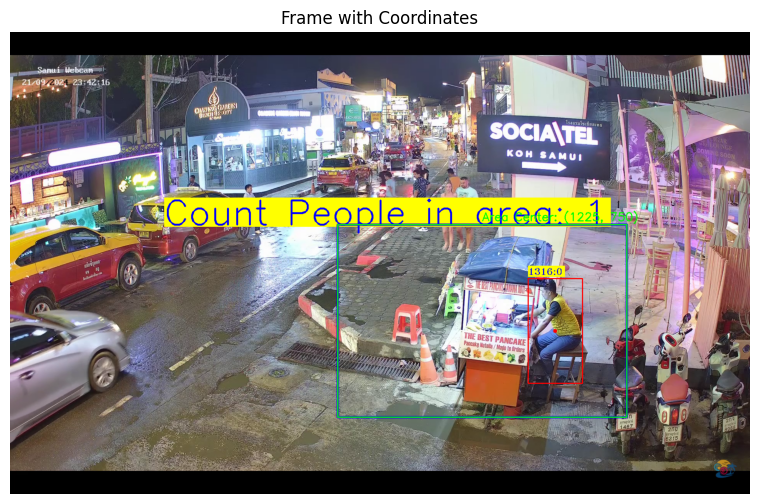

True

In [9]:
import matplotlib.pyplot as plt

# Example of showing a specific frame with coordinates
frame_to_show = frame.copy()  # Copy the last processed frame

# Drawing pixel coordinates (for the center of the area)
cv2.putText(frame_to_show, f'Area Center: ({(area_x1 + area_x2) // 2}, {(area_y1 + area_y2) // 2})',
            ((area_x1 + area_x2) // 2, area_y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

# Draw the rectangular area
cv2.rectangle(frame_to_show, (area_x1, area_y1), (area_x2, area_y2), (0, 255, 0), 2)

# Convert BGR to RGB for displaying with Matplotlib
frame_to_show_rgb = cv2.cvtColor(frame_to_show, cv2.COLOR_BGR2RGB)

# Display the frame using Matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(frame_to_show_rgb)
plt.axis('off')  # Hide axes
plt.title('Frame with Coordinates')
plt.show()

# Optionally, save the frame as an image
cv2.imwrite('frame_with_coordinates.png', frame_to_show)